In [3]:
import pandas as pd
import datetime as dt
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skforecast.model_selection import grid_search_forecaster
from sklearn.linear_model import LinearRegression
import lightgbm 
import random
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


In [4]:
df = pd.read_csv("df500_6m_adjclose_monthly.csv")
df.tail()

Date        LKQ         AXP        CHD         ADP        DLTR  \
85   9/1/2022  46.912743  133.932724  71.187706  224.130798  136.100006   
86  10/1/2022  55.360020  147.374634  73.868195  240.534485  158.500000   
87  11/1/2022  54.056614  157.045654  81.580872  262.866303  150.289993   
88  12/1/2022  53.410000  147.239639  80.610001  237.708191  141.440002   
89   1/1/2023  55.959999  151.600006  83.199997  237.169998  147.789993   

           PLD        ZBRA        REG          CMG  ...       CBRE       HOLX  \
85  100.285751  262.010010  52.758156  1502.760010  ...  67.510002  64.519997   
86  110.012230  283.220001  59.909794  1498.329956  ...  70.940002  67.800003   
87  117.005333  270.279999  65.771072  1626.959961  ...  79.599998  76.160004   
88  111.979042  256.410004  61.880054  1387.489990  ...  76.959999  74.809998   
89  122.820000  297.029999  64.349998  1555.189941  ...  84.290001  79.660004   

           FE        ROST         KO        EXPD  LUMN        NWL        ENPH  \
85  36.622349   83.756088  55.222874   87.788971  7.28  13.646502  277.470001   
86  37.325104   95.440727  59.428520   97.272690  7.36  13.567904  307.000000   
87  40.819077  117.363464  63.162045  115.375244  5.47  12.742630  320.589996   
88  41.939999  115.767631  63.610001  103.919998  5.22  13.080000  264.959992   
89  42.200001  115.730003  60.080002  106.730003  5.22  15.050000  222.539993   

          LNC  
85  42.889355  
86  52.617844  
87  38.390862  
88  30.286781  
89  31.750000  

[5 rows x 453 columns]

In [5]:
# Veryfing that all stocks have full historical data in a 4 year period
count_stocks = df.describe()
count_stocks.iloc[0][count_stocks.iloc[0,:] != 90]

Series([], Name: count, dtype: float64)

In [6]:
# Extract only monthly data
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.groupby(    [df['Date'].dt.year, df['Date'].dt.month] ).head(1)
df.head()

Date        LKQ        AXP        CHD        ADP       DLTR  \
0 2015-08-01  29.271841  68.479057  38.902149  65.787086  76.260002   
1 2015-09-01  27.680874  66.167290  37.971416  68.373657  66.660004   
2 2015-10-01  28.900942  65.390717  38.962563  74.481445  65.489998   
3 2015-11-01  28.783813  64.186760  38.817741  73.856384  75.459999   
4 2015-12-01  28.920462  62.314209  38.570602  72.537834  77.220001   

         PLD       ZBRA        REG         CMG  ...       CBRE       HOLX  \
0  30.731918  82.879997  44.987846  710.010010  ...  32.020000  38.810001   
1  31.459772  76.550003  47.501339  720.250000  ...  32.000000  39.130001   
2  34.927418  76.900002  51.941917  640.229981  ...  37.279999  38.860001   
3  34.943775  80.199997  51.498646  579.549988  ...  37.470001  40.349998   
4  35.082718  69.650002  52.455517  479.850006  ...  34.580002  38.689999   

          FE       ROST         KO       EXPD       LUMN        NWL  ENPH  \
0  23.317574  45.317009  30.919579  44.427433  13.963247  31.743456  4.60   
1  23.089930  45.177185  31.548658  42.685543  12.971768  30.059427  3.70   
2  23.008808  47.261337  33.590759  45.171368  14.864715  32.118423  3.60   
3  23.148924  48.597511  33.804916  44.037323  14.190243  33.806465  1.67   
4  23.673969  50.279400  34.335911  41.218208  13.513904  33.509884  3.51   

         LNC  
0  41.377701  
1  38.664806  
2  43.593620  
3  44.983948  
4  41.114620  

[5 rows x 453 columns]

In [7]:
# Normalize stocks
scaler = preprocessing.MinMaxScaler()
names = df.columns
d = scaler.fit_transform(df.iloc[:,1:])
df.iloc[:,1:] = d
df.head()

Date       LKQ       AXP       CHD       ADP      DLTR       PLD  \
0 2015-08-01  0.238299  0.142741  0.014666  0.000000  0.107840  0.000000   
1 2015-09-01  0.197325  0.126680  0.000000  0.013125  0.011715  0.005482   
2 2015-10-01  0.228747  0.121284  0.015618  0.044116  0.000000  0.031600   
3 2015-11-01  0.225730  0.112920  0.013336  0.040944  0.099830  0.031723   
4 2015-12-01  0.229249  0.099910  0.009442  0.034254  0.117453  0.032769   

       ZBRA       REG       CMG  ...      CBRE      HOLX        FE      ROST  \
0  0.060136  0.318092  0.268544  ...  0.079543  0.113134  0.014159  0.001683   
1  0.048523  0.382246  0.274820  ...  0.079302  0.120069  0.003720  0.000000   
2  0.049165  0.495586  0.225771  ...  0.142840  0.114218  0.000000  0.025091   
3  0.055219  0.484272  0.188577  ...  0.145126  0.146511  0.006425  0.041177   
4  0.035865  0.508695  0.127465  ...  0.110349  0.110533  0.030503  0.061425   

         KO      EXPD      LUMN       NWL      ENPH       LNC  
0  0.000000  0.035085  0.710051  0.672205  0.012006  0.378707  
1  0.019244  0.016042  0.629531  0.617250  0.009192  0.320923  
2  0.081711  0.043218  0.783260  0.684441  0.008880  0.425906  
3  0.088262  0.030820  0.728485  0.739527  0.002845  0.455519  
4  0.104506  0.000000  0.673559  0.729848  0.008598  0.373103  

[5 rows x 453 columns]

In [8]:
# Filter with highest returns (highest moving average)
filt_stocks = df.iloc[-24:,1:].mean(axis=0)
high_return_stocks = filt_stocks[filt_stocks >0.79].index #higher than 79% return in the last 20 months
high_return_stocks = high_return_stocks.insert(0, 'Date')
df = df[high_return_stocks]
high_return_stocks

Index(['Date', 'CMG', 'MKC', 'TT', 'HCA', 'NEE', 'MDLZ', 'DE', 'IEX', 'BDX',
       ...
       'DG', 'ES', 'AEP', 'DHR', 'UPS', 'URI', 'NDSN', 'AMCR', 'HOLX', 'KO'],
      dtype='object', length=101)

In [9]:
# Create correlation and select low correlated stocks
rets_corr = df.corr().abs().unstack().sort_values()
todelete=[]
rets_corr
for i in np.arange(len(rets_corr)):
    if (float(rets_corr[i]) < 0.6):
        todelete.append(i)
rets_corr = pd.DataFrame(rets_corr).reset_index()
rets_corr = rets_corr.loc[0:max(todelete)]
rets_corr

level_0 level_1         0
0       TXT     MKC  0.373519
1       MKC     TXT  0.373519
2      FISV     TXT  0.385534
3       TXT    FISV  0.385534
4       TXT      ES  0.394832
..      ...     ...       ...
111    AAPL     TXT  0.597307
112     TXT    MNST  0.597384
113    MNST     TXT  0.597384
114      DG    HBAN  0.597407
115    HBAN      DG  0.597407

[116 rows x 3 columns]

In [10]:
# Filter data with uncorrelated stocks
stocks_lowc = list(set(rets_corr.iloc[:,0]))
stocks_lowc.insert(0, 'Date')
stocks_lowc
df = df[stocks_lowc]
df.tail()

Date      FISV       CMS      BKNG      TMUS       WMT      HBAN  \
85 2022-09-01  0.657353  0.727457  0.412701  0.850164  0.779762  0.724773   
86 2022-10-01  0.775698  0.700105  0.574195  1.000000  0.902192  0.966206   
87 2022-11-01  0.796606  0.792506  0.724054  0.999138  1.000000  1.000000   
88 2022-12-01  0.754146  0.856288  0.678255  0.900396  0.896957  0.844546   
89 2023-01-01  0.792605  0.825701  0.913076  0.944511  0.889976  0.863808   

         STE      MNST       BDX  ...         V       CMG       BSX       MKC  \
85  0.584618  0.741127  0.704437  ...  0.625144  0.754467  0.747488  0.556398   
86  0.621190  0.851189  0.797401  ...  0.791058  0.751752  0.894173  0.670268   
87  0.693106  1.000000  0.886894  ...  0.846382  0.830596  0.966510  0.778071   
88  0.690233  0.978346  0.920095  ...  0.797043  0.683811  1.000000  0.742508   
89  0.802139  0.953435  0.923110  ...  0.890300  0.786604  0.978232  0.663532   

         FMC       XEL       AEE       KDP      CDNS       APD  
85  0.751776  0.772474  0.772999  0.908930  0.862582  0.625423  
86  0.882428  0.804825  0.797109  1.000000  0.790395  0.716853  
87  0.994251  0.913159  0.924052  0.995186  0.914203  1.000000  
88  0.938625  0.910827  0.917543  0.909946  0.845854  0.990998  
89  0.976718  0.887731  0.890691  0.888560  0.951496  0.980251  

[5 rows x 49 columns]

In [11]:
# Filter out with highest variance
filt_stocks = df.iloc[-24:,1:].std(axis=0)
high_std_stocks = filt_stocks[filt_stocks < 0.11].index #takes not so volatile stocks
high_std_stocks = high_std_stocks.insert(0, 'Date')
df = df[high_std_stocks]

In [12]:
# Select 10 at random for the proof of concept
n = 10
rand10 = random.sample(set(high_std_stocks[1:]), n)
rand10.insert(0, 'Date')
df = df[rand10]
df.head()

Date       DHR       TDG      AAPL       BSX       CMS      LDOS  \
0 2015-08-01  0.004977  0.024618  0.025881  0.011052  0.000000  0.005949   
1 2015-09-01  0.000000  0.000000  0.023011  0.000000  0.053038  0.000000   
2 2015-10-01  0.022692  0.010514  0.036540  0.062626  0.067143  0.086994   
3 2015-11-01  0.031175  0.031401  0.034775  0.062626  0.047396  0.131567   
4 2015-12-01  0.021507  0.022668  0.016262  0.067984  0.072805  0.118573   

        WEC      HOLX       TDY        MA  
0  0.000000  0.113134  0.042567  0.016315  
1  0.058909  0.120069  0.023123  0.009155  
2  0.050793  0.114218  0.020389  0.037380  
3  0.023250  0.146511  0.028770  0.034507  
4  0.053649  0.110533  0.019035  0.032722

In [13]:
# Create lags for each stock
X_lags = []
Y_lags = []
column_names=[]
for i in range(len(df.T)):
    if i == 0:
        continue
    else:
        for n in range(11):
            if n == 0:
                Y_lags.append(df.iloc[:,i])
            else:    
                X_lags.append(df.iloc[:,i].shift(n))
                column_names.append(df.columns[i] + "_lag_" + str(n))
Y = pd.DataFrame(Y_lags).T
Y.columns = rand10[1:]
Y['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
Y = Y.reset_index(drop=True)
Y = Y.iloc[10:,:]

X = pd.DataFrame(X_lags).T
X.columns = column_names
X['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
X = X.reset_index(drop=True)
X = X.iloc[10:,:]
Y

DHR       TDG      AAPL       BSX       CMS      LDOS       WEC  \
10  0.044743  0.072468  0.003626  0.233088  0.271783  0.057989  0.241136   
11  0.062964  0.094839  0.016488  0.263563  0.258690  0.077468  0.236213   
12  0.062854  0.102852  0.019312  0.248158  0.196884  0.002124  0.172716   
13  0.051830  0.108406  0.030609  0.247488  0.203262  0.147139  0.178752   
14  0.052877  0.084862  0.031345  0.187207  0.205976  0.132146  0.176716   
..       ...       ...       ...       ...       ...       ...       ...   
85  0.737150  0.714257  0.751093  0.747488  0.727457  0.732144  0.783508   
86  0.713141  0.812720  0.848625  0.894173  0.700105  0.906610  0.812544   
87  0.794986  0.914662  0.814418  0.966510  0.792506  1.000000  0.931900   
88  0.764906  0.916885  0.699206  1.000000  0.856288  0.950047  0.861320   
89  0.799709  1.000000  0.750441  0.978232  0.825701  0.843816  0.850843   

        HOLX       TDY        MA       Date  
10  0.021890  0.045480  0.004209 2016-06-01  
11  0.106199  0.060683  0.027187 2016-07-01  
12  0.104681  0.066151  0.032303 2016-08-01  
13  0.113567  0.068169  0.048788 2016-09-01  
14  0.052449  0.067530  0.065626 2016-10-01  
..       ...       ...       ...        ...  
85  0.670351  0.654658  0.666578 2022-09-01  
86  0.741439  0.809265  0.812154 2022-10-01  
87  0.922627  0.865783  0.907772 2022-11-01  
88  0.893368  0.814196  0.878936 2022-12-01  
89  0.998483  0.825234  0.975924 2023-01-01  

[80 rows x 11 columns]

In [14]:
steps = 12
X_train = X.iloc[:-steps,:-1]
X_test = X.iloc[-steps:,:-1]
y_train = Y.iloc[:-steps,:-1]
y_test = Y.iloc[-steps:,:-1]
y_test

DHR       TDG      AAPL       BSX       CMS      LDOS       WEC  \
78  0.795830  0.952647  0.920128  0.929672  0.830254  0.896119  0.775349   
79  0.866857  0.924361  0.982437  0.933691  0.975052  0.969866  0.920742   
80  0.709260  0.817740  0.873493  0.860683  0.946701  0.920423  0.924359   
81  0.756940  0.837587  0.816901  0.823845  1.000000  0.932279  1.000000   
82  0.718240  0.708469  0.740337  0.698593  0.930010  0.886892  0.944177   
83  0.861946  0.869482  0.906245  0.825184  0.958095  0.966876  0.992287   
84  0.780855  0.828228  0.872215  0.800402  0.930923  0.823248  0.982118   
85  0.737150  0.714257  0.751093  0.747488  0.727457  0.732144  0.783508   
86  0.713141  0.812720  0.848625  0.894173  0.700105  0.906610  0.812544   
87  0.794986  0.914662  0.814418  0.966510  0.792506  1.000000  0.931900   
88  0.764906  0.916885  0.699206  1.000000  0.856288  0.950047  0.861320   
89  0.799709  1.000000  0.750441  0.978232  0.825701  0.843816  0.850843   

        HOLX       TDY        MA  
78  0.814478  0.889494  0.917048  
79  0.936931  1.000000  0.905659  
80  0.832250  0.895038  0.925524  
81  0.903338  0.827584  0.908925  
82  0.773949  0.750830  0.768379  
83  0.819029  0.792452  0.895398  
84  0.736237  0.733584  0.799503  
85  0.670351  0.654658  0.666578  
86  0.741439  0.809265  0.812154  
87  0.922627  0.865783  0.907772  
88  0.893368  0.814196  0.878936  
89  0.998483  0.825234  0.975924

Train dates : 2016-06-01 00:00:00 --- 2022-01-01 00:00:00  (n=68)
Test dates  : 2022-02-01 00:00:00 --- 2023-01-01 00:00:00  (n=12)


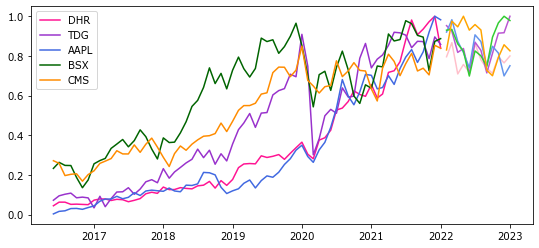

In [15]:
date_train = Y['Date'][:-steps]
date_test  = Y['Date'][-steps:]
print(f"Train dates : {date_train.min()} --- {date_train.max()}  (n={len(date_train)})")
print(f"Test dates  : {date_test.min()} --- {date_test.max()}  (n={len(date_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
colors_light = ['pink', 'mediumorchid','cornflowerblue','limegreen', 'orange']
colors_dark = ['deeppink', 'darkorchid','royalblue','darkgreen','darkorange']
for i in np.arange(5):
    plt.plot(date_train.values, y_train.iloc[:,i], label=y_train.iloc[:,i].name,color=colors_dark[i])
    plt.plot(date_test.values, y_test.iloc[:,i],color=colors_light[i])
plt.legend()
plt.show()

In [16]:
def pred_wo_LR(y_train,y_test,x_train,x_test,c1,c2):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)

    lr_y = y_test.values
    lr_y_pred = lr_model.predict(x_test)
    
    fig, ax=plt.subplots(figsize=(9, 4))
    colors_light = ['pink', 'mediumorchid','cornflowerblue','limegreen', 'orange']
    colors_dark = ['deeppink', 'darkorchid','royalblue','darkgreen','darkorange']

    plt.plot(date_train.values, y_train,color=c1,label='Train')
    plt.plot(date_test.values, y_test,color=c2,label='Test')
    plt.plot(date_test.values, lr_y_pred,color=c2,linestyle='dashed',label='Prediction')
    plt.legend()
    plt.title(str(y_train.name))
    plt.show()

    # Test error
    error_mse = mean_absolute_error(
                    y_true = y_test,
                    y_pred = lr_y_pred
                )
    print(f"Test error (mse) without hyperparameter tunning: {error_mse}")

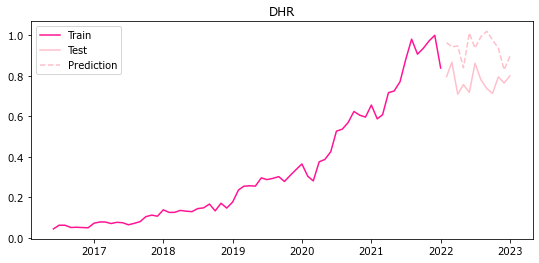

Test error (mse) without hyperparameter tunning: 0.1663218784438325


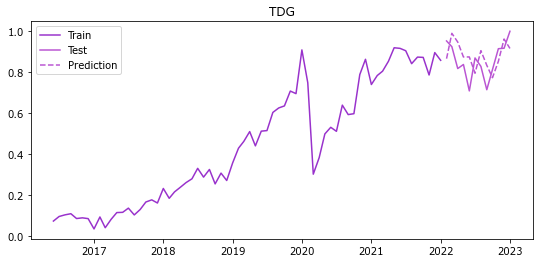

Test error (mse) without hyperparameter tunning: 0.08212745912914023


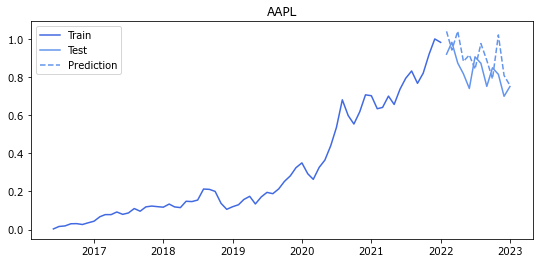

Test error (mse) without hyperparameter tunning: 0.10435411025092305


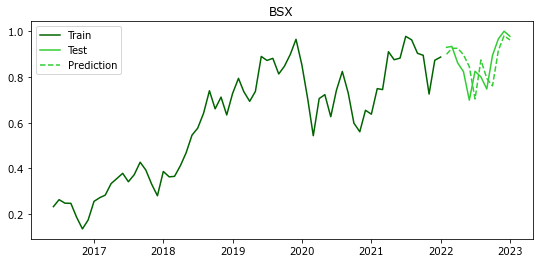

Test error (mse) without hyperparameter tunning: 0.06540148299524438


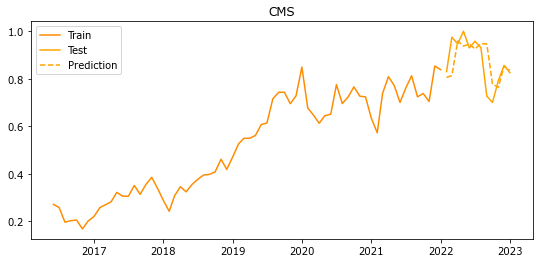

Test error (mse) without hyperparameter tunning: 0.05548140141415084


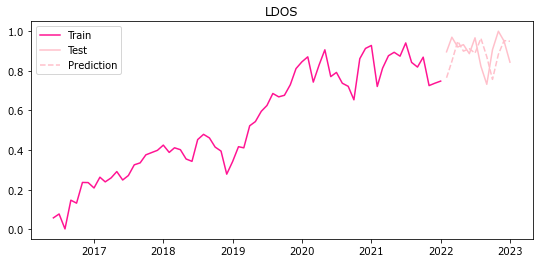

Test error (mse) without hyperparameter tunning: 0.0893277831413556


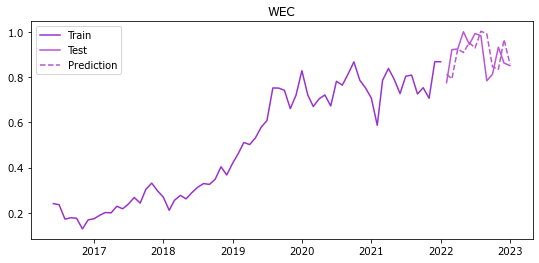

Test error (mse) without hyperparameter tunning: 0.06668373918556535


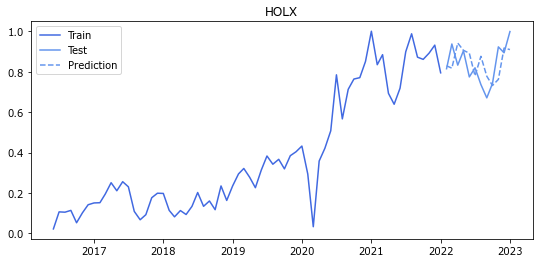

Test error (mse) without hyperparameter tunning: 0.07780250560482949


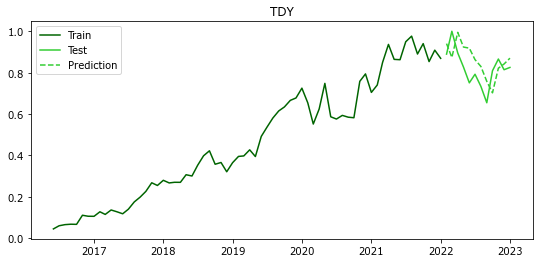

Test error (mse) without hyperparameter tunning: 0.08616091152770444


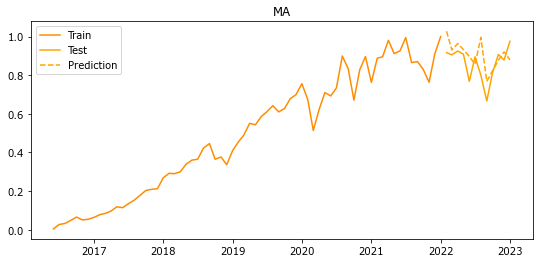

Test error (mse) without hyperparameter tunning: 0.07019721930620193


In [17]:
colors_light = ['pink', 'mediumorchid','cornflowerblue','limegreen', 'orange',
               'pink', 'mediumorchid','cornflowerblue','limegreen', 'orange']
colors_dark = ['deeppink', 'darkorchid','royalblue','darkgreen','darkorange',
              'deeppink', 'darkorchid','royalblue','darkgreen','darkorange']
for i in np.arange(0,100,10):
    pred_wo_LR(y_train.iloc[:,int(i/10)] ,  y_test.iloc[:,int(i/10)], X_train.iloc[:,i:i+10], 
               X_test.iloc[:,i:i+10],colors_dark[int(i/10)],colors_light[int(i/10)])

In [18]:
def regression_roc_auc_score(y_true, y_pred, num_rounds = 10000):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    num_pairs = 0
    num_same_sign = 0

    for i, j in _yield_pairs(y_true, num_rounds):
        diff_true = y_true[i] - y_true[j]
        diff_score = y_pred[i] - y_pred[j]
        if diff_true * diff_score > 0:
            num_same_sign += 1
        elif diff_score == 0:
            num_same_sign += .5
        num_pairs += 1

    return num_same_sign / num_pairs

In [33]:
def auc_roc_plot(y_train,y_test,X_train,X_test): 
    modelnames = [
     'DummyRegressor()', 
     'KNeighborsRegressor()',
     'LinearRegression()', 
     'SVR()',
     'DecisionTreeRegressor()', 
     'GradientBoostingRegressor()',
     'XGBRegressor()',
     'CatBoostRegressor()'
    ]
    metricnames = [
     'mean_absolute_error', 
     'regression_roc_auc_score'
    ]
    metrics = pd.DataFrame(index = modelnames, columns = metricnames)

    plt.figure(figsize=(8,6))


    for modelname in modelnames:
        model = eval(modelname)
        pred_test = model.fit(X_train, y_train).predict(X_test)
        """
        # Hyperparameter Grid search
        forecaster = ForecasterAutoreg(
                        regressor = eval(modelname),
                        lags      = 2
                     )

        lags_grid = [6, 12, 24, 36, 48]

        parameters = [{'strategy' :['mean', 'median']},
                     {'n_neighbors': [4,6,8,12,15], 'weights': ['uniform','distance'],'p':[1,2,5]},
                     {'fit_intercept':[True,False], 'copy_X':[True, False]},
                     {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],
                      'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},
                     {"splitter":["best","random"],"max_depth" : [3,5,10],"min_samples_leaf":[4,6,8,10],
                     "min_weight_fraction_leaf":[0.2,0.4],"max_features":["log2","sqrt"],
                     "max_leaf_nodes":[20,40,80,90] },
                      { 'n_estimators' :[10,100, 500], 'learning_rate' :[0.01, 0.1,0.5, 1.0],
                      'subsample' :[0.5, 0.7, 1.0], 'max_depth' : [3, 7, 9]},
                      { 'max_depth': [2, 4, 6],
                     'n_estimators': [100, 500],
                     'colsample_bytree': [0.4, 0.8],
                     'min_child_weight': [5, 7],
                     'gamma': [0.3, 0.7],
                     'subsample': [0.4, 0.6]},
                      {'depth'         : [6,8,10],
                      'learning_rate' : [0.05, 0.1],
                      'iterations'    : [30, 50]
                     }
                      ]
        results_grid = grid_search_forecaster(
                            forecaster  = forecaster,
                            y           = y_train,
                            exog        = X_train,
                            param_grid  = parameters[modelnames.index(modelname)],
                            lags_grid   = lags_grid,
                            steps       = steps,
                            refit       = True,
                            metric      = 'mean_squared_error',
                            initial_train_size = (len(y_train)-1),
                            return_best = True,
                            verbose     = False
                       )
        # Predictions with best hyperparameters from grid search
        pred_test = forecaster.predict(steps=steps, exog=X_train)
        """

        plot=[]
        for metricname in metricnames:
            #metrics.loc[modelname, metricname] = print(str(modelname),str(metricname), eval(f'{metricname}(y_test, pred_test)' ))
            plot.append(eval(f'{metricname}(y_test, pred_test)' ))
        plt.scatter(plot[0],plot[1])
        plt.annotate(str(modelname), (plot[0], plot[1]))
        plt.title("Roc Curve for Stock " + str(y_train.name))
    plt.xlabel('Mean Abolute Error')
    plt.ylabel('Roc Auc Score')
    plt.grid()
    plt.show()        
    
def _yield_pairs(y_true, num_rounds):
    if num_rounds == 'exact':
        for i in range(len(y_true)):
            for j in np.where((y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
                yield i, j     
    else:
        for r in range(num_rounds):
            i = np.random.choice(range(len(y_true)))
            j = np.random.choice(np.where(y_true != y_true[i])[0])
            yield i, j

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 64.18it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'strategy': 'mean'}
  Backtesting metric: 0.014716845267033398



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_neighbors': 15, 'p': 5, 'weights': 'distance'}
  Backtesting metric: 1.079310486504147e-06

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 28.65it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'copy_X': True, 'fit_intercept': False}
  Backtesting metric: 0.02360456661046466

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'C': 1, 'coef0': 0.01, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
  Backtesting metric: 9.078472773274734e-06

Number of models compared: 1920.


loop param_grid:  82%|███████████████████████████      | 315/384 [00:01<00:00, 165.58it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
  Backtesting metric: 9.55818961394382e-06

Number of models compared: 540.


loop param_grid:  72%|█████████████████████████▎         | 78/108 [00:05<00:01, 21.10it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:33<00:00,  6.75s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.7}
  Backtesting metric: 2.5746722174616894e-08

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:11,  7.93it/s]

[14:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   4%|█▌                                   | 4/96 [00:00<00:11,  7.73it/s]


[14:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.70it/s]

[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 11.87it/s]

[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.08it/s]

[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.69it/s]

[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:06, 12.09it/s]

[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 12.49it/s]

[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.39it/s]

[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:04, 12.75it/s]

[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:04, 12.20it/s]

[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:04, 12.39it/s]

[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.21it/s]


[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 12.54it/s]

[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:03, 12.08it/s]

[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 12.02it/s]

[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 12.08it/s]


[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 12.30it/s]

[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:02, 11.79it/s]

[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.51it/s]

[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.11it/s]


[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.14it/s]


[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.84it/s]

[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.97it/s]


[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.43it/s]

[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 11.44it/s]

[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.76it/s]

[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 11.39it/s]


[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.43it/s]

[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.12it/s]


[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:07<00:00, 11.33it/s]


[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 11.09it/s]

[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  20%|███████▊                               | 1/5 [00:08<00:33,  8.43s/it]

[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.35it/s]

[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 12.52it/s]

[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.83it/s]


[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 12.06it/s]


[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.45it/s]


[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 11.25it/s]


[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.90it/s]

[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 10.79it/s]


[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.23it/s]

[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.54it/s]

[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 12.21it/s]

[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 12.02it/s]

[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:04, 12.44it/s]

[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.02it/s]

[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 12.19it/s]

[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:03<00:03, 12.46it/s]

[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:03, 12.57it/s]

[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 12.10it/s]

[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 12.20it/s]

[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.18it/s]

[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.79it/s]


[14:18:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.75it/s]

[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.76it/s]

[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.78it/s]

[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 10.56it/s]

[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.59it/s]


[14:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 10.82it/s]

[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.66it/s]

[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 10.66it/s]


[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.67it/s]

[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.63it/s]


[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.13it/s]

[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.84it/s]

[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.67it/s]

[14:18:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  40%|███████████████▌                       | 2/5 [00:17<00:25,  8.54s/it]

[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 14.55it/s]

[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.78it/s]

[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 12.22it/s]

[14:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.75it/s]

[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 12.10it/s]

[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.98it/s]

[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 12.04it/s]

[14:18:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:05, 12.30it/s]

[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 12.01it/s]


[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:05, 12.11it/s]


[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.64it/s]


[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.86it/s]

[14:18:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:04, 11.95it/s]

[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.11it/s]

[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.85it/s]

[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.81it/s]


[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:03, 11.95it/s]

[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.55it/s]

[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.50it/s]


[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.55it/s]

[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.35it/s]


[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.97it/s]

[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.65it/s]

[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.76it/s]


[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.71it/s]

[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.43it/s]


[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.92it/s]

[14:18:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 10.90it/s]

[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.70it/s]

[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.70it/s]


[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.55it/s]


[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.52it/s]

[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:07<00:00, 10.69it/s]

[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.63it/s]

[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:25<00:17,  8.53s/it]

[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]


[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 15.26it/s]


[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:06, 13.27it/s]

[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:06, 12.83it/s]

[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 11.94it/s]


[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.01it/s]

[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 12.04it/s]

[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 12.17it/s]

[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 11.84it/s]

[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.86it/s]

[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 12.55it/s]

[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:04, 12.39it/s]

[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.75it/s]

[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.52it/s]

[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.62it/s]


[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:03<00:04, 11.73it/s]


[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.31it/s]

[14:18:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.33it/s]


[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 11.28it/s]


[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 10.58it/s]


[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.51it/s]


[14:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.79it/s]

[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.76it/s]

[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.65it/s]

[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02,  9.45it/s]

[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:06<00:02,  8.84it/s]

[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.56it/s]

[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 10.99it/s]

[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 11.09it/s]

[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.94it/s]

[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.61it/s]

[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.63it/s]

[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.80it/s]

[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.55it/s]


[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:34<00:08,  8.57s/it]

[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:05, 16.80it/s]

[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 14.36it/s]

[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 13.58it/s]

[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:00<00:06, 13.36it/s]

[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.92it/s]

[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 12.41it/s]

[14:18:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:05, 12.52it/s]

[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:01<00:05, 12.31it/s]


[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.81it/s]

[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:04, 13.01it/s]

[14:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:04, 12.56it/s]

[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:02<00:04, 12.65it/s]


[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.90it/s]

[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:03, 13.00it/s]

[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 12.67it/s]

[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:03<00:03, 12.41it/s]

[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.76it/s]


[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.86it/s]

[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.41it/s]

[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:04<00:03, 11.16it/s]


[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.91it/s]

[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:05<00:02, 11.88it/s]

[14:18:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:05<00:02, 11.69it/s]

[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:05<00:01, 11.97it/s]


[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.90it/s]

[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 11.95it/s]

[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.78it/s]

[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:06<00:01, 11.43it/s]


[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.40it/s]

[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.55it/s]


[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:07<00:00, 11.62it/s]

[14:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


[14:18:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.6}
  Backtesting metric: 0.005350593078649098

Number of models compared: 60.


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2674122	total: 144ms	remaining: 4.16s



loop param_grid:   8%|███                                  | 1/12 [00:00<00:02,  4.08it/s]

1:	learn: 0.2574883	total: 144ms	remaining: 2.02s
2:	learn: 0.2492928	total: 145ms	remaining: 1.3s
3:	learn: 0.2408695	total: 146ms	remaining: 946ms
4:	learn: 0.2337716	total: 146ms	remaining: 732ms
5:	learn: 0.2257048	total: 147ms	remaining: 589ms
6:	learn: 0.2187081	total: 148ms	remaining: 486ms
7:	learn: 0.2109495	total: 149ms	remaining: 409ms
8:	learn: 0.2039430	total: 149ms	remaining: 349ms
9:	learn: 0.1975575	total: 150ms	remaining: 300ms
10:	learn: 0.1906904	total: 151ms	remaining: 260ms
11:	learn: 0.1840393	total: 151ms	remaining: 227ms
12:	learn: 0.1779675	total: 152ms	remaining: 199ms
13:	learn: 0.1725374	total: 153ms	remaining: 175ms
14:	learn: 0.1664026	total: 154ms	remaining: 154ms
15:	learn: 0.1611241	total: 154ms	remaining: 135ms
16:	learn: 0.1558538	total: 155ms	remaining: 119ms
17:	learn: 0.1505848	total: 156ms	remaining: 104ms
18:	learn: 0.1461513	total: 157ms	remaining: 90.8ms
19:	learn: 0.1411283	total: 158ms	remaining: 78.8ms
20:	learn: 0.1365623	total: 158ms	remai


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.37it/s]

35:	learn: 0.0843024	total: 24ms	remaining: 9.32ms
36:	learn: 0.0819580	total: 24.7ms	remaining: 8.69ms
37:	learn: 0.0792852	total: 25.6ms	remaining: 8.08ms
38:	learn: 0.0770568	total: 26.5ms	remaining: 7.47ms
39:	learn: 0.0750579	total: 27.2ms	remaining: 6.81ms
40:	learn: 0.0727511	total: 28ms	remaining: 6.15ms
41:	learn: 0.0705743	total: 28.7ms	remaining: 5.47ms
42:	learn: 0.0687493	total: 29.7ms	remaining: 4.83ms
43:	learn: 0.0666041	total: 30.5ms	remaining: 4.16ms
44:	learn: 0.0647506	total: 31.2ms	remaining: 3.47ms
45:	learn: 0.0630369	total: 31.9ms	remaining: 2.77ms
46:	learn: 0.0611939	total: 32.6ms	remaining: 2.08ms
47:	learn: 0.0594129	total: 33.3ms	remaining: 1.39ms
48:	learn: 0.0577064	total: 34.3ms	remaining: 699us
49:	learn: 0.0561158	total: 35ms	remaining: 0us
0:	learn: 0.2573059	total: 786us	remaining: 38.5ms
1:	learn: 0.2384079	total: 1.29ms	remaining: 30.9ms
2:	learn: 0.2233024	total: 2.14ms	remaining: 33.6ms
3:	learn: 0.2086576	total: 2.85ms	remaining: 32.8ms
4:	learn


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  8.90it/s]

8:	learn: 0.2053074	total: 13.1ms	remaining: 30.5ms
9:	learn: 0.1985342	total: 14.1ms	remaining: 28.2ms
10:	learn: 0.1919278	total: 15.4ms	remaining: 26.6ms
11:	learn: 0.1849563	total: 16ms	remaining: 24ms
12:	learn: 0.1785649	total: 17.3ms	remaining: 22.6ms
13:	learn: 0.1730281	total: 18.7ms	remaining: 21.4ms
14:	learn: 0.1667457	total: 19.1ms	remaining: 19.1ms
15:	learn: 0.1613256	total: 20.9ms	remaining: 18.3ms
16:	learn: 0.1560069	total: 22.2ms	remaining: 17ms
17:	learn: 0.1509031	total: 23.9ms	remaining: 15.9ms
18:	learn: 0.1463666	total: 25.3ms	remaining: 14.7ms
19:	learn: 0.1417240	total: 26.7ms	remaining: 13.4ms
20:	learn: 0.1369983	total: 27.6ms	remaining: 11.8ms
21:	learn: 0.1323746	total: 28.2ms	remaining: 10.3ms
22:	learn: 0.1285282	total: 29.5ms	remaining: 8.97ms
23:	learn: 0.1243244	total: 31.2ms	remaining: 7.8ms
24:	learn: 0.1203465	total: 32.6ms	remaining: 6.51ms
25:	learn: 0.1167854	total: 34.2ms	remaining: 5.26ms
26:	learn: 0.1132505	total: 35.7ms	remaining: 3.97ms
27

1:	learn: 0.2583945	total: 3.7ms	remaining: 88.8ms
2:	learn: 0.2504602	total: 5.89ms	remaining: 92.3ms
3:	learn: 0.2422030	total: 7.41ms	remaining: 85.3ms
4:	learn: 0.2345487	total: 9.12ms	remaining: 82.1ms
5:	learn: 0.2261074	total: 10.8ms	remaining: 79ms
6:	learn: 0.2191190	total: 12.8ms	remaining: 78.6ms
7:	learn: 0.2120091	total: 14.3ms	remaining: 75.2ms
8:	learn: 0.2053074	total: 16.5ms	remaining: 75ms
9:	learn: 0.1985342	total: 17.8ms	remaining: 71.2ms
10:	learn: 0.1919278	total: 19.6ms	remaining: 69.5ms
11:	learn: 0.1849563	total: 20.2ms	remaining: 64ms
12:	learn: 0.1785649	total: 21.7ms	remaining: 61.8ms
13:	learn: 0.1730281	total: 23.2ms	remaining: 59.7ms
14:	learn: 0.1667457	total: 23.7ms	remaining: 55.3ms
15:	learn: 0.1613256	total: 25.8ms	remaining: 54.8ms
16:	learn: 0.1560069	total: 27.5ms	remaining: 53.4ms
17:	learn: 0.1509031	total: 29.5ms	remaining: 52.4ms
18:	learn: 0.1463666	total: 31.3ms	remaining: 51.1ms
19:	learn: 0.1417240	total: 33.3ms	remaining: 49.9ms
20:	learn

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.99it/s]

0:	learn: 0.2578585	total: 2.5ms	remaining: 123ms
1:	learn: 0.2395445	total: 4.54ms	remaining: 109ms
2:	learn: 0.2249666	total: 6.54ms	remaining: 102ms
3:	learn: 0.2098618	total: 8.99ms	remaining: 103ms
4:	learn: 0.1968454	total: 11.1ms	remaining: 99.6ms
5:	learn: 0.1829011	total: 13.2ms	remaining: 96.7ms
6:	learn: 0.1717287	total: 15.2ms	remaining: 93.1ms
7:	learn: 0.1615476	total: 17.5ms	remaining: 91.7ms
8:	learn: 0.1514959	total: 19.5ms	remaining: 88.8ms
9:	learn: 0.1418400	total: 20.7ms	remaining: 82.9ms
10:	learn: 0.1327379	total: 22.6ms	remaining: 80.2ms
11:	learn: 0.1235948	total: 23.4ms	remaining: 74.1ms
12:	learn: 0.1157034	total: 25.4ms	remaining: 72.2ms
13:	learn: 0.1090363	total: 27.3ms	remaining: 70.2ms
14:	learn: 0.1017837	total: 38.4ms	remaining: 89.5ms
15:	learn: 0.0959208	total: 40.2ms	remaining: 85.4ms
16:	learn: 0.0900834	total: 42.5ms	remaining: 82.5ms
17:	learn: 0.0847829	total: 44.8ms	remaining: 79.7ms
18:	learn: 0.0801393	total: 46.6ms	remaining: 76ms
19:	learn:


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.45it/s]

0:	learn: 0.2681590	total: 8.08ms	remaining: 234ms
1:	learn: 0.2588590	total: 14.1ms	remaining: 197ms
2:	learn: 0.2513731	total: 21.3ms	remaining: 191ms
3:	learn: 0.2439079	total: 27.1ms	remaining: 176ms
4:	learn: 0.2352953	total: 28.9ms	remaining: 145ms
5:	learn: 0.2284140	total: 35ms	remaining: 140ms
6:	learn: 0.2204093	total: 36.3ms	remaining: 119ms
7:	learn: 0.2141516	total: 42ms	remaining: 115ms
8:	learn: 0.2074770	total: 47.4ms	remaining: 111ms
9:	learn: 0.2003323	total: 48ms	remaining: 96.1ms
10:	learn: 0.1930620	total: 48.8ms	remaining: 84.4ms
11:	learn: 0.1864524	total: 50.5ms	remaining: 75.8ms
12:	learn: 0.1807962	total: 55.9ms	remaining: 73.1ms
13:	learn: 0.1753251	total: 61.5ms	remaining: 70.3ms
14:	learn: 0.1694389	total: 63.2ms	remaining: 63.2ms
15:	learn: 0.1643646	total: 68.9ms	remaining: 60.3ms
16:	learn: 0.1594577	total: 75.4ms	remaining: 57.7ms
17:	learn: 0.1550447	total: 82.1ms	remaining: 54.7ms
18:	learn: 0.1504443	total: 84.9ms	remaining: 49.1ms
19:	learn: 0.14622


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.26it/s]

1:	learn: 0.2408896	total: 8.85ms	remaining: 124ms
2:	learn: 0.2270571	total: 15.4ms	remaining: 139ms
3:	learn: 0.2137394	total: 22.3ms	remaining: 145ms
4:	learn: 0.1989564	total: 24.2ms	remaining: 121ms
5:	learn: 0.1875459	total: 30.8ms	remaining: 123ms
6:	learn: 0.1746229	total: 32.3ms	remaining: 106ms
7:	learn: 0.1650270	total: 38.9ms	remaining: 107ms
8:	learn: 0.1550326	total: 45.4ms	remaining: 106ms
9:	learn: 0.1449400	total: 46ms	remaining: 92ms
10:	learn: 0.1349568	total: 46.7ms	remaining: 80.7ms
11:	learn: 0.1264393	total: 48.5ms	remaining: 72.8ms
12:	learn: 0.1192726	total: 53.7ms	remaining: 70.3ms
13:	learn: 0.1125641	total: 59.4ms	remaining: 67.9ms
14:	learn: 0.1055718	total: 61.2ms	remaining: 61.2ms
15:	learn: 0.0996809	total: 66.7ms	remaining: 58.4ms
16:	learn: 0.0944517	total: 72.6ms	remaining: 55.5ms
17:	learn: 0.0895525	total: 78.9ms	remaining: 52.6ms
18:	learn: 0.0847674	total: 82.1ms	remaining: 47.5ms
19:	learn: 0.0805101	total: 87.7ms	remaining: 43.9ms
20:	learn: 0.0


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.29it/s]

34:	learn: 0.0927190	total: 165ms	remaining: 70.8ms
35:	learn: 0.0900266	total: 171ms	remaining: 66.5ms
36:	learn: 0.0874572	total: 176ms	remaining: 62ms
37:	learn: 0.0849347	total: 182ms	remaining: 57.6ms
38:	learn: 0.0825154	total: 184ms	remaining: 51.9ms
39:	learn: 0.0801698	total: 189ms	remaining: 47.3ms
40:	learn: 0.0781457	total: 194ms	remaining: 42.6ms
41:	learn: 0.0762284	total: 199ms	remaining: 38ms
42:	learn: 0.0740630	total: 205ms	remaining: 33.3ms
43:	learn: 0.0723779	total: 211ms	remaining: 28.7ms
44:	learn: 0.0703567	total: 216ms	remaining: 24ms
45:	learn: 0.0684138	total: 217ms	remaining: 18.9ms
46:	learn: 0.0665222	total: 223ms	remaining: 14.2ms
47:	learn: 0.0645121	total: 228ms	remaining: 9.5ms
48:	learn: 0.0627632	total: 229ms	remaining: 4.67ms
49:	learn: 0.0611012	total: 234ms	remaining: 0us
0:	learn: 0.2587984	total: 5.7ms	remaining: 279ms
1:	learn: 0.2408896	total: 6.8ms	remaining: 163ms
2:	learn: 0.2270571	total: 12.2ms	remaining: 191ms
3:	learn: 0.2137394	total: 


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 10.55it/s]

0:	learn: 0.2664408	total: 1.12ms	remaining: 32.5ms
1:	learn: 0.2580598	total: 1.99ms	remaining: 27.8ms
2:	learn: 0.2509856	total: 3.03ms	remaining: 27.3ms
3:	learn: 0.2425961	total: 3.89ms	remaining: 25.3ms
4:	learn: 0.2348877	total: 4.87ms	remaining: 24.4ms
5:	learn: 0.2267617	total: 5.68ms	remaining: 22.7ms
6:	learn: 0.2194533	total: 6.46ms	remaining: 21.2ms
7:	learn: 0.2130343	total: 7.22ms	remaining: 19.9ms
8:	learn: 0.2059064	total: 7.93ms	remaining: 18.5ms
9:	learn: 0.1991570	total: 8.69ms	remaining: 17.4ms
10:	learn: 0.1920901	total: 9.03ms	remaining: 15.6ms
11:	learn: 0.1854624	total: 9.81ms	remaining: 14.7ms
12:	learn: 0.1791120	total: 10.8ms	remaining: 14.1ms
13:	learn: 0.1737895	total: 11.6ms	remaining: 13.3ms
14:	learn: 0.1683305	total: 12.4ms	remaining: 12.4ms
15:	learn: 0.1629786	total: 13.1ms	remaining: 11.5ms
16:	learn: 0.1576083	total: 13.9ms	remaining: 10.6ms
17:	learn: 0.1523954	total: 14.7ms	remaining: 9.78ms
18:	learn: 0.1472058	total: 15.6ms	remaining: 9.03ms
19:


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  9.12it/s]


43:	learn: 0.0269614	total: 36.6ms	remaining: 4.99ms
44:	learn: 0.0262220	total: 37.7ms	remaining: 4.19ms
45:	learn: 0.0255691	total: 38.7ms	remaining: 3.36ms
46:	learn: 0.0249287	total: 39.5ms	remaining: 2.52ms
47:	learn: 0.0243627	total: 40.5ms	remaining: 1.69ms
48:	learn: 0.0238240	total: 41.6ms	remaining: 848us
49:	learn: 0.0232464	total: 42.9ms	remaining: 0us
0:	learn: 0.2674827	total: 3.31ms	remaining: 96.1ms
1:	learn: 0.2593421	total: 5.51ms	remaining: 77.1ms
2:	learn: 0.2507344	total: 6.49ms	remaining: 58.4ms
3:	learn: 0.2434213	total: 9.52ms	remaining: 61.9ms
4:	learn: 0.2352686	total: 12.5ms	remaining: 62.5ms
5:	learn: 0.2274948	total: 15.4ms	remaining: 61.5ms
6:	learn: 0.2201419	total: 17.6ms	remaining: 57.7ms
7:	learn: 0.2130180	total: 18.5ms	remaining: 50.9ms
8:	learn: 0.2066907	total: 20.9ms	remaining: 48.8ms
9:	learn: 0.1997350	total: 23.1ms	remaining: 46.2ms
10:	learn: 0.1943431	total: 25.7ms	remaining: 44.4ms
11:	learn: 0.1888783	total: 28ms	remaining: 41.9ms
12:	learn

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.17it/s]

0:	learn: 0.2592667	total: 3.96ms	remaining: 115ms
1:	learn: 0.2435237	total: 6.54ms	remaining: 91.5ms
2:	learn: 0.2274532	total: 7.7ms	remaining: 69.3ms
3:	learn: 0.2142713	total: 10.1ms	remaining: 65.7ms
4:	learn: 0.1999729	total: 12.8ms	remaining: 64ms
5:	learn: 0.1871965	total: 15.1ms	remaining: 60.4ms
6:	learn: 0.1751174	total: 17.5ms	remaining: 57.4ms
7:	learn: 0.1641119	total: 18.9ms	remaining: 51.9ms
8:	learn: 0.1546491	total: 22.3ms	remaining: 52.1ms
9:	learn: 0.1446675	total: 25.5ms	remaining: 50.9ms
10:	learn: 0.1352759	total: 26.8ms	remaining: 46.3ms
11:	learn: 0.1274574	total: 29.5ms	remaining: 44.3ms
12:	learn: 0.1196930	total: 33ms	remaining: 43.1ms
13:	learn: 0.1132670	total: 35.7ms	remaining: 40.8ms
14:	learn: 0.1063749	total: 38.4ms	remaining: 38.4ms
15:	learn: 0.1001646	total: 41.1ms	remaining: 35.9ms
16:	learn: 0.0937086	total: 41.8ms	remaining: 31.9ms
17:	learn: 0.0891390	total: 44.5ms	remaining: 29.7ms
18:	learn: 0.0837470	total: 45.7ms	remaining: 26.4ms
19:	learn

4:	learn: 0.2352686	total: 13.1ms	remaining: 118ms
5:	learn: 0.2274948	total: 15.6ms	remaining: 114ms
6:	learn: 0.2201419	total: 18.5ms	remaining: 113ms
7:	learn: 0.2130180	total: 19.5ms	remaining: 102ms
8:	learn: 0.2066907	total: 22.3ms	remaining: 101ms
9:	learn: 0.1997350	total: 24.7ms	remaining: 98.8ms
10:	learn: 0.1943431	total: 27ms	remaining: 95.8ms
11:	learn: 0.1888783	total: 29.9ms	remaining: 94.8ms
12:	learn: 0.1827733	total: 32.3ms	remaining: 92ms
13:	learn: 0.1766843	total: 35ms	remaining: 90ms
14:	learn: 0.1710878	total: 37.3ms	remaining: 87ms
15:	learn: 0.1653813	total: 39.8ms	remaining: 84.5ms
16:	learn: 0.1604149	total: 42.6ms	remaining: 82.6ms
17:	learn: 0.1558097	total: 44.8ms	remaining: 79.7ms
18:	learn: 0.1509254	total: 47.3ms	remaining: 77.2ms
19:	learn: 0.1461168	total: 49.7ms	remaining: 74.5ms
20:	learn: 0.1414163	total: 52.4ms	remaining: 72.4ms
21:	learn: 0.1365545	total: 53.3ms	remaining: 67.8ms
22:	learn: 0.1327424	total: 55.8ms	remaining: 65.5ms
23:	learn: 0.1

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.62it/s]

0:	learn: 0.2592667	total: 2.53ms	remaining: 124ms
1:	learn: 0.2435237	total: 4.37ms	remaining: 105ms
2:	learn: 0.2274532	total: 5.37ms	remaining: 84.1ms
3:	learn: 0.2142713	total: 7.17ms	remaining: 82.5ms
4:	learn: 0.1999729	total: 9.21ms	remaining: 82.8ms
5:	learn: 0.1871965	total: 11ms	remaining: 80.4ms
6:	learn: 0.1751174	total: 13ms	remaining: 79.7ms
7:	learn: 0.1641119	total: 13.8ms	remaining: 72.6ms
8:	learn: 0.1546491	total: 16.1ms	remaining: 73.2ms
9:	learn: 0.1446675	total: 18.5ms	remaining: 74.2ms
10:	learn: 0.1352759	total: 19.3ms	remaining: 68.5ms
11:	learn: 0.1274574	total: 21.9ms	remaining: 69.4ms
12:	learn: 0.1196930	total: 24.3ms	remaining: 69ms
13:	learn: 0.1132670	total: 26.1ms	remaining: 67.1ms
14:	learn: 0.1063749	total: 28.2ms	remaining: 65.8ms
15:	learn: 0.1001646	total: 30ms	remaining: 63.8ms
16:	learn: 0.0937086	total: 30.6ms	remaining: 59.4ms
17:	learn: 0.0891390	total: 32.3ms	remaining: 57.5ms
18:	learn: 0.0837470	total: 33.4ms	remaining: 54.6ms
19:	learn: 0.


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.37it/s]

1:	learn: 0.2603522	total: 10.1ms	remaining: 141ms
2:	learn: 0.2521110	total: 16.5ms	remaining: 148ms
3:	learn: 0.2440048	total: 17.7ms	remaining: 115ms
4:	learn: 0.2366756	total: 20.9ms	remaining: 105ms
5:	learn: 0.2298126	total: 26.9ms	remaining: 108ms
6:	learn: 0.2234213	total: 32.2ms	remaining: 106ms
7:	learn: 0.2160691	total: 38ms	remaining: 105ms
8:	learn: 0.2091052	total: 43.7ms	remaining: 102ms
9:	learn: 0.2030964	total: 50.2ms	remaining: 100ms
10:	learn: 0.1966850	total: 55.7ms	remaining: 96.2ms
11:	learn: 0.1900686	total: 56.8ms	remaining: 85.2ms
12:	learn: 0.1835036	total: 57.3ms	remaining: 75ms
13:	learn: 0.1777786	total: 57.8ms	remaining: 66.1ms
14:	learn: 0.1721515	total: 64ms	remaining: 64ms
15:	learn: 0.1666227	total: 69.5ms	remaining: 60.8ms
16:	learn: 0.1616696	total: 71.3ms	remaining: 54.5ms
17:	learn: 0.1575502	total: 76.4ms	remaining: 50.9ms
18:	learn: 0.1522553	total: 78.2ms	remaining: 45.3ms
19:	learn: 0.1480906	total: 83.3ms	remaining: 41.7ms
20:	learn: 0.143679


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.11it/s]

0:	learn: 0.2600513	total: 7.71ms	remaining: 223ms
1:	learn: 0.2454502	total: 11.5ms	remaining: 161ms
2:	learn: 0.2286985	total: 12.7ms	remaining: 114ms
3:	learn: 0.2148123	total: 19.5ms	remaining: 127ms
4:	learn: 0.2019654	total: 23.3ms	remaining: 117ms
5:	learn: 0.1907458	total: 29.8ms	remaining: 119ms
6:	learn: 0.1803093	total: 35.7ms	remaining: 117ms
7:	learn: 0.1685851	total: 41.6ms	remaining: 114ms
8:	learn: 0.1578603	total: 47.8ms	remaining: 112ms
9:	learn: 0.1489262	total: 54.4ms	remaining: 109ms
10:	learn: 0.1396658	total: 59.9ms	remaining: 103ms
11:	learn: 0.1304892	total: 61ms	remaining: 91.5ms
12:	learn: 0.1215202	total: 61.5ms	remaining: 80.5ms
13:	learn: 0.1141278	total: 61.9ms	remaining: 70.8ms
14:	learn: 0.1071858	total: 68.2ms	remaining: 68.2ms
15:	learn: 0.1006463	total: 79ms	remaining: 69.1ms
16:	learn: 0.0950356	total: 81ms	remaining: 61.9ms
17:	learn: 0.0905345	total: 87.1ms	remaining: 58.1ms
18:	learn: 0.0849839	total: 88ms	remaining: 51ms
19:	learn: 0.0806039	tot


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.14it/s]

35:	learn: 0.0934657	total: 177ms	remaining: 68.9ms
36:	learn: 0.0908104	total: 184ms	remaining: 64.8ms
37:	learn: 0.0881838	total: 192ms	remaining: 60.5ms
38:	learn: 0.0859490	total: 199ms	remaining: 56ms
39:	learn: 0.0834285	total: 205ms	remaining: 51.4ms
40:	learn: 0.0812238	total: 212ms	remaining: 46.6ms
41:	learn: 0.0788039	total: 218ms	remaining: 41.5ms
42:	learn: 0.0766908	total: 224ms	remaining: 36.4ms
43:	learn: 0.0746398	total: 230ms	remaining: 31.4ms
44:	learn: 0.0726888	total: 235ms	remaining: 26.1ms
45:	learn: 0.0705092	total: 238ms	remaining: 20.7ms
46:	learn: 0.0685446	total: 244ms	remaining: 15.6ms
47:	learn: 0.0667397	total: 250ms	remaining: 10.4ms
48:	learn: 0.0651090	total: 255ms	remaining: 5.2ms
49:	learn: 0.0634424	total: 260ms	remaining: 0us
0:	learn: 0.2600513	total: 9.64ms	remaining: 472ms
1:	learn: 0.2454502	total: 13.1ms	remaining: 314ms
2:	learn: 0.2286985	total: 14.7ms	remaining: 231ms
3:	learn: 0.2148123	total: 21.1ms	remaining: 243ms
4:	learn: 0.2019654	to


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:04<00:06,  2.31s/it]

36:	learn: 0.0351910	total: 189ms	remaining: 66.6ms
37:	learn: 0.0336620	total: 196ms	remaining: 62ms
38:	learn: 0.0322165	total: 203ms	remaining: 57.3ms
39:	learn: 0.0310932	total: 210ms	remaining: 52.5ms
40:	learn: 0.0300861	total: 217ms	remaining: 47.7ms
41:	learn: 0.0290866	total: 224ms	remaining: 42.7ms
42:	learn: 0.0282057	total: 232ms	remaining: 37.8ms
43:	learn: 0.0271470	total: 237ms	remaining: 32.4ms
44:	learn: 0.0260499	total: 243ms	remaining: 27ms
45:	learn: 0.0250646	total: 250ms	remaining: 21.8ms
46:	learn: 0.0242302	total: 257ms	remaining: 16.4ms
47:	learn: 0.0234468	total: 262ms	remaining: 10.9ms
48:	learn: 0.0227574	total: 268ms	remaining: 5.47ms
49:	learn: 0.0219796	total: 276ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2562803	total: 3.1ms	remaining: 89.8ms



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  7.01it/s]

1:	learn: 0.2487886	total: 3.96ms	remaining: 55.4ms
2:	learn: 0.2412074	total: 5.47ms	remaining: 49.2ms
3:	learn: 0.2332718	total: 6.9ms	remaining: 44.8ms
4:	learn: 0.2261802	total: 8.27ms	remaining: 41.4ms
5:	learn: 0.2185543	total: 9.75ms	remaining: 39ms
6:	learn: 0.2116633	total: 11.1ms	remaining: 36.5ms
7:	learn: 0.2052737	total: 12.4ms	remaining: 34.2ms
8:	learn: 0.1983813	total: 13.7ms	remaining: 31.9ms
9:	learn: 0.1922441	total: 15.1ms	remaining: 30.2ms
10:	learn: 0.1864477	total: 16.6ms	remaining: 28.7ms
11:	learn: 0.1811213	total: 18ms	remaining: 27.1ms
12:	learn: 0.1757179	total: 19.4ms	remaining: 25.4ms
13:	learn: 0.1703068	total: 20.9ms	remaining: 23.9ms
14:	learn: 0.1655505	total: 22.2ms	remaining: 22.2ms
15:	learn: 0.1605646	total: 23.7ms	remaining: 20.7ms
16:	learn: 0.1554757	total: 25.6ms	remaining: 19.5ms
17:	learn: 0.1507275	total: 26.9ms	remaining: 18ms
18:	learn: 0.1466014	total: 28.7ms	remaining: 16.6ms
19:	learn: 0.1419725	total: 30.8ms	remaining: 15.4ms
20:	learn


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  7.25it/s]

23:	learn: 0.0647760	total: 29.7ms	remaining: 7.42ms
24:	learn: 0.0615955	total: 30.9ms	remaining: 6.19ms
25:	learn: 0.0585064	total: 32.4ms	remaining: 4.99ms
26:	learn: 0.0565666	total: 33.7ms	remaining: 3.74ms
27:	learn: 0.0540112	total: 34.9ms	remaining: 2.49ms
28:	learn: 0.0515586	total: 36.4ms	remaining: 1.25ms
29:	learn: 0.0492699	total: 38ms	remaining: 0us
0:	learn: 0.2562803	total: 1.28ms	remaining: 62.9ms
1:	learn: 0.2487886	total: 2.13ms	remaining: 51ms
2:	learn: 0.2412074	total: 3.6ms	remaining: 56.5ms
3:	learn: 0.2332718	total: 4.89ms	remaining: 56.2ms
4:	learn: 0.2261802	total: 6.04ms	remaining: 54.4ms
5:	learn: 0.2185543	total: 7.29ms	remaining: 53.5ms
6:	learn: 0.2116633	total: 8.33ms	remaining: 51.2ms
7:	learn: 0.2052737	total: 9.82ms	remaining: 51.5ms
8:	learn: 0.1983813	total: 11.4ms	remaining: 51.7ms
9:	learn: 0.1922441	total: 12.4ms	remaining: 49.4ms
10:	learn: 0.1864477	total: 13.5ms	remaining: 48ms
11:	learn: 0.1811213	total: 14.7ms	remaining: 46.6ms
12:	learn: 0.

48:	learn: 0.0624320	total: 55.7ms	remaining: 1.14ms
49:	learn: 0.0611038	total: 56.9ms	remaining: 0us


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  7.00it/s]

0:	learn: 0.2477136	total: 1.11ms	remaining: 54.5ms
1:	learn: 0.2333012	total: 1.78ms	remaining: 42.8ms
2:	learn: 0.2191876	total: 2.82ms	remaining: 44.3ms
3:	learn: 0.2049127	total: 3.72ms	remaining: 42.8ms
4:	learn: 0.1925829	total: 4.58ms	remaining: 41.2ms
5:	learn: 0.1798552	total: 5.48ms	remaining: 40.2ms
6:	learn: 0.1686732	total: 6.38ms	remaining: 39.2ms
7:	learn: 0.1587358	total: 7.22ms	remaining: 37.9ms
8:	learn: 0.1484674	total: 8.56ms	remaining: 39ms
9:	learn: 0.1397916	total: 9.58ms	remaining: 38.3ms
10:	learn: 0.1317619	total: 10.6ms	remaining: 37.4ms
11:	learn: 0.1244499	total: 11.4ms	remaining: 36.1ms
12:	learn: 0.1173882	total: 12.3ms	remaining: 35ms
13:	learn: 0.1105639	total: 13.1ms	remaining: 33.7ms
14:	learn: 0.1051048	total: 13.9ms	remaining: 32.4ms
15:	learn: 0.0992595	total: 14.7ms	remaining: 31.3ms
16:	learn: 0.0935602	total: 15.8ms	remaining: 30.7ms
17:	learn: 0.0879287	total: 16.8ms	remaining: 29.8ms
18:	learn: 0.0834975	total: 17.6ms	remaining: 28.8ms
19:	lea


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  7.30it/s]

17:	learn: 0.1543800	total: 33.1ms	remaining: 22.1ms
18:	learn: 0.1500366	total: 35.3ms	remaining: 20.4ms
19:	learn: 0.1457621	total: 37.2ms	remaining: 18.6ms
20:	learn: 0.1422673	total: 39.2ms	remaining: 16.8ms
21:	learn: 0.1379178	total: 41.2ms	remaining: 15ms
22:	learn: 0.1339789	total: 43.1ms	remaining: 13.1ms
23:	learn: 0.1304250	total: 44.8ms	remaining: 11.2ms
24:	learn: 0.1261100	total: 46ms	remaining: 9.2ms
25:	learn: 0.1227712	total: 48ms	remaining: 7.38ms
26:	learn: 0.1192975	total: 50.2ms	remaining: 5.57ms
27:	learn: 0.1158599	total: 52.3ms	remaining: 3.73ms
28:	learn: 0.1128121	total: 54.3ms	remaining: 1.87ms
29:	learn: 0.1094330	total: 56ms	remaining: 0us
0:	learn: 0.2493617	total: 2.22ms	remaining: 64.4ms
1:	learn: 0.2352717	total: 4.06ms	remaining: 56.9ms
2:	learn: 0.2198082	total: 5.38ms	remaining: 48.4ms
3:	learn: 0.2065159	total: 7.55ms	remaining: 49.1ms
4:	learn: 0.1929231	total: 8.48ms	remaining: 42.4ms
5:	learn: 0.1814200	total: 10.7ms	remaining: 42.7ms
6:	learn: 0


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.44it/s]

23:	learn: 0.0662590	total: 45.3ms	remaining: 11.3ms
24:	learn: 0.0625382	total: 46.7ms	remaining: 9.35ms
25:	learn: 0.0595724	total: 48.7ms	remaining: 7.49ms
26:	learn: 0.0565724	total: 50.8ms	remaining: 5.65ms
27:	learn: 0.0534494	total: 52.9ms	remaining: 3.78ms
28:	learn: 0.0510287	total: 55.1ms	remaining: 1.9ms
29:	learn: 0.0485587	total: 57.5ms	remaining: 0us
0:	learn: 0.2571144	total: 2.41ms	remaining: 118ms
1:	learn: 0.2498080	total: 4.21ms	remaining: 101ms
2:	learn: 0.2415580	total: 4.98ms	remaining: 78ms
3:	learn: 0.2341914	total: 7.46ms	remaining: 85.8ms
4:	learn: 0.2263803	total: 8.18ms	remaining: 73.6ms
5:	learn: 0.2195137	total: 10.6ms	remaining: 77.4ms
6:	learn: 0.2132035	total: 12.4ms	remaining: 76.3ms
7:	learn: 0.2065611	total: 13.7ms	remaining: 71.7ms
8:	learn: 0.2001316	total: 14.9ms	remaining: 68ms
9:	learn: 0.1942757	total: 16.8ms	remaining: 67.4ms
10:	learn: 0.1883944	total: 18.7ms	remaining: 66.1ms
11:	learn: 0.1832199	total: 20.6ms	remaining: 65.1ms
12:	learn: 0.


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.78it/s]

46:	learn: 0.0687706	total: 82.4ms	remaining: 5.26ms
47:	learn: 0.0670205	total: 84.4ms	remaining: 3.52ms
48:	learn: 0.0650899	total: 86.4ms	remaining: 1.76ms
49:	learn: 0.0634689	total: 88.9ms	remaining: 0us
0:	learn: 0.2493617	total: 2.18ms	remaining: 107ms
1:	learn: 0.2352717	total: 4.17ms	remaining: 100ms


2:	learn: 0.2198082	total: 5.66ms	remaining: 88.6ms
3:	learn: 0.2065159	total: 8.29ms	remaining: 95.4ms
4:	learn: 0.1929231	total: 9.07ms	remaining: 81.6ms
5:	learn: 0.1814200	total: 11.1ms	remaining: 81.6ms
6:	learn: 0.1710819	total: 13.1ms	remaining: 80.7ms
7:	learn: 0.1608206	total: 15ms	remaining: 78.6ms
8:	learn: 0.1510725	total: 16.3ms	remaining: 74.1ms
9:	learn: 0.1423385	total: 18.7ms	remaining: 74.8ms
10:	learn: 0.1338335	total: 20.7ms	remaining: 73.5ms
11:	learn: 0.1266572	total: 22.6ms	remaining: 71.6ms
12:	learn: 0.1194903	total: 24.4ms	remaining: 69.5ms
13:	learn: 0.1121252	total: 26.2ms	remaining: 67.4ms
14:	learn: 0.1063622	total: 28.2ms	remaining: 65.7ms
15:	learn: 0.0998505	total: 30ms	remaining: 63.7ms
16:	learn: 0.0948862	total: 31.9ms	remaining: 61.9ms
17:	learn: 0.0902804	total: 33.7ms	remaining: 59.9ms
18:	learn: 0.0857266	total: 35.6ms	remaining: 58.1ms
19:	learn: 0.0813024	total: 37.5ms	remaining: 56.2ms
20:	learn: 0.0777580	total: 39.5ms	remaining: 54.5ms
21:	l

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.40it/s]

0:	learn: 0.2577081	total: 6.14ms	remaining: 178ms
1:	learn: 0.2507978	total: 7.13ms	remaining: 99.8ms
2:	learn: 0.2425230	total: 7.96ms	remaining: 71.7ms
3:	learn: 0.2351865	total: 13.9ms	remaining: 90.7ms
4:	learn: 0.2287448	total: 21.3ms	remaining: 106ms
5:	learn: 0.2224169	total: 28.4ms	remaining: 114ms
6:	learn: 0.2164210	total: 35.8ms	remaining: 118ms
7:	learn: 0.2103972	total: 44.7ms	remaining: 123ms
8:	learn: 0.2048720	total: 52.9ms	remaining: 124ms
9:	learn: 0.1994195	total: 60.5ms	remaining: 121ms
10:	learn: 0.1932452	total: 61ms	remaining: 105ms
11:	learn: 0.1867533	total: 68.6ms	remaining: 103ms
12:	learn: 0.1821302	total: 76.9ms	remaining: 101ms
13:	learn: 0.1772657	total: 86ms	remaining: 98.3ms
14:	learn: 0.1711960	total: 86.8ms	remaining: 86.8ms
15:	learn: 0.1663581	total: 88.3ms	remaining: 77.3ms
16:	learn: 0.1609459	total: 90.7ms	remaining: 69.3ms
17:	learn: 0.1558006	total: 92.4ms	remaining: 61.6ms
18:	learn: 0.1521129	total: 103ms	remaining: 59.6ms
19:	learn: 0.14783


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.28it/s]

0:	learn: 0.2505454	total: 8.22ms	remaining: 238ms
1:	learn: 0.2371761	total: 9.28ms	remaining: 130ms
2:	learn: 0.2216216	total: 10.4ms	remaining: 93.9ms
3:	learn: 0.2083187	total: 17.1ms	remaining: 111ms
4:	learn: 0.1970325	total: 24.7ms	remaining: 124ms
5:	learn: 0.1861695	total: 31.5ms	remaining: 126ms
6:	learn: 0.1763177	total: 38.9ms	remaining: 128ms
7:	learn: 0.1665865	total: 46.5ms	remaining: 128ms
8:	learn: 0.1579612	total: 54.6ms	remaining: 127ms
9:	learn: 0.1504631	total: 63.9ms	remaining: 128ms
10:	learn: 0.1415553	total: 64.6ms	remaining: 112ms
11:	learn: 0.1334545	total: 72.9ms	remaining: 109ms
12:	learn: 0.1269545	total: 80.6ms	remaining: 105ms
13:	learn: 0.1202048	total: 87.3ms	remaining: 99.8ms
14:	learn: 0.1124563	total: 88ms	remaining: 88ms
15:	learn: 0.1066012	total: 89.8ms	remaining: 78.6ms
16:	learn: 0.0999589	total: 93.2ms	remaining: 71.3ms
17:	learn: 0.0939950	total: 94.8ms	remaining: 63.2ms
18:	learn: 0.0899561	total: 102ms	remaining: 59ms
19:	learn: 0.0851230	t


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.73it/s]

0:	learn: 0.2577081	total: 7.73ms	remaining: 379ms
1:	learn: 0.2507978	total: 8.77ms	remaining: 211ms
2:	learn: 0.2425230	total: 9.7ms	remaining: 152ms
3:	learn: 0.2351865	total: 15.7ms	remaining: 180ms
4:	learn: 0.2287448	total: 21.7ms	remaining: 196ms
5:	learn: 0.2224169	total: 27.9ms	remaining: 205ms
6:	learn: 0.2164210	total: 33.8ms	remaining: 208ms
7:	learn: 0.2103972	total: 40.6ms	remaining: 213ms
8:	learn: 0.2048720	total: 48ms	remaining: 219ms
9:	learn: 0.1994195	total: 54.8ms	remaining: 219ms
10:	learn: 0.1932452	total: 55.4ms	remaining: 196ms
11:	learn: 0.1867533	total: 61.5ms	remaining: 195ms
12:	learn: 0.1821302	total: 67.6ms	remaining: 192ms
13:	learn: 0.1772657	total: 73.6ms	remaining: 189ms
14:	learn: 0.1711960	total: 74.1ms	remaining: 173ms
15:	learn: 0.1663581	total: 76.5ms	remaining: 162ms
16:	learn: 0.1609459	total: 78.7ms	remaining: 153ms
17:	learn: 0.1558006	total: 80.3ms	remaining: 143ms
18:	learn: 0.1521129	total: 87.3ms	remaining: 142ms
19:	learn: 0.1478316	tota


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.93it/s]

40:	learn: 0.0823575	total: 210ms	remaining: 46.2ms
41:	learn: 0.0804259	total: 217ms	remaining: 41.2ms
42:	learn: 0.0778692	total: 218ms	remaining: 35.5ms
43:	learn: 0.0758034	total: 223ms	remaining: 30.5ms
44:	learn: 0.0737798	total: 227ms	remaining: 25.2ms
45:	learn: 0.0716788	total: 228ms	remaining: 19.8ms
46:	learn: 0.0698862	total: 233ms	remaining: 14.9ms
47:	learn: 0.0678313	total: 235ms	remaining: 9.8ms
48:	learn: 0.0661618	total: 240ms	remaining: 4.9ms
49:	learn: 0.0647754	total: 245ms	remaining: 0us
0:	learn: 0.2505454	total: 7.27ms	remaining: 356ms
1:	learn: 0.2371761	total: 8.38ms	remaining: 201ms
2:	learn: 0.2216216	total: 9.36ms	remaining: 147ms
3:	learn: 0.2083187	total: 15.2ms	remaining: 175ms
4:	learn: 0.1970325	total: 20.5ms	remaining: 184ms
5:	learn: 0.1861695	total: 25.9ms	remaining: 190ms
6:	learn: 0.1763177	total: 32.5ms	remaining: 200ms
7:	learn: 0.1665865	total: 38.2ms	remaining: 201ms
8:	learn: 0.1579612	total: 44ms	remaining: 200ms
9:	learn: 0.1504631	total: 5


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:06<00:04,  2.34s/it]

49:	learn: 0.0221817	total: 224ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2307096	total: 1.2ms	remaining: 34.9ms
1:	learn: 0.2246491	total: 2.27ms	remaining: 31.7ms
2:	learn: 0.2175775	total: 3.17ms	remaining: 28.6ms
3:	learn: 0.2114845	total: 4.44ms	remaining: 28.9ms
4:	learn: 0.2052668	total: 5.64ms	remaining: 28.2ms
5:	learn: 0.1995931	total: 6.74ms	remaining: 27ms
6:	learn: 0.1938420	total: 8.04ms	remaining: 26.4ms
7:	learn: 0.1886804	total: 8.96ms	remaining: 24.7ms
8:	learn: 0.1827337	total: 10ms	remaining: 23.4ms
9:	learn: 0.1773098	total: 11.2ms	remaining: 22.4ms
10:	learn: 0.1724634	total: 12.2ms	remaining: 21ms
11:	learn: 0.1684075	total: 13.1ms	remaining: 19.6ms
12:	learn: 0.1639274	total: 14ms	remaining: 18.3ms
13:	learn: 0.1600334	total: 15.3ms	remaining: 17.4ms
14:	learn: 0.1551511	total: 16.2ms	remaining: 16.2ms
15:	learn: 0.1507989	total: 17.1ms	remaining: 14.9ms
16:	learn: 0.1465499	total: 18ms	remaining: 13.7ms
17:	learn: 0.1423632	total: 18.8ms	remaining: 12.6ms
18:	learn: 0.1388105	total: 19.8ms	remaining: 11.4ms
19:	learn: 0.1


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  9.73it/s]

11:	learn: 0.1172187	total: 25.4ms	remaining: 38ms
12:	learn: 0.1111554	total: 26.5ms	remaining: 34.6ms
13:	learn: 0.1061402	total: 27.5ms	remaining: 31.4ms
14:	learn: 0.0998637	total: 28.4ms	remaining: 28.4ms
15:	learn: 0.0943578	total: 29.5ms	remaining: 25.8ms
16:	learn: 0.0894024	total: 30.6ms	remaining: 23.4ms
17:	learn: 0.0846515	total: 31.5ms	remaining: 21ms
18:	learn: 0.0805622	total: 32.4ms	remaining: 18.8ms
19:	learn: 0.0762592	total: 33.3ms	remaining: 16.6ms
20:	learn: 0.0720914	total: 34.2ms	remaining: 14.7ms
21:	learn: 0.0683143	total: 34.9ms	remaining: 12.7ms
22:	learn: 0.0644203	total: 36.3ms	remaining: 11.1ms
23:	learn: 0.0612513	total: 37.5ms	remaining: 9.38ms
24:	learn: 0.0585996	total: 38.6ms	remaining: 7.72ms
25:	learn: 0.0560552	total: 39.8ms	remaining: 6.13ms
26:	learn: 0.0534807	total: 40.5ms	remaining: 4.5ms
27:	learn: 0.0507040	total: 41.5ms	remaining: 2.96ms
28:	learn: 0.0481998	total: 42.5ms	remaining: 1.47ms
29:	learn: 0.0457812	total: 43.5ms	remaining: 0us
0

38:	learn: 0.0804474	total: 39.2ms	remaining: 11.1ms
39:	learn: 0.0782272	total: 40ms	remaining: 9.99ms
40:	learn: 0.0758560	total: 41.2ms	remaining: 9.04ms
41:	learn: 0.0735562	total: 42.5ms	remaining: 8.1ms
42:	learn: 0.0715239	total: 43.9ms	remaining: 7.14ms
43:	learn: 0.0698603	total: 45ms	remaining: 6.13ms
44:	learn: 0.0681633	total: 46.1ms	remaining: 5.12ms
45:	learn: 0.0665736	total: 47ms	remaining: 4.09ms
46:	learn: 0.0648533	total: 48ms	remaining: 3.06ms
47:	learn: 0.0629260	total: 48.7ms	remaining: 2.03ms
48:	learn: 0.0611810	total: 49.7ms	remaining: 1.01ms
49:	learn: 0.0595683	total: 50.6ms	remaining: 0us


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.62it/s]

0:	learn: 0.2233463	total: 1.19ms	remaining: 58.3ms
1:	learn: 0.2116335	total: 2.23ms	remaining: 53.5ms
2:	learn: 0.1983285	total: 3.42ms	remaining: 53.6ms
3:	learn: 0.1872488	total: 4.62ms	remaining: 53.1ms
4:	learn: 0.1762846	total: 5.66ms	remaining: 51ms
5:	learn: 0.1657892	total: 6.68ms	remaining: 49ms
6:	learn: 0.1564051	total: 7.82ms	remaining: 48ms
7:	learn: 0.1482086	total: 8.79ms	remaining: 46.2ms
8:	learn: 0.1390457	total: 9.71ms	remaining: 44.2ms
9:	learn: 0.1310330	total: 10.6ms	remaining: 42.5ms
10:	learn: 0.1228729	total: 11.6ms	remaining: 41.1ms
11:	learn: 0.1172187	total: 12.7ms	remaining: 40.1ms
12:	learn: 0.1111554	total: 13.8ms	remaining: 39.2ms
13:	learn: 0.1061402	total: 14.7ms	remaining: 37.9ms
14:	learn: 0.0998637	total: 15.8ms	remaining: 36.9ms
15:	learn: 0.0943578	total: 16.8ms	remaining: 35.7ms
16:	learn: 0.0894024	total: 17.8ms	remaining: 34.5ms
17:	learn: 0.0846515	total: 18.8ms	remaining: 33.5ms
18:	learn: 0.0805622	total: 19.8ms	remaining: 32.2ms
19:	learn


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.31it/s]

33:	learn: 0.0375511	total: 33ms	remaining: 15.5ms
34:	learn: 0.0360124	total: 34.1ms	remaining: 14.6ms
35:	learn: 0.0343165	total: 35.2ms	remaining: 13.7ms
36:	learn: 0.0329837	total: 36.2ms	remaining: 12.7ms
37:	learn: 0.0317818	total: 37.1ms	remaining: 11.7ms
38:	learn: 0.0303779	total: 38.1ms	remaining: 10.8ms
39:	learn: 0.0291541	total: 39.1ms	remaining: 9.77ms
40:	learn: 0.0278775	total: 40ms	remaining: 8.78ms
41:	learn: 0.0268829	total: 40.9ms	remaining: 7.78ms
42:	learn: 0.0259539	total: 42ms	remaining: 6.84ms
43:	learn: 0.0248023	total: 42.9ms	remaining: 5.85ms
44:	learn: 0.0238865	total: 43.8ms	remaining: 4.87ms
45:	learn: 0.0229321	total: 44.9ms	remaining: 3.9ms
46:	learn: 0.0221066	total: 45.9ms	remaining: 2.93ms
47:	learn: 0.0211804	total: 46.8ms	remaining: 1.95ms
48:	learn: 0.0204787	total: 47.7ms	remaining: 973us
49:	learn: 0.0197631	total: 48.5ms	remaining: 0us
0:	learn: 0.2308616	total: 2.27ms	remaining: 65.7ms
1:	learn: 0.2238928	total: 3.87ms	remaining: 54.1ms
2:	lea


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.14it/s]

19:	learn: 0.1389629	total: 38.7ms	remaining: 19.3ms
20:	learn: 0.1353119	total: 40.7ms	remaining: 17.4ms
21:	learn: 0.1326626	total: 42.6ms	remaining: 15.5ms
22:	learn: 0.1286077	total: 43.7ms	remaining: 13.3ms
23:	learn: 0.1255816	total: 46.2ms	remaining: 11.5ms
24:	learn: 0.1224519	total: 48.6ms	remaining: 9.73ms
25:	learn: 0.1199593	total: 50.6ms	remaining: 7.79ms
26:	learn: 0.1161013	total: 51.2ms	remaining: 5.69ms
27:	learn: 0.1132277	total: 53.2ms	remaining: 3.8ms
28:	learn: 0.1102724	total: 55.1ms	remaining: 1.9ms
29:	learn: 0.1072864	total: 57.2ms	remaining: 0us
0:	learn: 0.2236529	total: 2.41ms	remaining: 69.8ms
1:	learn: 0.2101988	total: 4.25ms	remaining: 59.6ms
2:	learn: 0.1985239	total: 5.5ms	remaining: 49.5ms
3:	learn: 0.1896254	total: 7.72ms	remaining: 50.2ms
4:	learn: 0.1801221	total: 9.82ms	remaining: 49.1ms
5:	learn: 0.1695603	total: 12.2ms	remaining: 49ms
6:	learn: 0.1604143	total: 15ms	remaining: 49.3ms
7:	learn: 0.1508948	total: 17.2ms	remaining: 47.3ms
8:	learn: 0


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  8.08it/s]

27:	learn: 0.0541177	total: 53.2ms	remaining: 3.8ms
28:	learn: 0.0513794	total: 55.3ms	remaining: 1.91ms
29:	learn: 0.0488259	total: 57.5ms	remaining: 0us
0:	learn: 0.2308616	total: 3.14ms	remaining: 154ms
1:	learn: 0.2238928	total: 5.47ms	remaining: 131ms
2:	learn: 0.2176538	total: 6.99ms	remaining: 109ms
3:	learn: 0.2127577	total: 9.48ms	remaining: 109ms
4:	learn: 0.2073880	total: 12.2ms	remaining: 110ms
5:	learn: 0.2012897	total: 15.5ms	remaining: 114ms
6:	learn: 0.1957864	total: 20.8ms	remaining: 128ms
7:	learn: 0.1899072	total: 23.5ms	remaining: 123ms
8:	learn: 0.1853905	total: 27.8ms	remaining: 127ms
9:	learn: 0.1814857	total: 32.2ms	remaining: 129ms
10:	learn: 0.1769294	total: 35.5ms	remaining: 126ms
11:	learn: 0.1709540	total: 37ms	remaining: 117ms
12:	learn: 0.1673394	total: 40.4ms	remaining: 115ms
13:	learn: 0.1622464	total: 44.2ms	remaining: 114ms
14:	learn: 0.1575901	total: 48.4ms	remaining: 113ms
15:	learn: 0.1537405	total: 52.1ms	remaining: 111ms
16:	learn: 0.1499161	tota


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  6.10it/s]

47:	learn: 0.0665073	total: 147ms	remaining: 6.12ms
48:	learn: 0.0648239	total: 149ms	remaining: 3.04ms
49:	learn: 0.0632444	total: 151ms	remaining: 0us
0:	learn: 0.2236529	total: 3.44ms	remaining: 169ms
1:	learn: 0.2101988	total: 6.73ms	remaining: 162ms
2:	learn: 0.1985239	total: 8.37ms	remaining: 131ms
3:	learn: 0.1896254	total: 14ms	remaining: 161ms
4:	learn: 0.1801221	total: 17.4ms	remaining: 156ms
5:	learn: 0.1695603	total: 21.1ms	remaining: 155ms
6:	learn: 0.1604143	total: 24.6ms	remaining: 151ms
7:	learn: 0.1508948	total: 27.8ms	remaining: 146ms
8:	learn: 0.1438459	total: 30.4ms	remaining: 139ms
9:	learn: 0.1379093	total: 32.9ms	remaining: 132ms
10:	learn: 0.1311096	total: 35.8ms	remaining: 127ms
11:	learn: 0.1238647	total: 38.5ms	remaining: 122ms
12:	learn: 0.1178343	total: 41ms	remaining: 117ms
13:	learn: 0.1112811	total: 44.5ms	remaining: 114ms
14:	learn: 0.1066706	total: 47ms	remaining: 110ms
15:	learn: 0.1022146	total: 50ms	remaining: 106ms
16:	learn: 0.0965434	total: 51.8m


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.38it/s]

34:	learn: 0.0392535	total: 96.1ms	remaining: 41.2ms
35:	learn: 0.0375152	total: 98.8ms	remaining: 38.4ms
36:	learn: 0.0359271	total: 102ms	remaining: 36ms
37:	learn: 0.0344425	total: 105ms	remaining: 33.1ms
38:	learn: 0.0327336	total: 106ms	remaining: 29.8ms
39:	learn: 0.0312994	total: 107ms	remaining: 26.7ms
40:	learn: 0.0300316	total: 108ms	remaining: 23.7ms
41:	learn: 0.0287812	total: 110ms	remaining: 21ms
42:	learn: 0.0276741	total: 114ms	remaining: 18.5ms
43:	learn: 0.0265252	total: 114ms	remaining: 15.6ms
44:	learn: 0.0254786	total: 118ms	remaining: 13.1ms
45:	learn: 0.0244518	total: 120ms	remaining: 10.5ms
46:	learn: 0.0234132	total: 123ms	remaining: 7.85ms
47:	learn: 0.0225093	total: 126ms	remaining: 5.25ms
48:	learn: 0.0215699	total: 129ms	remaining: 2.63ms
49:	learn: 0.0208290	total: 131ms	remaining: 0us
0:	learn: 0.2308616	total: 5.51ms	remaining: 160ms
1:	learn: 0.2233083	total: 7.01ms	remaining: 98.2ms
2:	learn: 0.2170864	total: 8.47ms	remaining: 76.3ms
3:	learn: 0.212638


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.11it/s]

13:	learn: 0.1644970	total: 62.4ms	remaining: 71.3ms
14:	learn: 0.1606366	total: 65.9ms	remaining: 65.9ms
15:	learn: 0.1574761	total: 72.5ms	remaining: 63.5ms
16:	learn: 0.1536746	total: 78.4ms	remaining: 60ms
17:	learn: 0.1500257	total: 85.1ms	remaining: 56.7ms
18:	learn: 0.1466609	total: 90.5ms	remaining: 52.4ms
19:	learn: 0.1438703	total: 95.6ms	remaining: 47.8ms
20:	learn: 0.1402039	total: 102ms	remaining: 43.5ms
21:	learn: 0.1365166	total: 107ms	remaining: 38.9ms
22:	learn: 0.1323643	total: 109ms	remaining: 33.3ms
23:	learn: 0.1285907	total: 110ms	remaining: 27.6ms
24:	learn: 0.1249670	total: 111ms	remaining: 22.3ms
25:	learn: 0.1220065	total: 113ms	remaining: 17.3ms
26:	learn: 0.1191586	total: 118ms	remaining: 13.2ms
27:	learn: 0.1159114	total: 120ms	remaining: 8.59ms
28:	learn: 0.1134438	total: 127ms	remaining: 4.37ms
29:	learn: 0.1108629	total: 133ms	remaining: 0us
0:	learn: 0.2236529	total: 4.18ms	remaining: 121ms
1:	learn: 0.2090817	total: 5.31ms	remaining: 74.3ms
2:	learn: 0


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.31it/s]

12:	learn: 0.1170772	total: 38.6ms	remaining: 50.5ms
13:	learn: 0.1098847	total: 40.2ms	remaining: 45.9ms
14:	learn: 0.1037181	total: 42.2ms	remaining: 42.2ms
15:	learn: 0.0981234	total: 44.2ms	remaining: 38.7ms
16:	learn: 0.0937458	total: 47.2ms	remaining: 36.1ms
17:	learn: 0.0901524	total: 51.9ms	remaining: 34.6ms
18:	learn: 0.0858449	total: 58.3ms	remaining: 33.8ms
19:	learn: 0.0820680	total: 63.9ms	remaining: 31.9ms
20:	learn: 0.0788560	total: 69.1ms	remaining: 29.6ms
21:	learn: 0.0758963	total: 74.2ms	remaining: 27ms
22:	learn: 0.0723079	total: 79.2ms	remaining: 24.1ms
23:	learn: 0.0689983	total: 85.1ms	remaining: 21.3ms
24:	learn: 0.0650058	total: 87.1ms	remaining: 17.4ms
25:	learn: 0.0617558	total: 88.1ms	remaining: 13.6ms
26:	learn: 0.0586279	total: 88.7ms	remaining: 9.86ms
27:	learn: 0.0564700	total: 94.5ms	remaining: 6.75ms
28:	learn: 0.0534220	total: 95.1ms	remaining: 3.28ms
29:	learn: 0.0505937	total: 96.2ms	remaining: 0us
0:	learn: 0.2308616	total: 3.04ms	remaining: 149ms


17:	learn: 0.1500257	total: 62.8ms	remaining: 112ms
18:	learn: 0.1466609	total: 67.3ms	remaining: 110ms
19:	learn: 0.1438703	total: 72.6ms	remaining: 109ms
20:	learn: 0.1402039	total: 78.2ms	remaining: 108ms
21:	learn: 0.1365166	total: 82.9ms	remaining: 105ms
22:	learn: 0.1323643	total: 84.5ms	remaining: 99.2ms
23:	learn: 0.1285907	total: 85.5ms	remaining: 92.7ms
24:	learn: 0.1249670	total: 86.2ms	remaining: 86.2ms
25:	learn: 0.1220065	total: 87.4ms	remaining: 80.7ms
26:	learn: 0.1191586	total: 92.4ms	remaining: 78.7ms
27:	learn: 0.1159114	total: 94.3ms	remaining: 74.1ms
28:	learn: 0.1134438	total: 98.9ms	remaining: 71.6ms
29:	learn: 0.1108629	total: 103ms	remaining: 69ms
30:	learn: 0.1086868	total: 108ms	remaining: 66.1ms
31:	learn: 0.1058119	total: 112ms	remaining: 63.3ms
32:	learn: 0.1027748	total: 114ms	remaining: 58.9ms
33:	learn: 0.0999771	total: 119ms	remaining: 56ms
34:	learn: 0.0970113	total: 120ms	remaining: 51.3ms
35:	learn: 0.0943061	total: 121ms	remaining: 47ms
36:	learn: 

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.82it/s]

0:	learn: 0.2236529	total: 3.33ms	remaining: 163ms
1:	learn: 0.2090817	total: 4.46ms	remaining: 107ms
2:	learn: 0.1974727	total: 6.05ms	remaining: 94.9ms
3:	learn: 0.1894087	total: 11.5ms	remaining: 132ms
4:	learn: 0.1811200	total: 18ms	remaining: 162ms
5:	learn: 0.1710180	total: 19.6ms	remaining: 144ms
6:	learn: 0.1623723	total: 20.4ms	remaining: 125ms
7:	learn: 0.1518291	total: 21ms	remaining: 110ms
8:	learn: 0.1438031	total: 26ms	remaining: 118ms
9:	learn: 0.1379569	total: 31.5ms	remaining: 126ms
10:	learn: 0.1290693	total: 32.1ms	remaining: 114ms
11:	learn: 0.1234011	total: 37.9ms	remaining: 120ms
12:	learn: 0.1170772	total: 39.4ms	remaining: 112ms
13:	learn: 0.1098847	total: 40.7ms	remaining: 105ms
14:	learn: 0.1037181	total: 42.6ms	remaining: 99.3ms
15:	learn: 0.0981234	total: 44.4ms	remaining: 94.3ms
16:	learn: 0.0937458	total: 47.1ms	remaining: 91.4ms
17:	learn: 0.0901524	total: 51.7ms	remaining: 92ms
18:	learn: 0.0858449	total: 56.3ms	remaining: 91.9ms
19:	learn: 0.0820680	tot


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1696903	total: 1.33ms	remaining: 38.6ms
1:	learn: 0.1648590	total: 2.06ms	remaining: 28.8ms
2:	learn: 0.1611249	total: 2.98ms	remaining: 26.8ms
3:	learn: 0.1572050	total: 3.57ms	remaining: 23.2ms
4:	learn: 0.1529884	total: 4.35ms	remaining: 21.8ms
5:	learn: 0.1494741	total: 5.12ms	remaining: 20.5ms
6:	learn: 0.1456962	total: 5.94ms	remaining: 19.5ms
7:	learn: 0.1427708	total: 6.69ms	remaining: 18.4ms
8:	learn: 0.1391123	total: 7.39ms	remaining: 17.2ms
9:	learn: 0.1369117	total: 8.38ms	remaining: 16.8ms
10:	learn: 0.1337419	total: 9.32ms	remaining: 16.1ms
11:	learn: 0.1310120	total: 10.1ms	remaining: 15.2ms
12:	learn: 0.1281020	total: 11ms	remaining: 14.3ms
13:	learn: 0.1261007	total: 11.7ms	remaining: 13.4ms
14:	learn: 0.1229455	total: 12.5ms	remaining: 12.5ms
15:	learn: 0.1199147	total: 13.3ms	remaining: 11.7ms
16:	learn: 0.1171878	total: 13.8ms	remaining: 10.6ms
17:	learn: 0.1145227	total: 14.7ms	remaining: 9.81ms
18:	learn: 0.1119306	total: 15.6ms	remaining: 9.04ms
19:	l


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 10.84it/s]

1:	learn: 0.1565846	total: 1.97ms	remaining: 27.6ms
2:	learn: 0.1495641	total: 3.12ms	remaining: 28.1ms
3:	learn: 0.1426390	total: 3.83ms	remaining: 24.9ms
4:	learn: 0.1350612	total: 4.6ms	remaining: 23ms
5:	learn: 0.1289910	total: 5.69ms	remaining: 22.8ms
6:	learn: 0.1225976	total: 6.85ms	remaining: 22.5ms
7:	learn: 0.1176599	total: 8.1ms	remaining: 22.3ms
8:	learn: 0.1118959	total: 9.03ms	remaining: 21.1ms
9:	learn: 0.1084439	total: 10.3ms	remaining: 20.6ms
10:	learn: 0.1039224	total: 11.5ms	remaining: 19.8ms
11:	learn: 0.0998885	total: 12.8ms	remaining: 19.2ms
12:	learn: 0.0956644	total: 13.8ms	remaining: 18ms
13:	learn: 0.0928434	total: 14.8ms	remaining: 16.9ms
14:	learn: 0.0883382	total: 15.6ms	remaining: 15.6ms
15:	learn: 0.0841264	total: 16.6ms	remaining: 14.5ms
16:	learn: 0.0813818	total: 17.6ms	remaining: 13.4ms
17:	learn: 0.0781432	total: 18.6ms	remaining: 12.4ms
18:	learn: 0.0750398	total: 19.6ms	remaining: 11.3ms
19:	learn: 0.0723920	total: 20.5ms	remaining: 10.2ms
20:	lear

1:	learn: 0.1565846	total: 1.56ms	remaining: 37.6ms
2:	learn: 0.1495641	total: 2.71ms	remaining: 42.5ms
3:	learn: 0.1426390	total: 3.22ms	remaining: 37ms
4:	learn: 0.1350612	total: 3.79ms	remaining: 34.1ms
5:	learn: 0.1289910	total: 4.93ms	remaining: 36.1ms
6:	learn: 0.1225976	total: 5.75ms	remaining: 35.3ms
7:	learn: 0.1176599	total: 6.68ms	remaining: 35.1ms
8:	learn: 0.1118959	total: 7.38ms	remaining: 33.6ms
9:	learn: 0.1084439	total: 8.28ms	remaining: 33.1ms
10:	learn: 0.1039224	total: 9.17ms	remaining: 32.5ms
11:	learn: 0.0998885	total: 10ms	remaining: 31.7ms
12:	learn: 0.0956644	total: 10.8ms	remaining: 30.8ms
13:	learn: 0.0928434	total: 11.6ms	remaining: 29.9ms
14:	learn: 0.0883382	total: 12.4ms	remaining: 29ms
15:	learn: 0.0841264	total: 13.2ms	remaining: 28.2ms
16:	learn: 0.0813818	total: 14.1ms	remaining: 27.3ms
17:	learn: 0.0781432	total: 15.2ms	remaining: 27ms
18:	learn: 0.0750398	total: 16ms	remaining: 26.1ms
19:	learn: 0.0723920	total: 16.9ms	remaining: 25.3ms
20:	learn: 0

loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  9.78it/s]


0:	learn: 0.1696903	total: 1.69ms	remaining: 49ms
1:	learn: 0.1653310	total: 2.68ms	remaining: 37.6ms
2:	learn: 0.1610720	total: 3.47ms	remaining: 31.2ms
3:	learn: 0.1563343	total: 4.26ms	remaining: 27.7ms
4:	learn: 0.1528950	total: 5.28ms	remaining: 26.4ms
5:	learn: 0.1496994	total: 6.68ms	remaining: 26.7ms
6:	learn: 0.1452015	total: 7.19ms	remaining: 23.6ms
7:	learn: 0.1415808	total: 8.08ms	remaining: 22.2ms
8:	learn: 0.1381337	total: 9.45ms	remaining: 22.1ms
9:	learn: 0.1351968	total: 10.2ms	remaining: 20.5ms
10:	learn: 0.1318441	total: 11.1ms	remaining: 19.2ms
11:	learn: 0.1284031	total: 11.6ms	remaining: 17.5ms
12:	learn: 0.1254968	total: 13.1ms	remaining: 17.1ms
13:	learn: 0.1228917	total: 14.7ms	remaining: 16.8ms
14:	learn: 0.1205017	total: 17.4ms	remaining: 17.4ms
15:	learn: 0.1170853	total: 18.3ms	remaining: 16ms
16:	learn: 0.1146446	total: 19.8ms	remaining: 15.1ms
17:	learn: 0.1120317	total: 22ms	remaining: 14.7ms
18:	learn: 0.1100269	total: 24.4ms	remaining: 14.1ms
19:	learn

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  9.21it/s]

0:	learn: 0.1659805	total: 1.79ms	remaining: 51.9ms
1:	learn: 0.1574923	total: 2.92ms	remaining: 40.9ms
2:	learn: 0.1494241	total: 3.69ms	remaining: 33.2ms
3:	learn: 0.1406931	total: 4.45ms	remaining: 28.9ms
4:	learn: 0.1343228	total: 5.33ms	remaining: 26.6ms
5:	learn: 0.1287755	total: 6.85ms	remaining: 27.4ms
6:	learn: 0.1212109	total: 7.34ms	remaining: 24.1ms
7:	learn: 0.1153406	total: 8.61ms	remaining: 23.7ms
8:	learn: 0.1098551	total: 10.3ms	remaining: 23.9ms
9:	learn: 0.1051254	total: 11ms	remaining: 22ms
10:	learn: 0.1002422	total: 11.8ms	remaining: 20.4ms
11:	learn: 0.0953384	total: 12.3ms	remaining: 18.5ms
12:	learn: 0.0912296	total: 13.8ms	remaining: 18ms
13:	learn: 0.0879093	total: 16.1ms	remaining: 18.3ms
14:	learn: 0.0850115	total: 18.3ms	remaining: 18.3ms
15:	learn: 0.0811426	total: 21.3ms	remaining: 18.7ms
16:	learn: 0.0781237	total: 23.9ms	remaining: 18.3ms
17:	learn: 0.0746839	total: 25.2ms	remaining: 16.8ms
18:	learn: 0.0720793	total: 27.4ms	remaining: 15.8ms
19:	learn


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  8.43it/s]

21:	learn: 0.0649832	total: 35.9ms	remaining: 13.1ms
22:	learn: 0.0625582	total: 37.7ms	remaining: 11.5ms
23:	learn: 0.0602179	total: 40.3ms	remaining: 10.1ms
24:	learn: 0.0581379	total: 43.6ms	remaining: 8.72ms
25:	learn: 0.0560807	total: 47ms	remaining: 7.23ms
26:	learn: 0.0540154	total: 48.7ms	remaining: 5.41ms
27:	learn: 0.0515788	total: 50ms	remaining: 3.57ms
28:	learn: 0.0501037	total: 52.9ms	remaining: 1.82ms
29:	learn: 0.0486511	total: 55.7ms	remaining: 0us
0:	learn: 0.1696903	total: 1.65ms	remaining: 81ms
1:	learn: 0.1653310	total: 2.92ms	remaining: 70.1ms
2:	learn: 0.1610720	total: 4ms	remaining: 62.7ms
3:	learn: 0.1563343	total: 4.81ms	remaining: 55.3ms
4:	learn: 0.1528950	total: 5.93ms	remaining: 53.4ms
5:	learn: 0.1496994	total: 7.34ms	remaining: 53.8ms
6:	learn: 0.1452015	total: 7.99ms	remaining: 49.1ms
7:	learn: 0.1415808	total: 8.72ms	remaining: 45.8ms
8:	learn: 0.1381337	total: 10.3ms	remaining: 47.1ms
9:	learn: 0.1351968	total: 11.2ms	remaining: 44.8ms
10:	learn: 0.13


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  7.12it/s]

37:	learn: 0.0745681	total: 66ms	remaining: 20.8ms
38:	learn: 0.0731415	total: 69.2ms	remaining: 19.5ms
39:	learn: 0.0720297	total: 71.5ms	remaining: 17.9ms
40:	learn: 0.0705785	total: 72.4ms	remaining: 15.9ms
41:	learn: 0.0693553	total: 73.6ms	remaining: 14ms
42:	learn: 0.0677910	total: 74.6ms	remaining: 12.1ms
43:	learn: 0.0662596	total: 76.3ms	remaining: 10.4ms
44:	learn: 0.0647561	total: 77.8ms	remaining: 8.64ms
45:	learn: 0.0630950	total: 78.6ms	remaining: 6.84ms
46:	learn: 0.0619246	total: 79.6ms	remaining: 5.08ms
47:	learn: 0.0604007	total: 80.2ms	remaining: 3.34ms
48:	learn: 0.0592573	total: 82.1ms	remaining: 1.68ms
49:	learn: 0.0582462	total: 84.9ms	remaining: 0us
0:	learn: 0.1659805	total: 1.51ms	remaining: 73.8ms
1:	learn: 0.1574923	total: 2.4ms	remaining: 57.7ms
2:	learn: 0.1494241	total: 3.16ms	remaining: 49.5ms
3:	learn: 0.1406931	total: 3.89ms	remaining: 44.7ms
4:	learn: 0.1343228	total: 5.03ms	remaining: 45.2ms
5:	learn: 0.1287755	total: 6.66ms	remaining: 48.9ms
6:	lear


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.68it/s]

42:	learn: 0.0313905	total: 63.6ms	remaining: 10.4ms
43:	learn: 0.0304904	total: 65.3ms	remaining: 8.91ms
44:	learn: 0.0292780	total: 66.3ms	remaining: 7.37ms
45:	learn: 0.0283777	total: 67.5ms	remaining: 5.87ms
46:	learn: 0.0274228	total: 69.4ms	remaining: 4.43ms
47:	learn: 0.0265651	total: 71.7ms	remaining: 2.99ms
48:	learn: 0.0257189	total: 73.7ms	remaining: 1.5ms
49:	learn: 0.0248822	total: 75.9ms	remaining: 0us
0:	learn: 0.1696903	total: 1.92ms	remaining: 55.7ms
1:	learn: 0.1653310	total: 3.2ms	remaining: 44.9ms
2:	learn: 0.1610720	total: 4.25ms	remaining: 38.3ms
3:	learn: 0.1563343	total: 5.29ms	remaining: 34.4ms
4:	learn: 0.1528950	total: 6.57ms	remaining: 32.9ms
5:	learn: 0.1496994	total: 8.02ms	remaining: 32.1ms
6:	learn: 0.1452015	total: 8.49ms	remaining: 27.9ms
7:	learn: 0.1415808	total: 9.24ms	remaining: 25.4ms
8:	learn: 0.1381337	total: 11ms	remaining: 25.6ms
9:	learn: 0.1351968	total: 11.8ms	remaining: 23.6ms
10:	learn: 0.1318441	total: 12.6ms	remaining: 21.8ms
11:	learn:


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  7.08it/s]

0:	learn: 0.1659805	total: 1.23ms	remaining: 35.7ms



loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  7.55it/s]

1:	learn: 0.1574923	total: 2.13ms	remaining: 29.8ms
2:	learn: 0.1494241	total: 2.83ms	remaining: 25.5ms
3:	learn: 0.1406931	total: 3.71ms	remaining: 24.1ms
4:	learn: 0.1343228	total: 4.8ms	remaining: 24ms
5:	learn: 0.1287755	total: 6.11ms	remaining: 24.4ms
6:	learn: 0.1212109	total: 6.56ms	remaining: 21.5ms
7:	learn: 0.1153406	total: 7.22ms	remaining: 19.9ms
8:	learn: 0.1098551	total: 8.25ms	remaining: 19.2ms
9:	learn: 0.1051254	total: 8.86ms	remaining: 17.7ms
10:	learn: 0.1002422	total: 9.42ms	remaining: 16.3ms
11:	learn: 0.0953384	total: 9.82ms	remaining: 14.7ms
12:	learn: 0.0912296	total: 11ms	remaining: 14.3ms
13:	learn: 0.0879354	total: 13.3ms	remaining: 15.2ms
14:	learn: 0.0852953	total: 17.6ms	remaining: 17.6ms
15:	learn: 0.0808988	total: 17.9ms	remaining: 15.7ms
16:	learn: 0.0777819	total: 19.7ms	remaining: 15.1ms
17:	learn: 0.0741023	total: 20.9ms	remaining: 13.9ms
18:	learn: 0.0713164	total: 22.1ms	remaining: 12.8ms
19:	learn: 0.0680352	total: 22.7ms	remaining: 11.3ms
20:	lea


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  7.17it/s]

39:	learn: 0.0709187	total: 63.5ms	remaining: 15.9ms
40:	learn: 0.0691985	total: 64.7ms	remaining: 14.2ms
41:	learn: 0.0675578	total: 65.8ms	remaining: 12.5ms
42:	learn: 0.0663865	total: 67.5ms	remaining: 11ms
43:	learn: 0.0648733	total: 68.4ms	remaining: 9.33ms
44:	learn: 0.0632079	total: 69.1ms	remaining: 7.68ms
45:	learn: 0.0620417	total: 70ms	remaining: 6.08ms
46:	learn: 0.0605233	total: 70.5ms	remaining: 4.5ms
47:	learn: 0.0593175	total: 71.7ms	remaining: 2.99ms
48:	learn: 0.0581559	total: 73.5ms	remaining: 1.5ms
49:	learn: 0.0570074	total: 74.1ms	remaining: 0us
0:	learn: 0.1659805	total: 1.38ms	remaining: 67.7ms
1:	learn: 0.1574923	total: 2.5ms	remaining: 60.1ms
2:	learn: 0.1494241	total: 3.33ms	remaining: 52.2ms
3:	learn: 0.1406931	total: 4.23ms	remaining: 48.6ms
4:	learn: 0.1343228	total: 5.26ms	remaining: 47.4ms
5:	learn: 0.1287755	total: 6.48ms	remaining: 47.5ms
6:	learn: 0.1212109	total: 6.9ms	remaining: 42.4ms
7:	learn: 0.1153406	total: 7.55ms	remaining: 39.7ms
8:	learn: 0.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:10<00:00,  2.14s/it]


49:	learn: 0.0250914	total: 94.8ms	remaining: 0us
0:	learn: 0.2598936	total: 2.29ms	remaining: 112ms
1:	learn: 0.2530252	total: 4.78ms	remaining: 115ms
2:	learn: 0.2444978	total: 5.79ms	remaining: 90.7ms
3:	learn: 0.2368209	total: 8.28ms	remaining: 95.2ms
4:	learn: 0.2287293	total: 9.02ms	remaining: 81.2ms
5:	learn: 0.2216326	total: 11.2ms	remaining: 82.5ms
6:	learn: 0.2150509	total: 13.2ms	remaining: 80.8ms
7:	learn: 0.2087748	total: 15.2ms	remaining: 79.7ms
8:	learn: 0.2027319	total: 17.4ms	remaining: 79.4ms
9:	learn: 0.1967513	total: 18.9ms	remaining: 75.8ms
10:	learn: 0.1906239	total: 20.8ms	remaining: 73.8ms
11:	learn: 0.1851811	total: 22.7ms	remaining: 71.8ms
12:	learn: 0.1795460	total: 23.8ms	remaining: 67.8ms
13:	learn: 0.1735561	total: 24.5ms	remaining: 62.9ms
14:	learn: 0.1684254	total: 26.4ms	remaining: 61.5ms
15:	learn: 0.1635627	total: 28.2ms	remaining: 60ms
16:	learn: 0.1591589	total: 30.6ms	remaining: 59.4ms
17:	learn: 0.1536922	total: 31.3ms	remaining: 55.6ms
18:	learn:

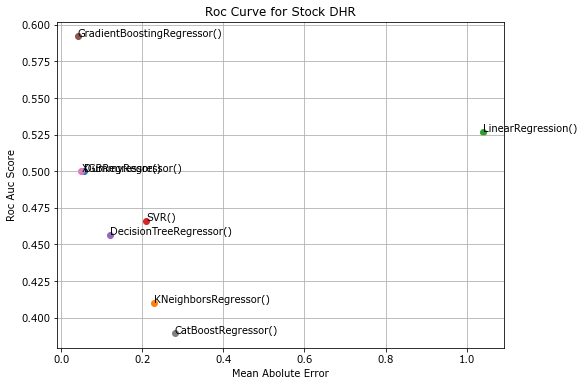

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 59.68it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'strategy': 'median'}
  Backtesting metric: 0.0028230270265817304



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_neighbors': 6, 'p': 5, 'weights': 'distance'}
  Backtesting metric: 1.6912342442346552e-09

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 27.10it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'copy_X': True, 'fit_intercept': True}
  Backtesting metric: 1.5643708530282194e-05

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'C': 10, 'coef0': 0.01, 'degree': 8, 'gamma': 'auto', 'kernel': 'rbf'}
  Backtesting metric: 6.464367717296668e-08

Number of models compared: 1920.


loop param_grid:  89%|█████████████████████████████▍   | 342/384 [00:01<00:00, 171.36it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:10<00:00,  2.18s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
  Backtesting metric: 9.188243124877006e-07

Number of models compared: 540.


loop param_grid:  66%|███████████████████████            | 71/108 [00:05<00:02, 15.59it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:34<00:00,  6.88s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
  Backtesting metric: 2.5232244259610697e-08

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.70it/s]

[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:06, 13.30it/s]


[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 11.84it/s]

[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.58it/s]

[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.49it/s]

[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.38it/s]

[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.32it/s]

[14:20:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.35it/s]

[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.53it/s]

[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.95it/s]

[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.78it/s]

[14:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.54it/s]

[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.67it/s]

[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.85it/s]

[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.55it/s]

[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.96it/s]

[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.94it/s]


[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 12.15it/s]

[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03, 11.50it/s]

[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.61it/s]


[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.27it/s]


[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.21it/s]


[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 11.28it/s]

[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 11.00it/s]


[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.72it/s]

[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.85it/s]

[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:00, 11.75it/s]

[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.68it/s]

[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.57it/s]

[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:07<00:00, 11.48it/s]


[14:20:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:08<00:00, 11.32it/s]

[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:05, 17.39it/s]

[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 14.68it/s]

[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 13.05it/s]

[14:20:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:06, 12.78it/s]


[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 12.02it/s]

[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.56it/s]


[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.80it/s]


[14:20:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.80it/s]

[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 11.86it/s]


[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.38it/s]

[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.97it/s]

[14:20:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 12.14it/s]

[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:04, 11.83it/s]


[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.29it/s]

[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 12.08it/s]

[14:20:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:03, 12.12it/s]

[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.74it/s]

[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 11.53it/s]

[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.41it/s]

[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.12it/s]


[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.16it/s]

[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.97it/s]

[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.02it/s]


[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 11.12it/s]

[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.43it/s]


[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 10.79it/s]


[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.67it/s]

[14:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 10.64it/s]

[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.29it/s]

[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.33it/s]

[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.35it/s]


[14:20:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.24it/s]


[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:07<00:00, 10.39it/s]

[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.00it/s]

[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid: 100%|████████████████████████████████████| 96/96 [00:08<00:00,  8.55it/s]
                                                                                          

[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:20:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.87it/s]

[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.89it/s]

[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.19it/s]


[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 11.44it/s]

[14:20:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 11.03it/s]

[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.45it/s]


[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.97it/s]


[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:06, 11.20it/s]

[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.19it/s]


[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.53it/s]

[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 11.44it/s]


[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.36it/s]

[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.30it/s]

[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.15it/s]

[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.11it/s]

[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:05, 10.12it/s]

[14:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.25it/s]

[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.26it/s]


[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:04, 10.74it/s]

[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:03, 10.96it/s]


[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.77it/s]


[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.67it/s]

[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.33it/s]

[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:06<00:03,  9.89it/s]

[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02, 10.05it/s]


[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.23it/s]

[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:01, 10.68it/s]

[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:07<00:01, 10.75it/s]


[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 11.30it/s]

[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 11.12it/s]

[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.65it/s]

[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:08<00:00, 10.36it/s]


[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00, 10.17it/s]

[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:08<00:00,  8.94it/s]

[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:26<00:17,  8.78s/it]

[14:20:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 13.52it/s]

[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.87it/s]

[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 12.41it/s]

[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 11.98it/s]

[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 11.01it/s]

[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.78it/s]

[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.70it/s]

[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:07, 10.38it/s]


[14:20:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:06, 10.47it/s]


[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.41it/s]


[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.32it/s]


[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:06, 10.53it/s]

[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:05, 10.57it/s]

[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.55it/s]

[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.79it/s]

[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.81it/s]

[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 10.83it/s]


[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.54it/s]


[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.33it/s]


[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.45it/s]

[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.13it/s]

[14:20:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:04,  9.71it/s]

[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  8.68it/s]

[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.80it/s]

[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  65%|███████████████████████▎            | 62/96 [00:05<00:03, 10.47it/s]

[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.92it/s]

[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02,  9.70it/s]

[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02,  9.14it/s]

[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02,  9.61it/s]

[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:07<00:02,  8.99it/s]


[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.47it/s]

[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  83%|██████████████████████████████      | 80/96 [00:07<00:01,  8.57it/s]

[14:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01,  9.82it/s]

[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.26it/s]


[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:08<00:00,  9.18it/s]

[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:09<00:00,  9.99it/s]

[14:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.81it/s]

[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:35<00:09,  9.12s/it]

[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 14.88it/s]

[14:20:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.12it/s]


[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 12.27it/s]

[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 12.26it/s]

[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 11.70it/s]

[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.69it/s]

[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.69it/s]

[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.97it/s]

[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.85it/s]


[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:05, 11.52it/s]

[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 10.98it/s]


[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.73it/s]

[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.21it/s]

[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.19it/s]

[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.52it/s]

[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.62it/s]

[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.54it/s]


[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.50it/s]

[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 11.10it/s]

[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 10.81it/s]

[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 10.29it/s]


[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.60it/s]

[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03, 10.53it/s]

[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.91it/s]

[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.84it/s]

[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 10.53it/s]

[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.70it/s]

[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 10.78it/s]

[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.08it/s]


[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.50it/s]


[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.57it/s]


[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.65it/s]


[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.45it/s]


[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.31it/s]


[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00, 10.30it/s]

[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00,  8.88it/s]

[14:20:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:08<00:00,  7.36it/s]

[14:20:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:44<00:00,  8.94s/it]


[14:20:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'colsample_bytree': 0.8, 'gamma': 0.7, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.4}
  Backtesting metric: 0.005615895144699256

Number of models compared: 60.


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.86it/s]

0:	learn: 0.2720578	total: 967us	remaining: 28.1ms
1:	learn: 0.2630778	total: 2.03ms	remaining: 28.4ms
2:	learn: 0.2553668	total: 2.96ms	remaining: 26.6ms
3:	learn: 0.2470667	total: 3.61ms	remaining: 23.5ms
4:	learn: 0.2394336	total: 4.32ms	remaining: 21.6ms
5:	learn: 0.2314536	total: 5.03ms	remaining: 20.1ms
6:	learn: 0.2238069	total: 5.72ms	remaining: 18.8ms
7:	learn: 0.2167325	total: 6.44ms	remaining: 17.7ms
8:	learn: 0.2104245	total: 7.81ms	remaining: 18.2ms
9:	learn: 0.2047274	total: 8.65ms	remaining: 17.3ms
10:	learn: 0.1979476	total: 9.9ms	remaining: 17.1ms
11:	learn: 0.1926025	total: 11ms	remaining: 16.4ms
12:	learn: 0.1867945	total: 11.8ms	remaining: 15.4ms
13:	learn: 0.1811503	total: 12.4ms	remaining: 14.2ms
14:	learn: 0.1765090	total: 13.2ms	remaining: 13.2ms
15:	learn: 0.1717510	total: 13.8ms	remaining: 12.1ms
16:	learn: 0.1666019	total: 14.6ms	remaining: 11.1ms
17:	learn: 0.1619193	total: 15.9ms	remaining: 10.6ms
18:	learn: 0.1582850	total: 16.8ms	remaining: 9.71ms
19:	lea


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:00,  9.20it/s]

1:	learn: 0.2630778	total: 1.53ms	remaining: 36.7ms
2:	learn: 0.2553668	total: 2.71ms	remaining: 42.5ms
3:	learn: 0.2470667	total: 3.72ms	remaining: 42.8ms
4:	learn: 0.2394336	total: 4.63ms	remaining: 41.7ms
5:	learn: 0.2314536	total: 5.38ms	remaining: 39.5ms
6:	learn: 0.2238069	total: 6.01ms	remaining: 36.9ms
7:	learn: 0.2167325	total: 6.75ms	remaining: 35.5ms
8:	learn: 0.2104245	total: 7.45ms	remaining: 33.9ms
9:	learn: 0.2047274	total: 8.12ms	remaining: 32.5ms
10:	learn: 0.1979476	total: 8.83ms	remaining: 31.3ms
11:	learn: 0.1926025	total: 9.52ms	remaining: 30.1ms
12:	learn: 0.1867945	total: 10.4ms	remaining: 29.7ms
13:	learn: 0.1811503	total: 11.3ms	remaining: 28.9ms
14:	learn: 0.1765090	total: 12ms	remaining: 28.1ms
15:	learn: 0.1717510	total: 12.7ms	remaining: 27ms
16:	learn: 0.1666019	total: 14ms	remaining: 27.1ms
17:	learn: 0.1619193	total: 14.9ms	remaining: 26.4ms
18:	learn: 0.1582850	total: 15.6ms	remaining: 25.5ms
19:	learn: 0.1538936	total: 16.8ms	remaining: 25.2ms
20:	lear


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.65it/s]


45:	learn: 0.0461219	total: 38.9ms	remaining: 3.38ms
46:	learn: 0.0452248	total: 39.8ms	remaining: 2.54ms
47:	learn: 0.0445372	total: 40.5ms	remaining: 1.69ms
48:	learn: 0.0434993	total: 41.2ms	remaining: 841us
49:	learn: 0.0428757	total: 42ms	remaining: 0us
0:	learn: 0.2721671	total: 1.62ms	remaining: 47.1ms
1:	learn: 0.2638257	total: 3.77ms	remaining: 52.7ms
2:	learn: 0.2552308	total: 5.89ms	remaining: 53ms
3:	learn: 0.2485114	total: 7.52ms	remaining: 48.9ms
4:	learn: 0.2399041	total: 8.08ms	remaining: 40.4ms
5:	learn: 0.2323189	total: 9.47ms	remaining: 37.9ms
6:	learn: 0.2260112	total: 11ms	remaining: 36ms
7:	learn: 0.2197994	total: 13.9ms	remaining: 38.1ms
8:	learn: 0.2133931	total: 15.5ms	remaining: 36.3ms
9:	learn: 0.2074931	total: 17.8ms	remaining: 35.6ms
10:	learn: 0.2010425	total: 19.8ms	remaining: 34.2ms
11:	learn: 0.1945531	total: 21.4ms	remaining: 32.1ms
12:	learn: 0.1889937	total: 22.8ms	remaining: 29.8ms
13:	learn: 0.1839134	total: 24.3ms	remaining: 27.8ms
14:	learn: 0.17

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.72it/s]

0:	learn: 0.2632473	total: 1.65ms	remaining: 47.9ms
1:	learn: 0.2473509	total: 3.15ms	remaining: 44.1ms
2:	learn: 0.2315262	total: 4.74ms	remaining: 42.7ms
3:	learn: 0.2197417	total: 6.32ms	remaining: 41.1ms
4:	learn: 0.2050507	total: 6.89ms	remaining: 34.4ms
5:	learn: 0.1924496	total: 8.36ms	remaining: 33.5ms
6:	learn: 0.1827994	total: 9.67ms	remaining: 31.8ms
7:	learn: 0.1730771	total: 11ms	remaining: 30.4ms



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  8.65it/s]

8:	learn: 0.1634988	total: 12.8ms	remaining: 30ms
9:	learn: 0.1552018	total: 15.5ms	remaining: 31ms
10:	learn: 0.1466520	total: 17.4ms	remaining: 30ms
11:	learn: 0.1383852	total: 19.2ms	remaining: 28.9ms
12:	learn: 0.1319371	total: 20.8ms	remaining: 27.1ms
13:	learn: 0.1260137	total: 22.3ms	remaining: 25.5ms
14:	learn: 0.1190765	total: 23ms	remaining: 23ms
15:	learn: 0.1133689	total: 24.5ms	remaining: 21.4ms
16:	learn: 0.1088666	total: 26ms	remaining: 19.9ms
17:	learn: 0.1042526	total: 27.8ms	remaining: 18.5ms
18:	learn: 0.0998570	total: 30.6ms	remaining: 17.7ms
19:	learn: 0.0953628	total: 32.7ms	remaining: 16.3ms
20:	learn: 0.0912349	total: 34.2ms	remaining: 14.7ms
21:	learn: 0.0886604	total: 35.6ms	remaining: 13ms
22:	learn: 0.0858452	total: 37ms	remaining: 11.3ms
23:	learn: 0.0829090	total: 39.7ms	remaining: 9.93ms
24:	learn: 0.0794980	total: 41.4ms	remaining: 8.28ms
25:	learn: 0.0763746	total: 42.3ms	remaining: 6.51ms
26:	learn: 0.0736366	total: 44.6ms	remaining: 4.95ms
27:	learn: 


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  7.34it/s]

35:	learn: 0.1037059	total: 64.8ms	remaining: 25.2ms
36:	learn: 0.1018277	total: 66.2ms	remaining: 23.2ms
37:	learn: 0.0993234	total: 68.4ms	remaining: 21.6ms
38:	learn: 0.0974684	total: 70.4ms	remaining: 19.9ms
39:	learn: 0.0953753	total: 72.7ms	remaining: 18.2ms
40:	learn: 0.0932911	total: 75ms	remaining: 16.5ms
41:	learn: 0.0910844	total: 77.7ms	remaining: 14.8ms
42:	learn: 0.0890744	total: 80.3ms	remaining: 13.1ms
43:	learn: 0.0874395	total: 82.6ms	remaining: 11.3ms
44:	learn: 0.0857522	total: 84.6ms	remaining: 9.4ms
45:	learn: 0.0841162	total: 87.6ms	remaining: 7.62ms
46:	learn: 0.0822555	total: 88.7ms	remaining: 5.66ms
47:	learn: 0.0806382	total: 91.3ms	remaining: 3.8ms
48:	learn: 0.0790240	total: 94.2ms	remaining: 1.92ms
49:	learn: 0.0774457	total: 95.7ms	remaining: 0us
0:	learn: 0.2632473	total: 1.72ms	remaining: 84ms
1:	learn: 0.2473509	total: 4.24ms	remaining: 102ms
2:	learn: 0.2315262	total: 6.13ms	remaining: 96.1ms
3:	learn: 0.2197417	total: 8.03ms	remaining: 92.4ms
4:	lear


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.69it/s]

38:	learn: 0.0506749	total: 70.5ms	remaining: 19.9ms
39:	learn: 0.0494303	total: 72.5ms	remaining: 18.1ms
40:	learn: 0.0483103	total: 74ms	remaining: 16.3ms
41:	learn: 0.0470920	total: 75.6ms	remaining: 14.4ms
42:	learn: 0.0460917	total: 78ms	remaining: 12.7ms
43:	learn: 0.0449850	total: 79.7ms	remaining: 10.9ms
44:	learn: 0.0439612	total: 82.2ms	remaining: 9.14ms
45:	learn: 0.0433662	total: 83.6ms	remaining: 7.27ms
46:	learn: 0.0425768	total: 85.1ms	remaining: 5.43ms
47:	learn: 0.0417027	total: 86.7ms	remaining: 3.61ms
48:	learn: 0.0411260	total: 88.8ms	remaining: 1.81ms
49:	learn: 0.0404095	total: 90.4ms	remaining: 0us
0:	learn: 0.2728366	total: 5.66ms	remaining: 164ms
1:	learn: 0.2642506	total: 12.7ms	remaining: 178ms
2:	learn: 0.2554456	total: 18.5ms	remaining: 166ms
3:	learn: 0.2474169	total: 25.1ms	remaining: 163ms
4:	learn: 0.2390483	total: 30.1ms	remaining: 151ms
5:	learn: 0.2322917	total: 34.6ms	remaining: 138ms
6:	learn: 0.2252745	total: 40.7ms	remaining: 134ms
7:	learn: 0.21


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.52it/s]

15:	learn: 0.1751980	total: 89.9ms	remaining: 78.6ms
16:	learn: 0.1713067	total: 95.8ms	remaining: 73.2ms
17:	learn: 0.1671823	total: 101ms	remaining: 67ms
18:	learn: 0.1626751	total: 102ms	remaining: 58.9ms
19:	learn: 0.1583262	total: 108ms	remaining: 54ms
20:	learn: 0.1537359	total: 115ms	remaining: 49.2ms
21:	learn: 0.1504534	total: 122ms	remaining: 44.2ms
22:	learn: 0.1467965	total: 127ms	remaining: 38.7ms
23:	learn: 0.1426173	total: 132ms	remaining: 33ms
24:	learn: 0.1384535	total: 137ms	remaining: 27.4ms
25:	learn: 0.1356659	total: 145ms	remaining: 22.3ms
26:	learn: 0.1325513	total: 149ms	remaining: 16.6ms
27:	learn: 0.1294060	total: 156ms	remaining: 11.2ms
28:	learn: 0.1267687	total: 163ms	remaining: 5.63ms
29:	learn: 0.1239116	total: 171ms	remaining: 0us
0:	learn: 0.2645767	total: 6.46ms	remaining: 187ms
1:	learn: 0.2480809	total: 12.1ms	remaining: 169ms
2:	learn: 0.2317048	total: 19.2ms	remaining: 172ms
3:	learn: 0.2174737	total: 25ms	remaining: 163ms
4:	learn: 0.2030914	total

29:	learn: 0.0647176	total: 181ms	remaining: 0us


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.72it/s]

0:	learn: 0.2728366	total: 11.4ms	remaining: 559ms
1:	learn: 0.2642506	total: 22.5ms	remaining: 541ms
2:	learn: 0.2554456	total: 35.1ms	remaining: 550ms
3:	learn: 0.2474169	total: 44.2ms	remaining: 508ms
4:	learn: 0.2390483	total: 54.3ms	remaining: 488ms
5:	learn: 0.2322917	total: 63.2ms	remaining: 464ms
6:	learn: 0.2252745	total: 72.8ms	remaining: 447ms
7:	learn: 0.2178139	total: 76.2ms	remaining: 400ms
8:	learn: 0.2110667	total: 85ms	remaining: 387ms
9:	learn: 0.2057250	total: 94.5ms	remaining: 378ms
10:	learn: 0.2005894	total: 102ms	remaining: 362ms
11:	learn: 0.1946861	total: 111ms	remaining: 350ms
12:	learn: 0.1890932	total: 116ms	remaining: 330ms
13:	learn: 0.1847396	total: 128ms	remaining: 328ms
14:	learn: 0.1801896	total: 138ms	remaining: 322ms
15:	learn: 0.1751980	total: 148ms	remaining: 315ms
16:	learn: 0.1713067	total: 158ms	remaining: 307ms
17:	learn: 0.1671823	total: 171ms	remaining: 303ms
18:	learn: 0.1626751	total: 172ms	remaining: 281ms
19:	learn: 0.1583262	total: 183ms


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.11it/s]

0:	learn: 0.2645767	total: 6.47ms	remaining: 317ms
1:	learn: 0.2480809	total: 15ms	remaining: 359ms
2:	learn: 0.2317048	total: 21.2ms	remaining: 332ms
3:	learn: 0.2174737	total: 27.1ms	remaining: 312ms
4:	learn: 0.2030914	total: 35ms	remaining: 315ms
5:	learn: 0.1920541	total: 40.5ms	remaining: 297ms
6:	learn: 0.1809332	total: 45.7ms	remaining: 281ms
7:	learn: 0.1697441	total: 47.1ms	remaining: 247ms
8:	learn: 0.1599680	total: 53.1ms	remaining: 242ms
9:	learn: 0.1525316	total: 60.2ms	remaining: 241ms
10:	learn: 0.1457014	total: 65.6ms	remaining: 232ms
11:	learn: 0.1379495	total: 71.8ms	remaining: 227ms
12:	learn: 0.1311471	total: 74.9ms	remaining: 213ms
13:	learn: 0.1263931	total: 79.9ms	remaining: 205ms
14:	learn: 0.1201903	total: 88.4ms	remaining: 206ms
15:	learn: 0.1147340	total: 95.9ms	remaining: 204ms
16:	learn: 0.1107786	total: 103ms	remaining: 200ms
17:	learn: 0.1063210	total: 109ms	remaining: 194ms
18:	learn: 0.1012381	total: 118ms	remaining: 192ms
19:	learn: 0.0969659	total: 1


loop lags_grid:  20%|███████▊                               | 1/5 [00:02<00:10,  2.55s/it]

30:	learn: 0.0624608	total: 187ms	remaining: 115ms
31:	learn: 0.0604914	total: 192ms	remaining: 108ms
32:	learn: 0.0586486	total: 197ms	remaining: 101ms
33:	learn: 0.0565902	total: 202ms	remaining: 95.1ms
34:	learn: 0.0547126	total: 207ms	remaining: 88.6ms
35:	learn: 0.0531906	total: 213ms	remaining: 83ms
36:	learn: 0.0516902	total: 218ms	remaining: 76.7ms
37:	learn: 0.0502369	total: 222ms	remaining: 70.2ms
38:	learn: 0.0489102	total: 228ms	remaining: 64.3ms
39:	learn: 0.0474116	total: 234ms	remaining: 58.4ms
40:	learn: 0.0462516	total: 239ms	remaining: 52.4ms
41:	learn: 0.0449925	total: 243ms	remaining: 46.2ms
42:	learn: 0.0435656	total: 246ms	remaining: 40.1ms
43:	learn: 0.0422029	total: 250ms	remaining: 34.1ms
44:	learn: 0.0410587	total: 255ms	remaining: 28.3ms
45:	learn: 0.0399259	total: 259ms	remaining: 22.5ms
46:	learn: 0.0389288	total: 263ms	remaining: 16.8ms
47:	learn: 0.0380597	total: 267ms	remaining: 11.1ms
48:	learn: 0.0371883	total: 271ms	remaining: 5.54ms
49:	learn: 0.0360


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2535512	total: 1.4ms	remaining: 40.7ms
1:	learn: 0.2454674	total: 2.37ms	remaining: 33.1ms
2:	learn: 0.2382740	total: 3.22ms	remaining: 28.9ms
3:	learn: 0.2309704	total: 3.87ms	remaining: 25.1ms
4:	learn: 0.2238661	total: 4.63ms	remaining: 23.2ms



loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  9.69it/s]

5:	learn: 0.2170223	total: 6.4ms	remaining: 25.6ms
6:	learn: 0.2109047	total: 7.39ms	remaining: 24.3ms
7:	learn: 0.2049765	total: 8.67ms	remaining: 23.8ms
8:	learn: 0.1995515	total: 9.86ms	remaining: 23ms
9:	learn: 0.1949971	total: 11.1ms	remaining: 22.1ms
10:	learn: 0.1891628	total: 11.4ms	remaining: 19.7ms
11:	learn: 0.1835584	total: 12.2ms	remaining: 18.3ms
12:	learn: 0.1781133	total: 13.1ms	remaining: 17.1ms
13:	learn: 0.1737894	total: 14.2ms	remaining: 16.2ms
14:	learn: 0.1693583	total: 15.4ms	remaining: 15.4ms
15:	learn: 0.1650021	total: 16.2ms	remaining: 14.1ms
16:	learn: 0.1601860	total: 17.5ms	remaining: 13.4ms
17:	learn: 0.1564435	total: 18.7ms	remaining: 12.5ms
18:	learn: 0.1521452	total: 20.1ms	remaining: 11.6ms
19:	learn: 0.1487083	total: 20.5ms	remaining: 10.3ms
20:	learn: 0.1454387	total: 21.8ms	remaining: 9.36ms
21:	learn: 0.1424727	total: 22.6ms	remaining: 8.23ms
22:	learn: 0.1390228	total: 23.5ms	remaining: 7.15ms
23:	learn: 0.1360032	total: 24.8ms	remaining: 6.19ms
2


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.13it/s]

0:	learn: 0.2535512	total: 1.44ms	remaining: 70.6ms
1:	learn: 0.2454674	total: 2.23ms	remaining: 53.5ms
2:	learn: 0.2382740	total: 3.08ms	remaining: 48.3ms
3:	learn: 0.2309704	total: 4.21ms	remaining: 48.4ms
4:	learn: 0.2238661	total: 5.28ms	remaining: 47.5ms
5:	learn: 0.2170223	total: 6.14ms	remaining: 45ms
6:	learn: 0.2109047	total: 6.83ms	remaining: 42ms
7:	learn: 0.2049765	total: 7.81ms	remaining: 41ms
8:	learn: 0.1995515	total: 8.87ms	remaining: 40.4ms
9:	learn: 0.1949971	total: 9.93ms	remaining: 39.7ms
10:	learn: 0.1891628	total: 10.7ms	remaining: 37.8ms
11:	learn: 0.1835584	total: 11.9ms	remaining: 37.6ms
12:	learn: 0.1781133	total: 13.4ms	remaining: 38.2ms
13:	learn: 0.1737894	total: 14.3ms	remaining: 36.9ms
14:	learn: 0.1693583	total: 15.2ms	remaining: 35.5ms
15:	learn: 0.1650021	total: 16.5ms	remaining: 35ms
16:	learn: 0.1601860	total: 17.5ms	remaining: 34.1ms
17:	learn: 0.1564435	total: 18.4ms	remaining: 32.7ms
18:	learn: 0.1521452	total: 19.4ms	remaining: 31.7ms
19:	learn: 


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  6.57it/s]

12:	learn: 0.1286470	total: 20.5ms	remaining: 58.4ms
13:	learn: 0.1231890	total: 21.9ms	remaining: 56.4ms
14:	learn: 0.1186676	total: 22.9ms	remaining: 53.4ms
15:	learn: 0.1122399	total: 24ms	remaining: 51.1ms
16:	learn: 0.1068290	total: 26ms	remaining: 50.4ms
17:	learn: 0.1029961	total: 27.5ms	remaining: 48.8ms
18:	learn: 0.0991215	total: 28.7ms	remaining: 46.9ms
19:	learn: 0.0964629	total: 29.5ms	remaining: 44.3ms
20:	learn: 0.0937155	total: 30.8ms	remaining: 42.5ms
21:	learn: 0.0906201	total: 32.6ms	remaining: 41.4ms
22:	learn: 0.0881238	total: 34.4ms	remaining: 40.4ms
23:	learn: 0.0849629	total: 36.4ms	remaining: 39.5ms
24:	learn: 0.0820479	total: 38ms	remaining: 38ms
25:	learn: 0.0798719	total: 40ms	remaining: 36.9ms
26:	learn: 0.0773228	total: 41.5ms	remaining: 35.4ms
27:	learn: 0.0753708	total: 42.7ms	remaining: 33.6ms
28:	learn: 0.0733283	total: 43.9ms	remaining: 31.8ms
29:	learn: 0.0709270	total: 45.3ms	remaining: 30.2ms
30:	learn: 0.0688240	total: 46.8ms	remaining: 28.7ms
31:


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.12it/s]

1:	learn: 0.2476189	total: 9.1ms	remaining: 127ms
2:	learn: 0.2403823	total: 13.6ms	remaining: 122ms
3:	learn: 0.2326300	total: 16.8ms	remaining: 109ms
4:	learn: 0.2260261	total: 22.3ms	remaining: 111ms
5:	learn: 0.2206076	total: 26.9ms	remaining: 107ms
6:	learn: 0.2141859	total: 29.6ms	remaining: 97.2ms
7:	learn: 0.2074515	total: 30.2ms	remaining: 83.1ms
8:	learn: 0.2019392	total: 34.3ms	remaining: 80ms
9:	learn: 0.1952962	total: 35.9ms	remaining: 71.8ms
10:	learn: 0.1896481	total: 40.4ms	remaining: 69.8ms
11:	learn: 0.1844517	total: 43ms	remaining: 64.5ms
12:	learn: 0.1794524	total: 46.1ms	remaining: 60.3ms
13:	learn: 0.1748587	total: 47.2ms	remaining: 53.9ms
14:	learn: 0.1700710	total: 48.2ms	remaining: 48.2ms
15:	learn: 0.1657430	total: 51.2ms	remaining: 44.8ms
16:	learn: 0.1614386	total: 53.7ms	remaining: 41ms
17:	learn: 0.1573771	total: 56ms	remaining: 37.3ms
18:	learn: 0.1538681	total: 59.2ms	remaining: 34.2ms
19:	learn: 0.1500684	total: 62.6ms	remaining: 31.3ms
20:	learn: 0.146


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.08it/s]

5:	learn: 0.1861135	total: 19.3ms	remaining: 77.1ms
6:	learn: 0.1762436	total: 22.1ms	remaining: 72.5ms
7:	learn: 0.1662189	total: 22.8ms	remaining: 62.6ms
8:	learn: 0.1580633	total: 25.2ms	remaining: 58.7ms
9:	learn: 0.1487729	total: 26.8ms	remaining: 53.5ms
10:	learn: 0.1411795	total: 29.8ms	remaining: 51.6ms
11:	learn: 0.1345170	total: 32.9ms	remaining: 49.3ms
12:	learn: 0.1278755	total: 36ms	remaining: 47ms
13:	learn: 0.1223261	total: 38.6ms	remaining: 44.2ms
14:	learn: 0.1162209	total: 41.3ms	remaining: 41.3ms
15:	learn: 0.1107303	total: 44.1ms	remaining: 38.6ms
16:	learn: 0.1058070	total: 46.6ms	remaining: 35.7ms
17:	learn: 0.1016549	total: 49.1ms	remaining: 32.7ms
18:	learn: 0.0966444	total: 53.1ms	remaining: 30.8ms
19:	learn: 0.0930963	total: 56.1ms	remaining: 28ms
20:	learn: 0.0897677	total: 58.8ms	remaining: 25.2ms
21:	learn: 0.0861808	total: 62ms	remaining: 22.5ms
22:	learn: 0.0826763	total: 64.5ms	remaining: 19.6ms
23:	learn: 0.0794918	total: 68.1ms	remaining: 17ms
24:	lear


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.21it/s]

12:	learn: 0.1794524	total: 33.7ms	remaining: 95.8ms
13:	learn: 0.1748587	total: 35.2ms	remaining: 90.6ms
14:	learn: 0.1700710	total: 36.2ms	remaining: 84.5ms
15:	learn: 0.1657430	total: 39.3ms	remaining: 83.4ms
16:	learn: 0.1614386	total: 42.3ms	remaining: 82.1ms
17:	learn: 0.1573771	total: 45.1ms	remaining: 80.2ms
18:	learn: 0.1538681	total: 47.8ms	remaining: 78ms
19:	learn: 0.1500684	total: 50.2ms	remaining: 75.3ms
20:	learn: 0.1468310	total: 53.1ms	remaining: 73.3ms
21:	learn: 0.1430649	total: 55.8ms	remaining: 71ms
22:	learn: 0.1390910	total: 57.7ms	remaining: 67.7ms
23:	learn: 0.1353375	total: 59.7ms	remaining: 64.7ms
24:	learn: 0.1323670	total: 61.9ms	remaining: 61.9ms
25:	learn: 0.1292706	total: 63.9ms	remaining: 59ms
26:	learn: 0.1263392	total: 66.4ms	remaining: 56.5ms
27:	learn: 0.1236475	total: 69.9ms	remaining: 55ms
28:	learn: 0.1213007	total: 72.8ms	remaining: 52.7ms
29:	learn: 0.1186255	total: 75.4ms	remaining: 50.3ms
30:	learn: 0.1163490	total: 77.5ms	remaining: 47.5ms
3

0:	learn: 0.2469614	total: 4.4ms	remaining: 215ms
1:	learn: 0.2337357	total: 6.99ms	remaining: 168ms
2:	learn: 0.2202431	total: 9.34ms	remaining: 146ms
3:	learn: 0.2063282	total: 13.1ms	remaining: 151ms
4:	learn: 0.1949701	total: 16.2ms	remaining: 146ms
5:	learn: 0.1861135	total: 20ms	remaining: 146ms
6:	learn: 0.1762436	total: 22ms	remaining: 135ms
7:	learn: 0.1662189	total: 22.7ms	remaining: 119ms
8:	learn: 0.1580633	total: 26.1ms	remaining: 119ms
9:	learn: 0.1487729	total: 28.6ms	remaining: 115ms
10:	learn: 0.1411795	total: 30.8ms	remaining: 109ms
11:	learn: 0.1345170	total: 33.2ms	remaining: 105ms
12:	learn: 0.1278755	total: 36ms	remaining: 102ms
13:	learn: 0.1223261	total: 39.8ms	remaining: 102ms
14:	learn: 0.1162209	total: 42.9ms	remaining: 100ms
15:	learn: 0.1107303	total: 45.2ms	remaining: 96ms
16:	learn: 0.1058070	total: 49.3ms	remaining: 95.7ms
17:	learn: 0.1016549	total: 54.2ms	remaining: 96.3ms
18:	learn: 0.0966444	total: 57.1ms	remaining: 93.1ms
19:	learn: 0.0930963	total:

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  4.75it/s]

0:	learn: 0.2549557	total: 7.84ms	remaining: 227ms
1:	learn: 0.2482429	total: 16.3ms	remaining: 229ms
2:	learn: 0.2408498	total: 22.1ms	remaining: 199ms
3:	learn: 0.2337126	total: 29.3ms	remaining: 191ms
4:	learn: 0.2284221	total: 35.7ms	remaining: 178ms
5:	learn: 0.2220674	total: 42.1ms	remaining: 168ms
6:	learn: 0.2165777	total: 47.9ms	remaining: 157ms
7:	learn: 0.2092425	total: 48.7ms	remaining: 134ms
8:	learn: 0.2033353	total: 54.1ms	remaining: 126ms
9:	learn: 0.1983054	total: 60.1ms	remaining: 120ms
10:	learn: 0.1928974	total: 67.1ms	remaining: 116ms
11:	learn: 0.1876025	total: 74.3ms	remaining: 111ms
12:	learn: 0.1831556	total: 81ms	remaining: 106ms
13:	learn: 0.1786271	total: 86.6ms	remaining: 99ms
14:	learn: 0.1739891	total: 92.6ms	remaining: 92.6ms
15:	learn: 0.1697382	total: 99.5ms	remaining: 87.1ms
16:	learn: 0.1661823	total: 106ms	remaining: 81ms
17:	learn: 0.1622666	total: 113ms	remaining: 75ms
18:	learn: 0.1583258	total: 120ms	remaining: 69.3ms
19:	learn: 0.1544610	total:


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.40it/s]

27:	learn: 0.1274720	total: 168ms	remaining: 12ms
28:	learn: 0.1249303	total: 171ms	remaining: 5.9ms
29:	learn: 0.1221717	total: 178ms	remaining: 0us
0:	learn: 0.2478870	total: 20.2ms	remaining: 587ms
1:	learn: 0.2349655	total: 33.2ms	remaining: 465ms
2:	learn: 0.2210729	total: 46.1ms	remaining: 415ms
3:	learn: 0.2081330	total: 58.8ms	remaining: 382ms
4:	learn: 0.1990014	total: 73ms	remaining: 365ms
5:	learn: 0.1875475	total: 77.9ms	remaining: 312ms
6:	learn: 0.1794428	total: 82.3ms	remaining: 270ms
7:	learn: 0.1683768	total: 85.6ms	remaining: 236ms
8:	learn: 0.1613057	total: 101ms	remaining: 236ms
9:	learn: 0.1544799	total: 114ms	remaining: 228ms
10:	learn: 0.1461719	total: 124ms	remaining: 214ms
11:	learn: 0.1388454	total: 136ms	remaining: 204ms
12:	learn: 0.1332721	total: 148ms	remaining: 194ms
13:	learn: 0.1264947	total: 152ms	remaining: 173ms
14:	learn: 0.1214284	total: 165ms	remaining: 165ms
15:	learn: 0.1154614	total: 175ms	remaining: 153ms
16:	learn: 0.1106774	total: 186ms	rema


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:02<00:00,  3.49it/s]

26:	learn: 0.0735132	total: 268ms	remaining: 29.8ms
27:	learn: 0.0711235	total: 276ms	remaining: 19.7ms
28:	learn: 0.0685372	total: 284ms	remaining: 9.81ms
29:	learn: 0.0661887	total: 293ms	remaining: 0us
0:	learn: 0.2549557	total: 12.6ms	remaining: 616ms
1:	learn: 0.2482429	total: 21.7ms	remaining: 521ms
2:	learn: 0.2408498	total: 29.7ms	remaining: 465ms
3:	learn: 0.2337126	total: 39.3ms	remaining: 452ms
4:	learn: 0.2284221	total: 46.4ms	remaining: 418ms
5:	learn: 0.2220674	total: 55.7ms	remaining: 408ms
6:	learn: 0.2165777	total: 64.3ms	remaining: 395ms
7:	learn: 0.2092425	total: 65.6ms	remaining: 345ms
8:	learn: 0.2033353	total: 74ms	remaining: 337ms
9:	learn: 0.1983054	total: 83.7ms	remaining: 335ms
10:	learn: 0.1928974	total: 92.5ms	remaining: 328ms
11:	learn: 0.1876025	total: 102ms	remaining: 323ms
12:	learn: 0.1831556	total: 108ms	remaining: 309ms
13:	learn: 0.1786271	total: 114ms	remaining: 293ms
14:	learn: 0.1739891	total: 119ms	remaining: 278ms
15:	learn: 0.1697382	total: 126


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.04it/s]

37:	learn: 0.1025537	total: 252ms	remaining: 79.6ms
38:	learn: 0.1008629	total: 259ms	remaining: 73ms
39:	learn: 0.0990841	total: 266ms	remaining: 66.5ms
40:	learn: 0.0966966	total: 268ms	remaining: 58.9ms
41:	learn: 0.0947750	total: 274ms	remaining: 52.2ms
42:	learn: 0.0929730	total: 280ms	remaining: 45.6ms
43:	learn: 0.0909568	total: 283ms	remaining: 38.6ms
44:	learn: 0.0895165	total: 289ms	remaining: 32.1ms
45:	learn: 0.0877076	total: 295ms	remaining: 25.6ms
46:	learn: 0.0859896	total: 301ms	remaining: 19.2ms
47:	learn: 0.0841110	total: 308ms	remaining: 12.8ms
48:	learn: 0.0821376	total: 311ms	remaining: 6.35ms
49:	learn: 0.0804512	total: 317ms	remaining: 0us
0:	learn: 0.2478870	total: 6.14ms	remaining: 301ms
1:	learn: 0.2349655	total: 12ms	remaining: 289ms
2:	learn: 0.2210729	total: 16.9ms	remaining: 264ms
3:	learn: 0.2081330	total: 22ms	remaining: 253ms
4:	learn: 0.1990014	total: 27.4ms	remaining: 247ms
5:	learn: 0.1875475	total: 29.6ms	remaining: 217ms
6:	learn: 0.1794428	total: 


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:05<00:08,  2.76s/it]

38:	learn: 0.0499873	total: 222ms	remaining: 62.5ms
39:	learn: 0.0487884	total: 228ms	remaining: 57.1ms
40:	learn: 0.0475304	total: 234ms	remaining: 51.4ms
41:	learn: 0.0460775	total: 240ms	remaining: 45.8ms
42:	learn: 0.0448574	total: 246ms	remaining: 40ms
43:	learn: 0.0435913	total: 251ms	remaining: 34.2ms
44:	learn: 0.0425741	total: 260ms	remaining: 28.9ms
45:	learn: 0.0416137	total: 262ms	remaining: 22.7ms
46:	learn: 0.0404107	total: 268ms	remaining: 17.1ms
47:	learn: 0.0394515	total: 270ms	remaining: 11.2ms
48:	learn: 0.0383474	total: 277ms	remaining: 5.66ms
49:	learn: 0.0373605	total: 284ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2100667	total: 1.4ms	remaining: 40.5ms
1:	learn: 0.2050016	total: 2.4ms	remaining: 33.6ms
2:	learn: 0.1998213	total: 8.97ms	remaining: 80.8ms
3:	learn: 0.1944298	total: 10.7ms	remaining: 69.9ms
4:	learn: 0.1899009	total: 12ms	remaining: 59.9ms
5:	learn: 0.1847438	total: 13.1ms	remaining: 52.3ms
6:	learn: 0.1803364	total: 14.5ms	remaining: 47.6ms
7:	learn: 0.1765746	total: 15.9ms	remaining: 43.8ms
8:	learn: 0.1723954	total: 17.1ms	remaining: 39.8ms
9:	learn: 0.1687093	total: 18ms	remaining: 36.1ms
10:	learn: 0.1650697	total: 19.4ms	remaining: 33.4ms
11:	learn: 0.1610893	total: 20.8ms	remaining: 31.2ms
12:	learn: 0.1569380	total: 22.2ms	remaining: 29.1ms
13:	learn: 0.1534045	total: 23.6ms	remaining: 27ms
14:	learn: 0.1490782	total: 24.8ms	remaining: 24.8ms
15:	learn: 0.1455696	total: 26ms	remaining: 22.8ms
16:	learn: 0.1418719	total: 27.2ms	remaining: 20.8ms
17:	learn: 0.1387196	total: 28.1ms	remaining: 18.7ms
18:	learn: 0.1359784	total: 29.1ms	remaining: 16.9ms
19:	learn: 0.


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.64it/s]

21:	learn: 0.1277834	total: 33.2ms	remaining: 12.1ms
22:	learn: 0.1249785	total: 34.6ms	remaining: 10.5ms
23:	learn: 0.1225261	total: 35.9ms	remaining: 8.97ms
24:	learn: 0.1200530	total: 37.1ms	remaining: 7.43ms
25:	learn: 0.1175451	total: 38.3ms	remaining: 5.89ms
26:	learn: 0.1155439	total: 39.3ms	remaining: 4.36ms
27:	learn: 0.1134350	total: 40.3ms	remaining: 2.88ms
28:	learn: 0.1110646	total: 41.6ms	remaining: 1.44ms
29:	learn: 0.1089998	total: 42.7ms	remaining: 0us
0:	learn: 0.2041018	total: 1.17ms	remaining: 34ms
1:	learn: 0.1943706	total: 2.21ms	remaining: 31ms
2:	learn: 0.1846870	total: 3.28ms	remaining: 29.5ms
3:	learn: 0.1749511	total: 4.55ms	remaining: 29.6ms
4:	learn: 0.1670919	total: 5.84ms	remaining: 29.2ms
5:	learn: 0.1584269	total: 6.74ms	remaining: 27ms
6:	learn: 0.1509966	total: 7.7ms	remaining: 25.3ms
7:	learn: 0.1452115	total: 8.69ms	remaining: 23.9ms
8:	learn: 0.1383351	total: 9.73ms	remaining: 22.7ms
9:	learn: 0.1328448	total: 10.8ms	remaining: 21.6ms
10:	learn: 0.

28:	learn: 0.0671069	total: 55.1ms	remaining: 1.9ms
29:	learn: 0.0653345	total: 59.1ms	remaining: 0us


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  7.37it/s]


0:	learn: 0.2100667	total: 1.55ms	remaining: 75.9ms
1:	learn: 0.2050016	total: 2.97ms	remaining: 71.3ms
2:	learn: 0.1998213	total: 4.65ms	remaining: 72.9ms
3:	learn: 0.1944298	total: 6.49ms	remaining: 74.7ms
4:	learn: 0.1899009	total: 7.68ms	remaining: 69.1ms
5:	learn: 0.1847438	total: 8.98ms	remaining: 65.9ms
6:	learn: 0.1803364	total: 10.2ms	remaining: 62.7ms
7:	learn: 0.1765746	total: 11.4ms	remaining: 59.8ms
8:	learn: 0.1723954	total: 12.7ms	remaining: 57.7ms
9:	learn: 0.1687093	total: 13.6ms	remaining: 54.5ms
10:	learn: 0.1650697	total: 14.6ms	remaining: 51.9ms
11:	learn: 0.1610893	total: 15.6ms	remaining: 49.4ms
12:	learn: 0.1569380	total: 16.6ms	remaining: 47.1ms
13:	learn: 0.1534045	total: 17.6ms	remaining: 45.2ms
14:	learn: 0.1490782	total: 18.4ms	remaining: 43ms
15:	learn: 0.1455696	total: 19.5ms	remaining: 41.4ms
16:	learn: 0.1418719	total: 20.5ms	remaining: 39.8ms
17:	learn: 0.1387196	total: 21.5ms	remaining: 38.2ms
18:	learn: 0.1359784	total: 22.6ms	remaining: 36.8ms
19:	l

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  6.62it/s]

0:	learn: 0.2041018	total: 1.29ms	remaining: 63.4ms
1:	learn: 0.1943706	total: 2.36ms	remaining: 56.7ms



loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  6.43it/s]

2:	learn: 0.1846870	total: 3.63ms	remaining: 56.9ms
3:	learn: 0.1749511	total: 4.79ms	remaining: 55.1ms
4:	learn: 0.1670919	total: 6.03ms	remaining: 54.3ms
5:	learn: 0.1584269	total: 7.25ms	remaining: 53.2ms
6:	learn: 0.1509966	total: 9.2ms	remaining: 56.5ms
7:	learn: 0.1452115	total: 10.6ms	remaining: 55.4ms
8:	learn: 0.1383351	total: 12.4ms	remaining: 56.4ms
9:	learn: 0.1328448	total: 14.4ms	remaining: 57.7ms
10:	learn: 0.1277625	total: 15.5ms	remaining: 54.9ms
11:	learn: 0.1231398	total: 16.5ms	remaining: 52.4ms
12:	learn: 0.1175017	total: 17.7ms	remaining: 50.4ms
13:	learn: 0.1124251	total: 18.9ms	remaining: 48.5ms
14:	learn: 0.1068672	total: 19.9ms	remaining: 46.5ms
15:	learn: 0.1025021	total: 21.5ms	remaining: 45.7ms
16:	learn: 0.0980153	total: 22.8ms	remaining: 44.3ms
17:	learn: 0.0939530	total: 24.1ms	remaining: 42.9ms
18:	learn: 0.0908176	total: 25.5ms	remaining: 41.6ms
19:	learn: 0.0879670	total: 27ms	remaining: 40.5ms
20:	learn: 0.0846188	total: 28.6ms	remaining: 39.5ms
21:	


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.30it/s]

10:	learn: 0.1675498	total: 27.9ms	remaining: 48.2ms
11:	learn: 0.1628878	total: 30.6ms	remaining: 45.8ms
12:	learn: 0.1593333	total: 33.5ms	remaining: 43.9ms
13:	learn: 0.1556574	total: 36.6ms	remaining: 41.8ms
14:	learn: 0.1518420	total: 40ms	remaining: 40ms
15:	learn: 0.1479685	total: 43.2ms	remaining: 37.8ms
16:	learn: 0.1443937	total: 44ms	remaining: 33.7ms
17:	learn: 0.1410808	total: 47ms	remaining: 31.3ms
18:	learn: 0.1372488	total: 49.7ms	remaining: 28.8ms
19:	learn: 0.1339458	total: 51ms	remaining: 25.5ms
20:	learn: 0.1309428	total: 54ms	remaining: 23.1ms
21:	learn: 0.1281288	total: 57.1ms	remaining: 20.8ms
22:	learn: 0.1250653	total: 59.4ms	remaining: 18.1ms
23:	learn: 0.1222632	total: 61.7ms	remaining: 15.4ms
24:	learn: 0.1199470	total: 64.9ms	remaining: 13ms
25:	learn: 0.1170735	total: 68.1ms	remaining: 10.5ms
26:	learn: 0.1145136	total: 69.9ms	remaining: 7.77ms
27:	learn: 0.1115766	total: 70.6ms	remaining: 5.04ms
28:	learn: 0.1092977	total: 72.9ms	remaining: 2.51ms
29:	lea


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.44it/s]

16:	learn: 0.0975589	total: 52.2ms	remaining: 39.9ms
17:	learn: 0.0938257	total: 54.4ms	remaining: 36.3ms
18:	learn: 0.0899020	total: 56.4ms	remaining: 32.7ms
19:	learn: 0.0868498	total: 56.8ms	remaining: 28.4ms
20:	learn: 0.0826970	total: 58.8ms	remaining: 25.2ms
21:	learn: 0.0794414	total: 60.7ms	remaining: 22.1ms
22:	learn: 0.0763872	total: 63.1ms	remaining: 19.2ms
23:	learn: 0.0735043	total: 64.4ms	remaining: 16.1ms
24:	learn: 0.0709311	total: 66.2ms	remaining: 13.2ms
25:	learn: 0.0681536	total: 68.1ms	remaining: 10.5ms
26:	learn: 0.0658415	total: 70.3ms	remaining: 7.81ms
27:	learn: 0.0634355	total: 72.2ms	remaining: 5.16ms
28:	learn: 0.0612065	total: 74.2ms	remaining: 2.56ms
29:	learn: 0.0594322	total: 77.2ms	remaining: 0us
0:	learn: 0.2105003	total: 2.78ms	remaining: 136ms
1:	learn: 0.2052541	total: 4.31ms	remaining: 104ms
2:	learn: 0.2006582	total: 7.81ms	remaining: 122ms
3:	learn: 0.1951663	total: 10.8ms	remaining: 125ms
4:	learn: 0.1910792	total: 13.3ms	remaining: 120ms
5:	lea


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.67it/s]

30:	learn: 0.1044817	total: 75.5ms	remaining: 46.3ms
31:	learn: 0.1021832	total: 78.1ms	remaining: 43.9ms
32:	learn: 0.1003902	total: 81.2ms	remaining: 41.9ms
33:	learn: 0.0982499	total: 83.8ms	remaining: 39.5ms
34:	learn: 0.0960878	total: 87.2ms	remaining: 37.4ms
35:	learn: 0.0940509	total: 89.9ms	remaining: 35ms
36:	learn: 0.0923087	total: 92.2ms	remaining: 32.4ms
37:	learn: 0.0903443	total: 95.5ms	remaining: 30.2ms
38:	learn: 0.0882662	total: 98.3ms	remaining: 27.7ms
39:	learn: 0.0865159	total: 101ms	remaining: 25.3ms
40:	learn: 0.0846977	total: 103ms	remaining: 22.7ms
41:	learn: 0.0827265	total: 105ms	remaining: 20ms
42:	learn: 0.0811312	total: 107ms	remaining: 17.4ms
43:	learn: 0.0795099	total: 108ms	remaining: 14.8ms
44:	learn: 0.0778052	total: 111ms	remaining: 12.4ms
45:	learn: 0.0762843	total: 114ms	remaining: 9.89ms
46:	learn: 0.0746589	total: 116ms	remaining: 7.38ms
47:	learn: 0.0731536	total: 118ms	remaining: 4.9ms
48:	learn: 0.0718159	total: 119ms	remaining: 2.44ms
49:	lear


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.26it/s]

19:	learn: 0.0868498	total: 49.1ms	remaining: 73.6ms
20:	learn: 0.0826970	total: 51.4ms	remaining: 70.9ms
21:	learn: 0.0794414	total: 54.4ms	remaining: 69.2ms
22:	learn: 0.0763872	total: 56.8ms	remaining: 66.7ms
23:	learn: 0.0735043	total: 58.6ms	remaining: 63.5ms
24:	learn: 0.0709311	total: 61.4ms	remaining: 61.4ms
25:	learn: 0.0681536	total: 64.3ms	remaining: 59.3ms
26:	learn: 0.0658415	total: 67.7ms	remaining: 57.7ms
27:	learn: 0.0634355	total: 70.7ms	remaining: 55.6ms
28:	learn: 0.0612065	total: 73.5ms	remaining: 53.2ms
29:	learn: 0.0594322	total: 75.7ms	remaining: 50.5ms
30:	learn: 0.0574997	total: 77.7ms	remaining: 47.6ms
31:	learn: 0.0554768	total: 80.9ms	remaining: 45.5ms
32:	learn: 0.0538067	total: 83.9ms	remaining: 43.2ms
33:	learn: 0.0521013	total: 86.7ms	remaining: 40.8ms
34:	learn: 0.0505696	total: 88.6ms	remaining: 38ms
35:	learn: 0.0491115	total: 90.6ms	remaining: 35.2ms
36:	learn: 0.0476702	total: 93.7ms	remaining: 32.9ms
37:	learn: 0.0461559	total: 96.5ms	remaining: 30


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.52it/s]

29:	learn: 0.1101045	total: 194ms	remaining: 0us
0:	learn: 0.2058002	total: 4.45ms	remaining: 129ms
1:	learn: 0.1969567	total: 11ms	remaining: 154ms
2:	learn: 0.1859481	total: 14.3ms	remaining: 129ms
3:	learn: 0.1777582	total: 21.1ms	remaining: 137ms
4:	learn: 0.1704589	total: 24.4ms	remaining: 122ms
5:	learn: 0.1623390	total: 29.2ms	remaining: 117ms
6:	learn: 0.1551107	total: 35.4ms	remaining: 116ms
7:	learn: 0.1471276	total: 44.3ms	remaining: 122ms
8:	learn: 0.1404617	total: 50.4ms	remaining: 118ms
9:	learn: 0.1344538	total: 59.2ms	remaining: 118ms
10:	learn: 0.1296138	total: 65.5ms	remaining: 113ms
11:	learn: 0.1235398	total: 68.9ms	remaining: 103ms
12:	learn: 0.1176669	total: 74.8ms	remaining: 97.8ms
13:	learn: 0.1134980	total: 80ms	remaining: 91.4ms
14:	learn: 0.1091811	total: 87.3ms	remaining: 87.3ms
15:	learn: 0.1041829	total: 89.6ms	remaining: 78.4ms
16:	learn: 0.1000166	total: 95.6ms	remaining: 73.1ms
17:	learn: 0.0957946	total: 103ms	remaining: 68.7ms



loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.31it/s]

18:	learn: 0.0920324	total: 104ms	remaining: 60.4ms
19:	learn: 0.0883444	total: 112ms	remaining: 55.8ms
20:	learn: 0.0848797	total: 118ms	remaining: 50.4ms
21:	learn: 0.0816252	total: 125ms	remaining: 45.4ms
22:	learn: 0.0785109	total: 133ms	remaining: 40.6ms
23:	learn: 0.0757115	total: 140ms	remaining: 35.1ms
24:	learn: 0.0726685	total: 143ms	remaining: 28.5ms
25:	learn: 0.0703107	total: 149ms	remaining: 22.9ms
26:	learn: 0.0674281	total: 156ms	remaining: 17.3ms
27:	learn: 0.0648599	total: 162ms	remaining: 11.6ms
28:	learn: 0.0624040	total: 169ms	remaining: 5.81ms
29:	learn: 0.0598960	total: 170ms	remaining: 0us
0:	learn: 0.2109282	total: 3.44ms	remaining: 169ms
1:	learn: 0.2063534	total: 10.6ms	remaining: 253ms
2:	learn: 0.2004775	total: 13.3ms	remaining: 209ms
3:	learn: 0.1959762	total: 19.4ms	remaining: 223ms
4:	learn: 0.1918032	total: 22.7ms	remaining: 204ms
5:	learn: 0.1867546	total: 24.2ms	remaining: 178ms
6:	learn: 0.1825740	total: 30.4ms	remaining: 187ms
7:	learn: 0.1783492	to


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.10it/s]

0:	learn: 0.2058002	total: 3.9ms	remaining: 191ms
1:	learn: 0.1969567	total: 12.7ms	remaining: 305ms
2:	learn: 0.1859481	total: 16.8ms	remaining: 263ms
3:	learn: 0.1777582	total: 24.5ms	remaining: 282ms
4:	learn: 0.1704589	total: 27.9ms	remaining: 251ms
5:	learn: 0.1623390	total: 31.8ms	remaining: 233ms
6:	learn: 0.1551107	total: 40ms	remaining: 246ms
7:	learn: 0.1471276	total: 46.8ms	remaining: 246ms
8:	learn: 0.1404617	total: 54ms	remaining: 246ms
9:	learn: 0.1344538	total: 62ms	remaining: 248ms
10:	learn: 0.1296138	total: 71.3ms	remaining: 253ms
11:	learn: 0.1235398	total: 75.2ms	remaining: 238ms
12:	learn: 0.1176669	total: 83.7ms	remaining: 238ms
13:	learn: 0.1134980	total: 93.2ms	remaining: 240ms
14:	learn: 0.1091811	total: 102ms	remaining: 239ms
15:	learn: 0.1041829	total: 106ms	remaining: 224ms
16:	learn: 0.1000166	total: 114ms	remaining: 222ms
17:	learn: 0.0957946	total: 123ms	remaining: 219ms
18:	learn: 0.0920324	total: 125ms	remaining: 204ms
19:	learn: 0.0883444	total: 133ms	

25:	learn: 0.0703107	total: 182ms	remaining: 168ms
26:	learn: 0.0674281	total: 190ms	remaining: 162ms
27:	learn: 0.0648599	total: 198ms	remaining: 156ms
28:	learn: 0.0624040	total: 205ms	remaining: 149ms
29:	learn: 0.0598960	total: 207ms	remaining: 138ms
30:	learn: 0.0578626	total: 213ms	remaining: 131ms
31:	learn: 0.0557585	total: 215ms	remaining: 121ms
32:	learn: 0.0540758	total: 223ms	remaining: 115ms
33:	learn: 0.0519683	total: 227ms	remaining: 107ms
34:	learn: 0.0501863	total: 232ms	remaining: 99.6ms
35:	learn: 0.0489428	total: 237ms	remaining: 92.3ms
36:	learn: 0.0473959	total: 244ms	remaining: 85.6ms
37:	learn: 0.0459248	total: 251ms	remaining: 79.2ms
38:	learn: 0.0444440	total: 257ms	remaining: 72.5ms
39:	learn: 0.0430597	total: 260ms	remaining: 65ms
40:	learn: 0.0419531	total: 267ms	remaining: 58.5ms
41:	learn: 0.0407752	total: 274ms	remaining: 52.2ms
42:	learn: 0.0396825	total: 282ms	remaining: 45.9ms
43:	learn: 0.0381856	total: 288ms	remaining: 39.3ms
44:	learn: 0.0370404	to

loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.87it/s]


0:	learn: 0.1635031	total: 1.73ms	remaining: 50.2ms
1:	learn: 0.1598788	total: 3ms	remaining: 42ms
2:	learn: 0.1569160	total: 4.4ms	remaining: 39.6ms
3:	learn: 0.1538292	total: 5.39ms	remaining: 35ms
4:	learn: 0.1504165	total: 6.4ms	remaining: 32ms
5:	learn: 0.1474106	total: 7.45ms	remaining: 29.8ms
6:	learn: 0.1447829	total: 8.42ms	remaining: 27.7ms
7:	learn: 0.1411451	total: 9.34ms	remaining: 25.7ms
8:	learn: 0.1382643	total: 11.4ms	remaining: 26.5ms
9:	learn: 0.1351966	total: 12.6ms	remaining: 25.1ms
10:	learn: 0.1328563	total: 13.8ms	remaining: 23.8ms
11:	learn: 0.1303288	total: 15.2ms	remaining: 22.8ms
12:	learn: 0.1281186	total: 16.4ms	remaining: 21.4ms
13:	learn: 0.1255607	total: 17.4ms	remaining: 19.9ms
14:	learn: 0.1230012	total: 18.3ms	remaining: 18.3ms
15:	learn: 0.1210341	total: 19.2ms	remaining: 16.8ms
16:	learn: 0.1185047	total: 20.5ms	remaining: 15.6ms
17:	learn: 0.1160985	total: 20.9ms	remaining: 13.9ms
18:	learn: 0.1133923	total: 23.3ms	remaining: 13.5ms
19:	learn: 0.1

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.09it/s]

0:	learn: 0.1635031	total: 1.9ms	remaining: 92.9ms
1:	learn: 0.1598788	total: 2.87ms	remaining: 68.9ms
2:	learn: 0.1569160	total: 3.83ms	remaining: 60ms
3:	learn: 0.1538292	total: 4.73ms	remaining: 54.4ms
4:	learn: 0.1504165	total: 6.38ms	remaining: 57.4ms
5:	learn: 0.1474106	total: 7.53ms	remaining: 55.2ms
6:	learn: 0.1447829	total: 8.66ms	remaining: 53.2ms
7:	learn: 0.1411451	total: 10.2ms	remaining: 53.6ms
8:	learn: 0.1382643	total: 11.9ms	remaining: 54.4ms
9:	learn: 0.1351966	total: 13.3ms	remaining: 53.2ms
10:	learn: 0.1328563	total: 14.3ms	remaining: 50.6ms
11:	learn: 0.1303288	total: 15.2ms	remaining: 48.1ms
12:	learn: 0.1281186	total: 16.1ms	remaining: 45.8ms
13:	learn: 0.1255607	total: 16.9ms	remaining: 43.6ms
14:	learn: 0.1230012	total: 17.8ms	remaining: 41.5ms
15:	learn: 0.1210341	total: 19.2ms	remaining: 40.7ms
16:	learn: 0.1185047	total: 20.3ms	remaining: 39.3ms
17:	learn: 0.1160985	total: 20.8ms	remaining: 37ms
18:	learn: 0.1133923	total: 22.2ms	remaining: 36.2ms
19:	lear


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  7.77it/s]

32:	learn: 0.0515610	total: 32.7ms	remaining: 16.9ms
33:	learn: 0.0503455	total: 33.8ms	remaining: 15.9ms
34:	learn: 0.0489682	total: 34.6ms	remaining: 14.8ms
35:	learn: 0.0477412	total: 35.4ms	remaining: 13.8ms
36:	learn: 0.0461026	total: 36.3ms	remaining: 12.8ms
37:	learn: 0.0447111	total: 37.2ms	remaining: 11.8ms
38:	learn: 0.0435249	total: 38.8ms	remaining: 11ms
39:	learn: 0.0421821	total: 40ms	remaining: 10ms
40:	learn: 0.0410540	total: 41.3ms	remaining: 9.06ms
41:	learn: 0.0394831	total: 42.7ms	remaining: 8.14ms
42:	learn: 0.0386338	total: 44.1ms	remaining: 7.18ms
43:	learn: 0.0374095	total: 45.2ms	remaining: 6.16ms
44:	learn: 0.0363030	total: 46.2ms	remaining: 5.13ms
45:	learn: 0.0355651	total: 47.3ms	remaining: 4.11ms
46:	learn: 0.0347799	total: 48.4ms	remaining: 3.09ms
47:	learn: 0.0336434	total: 50.1ms	remaining: 2.09ms
48:	learn: 0.0328039	total: 51.4ms	remaining: 1.05ms
49:	learn: 0.0318504	total: 53.6ms	remaining: 0us
0:	learn: 0.1641929	total: 4.97ms	remaining: 144ms
1:	l


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.97it/s]


24:	learn: 0.1050408	total: 69.2ms	remaining: 13.8ms
25:	learn: 0.1031930	total: 70.2ms	remaining: 10.8ms
26:	learn: 0.1018036	total: 71.6ms	remaining: 7.95ms
27:	learn: 0.1001028	total: 74.7ms	remaining: 5.34ms
28:	learn: 0.0985117	total: 78ms	remaining: 2.69ms
29:	learn: 0.0962880	total: 78.8ms	remaining: 0us
0:	learn: 0.1613903	total: 2.92ms	remaining: 84.7ms
1:	learn: 0.1550246	total: 5.76ms	remaining: 80.7ms
2:	learn: 0.1498814	total: 8.15ms	remaining: 73.3ms
3:	learn: 0.1432881	total: 11.4ms	remaining: 74.2ms
4:	learn: 0.1377035	total: 14.4ms	remaining: 71.9ms
5:	learn: 0.1336044	total: 16.7ms	remaining: 66.8ms
6:	learn: 0.1292105	total: 18.9ms	remaining: 62.1ms
7:	learn: 0.1249698	total: 20.5ms	remaining: 56.4ms
8:	learn: 0.1202347	total: 24.2ms	remaining: 56.6ms
9:	learn: 0.1157981	total: 27.3ms	remaining: 54.6ms
10:	learn: 0.1120434	total: 30.1ms	remaining: 52ms
11:	learn: 0.1088498	total: 31.6ms	remaining: 47.4ms
12:	learn: 0.1051655	total: 33.6ms	remaining: 43.9ms
13:	learn:

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.88it/s]

0:	learn: 0.1641929	total: 2.65ms	remaining: 130ms
1:	learn: 0.1609327	total: 4.41ms	remaining: 106ms
2:	learn: 0.1582443	total: 6.13ms	remaining: 96ms
3:	learn: 0.1547307	total: 9.12ms	remaining: 105ms
4:	learn: 0.1516733	total: 11.8ms	remaining: 106ms
5:	learn: 0.1493434	total: 13.2ms	remaining: 96.6ms
6:	learn: 0.1468534	total: 15ms	remaining: 92ms
7:	learn: 0.1442074	total: 15.8ms	remaining: 82.8ms
8:	learn: 0.1411497	total: 17ms	remaining: 77.2ms
9:	learn: 0.1385540	total: 19.6ms	remaining: 78.3ms
10:	learn: 0.1363258	total: 21.8ms	remaining: 77.2ms
11:	learn: 0.1336141	total: 22.3ms	remaining: 70.7ms
12:	learn: 0.1313457	total: 24.5ms	remaining: 69.9ms
13:	learn: 0.1286475	total: 25.2ms	remaining: 64.9ms
14:	learn: 0.1258986	total: 27.1ms	remaining: 63.3ms
15:	learn: 0.1235328	total: 28.9ms	remaining: 61.4ms
16:	learn: 0.1212819	total: 31.7ms	remaining: 61.6ms
17:	learn: 0.1193694	total: 34.7ms	remaining: 61.7ms
18:	learn: 0.1171060	total: 37.3ms	remaining: 60.9ms
19:	learn: 0.11


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  4.78it/s]

44:	learn: 0.0372793	total: 146ms	remaining: 16.2ms
45:	learn: 0.0363199	total: 150ms	remaining: 13ms
46:	learn: 0.0351939	total: 152ms	remaining: 9.73ms
47:	learn: 0.0340451	total: 155ms	remaining: 6.44ms
48:	learn: 0.0330599	total: 158ms	remaining: 3.22ms
49:	learn: 0.0321309	total: 161ms	remaining: 0us
0:	learn: 0.1645067	total: 5.53ms	remaining: 160ms
1:	learn: 0.1618566	total: 14.2ms	remaining: 199ms
2:	learn: 0.1586908	total: 21.2ms	remaining: 191ms
3:	learn: 0.1559459	total: 30ms	remaining: 195ms
4:	learn: 0.1534231	total: 36ms	remaining: 180ms
5:	learn: 0.1497182	total: 36.5ms	remaining: 146ms
6:	learn: 0.1470913	total: 41.2ms	remaining: 135ms
7:	learn: 0.1445163	total: 47.7ms	remaining: 131ms
8:	learn: 0.1417146	total: 49.7ms	remaining: 116ms
9:	learn: 0.1388968	total: 50.7ms	remaining: 101ms
10:	learn: 0.1367035	total: 59.8ms	remaining: 103ms
11:	learn: 0.1338511	total: 60.7ms	remaining: 91ms
12:	learn: 0.1311686	total: 68ms	remaining: 88.9ms



loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.27it/s]

13:	learn: 0.1289814	total: 76.4ms	remaining: 87.3ms
14:	learn: 0.1269963	total: 84.9ms	remaining: 84.9ms
15:	learn: 0.1245103	total: 92.3ms	remaining: 80.7ms
16:	learn: 0.1223497	total: 101ms	remaining: 77ms
17:	learn: 0.1202851	total: 109ms	remaining: 72.5ms
18:	learn: 0.1176814	total: 115ms	remaining: 66.3ms
19:	learn: 0.1154613	total: 116ms	remaining: 58ms
20:	learn: 0.1131289	total: 118ms	remaining: 50.8ms
21:	learn: 0.1111720	total: 125ms	remaining: 45.5ms
22:	learn: 0.1094799	total: 128ms	remaining: 39.1ms
23:	learn: 0.1079155	total: 136ms	remaining: 34ms
24:	learn: 0.1060279	total: 145ms	remaining: 28.9ms
25:	learn: 0.1039180	total: 152ms	remaining: 23.4ms
26:	learn: 0.1020539	total: 161ms	remaining: 17.9ms
27:	learn: 0.1005158	total: 166ms	remaining: 11.8ms
28:	learn: 0.0988053	total: 169ms	remaining: 5.83ms
29:	learn: 0.0966096	total: 172ms	remaining: 0us
0:	learn: 0.1620078	total: 4.89ms	remaining: 142ms



loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.41it/s]

1:	learn: 0.1568032	total: 12.6ms	remaining: 176ms
2:	learn: 0.1506938	total: 20.7ms	remaining: 186ms
3:	learn: 0.1455312	total: 26.9ms	remaining: 175ms
4:	learn: 0.1408809	total: 33.2ms	remaining: 166ms
5:	learn: 0.1343208	total: 33.8ms	remaining: 135ms
6:	learn: 0.1297520	total: 36.4ms	remaining: 120ms
7:	learn: 0.1253496	total: 41.7ms	remaining: 115ms
8:	learn: 0.1212234	total: 43.1ms	remaining: 101ms
9:	learn: 0.1173054	total: 46.3ms	remaining: 92.6ms
10:	learn: 0.1133251	total: 49.2ms	remaining: 85ms
11:	learn: 0.1089483	total: 52.1ms	remaining: 78.2ms
12:	learn: 0.1052143	total: 58.6ms	remaining: 76.7ms
13:	learn: 0.1020686	total: 64ms	remaining: 73.2ms
14:	learn: 0.0983577	total: 66.2ms	remaining: 66.2ms
15:	learn: 0.0952264	total: 68.5ms	remaining: 59.9ms
16:	learn: 0.0925294	total: 75.1ms	remaining: 57.4ms
17:	learn: 0.0889927	total: 76.1ms	remaining: 50.8ms
18:	learn: 0.0854938	total: 82ms	remaining: 47.5ms
19:	learn: 0.0831400	total: 88.4ms	remaining: 44.2ms
20:	learn: 0.080


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  4.04it/s]

45:	learn: 0.0739209	total: 176ms	remaining: 15.3ms
46:	learn: 0.0729367	total: 183ms	remaining: 11.7ms
47:	learn: 0.0717388	total: 184ms	remaining: 7.68ms
48:	learn: 0.0707400	total: 188ms	remaining: 3.84ms
49:	learn: 0.0697253	total: 195ms	remaining: 0us
0:	learn: 0.1620078	total: 3.66ms	remaining: 179ms
1:	learn: 0.1568032	total: 10.3ms	remaining: 246ms
2:	learn: 0.1506938	total: 17.3ms	remaining: 270ms
3:	learn: 0.1455312	total: 22ms	remaining: 253ms
4:	learn: 0.1408809	total: 28.1ms	remaining: 253ms
5:	learn: 0.1343208	total: 28.7ms	remaining: 211ms
6:	learn: 0.1297520	total: 31.5ms	remaining: 193ms
7:	learn: 0.1253496	total: 36.8ms	remaining: 193ms
8:	learn: 0.1212234	total: 38ms	remaining: 173ms
9:	learn: 0.1173054	total: 41.8ms	remaining: 167ms
10:	learn: 0.1133251	total: 44.6ms	remaining: 158ms
11:	learn: 0.1089483	total: 47.3ms	remaining: 150ms
12:	learn: 0.1052143	total: 52.6ms	remaining: 150ms
13:	learn: 0.1020686	total: 58.4ms	remaining: 150ms
14:	learn: 0.0983577	total: 6


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:10<00:02,  2.66s/it]

20:	learn: 0.0809630	total: 89.9ms	remaining: 124ms
21:	learn: 0.0787427	total: 96.7ms	remaining: 123ms
22:	learn: 0.0761272	total: 101ms	remaining: 119ms
23:	learn: 0.0738509	total: 105ms	remaining: 114ms
24:	learn: 0.0717521	total: 110ms	remaining: 110ms
25:	learn: 0.0698067	total: 117ms	remaining: 108ms
26:	learn: 0.0673117	total: 120ms	remaining: 102ms
27:	learn: 0.0653457	total: 128ms	remaining: 100ms
28:	learn: 0.0630170	total: 130ms	remaining: 94ms
29:	learn: 0.0611056	total: 132ms	remaining: 87.9ms
30:	learn: 0.0591253	total: 133ms	remaining: 81.3ms
31:	learn: 0.0575849	total: 140ms	remaining: 78.5ms
32:	learn: 0.0556701	total: 146ms	remaining: 75.3ms
33:	learn: 0.0538236	total: 151ms	remaining: 71.3ms
34:	learn: 0.0521563	total: 158ms	remaining: 67.7ms
35:	learn: 0.0503495	total: 160ms	remaining: 62.4ms
36:	learn: 0.0490244	total: 166ms	remaining: 58.4ms
37:	learn: 0.0473177	total: 167ms	remaining: 52.8ms
38:	learn: 0.0456746	total: 169ms	remaining: 47.6ms
39:	learn: 0.0443803


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.72it/s]

0:	learn: 0.1278505	total: 1.57ms	remaining: 45.5ms
1:	learn: 0.1254451	total: 2.46ms	remaining: 34.5ms
2:	learn: 0.1220117	total: 2.81ms	remaining: 25.3ms
3:	learn: 0.1203042	total: 3.89ms	remaining: 25.3ms
4:	learn: 0.1183584	total: 5.17ms	remaining: 25.9ms
5:	learn: 0.1159631	total: 6.04ms	remaining: 24.2ms
6:	learn: 0.1134084	total: 7.08ms	remaining: 23.3ms
7:	learn: 0.1111543	total: 8.73ms	remaining: 24ms
8:	learn: 0.1084591	total: 10.2ms	remaining: 23.7ms
9:	learn: 0.1058432	total: 11.4ms	remaining: 22.7ms
10:	learn: 0.1037983	total: 12.3ms	remaining: 21.2ms
11:	learn: 0.1015611	total: 12.8ms	remaining: 19.3ms
12:	learn: 0.0995271	total: 13.8ms	remaining: 18ms
13:	learn: 0.0978971	total: 14.6ms	remaining: 16.7ms
14:	learn: 0.0957736	total: 15.5ms	remaining: 15.5ms
15:	learn: 0.0937971	total: 16.5ms	remaining: 14.5ms
16:	learn: 0.0919152	total: 17.7ms	remaining: 13.5ms
17:	learn: 0.0905148	total: 19.1ms	remaining: 12.7ms
18:	learn: 0.0885568	total: 20.7ms	remaining: 12ms
19:	learn


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  7.00it/s]

17:	learn: 0.0629547	total: 33.4ms	remaining: 22.3ms
18:	learn: 0.0602723	total: 35.2ms	remaining: 20.4ms
19:	learn: 0.0578495	total: 36.9ms	remaining: 18.4ms
20:	learn: 0.0561080	total: 38ms	remaining: 16.3ms
21:	learn: 0.0539073	total: 39.5ms	remaining: 14.4ms
22:	learn: 0.0524373	total: 40.9ms	remaining: 12.4ms
23:	learn: 0.0506366	total: 42.9ms	remaining: 10.7ms
24:	learn: 0.0486752	total: 44.8ms	remaining: 8.96ms
25:	learn: 0.0469536	total: 46.6ms	remaining: 7.16ms
26:	learn: 0.0454494	total: 47.9ms	remaining: 5.32ms
27:	learn: 0.0439099	total: 50.4ms	remaining: 3.6ms
28:	learn: 0.0422892	total: 52ms	remaining: 1.79ms
29:	learn: 0.0408432	total: 54ms	remaining: 0us
0:	learn: 0.1278505	total: 1.67ms	remaining: 81.9ms
1:	learn: 0.1254451	total: 4.05ms	remaining: 97.3ms
2:	learn: 0.1220117	total: 5.02ms	remaining: 78.6ms
3:	learn: 0.1203042	total: 6.73ms	remaining: 77.4ms
4:	learn: 0.1183584	total: 8.53ms	remaining: 76.7ms
5:	learn: 0.1159631	total: 9.7ms	remaining: 71.1ms
6:	learn: 


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  6.18it/s]

37:	learn: 0.0614846	total: 50.4ms	remaining: 15.9ms
38:	learn: 0.0604007	total: 51.5ms	remaining: 14.5ms
39:	learn: 0.0593477	total: 52.8ms	remaining: 13.2ms
40:	learn: 0.0582529	total: 54.6ms	remaining: 12ms
41:	learn: 0.0569160	total: 55.8ms	remaining: 10.6ms
42:	learn: 0.0557844	total: 57.6ms	remaining: 9.38ms
43:	learn: 0.0548457	total: 59.4ms	remaining: 8.1ms
44:	learn: 0.0541506	total: 60.7ms	remaining: 6.75ms
45:	learn: 0.0530982	total: 62ms	remaining: 5.39ms
46:	learn: 0.0522242	total: 63.3ms	remaining: 4.04ms
47:	learn: 0.0513627	total: 65.3ms	remaining: 2.72ms
48:	learn: 0.0502781	total: 66.9ms	remaining: 1.36ms
49:	learn: 0.0494426	total: 68.7ms	remaining: 0us
0:	learn: 0.1249249	total: 2.45ms	remaining: 120ms
1:	learn: 0.1202584	total: 4.15ms	remaining: 99.6ms
2:	learn: 0.1137293	total: 4.75ms	remaining: 74.5ms
3:	learn: 0.1105816	total: 5.91ms	remaining: 68ms
4:	learn: 0.1070641	total: 7.19ms	remaining: 64.7ms
5:	learn: 0.1027591	total: 8.35ms	remaining: 61.3ms
6:	learn: 


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  5.66it/s]


26:	learn: 0.0454494	total: 39.9ms	remaining: 34ms
27:	learn: 0.0439099	total: 41.8ms	remaining: 32.9ms
28:	learn: 0.0422892	total: 43.2ms	remaining: 31.3ms
29:	learn: 0.0408432	total: 44.3ms	remaining: 29.5ms
30:	learn: 0.0394624	total: 45.3ms	remaining: 27.8ms
31:	learn: 0.0376026	total: 46.3ms	remaining: 26ms
32:	learn: 0.0365290	total: 47.2ms	remaining: 24.3ms
33:	learn: 0.0350710	total: 48ms	remaining: 22.6ms
34:	learn: 0.0338377	total: 49.5ms	remaining: 21.2ms
35:	learn: 0.0325618	total: 50.5ms	remaining: 19.7ms
36:	learn: 0.0315279	total: 52ms	remaining: 18.3ms
37:	learn: 0.0305254	total: 53.4ms	remaining: 16.9ms
38:	learn: 0.0295041	total: 54.5ms	remaining: 15.4ms
39:	learn: 0.0284166	total: 55.6ms	remaining: 13.9ms
40:	learn: 0.0275469	total: 56.7ms	remaining: 12.4ms
41:	learn: 0.0266139	total: 57.9ms	remaining: 11ms
42:	learn: 0.0256421	total: 59ms	remaining: 9.6ms
43:	learn: 0.0247545	total: 60.4ms	remaining: 8.24ms
44:	learn: 0.0236562	total: 61.3ms	remaining: 6.81ms
45:	le

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.75it/s]

0:	learn: 0.1253352	total: 2.96ms	remaining: 85.7ms
1:	learn: 0.1201072	total: 4.71ms	remaining: 66ms
2:	learn: 0.1137552	total: 5.43ms	remaining: 48.9ms
3:	learn: 0.1098788	total: 6.67ms	remaining: 43.3ms
4:	learn: 0.1054649	total: 8.28ms	remaining: 41.4ms
5:	learn: 0.1018338	total: 10.5ms	remaining: 41.9ms
6:	learn: 0.0983579	total: 12.9ms	remaining: 42.5ms
7:	learn: 0.0952695	total: 14.9ms	remaining: 41ms
8:	learn: 0.0905819	total: 15.4ms	remaining: 36ms
9:	learn: 0.0861568	total: 15.8ms	remaining: 31.5ms
10:	learn: 0.0827174	total: 16.6ms	remaining: 28.7ms
11:	learn: 0.0786366	total: 17.2ms	remaining: 25.8ms
12:	learn: 0.0752965	total: 19.3ms	remaining: 25.3ms
13:	learn: 0.0726603	total: 20.6ms	remaining: 23.5ms
14:	learn: 0.0698591	total: 22.1ms	remaining: 22.1ms
15:	learn: 0.0678431	total: 23.7ms	remaining: 20.8ms
16:	learn: 0.0644846	total: 24.1ms	remaining: 18.4ms
17:	learn: 0.0623849	total: 24.8ms	remaining: 16.5ms
18:	learn: 0.0604728	total: 26.4ms	remaining: 15.3ms
19:	learn


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.48it/s]

28:	learn: 0.0729021	total: 46ms	remaining: 33.3ms
29:	learn: 0.0713508	total: 47.1ms	remaining: 31.4ms
30:	learn: 0.0703644	total: 50.9ms	remaining: 31.2ms
31:	learn: 0.0690392	total: 52.1ms	remaining: 29.3ms
32:	learn: 0.0677672	total: 53.9ms	remaining: 27.8ms
33:	learn: 0.0663758	total: 54.9ms	remaining: 25.9ms
34:	learn: 0.0651094	total: 57.2ms	remaining: 24.5ms
35:	learn: 0.0639343	total: 58ms	remaining: 22.5ms
36:	learn: 0.0627636	total: 60.4ms	remaining: 21.2ms
37:	learn: 0.0619791	total: 62.4ms	remaining: 19.7ms
38:	learn: 0.0609112	total: 64.1ms	remaining: 18.1ms
39:	learn: 0.0599144	total: 65.7ms	remaining: 16.4ms
40:	learn: 0.0584480	total: 66.5ms	remaining: 14.6ms
41:	learn: 0.0572537	total: 67.8ms	remaining: 12.9ms
42:	learn: 0.0560998	total: 69.9ms	remaining: 11.4ms
43:	learn: 0.0553093	total: 73.4ms	remaining: 10ms
44:	learn: 0.0542387	total: 74.5ms	remaining: 8.28ms
45:	learn: 0.0530584	total: 75.3ms	remaining: 6.55ms
46:	learn: 0.0520967	total: 76.1ms	remaining: 4.86ms


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.06it/s]

29:	learn: 0.0397423	total: 56.2ms	remaining: 37.4ms
30:	learn: 0.0385762	total: 57.6ms	remaining: 35.3ms
31:	learn: 0.0370094	total: 59.3ms	remaining: 33.4ms
32:	learn: 0.0358055	total: 60.6ms	remaining: 31.2ms
33:	learn: 0.0342556	total: 61ms	remaining: 28.7ms
34:	learn: 0.0331822	total: 63.5ms	remaining: 27.2ms
35:	learn: 0.0317450	total: 64.2ms	remaining: 25ms
36:	learn: 0.0306149	total: 66ms	remaining: 23.2ms
37:	learn: 0.0296795	total: 67ms	remaining: 21.2ms
38:	learn: 0.0287761	total: 69ms	remaining: 19.5ms
39:	learn: 0.0277852	total: 71.3ms	remaining: 17.8ms
40:	learn: 0.0267597	total: 73.2ms	remaining: 16.1ms
41:	learn: 0.0260918	total: 75.2ms	remaining: 14.3ms
42:	learn: 0.0253197	total: 77.2ms	remaining: 12.6ms
43:	learn: 0.0244805	total: 79ms	remaining: 10.8ms
44:	learn: 0.0235306	total: 79.9ms	remaining: 8.88ms
45:	learn: 0.0229217	total: 81.5ms	remaining: 7.09ms
46:	learn: 0.0221541	total: 83.4ms	remaining: 5.32ms
47:	learn: 0.0213743	total: 86ms	remaining: 3.58ms
48:	lea


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.30it/s]

28:	learn: 0.0762654	total: 62.6ms	remaining: 2.16ms
29:	learn: 0.0749767	total: 65.9ms	remaining: 0us
0:	learn: 0.1254409	total: 7.2ms	remaining: 209ms
1:	learn: 0.1216179	total: 11.7ms	remaining: 164ms
2:	learn: 0.1178952	total: 13.6ms	remaining: 122ms
3:	learn: 0.1122606	total: 15ms	remaining: 97.3ms
4:	learn: 0.1080982	total: 17.7ms	remaining: 88.3ms
5:	learn: 0.1041360	total: 22.3ms	remaining: 89.1ms
6:	learn: 0.1010454	total: 28.6ms	remaining: 94ms
7:	learn: 0.0961793	total: 29.2ms	remaining: 80.2ms
8:	learn: 0.0920719	total: 30.6ms	remaining: 71.4ms
9:	learn: 0.0894744	total: 37.2ms	remaining: 74.5ms
10:	learn: 0.0869145	total: 40.6ms	remaining: 70.2ms
11:	learn: 0.0844482	total: 42.4ms	remaining: 63.6ms
12:	learn: 0.0819287	total: 48.1ms	remaining: 62.9ms
13:	learn: 0.0790673	total: 49.8ms	remaining: 56.9ms
14:	learn: 0.0765467	total: 50.9ms	remaining: 50.9ms
15:	learn: 0.0742640	total: 53.7ms	remaining: 46.9ms
16:	learn: 0.0718032	total: 55.8ms	remaining: 42.7ms
17:	learn: 0.0


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.84it/s]

27:	learn: 0.0493587	total: 87ms	remaining: 6.21ms
28:	learn: 0.0477312	total: 88.9ms	remaining: 3.06ms
29:	learn: 0.0461837	total: 90.9ms	remaining: 0us
0:	learn: 0.1281078	total: 4.62ms	remaining: 226ms
1:	learn: 0.1261513	total: 7.93ms	remaining: 190ms
2:	learn: 0.1243976	total: 12.5ms	remaining: 196ms
3:	learn: 0.1218195	total: 14.4ms	remaining: 166ms
4:	learn: 0.1197037	total: 16.7ms	remaining: 150ms
5:	learn: 0.1175808	total: 19.8ms	remaining: 145ms
6:	learn: 0.1155011	total: 22.4ms	remaining: 138ms
7:	learn: 0.1133945	total: 23.5ms	remaining: 123ms
8:	learn: 0.1117693	total: 29.4ms	remaining: 134ms
9:	learn: 0.1100005	total: 31.3ms	remaining: 125ms
10:	learn: 0.1086013	total: 36.8ms	remaining: 131ms
11:	learn: 0.1071188	total: 42.8ms	remaining: 136ms
12:	learn: 0.1054105	total: 44.8ms	remaining: 127ms
13:	learn: 0.1036341	total: 46ms	remaining: 118ms
14:	learn: 0.1014086	total: 46.6ms	remaining: 109ms
15:	learn: 0.1000907	total: 52.9ms	remaining: 112ms
16:	learn: 0.0982936	total


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  5.00it/s]

28:	learn: 0.0762654	total: 79.2ms	remaining: 57.4ms
29:	learn: 0.0749767	total: 84ms	remaining: 56ms
30:	learn: 0.0736167	total: 85.6ms	remaining: 52.5ms
31:	learn: 0.0721378	total: 88ms	remaining: 49.5ms
32:	learn: 0.0709643	total: 91.1ms	remaining: 46.9ms
33:	learn: 0.0694986	total: 92.5ms	remaining: 43.6ms
34:	learn: 0.0685936	total: 102ms	remaining: 43.5ms
35:	learn: 0.0674411	total: 105ms	remaining: 41ms
36:	learn: 0.0663685	total: 108ms	remaining: 38ms
37:	learn: 0.0647640	total: 110ms	remaining: 34.6ms
38:	learn: 0.0639584	total: 114ms	remaining: 32.1ms
39:	learn: 0.0627272	total: 116ms	remaining: 28.9ms
40:	learn: 0.0611594	total: 116ms	remaining: 25.5ms
41:	learn: 0.0599333	total: 119ms	remaining: 22.6ms
42:	learn: 0.0590702	total: 123ms	remaining: 20.1ms
43:	learn: 0.0580166	total: 124ms	remaining: 17ms
44:	learn: 0.0571196	total: 126ms	remaining: 14ms
45:	learn: 0.0561190	total: 132ms	remaining: 11.4ms
46:	learn: 0.0551343	total: 134ms	remaining: 8.55ms
47:	learn: 0.0544119


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]

9:	learn: 0.0894744	total: 25.7ms	remaining: 103ms
10:	learn: 0.0869145	total: 27.4ms	remaining: 97ms
11:	learn: 0.0844482	total: 29.3ms	remaining: 92.8ms
12:	learn: 0.0819287	total: 32.9ms	remaining: 93.7ms
13:	learn: 0.0790673	total: 33.9ms	remaining: 87.3ms
14:	learn: 0.0765467	total: 34.8ms	remaining: 81.2ms
15:	learn: 0.0742640	total: 37ms	remaining: 78.6ms
16:	learn: 0.0718032	total: 38.2ms	remaining: 74.2ms
17:	learn: 0.0692656	total: 39.8ms	remaining: 70.7ms
18:	learn: 0.0672315	total: 43.7ms	remaining: 71.3ms
19:	learn: 0.0654618	total: 46.3ms	remaining: 69.5ms
20:	learn: 0.0624960	total: 47.2ms	remaining: 65.1ms
21:	learn: 0.0607287	total: 50ms	remaining: 63.7ms
22:	learn: 0.0578342	total: 52.4ms	remaining: 61.5ms
23:	learn: 0.0556657	total: 53.5ms	remaining: 57.9ms
24:	learn: 0.0543162	total: 55.2ms	remaining: 55.2ms
25:	learn: 0.0530249	total: 56.6ms	remaining: 52.3ms
26:	learn: 0.0515461	total: 61.5ms	remaining: 52.4ms
27:	learn: 0.0493587	total: 63.2ms	remaining: 49.7ms
2

0:	learn: 0.2662714	total: 7.49ms	remaining: 367ms
1:	learn: 0.2494209	total: 15.7ms	remaining: 377ms
2:	learn: 0.2327446	total: 20.6ms	remaining: 322ms
3:	learn: 0.2187054	total: 27.9ms	remaining: 321ms
4:	learn: 0.2040534	total: 33.5ms	remaining: 301ms
5:	learn: 0.1927036	total: 39.8ms	remaining: 292ms
6:	learn: 0.1814369	total: 45.1ms	remaining: 277ms
7:	learn: 0.1703696	total: 46.6ms	remaining: 245ms
8:	learn: 0.1603994	total: 53.1ms	remaining: 242ms
9:	learn: 0.1528204	total: 59.5ms	remaining: 238ms
10:	learn: 0.1458146	total: 65.8ms	remaining: 233ms
11:	learn: 0.1381172	total: 74ms	remaining: 234ms
12:	learn: 0.1310267	total: 77ms	remaining: 219ms
13:	learn: 0.1261975	total: 84.5ms	remaining: 217ms
14:	learn: 0.1198221	total: 89.8ms	remaining: 210ms
15:	learn: 0.1143868	total: 95.9ms	remaining: 204ms
16:	learn: 0.1103444	total: 102ms	remaining: 199ms
17:	learn: 0.1058733	total: 108ms	remaining: 191ms
18:	learn: 0.1009862	total: 116ms	remaining: 189ms
19:	learn: 0.0969239	total: 1

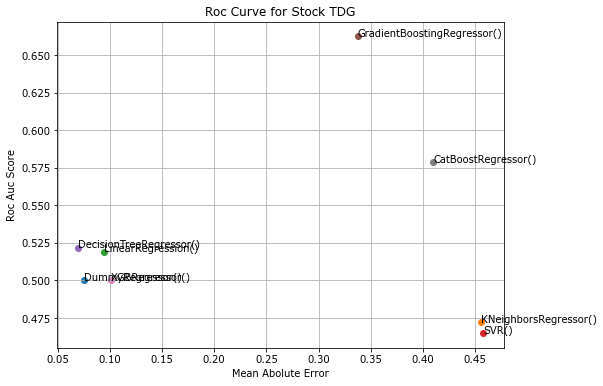

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 61.89it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'strategy': 'mean'}
  Backtesting metric: 0.07845764115275837



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'n_neighbors': 4, 'p': 5, 'weights': 'distance'}
  Backtesting metric: 0.005640489980555778

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 27.55it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'copy_X': False, 'fit_intercept': False}
  Backtesting metric: 0.00011959189591044643

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'C': 5, 'coef0': 0.5, 'degree': 8, 'gamma': 'auto', 'kernel': 'poly'}
  Backtesting metric: 2.437988382922473e-08

Number of models compared: 1920.


loop param_grid:  67%|██████████████████████           | 257/384 [00:01<00:00, 153.31it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 40, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
  Backtesting metric: 0.010475624609981889

Number of models compared: 540.


loop param_grid:  59%|████████████████████▋              | 64/108 [00:05<00:03, 14.11it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:36<00:00,  7.33s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
  Backtesting metric: 2.0046794340267213e-07

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.57it/s]

[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:06, 13.02it/s]

[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.93it/s]

[14:21:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 11.75it/s]

[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 11.00it/s]

[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.67it/s]

[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.65it/s]


[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:06, 11.24it/s]

[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.44it/s]

[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 11.08it/s]


[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 11.02it/s]

[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 10.75it/s]

[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.51it/s]


[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.49it/s]

[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.41it/s]


[14:21:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:05, 10.54it/s]

[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.63it/s]

[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.41it/s]

[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04,  9.99it/s]

[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 52/96 [00:04<00:05,  8.64it/s]

[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:03, 10.40it/s]

[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.17it/s]

[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.08it/s]

[14:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03,  9.64it/s]

[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.73it/s]

[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02,  9.97it/s]

[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.82it/s]

[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02,  9.60it/s]


[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.46it/s]

[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.99it/s]

[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.36it/s]

[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:07<00:01,  9.40it/s]

[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  9.30it/s]

[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:08<00:00, 10.53it/s]

[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00, 10.22it/s]

[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.81it/s]

[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid:  20%|███████▊                               | 1/5 [00:09<00:37,  9.44s/it]

[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:07, 12.97it/s]

[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:08, 11.17it/s]

[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.02it/s]

[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 10.94it/s]

[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 10.54it/s]

[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.78it/s]


[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.60it/s]


[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.66it/s]

[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:07, 10.12it/s]

[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07,  9.90it/s]

[14:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████                           | 24/96 [00:02<00:08,  8.39it/s]

[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  29%|██████████▌                         | 28/96 [00:02<00:07,  9.34it/s]

[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 10.94it/s]


[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:05, 10.72it/s]


[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.52it/s]

[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05,  9.98it/s]


[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.23it/s]


[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.34it/s]


[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:05, 10.40it/s]


[14:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:05, 10.09it/s]


[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.14it/s]


[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.36it/s]


[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.20it/s]


[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:05<00:04, 10.13it/s]

[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  9.00it/s]

[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.08it/s]

[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.74it/s]

[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  9.12it/s]

[14:22:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02, 10.27it/s]

[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.94it/s]

[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.95it/s]

[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:02, 10.27it/s]

[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  9.20it/s]

[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:07<00:01,  9.40it/s]

[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  9.28it/s]

[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:08<00:00, 10.47it/s]

[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:08<00:00,  9.17it/s]

[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.91it/s]

[14:22:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00, 10.13it/s]

[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.11it/s]

[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.86it/s]

[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.32it/s]

[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 10.88it/s]


[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.75it/s]

[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.34it/s]

[14:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.20it/s]


[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:07, 10.36it/s]


[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07, 10.42it/s]


[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.49it/s]


[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.54it/s]


[14:22:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:06, 10.61it/s]

[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:06, 10.35it/s]

[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.46it/s]


[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.51it/s]

[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05,  9.99it/s]


[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:05, 10.20it/s]


[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:05, 10.19it/s]


[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.29it/s]


[14:22:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.32it/s]


[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.01it/s]

[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:05<00:04,  9.74it/s]

[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  8.51it/s]

[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.51it/s]


[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.22it/s]

[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.57it/s]

[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:03,  9.31it/s]


[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.33it/s]

[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.78it/s]

[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.63it/s]

[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01,  9.75it/s]

[14:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:08<00:01,  8.44it/s]

[14:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01,  9.26it/s]


[14:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.07it/s]

[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:09<00:00,  8.24it/s]

[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:09<00:00,  9.75it/s]

[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.43it/s]

[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:29<00:19,  9.73s/it]

[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.02it/s]

[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 12.15it/s]


[14:22:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 11.44it/s]

[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.51it/s]


[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.95it/s]

[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 12.05it/s]


[14:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 12.17it/s]

[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.48it/s]


[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.72it/s]

[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 11.30it/s]

[14:22:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.44it/s]

[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.42it/s]

[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.58it/s]

[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.51it/s]

[14:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.11it/s]

[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.46it/s]

[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.52it/s]

[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:04, 10.55it/s]

[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 10.47it/s]


[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.14it/s]

[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.75it/s]

[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.24it/s]

[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.41it/s]

[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02, 10.30it/s]

[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 10.11it/s]


[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.47it/s]


[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.54it/s]


[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.77it/s]

[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 11.17it/s]

[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 11.09it/s]

[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.70it/s]


[14:22:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.66it/s]

[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00, 10.74it/s]

[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.56it/s]


[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.51it/s]


[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:37<00:09,  9.38s/it]

[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:05, 15.66it/s]

[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.65it/s]

[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.94it/s]

[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:00<00:06, 13.09it/s]

[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.83it/s]

[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:05, 12.64it/s]

[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:01<00:05, 12.71it/s]

[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:05, 12.22it/s]


[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 11.80it/s]

[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 12.02it/s]


[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:02<00:04, 12.17it/s]

[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.47it/s]

[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 12.44it/s]

[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 12.57it/s]

[14:22:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 12.54it/s]


[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 12.35it/s]

[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 12.09it/s]

[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.50it/s]


[14:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  64%|██████████████████████▉             | 61/96 [00:04<00:03, 11.13it/s]


[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.09it/s]

[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.85it/s]


[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:05<00:02, 10.89it/s]

[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 11.26it/s]


[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 11.59it/s]


[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 11.25it/s]

[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.01it/s]

[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:00, 11.28it/s]

[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.69it/s]

[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:07<00:00, 11.64it/s]

[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:45<00:00,  9.19s/it]


[14:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'colsample_bytree': 0.8, 'gamma': 0.7, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}
  Backtesting metric: 0.07550768801953014

Number of models compared: 60.


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.03it/s]

0:	learn: 0.2590824	total: 1.12ms	remaining: 32.6ms
1:	learn: 0.2497487	total: 2.18ms	remaining: 30.5ms
2:	learn: 0.2420814	total: 3.38ms	remaining: 30.4ms
3:	learn: 0.2342486	total: 4.66ms	remaining: 30.3ms
4:	learn: 0.2257789	total: 6ms	remaining: 30ms
5:	learn: 0.2175105	total: 7.45ms	remaining: 29.8ms
6:	learn: 0.2101443	total: 9.25ms	remaining: 30.4ms
7:	learn: 0.2038005	total: 10.3ms	remaining: 28.3ms
8:	learn: 0.1974547	total: 11.4ms	remaining: 26.7ms
9:	learn: 0.1905953	total: 12.7ms	remaining: 25.3ms
10:	learn: 0.1840210	total: 14ms	remaining: 24.2ms
11:	learn: 0.1773575	total: 15ms	remaining: 22.6ms
12:	learn: 0.1708182	total: 16.2ms	remaining: 21.1ms
13:	learn: 0.1645866	total: 17.4ms	remaining: 19.9ms
14:	learn: 0.1598891	total: 18.4ms	remaining: 18.4ms
15:	learn: 0.1552343	total: 19.4ms	remaining: 17ms
16:	learn: 0.1499929	total: 20.6ms	remaining: 15.8ms
17:	learn: 0.1447454	total: 21.3ms	remaining: 14.2ms
18:	learn: 0.1405679	total: 22.2ms	remaining: 12.8ms
19:	learn: 0.1

21:	learn: 0.0692509	total: 23ms	remaining: 8.35ms
22:	learn: 0.0660692	total: 23.8ms	remaining: 7.24ms
23:	learn: 0.0632330	total: 24.5ms	remaining: 6.13ms
24:	learn: 0.0606444	total: 25.3ms	remaining: 5.06ms
25:	learn: 0.0583432	total: 26.1ms	remaining: 4.01ms
26:	learn: 0.0560913	total: 26.8ms	remaining: 2.98ms
27:	learn: 0.0538948	total: 27.5ms	remaining: 1.97ms
28:	learn: 0.0521597	total: 28.2ms	remaining: 973us
29:	learn: 0.0505292	total: 29ms	remaining: 0us


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.73it/s]

0:	learn: 0.2590824	total: 993us	remaining: 48.7ms
1:	learn: 0.2497487	total: 1.84ms	remaining: 44.2ms
2:	learn: 0.2420814	total: 2.69ms	remaining: 42.2ms
3:	learn: 0.2342486	total: 3.54ms	remaining: 40.7ms
4:	learn: 0.2257789	total: 4.2ms	remaining: 37.8ms
5:	learn: 0.2175105	total: 4.91ms	remaining: 36ms
6:	learn: 0.2101443	total: 5.75ms	remaining: 35.3ms
7:	learn: 0.2038005	total: 6.5ms	remaining: 34.1ms
8:	learn: 0.1974547	total: 7.37ms	remaining: 33.6ms
9:	learn: 0.1905953	total: 8.54ms	remaining: 34.2ms
10:	learn: 0.1840210	total: 9.36ms	remaining: 33.2ms
11:	learn: 0.1773575	total: 10.5ms	remaining: 33.1ms
12:	learn: 0.1708182	total: 11.3ms	remaining: 32.2ms
13:	learn: 0.1645866	total: 12.3ms	remaining: 31.5ms
14:	learn: 0.1598891	total: 12.9ms	remaining: 30.2ms
15:	learn: 0.1552343	total: 13.6ms	remaining: 29ms
16:	learn: 0.1499929	total: 14.4ms	remaining: 27.9ms
17:	learn: 0.1447454	total: 14.8ms	remaining: 26.4ms
18:	learn: 0.1405679	total: 15.6ms	remaining: 25.4ms
19:	learn:


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.61it/s]

45:	learn: 0.0344777	total: 36.9ms	remaining: 3.2ms
46:	learn: 0.0337580	total: 37.9ms	remaining: 2.42ms
47:	learn: 0.0333738	total: 38.8ms	remaining: 1.61ms
48:	learn: 0.0330558	total: 39.6ms	remaining: 807us
49:	learn: 0.0324260	total: 40.4ms	remaining: 0us
0:	learn: 0.2594254	total: 2.81ms	remaining: 81.6ms
1:	learn: 0.2504675	total: 4.67ms	remaining: 65.4ms
2:	learn: 0.2420229	total: 5.25ms	remaining: 47.3ms
3:	learn: 0.2343787	total: 7.69ms	remaining: 50ms
4:	learn: 0.2265207	total: 9.58ms	remaining: 47.9ms
5:	learn: 0.2188970	total: 12.2ms	remaining: 49ms
6:	learn: 0.2124824	total: 14.7ms	remaining: 48.2ms
7:	learn: 0.2052982	total: 16.1ms	remaining: 44.4ms
8:	learn: 0.1994448	total: 17.8ms	remaining: 41.6ms
9:	learn: 0.1925345	total: 19.5ms	remaining: 39ms
10:	learn: 0.1865951	total: 21.7ms	remaining: 37.5ms
11:	learn: 0.1811687	total: 23.2ms	remaining: 34.8ms
12:	learn: 0.1752807	total: 24.8ms	remaining: 32.4ms
13:	learn: 0.1699252	total: 26.5ms	remaining: 30.2ms
14:	learn: 0.1


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.49it/s]

29:	learn: 0.1044661	total: 51.2ms	remaining: 0us
0:	learn: 0.2502228	total: 1.8ms	remaining: 52.2ms
1:	learn: 0.2330444	total: 3.36ms	remaining: 47ms
2:	learn: 0.2175597	total: 4.5ms	remaining: 40.5ms
3:	learn: 0.2039550	total: 6.62ms	remaining: 43ms



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  8.28it/s]

4:	learn: 0.1906309	total: 9.25ms	remaining: 46.2ms
5:	learn: 0.1782109	total: 10.8ms	remaining: 43.3ms
6:	learn: 0.1682073	total: 12.5ms	remaining: 41.1ms
7:	learn: 0.1574011	total: 14ms	remaining: 38.6ms
8:	learn: 0.1486133	total: 16.7ms	remaining: 39ms
9:	learn: 0.1390442	total: 18.7ms	remaining: 37.5ms
10:	learn: 0.1308941	total: 21.2ms	remaining: 36.6ms
11:	learn: 0.1239872	total: 23.4ms	remaining: 35.1ms
12:	learn: 0.1165853	total: 26.2ms	remaining: 34.3ms
13:	learn: 0.1103156	total: 28.8ms	remaining: 32.9ms
14:	learn: 0.1034943	total: 30ms	remaining: 30ms
15:	learn: 0.0981140	total: 31.7ms	remaining: 27.7ms
16:	learn: 0.0928548	total: 33.5ms	remaining: 25.6ms
17:	learn: 0.0877275	total: 35ms	remaining: 23.4ms
18:	learn: 0.0837029	total: 36.6ms	remaining: 21.2ms
19:	learn: 0.0795511	total: 38.2ms	remaining: 19.1ms
20:	learn: 0.0754592	total: 39.6ms	remaining: 17ms
21:	learn: 0.0719860	total: 40.9ms	remaining: 14.9ms
22:	learn: 0.0689259	total: 43.3ms	remaining: 13.2ms
23:	learn: 


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  7.66it/s]

36:	learn: 0.0866603	total: 57.1ms	remaining: 20ms
37:	learn: 0.0844407	total: 58.6ms	remaining: 18.5ms
38:	learn: 0.0822897	total: 60.1ms	remaining: 16.9ms
39:	learn: 0.0804141	total: 61.4ms	remaining: 15.3ms
40:	learn: 0.0783446	total: 63.3ms	remaining: 13.9ms
41:	learn: 0.0764972	total: 64.4ms	remaining: 12.3ms
42:	learn: 0.0748166	total: 66.1ms	remaining: 10.8ms
43:	learn: 0.0732174	total: 67.6ms	remaining: 9.22ms
44:	learn: 0.0715466	total: 69ms	remaining: 7.67ms
45:	learn: 0.0696489	total: 69.6ms	remaining: 6.05ms
46:	learn: 0.0681467	total: 70.9ms	remaining: 4.52ms
47:	learn: 0.0667893	total: 72.4ms	remaining: 3.02ms
48:	learn: 0.0654785	total: 74.1ms	remaining: 1.51ms
49:	learn: 0.0642072	total: 75.8ms	remaining: 0us
0:	learn: 0.2502228	total: 2.25ms	remaining: 110ms
1:	learn: 0.2330444	total: 4.05ms	remaining: 97.2ms
2:	learn: 0.2175597	total: 4.67ms	remaining: 73.2ms
3:	learn: 0.2039550	total: 6.15ms	remaining: 70.7ms
4:	learn: 0.1906309	total: 7.6ms	remaining: 68.4ms
5:	lear


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  7.12it/s]

49:	learn: 0.0308025	total: 76.5ms	remaining: 0us
0:	learn: 0.2597884	total: 6.65ms	remaining: 193ms
1:	learn: 0.2517851	total: 9.11ms	remaining: 128ms
2:	learn: 0.2439504	total: 14.3ms	remaining: 128ms
3:	learn: 0.2361263	total: 18.5ms	remaining: 120ms
4:	learn: 0.2276510	total: 19.3ms	remaining: 96.7ms
5:	learn: 0.2212800	total: 24.3ms	remaining: 97.2ms
6:	learn: 0.2149559	total: 30.9ms	remaining: 102ms
7:	learn: 0.2077401	total: 33.1ms	remaining: 90.9ms
8:	learn: 0.2014133	total: 38.6ms	remaining: 90ms
9:	learn: 0.1942682	total: 39.3ms	remaining: 78.7ms
10:	learn: 0.1869122	total: 40.8ms	remaining: 70.4ms
11:	learn: 0.1806998	total: 42.6ms	remaining: 63.9ms
12:	learn: 0.1754379	total: 49.5ms	remaining: 64.7ms
13:	learn: 0.1691886	total: 50.2ms	remaining: 57.4ms
14:	learn: 0.1643265	total: 57.1ms	remaining: 57.1ms
15:	learn: 0.1592084	total: 62.4ms	remaining: 54.6ms
16:	learn: 0.1538644	total: 64.8ms	remaining: 49.6ms
17:	learn: 0.1499303	total: 71.8ms	remaining: 47.9ms
18:	learn: 0.


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.97it/s]

24:	learn: 0.1234948	total: 117ms	remaining: 23.4ms
25:	learn: 0.1198098	total: 122ms	remaining: 18.8ms
26:	learn: 0.1162453	total: 129ms	remaining: 14.3ms
27:	learn: 0.1133321	total: 134ms	remaining: 9.59ms
28:	learn: 0.1104726	total: 141ms	remaining: 4.85ms
29:	learn: 0.1078803	total: 146ms	remaining: 0us
0:	learn: 0.2509495	total: 4.73ms	remaining: 137ms
1:	learn: 0.2355901	total: 7.17ms	remaining: 100ms
2:	learn: 0.2210854	total: 12.1ms	remaining: 109ms
3:	learn: 0.2070559	total: 15ms	remaining: 97.2ms
4:	learn: 0.1924965	total: 15.6ms	remaining: 78ms
5:	learn: 0.1818948	total: 20ms	remaining: 79.8ms
6:	learn: 0.1716934	total: 24.9ms	remaining: 81.7ms
7:	learn: 0.1604842	total: 26ms	remaining: 71.6ms
8:	learn: 0.1510733	total: 31.7ms	remaining: 74ms
9:	learn: 0.1409295	total: 32.9ms	remaining: 65.8ms
10:	learn: 0.1308903	total: 33.7ms	remaining: 58.2ms
11:	learn: 0.1229927	total: 35.5ms	remaining: 53.2ms
12:	learn: 0.1164468	total: 41.7ms	remaining: 54.5ms
13:	learn: 0.1091291	tota


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.89it/s]

22:	learn: 0.0703820	total: 85.8ms	remaining: 26.1ms
23:	learn: 0.0675712	total: 91.2ms	remaining: 22.8ms
24:	learn: 0.0646560	total: 92.1ms	remaining: 18.4ms
25:	learn: 0.0618187	total: 93.2ms	remaining: 14.3ms
26:	learn: 0.0592654	total: 98.8ms	remaining: 11ms
27:	learn: 0.0569073	total: 100ms	remaining: 7.17ms
28:	learn: 0.0549078	total: 101ms	remaining: 3.47ms
29:	learn: 0.0527670	total: 105ms	remaining: 0us
0:	learn: 0.2597884	total: 5.66ms	remaining: 277ms
1:	learn: 0.2517851	total: 8.41ms	remaining: 202ms
2:	learn: 0.2439504	total: 14.6ms	remaining: 229ms
3:	learn: 0.2361263	total: 17.3ms	remaining: 199ms
4:	learn: 0.2276510	total: 18ms	remaining: 162ms
5:	learn: 0.2212800	total: 22.2ms	remaining: 162ms
6:	learn: 0.2149559	total: 26.3ms	remaining: 161ms
7:	learn: 0.2077401	total: 27.3ms	remaining: 143ms
8:	learn: 0.2014133	total: 31.6ms	remaining: 144ms
9:	learn: 0.1942682	total: 32.2ms	remaining: 129ms
10:	learn: 0.1869122	total: 32.9ms	remaining: 117ms
11:	learn: 0.1806998	tot

27:	learn: 0.1133321	total: 101ms	remaining: 79ms
28:	learn: 0.1104726	total: 105ms	remaining: 76.2ms
29:	learn: 0.1078803	total: 110ms	remaining: 73.2ms
30:	learn: 0.1048047	total: 115ms	remaining: 70.7ms
31:	learn: 0.1017237	total: 122ms	remaining: 68.7ms
32:	learn: 0.0995919	total: 127ms	remaining: 65.3ms
33:	learn: 0.0971033	total: 131ms	remaining: 61.8ms
34:	learn: 0.0945413	total: 136ms	remaining: 58.2ms
35:	learn: 0.0920800	total: 141ms	remaining: 55ms
36:	learn: 0.0897509	total: 146ms	remaining: 51.5ms
37:	learn: 0.0870664	total: 147ms	remaining: 46.5ms
38:	learn: 0.0848552	total: 151ms	remaining: 42.7ms
39:	learn: 0.0828311	total: 156ms	remaining: 38.9ms
40:	learn: 0.0808566	total: 160ms	remaining: 35.2ms
41:	learn: 0.0791396	total: 165ms	remaining: 31.3ms
42:	learn: 0.0773575	total: 169ms	remaining: 27.6ms
43:	learn: 0.0758525	total: 175ms	remaining: 23.8ms
44:	learn: 0.0741171	total: 176ms	remaining: 19.6ms
45:	learn: 0.0722118	total: 177ms	remaining: 15.4ms
46:	learn: 0.070

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.99it/s]

0:	learn: 0.2509495	total: 8.59ms	remaining: 421ms
1:	learn: 0.2355901	total: 12.8ms	remaining: 307ms
2:	learn: 0.2210854	total: 19ms	remaining: 297ms
3:	learn: 0.2070559	total: 23.6ms	remaining: 271ms
4:	learn: 0.1924965	total: 24.8ms	remaining: 223ms
5:	learn: 0.1818948	total: 33.7ms	remaining: 247ms
6:	learn: 0.1716934	total: 41.3ms	remaining: 254ms
7:	learn: 0.1604842	total: 43ms	remaining: 226ms
8:	learn: 0.1510733	total: 51.3ms	remaining: 234ms
9:	learn: 0.1409295	total: 52.5ms	remaining: 210ms
10:	learn: 0.1308903	total: 53.3ms	remaining: 189ms
11:	learn: 0.1229927	total: 55.5ms	remaining: 176ms
12:	learn: 0.1164468	total: 63.9ms	remaining: 182ms
13:	learn: 0.1091291	total: 65ms	remaining: 167ms
14:	learn: 0.1035267	total: 72.3ms	remaining: 169ms
15:	learn: 0.0977468	total: 75.9ms	remaining: 161ms
16:	learn: 0.0924722	total: 79.5ms	remaining: 154ms
17:	learn: 0.0883813	total: 85.3ms	remaining: 152ms
18:	learn: 0.0844125	total: 91.4ms	remaining: 149ms
19:	learn: 0.0807644	total: 


loop lags_grid:  20%|███████▊                               | 1/5 [00:02<00:08,  2.04s/it]

38:	learn: 0.0392894	total: 188ms	remaining: 53.1ms
39:	learn: 0.0382710	total: 189ms	remaining: 47.3ms
40:	learn: 0.0373201	total: 198ms	remaining: 43.5ms
41:	learn: 0.0365114	total: 206ms	remaining: 39.2ms
42:	learn: 0.0355382	total: 212ms	remaining: 34.5ms
43:	learn: 0.0350917	total: 218ms	remaining: 29.7ms
44:	learn: 0.0345660	total: 218ms	remaining: 24.3ms
45:	learn: 0.0337886	total: 224ms	remaining: 19.5ms
46:	learn: 0.0329697	total: 229ms	remaining: 14.6ms
47:	learn: 0.0320907	total: 234ms	remaining: 9.75ms
48:	learn: 0.0317380	total: 236ms	remaining: 4.81ms
49:	learn: 0.0310458	total: 241ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2586993	total: 1.38ms	remaining: 40ms
1:	learn: 0.2504068	total: 2.6ms	remaining: 36.4ms
2:	learn: 0.2428167	total: 3.78ms	remaining: 34ms
3:	learn: 0.2353930	total: 5.26ms	remaining: 34.2ms
4:	learn: 0.2276322	total: 6.6ms	remaining: 33ms
5:	learn: 0.2197665	total: 7.98ms	remaining: 31.9ms
6:	learn: 0.2130823	total: 9.19ms	remaining: 30.2ms
7:	learn: 0.2063015	total: 10.8ms	remaining: 29.6ms
8:	learn: 0.1995833	total: 12.4ms	remaining: 28.9ms
9:	learn: 0.1936165	total: 13.3ms	remaining: 26.7ms
10:	learn: 0.1862333	total: 13.8ms	remaining: 23.8ms
11:	learn: 0.1800338	total: 14.6ms	remaining: 21.9ms
12:	learn: 0.1740381	total: 15.6ms	remaining: 20.5ms
13:	learn: 0.1686998	total: 16.6ms	remaining: 19ms
14:	learn: 0.1634330	total: 17.6ms	remaining: 17.6ms
15:	learn: 0.1578739	total: 18.5ms	remaining: 16.2ms
16:	learn: 0.1528558	total: 20.3ms	remaining: 15.5ms
17:	learn: 0.1478223	total: 21.6ms	remaining: 14.4ms
18:	learn: 0.1428966	total: 23.4ms	remaining: 13.5ms
19:	learn: 0.


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.12it/s]


26:	learn: 0.1123966	total: 33.9ms	remaining: 3.77ms
27:	learn: 0.1093029	total: 35.5ms	remaining: 2.54ms
28:	learn: 0.1060886	total: 36.5ms	remaining: 1.26ms
29:	learn: 0.1030690	total: 37.9ms	remaining: 0us
0:	learn: 0.2500433	total: 1.85ms	remaining: 53.8ms
1:	learn: 0.2340597	total: 2.81ms	remaining: 39.3ms
2:	learn: 0.2199531	total: 4.35ms	remaining: 39.1ms
3:	learn: 0.2064776	total: 5.29ms	remaining: 34.4ms
4:	learn: 0.1930890	total: 6.55ms	remaining: 32.8ms
5:	learn: 0.1799777	total: 7.88ms	remaining: 31.5ms
6:	learn: 0.1692185	total: 9.18ms	remaining: 30.1ms
7:	learn: 0.1588144	total: 10.1ms	remaining: 27.7ms
8:	learn: 0.1488086	total: 10.8ms	remaining: 25.1ms
9:	learn: 0.1402692	total: 11.6ms	remaining: 23.1ms
10:	learn: 0.1301196	total: 11.9ms	remaining: 20.6ms
11:	learn: 0.1223585	total: 12.8ms	remaining: 19.1ms
12:	learn: 0.1147747	total: 14.3ms	remaining: 18.7ms
13:	learn: 0.1083488	total: 15.3ms	remaining: 17.5ms
14:	learn: 0.1023078	total: 16.6ms	remaining: 16.6ms
15:	le

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  7.94it/s]


0:	learn: 0.2586993	total: 1.24ms	remaining: 60.9ms
1:	learn: 0.2504068	total: 2.07ms	remaining: 49.7ms
2:	learn: 0.2428167	total: 3.78ms	remaining: 59.3ms
3:	learn: 0.2353930	total: 4.66ms	remaining: 53.6ms
4:	learn: 0.2276322	total: 6.04ms	remaining: 54.4ms
5:	learn: 0.2197665	total: 7.63ms	remaining: 56ms
6:	learn: 0.2130823	total: 8.5ms	remaining: 52.2ms
7:	learn: 0.2063015	total: 9.56ms	remaining: 50.2ms
8:	learn: 0.1995833	total: 10.5ms	remaining: 47.6ms
9:	learn: 0.1936165	total: 11.3ms	remaining: 45ms
10:	learn: 0.1862333	total: 11.6ms	remaining: 41.2ms
11:	learn: 0.1800338	total: 13.1ms	remaining: 41.6ms
12:	learn: 0.1740381	total: 14.1ms	remaining: 40ms
13:	learn: 0.1686998	total: 15.1ms	remaining: 38.9ms
14:	learn: 0.1634330	total: 16.4ms	remaining: 38.2ms
15:	learn: 0.1578739	total: 17.2ms	remaining: 36.5ms
16:	learn: 0.1528558	total: 18.1ms	remaining: 35.1ms
17:	learn: 0.1478223	total: 18.9ms	remaining: 33.6ms
18:	learn: 0.1428966	total: 19.7ms	remaining: 32.2ms
19:	learn:

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.50it/s]


0:	learn: 0.2598355	total: 2.26ms	remaining: 65.6ms
1:	learn: 0.2516362	total: 4.07ms	remaining: 57ms
2:	learn: 0.2439053	total: 6.15ms	remaining: 55.4ms
3:	learn: 0.2354146	total: 7.44ms	remaining: 48.4ms
4:	learn: 0.2279231	total: 9.11ms	remaining: 45.6ms
5:	learn: 0.2204424	total: 10.8ms	remaining: 43.4ms
6:	learn: 0.2136709	total: 12.6ms	remaining: 41.5ms
7:	learn: 0.2067810	total: 13.3ms	remaining: 36.5ms
8:	learn: 0.2006290	total: 15ms	remaining: 35.1ms
9:	learn: 0.1942976	total: 16.7ms	remaining: 33.4ms
10:	learn: 0.1884311	total: 18.7ms	remaining: 32.3ms
11:	learn: 0.1831247	total: 20.5ms	remaining: 30.8ms
12:	learn: 0.1780111	total: 22.6ms	remaining: 29.5ms
13:	learn: 0.1725620	total: 24.6ms	remaining: 28.1ms
14:	learn: 0.1671931	total: 25.6ms	remaining: 25.6ms
15:	learn: 0.1624483	total: 27.5ms	remaining: 24ms
16:	learn: 0.1571354	total: 28.7ms	remaining: 22ms
17:	learn: 0.1531384	total: 30.6ms	remaining: 20.4ms
18:	learn: 0.1486350	total: 32.4ms	remaining: 18.8ms
19:	learn: 

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  7.49it/s]

0:	learn: 0.2598355	total: 3.02ms	remaining: 148ms
1:	learn: 0.2516362	total: 5.62ms	remaining: 135ms
2:	learn: 0.2439053	total: 7.76ms	remaining: 122ms
3:	learn: 0.2354146	total: 9.16ms	remaining: 105ms
4:	learn: 0.2279231	total: 11.2ms	remaining: 101ms
5:	learn: 0.2204424	total: 13.9ms	remaining: 102ms
6:	learn: 0.2136709	total: 16.2ms	remaining: 99.2ms
7:	learn: 0.2067810	total: 17.2ms	remaining: 90ms
8:	learn: 0.2006290	total: 19.3ms	remaining: 87.8ms
9:	learn: 0.1942976	total: 21.3ms	remaining: 85.1ms
10:	learn: 0.1884311	total: 23ms	remaining: 81.6ms
11:	learn: 0.1831247	total: 25ms	remaining: 79.1ms
12:	learn: 0.1780111	total: 26.6ms	remaining: 75.7ms
13:	learn: 0.1725620	total: 28.2ms	remaining: 72.5ms
14:	learn: 0.1671931	total: 29.4ms	remaining: 68.5ms
15:	learn: 0.1624483	total: 31.1ms	remaining: 66.1ms
16:	learn: 0.1571354	total: 32.2ms	remaining: 62.6ms
17:	learn: 0.1531384	total: 33.9ms	remaining: 60.2ms
18:	learn: 0.1486350	total: 35.7ms	remaining: 58.2ms
19:	learn: 0.14

1:	learn: 0.2364530	total: 12.4ms	remaining: 298ms
2:	learn: 0.2219745	total: 17.3ms	remaining: 270ms
3:	learn: 0.2066986	total: 19.9ms	remaining: 228ms
4:	learn: 0.1937327	total: 24.8ms	remaining: 223ms
5:	learn: 0.1813272	total: 28.5ms	remaining: 209ms
6:	learn: 0.1706625	total: 34.1ms	remaining: 210ms
7:	learn: 0.1600950	total: 35.2ms	remaining: 185ms
8:	learn: 0.1510282	total: 39.1ms	remaining: 178ms
9:	learn: 0.1421682	total: 41.7ms	remaining: 167ms
10:	learn: 0.1341777	total: 45.8ms	remaining: 162ms
11:	learn: 0.1270927	total: 48.8ms	remaining: 154ms
12:	learn: 0.1203840	total: 51.5ms	remaining: 147ms
13:	learn: 0.1137376	total: 54.2ms	remaining: 139ms
14:	learn: 0.1075397	total: 55.7ms	remaining: 130ms
15:	learn: 0.1019829	total: 58.8ms	remaining: 125ms
16:	learn: 0.0964007	total: 60.2ms	remaining: 117ms
17:	learn: 0.0922109	total: 62.4ms	remaining: 111ms
18:	learn: 0.0876452	total: 64.7ms	remaining: 106ms
19:	learn: 0.0836361	total: 67.1ms	remaining: 101ms
20:	learn: 0.0799253	

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.73it/s]

0:	learn: 0.2602670	total: 7.11ms	remaining: 206ms
1:	learn: 0.2533978	total: 15.9ms	remaining: 223ms
2:	learn: 0.2453332	total: 26.5ms	remaining: 238ms
3:	learn: 0.2382142	total: 33.3ms	remaining: 216ms
4:	learn: 0.2306402	total: 40.8ms	remaining: 204ms
5:	learn: 0.2245075	total: 48.5ms	remaining: 194ms
6:	learn: 0.2178535	total: 57.3ms	remaining: 188ms
7:	learn: 0.2111790	total: 65.5ms	remaining: 180ms
8:	learn: 0.2047087	total: 71.8ms	remaining: 168ms
9:	learn: 0.1990955	total: 80ms	remaining: 160ms
10:	learn: 0.1931626	total: 86.3ms	remaining: 149ms
11:	learn: 0.1881642	total: 92.9ms	remaining: 139ms
12:	learn: 0.1825506	total: 98.2ms	remaining: 128ms
13:	learn: 0.1781244	total: 104ms	remaining: 119ms
14:	learn: 0.1734738	total: 111ms	remaining: 111ms
15:	learn: 0.1683525	total: 117ms	remaining: 103ms
16:	learn: 0.1623110	total: 118ms	remaining: 90.2ms
17:	learn: 0.1578490	total: 123ms	remaining: 82.3ms
18:	learn: 0.1536067	total: 129ms	remaining: 74.4ms
19:	learn: 0.1488858	total:


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.72it/s]

25:	learn: 0.1261875	total: 170ms	remaining: 26.1ms
26:	learn: 0.1226962	total: 175ms	remaining: 19.5ms
27:	learn: 0.1195010	total: 183ms	remaining: 13ms
28:	learn: 0.1163106	total: 186ms	remaining: 6.4ms
29:	learn: 0.1131985	total: 192ms	remaining: 0us
0:	learn: 0.2531709	total: 7.51ms	remaining: 218ms
1:	learn: 0.2398433	total: 12.6ms	remaining: 177ms
2:	learn: 0.2246527	total: 18.1ms	remaining: 163ms
3:	learn: 0.2117634	total: 23.2ms	remaining: 151ms
4:	learn: 0.1985102	total: 28.9ms	remaining: 145ms
5:	learn: 0.1882026	total: 34.5ms	remaining: 138ms
6:	learn: 0.1773217	total: 40.8ms	remaining: 134ms
7:	learn: 0.1675182	total: 46.8ms	remaining: 129ms
8:	learn: 0.1575993	total: 52.2ms	remaining: 122ms
9:	learn: 0.1487595	total: 58.1ms	remaining: 116ms
10:	learn: 0.1404072	total: 63.2ms	remaining: 109ms
11:	learn: 0.1336693	total: 68.2ms	remaining: 102ms
12:	learn: 0.1263755	total: 73.1ms	remaining: 95.6ms
13:	learn: 0.1208393	total: 78.2ms	remaining: 89.4ms



loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.52it/s]

14:	learn: 0.1149699	total: 85.2ms	remaining: 85.2ms
15:	learn: 0.1088809	total: 90.7ms	remaining: 79.4ms
16:	learn: 0.1021049	total: 91.3ms	remaining: 69.8ms
17:	learn: 0.0973121	total: 96.9ms	remaining: 64.6ms
18:	learn: 0.0928088	total: 103ms	remaining: 59.6ms
19:	learn: 0.0883344	total: 109ms	remaining: 54.3ms
20:	learn: 0.0845238	total: 114ms	remaining: 49ms
21:	learn: 0.0805942	total: 119ms	remaining: 43.3ms
22:	learn: 0.0772522	total: 124ms	remaining: 37.6ms
23:	learn: 0.0736990	total: 129ms	remaining: 32.1ms
24:	learn: 0.0701764	total: 134ms	remaining: 26.8ms
25:	learn: 0.0672837	total: 139ms	remaining: 21.4ms
26:	learn: 0.0645682	total: 145ms	remaining: 16.1ms
27:	learn: 0.0619596	total: 151ms	remaining: 10.8ms
28:	learn: 0.0593925	total: 154ms	remaining: 5.3ms
29:	learn: 0.0571736	total: 159ms	remaining: 0us
0:	learn: 0.2602670	total: 7.75ms	remaining: 380ms
1:	learn: 0.2533978	total: 13.4ms	remaining: 321ms
2:	learn: 0.2453332	total: 19ms	remaining: 298ms
3:	learn: 0.2382142


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.00it/s]

42:	learn: 0.0812535	total: 204ms	remaining: 33.2ms
43:	learn: 0.0794667	total: 209ms	remaining: 28.5ms
44:	learn: 0.0777497	total: 215ms	remaining: 23.8ms
45:	learn: 0.0759955	total: 219ms	remaining: 19.1ms
46:	learn: 0.0740357	total: 220ms	remaining: 14ms
47:	learn: 0.0722832	total: 224ms	remaining: 9.32ms
48:	learn: 0.0706324	total: 226ms	remaining: 4.61ms
49:	learn: 0.0691036	total: 231ms	remaining: 0us
0:	learn: 0.2531709	total: 7.97ms	remaining: 390ms
1:	learn: 0.2398433	total: 13.3ms	remaining: 320ms
2:	learn: 0.2246527	total: 18.7ms	remaining: 293ms
3:	learn: 0.2117634	total: 24.1ms	remaining: 277ms
4:	learn: 0.1985102	total: 29.7ms	remaining: 267ms
5:	learn: 0.1882026	total: 34.7ms	remaining: 254ms
6:	learn: 0.1773217	total: 40.2ms	remaining: 247ms
7:	learn: 0.1675182	total: 46.1ms	remaining: 242ms
8:	learn: 0.1575993	total: 51.4ms	remaining: 234ms
9:	learn: 0.1487595	total: 57ms	remaining: 228ms
10:	learn: 0.1404072	total: 62.7ms	remaining: 222ms
11:	learn: 0.1336693	total: 6


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.09it/s]


0:	learn: 0.2554744	total: 1.31ms	remaining: 38.1ms
1:	learn: 0.2479121	total: 2.64ms	remaining: 37ms
2:	learn: 0.2410339	total: 3.9ms	remaining: 35.1ms
3:	learn: 0.2331799	total: 5.3ms	remaining: 34.5ms
4:	learn: 0.2254087	total: 6.67ms	remaining: 33.4ms
5:	learn: 0.2186233	total: 7.97ms	remaining: 31.9ms
6:	learn: 0.2127039	total: 9.36ms	remaining: 30.8ms
7:	learn: 0.2064379	total: 10.5ms	remaining: 28.9ms
8:	learn: 0.1997616	total: 11.7ms	remaining: 27.3ms
9:	learn: 0.1937625	total: 13.2ms	remaining: 26.3ms
10:	learn: 0.1878113	total: 14.6ms	remaining: 25.1ms
11:	learn: 0.1826041	total: 16.7ms	remaining: 25ms
12:	learn: 0.1768567	total: 18.4ms	remaining: 24ms
13:	learn: 0.1712328	total: 19.9ms	remaining: 22.7ms
14:	learn: 0.1658638	total: 21ms	remaining: 21ms
15:	learn: 0.1611218	total: 22.2ms	remaining: 19.5ms
16:	learn: 0.1561843	total: 22.8ms	remaining: 17.4ms
17:	learn: 0.1516453	total: 24.2ms	remaining: 16.1ms
18:	learn: 0.1473011	total: 25.4ms	remaining: 14.7ms
19:	learn: 0.14

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  7.90it/s]

0:	learn: 0.2554744	total: 1.62ms	remaining: 79.4ms
1:	learn: 0.2479121	total: 2.81ms	remaining: 67.5ms
2:	learn: 0.2410339	total: 3.84ms	remaining: 60.2ms
3:	learn: 0.2331799	total: 4.91ms	remaining: 56.5ms
4:	learn: 0.2254087	total: 5.97ms	remaining: 53.7ms
5:	learn: 0.2186233	total: 7.01ms	remaining: 51.4ms
6:	learn: 0.2127039	total: 8.1ms	remaining: 49.7ms
7:	learn: 0.2064379	total: 9.54ms	remaining: 50.1ms
8:	learn: 0.1997616	total: 10.5ms	remaining: 47.8ms
9:	learn: 0.1937625	total: 12.1ms	remaining: 48.2ms
10:	learn: 0.1878113	total: 13.5ms	remaining: 47.8ms
11:	learn: 0.1826041	total: 15ms	remaining: 47.4ms
12:	learn: 0.1768567	total: 16.1ms	remaining: 45.8ms
13:	learn: 0.1712328	total: 17.1ms	remaining: 44.1ms
14:	learn: 0.1658638	total: 18.3ms	remaining: 42.6ms
15:	learn: 0.1611218	total: 19.4ms	remaining: 41.1ms
16:	learn: 0.1561843	total: 20.3ms	remaining: 39.4ms
17:	learn: 0.1516453	total: 21.5ms	remaining: 38.3ms
18:	learn: 0.1473011	total: 22.6ms	remaining: 36.8ms
19:	le


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  7.46it/s]


20:	learn: 0.0796914	total: 25.2ms	remaining: 34.9ms
21:	learn: 0.0758119	total: 26.4ms	remaining: 33.6ms
22:	learn: 0.0723609	total: 27.2ms	remaining: 32ms
23:	learn: 0.0695393	total: 28.2ms	remaining: 30.5ms
24:	learn: 0.0668293	total: 29.1ms	remaining: 29.1ms
25:	learn: 0.0641692	total: 29.9ms	remaining: 27.6ms
26:	learn: 0.0617074	total: 31ms	remaining: 26.4ms
27:	learn: 0.0593870	total: 32ms	remaining: 25.1ms
28:	learn: 0.0572521	total: 32.9ms	remaining: 23.8ms
29:	learn: 0.0550130	total: 33.9ms	remaining: 22.6ms
30:	learn: 0.0528469	total: 35ms	remaining: 21.4ms
31:	learn: 0.0509593	total: 36ms	remaining: 20.2ms
32:	learn: 0.0490888	total: 37ms	remaining: 19.1ms
33:	learn: 0.0472064	total: 38.1ms	remaining: 17.9ms
34:	learn: 0.0456432	total: 39.3ms	remaining: 16.8ms
35:	learn: 0.0439924	total: 40.2ms	remaining: 15.7ms
36:	learn: 0.0427498	total: 41.3ms	remaining: 14.5ms
37:	learn: 0.0414574	total: 42.2ms	remaining: 13.3ms
38:	learn: 0.0402384	total: 43.1ms	remaining: 12.2ms
39:	l

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.67it/s]

0:	learn: 0.2489040	total: 2.53ms	remaining: 73.3ms
1:	learn: 0.2354243	total: 4.97ms	remaining: 69.6ms
2:	learn: 0.2216877	total: 7.04ms	remaining: 63.4ms
3:	learn: 0.2091274	total: 8.99ms	remaining: 58.4ms
4:	learn: 0.1968896	total: 11.1ms	remaining: 55.4ms
5:	learn: 0.1856755	total: 13.1ms	remaining: 52.6ms
6:	learn: 0.1737091	total: 13.7ms	remaining: 45.2ms
7:	learn: 0.1642459	total: 15.6ms	remaining: 42.8ms
8:	learn: 0.1556063	total: 17.5ms	remaining: 40.7ms
9:	learn: 0.1467361	total: 19.2ms	remaining: 38.4ms
10:	learn: 0.1384436	total: 20.4ms	remaining: 35.2ms
11:	learn: 0.1305733	total: 22.9ms	remaining: 34.4ms
12:	learn: 0.1235448	total: 25ms	remaining: 32.7ms
13:	learn: 0.1173358	total: 27.5ms	remaining: 31.4ms
14:	learn: 0.1114114	total: 29.6ms	remaining: 29.6ms
15:	learn: 0.1062001	total: 31.6ms	remaining: 27.7ms
16:	learn: 0.1012900	total: 33.5ms	remaining: 25.6ms
17:	learn: 0.0969943	total: 35.3ms	remaining: 23.6ms
18:	learn: 0.0924174	total: 37.1ms	remaining: 21.5ms
19:	l


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  6.83it/s]

20:	learn: 0.1448228	total: 39.6ms	remaining: 54.7ms
21:	learn: 0.1412400	total: 41.8ms	remaining: 53.2ms
22:	learn: 0.1376282	total: 43.8ms	remaining: 51.5ms
23:	learn: 0.1345381	total: 46.1ms	remaining: 50ms
24:	learn: 0.1310830	total: 48.3ms	remaining: 48.3ms
25:	learn: 0.1283034	total: 50.7ms	remaining: 46.8ms
26:	learn: 0.1251342	total: 53.3ms	remaining: 45.4ms
27:	learn: 0.1223913	total: 55.4ms	remaining: 43.6ms
28:	learn: 0.1193708	total: 57.9ms	remaining: 41.9ms
29:	learn: 0.1164267	total: 59.9ms	remaining: 40ms
30:	learn: 0.1131002	total: 61.1ms	remaining: 37.5ms
31:	learn: 0.1099903	total: 63ms	remaining: 35.5ms
32:	learn: 0.1072204	total: 64.9ms	remaining: 33.5ms
33:	learn: 0.1046578	total: 67ms	remaining: 31.5ms
34:	learn: 0.1021273	total: 68.9ms	remaining: 29.5ms
35:	learn: 0.0996412	total: 70.9ms	remaining: 27.6ms
36:	learn: 0.0974276	total: 73ms	remaining: 25.7ms
37:	learn: 0.0953033	total: 75ms	remaining: 23.7ms
38:	learn: 0.0925688	total: 76.9ms	remaining: 21.7ms
39:	l


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.11it/s]

28:	learn: 0.0585294	total: 50.3ms	remaining: 36.4ms
29:	learn: 0.0556435	total: 52.2ms	remaining: 34.8ms
30:	learn: 0.0536801	total: 54.1ms	remaining: 33.1ms
31:	learn: 0.0513829	total: 55.9ms	remaining: 31.5ms
32:	learn: 0.0494994	total: 57.7ms	remaining: 29.7ms
33:	learn: 0.0477142	total: 59.5ms	remaining: 28ms
34:	learn: 0.0462246	total: 61.5ms	remaining: 26.3ms
35:	learn: 0.0443703	total: 63.3ms	remaining: 24.6ms
36:	learn: 0.0429536	total: 65.1ms	remaining: 22.9ms
37:	learn: 0.0415312	total: 66.9ms	remaining: 21.1ms
38:	learn: 0.0401368	total: 68.6ms	remaining: 19.3ms
39:	learn: 0.0388815	total: 70.2ms	remaining: 17.6ms
40:	learn: 0.0378199	total: 72.1ms	remaining: 15.8ms
41:	learn: 0.0367744	total: 73.9ms	remaining: 14.1ms
42:	learn: 0.0355663	total: 76.1ms	remaining: 12.4ms
43:	learn: 0.0341606	total: 78.1ms	remaining: 10.7ms
44:	learn: 0.0331846	total: 79.8ms	remaining: 8.87ms
45:	learn: 0.0321772	total: 81.6ms	remaining: 7.09ms
46:	learn: 0.0312948	total: 83.3ms	remaining: 5.


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.61it/s]

9:	learn: 0.2012919	total: 46.7ms	remaining: 93.3ms
10:	learn: 0.1948060	total: 47.5ms	remaining: 82ms
11:	learn: 0.1899760	total: 53.5ms	remaining: 80.2ms
12:	learn: 0.1855718	total: 59ms	remaining: 77.2ms
13:	learn: 0.1801197	total: 61ms	remaining: 69.8ms
14:	learn: 0.1757311	total: 67.3ms	remaining: 67.3ms
15:	learn: 0.1711147	total: 73.6ms	remaining: 64.4ms
16:	learn: 0.1663811	total: 79.2ms	remaining: 60.6ms
17:	learn: 0.1612615	total: 81.1ms	remaining: 54.1ms
18:	learn: 0.1572039	total: 86.8ms	remaining: 50.3ms
19:	learn: 0.1532983	total: 92.5ms	remaining: 46.3ms
20:	learn: 0.1490809	total: 98.4ms	remaining: 42.2ms
21:	learn: 0.1447957	total: 101ms	remaining: 36.9ms
22:	learn: 0.1406822	total: 104ms	remaining: 31.8ms
23:	learn: 0.1373961	total: 110ms	remaining: 27.5ms
24:	learn: 0.1335852	total: 112ms	remaining: 22.4ms
25:	learn: 0.1300464	total: 115ms	remaining: 17.8ms
26:	learn: 0.1272334	total: 121ms	remaining: 13.5ms
27:	learn: 0.1243142	total: 127ms	remaining: 9.08ms
28:	lea

3:	learn: 0.2138574	total: 33.8ms	remaining: 220ms
4:	learn: 0.2000965	total: 35.7ms	remaining: 179ms
5:	learn: 0.1884981	total: 39.4ms	remaining: 158ms
6:	learn: 0.1798737	total: 50.4ms	remaining: 166ms
7:	learn: 0.1699893	total: 52.3ms	remaining: 144ms
8:	learn: 0.1615255	total: 61.8ms	remaining: 144ms
9:	learn: 0.1533492	total: 70.6ms	remaining: 141ms
10:	learn: 0.1438683	total: 71.8ms	remaining: 124ms
11:	learn: 0.1368870	total: 79.5ms	remaining: 119ms
12:	learn: 0.1308703	total: 86.1ms	remaining: 113ms
13:	learn: 0.1233649	total: 89.5ms	remaining: 102ms
14:	learn: 0.1176012	total: 96.2ms	remaining: 96.2ms
15:	learn: 0.1118498	total: 104ms	remaining: 90.8ms
16:	learn: 0.1063441	total: 111ms	remaining: 84.8ms
17:	learn: 0.1003398	total: 114ms	remaining: 75.8ms
18:	learn: 0.0959835	total: 120ms	remaining: 69.4ms
19:	learn: 0.0914026	total: 127ms	remaining: 63.4ms
20:	learn: 0.0868855	total: 137ms	remaining: 58.6ms
21:	learn: 0.0824800	total: 141ms	remaining: 51.4ms
22:	learn: 0.07832

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.82it/s]

0:	learn: 0.2571515	total: 7.91ms	remaining: 387ms
1:	learn: 0.2511051	total: 14.5ms	remaining: 348ms
2:	learn: 0.2451275	total: 22.2ms	remaining: 348ms
3:	learn: 0.2378708	total: 29.6ms	remaining: 340ms
4:	learn: 0.2301276	total: 31.1ms	remaining: 280ms
5:	learn: 0.2233670	total: 33.5ms	remaining: 245ms
6:	learn: 0.2181690	total: 40.2ms	remaining: 247ms
7:	learn: 0.2120411	total: 41.8ms	remaining: 219ms
8:	learn: 0.2066262	total: 49.1ms	remaining: 224ms
9:	learn: 0.2012919	total: 56.1ms	remaining: 224ms
10:	learn: 0.1948060	total: 56.8ms	remaining: 201ms
11:	learn: 0.1899760	total: 64.1ms	remaining: 203ms
12:	learn: 0.1855718	total: 72.6ms	remaining: 207ms
13:	learn: 0.1801197	total: 74.9ms	remaining: 193ms
14:	learn: 0.1757311	total: 83.5ms	remaining: 195ms
15:	learn: 0.1711147	total: 90.9ms	remaining: 193ms
16:	learn: 0.1663811	total: 97.5ms	remaining: 189ms
17:	learn: 0.1612615	total: 99.8ms	remaining: 177ms
18:	learn: 0.1572039	total: 106ms	remaining: 174ms
19:	learn: 0.1532983	to


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.82it/s]

30:	learn: 0.1153235	total: 172ms	remaining: 105ms
31:	learn: 0.1126608	total: 178ms	remaining: 100ms
32:	learn: 0.1101306	total: 185ms	remaining: 95.1ms
33:	learn: 0.1074076	total: 188ms	remaining: 88.5ms
34:	learn: 0.1046943	total: 194ms	remaining: 83.2ms
35:	learn: 0.1021191	total: 202ms	remaining: 78.6ms
36:	learn: 0.1001258	total: 208ms	remaining: 73.1ms
37:	learn: 0.0978167	total: 214ms	remaining: 67.5ms
38:	learn: 0.0959164	total: 220ms	remaining: 62ms
39:	learn: 0.0936857	total: 227ms	remaining: 56.7ms
40:	learn: 0.0916591	total: 234ms	remaining: 51.4ms
41:	learn: 0.0896497	total: 240ms	remaining: 45.8ms
42:	learn: 0.0877085	total: 248ms	remaining: 40.4ms
43:	learn: 0.0854113	total: 250ms	remaining: 34.1ms
44:	learn: 0.0835273	total: 257ms	remaining: 28.5ms
45:	learn: 0.0817011	total: 264ms	remaining: 22.9ms
46:	learn: 0.0799246	total: 269ms	remaining: 17.2ms
47:	learn: 0.0778371	total: 270ms	remaining: 11.3ms
48:	learn: 0.0758913	total: 276ms	remaining: 5.63ms
49:	learn: 0.074


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:06<00:04,  2.27s/it]

39:	learn: 0.0392583	total: 177ms	remaining: 44.2ms
40:	learn: 0.0380211	total: 183ms	remaining: 40.1ms
41:	learn: 0.0367102	total: 189ms	remaining: 35.9ms
42:	learn: 0.0354794	total: 193ms	remaining: 31.5ms
43:	learn: 0.0342259	total: 197ms	remaining: 26.8ms
44:	learn: 0.0328727	total: 203ms	remaining: 22.6ms
45:	learn: 0.0318080	total: 209ms	remaining: 18.2ms
46:	learn: 0.0307405	total: 217ms	remaining: 13.8ms
47:	learn: 0.0297643	total: 222ms	remaining: 9.24ms
48:	learn: 0.0288430	total: 224ms	remaining: 4.56ms
49:	learn: 0.0280684	total: 229ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2321971	total: 1.16ms	remaining: 33.7ms
1:	learn: 0.2244105	total: 1.55ms	remaining: 21.7ms
2:	learn: 0.2183609	total: 2.69ms	remaining: 24.2ms
3:	learn: 0.2137376	total: 3.93ms	remaining: 25.5ms
4:	learn: 0.2083127	total: 5.08ms	remaining: 25.4ms
5:	learn: 0.2028465	total: 6.2ms	remaining: 24.8ms
6:	learn: 0.1975540	total: 7.44ms	remaining: 24.4ms
7:	learn: 0.1920999	total: 8.6ms	remaining: 23.6ms
8:	learn: 0.1876608	total: 9.66ms	remaining: 22.5ms
9:	learn: 0.1833254	total: 11ms	remaining: 21.9ms
10:	learn: 0.1782937	total: 12ms	remaining: 20.7ms
11:	learn: 0.1735982	total: 13.2ms	remaining: 19.8ms
12:	learn: 0.1691724	total: 14.4ms	remaining: 18.8ms
13:	learn: 0.1649027	total: 15.4ms	remaining: 17.6ms
14:	learn: 0.1609264	total: 16.6ms	remaining: 16.6ms
15:	learn: 0.1562657	total: 17.6ms	remaining: 15.4ms
16:	learn: 0.1521799	total: 18.9ms	remaining: 14.5ms
17:	learn: 0.1478205	total: 20ms	remaining: 13.3ms
18:	learn: 0.1443629	total: 21.3ms	remaining: 12.3ms
19:	learn: 


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 10.28it/s]

0:	learn: 0.2264358	total: 1.29ms	remaining: 37.6ms
1:	learn: 0.2113532	total: 1.64ms	remaining: 23ms
2:	learn: 0.2000703	total: 2.67ms	remaining: 24.1ms
3:	learn: 0.1917361	total: 3.77ms	remaining: 24.5ms
4:	learn: 0.1811687	total: 4.83ms	remaining: 24.2ms
5:	learn: 0.1727556	total: 5.88ms	remaining: 23.5ms
6:	learn: 0.1639490	total: 6.79ms	remaining: 22.3ms
7:	learn: 0.1551695	total: 7.77ms	remaining: 21.4ms
8:	learn: 0.1480573	total: 8.84ms	remaining: 20.6ms
9:	learn: 0.1413758	total: 9.76ms	remaining: 19.5ms
10:	learn: 0.1347799	total: 10.7ms	remaining: 18.6ms
11:	learn: 0.1286834	total: 11.7ms	remaining: 17.6ms
12:	learn: 0.1220601	total: 12.7ms	remaining: 16.6ms
13:	learn: 0.1161840	total: 14.2ms	remaining: 16.2ms
14:	learn: 0.1109008	total: 15.2ms	remaining: 15.2ms
15:	learn: 0.1052359	total: 16.8ms	remaining: 14.7ms
16:	learn: 0.1004047	total: 18.6ms	remaining: 14.2ms
17:	learn: 0.0954255	total: 19.8ms	remaining: 13.2ms
18:	learn: 0.0916412	total: 21ms	remaining: 12.1ms
19:	lea


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  7.72it/s]

28:	learn: 0.0586972	total: 41.6ms	remaining: 30.1ms
29:	learn: 0.0565163	total: 43.5ms	remaining: 29ms
30:	learn: 0.0543673	total: 45.5ms	remaining: 27.9ms
31:	learn: 0.0523858	total: 47.9ms	remaining: 27ms
32:	learn: 0.0502440	total: 49.7ms	remaining: 25.6ms
33:	learn: 0.0482253	total: 51.4ms	remaining: 24.2ms
34:	learn: 0.0465031	total: 53ms	remaining: 22.7ms
35:	learn: 0.0448384	total: 54.7ms	remaining: 21.3ms
36:	learn: 0.0430676	total: 56.3ms	remaining: 19.8ms
37:	learn: 0.0415037	total: 57.9ms	remaining: 18.3ms
38:	learn: 0.0398870	total: 59.2ms	remaining: 16.7ms
39:	learn: 0.0385708	total: 60.3ms	remaining: 15.1ms
40:	learn: 0.0370974	total: 61.6ms	remaining: 13.5ms
41:	learn: 0.0357519	total: 62.8ms	remaining: 12ms
42:	learn: 0.0347184	total: 64.1ms	remaining: 10.4ms
43:	learn: 0.0336470	total: 65.3ms	remaining: 8.9ms
44:	learn: 0.0326407	total: 66.8ms	remaining: 7.43ms
45:	learn: 0.0315488	total: 68.3ms	remaining: 5.94ms
46:	learn: 0.0305319	total: 70ms	remaining: 4.47ms
47:	


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.96it/s]

16:	learn: 0.1574854	total: 48.6ms	remaining: 37.2ms
17:	learn: 0.1533580	total: 52.3ms	remaining: 34.9ms
18:	learn: 0.1494664	total: 54ms	remaining: 31.2ms
19:	learn: 0.1464644	total: 57.1ms	remaining: 28.6ms
20:	learn: 0.1423969	total: 58.6ms	remaining: 25.1ms
21:	learn: 0.1396351	total: 62ms	remaining: 22.5ms
22:	learn: 0.1361323	total: 65.5ms	remaining: 19.9ms
23:	learn: 0.1327869	total: 69.6ms	remaining: 17.4ms
24:	learn: 0.1296108	total: 71.4ms	remaining: 14.3ms
25:	learn: 0.1268016	total: 73.8ms	remaining: 11.4ms
26:	learn: 0.1231338	total: 75.5ms	remaining: 8.39ms
27:	learn: 0.1205268	total: 78.1ms	remaining: 5.58ms
28:	learn: 0.1177775	total: 80.7ms	remaining: 2.78ms
29:	learn: 0.1150162	total: 83ms	remaining: 0us
0:	learn: 0.2268307	total: 4.71ms	remaining: 136ms
1:	learn: 0.2158656	total: 7.42ms	remaining: 104ms
2:	learn: 0.2052381	total: 9.31ms	remaining: 83.8ms
3:	learn: 0.1970243	total: 14.3ms	remaining: 92.8ms
4:	learn: 0.1874912	total: 17.1ms	remaining: 85.7ms
5:	learn:


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.70it/s]

21:	learn: 0.0839992	total: 56.1ms	remaining: 20.4ms
22:	learn: 0.0801415	total: 58.4ms	remaining: 17.8ms
23:	learn: 0.0764233	total: 59.4ms	remaining: 14.9ms
24:	learn: 0.0731309	total: 61.5ms	remaining: 12.3ms
25:	learn: 0.0703474	total: 64.6ms	remaining: 9.93ms
26:	learn: 0.0675031	total: 66.1ms	remaining: 7.34ms
27:	learn: 0.0654334	total: 68.8ms	remaining: 4.91ms
28:	learn: 0.0626790	total: 70.8ms	remaining: 2.44ms
29:	learn: 0.0601491	total: 72.9ms	remaining: 0us
0:	learn: 0.2323961	total: 3.58ms	remaining: 176ms
1:	learn: 0.2267608	total: 6.74ms	remaining: 162ms
2:	learn: 0.2211490	total: 8.94ms	remaining: 140ms
3:	learn: 0.2167028	total: 12.2ms	remaining: 140ms
4:	learn: 0.2114063	total: 14.4ms	remaining: 130ms
5:	learn: 0.2066011	total: 15.9ms	remaining: 116ms
6:	learn: 0.2019412	total: 18.4ms	remaining: 113ms
7:	learn: 0.1964572	total: 20.7ms	remaining: 109ms
8:	learn: 0.1905046	total: 21.3ms	remaining: 96.9ms
9:	learn: 0.1851463	total: 22.6ms	remaining: 90.4ms
10:	learn: 0.1


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.10it/s]

36:	learn: 0.0980596	total: 84.1ms	remaining: 29.5ms
37:	learn: 0.0957610	total: 86.1ms	remaining: 27.2ms
38:	learn: 0.0937299	total: 88.2ms	remaining: 24.9ms
39:	learn: 0.0915075	total: 90.3ms	remaining: 22.6ms
40:	learn: 0.0889153	total: 91.7ms	remaining: 20.1ms
41:	learn: 0.0868052	total: 93.5ms	remaining: 17.8ms
42:	learn: 0.0846761	total: 94.7ms	remaining: 15.4ms
43:	learn: 0.0828699	total: 97ms	remaining: 13.2ms
44:	learn: 0.0812695	total: 99.1ms	remaining: 11ms
45:	learn: 0.0793273	total: 101ms	remaining: 8.82ms
46:	learn: 0.0774994	total: 103ms	remaining: 6.57ms
47:	learn: 0.0757456	total: 105ms	remaining: 4.39ms
48:	learn: 0.0739430	total: 108ms	remaining: 2.2ms
49:	learn: 0.0722462	total: 110ms	remaining: 0us
0:	learn: 0.2268307	total: 3.19ms	remaining: 156ms
1:	learn: 0.2158656	total: 5.13ms	remaining: 123ms
2:	learn: 0.2052381	total: 6.66ms	remaining: 104ms
3:	learn: 0.1970243	total: 8.59ms	remaining: 98.7ms
4:	learn: 0.1874912	total: 10.5ms	remaining: 94.8ms
5:	learn: 0.17


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.86it/s]

34:	learn: 0.0493794	total: 72.2ms	remaining: 30.9ms
35:	learn: 0.0473615	total: 73.2ms	remaining: 28.5ms
36:	learn: 0.0454279	total: 75ms	remaining: 26.4ms
37:	learn: 0.0437796	total: 76.8ms	remaining: 24.2ms
38:	learn: 0.0421809	total: 78.6ms	remaining: 22.2ms
39:	learn: 0.0406210	total: 80.6ms	remaining: 20.2ms
40:	learn: 0.0390175	total: 81.6ms	remaining: 17.9ms
41:	learn: 0.0375437	total: 83.8ms	remaining: 16ms
42:	learn: 0.0359627	total: 85.9ms	remaining: 14ms
43:	learn: 0.0345606	total: 87.9ms	remaining: 12ms
44:	learn: 0.0334113	total: 90ms	remaining: 10ms
45:	learn: 0.0320256	total: 90.7ms	remaining: 7.88ms
46:	learn: 0.0310375	total: 93.2ms	remaining: 5.95ms
47:	learn: 0.0299190	total: 95.1ms	remaining: 3.96ms
48:	learn: 0.0289594	total: 97ms	remaining: 1.98ms
49:	learn: 0.0280685	total: 99ms	remaining: 0us
0:	learn: 0.2324912	total: 3.1ms	remaining: 90ms
1:	learn: 0.2273586	total: 9.07ms	remaining: 127ms
2:	learn: 0.2233022	total: 14.6ms	remaining: 132ms
3:	learn: 0.2180642	


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.77it/s]

23:	learn: 0.1352756	total: 89.4ms	remaining: 22.3ms
24:	learn: 0.1315491	total: 91.9ms	remaining: 18.4ms
25:	learn: 0.1274694	total: 92.8ms	remaining: 14.3ms
26:	learn: 0.1240567	total: 96.2ms	remaining: 10.7ms
27:	learn: 0.1214836	total: 102ms	remaining: 7.31ms
28:	learn: 0.1183725	total: 103ms	remaining: 3.56ms
29:	learn: 0.1156567	total: 105ms	remaining: 0us
0:	learn: 0.2270206	total: 3.29ms	remaining: 95.6ms
1:	learn: 0.2170435	total: 9.06ms	remaining: 127ms
2:	learn: 0.2093571	total: 15.7ms	remaining: 141ms
3:	learn: 0.1996347	total: 17.6ms	remaining: 114ms
4:	learn: 0.1907785	total: 22.4ms	remaining: 112ms
5:	learn: 0.1842881	total: 27.7ms	remaining: 111ms
6:	learn: 0.1767285	total: 30.9ms	remaining: 101ms
7:	learn: 0.1688944	total: 35.7ms	remaining: 98.2ms
8:	learn: 0.1593100	total: 36.7ms	remaining: 85.6ms
9:	learn: 0.1527894	total: 42.1ms	remaining: 84.2ms
10:	learn: 0.1469966	total: 48.4ms	remaining: 83.6ms
11:	learn: 0.1406842	total: 53.3ms	remaining: 80ms
12:	learn: 0.1339


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.42it/s]

25:	learn: 0.0706024	total: 91.9ms	remaining: 14.1ms
26:	learn: 0.0672709	total: 94.1ms	remaining: 10.5ms
27:	learn: 0.0647432	total: 97.4ms	remaining: 6.96ms
28:	learn: 0.0622944	total: 103ms	remaining: 3.55ms
29:	learn: 0.0598448	total: 109ms	remaining: 0us
0:	learn: 0.2324912	total: 3.5ms	remaining: 172ms
1:	learn: 0.2273586	total: 9.35ms	remaining: 224ms
2:	learn: 0.2233022	total: 14.7ms	remaining: 230ms
3:	learn: 0.2180642	total: 16.5ms	remaining: 190ms
4:	learn: 0.2132304	total: 22ms	remaining: 198ms
5:	learn: 0.2095651	total: 26.8ms	remaining: 197ms
6:	learn: 0.2050344	total: 28.2ms	remaining: 173ms
7:	learn: 0.2012607	total: 33.9ms	remaining: 178ms
8:	learn: 0.1977603	total: 39.9ms	remaining: 182ms
9:	learn: 0.1922584	total: 43.4ms	remaining: 174ms
10:	learn: 0.1880032	total: 45.8ms	remaining: 162ms
11:	learn: 0.1840275	total: 51ms	remaining: 162ms
12:	learn: 0.1795510	total: 51.8ms	remaining: 148ms
13:	learn: 0.1734731	total: 52.4ms	remaining: 135ms
14:	learn: 0.1700106	total:

19:	learn: 0.1476435	total: 69.2ms	remaining: 104ms
20:	learn: 0.1442816	total: 76ms	remaining: 105ms
21:	learn: 0.1415048	total: 82.4ms	remaining: 105ms
22:	learn: 0.1389835	total: 88.4ms	remaining: 104ms
23:	learn: 0.1352756	total: 89.6ms	remaining: 97.1ms
24:	learn: 0.1315491	total: 91.6ms	remaining: 91.6ms
25:	learn: 0.1274694	total: 92.4ms	remaining: 85.3ms
26:	learn: 0.1240567	total: 95.8ms	remaining: 81.6ms
27:	learn: 0.1214836	total: 101ms	remaining: 79.5ms
28:	learn: 0.1183725	total: 102ms	remaining: 73.8ms
29:	learn: 0.1156567	total: 104ms	remaining: 69.2ms
30:	learn: 0.1128581	total: 105ms	remaining: 64.2ms
31:	learn: 0.1099002	total: 105ms	remaining: 59.3ms
32:	learn: 0.1077123	total: 109ms	remaining: 55.9ms
33:	learn: 0.1050194	total: 109ms	remaining: 51.5ms
34:	learn: 0.1028298	total: 112ms	remaining: 48.1ms
35:	learn: 0.1003102	total: 117ms	remaining: 45.6ms
36:	learn: 0.0983058	total: 122ms	remaining: 43ms
37:	learn: 0.0966853	total: 127ms	remaining: 40.2ms
38:	learn: 0

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.80it/s]

0:	learn: 0.2270206	total: 4.69ms	remaining: 230ms
1:	learn: 0.2170435	total: 13.4ms	remaining: 321ms
2:	learn: 0.2093571	total: 22.6ms	remaining: 353ms
3:	learn: 0.1996347	total: 25.2ms	remaining: 290ms
4:	learn: 0.1907785	total: 34.5ms	remaining: 310ms
5:	learn: 0.1842881	total: 43.8ms	remaining: 321ms
6:	learn: 0.1767285	total: 47.9ms	remaining: 294ms
7:	learn: 0.1688944	total: 57ms	remaining: 299ms
8:	learn: 0.1593100	total: 57.8ms	remaining: 263ms
9:	learn: 0.1527894	total: 65.4ms	remaining: 262ms
10:	learn: 0.1469966	total: 72.8ms	remaining: 258ms
11:	learn: 0.1406842	total: 79.3ms	remaining: 251ms
12:	learn: 0.1339990	total: 80.3ms	remaining: 228ms
13:	learn: 0.1251930	total: 80.9ms	remaining: 208ms
14:	learn: 0.1202747	total: 87ms	remaining: 203ms
15:	learn: 0.1128101	total: 87.5ms	remaining: 186ms
16:	learn: 0.1073780	total: 89ms	remaining: 173ms
17:	learn: 0.1027452	total: 95.3ms	remaining: 169ms
18:	learn: 0.0985490	total: 101ms	remaining: 165ms
19:	learn: 0.0943353	total: 1


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:08<00:02,  2.27s/it]

34:	learn: 0.0492101	total: 179ms	remaining: 76.7ms
35:	learn: 0.0471128	total: 182ms	remaining: 70.6ms
36:	learn: 0.0454139	total: 192ms	remaining: 67.5ms
37:	learn: 0.0436595	total: 200ms	remaining: 63.1ms
38:	learn: 0.0418496	total: 207ms	remaining: 58.3ms
39:	learn: 0.0402417	total: 212ms	remaining: 53.1ms
40:	learn: 0.0390660	total: 221ms	remaining: 48.5ms
41:	learn: 0.0377461	total: 228ms	remaining: 43.4ms
42:	learn: 0.0364323	total: 234ms	remaining: 38.1ms
43:	learn: 0.0351886	total: 241ms	remaining: 32.9ms
44:	learn: 0.0337638	total: 242ms	remaining: 26.9ms
45:	learn: 0.0325340	total: 249ms	remaining: 21.6ms
46:	learn: 0.0315005	total: 253ms	remaining: 16.1ms
47:	learn: 0.0303366	total: 254ms	remaining: 10.6ms
48:	learn: 0.0292084	total: 261ms	remaining: 5.33ms
49:	learn: 0.0282589	total: 268ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1287138	total: 1.01ms	remaining: 29.3ms
1:	learn: 0.1257989	total: 2.28ms	remaining: 32ms
2:	learn: 0.1237275	total: 3.25ms	remaining: 29.3ms
3:	learn: 0.1212744	total: 4.21ms	remaining: 27.3ms
4:	learn: 0.1189774	total: 5.26ms	remaining: 26.3ms



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.22it/s]


5:	learn: 0.1166720	total: 6.92ms	remaining: 27.7ms
6:	learn: 0.1145431	total: 8.01ms	remaining: 26.3ms
7:	learn: 0.1127486	total: 9.65ms	remaining: 26.5ms
8:	learn: 0.1106679	total: 10.9ms	remaining: 25.4ms
9:	learn: 0.1083426	total: 12.3ms	remaining: 24.6ms
10:	learn: 0.1067272	total: 13.8ms	remaining: 23.8ms
11:	learn: 0.1050498	total: 15.2ms	remaining: 22.8ms
12:	learn: 0.1035182	total: 16.2ms	remaining: 21.2ms
13:	learn: 0.1015663	total: 17.9ms	remaining: 20.5ms
14:	learn: 0.0999428	total: 19.6ms	remaining: 19.6ms
15:	learn: 0.0979656	total: 21.2ms	remaining: 18.6ms
16:	learn: 0.0962736	total: 22.3ms	remaining: 17.1ms
17:	learn: 0.0947516	total: 24.2ms	remaining: 16.1ms
18:	learn: 0.0932408	total: 25.3ms	remaining: 14.7ms
19:	learn: 0.0918287	total: 26.4ms	remaining: 13.2ms
20:	learn: 0.0900837	total: 27.5ms	remaining: 11.8ms
21:	learn: 0.0884463	total: 28.7ms	remaining: 10.4ms
22:	learn: 0.0865324	total: 30.5ms	remaining: 9.28ms
23:	learn: 0.0851033	total: 31.7ms	remaining: 7.93m

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.16it/s]

0:	learn: 0.1287138	total: 932us	remaining: 45.7ms
1:	learn: 0.1257989	total: 1.96ms	remaining: 46.9ms
2:	learn: 0.1237275	total: 2.78ms	remaining: 43.6ms
3:	learn: 0.1212744	total: 3.61ms	remaining: 41.5ms
4:	learn: 0.1189774	total: 5.04ms	remaining: 45.4ms
5:	learn: 0.1166720	total: 5.97ms	remaining: 43.8ms
6:	learn: 0.1145431	total: 6.95ms	remaining: 42.7ms
7:	learn: 0.1127486	total: 7.93ms	remaining: 41.6ms
8:	learn: 0.1106679	total: 8.85ms	remaining: 40.3ms
9:	learn: 0.1083426	total: 9.8ms	remaining: 39.2ms
10:	learn: 0.1067272	total: 10.8ms	remaining: 38.5ms
11:	learn: 0.1050498	total: 11.9ms	remaining: 37.7ms
12:	learn: 0.1035182	total: 12.6ms	remaining: 35.9ms
13:	learn: 0.1015663	total: 13.9ms	remaining: 35.7ms
14:	learn: 0.0999428	total: 14.9ms	remaining: 34.8ms
15:	learn: 0.0979656	total: 15.9ms	remaining: 33.8ms
16:	learn: 0.0962736	total: 16.7ms	remaining: 32.4ms
17:	learn: 0.0947516	total: 17.7ms	remaining: 31.4ms
18:	learn: 0.0932408	total: 18.5ms	remaining: 30.2ms
19:	l


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.05it/s]

31:	learn: 0.0435341	total: 34.3ms	remaining: 19.3ms
32:	learn: 0.0422726	total: 35.1ms	remaining: 18.1ms
33:	learn: 0.0407700	total: 45.3ms	remaining: 21.3ms
34:	learn: 0.0396857	total: 46.4ms	remaining: 19.9ms
35:	learn: 0.0385713	total: 47.1ms	remaining: 18.3ms
36:	learn: 0.0374688	total: 48.2ms	remaining: 16.9ms
37:	learn: 0.0363332	total: 49.3ms	remaining: 15.6ms
38:	learn: 0.0354463	total: 50.4ms	remaining: 14.2ms
39:	learn: 0.0347163	total: 51.3ms	remaining: 12.8ms
40:	learn: 0.0338705	total: 52.2ms	remaining: 11.5ms
41:	learn: 0.0329575	total: 53.2ms	remaining: 10.1ms
42:	learn: 0.0322302	total: 54ms	remaining: 8.79ms
43:	learn: 0.0314797	total: 55.6ms	remaining: 7.58ms
44:	learn: 0.0307299	total: 56.8ms	remaining: 6.31ms
45:	learn: 0.0298176	total: 58ms	remaining: 5.04ms
46:	learn: 0.0290272	total: 59.2ms	remaining: 3.78ms
47:	learn: 0.0283309	total: 60.2ms	remaining: 2.51ms
48:	learn: 0.0276243	total: 61.1ms	remaining: 1.25ms
49:	learn: 0.0268965	total: 62ms	remaining: 0us
0:


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.96it/s]

1:	learn: 0.1204607	total: 2.26ms	remaining: 31.6ms
2:	learn: 0.1165170	total: 3.65ms	remaining: 32.8ms
3:	learn: 0.1119748	total: 4.4ms	remaining: 28.6ms
4:	learn: 0.1079800	total: 7.33ms	remaining: 36.6ms
5:	learn: 0.1037872	total: 9.03ms	remaining: 36.1ms
6:	learn: 0.1000933	total: 11.1ms	remaining: 36.5ms
7:	learn: 0.0968341	total: 12.5ms	remaining: 34.4ms
8:	learn: 0.0938961	total: 14.8ms	remaining: 34.4ms
9:	learn: 0.0908290	total: 23.1ms	remaining: 46.1ms
10:	learn: 0.0880745	total: 25ms	remaining: 43.1ms
11:	learn: 0.0854445	total: 26.5ms	remaining: 39.7ms
12:	learn: 0.0819803	total: 27.3ms	remaining: 35.7ms
13:	learn: 0.0789775	total: 29.5ms	remaining: 33.7ms
14:	learn: 0.0760702	total: 31.2ms	remaining: 31.2ms
15:	learn: 0.0731901	total: 32ms	remaining: 28ms
16:	learn: 0.0705879	total: 32.9ms	remaining: 25.2ms
17:	learn: 0.0688067	total: 34.6ms	remaining: 23.1ms
18:	learn: 0.0667100	total: 36.4ms	remaining: 21.1ms
19:	learn: 0.0646578	total: 37.5ms	remaining: 18.8ms
20:	learn


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  7.36it/s]

26:	learn: 0.0824472	total: 36.8ms	remaining: 31.4ms
27:	learn: 0.0808124	total: 37.9ms	remaining: 29.8ms
28:	learn: 0.0794367	total: 39.4ms	remaining: 28.6ms
29:	learn: 0.0781882	total: 40.6ms	remaining: 27.1ms
30:	learn: 0.0767338	total: 42ms	remaining: 25.8ms
31:	learn: 0.0757587	total: 44.2ms	remaining: 24.8ms
32:	learn: 0.0744624	total: 45.6ms	remaining: 23.5ms
33:	learn: 0.0734241	total: 47.7ms	remaining: 22.4ms
34:	learn: 0.0723983	total: 49.7ms	remaining: 21.3ms
35:	learn: 0.0711303	total: 51.1ms	remaining: 19.9ms
36:	learn: 0.0701801	total: 53.2ms	remaining: 18.7ms
37:	learn: 0.0692890	total: 54.5ms	remaining: 17.2ms
38:	learn: 0.0682717	total: 56.6ms	remaining: 15.9ms
39:	learn: 0.0671680	total: 58.2ms	remaining: 14.5ms
40:	learn: 0.0659264	total: 59.9ms	remaining: 13.2ms
41:	learn: 0.0648845	total: 60.6ms	remaining: 11.5ms
42:	learn: 0.0637566	total: 62.2ms	remaining: 10.1ms
43:	learn: 0.0627763	total: 64ms	remaining: 8.72ms
44:	learn: 0.0617094	total: 64.6ms	remaining: 7.17


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  7.46it/s]

40:	learn: 0.0355075	total: 59ms	remaining: 13ms
41:	learn: 0.0343945	total: 60.1ms	remaining: 11.5ms
42:	learn: 0.0334445	total: 61ms	remaining: 9.94ms
43:	learn: 0.0328056	total: 61.7ms	remaining: 8.42ms
44:	learn: 0.0320398	total: 63.5ms	remaining: 7.06ms
45:	learn: 0.0311806	total: 65.3ms	remaining: 5.68ms
46:	learn: 0.0303314	total: 67.2ms	remaining: 4.29ms
47:	learn: 0.0295906	total: 69.2ms	remaining: 2.88ms
48:	learn: 0.0289283	total: 71.7ms	remaining: 1.46ms
49:	learn: 0.0281524	total: 73.1ms	remaining: 0us
0:	learn: 0.1287138	total: 1.07ms	remaining: 31.1ms
1:	learn: 0.1257989	total: 2.06ms	remaining: 28.9ms
2:	learn: 0.1237275	total: 2.77ms	remaining: 24.9ms
3:	learn: 0.1212744	total: 3.72ms	remaining: 24.2ms
4:	learn: 0.1191036	total: 8.49ms	remaining: 42.5ms
5:	learn: 0.1169465	total: 9.47ms	remaining: 37.9ms
6:	learn: 0.1144728	total: 10.8ms	remaining: 35.5ms
7:	learn: 0.1128087	total: 11.7ms	remaining: 32.3ms
8:	learn: 0.1113741	total: 15.9ms	remaining: 37ms
9:	learn: 0.1


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  7.74it/s]

1:	learn: 0.1204607	total: 2.11ms	remaining: 29.6ms
2:	learn: 0.1165170	total: 2.87ms	remaining: 25.8ms
3:	learn: 0.1119748	total: 3.8ms	remaining: 24.7ms
4:	learn: 0.1080226	total: 9.2ms	remaining: 46ms
5:	learn: 0.1044727	total: 10.2ms	remaining: 40.7ms
6:	learn: 0.1008230	total: 13.5ms	remaining: 44.4ms
7:	learn: 0.0974047	total: 15.3ms	remaining: 42.1ms
8:	learn: 0.0937761	total: 16.4ms	remaining: 38.3ms
9:	learn: 0.0899752	total: 17.1ms	remaining: 34.1ms
10:	learn: 0.0865598	total: 18.5ms	remaining: 32ms
11:	learn: 0.0831622	total: 19.5ms	remaining: 29.2ms
12:	learn: 0.0799676	total: 20.8ms	remaining: 27.2ms
13:	learn: 0.0769507	total: 21.8ms	remaining: 24.9ms
14:	learn: 0.0743556	total: 22.7ms	remaining: 22.7ms
15:	learn: 0.0719844	total: 23.6ms	remaining: 20.6ms
16:	learn: 0.0698136	total: 24.4ms	remaining: 18.7ms
17:	learn: 0.0677276	total: 25.2ms	remaining: 16.8ms
18:	learn: 0.0654785	total: 26.4ms	remaining: 15.3ms
19:	learn: 0.0635401	total: 29ms	remaining: 14.5ms
20:	learn:


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  6.36it/s]

20:	learn: 0.0902187	total: 50.2ms	remaining: 69.4ms
21:	learn: 0.0886277	total: 52.9ms	remaining: 67.3ms
22:	learn: 0.0869947	total: 55.3ms	remaining: 64.9ms
23:	learn: 0.0854353	total: 57.2ms	remaining: 62ms
24:	learn: 0.0839739	total: 58.9ms	remaining: 58.9ms
25:	learn: 0.0827771	total: 60.4ms	remaining: 55.8ms
26:	learn: 0.0816758	total: 62.9ms	remaining: 53.6ms
27:	learn: 0.0800468	total: 64.8ms	remaining: 50.9ms
28:	learn: 0.0787095	total: 66.8ms	remaining: 48.4ms
29:	learn: 0.0774457	total: 70.4ms	remaining: 46.9ms
30:	learn: 0.0760984	total: 72.5ms	remaining: 44.5ms
31:	learn: 0.0750517	total: 74.5ms	remaining: 41.9ms
32:	learn: 0.0737592	total: 75.9ms	remaining: 39.1ms
33:	learn: 0.0723280	total: 77.6ms	remaining: 36.5ms
34:	learn: 0.0713315	total: 81.5ms	remaining: 34.9ms
35:	learn: 0.0703302	total: 83.8ms	remaining: 32.6ms
36:	learn: 0.0691787	total: 85.5ms	remaining: 30ms
37:	learn: 0.0681428	total: 86.6ms	remaining: 27.3ms
38:	learn: 0.0672080	total: 87.8ms	remaining: 24.8


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:10<00:00,  2.14s/it]

8:	learn: 0.0937761	total: 19ms	remaining: 86.6ms
9:	learn: 0.0899752	total: 19.7ms	remaining: 78.9ms
10:	learn: 0.0865598	total: 21.4ms	remaining: 75.7ms
11:	learn: 0.0831622	total: 22.3ms	remaining: 70.7ms
12:	learn: 0.0799676	total: 24.2ms	remaining: 69ms
13:	learn: 0.0769507	total: 25.7ms	remaining: 66ms
14:	learn: 0.0743556	total: 27ms	remaining: 63.1ms
15:	learn: 0.0719844	total: 28.5ms	remaining: 60.6ms
16:	learn: 0.0698136	total: 29.8ms	remaining: 57.8ms
17:	learn: 0.0677276	total: 30.9ms	remaining: 54.9ms
18:	learn: 0.0654785	total: 32.9ms	remaining: 53.8ms
19:	learn: 0.0635401	total: 36.3ms	remaining: 54.5ms
20:	learn: 0.0615325	total: 38ms	remaining: 52.4ms
21:	learn: 0.0598755	total: 41.3ms	remaining: 52.5ms
22:	learn: 0.0575709	total: 45ms	remaining: 52.9ms
23:	learn: 0.0554825	total: 46.7ms	remaining: 50.5ms
24:	learn: 0.0539200	total: 48.1ms	remaining: 48.1ms
25:	learn: 0.0521557	total: 50ms	remaining: 46.1ms
26:	learn: 0.0505502	total: 51ms	remaining: 43.5ms
27:	learn: 

1:	learn: 0.1290020	total: 2.72ms	remaining: 65.3ms
2:	learn: 0.1250751	total: 4.01ms	remaining: 62.8ms
3:	learn: 0.1197318	total: 4.64ms	remaining: 53.3ms
4:	learn: 0.1149078	total: 6.45ms	remaining: 58.1ms
5:	learn: 0.1108622	total: 7.63ms	remaining: 55.9ms
6:	learn: 0.1063063	total: 8.55ms	remaining: 52.5ms
7:	learn: 0.1026167	total: 9.63ms	remaining: 50.6ms
8:	learn: 0.0990374	total: 10.9ms	remaining: 49.8ms
9:	learn: 0.0956900	total: 12.2ms	remaining: 48.9ms
10:	learn: 0.0919047	total: 13.4ms	remaining: 47.6ms
11:	learn: 0.0889971	total: 14.5ms	remaining: 46.1ms
12:	learn: 0.0862647	total: 15.8ms	remaining: 44.9ms
13:	learn: 0.0834035	total: 17.4ms	remaining: 44.7ms
14:	learn: 0.0808100	total: 19.1ms	remaining: 44.6ms
15:	learn: 0.0780798	total: 20.5ms	remaining: 43.5ms
16:	learn: 0.0757461	total: 22.1ms	remaining: 42.9ms
17:	learn: 0.0735128	total: 23.2ms	remaining: 41.3ms
18:	learn: 0.0709610	total: 24.2ms	remaining: 39.4ms
19:	learn: 0.0683076	total: 25.1ms	remaining: 37.7ms
20

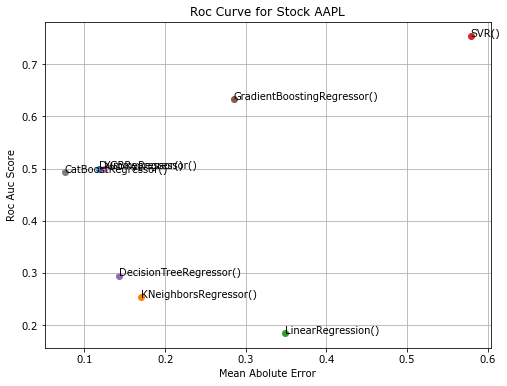

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 74.83it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'strategy': 'median'}
  Backtesting metric: 0.003964026675495715



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
  Backtesting metric: 8.590579548323719e-08

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 25.45it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'copy_X': True, 'fit_intercept': False}
  Backtesting metric: 1.9631699572208154e-06

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:05<00:00,  1.09s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'C': 5, 'coef0': 0.01, 'degree': 8, 'gamma': 'auto', 'kernel': 'poly'}
  Backtesting metric: 2.8841013506884375e-06

Number of models compared: 1920.


loop param_grid:  90%|█████████████████████████████▋   | 346/384 [00:02<00:00, 169.83it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 90, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
  Backtesting metric: 8.590579548317212e-08

Number of models compared: 540.


loop param_grid:  59%|████████████████████▋              | 64/108 [00:05<00:03, 13.59it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:36<00:00,  7.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 1.0, 'max_depth': 9, 'n_estimators': 10, 'subsample': 0.7}
  Backtesting metric: 1.1211754292061685e-07

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:23:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.59it/s]

[14:23:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.69it/s]


[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.20it/s]

[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 10.84it/s]

[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 11.03it/s]


[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 11.00it/s]


[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 10.73it/s]

[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:06, 10.96it/s]

[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.69it/s]

[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 10.80it/s]

[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:06, 10.78it/s]

[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:05, 10.92it/s]


[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.46it/s]

[14:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.01it/s]

[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.90it/s]

[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 11.98it/s]

[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.72it/s]


[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.68it/s]

[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 12.04it/s]

[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 11.72it/s]


[14:23:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.38it/s]

[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.21it/s]

[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.94it/s]

[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.56it/s]

[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.69it/s]


[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.04it/s]

[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 11.37it/s]

[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 11.30it/s]

[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.96it/s]


[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.15it/s]

[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.15it/s]

[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.84it/s]


[14:23:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:08<00:00, 10.93it/s]

[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]


[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.02it/s]

[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 12.10it/s]

[14:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.43it/s]

[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.02it/s]

[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 12.04it/s]


[14:24:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.79it/s]

[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 11.92it/s]


[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.42it/s]

[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 12.46it/s]

[14:24:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:04, 12.36it/s]

[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:04, 12.47it/s]

[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.21it/s]


[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 12.33it/s]

[14:24:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:03, 12.07it/s]

[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.44it/s]

[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.20it/s]

[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.21it/s]

[14:24:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.08it/s]

[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03, 10.67it/s]

[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.76it/s]


[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.92it/s]

[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:05<00:02, 10.63it/s]

[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.86it/s]


[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 11.11it/s]

[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.25it/s]


[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.58it/s]

[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 11.16it/s]

[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.69it/s]

[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.72it/s]

[14:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.18it/s]


[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:07<00:00, 10.03it/s]

[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.00it/s]


[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:17<00:25,  8.56s/it]

[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 15.19it/s]

[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.77it/s]

[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:06, 12.88it/s]

[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.81it/s]

[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:06, 12.69it/s]

[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 11.81it/s]

[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.75it/s]

[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.62it/s]

[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 11.90it/s]

[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 11.46it/s]

[14:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.36it/s]


[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 11.60it/s]


[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.13it/s]

[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.23it/s]


[14:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.63it/s]

[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.86it/s]


[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:03<00:04, 11.63it/s]

[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.41it/s]

[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 11.12it/s]


[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.07it/s]


[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 10.88it/s]


[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 10.87it/s]

[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.53it/s]


[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.80it/s]

[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.68it/s]

[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.64it/s]


[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 10.53it/s]


[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.67it/s]


[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.69it/s]


[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.86it/s]

[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.31it/s]

[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.41it/s]

[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.37it/s]


[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.11it/s]


[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:07<00:00,  9.11it/s]

[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:08<00:00,  9.06it/s]

[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:08<00:00, 10.61it/s]

[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]


[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.72it/s]

[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.82it/s]

[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 11.72it/s]

[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.43it/s]


[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 11.42it/s]


[14:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.50it/s]

[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.43it/s]


[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 11.86it/s]

[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 11.26it/s]

[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.46it/s]


[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 11.89it/s]


[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.34it/s]


[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.03it/s]

[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 11.24it/s]

[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.56it/s]


[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.60it/s]


[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 11.79it/s]

[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.57it/s]

[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 11.24it/s]

[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:04, 10.52it/s]

[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:04, 10.03it/s]

[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03,  9.97it/s]

[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.61it/s]

[14:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:05<00:03,  8.77it/s]

[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  9.05it/s]

[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.34it/s]

[14:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:06<00:02,  9.38it/s]

[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 10.80it/s]


[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 11.07it/s]

[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 11.13it/s]

[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.91it/s]


[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.84it/s]

[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00, 10.90it/s]

[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 11.14it/s]


[14:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:08<00:00, 11.40it/s]

[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.22it/s]

[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 12.32it/s]

[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.57it/s]


[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 12.84it/s]

[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.46it/s]

[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.93it/s]

[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:05, 12.58it/s]

[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:05, 13.09it/s]

[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:04, 13.19it/s]

[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:04, 13.30it/s]


[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:02<00:04, 13.09it/s]

[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 13.22it/s]

[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:03, 13.16it/s]

[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 13.31it/s]

[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:03<00:03, 12.78it/s]


[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 12.43it/s]

[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.93it/s]

[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:04<00:03, 11.30it/s]

[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.41it/s]

[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.36it/s]

[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.35it/s]


[14:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:05<00:02, 11.38it/s]

[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:05<00:01, 11.72it/s]

[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.33it/s]

[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 11.61it/s]

[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.56it/s]


[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:06<00:00, 11.58it/s]

[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 12.12it/s]

[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:07<00:00, 11.77it/s]

[14:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:24:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


[14:24:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'colsample_bytree': 0.4, 'gamma': 0.7, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}
  Backtesting metric: 0.00824964808628332

Number of models compared: 60.


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.56it/s]

0:	learn: 0.2115624	total: 910us	remaining: 26.4ms
1:	learn: 0.2053769	total: 1.9ms	remaining: 26.7ms
2:	learn: 0.2001563	total: 2.93ms	remaining: 26.3ms
3:	learn: 0.1944065	total: 3.74ms	remaining: 24.3ms
4:	learn: 0.1885031	total: 4.6ms	remaining: 23ms
5:	learn: 0.1832734	total: 5.48ms	remaining: 21.9ms
6:	learn: 0.1776767	total: 6.39ms	remaining: 21ms
7:	learn: 0.1732073	total: 7.05ms	remaining: 19.4ms
8:	learn: 0.1683325	total: 8.07ms	remaining: 18.8ms
9:	learn: 0.1641568	total: 9.26ms	remaining: 18.5ms
10:	learn: 0.1589398	total: 10.1ms	remaining: 17.4ms
11:	learn: 0.1546229	total: 11.2ms	remaining: 16.7ms
12:	learn: 0.1506051	total: 11.9ms	remaining: 15.5ms
13:	learn: 0.1465618	total: 12.7ms	remaining: 14.5ms
14:	learn: 0.1434575	total: 13.5ms	remaining: 13.5ms
15:	learn: 0.1402715	total: 14.3ms	remaining: 12.5ms
16:	learn: 0.1365613	total: 15ms	remaining: 11.5ms
17:	learn: 0.1332774	total: 15.8ms	remaining: 10.6ms
18:	learn: 0.1305537	total: 17ms	remaining: 9.86ms
19:	learn: 0.1

8:	learn: 0.1683325	total: 8.2ms	remaining: 37.3ms
9:	learn: 0.1641568	total: 9.09ms	remaining: 36.4ms
10:	learn: 0.1589398	total: 9.79ms	remaining: 34.7ms
11:	learn: 0.1546229	total: 10.6ms	remaining: 33.5ms
12:	learn: 0.1506051	total: 11.2ms	remaining: 31.9ms
13:	learn: 0.1465618	total: 12ms	remaining: 30.9ms
14:	learn: 0.1434575	total: 12.9ms	remaining: 30.2ms
15:	learn: 0.1402715	total: 13.7ms	remaining: 29.2ms
16:	learn: 0.1365613	total: 14.8ms	remaining: 28.7ms
17:	learn: 0.1332774	total: 15.9ms	remaining: 28.2ms
18:	learn: 0.1305537	total: 16.5ms	remaining: 27ms
19:	learn: 0.1273158	total: 17.3ms	remaining: 25.9ms
20:	learn: 0.1241392	total: 18ms	remaining: 24.8ms
21:	learn: 0.1213429	total: 18.8ms	remaining: 23.9ms
22:	learn: 0.1185380	total: 19.4ms	remaining: 22.8ms
23:	learn: 0.1163213	total: 20ms	remaining: 21.7ms
24:	learn: 0.1137535	total: 20.7ms	remaining: 20.7ms
25:	learn: 0.1112253	total: 21.4ms	remaining: 19.8ms
26:	learn: 0.1090067	total: 22.1ms	remaining: 18.8ms
27:	

loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00, 10.10it/s]

0:	learn: 0.2118251	total: 1.64ms	remaining: 47.5ms



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  9.89it/s]

1:	learn: 0.2060128	total: 3.52ms	remaining: 49.3ms
2:	learn: 0.1999811	total: 4.13ms	remaining: 37.2ms
3:	learn: 0.1943842	total: 5.71ms	remaining: 37.1ms
4:	learn: 0.1892039	total: 7.22ms	remaining: 36.1ms
5:	learn: 0.1838292	total: 8.7ms	remaining: 34.8ms
6:	learn: 0.1788944	total: 10.1ms	remaining: 33.3ms
7:	learn: 0.1739907	total: 11.5ms	remaining: 31.7ms
8:	learn: 0.1694418	total: 13.1ms	remaining: 30.6ms
9:	learn: 0.1647258	total: 15.2ms	remaining: 30.4ms
10:	learn: 0.1601158	total: 16.8ms	remaining: 29.1ms
11:	learn: 0.1561121	total: 18.7ms	remaining: 28ms
12:	learn: 0.1520935	total: 20.2ms	remaining: 26.4ms
13:	learn: 0.1484180	total: 21.7ms	remaining: 24.8ms
14:	learn: 0.1441781	total: 22.4ms	remaining: 22.4ms
15:	learn: 0.1400969	total: 23.7ms	remaining: 20.7ms
16:	learn: 0.1370172	total: 25ms	remaining: 19.1ms
17:	learn: 0.1330001	total: 27ms	remaining: 18ms
18:	learn: 0.1302560	total: 28.5ms	remaining: 16.5ms
19:	learn: 0.1270318	total: 30.4ms	remaining: 15.2ms
20:	learn: 


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  8.57it/s]

1:	learn: 0.2060128	total: 3.43ms	remaining: 82.4ms
2:	learn: 0.1999811	total: 4.22ms	remaining: 66.2ms
3:	learn: 0.1943842	total: 6.14ms	remaining: 70.6ms
4:	learn: 0.1892039	total: 7.8ms	remaining: 70.2ms
5:	learn: 0.1838292	total: 9.29ms	remaining: 68.1ms
6:	learn: 0.1788944	total: 10.7ms	remaining: 65.5ms
7:	learn: 0.1739907	total: 12.2ms	remaining: 64.3ms
8:	learn: 0.1694418	total: 13.9ms	remaining: 63.3ms
9:	learn: 0.1647258	total: 15.4ms	remaining: 61.6ms
10:	learn: 0.1601158	total: 17.5ms	remaining: 62.1ms
11:	learn: 0.1561121	total: 19.4ms	remaining: 61.3ms
12:	learn: 0.1520935	total: 21.5ms	remaining: 61.2ms
13:	learn: 0.1484180	total: 24ms	remaining: 61.8ms
14:	learn: 0.1441781	total: 25ms	remaining: 58.3ms
15:	learn: 0.1400969	total: 27.7ms	remaining: 58.9ms
16:	learn: 0.1370172	total: 30.1ms	remaining: 58.5ms
17:	learn: 0.1330001	total: 31.9ms	remaining: 56.7ms
18:	learn: 0.1302560	total: 33.4ms	remaining: 54.6ms
19:	learn: 0.1270318	total: 35.7ms	remaining: 53.5ms
20:	lea


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:00<00:00,  7.84it/s]

6:	learn: 0.1474769	total: 11.4ms	remaining: 70.2ms
7:	learn: 0.1404650	total: 13.2ms	remaining: 69ms
8:	learn: 0.1339060	total: 14.8ms	remaining: 67.3ms
9:	learn: 0.1270847	total: 16.3ms	remaining: 65.2ms
10:	learn: 0.1210422	total: 17.9ms	remaining: 63.3ms
11:	learn: 0.1158783	total: 19.4ms	remaining: 61.5ms
12:	learn: 0.1108213	total: 21.5ms	remaining: 61.3ms
13:	learn: 0.1063695	total: 23.2ms	remaining: 59.6ms
14:	learn: 0.1017320	total: 24.2ms	remaining: 56.4ms
15:	learn: 0.0969149	total: 26.4ms	remaining: 56ms
16:	learn: 0.0937156	total: 28ms	remaining: 54.4ms
17:	learn: 0.0896934	total: 29.7ms	remaining: 52.9ms
18:	learn: 0.0873851	total: 31.1ms	remaining: 50.8ms
19:	learn: 0.0837774	total: 33.1ms	remaining: 49.7ms
20:	learn: 0.0810211	total: 34.7ms	remaining: 47.9ms
21:	learn: 0.0787473	total: 36.6ms	remaining: 46.6ms
22:	learn: 0.0765550	total: 38.3ms	remaining: 45ms
23:	learn: 0.0745972	total: 39.8ms	remaining: 43.1ms
24:	learn: 0.0717698	total: 41ms	remaining: 41ms
25:	learn


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.95it/s]

11:	learn: 0.1575129	total: 40.4ms	remaining: 60.7ms
12:	learn: 0.1540412	total: 45.3ms	remaining: 59.2ms
13:	learn: 0.1506011	total: 49.7ms	remaining: 56.8ms
14:	learn: 0.1469857	total: 50.1ms	remaining: 50.1ms
15:	learn: 0.1428870	total: 54.8ms	remaining: 48ms
16:	learn: 0.1396100	total: 60ms	remaining: 45.9ms
17:	learn: 0.1362782	total: 66.3ms	remaining: 44.2ms
18:	learn: 0.1329353	total: 71.6ms	remaining: 41.4ms
19:	learn: 0.1300591	total: 75.9ms	remaining: 38ms
20:	learn: 0.1267623	total: 79.9ms	remaining: 34.3ms
21:	learn: 0.1235312	total: 84.1ms	remaining: 30.6ms
22:	learn: 0.1207528	total: 88.4ms	remaining: 26.9ms
23:	learn: 0.1179694	total: 92.4ms	remaining: 23.1ms
24:	learn: 0.1150710	total: 97ms	remaining: 19.4ms
25:	learn: 0.1124459	total: 102ms	remaining: 15.7ms
26:	learn: 0.1102698	total: 104ms	remaining: 11.6ms
27:	learn: 0.1075991	total: 107ms	remaining: 7.62ms
28:	learn: 0.1051325	total: 111ms	remaining: 3.83ms
29:	learn: 0.1031521	total: 115ms	remaining: 0us
0:	learn:


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  6.31it/s]

12:	learn: 0.1103210	total: 49.8ms	remaining: 65.1ms
13:	learn: 0.1049683	total: 51.6ms	remaining: 59ms
14:	learn: 0.1006262	total: 57ms	remaining: 57ms
15:	learn: 0.0961531	total: 59.5ms	remaining: 52.1ms
16:	learn: 0.0928147	total: 64.6ms	remaining: 49.4ms
17:	learn: 0.0888271	total: 68.7ms	remaining: 45.8ms
18:	learn: 0.0855801	total: 73ms	remaining: 42.3ms
19:	learn: 0.0825773	total: 78.4ms	remaining: 39.2ms
20:	learn: 0.0787182	total: 83.1ms	remaining: 35.6ms
21:	learn: 0.0760032	total: 87.1ms	remaining: 31.7ms
22:	learn: 0.0729471	total: 92ms	remaining: 28ms
23:	learn: 0.0701438	total: 97.5ms	remaining: 24.4ms
24:	learn: 0.0679343	total: 102ms	remaining: 20.4ms
25:	learn: 0.0657979	total: 106ms	remaining: 16.3ms
26:	learn: 0.0634148	total: 110ms	remaining: 12.3ms
27:	learn: 0.0617940	total: 115ms	remaining: 8.24ms
28:	learn: 0.0602944	total: 121ms	remaining: 4.19ms
29:	learn: 0.0587033	total: 126ms	remaining: 0us
0:	learn: 0.2124882	total: 4.65ms	remaining: 228ms
1:	learn: 0.2068


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.46it/s]

37:	learn: 0.0883542	total: 208ms	remaining: 65.5ms
38:	learn: 0.0868473	total: 216ms	remaining: 61ms
39:	learn: 0.0852381	total: 223ms	remaining: 55.8ms
40:	learn: 0.0836685	total: 230ms	remaining: 50.5ms
41:	learn: 0.0818443	total: 237ms	remaining: 45.2ms
42:	learn: 0.0804459	total: 239ms	remaining: 38.9ms
43:	learn: 0.0788886	total: 247ms	remaining: 33.6ms
44:	learn: 0.0775015	total: 253ms	remaining: 28.1ms
45:	learn: 0.0756718	total: 254ms	remaining: 22.1ms
46:	learn: 0.0742586	total: 261ms	remaining: 16.7ms
47:	learn: 0.0729265	total: 267ms	remaining: 11.1ms
48:	learn: 0.0715346	total: 271ms	remaining: 5.53ms
49:	learn: 0.0702937	total: 278ms	remaining: 0us
0:	learn: 0.2064692	total: 9.07ms	remaining: 445ms
1:	learn: 0.1956146	total: 15.4ms	remaining: 370ms
2:	learn: 0.1841159	total: 21.8ms	remaining: 341ms
3:	learn: 0.1735169	total: 33.3ms	remaining: 383ms
4:	learn: 0.1640129	total: 41ms	remaining: 369ms
5:	learn: 0.1560161	total: 47.2ms	remaining: 346ms
6:	learn: 0.1487716	total


loop lags_grid:  20%|███████▊                               | 1/5 [00:02<00:08,  2.06s/it]

38:	learn: 0.0452601	total: 200ms	remaining: 56.3ms
39:	learn: 0.0440129	total: 206ms	remaining: 51.5ms
40:	learn: 0.0426751	total: 212ms	remaining: 46.5ms
41:	learn: 0.0419996	total: 218ms	remaining: 41.5ms
42:	learn: 0.0411269	total: 224ms	remaining: 36.5ms
43:	learn: 0.0402987	total: 228ms	remaining: 31.1ms
44:	learn: 0.0389600	total: 233ms	remaining: 25.9ms
45:	learn: 0.0377898	total: 237ms	remaining: 20.6ms
46:	learn: 0.0364562	total: 242ms	remaining: 15.5ms
47:	learn: 0.0356150	total: 249ms	remaining: 10.4ms
48:	learn: 0.0347238	total: 250ms	remaining: 5.11ms
49:	learn: 0.0338091	total: 255ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1869926	total: 1.3ms	remaining: 37.7ms
1:	learn: 0.1817331	total: 2.39ms	remaining: 33.5ms
2:	learn: 0.1774534	total: 3.38ms	remaining: 30.4ms
3:	learn: 0.1735421	total: 4.28ms	remaining: 27.8ms
4:	learn: 0.1689057	total: 5.25ms	remaining: 26.3ms
5:	learn: 0.1639549	total: 6.17ms	remaining: 24.7ms
6:	learn: 0.1595434	total: 7.19ms	remaining: 23.6ms
7:	learn: 0.1552414	total: 8.22ms	remaining: 22.6ms
8:	learn: 0.1515157	total: 9.33ms	remaining: 21.8ms
9:	learn: 0.1476251	total: 10.4ms	remaining: 20.8ms
10:	learn: 0.1434377	total: 10.8ms	remaining: 18.6ms
11:	learn: 0.1399500	total: 11.7ms	remaining: 17.6ms
12:	learn: 0.1363351	total: 12.6ms	remaining: 16.4ms
13:	learn: 0.1335038	total: 13.4ms	remaining: 15.3ms
14:	learn: 0.1304002	total: 14.3ms	remaining: 14.3ms
15:	learn: 0.1272335	total: 15.2ms	remaining: 13.3ms
16:	learn: 0.1244217	total: 16.2ms	remaining: 12.4ms
17:	learn: 0.1214499	total: 16.8ms	remaining: 11.2ms
18:	learn: 0.1182837	total: 17.8ms	remaining: 10.3ms
19:	


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 10.55it/s]

0:	learn: 0.1817131	total: 994us	remaining: 28.8ms
1:	learn: 0.1716934	total: 2.11ms	remaining: 29.6ms
2:	learn: 0.1637919	total: 3.07ms	remaining: 27.6ms
3:	learn: 0.1553379	total: 4.02ms	remaining: 26.2ms
4:	learn: 0.1473122	total: 4.9ms	remaining: 24.5ms
5:	learn: 0.1391477	total: 5.93ms	remaining: 23.7ms
6:	learn: 0.1321755	total: 6.86ms	remaining: 22.5ms
7:	learn: 0.1256382	total: 7.72ms	remaining: 21.2ms
8:	learn: 0.1201938	total: 8.52ms	remaining: 19.9ms
9:	learn: 0.1144742	total: 9.3ms	remaining: 18.6ms
10:	learn: 0.1091976	total: 9.68ms	remaining: 16.7ms
11:	learn: 0.1051000	total: 10.4ms	remaining: 15.6ms
12:	learn: 0.1011504	total: 11.7ms	remaining: 15.3ms
13:	learn: 0.0968422	total: 12.7ms	remaining: 14.5ms
14:	learn: 0.0934024	total: 14.1ms	remaining: 14.1ms
15:	learn: 0.0898313	total: 15.2ms	remaining: 13.3ms
16:	learn: 0.0865756	total: 16.1ms	remaining: 12.3ms
17:	learn: 0.0840253	total: 17ms	remaining: 11.3ms
18:	learn: 0.0806401	total: 18ms	remaining: 10.4ms
19:	learn:


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.08it/s]

26:	learn: 0.0639376	total: 31.7ms	remaining: 27ms
27:	learn: 0.0622068	total: 32.8ms	remaining: 25.8ms
28:	learn: 0.0600273	total: 33.6ms	remaining: 24.3ms
29:	learn: 0.0584132	total: 34.5ms	remaining: 23ms
30:	learn: 0.0569967	total: 35.4ms	remaining: 21.7ms
31:	learn: 0.0555301	total: 36.5ms	remaining: 20.5ms
32:	learn: 0.0541574	total: 37.3ms	remaining: 19.2ms
33:	learn: 0.0525427	total: 38.3ms	remaining: 18ms
34:	learn: 0.0511992	total: 39.2ms	remaining: 16.8ms
35:	learn: 0.0501219	total: 40.2ms	remaining: 15.6ms
36:	learn: 0.0491284	total: 41.1ms	remaining: 14.4ms
37:	learn: 0.0482179	total: 42.1ms	remaining: 13.3ms
38:	learn: 0.0474564	total: 42.9ms	remaining: 12.1ms
39:	learn: 0.0466156	total: 44.1ms	remaining: 11ms
40:	learn: 0.0453142	total: 45.2ms	remaining: 9.92ms
41:	learn: 0.0444610	total: 46.2ms	remaining: 8.8ms
42:	learn: 0.0433597	total: 47.2ms	remaining: 7.68ms
43:	learn: 0.0421976	total: 47.9ms	remaining: 6.53ms
44:	learn: 0.0413352	total: 49ms	remaining: 5.44ms
45:	


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  7.47it/s]

26:	learn: 0.0998272	total: 66ms	remaining: 7.33ms
27:	learn: 0.0977545	total: 68.8ms	remaining: 4.91ms
28:	learn: 0.0959455	total: 69.7ms	remaining: 2.4ms
29:	learn: 0.0941435	total: 72.2ms	remaining: 0us
0:	learn: 0.1830979	total: 2.83ms	remaining: 82.1ms
1:	learn: 0.1735926	total: 5.5ms	remaining: 77ms
2:	learn: 0.1656550	total: 9.23ms	remaining: 83.1ms
3:	learn: 0.1558810	total: 12.5ms	remaining: 81ms
4:	learn: 0.1475836	total: 15ms	remaining: 75.2ms
5:	learn: 0.1402774	total: 15.5ms	remaining: 62.2ms
6:	learn: 0.1334280	total: 18.4ms	remaining: 60.5ms
7:	learn: 0.1265427	total: 21.8ms	remaining: 60ms
8:	learn: 0.1216274	total: 24.7ms	remaining: 57.6ms
9:	learn: 0.1161803	total: 27.4ms	remaining: 54.8ms


10:	learn: 0.1113149	total: 30.3ms	remaining: 52.3ms
11:	learn: 0.1065416	total: 32.5ms	remaining: 48.7ms
12:	learn: 0.1017749	total: 34.8ms	remaining: 45.4ms
13:	learn: 0.0967225	total: 37ms	remaining: 42.3ms
14:	learn: 0.0930801	total: 39.5ms	remaining: 39.5ms
15:	learn: 0.0896730	total: 42.1ms	remaining: 36.8ms
16:	learn: 0.0855476	total: 44.8ms	remaining: 34.2ms
17:	learn: 0.0821750	total: 46.7ms	remaining: 31.1ms
18:	learn: 0.0795115	total: 49ms	remaining: 28.4ms
19:	learn: 0.0761988	total: 51.5ms	remaining: 25.8ms
20:	learn: 0.0730400	total: 53.6ms	remaining: 23ms
21:	learn: 0.0709543	total: 56.6ms	remaining: 20.6ms
22:	learn: 0.0685431	total: 58.7ms	remaining: 17.9ms
23:	learn: 0.0662200	total: 61ms	remaining: 15.2ms
24:	learn: 0.0641074	total: 63.4ms	remaining: 12.7ms
25:	learn: 0.0625288	total: 65.8ms	remaining: 10.1ms
26:	learn: 0.0610237	total: 68.2ms	remaining: 7.57ms
27:	learn: 0.0593657	total: 70.2ms	remaining: 5.02ms
28:	learn: 0.0575550	total: 72.1ms	remaining: 2.48ms
2

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.11it/s]

0:	learn: 0.1876929	total: 3.17ms	remaining: 155ms
1:	learn: 0.1827692	total: 5.92ms	remaining: 142ms
2:	learn: 0.1784993	total: 8ms	remaining: 125ms
3:	learn: 0.1731132	total: 10.4ms	remaining: 120ms
4:	learn: 0.1683353	total: 25.9ms	remaining: 233ms
5:	learn: 0.1638191	total: 26.6ms	remaining: 195ms
6:	learn: 0.1596082	total: 29ms	remaining: 178ms
7:	learn: 0.1555194	total: 31.7ms	remaining: 166ms
8:	learn: 0.1526095	total: 33.8ms	remaining: 154ms
9:	learn: 0.1487553	total: 35.6ms	remaining: 142ms
10:	learn: 0.1452119	total: 39.3ms	remaining: 139ms
11:	learn: 0.1417599	total: 41.7ms	remaining: 132ms
12:	learn: 0.1381112	total: 44ms	remaining: 125ms
13:	learn: 0.1341954	total: 46.4ms	remaining: 119ms
14:	learn: 0.1312853	total: 49.2ms	remaining: 115ms
15:	learn: 0.1284455	total: 51.4ms	remaining: 109ms
16:	learn: 0.1251129	total: 53.4ms	remaining: 104ms
17:	learn: 0.1220071	total: 55.6ms	remaining: 98.8ms


18:	learn: 0.1194304	total: 58ms	remaining: 94.6ms
19:	learn: 0.1165192	total: 59ms	remaining: 88.4ms
20:	learn: 0.1135966	total: 61.4ms	remaining: 84.8ms
21:	learn: 0.1108557	total: 64.2ms	remaining: 81.7ms
22:	learn: 0.1082832	total: 67.2ms	remaining: 78.8ms
23:	learn: 0.1062106	total: 69.5ms	remaining: 75.3ms
24:	learn: 0.1037694	total: 72ms	remaining: 72ms
25:	learn: 0.1017844	total: 74.5ms	remaining: 68.8ms
26:	learn: 0.0998272	total: 76.8ms	remaining: 65.4ms
27:	learn: 0.0977545	total: 79.3ms	remaining: 62.3ms
28:	learn: 0.0959455	total: 80.6ms	remaining: 58.3ms
29:	learn: 0.0941435	total: 82.7ms	remaining: 55.1ms
30:	learn: 0.0919665	total: 84.8ms	remaining: 52ms
31:	learn: 0.0904711	total: 86.7ms	remaining: 48.8ms
32:	learn: 0.0889811	total: 89.2ms	remaining: 46ms
33:	learn: 0.0873705	total: 91.1ms	remaining: 42.9ms
34:	learn: 0.0857154	total: 93ms	remaining: 39.9ms
35:	learn: 0.0839072	total: 94.9ms	remaining: 36.9ms
36:	learn: 0.0821857	total: 97.2ms	remaining: 34.2ms
37:	lea

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.07it/s]

0:	learn: 0.1830979	total: 2.39ms	remaining: 117ms
1:	learn: 0.1735926	total: 4.08ms	remaining: 98ms
2:	learn: 0.1656550	total: 5.74ms	remaining: 90ms
3:	learn: 0.1558810	total: 7.82ms	remaining: 89.9ms
4:	learn: 0.1475836	total: 10ms	remaining: 90.4ms
5:	learn: 0.1402774	total: 10.6ms	remaining: 77.5ms
6:	learn: 0.1334280	total: 12.6ms	remaining: 77.1ms
7:	learn: 0.1265427	total: 14.5ms	remaining: 76.1ms
8:	learn: 0.1216274	total: 16.3ms	remaining: 74.4ms
9:	learn: 0.1161803	total: 25ms	remaining: 99.9ms
10:	learn: 0.1113149	total: 27ms	remaining: 95.7ms
11:	learn: 0.1065416	total: 29ms	remaining: 92ms
12:	learn: 0.1017749	total: 30.5ms	remaining: 86.7ms



loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.91it/s]

13:	learn: 0.0967225	total: 32.4ms	remaining: 83.3ms
14:	learn: 0.0930801	total: 34.1ms	remaining: 79.5ms
15:	learn: 0.0896730	total: 36ms	remaining: 76.6ms
16:	learn: 0.0855476	total: 37.8ms	remaining: 73.3ms
17:	learn: 0.0821750	total: 39.5ms	remaining: 70.2ms
18:	learn: 0.0795115	total: 41.2ms	remaining: 67.2ms
19:	learn: 0.0761988	total: 43ms	remaining: 64.6ms
20:	learn: 0.0730400	total: 45.1ms	remaining: 62.2ms
21:	learn: 0.0709543	total: 47.4ms	remaining: 60.3ms
22:	learn: 0.0685431	total: 49.1ms	remaining: 57.7ms
23:	learn: 0.0662200	total: 51.3ms	remaining: 55.6ms
24:	learn: 0.0641074	total: 53.2ms	remaining: 53.2ms
25:	learn: 0.0625288	total: 54.9ms	remaining: 50.7ms
26:	learn: 0.0610237	total: 56.7ms	remaining: 48.3ms
27:	learn: 0.0593657	total: 58.5ms	remaining: 46ms
28:	learn: 0.0575550	total: 60.2ms	remaining: 43.6ms
29:	learn: 0.0559508	total: 62ms	remaining: 41.4ms
30:	learn: 0.0543549	total: 63.8ms	remaining: 39.1ms
31:	learn: 0.0526211	total: 65.5ms	remaining: 36.8ms
3


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.58it/s]

10:	learn: 0.1474923	total: 51.8ms	remaining: 89.4ms
11:	learn: 0.1442928	total: 57ms	remaining: 85.6ms
12:	learn: 0.1409803	total: 61.9ms	remaining: 80.9ms
13:	learn: 0.1380378	total: 66.9ms	remaining: 76.4ms
14:	learn: 0.1345636	total: 71.4ms	remaining: 71.4ms
15:	learn: 0.1315175	total: 76.1ms	remaining: 66.6ms
16:	learn: 0.1286667	total: 81.4ms	remaining: 62.2ms
17:	learn: 0.1252879	total: 86.3ms	remaining: 57.5ms
18:	learn: 0.1223873	total: 92.1ms	remaining: 53.3ms
19:	learn: 0.1196028	total: 92.9ms	remaining: 46.4ms
20:	learn: 0.1173249	total: 99.1ms	remaining: 42.5ms
21:	learn: 0.1142606	total: 100ms	remaining: 36.4ms
22:	learn: 0.1117129	total: 103ms	remaining: 31.4ms
23:	learn: 0.1096039	total: 109ms	remaining: 27.2ms
24:	learn: 0.1073634	total: 113ms	remaining: 22.7ms
25:	learn: 0.1050955	total: 116ms	remaining: 17.9ms
26:	learn: 0.1028762	total: 122ms	remaining: 13.6ms
27:	learn: 0.1009397	total: 128ms	remaining: 9.13ms
28:	learn: 0.0985155	total: 129ms	remaining: 4.43ms
29:


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.88it/s]

29:	learn: 0.0551673	total: 183ms	remaining: 0us
0:	learn: 0.1877402	total: 7.62ms	remaining: 373ms
1:	learn: 0.1832596	total: 13.2ms	remaining: 316ms
2:	learn: 0.1788428	total: 19.1ms	remaining: 299ms
3:	learn: 0.1739425	total: 20.9ms	remaining: 240ms
4:	learn: 0.1702649	total: 26ms	remaining: 234ms
5:	learn: 0.1666305	total: 31.7ms	remaining: 232ms
6:	learn: 0.1632413	total: 37.6ms	remaining: 231ms
7:	learn: 0.1584433	total: 39.6ms	remaining: 208ms
8:	learn: 0.1550635	total: 44.8ms	remaining: 204ms
9:	learn: 0.1517520	total: 47ms	remaining: 188ms
10:	learn: 0.1474923	total: 51.9ms	remaining: 184ms
11:	learn: 0.1442928	total: 56.9ms	remaining: 180ms
12:	learn: 0.1409803	total: 62.7ms	remaining: 178ms
13:	learn: 0.1380378	total: 67.9ms	remaining: 174ms
14:	learn: 0.1345636	total: 73.7ms	remaining: 172ms
15:	learn: 0.1315175	total: 81.4ms	remaining: 173ms
16:	learn: 0.1286667	total: 86.8ms	remaining: 169ms
17:	learn: 0.1252879	total: 92.6ms	remaining: 165ms
18:	learn: 0.1223873	total: 9

34:	learn: 0.0863459	total: 173ms	remaining: 74.3ms
35:	learn: 0.0840166	total: 179ms	remaining: 69.7ms
36:	learn: 0.0823059	total: 185ms	remaining: 64.9ms
37:	learn: 0.0807811	total: 190ms	remaining: 60.1ms
38:	learn: 0.0795334	total: 196ms	remaining: 55.4ms
39:	learn: 0.0782709	total: 201ms	remaining: 50.3ms
40:	learn: 0.0765844	total: 208ms	remaining: 45.6ms
41:	learn: 0.0751500	total: 215ms	remaining: 41ms
42:	learn: 0.0738263	total: 220ms	remaining: 35.8ms
43:	learn: 0.0725989	total: 222ms	remaining: 30.3ms
44:	learn: 0.0713500	total: 229ms	remaining: 25.4ms
45:	learn: 0.0701031	total: 234ms	remaining: 20.4ms
46:	learn: 0.0687379	total: 240ms	remaining: 15.3ms
47:	learn: 0.0673938	total: 245ms	remaining: 10.2ms
48:	learn: 0.0661695	total: 250ms	remaining: 5.11ms
49:	learn: 0.0648996	total: 256ms	remaining: 0us


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  4.07it/s]

0:	learn: 0.1831767	total: 5ms	remaining: 245ms
1:	learn: 0.1744984	total: 10.3ms	remaining: 247ms
2:	learn: 0.1659764	total: 14.4ms	remaining: 226ms
3:	learn: 0.1583080	total: 18.7ms	remaining: 216ms
4:	learn: 0.1521360	total: 24.2ms	remaining: 218ms
5:	learn: 0.1437129	total: 29.6ms	remaining: 217ms
6:	learn: 0.1380219	total: 34.7ms	remaining: 213ms
7:	learn: 0.1307473	total: 35.9ms	remaining: 188ms
8:	learn: 0.1254122	total: 40.7ms	remaining: 186ms
9:	learn: 0.1204626	total: 42.4ms	remaining: 169ms
10:	learn: 0.1141601	total: 48.1ms	remaining: 171ms
11:	learn: 0.1098233	total: 53.4ms	remaining: 169ms
12:	learn: 0.1051217	total: 57.8ms	remaining: 165ms
13:	learn: 0.1008057	total: 62.9ms	remaining: 162ms
14:	learn: 0.0958712	total: 74.2ms	remaining: 173ms
15:	learn: 0.0921028	total: 79.8ms	remaining: 170ms
16:	learn: 0.0881204	total: 83.1ms	remaining: 161ms
17:	learn: 0.0848854	total: 88.4ms	remaining: 157ms
18:	learn: 0.0811405	total: 92.9ms	remaining: 152ms
19:	learn: 0.0784550	tota


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:04<00:06,  2.23s/it]

46:	learn: 0.0337855	total: 200ms	remaining: 12.8ms
47:	learn: 0.0326963	total: 204ms	remaining: 8.52ms
48:	learn: 0.0319449	total: 209ms	remaining: 4.27ms
49:	learn: 0.0309743	total: 216ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1177066	total: 1.04ms	remaining: 30.2ms
1:	learn: 0.1156089	total: 2ms	remaining: 28.1ms
2:	learn: 0.1136324	total: 2.57ms	remaining: 23.1ms
3:	learn: 0.1115471	total: 3.35ms	remaining: 21.8ms
4:	learn: 0.1100708	total: 4.23ms	remaining: 21.1ms
5:	learn: 0.1082257	total: 5.07ms	remaining: 20.3ms
6:	learn: 0.1063189	total: 5.85ms	remaining: 19.2ms
7:	learn: 0.1044871	total: 6.73ms	remaining: 18.5ms
8:	learn: 0.1028440	total: 7.6ms	remaining: 17.7ms
9:	learn: 0.1011933	total: 8.36ms	remaining: 16.7ms
10:	learn: 0.0996820	total: 9.18ms	remaining: 15.9ms
11:	learn: 0.0980156	total: 10ms	remaining: 15ms
12:	learn: 0.0965002	total: 10.8ms	remaining: 14.1ms
13:	learn: 0.0951333	total: 11.6ms	remaining: 13.3ms
14:	learn: 0.0931641	total: 12.7ms	remaining: 12.7ms
15:	learn: 0.0914744	total: 13.5ms	remaining: 11.8ms
16:	learn: 0.0902745	total: 14.2ms	remaining: 10.9ms
17:	learn: 0.0890110	total: 15.3ms	remaining: 10.2ms
18:	learn: 0.0876762	total: 16.4ms	remaining: 9.47ms
19:	learn: 


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.54it/s]

0:	learn: 0.1156575	total: 1.02ms	remaining: 29.6ms
1:	learn: 0.1115885	total: 1.91ms	remaining: 26.8ms
2:	learn: 0.1078801	total: 2.5ms	remaining: 22.5ms
3:	learn: 0.1040789	total: 3.33ms	remaining: 21.6ms
4:	learn: 0.1014337	total: 4.2ms	remaining: 21ms
5:	learn: 0.0981872	total: 5.05ms	remaining: 20.2ms
6:	learn: 0.0948417	total: 5.83ms	remaining: 19.2ms
7:	learn: 0.0917959	total: 6.7ms	remaining: 18.4ms
8:	learn: 0.0895253	total: 7.58ms	remaining: 17.7ms
9:	learn: 0.0869050	total: 8.4ms	remaining: 16.8ms
10:	learn: 0.0845549	total: 9.29ms	remaining: 16.1ms
11:	learn: 0.0823309	total: 10.2ms	remaining: 15.3ms
12:	learn: 0.0801972	total: 11.2ms	remaining: 14.6ms
13:	learn: 0.0773147	total: 12.1ms	remaining: 13.8ms
14:	learn: 0.0744634	total: 13ms	remaining: 13ms
15:	learn: 0.0720066	total: 13.9ms	remaining: 12.2ms
16:	learn: 0.0700915	total: 15.2ms	remaining: 11.6ms
17:	learn: 0.0683378	total: 16ms	remaining: 10.7ms
18:	learn: 0.0670082	total: 16.8ms	remaining: 9.73ms
19:	learn: 0.06


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.75it/s]

35:	learn: 0.0436575	total: 46.8ms	remaining: 18.2ms
36:	learn: 0.0427164	total: 48ms	remaining: 16.9ms
37:	learn: 0.0416796	total: 49.1ms	remaining: 15.5ms
38:	learn: 0.0404410	total: 50.1ms	remaining: 14.1ms
39:	learn: 0.0395759	total: 51.1ms	remaining: 12.8ms
40:	learn: 0.0387395	total: 52.1ms	remaining: 11.4ms
41:	learn: 0.0377339	total: 53.3ms	remaining: 10.2ms
42:	learn: 0.0365162	total: 54.4ms	remaining: 8.85ms
43:	learn: 0.0357832	total: 55.5ms	remaining: 7.57ms
44:	learn: 0.0350367	total: 56.5ms	remaining: 6.28ms
45:	learn: 0.0340506	total: 58ms	remaining: 5.04ms
46:	learn: 0.0330291	total: 59.1ms	remaining: 3.77ms
47:	learn: 0.0322969	total: 60.2ms	remaining: 2.51ms
48:	learn: 0.0313444	total: 61.2ms	remaining: 1.25ms
49:	learn: 0.0302982	total: 62.3ms	remaining: 0us
0:	learn: 0.1178110	total: 3.4ms	remaining: 98.5ms
1:	learn: 0.1159650	total: 5.49ms	remaining: 76.8ms
2:	learn: 0.1139627	total: 7.6ms	remaining: 68.4ms
3:	learn: 0.1125290	total: 9.7ms	remaining: 63.1ms
4:	lear

14:	learn: 0.0928219	total: 37ms	remaining: 37ms
15:	learn: 0.0915444	total: 39.5ms	remaining: 34.5ms
16:	learn: 0.0899936	total: 41.8ms	remaining: 32ms
17:	learn: 0.0884606	total: 44.4ms	remaining: 29.6ms
18:	learn: 0.0869209	total: 46.7ms	remaining: 27.1ms
19:	learn: 0.0852730	total: 49.1ms	remaining: 24.6ms
20:	learn: 0.0840454	total: 51.5ms	remaining: 22.1ms
21:	learn: 0.0829310	total: 53.8ms	remaining: 19.6ms
22:	learn: 0.0816276	total: 56.3ms	remaining: 17.1ms
23:	learn: 0.0802971	total: 58.4ms	remaining: 14.6ms
24:	learn: 0.0788265	total: 60.3ms	remaining: 12.1ms
25:	learn: 0.0777803	total: 62.3ms	remaining: 9.58ms
26:	learn: 0.0764488	total: 65.3ms	remaining: 7.25ms
27:	learn: 0.0753998	total: 67.7ms	remaining: 4.84ms
28:	learn: 0.0744129	total: 70.3ms	remaining: 2.42ms
29:	learn: 0.0733023	total: 72.4ms	remaining: 0us


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  7.89it/s]

0:	learn: 0.1158639	total: 3.13ms	remaining: 90.9ms
1:	learn: 0.1122770	total: 5.88ms	remaining: 82.3ms
2:	learn: 0.1084627	total: 8.59ms	remaining: 77.3ms
3:	learn: 0.1048417	total: 10.9ms	remaining: 70.9ms
4:	learn: 0.1011916	total: 13.9ms	remaining: 69.5ms
5:	learn: 0.0978799	total: 16.8ms	remaining: 67.1ms
6:	learn: 0.0950211	total: 19.4ms	remaining: 63.7ms
7:	learn: 0.0921884	total: 21.8ms	remaining: 59.9ms
8:	learn: 0.0888956	total: 23.9ms	remaining: 55.8ms
9:	learn: 0.0862985	total: 25.7ms	remaining: 51.5ms
10:	learn: 0.0837849	total: 28.1ms	remaining: 48.5ms
11:	learn: 0.0811520	total: 29.2ms	remaining: 43.8ms
12:	learn: 0.0785437	total: 31ms	remaining: 40.6ms
13:	learn: 0.0761933	total: 32.9ms	remaining: 37.7ms
14:	learn: 0.0743686	total: 34.8ms	remaining: 34.8ms
15:	learn: 0.0715648	total: 36.9ms	remaining: 32.3ms
16:	learn: 0.0693584	total: 38.8ms	remaining: 29.7ms
17:	learn: 0.0672171	total: 40.7ms	remaining: 27.1ms
18:	learn: 0.0654595	total: 42.5ms	remaining: 24.6ms
19:	l


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.64it/s]

28:	learn: 0.0494831	total: 61ms	remaining: 2.1ms
29:	learn: 0.0485334	total: 63.5ms	remaining: 0us
0:	learn: 0.1178110	total: 2.83ms	remaining: 139ms
1:	learn: 0.1159650	total: 5.14ms	remaining: 123ms
2:	learn: 0.1139627	total: 7.52ms	remaining: 118ms
3:	learn: 0.1125290	total: 10.1ms	remaining: 117ms
4:	learn: 0.1105362	total: 12.9ms	remaining: 116ms
5:	learn: 0.1086633	total: 15.8ms	remaining: 116ms
6:	learn: 0.1070289	total: 18.2ms	remaining: 112ms
7:	learn: 0.1053808	total: 20.1ms	remaining: 106ms
8:	learn: 0.1031953	total: 21.9ms	remaining: 99.9ms
9:	learn: 0.1014756	total: 23.8ms	remaining: 95ms
10:	learn: 0.0996227	total: 26.3ms	remaining: 93.1ms
11:	learn: 0.0978959	total: 28.3ms	remaining: 89.7ms
12:	learn: 0.0962404	total: 30.8ms	remaining: 87.6ms
13:	learn: 0.0945520	total: 32.8ms	remaining: 84.5ms
14:	learn: 0.0928219	total: 34.8ms	remaining: 81.1ms
15:	learn: 0.0915444	total: 36.9ms	remaining: 78.4ms
16:	learn: 0.0899936	total: 39.2ms	remaining: 76.1ms
17:	learn: 0.088460


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  6.75it/s]

47:	learn: 0.0560664	total: 102ms	remaining: 4.25ms
48:	learn: 0.0554204	total: 104ms	remaining: 2.12ms
49:	learn: 0.0546425	total: 106ms	remaining: 0us
0:	learn: 0.1158639	total: 2.28ms	remaining: 112ms
1:	learn: 0.1122770	total: 3.9ms	remaining: 93.7ms
2:	learn: 0.1084627	total: 5.6ms	remaining: 87.7ms
3:	learn: 0.1048417	total: 7.35ms	remaining: 84.6ms
4:	learn: 0.1011916	total: 9.11ms	remaining: 82ms
5:	learn: 0.0978799	total: 10.8ms	remaining: 79.5ms
6:	learn: 0.0950211	total: 12.7ms	remaining: 78.1ms
7:	learn: 0.0921884	total: 14.5ms	remaining: 76ms
8:	learn: 0.0888956	total: 16.2ms	remaining: 73.8ms
9:	learn: 0.0862985	total: 17.4ms	remaining: 69.6ms
10:	learn: 0.0837849	total: 19.3ms	remaining: 68.4ms
11:	learn: 0.0811520	total: 20.2ms	remaining: 64ms
12:	learn: 0.0785437	total: 22.1ms	remaining: 62.9ms
13:	learn: 0.0761933	total: 24.3ms	remaining: 62.5ms
14:	learn: 0.0743686	total: 26.3ms	remaining: 61.4ms
15:	learn: 0.0715648	total: 28ms	remaining: 59.6ms
16:	learn: 0.0693584

21:	learn: 0.0601999	total: 41.1ms	remaining: 52.3ms
22:	learn: 0.0584676	total: 43ms	remaining: 50.4ms
23:	learn: 0.0566918	total: 45.4ms	remaining: 49.2ms
24:	learn: 0.0551580	total: 47.5ms	remaining: 47.5ms
25:	learn: 0.0534073	total: 50ms	remaining: 46.1ms
26:	learn: 0.0521073	total: 52.3ms	remaining: 44.5ms
27:	learn: 0.0509472	total: 54.1ms	remaining: 42.5ms
28:	learn: 0.0494831	total: 56ms	remaining: 40.6ms
29:	learn: 0.0485334	total: 57.9ms	remaining: 38.6ms
30:	learn: 0.0470619	total: 60ms	remaining: 36.8ms
31:	learn: 0.0459137	total: 62ms	remaining: 34.9ms
32:	learn: 0.0446753	total: 64.2ms	remaining: 33.1ms
33:	learn: 0.0434524	total: 66.3ms	remaining: 31.2ms
34:	learn: 0.0419312	total: 68.2ms	remaining: 29.2ms
35:	learn: 0.0410721	total: 69.8ms	remaining: 27.1ms
36:	learn: 0.0400007	total: 70.9ms	remaining: 24.9ms
37:	learn: 0.0388788	total: 72.5ms	remaining: 22.9ms
38:	learn: 0.0377905	total: 74.9ms	remaining: 21.1ms
39:	learn: 0.0369767	total: 77.1ms	remaining: 19.3ms
40:

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.49it/s]

0:	learn: 0.1178578	total: 6.44ms	remaining: 187ms
1:	learn: 0.1161062	total: 14.4ms	remaining: 201ms
2:	learn: 0.1144153	total: 19.5ms	remaining: 176ms
3:	learn: 0.1126731	total: 22.7ms	remaining: 148ms
4:	learn: 0.1109179	total: 28.9ms	remaining: 144ms
5:	learn: 0.1090730	total: 35.1ms	remaining: 140ms
6:	learn: 0.1073144	total: 39.4ms	remaining: 130ms
7:	learn: 0.1055299	total: 41.9ms	remaining: 115ms
8:	learn: 0.1038823	total: 48.4ms	remaining: 113ms
9:	learn: 0.1019037	total: 52ms	remaining: 104ms
10:	learn: 0.1000922	total: 54.9ms	remaining: 94.9ms
11:	learn: 0.0982577	total: 59.7ms	remaining: 89.5ms



loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.91it/s]

12:	learn: 0.0966304	total: 60.5ms	remaining: 79.1ms
13:	learn: 0.0947915	total: 61.8ms	remaining: 70.6ms
14:	learn: 0.0932128	total: 68.3ms	remaining: 68.3ms
15:	learn: 0.0918595	total: 73.9ms	remaining: 64.7ms
16:	learn: 0.0905539	total: 79.4ms	remaining: 60.7ms
17:	learn: 0.0893039	total: 84.7ms	remaining: 56.5ms
18:	learn: 0.0880216	total: 90.6ms	remaining: 52.4ms
19:	learn: 0.0867138	total: 96.4ms	remaining: 48.2ms
20:	learn: 0.0853418	total: 99ms	remaining: 42.4ms
21:	learn: 0.0842269	total: 101ms	remaining: 36.9ms
22:	learn: 0.0830237	total: 106ms	remaining: 32.3ms
23:	learn: 0.0818614	total: 107ms	remaining: 26.7ms
24:	learn: 0.0811433	total: 107ms	remaining: 21.4ms
25:	learn: 0.0800337	total: 113ms	remaining: 17.3ms
26:	learn: 0.0787803	total: 118ms	remaining: 13.1ms
27:	learn: 0.0775573	total: 124ms	remaining: 8.82ms
28:	learn: 0.0763744	total: 129ms	remaining: 4.45ms
29:	learn: 0.0751956	total: 132ms	remaining: 0us
0:	learn: 0.1159518	total: 4.91ms	remaining: 142ms
1:	learn:


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.54it/s]

11:	learn: 0.0809479	total: 52.6ms	remaining: 78.9ms
12:	learn: 0.0786337	total: 57.8ms	remaining: 75.6ms
13:	learn: 0.0763875	total: 62.8ms	remaining: 71.7ms
14:	learn: 0.0739643	total: 68.4ms	remaining: 68.4ms
15:	learn: 0.0720327	total: 74.3ms	remaining: 65ms
16:	learn: 0.0696307	total: 75.4ms	remaining: 57.6ms
17:	learn: 0.0677286	total: 80.4ms	remaining: 53.6ms
18:	learn: 0.0656756	total: 82.8ms	remaining: 47.9ms
19:	learn: 0.0640493	total: 85.2ms	remaining: 42.6ms
20:	learn: 0.0622550	total: 90.2ms	remaining: 38.6ms
21:	learn: 0.0606993	total: 96.3ms	remaining: 35ms
22:	learn: 0.0587939	total: 102ms	remaining: 31ms
23:	learn: 0.0571425	total: 107ms	remaining: 26.7ms
24:	learn: 0.0555234	total: 112ms	remaining: 22.4ms
25:	learn: 0.0540078	total: 117ms	remaining: 18ms
26:	learn: 0.0524881	total: 122ms	remaining: 13.5ms
27:	learn: 0.0510090	total: 127ms	remaining: 9.04ms
28:	learn: 0.0495983	total: 131ms	remaining: 4.53ms
29:	learn: 0.0480207	total: 137ms	remaining: 0us
0:	learn: 0.


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.36it/s]

42:	learn: 0.0619851	total: 200ms	remaining: 32.5ms
43:	learn: 0.0612080	total: 208ms	remaining: 28.4ms
44:	learn: 0.0602235	total: 211ms	remaining: 23.4ms
45:	learn: 0.0592881	total: 219ms	remaining: 19.1ms
46:	learn: 0.0585249	total: 225ms	remaining: 14.4ms
47:	learn: 0.0577200	total: 234ms	remaining: 9.77ms
48:	learn: 0.0569913	total: 242ms	remaining: 4.95ms
49:	learn: 0.0562457	total: 251ms	remaining: 0us
0:	learn: 0.1159518	total: 7.22ms	remaining: 354ms
1:	learn: 0.1125143	total: 14.6ms	remaining: 350ms
2:	learn: 0.1092617	total: 24.2ms	remaining: 379ms
3:	learn: 0.1059666	total: 29.5ms	remaining: 339ms
4:	learn: 0.1026976	total: 36.6ms	remaining: 329ms
5:	learn: 0.0993522	total: 44.1ms	remaining: 323ms
6:	learn: 0.0962022	total: 48.3ms	remaining: 297ms
7:	learn: 0.0931207	total: 50.4ms	remaining: 265ms
8:	learn: 0.0902658	total: 56.9ms	remaining: 259ms
9:	learn: 0.0869143	total: 61ms	remaining: 244ms
10:	learn: 0.0839676	total: 64.8ms	remaining: 230ms
11:	learn: 0.0809479	total:


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:06<00:04,  2.24s/it]

37:	learn: 0.0378167	total: 234ms	remaining: 73.9ms
38:	learn: 0.0366254	total: 244ms	remaining: 68.7ms
39:	learn: 0.0355813	total: 247ms	remaining: 61.8ms
40:	learn: 0.0344708	total: 254ms	remaining: 55.7ms
41:	learn: 0.0336376	total: 260ms	remaining: 49.5ms
42:	learn: 0.0327466	total: 265ms	remaining: 43.1ms
43:	learn: 0.0319570	total: 272ms	remaining: 37.1ms
44:	learn: 0.0310259	total: 279ms	remaining: 30.9ms
45:	learn: 0.0300747	total: 286ms	remaining: 24.8ms
46:	learn: 0.0291548	total: 291ms	remaining: 18.6ms
47:	learn: 0.0283756	total: 297ms	remaining: 12.4ms
48:	learn: 0.0275664	total: 301ms	remaining: 6.14ms
49:	learn: 0.0267194	total: 306ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1190219	total: 1.62ms	remaining: 46.9ms
1:	learn: 0.1168630	total: 2.77ms	remaining: 38.8ms
2:	learn: 0.1148187	total: 3.78ms	remaining: 34ms
3:	learn: 0.1125743	total: 4.87ms	remaining: 31.6ms
4:	learn: 0.1104082	total: 6.05ms	remaining: 30.3ms
5:	learn: 0.1081415	total: 7.21ms	remaining: 28.8ms
6:	learn: 0.1065309	total: 8.4ms	remaining: 27.6ms
7:	learn: 0.1048911	total: 9.62ms	remaining: 26.5ms
8:	learn: 0.1023885	total: 10.6ms	remaining: 24.8ms
9:	learn: 0.1004730	total: 11.5ms	remaining: 23.1ms
10:	learn: 0.0988053	total: 12.7ms	remaining: 22ms
11:	learn: 0.0969613	total: 13.8ms	remaining: 20.7ms
12:	learn: 0.0952175	total: 14.8ms	remaining: 19.4ms
13:	learn: 0.0933802	total: 16.1ms	remaining: 18.4ms
14:	learn: 0.0919010	total: 17.3ms	remaining: 17.3ms
15:	learn: 0.0901718	total: 18.5ms	remaining: 16.2ms
16:	learn: 0.0889793	total: 19.8ms	remaining: 15.2ms
17:	learn: 0.0874108	total: 21.3ms	remaining: 14.2ms
18:	learn: 0.0860361	total: 22.6ms	remaining: 13.1ms
19:	lear


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.93it/s]

22:	learn: 0.0805329	total: 27.9ms	remaining: 8.48ms
23:	learn: 0.0790049	total: 29ms	remaining: 7.25ms
24:	learn: 0.0779668	total: 30.2ms	remaining: 6.04ms
25:	learn: 0.0767265	total: 31.4ms	remaining: 4.82ms
26:	learn: 0.0755816	total: 32.5ms	remaining: 3.61ms
27:	learn: 0.0741566	total: 34ms	remaining: 2.43ms
28:	learn: 0.0730406	total: 35.2ms	remaining: 1.21ms
29:	learn: 0.0718611	total: 36.2ms	remaining: 0us
0:	learn: 0.1170170	total: 1.15ms	remaining: 33.4ms
1:	learn: 0.1127697	total: 2.16ms	remaining: 30.2ms
2:	learn: 0.1088594	total: 3.14ms	remaining: 28.2ms
3:	learn: 0.1046495	total: 4.1ms	remaining: 26.6ms
4:	learn: 0.1011880	total: 5.16ms	remaining: 25.8ms
5:	learn: 0.0971417	total: 6.13ms	remaining: 24.5ms
6:	learn: 0.0940489	total: 7.07ms	remaining: 23.2ms
7:	learn: 0.0913493	total: 8.03ms	remaining: 22.1ms
8:	learn: 0.0871168	total: 8.9ms	remaining: 20.8ms
9:	learn: 0.0840253	total: 9.84ms	remaining: 19.7ms
10:	learn: 0.0813268	total: 10.7ms	remaining: 18.5ms
11:	learn: 0


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:00, 10.08it/s]

33:	learn: 0.0676062	total: 32.9ms	remaining: 15.5ms
34:	learn: 0.0665319	total: 33.8ms	remaining: 14.5ms
35:	learn: 0.0655895	total: 34.8ms	remaining: 13.5ms
36:	learn: 0.0646560	total: 35.7ms	remaining: 12.6ms
37:	learn: 0.0635524	total: 36.7ms	remaining: 11.6ms
38:	learn: 0.0626743	total: 37.6ms	remaining: 10.6ms
39:	learn: 0.0616427	total: 38.5ms	remaining: 9.62ms
40:	learn: 0.0605656	total: 39.3ms	remaining: 8.63ms
41:	learn: 0.0597146	total: 40.2ms	remaining: 7.65ms
42:	learn: 0.0588939	total: 41.1ms	remaining: 6.68ms
43:	learn: 0.0580566	total: 41.9ms	remaining: 5.71ms
44:	learn: 0.0573927	total: 42.8ms	remaining: 4.75ms
45:	learn: 0.0563375	total: 43.7ms	remaining: 3.8ms
46:	learn: 0.0555427	total: 44.6ms	remaining: 2.85ms
47:	learn: 0.0545571	total: 45.5ms	remaining: 1.9ms
48:	learn: 0.0535214	total: 46.6ms	remaining: 950us
49:	learn: 0.0526526	total: 47.5ms	remaining: 0us
0:	learn: 0.1170170	total: 1.02ms	remaining: 50.2ms
1:	learn: 0.1127697	total: 1.91ms	remaining: 45.9ms
2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  9.68it/s]


6:	learn: 0.1085567	total: 13.9ms	remaining: 45.7ms
7:	learn: 0.1067803	total: 15.2ms	remaining: 41.9ms
8:	learn: 0.1044816	total: 15.9ms	remaining: 37.2ms
9:	learn: 0.1027295	total: 17.8ms	remaining: 35.6ms
10:	learn: 0.1009094	total: 19.6ms	remaining: 33.8ms
11:	learn: 0.0995580	total: 21.3ms	remaining: 32ms
12:	learn: 0.0980087	total: 23ms	remaining: 30.1ms
13:	learn: 0.0965707	total: 24.8ms	remaining: 28.4ms
14:	learn: 0.0953421	total: 27.1ms	remaining: 27.1ms
15:	learn: 0.0938587	total: 28.3ms	remaining: 24.8ms
16:	learn: 0.0928078	total: 30.6ms	remaining: 23.4ms
17:	learn: 0.0907945	total: 31.4ms	remaining: 20.9ms
18:	learn: 0.0893874	total: 32.6ms	remaining: 18.9ms
19:	learn: 0.0880065	total: 34.5ms	remaining: 17.2ms
20:	learn: 0.0867235	total: 36.3ms	remaining: 15.6ms
21:	learn: 0.0850075	total: 37.2ms	remaining: 13.5ms
22:	learn: 0.0838230	total: 38.9ms	remaining: 11.8ms
23:	learn: 0.0824924	total: 40.8ms	remaining: 10.2ms
24:	learn: 0.0810573	total: 42.5ms	remaining: 8.5ms
25

loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  9.47it/s]

0:	learn: 0.1185647	total: 1.46ms	remaining: 71.6ms



loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  8.18it/s]

1:	learn: 0.1171030	total: 3.36ms	remaining: 80.7ms
2:	learn: 0.1151133	total: 5.19ms	remaining: 81.3ms
3:	learn: 0.1134002	total: 6.88ms	remaining: 79.1ms
4:	learn: 0.1120215	total: 8.87ms	remaining: 79.8ms
5:	learn: 0.1103653	total: 10.7ms	remaining: 78.1ms
6:	learn: 0.1085567	total: 12.6ms	remaining: 77.1ms
7:	learn: 0.1067803	total: 13.8ms	remaining: 72.3ms
8:	learn: 0.1044816	total: 14.5ms	remaining: 66ms
9:	learn: 0.1027295	total: 16.2ms	remaining: 64.9ms
10:	learn: 0.1009094	total: 18.1ms	remaining: 64.2ms
11:	learn: 0.0995580	total: 20.1ms	remaining: 63.6ms
12:	learn: 0.0980087	total: 21.9ms	remaining: 62.4ms
13:	learn: 0.0965707	total: 23.9ms	remaining: 61.4ms
14:	learn: 0.0953421	total: 25.7ms	remaining: 60ms
15:	learn: 0.0938587	total: 26.9ms	remaining: 57.2ms
16:	learn: 0.0928078	total: 28.7ms	remaining: 55.7ms
17:	learn: 0.0907945	total: 29.4ms	remaining: 52.3ms
18:	learn: 0.0893874	total: 30.7ms	remaining: 50ms
19:	learn: 0.0880065	total: 32.5ms	remaining: 48.8ms
20:	lear

5:	learn: 0.1005458	total: 14.9ms	remaining: 109ms
6:	learn: 0.0977292	total: 16.3ms	remaining: 100ms
7:	learn: 0.0946116	total: 18.5ms	remaining: 97.1ms
8:	learn: 0.0919482	total: 22.3ms	remaining: 102ms
9:	learn: 0.0886187	total: 25.7ms	remaining: 103ms
10:	learn: 0.0853342	total: 29.5ms	remaining: 105ms
11:	learn: 0.0829875	total: 33.3ms	remaining: 105ms
12:	learn: 0.0807752	total: 38ms	remaining: 108ms
13:	learn: 0.0779030	total: 43ms	remaining: 111ms
14:	learn: 0.0755404	total: 46.5ms	remaining: 109ms
15:	learn: 0.0728563	total: 51.3ms	remaining: 109ms
16:	learn: 0.0707638	total: 54.7ms	remaining: 106ms
17:	learn: 0.0683020	total: 58ms	remaining: 103ms
18:	learn: 0.0664957	total: 63.6ms	remaining: 104ms
19:	learn: 0.0647306	total: 68ms	remaining: 102ms
20:	learn: 0.0630088	total: 71.7ms	remaining: 99ms
21:	learn: 0.0609958	total: 76.3ms	remaining: 97ms
22:	learn: 0.0589158	total: 81.6ms	remaining: 95.8ms
23:	learn: 0.0572772	total: 85.4ms	remaining: 92.6ms
24:	learn: 0.0555600	tot

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.90it/s]

0:	learn: 0.1185647	total: 1.6ms	remaining: 46.3ms
1:	learn: 0.1171095	total: 5.89ms	remaining: 82.4ms
2:	learn: 0.1154001	total: 7.81ms	remaining: 70.3ms
3:	learn: 0.1137454	total: 14.5ms	remaining: 94.5ms
4:	learn: 0.1121532	total: 17ms	remaining: 85.2ms
5:	learn: 0.1101360	total: 19.6ms	remaining: 78.6ms
6:	learn: 0.1085785	total: 26.1ms	remaining: 85.9ms
7:	learn: 0.1067121	total: 29.1ms	remaining: 80ms
8:	learn: 0.1049224	total: 31.2ms	remaining: 72.8ms
9:	learn: 0.1034479	total: 37.6ms	remaining: 75.1ms
10:	learn: 0.1020181	total: 41.3ms	remaining: 71.4ms
11:	learn: 0.1001334	total: 44.7ms	remaining: 67.1ms
12:	learn: 0.0986118	total: 48.3ms	remaining: 63.1ms
13:	learn: 0.0970519	total: 55.5ms	remaining: 63.4ms
14:	learn: 0.0955798	total: 59.1ms	remaining: 59.1ms
15:	learn: 0.0941099	total: 62.6ms	remaining: 54.8ms
16:	learn: 0.0928682	total: 68.3ms	remaining: 52.2ms
17:	learn: 0.0916249	total: 73.6ms	remaining: 49ms
18:	learn: 0.0903228	total: 81.2ms	remaining: 47ms
19:	learn: 0


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.89it/s]

1:	learn: 0.1132487	total: 6.53ms	remaining: 91.5ms
2:	learn: 0.1099716	total: 8.87ms	remaining: 79.8ms
3:	learn: 0.1068358	total: 15.9ms	remaining: 103ms
4:	learn: 0.1038557	total: 18.6ms	remaining: 92.8ms
5:	learn: 0.1001443	total: 20.6ms	remaining: 82.5ms
6:	learn: 0.0973308	total: 27.2ms	remaining: 89.5ms
7:	learn: 0.0940159	total: 29.9ms	remaining: 82.2ms
8:	learn: 0.0908823	total: 33.3ms	remaining: 77.7ms
9:	learn: 0.0874087	total: 34.7ms	remaining: 69.4ms
10:	learn: 0.0848564	total: 37.9ms	remaining: 65.4ms
11:	learn: 0.0810033	total: 38.9ms	remaining: 58.4ms
12:	learn: 0.0788056	total: 39.6ms	remaining: 51.8ms
13:	learn: 0.0764541	total: 42.6ms	remaining: 48.7ms
14:	learn: 0.0740466	total: 47.6ms	remaining: 47.6ms
15:	learn: 0.0718239	total: 52.7ms	remaining: 46.1ms
16:	learn: 0.0698621	total: 54.3ms	remaining: 41.5ms
17:	learn: 0.0678245	total: 57.7ms	remaining: 38.5ms
18:	learn: 0.0659864	total: 62.4ms	remaining: 36.1ms
19:	learn: 0.0642548	total: 65.5ms	remaining: 32.7ms
20:

7:	learn: 0.1067121	total: 22.7ms	remaining: 119ms
8:	learn: 0.1049224	total: 25ms	remaining: 114ms
9:	learn: 0.1034479	total: 29.9ms	remaining: 120ms
10:	learn: 0.1020181	total: 32.9ms	remaining: 117ms
11:	learn: 0.1001334	total: 35.9ms	remaining: 114ms
12:	learn: 0.0986118	total: 38.8ms	remaining: 110ms
13:	learn: 0.0970519	total: 44.2ms	remaining: 114ms
14:	learn: 0.0955798	total: 47.6ms	remaining: 111ms
15:	learn: 0.0941099	total: 50.7ms	remaining: 108ms
16:	learn: 0.0928682	total: 55.5ms	remaining: 108ms
17:	learn: 0.0916249	total: 60.5ms	remaining: 108ms
18:	learn: 0.0903228	total: 66.5ms	remaining: 108ms
19:	learn: 0.0890796	total: 67.9ms	remaining: 102ms
20:	learn: 0.0877720	total: 72.9ms	remaining: 101ms
21:	learn: 0.0864904	total: 74.6ms	remaining: 95ms
22:	learn: 0.0852378	total: 76ms	remaining: 89.3ms
23:	learn: 0.0841404	total: 78.7ms	remaining: 85.2ms
24:	learn: 0.0829547	total: 83.5ms	remaining: 83.5ms
25:	learn: 0.0814381	total: 85.5ms	remaining: 78.9ms
26:	learn: 0.080

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  5.17it/s]

0:	learn: 0.1160927	total: 1.6ms	remaining: 78.7ms
1:	learn: 0.1132487	total: 4.45ms	remaining: 107ms
2:	learn: 0.1099716	total: 5.71ms	remaining: 89.5ms
3:	learn: 0.1068358	total: 11ms	remaining: 126ms
4:	learn: 0.1038557	total: 13.1ms	remaining: 118ms
5:	learn: 0.1001443	total: 14.7ms	remaining: 108ms
6:	learn: 0.0973308	total: 20.1ms	remaining: 123ms
7:	learn: 0.0940159	total: 22.4ms	remaining: 118ms
8:	learn: 0.0908823	total: 25.5ms	remaining: 116ms
9:	learn: 0.0874087	total: 26.9ms	remaining: 108ms
10:	learn: 0.0848564	total: 29.8ms	remaining: 106ms
11:	learn: 0.0810033	total: 30.8ms	remaining: 97.6ms
12:	learn: 0.0788056	total: 31.5ms	remaining: 89.6ms
13:	learn: 0.0764541	total: 34.2ms	remaining: 87.9ms
14:	learn: 0.0740466	total: 39.3ms	remaining: 91.7ms
15:	learn: 0.0718239	total: 44.8ms	remaining: 95.2ms
16:	learn: 0.0698621	total: 46.1ms	remaining: 89.5ms
17:	learn: 0.0678245	total: 49ms	remaining: 87.1ms
18:	learn: 0.0659864	total: 53.8ms	remaining: 87.7ms
19:	learn: 0.0642


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:08<00:02,  2.11s/it]

46:	learn: 0.0300123	total: 155ms	remaining: 9.9ms
47:	learn: 0.0291702	total: 158ms	remaining: 6.58ms
48:	learn: 0.0282697	total: 159ms	remaining: 3.25ms
49:	learn: 0.0275633	total: 161ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1234596	total: 1.08ms	remaining: 31.4ms
1:	learn: 0.1212635	total: 2.05ms	remaining: 28.7ms
2:	learn: 0.1189538	total: 2.99ms	remaining: 26.9ms
3:	learn: 0.1172879	total: 3.87ms	remaining: 25.1ms
4:	learn: 0.1155121	total: 4.9ms	remaining: 24.5ms
5:	learn: 0.1137431	total: 5.94ms	remaining: 23.8ms
6:	learn: 0.1118834	total: 6.76ms	remaining: 22.2ms
7:	learn: 0.1098557	total: 7.63ms	remaining: 21ms
8:	learn: 0.1077488	total: 8.5ms	remaining: 19.8ms
9:	learn: 0.1059143	total: 9.33ms	remaining: 18.7ms
10:	learn: 0.1041648	total: 10.2ms	remaining: 17.7ms
11:	learn: 0.1021528	total: 11.1ms	remaining: 16.7ms
12:	learn: 0.1005745	total: 11.8ms	remaining: 15.4ms
13:	learn: 0.0989789	total: 12.9ms	remaining: 14.8ms
14:	learn: 0.0973901	total: 13.8ms	remaining: 13.8ms
15:	learn: 0.0959784	total: 14.6ms	remaining: 12.8ms
16:	learn: 0.0945550	total: 15.5ms	remaining: 11.9ms
17:	learn: 0.0923169	total: 16.1ms	remaining: 10.7ms
18:	learn: 0.0909752	total: 16.9ms	remaining: 9.77ms
19:	lea


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.06it/s]

16:	learn: 0.0697497	total: 15.5ms	remaining: 11.8ms
17:	learn: 0.0668233	total: 16.5ms	remaining: 11ms
18:	learn: 0.0645238	total: 17.5ms	remaining: 10.1ms
19:	learn: 0.0630663	total: 18.3ms	remaining: 9.17ms
20:	learn: 0.0608310	total: 19.4ms	remaining: 8.3ms
21:	learn: 0.0584030	total: 20.3ms	remaining: 7.38ms
22:	learn: 0.0567023	total: 21.1ms	remaining: 6.44ms
23:	learn: 0.0545285	total: 22.1ms	remaining: 5.51ms
24:	learn: 0.0527807	total: 23ms	remaining: 4.59ms
25:	learn: 0.0509430	total: 23.9ms	remaining: 3.67ms
26:	learn: 0.0491104	total: 24.8ms	remaining: 2.75ms
27:	learn: 0.0471889	total: 25.9ms	remaining: 1.85ms
28:	learn: 0.0459146	total: 26.7ms	remaining: 921us
29:	learn: 0.0444188	total: 27.7ms	remaining: 0us
0:	learn: 0.1234596	total: 1.28ms	remaining: 62.7ms
1:	learn: 0.1212635	total: 2.26ms	remaining: 54.2ms
2:	learn: 0.1189538	total: 3.75ms	remaining: 58.7ms
3:	learn: 0.1172879	total: 4.81ms	remaining: 55.3ms
4:	learn: 0.1155121	total: 6.21ms	remaining: 55.9ms
5:	lear


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.62it/s]

35:	learn: 0.0362912	total: 36.4ms	remaining: 14.2ms
36:	learn: 0.0352889	total: 37.5ms	remaining: 13.2ms
37:	learn: 0.0339834	total: 38.6ms	remaining: 12.2ms
38:	learn: 0.0329383	total: 40ms	remaining: 11.3ms
39:	learn: 0.0320072	total: 41.2ms	remaining: 10.3ms
40:	learn: 0.0309561	total: 42.2ms	remaining: 9.27ms
41:	learn: 0.0297841	total: 43.2ms	remaining: 8.22ms
42:	learn: 0.0285917	total: 44.2ms	remaining: 7.2ms
43:	learn: 0.0278789	total: 45.3ms	remaining: 6.17ms
44:	learn: 0.0270431	total: 46.3ms	remaining: 5.14ms
45:	learn: 0.0260085	total: 47.2ms	remaining: 4.11ms
46:	learn: 0.0252056	total: 48.2ms	remaining: 3.08ms
47:	learn: 0.0241198	total: 49ms	remaining: 2.04ms
48:	learn: 0.0232919	total: 50.1ms	remaining: 1.02ms
49:	learn: 0.0225369	total: 52.2ms	remaining: 0us
0:	learn: 0.1232809	total: 2.6ms	remaining: 75.5ms
1:	learn: 0.1214196	total: 4.19ms	remaining: 58.6ms
2:	learn: 0.1197680	total: 5.93ms	remaining: 53.4ms
3:	learn: 0.1177702	total: 7.01ms	remaining: 45.6ms
4:	lea


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  7.83it/s]

0:	learn: 0.1213314	total: 2.23ms	remaining: 64.5ms
1:	learn: 0.1176815	total: 3.61ms	remaining: 50.6ms
2:	learn: 0.1144944	total: 5.22ms	remaining: 47ms
3:	learn: 0.1107258	total: 6.11ms	remaining: 39.7ms
4:	learn: 0.1075652	total: 7.66ms	remaining: 38.3ms
5:	learn: 0.1042169	total: 10.3ms	remaining: 41.1ms
6:	learn: 0.1005931	total: 11.4ms	remaining: 37.4ms
7:	learn: 0.0977765	total: 13.5ms	remaining: 37.1ms
8:	learn: 0.0949774	total: 14.9ms	remaining: 34.8ms
9:	learn: 0.0918012	total: 17.3ms	remaining: 34.6ms
10:	learn: 0.0881952	total: 19.5ms	remaining: 33.6ms
11:	learn: 0.0858303	total: 21.7ms	remaining: 32.5ms
12:	learn: 0.0832320	total: 23.1ms	remaining: 30.2ms
13:	learn: 0.0810778	total: 25.1ms	remaining: 28.7ms
14:	learn: 0.0786919	total: 26.1ms	remaining: 26.1ms
15:	learn: 0.0762857	total: 26.9ms	remaining: 23.5ms
16:	learn: 0.0745138	total: 29.2ms	remaining: 22.3ms
17:	learn: 0.0720726	total: 30.1ms	remaining: 20ms
18:	learn: 0.0698308	total: 31.4ms	remaining: 18.2ms
19:	lea


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.87it/s]

28:	learn: 0.0496802	total: 47.1ms	remaining: 1.62ms
29:	learn: 0.0481104	total: 48.2ms	remaining: 0us
0:	learn: 0.1232809	total: 1.86ms	remaining: 91.2ms
1:	learn: 0.1214196	total: 3.17ms	remaining: 76ms
2:	learn: 0.1197680	total: 4.59ms	remaining: 71.9ms
3:	learn: 0.1177702	total: 5.48ms	remaining: 63ms
4:	learn: 0.1160710	total: 6.75ms	remaining: 60.8ms
5:	learn: 0.1142379	total: 8.88ms	remaining: 65.2ms
6:	learn: 0.1122485	total: 9.79ms	remaining: 60.2ms
7:	learn: 0.1106643	total: 11.7ms	remaining: 61.6ms
8:	learn: 0.1090564	total: 13.3ms	remaining: 60.5ms
9:	learn: 0.1072130	total: 14.8ms	remaining: 59.4ms
10:	learn: 0.1051003	total: 16.3ms	remaining: 57.9ms
11:	learn: 0.1036754	total: 18ms	remaining: 57.1ms
12:	learn: 0.1023674	total: 19.5ms	remaining: 55.6ms
13:	learn: 0.1009563	total: 21.2ms	remaining: 54.5ms
14:	learn: 0.0985220	total: 21.8ms	remaining: 50.8ms
15:	learn: 0.0972902	total: 23.3ms	remaining: 49.5ms
16:	learn: 0.0960894	total: 24.9ms	remaining: 48.3ms
17:	learn: 0


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  7.51it/s]

33:	learn: 0.0738367	total: 47.1ms	remaining: 22.1ms
34:	learn: 0.0726614	total: 48.6ms	remaining: 20.8ms
35:	learn: 0.0715510	total: 49.4ms	remaining: 19.2ms
36:	learn: 0.0704713	total: 51.1ms	remaining: 17.9ms
37:	learn: 0.0691709	total: 52ms	remaining: 16.4ms
38:	learn: 0.0678182	total: 52.6ms	remaining: 14.8ms
39:	learn: 0.0669705	total: 54.3ms	remaining: 13.6ms
40:	learn: 0.0658039	total: 55.4ms	remaining: 12.2ms
41:	learn: 0.0645111	total: 56.1ms	remaining: 10.7ms
42:	learn: 0.0635174	total: 57.9ms	remaining: 9.42ms
43:	learn: 0.0626293	total: 59.6ms	remaining: 8.12ms
44:	learn: 0.0611184	total: 60.5ms	remaining: 6.72ms
45:	learn: 0.0602184	total: 62.5ms	remaining: 5.43ms
46:	learn: 0.0594691	total: 64.1ms	remaining: 4.09ms
47:	learn: 0.0586027	total: 65.6ms	remaining: 2.73ms
48:	learn: 0.0576020	total: 67.1ms	remaining: 1.37ms
49:	learn: 0.0566473	total: 67.7ms	remaining: 0us
0:	learn: 0.1213314	total: 2.14ms	remaining: 105ms


1:	learn: 0.1176815	total: 3.71ms	remaining: 89.1ms
2:	learn: 0.1144944	total: 5.09ms	remaining: 79.7ms
3:	learn: 0.1107258	total: 5.83ms	remaining: 67.1ms
4:	learn: 0.1075652	total: 7.42ms	remaining: 66.8ms
5:	learn: 0.1042169	total: 9.45ms	remaining: 69.3ms
6:	learn: 0.1005931	total: 10.4ms	remaining: 63.8ms
7:	learn: 0.0977765	total: 12.2ms	remaining: 64.2ms
8:	learn: 0.0949774	total: 13.5ms	remaining: 61.7ms
9:	learn: 0.0918012	total: 15.3ms	remaining: 61.1ms
10:	learn: 0.0881952	total: 17.1ms	remaining: 60.7ms
11:	learn: 0.0858303	total: 19ms	remaining: 60.1ms
12:	learn: 0.0832320	total: 20.3ms	remaining: 57.8ms
13:	learn: 0.0810778	total: 22.1ms	remaining: 56.7ms
14:	learn: 0.0786919	total: 22.9ms	remaining: 53.5ms
15:	learn: 0.0762857	total: 23.8ms	remaining: 50.5ms
16:	learn: 0.0745138	total: 25.8ms	remaining: 50.1ms
17:	learn: 0.0720726	total: 26.7ms	remaining: 47.4ms
18:	learn: 0.0698308	total: 27.7ms	remaining: 45.3ms
19:	learn: 0.0676771	total: 29.8ms	remaining: 44.8ms
20:	

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  7.16it/s]

0:	learn: 0.1232809	total: 1.65ms	remaining: 47.9ms
1:	learn: 0.1214196	total: 2.76ms	remaining: 38.7ms
2:	learn: 0.1197680	total: 3.78ms	remaining: 34ms
3:	learn: 0.1177702	total: 4.32ms	remaining: 28.1ms
4:	learn: 0.1160710	total: 5.29ms	remaining: 26.4ms
5:	learn: 0.1143650	total: 9ms	remaining: 36ms
6:	learn: 0.1126320	total: 9.95ms	remaining: 32.7ms
7:	learn: 0.1107267	total: 11.3ms	remaining: 31.2ms
8:	learn: 0.1089478	total: 12.3ms	remaining: 28.7ms
9:	learn: 0.1060632	total: 13.4ms	remaining: 26.8ms
10:	learn: 0.1044935	total: 14.8ms	remaining: 25.6ms
11:	learn: 0.1023697	total: 15.3ms	remaining: 22.9ms
12:	learn: 0.1002254	total: 15.7ms	remaining: 20.6ms
13:	learn: 0.0985422	total: 17ms	remaining: 19.4ms
14:	learn: 0.0973695	total: 19.4ms	remaining: 19.4ms
15:	learn: 0.0959737	total: 20.4ms	remaining: 17.8ms



loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  8.08it/s]

16:	learn: 0.0943664	total: 21.7ms	remaining: 16.6ms
17:	learn: 0.0932707	total: 23.4ms	remaining: 15.6ms
18:	learn: 0.0918889	total: 25ms	remaining: 14.4ms
19:	learn: 0.0904060	total: 26.1ms	remaining: 13.1ms
20:	learn: 0.0891305	total: 27.2ms	remaining: 11.7ms
21:	learn: 0.0875884	total: 28.1ms	remaining: 10.2ms
22:	learn: 0.0865013	total: 29.7ms	remaining: 9.05ms
23:	learn: 0.0850442	total: 30.8ms	remaining: 7.7ms
24:	learn: 0.0835377	total: 31.6ms	remaining: 6.31ms
25:	learn: 0.0821816	total: 32.7ms	remaining: 5.03ms
26:	learn: 0.0811428	total: 33.9ms	remaining: 3.76ms
27:	learn: 0.0798398	total: 34.8ms	remaining: 2.49ms
28:	learn: 0.0779479	total: 35.3ms	remaining: 1.22ms
29:	learn: 0.0768450	total: 36.1ms	remaining: 0us
0:	learn: 0.1213314	total: 1.69ms	remaining: 49ms
1:	learn: 0.1176815	total: 3.29ms	remaining: 46ms
2:	learn: 0.1144944	total: 4.5ms	remaining: 40.5ms
3:	learn: 0.1107258	total: 5.17ms	remaining: 33.6ms
4:	learn: 0.1075652	total: 6.24ms	remaining: 31.2ms
5:	learn:


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  7.91it/s]

2:	learn: 0.1197680	total: 4.25ms	remaining: 66.7ms
3:	learn: 0.1177702	total: 5.01ms	remaining: 57.6ms
4:	learn: 0.1160710	total: 6.26ms	remaining: 56.3ms
5:	learn: 0.1143650	total: 10.3ms	remaining: 75.5ms
6:	learn: 0.1126320	total: 11.4ms	remaining: 70.3ms
7:	learn: 0.1107267	total: 12.9ms	remaining: 67.6ms
8:	learn: 0.1089478	total: 13.9ms	remaining: 63.3ms
9:	learn: 0.1060632	total: 15ms	remaining: 59.9ms
10:	learn: 0.1044935	total: 17ms	remaining: 60.2ms
11:	learn: 0.1023697	total: 17.4ms	remaining: 55.3ms
12:	learn: 0.1002254	total: 18ms	remaining: 51.2ms
13:	learn: 0.0985422	total: 19.1ms	remaining: 49.1ms
14:	learn: 0.0973695	total: 21.9ms	remaining: 51ms
15:	learn: 0.0959737	total: 23.2ms	remaining: 49.3ms
16:	learn: 0.0943664	total: 24.3ms	remaining: 47.1ms
17:	learn: 0.0932707	total: 25.8ms	remaining: 45.8ms
18:	learn: 0.0918889	total: 27.3ms	remaining: 44.5ms
19:	learn: 0.0904060	total: 28.3ms	remaining: 42.5ms
20:	learn: 0.0891305	total: 29.4ms	remaining: 40.6ms
21:	learn


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:10<00:00,  2.02s/it]


31:	learn: 0.0453676	total: 52.2ms	remaining: 29.4ms
32:	learn: 0.0435358	total: 53.1ms	remaining: 27.4ms
33:	learn: 0.0424428	total: 54.7ms	remaining: 25.8ms
34:	learn: 0.0412395	total: 57.1ms	remaining: 24.5ms
35:	learn: 0.0401094	total: 58.7ms	remaining: 22.8ms
36:	learn: 0.0389481	total: 61ms	remaining: 21.4ms
37:	learn: 0.0372271	total: 61.6ms	remaining: 19.5ms
38:	learn: 0.0358777	total: 64.6ms	remaining: 18.2ms
39:	learn: 0.0348322	total: 66.1ms	remaining: 16.5ms
40:	learn: 0.0338325	total: 67.2ms	remaining: 14.8ms
41:	learn: 0.0328418	total: 71.6ms	remaining: 13.6ms
42:	learn: 0.0314832	total: 72.6ms	remaining: 11.8ms
43:	learn: 0.0304284	total: 73.7ms	remaining: 10.1ms
44:	learn: 0.0296677	total: 76ms	remaining: 8.45ms
45:	learn: 0.0286873	total: 77.2ms	remaining: 6.72ms
46:	learn: 0.0277557	total: 78.8ms	remaining: 5.03ms
47:	learn: 0.0262743	total: 79.1ms	remaining: 3.3ms
48:	learn: 0.0256087	total: 80.2ms	remaining: 1.64ms
49:	learn: 0.0246929	total: 81.3ms	remaining: 0us
0

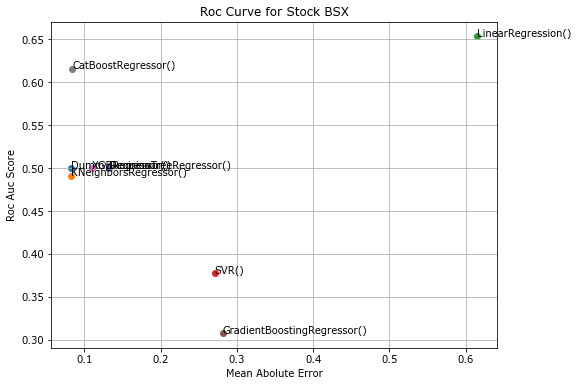

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 72.67it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'strategy': 'mean'}
  Backtesting metric: 0.0116344480522971



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
  Backtesting metric: 0.0014557284999910734

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 26.25it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'copy_X': True, 'fit_intercept': True}
  Backtesting metric: 6.605571844792633e-05

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'C': 10, 'coef0': 0.01, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
  Backtesting metric: 5.330265069312494e-11

Number of models compared: 1920.


loop param_grid:  94%|██████████████████████████████▉  | 360/384 [00:02<00:00, 173.60it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:10<00:00,  2.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
  Backtesting metric: 0.0008788175696842395

Number of models compared: 540.


loop param_grid:  74%|█████████████████████████▉         | 80/108 [00:05<00:01, 15.86it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:34<00:00,  6.89s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
  Backtesting metric: 1.7227996101732116e-09

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]


[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 14.56it/s]

[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 13.78it/s]

[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:00<00:06, 12.53it/s]

[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 12.38it/s]

[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.41it/s]


[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.82it/s]

[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 12.07it/s]

[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.68it/s]

[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:04, 13.19it/s]

[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:02<00:04, 12.26it/s]

[14:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.33it/s]

[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 12.27it/s]

[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 11.98it/s]

[14:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 12.02it/s]

[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 11.97it/s]

[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.99it/s]

[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:04<00:03, 11.56it/s]

[14:25:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.59it/s]


[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.39it/s]

[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:05<00:02, 11.02it/s]

[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:05<00:02, 10.70it/s]


[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 11.07it/s]

[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.13it/s]


[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.73it/s]

[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:06<00:01, 11.90it/s]


[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:00, 11.36it/s]


[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.03it/s]

[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.36it/s]

[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:07<00:00,  9.86it/s]

[14:25:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:07<00:00,  9.42it/s]


[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid:  20%|███████▊                               | 1/5 [00:08<00:33,  8.33s/it]

[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:07, 12.43it/s]


[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.55it/s]

[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.61it/s]


[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 11.91it/s]


[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.41it/s]


[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.34it/s]

[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.40it/s]

[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.02it/s]

[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:06, 10.71it/s]

[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.32it/s]


[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.39it/s]

[14:25:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06,  9.95it/s]


[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  33%|████████████                        | 32/96 [00:03<00:06,  9.38it/s]

[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.70it/s]

[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.81it/s]


[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 11.10it/s]


[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.00it/s]

[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.55it/s]

[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.34it/s]


[14:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.32it/s]


[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.23it/s]


[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:04, 10.34it/s]

[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:04, 10.24it/s]


[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.40it/s]

[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.80it/s]

[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.52it/s]


[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  68%|████████████████████████▍           | 65/96 [00:06<00:02, 10.51it/s]

[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02, 10.24it/s]


[14:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.26it/s]

[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:02, 10.34it/s]

[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:07<00:01, 10.65it/s]

[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.69it/s]


[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.46it/s]


[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.38it/s]


[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:08<00:01, 10.35it/s]

[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:08<00:00,  8.96it/s]

[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:08<00:00,  8.89it/s]

[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00, 10.34it/s]

[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.12it/s]

[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 12.13it/s]

[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.72it/s]


[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.63it/s]

[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.08it/s]

[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.44it/s]


[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.14it/s]


[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.03it/s]

[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.69it/s]

[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.52it/s]

[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.22it/s]

[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.14it/s]

[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.30it/s]

[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.60it/s]

[14:26:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.92it/s]

[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 10.82it/s]

[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 10.61it/s]


[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.63it/s]


[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.59it/s]


[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03, 10.48it/s]


[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.60it/s]


[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.60it/s]


[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.66it/s]

[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 10.36it/s]

[14:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.03it/s]


[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.09it/s]

[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:02, 10.15it/s]


[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:07<00:01, 10.09it/s]


[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.35it/s]

[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.49it/s]


[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.32it/s]


[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.35it/s]

[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00, 10.15it/s]


[14:26:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:08<00:00,  8.87it/s]

[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:26<00:17,  8.92s/it]

[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:05, 15.83it/s]

[14:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.61it/s]

[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.97it/s]

[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:06, 12.58it/s]

[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.71it/s]


[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.99it/s]

[14:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.91it/s]

[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.38it/s]


[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.73it/s]


[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.44it/s]


[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.28it/s]

[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.56it/s]

[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.80it/s]

[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.47it/s]


[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:04, 11.71it/s]


[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.69it/s]

[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.76it/s]


[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:03, 12.17it/s]

[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.97it/s]


[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 11.67it/s]

[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.43it/s]

[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.39it/s]


[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.96it/s]

[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.92it/s]

[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.52it/s]


[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.87it/s]

[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.61it/s]

[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 10.80it/s]

[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.59it/s]


[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 10.49it/s]


[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.51it/s]


[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.40it/s]


[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.80it/s]

[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.73it/s]


[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.94it/s]


[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.60it/s]

[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:35<00:08,  8.80s/it]

[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]


[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 15.19it/s]


[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 12.66it/s]

[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.97it/s]

[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.32it/s]

[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 11.64it/s]

[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 12.56it/s]

[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:05, 12.60it/s]


[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 12.89it/s]

[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.51it/s]

[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.97it/s]

[14:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.55it/s]

[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.58it/s]


[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.30it/s]

[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 12.69it/s]

[14:26:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 12.99it/s]

[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 12.78it/s]


[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 12.19it/s]

[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.98it/s]


[14:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  64%|██████████████████████▉             | 61/96 [00:04<00:02, 11.87it/s]

[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.97it/s]

[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 12.01it/s]


[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 12.18it/s]


[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:05<00:02, 11.42it/s]

[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 11.42it/s]


[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.59it/s]

[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 11.69it/s]

[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.88it/s]


[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:06<00:01, 12.01it/s]


[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.33it/s]

[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.68it/s]

[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:07<00:00, 11.66it/s]

[14:26:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:07<00:00, 12.00it/s]

[14:26:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:43<00:00,  8.64s/it]


[14:26:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.6}
  Backtesting metric: 0.010911631320218865

Number of models compared: 60.


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]


0:	learn: 0.1875668	total: 896us	remaining: 26ms
1:	learn: 0.1812812	total: 1.81ms	remaining: 25.3ms
2:	learn: 0.1758874	total: 2.79ms	remaining: 25.1ms
3:	learn: 0.1699135	total: 3.58ms	remaining: 23.3ms
4:	learn: 0.1644826	total: 4.23ms	remaining: 21.1ms
5:	learn: 0.1590297	total: 5.06ms	remaining: 20.2ms
6:	learn: 0.1537078	total: 5.77ms	remaining: 18.9ms
7:	learn: 0.1488650	total: 6.73ms	remaining: 18.5ms
8:	learn: 0.1440102	total: 7.58ms	remaining: 17.7ms
9:	learn: 0.1395100	total: 8.34ms	remaining: 16.7ms
10:	learn: 0.1343838	total: 8.87ms	remaining: 15.3ms
11:	learn: 0.1301879	total: 9.66ms	remaining: 14.5ms
12:	learn: 0.1262426	total: 10.4ms	remaining: 13.6ms
13:	learn: 0.1222156	total: 11.1ms	remaining: 12.7ms
14:	learn: 0.1182411	total: 11.9ms	remaining: 11.9ms
15:	learn: 0.1147201	total: 12.6ms	remaining: 11ms
16:	learn: 0.1116545	total: 13.3ms	remaining: 10.2ms
17:	learn: 0.1084928	total: 14.2ms	remaining: 9.47ms
18:	learn: 0.1054813	total: 15.4ms	remaining: 8.93ms
19:	lear

loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.08it/s]

0:	learn: 0.1875668	total: 705us	remaining: 34.5ms
1:	learn: 0.1812812	total: 1.32ms	remaining: 31.6ms


2:	learn: 0.1758874	total: 2.78ms	remaining: 43.6ms
3:	learn: 0.1699135	total: 3.72ms	remaining: 42.8ms
4:	learn: 0.1644826	total: 4.46ms	remaining: 40.1ms
5:	learn: 0.1590297	total: 5.18ms	remaining: 38ms
6:	learn: 0.1537078	total: 6.28ms	remaining: 38.6ms
7:	learn: 0.1488650	total: 7.35ms	remaining: 38.6ms
8:	learn: 0.1440102	total: 8.13ms	remaining: 37ms
9:	learn: 0.1395100	total: 8.93ms	remaining: 35.7ms
10:	learn: 0.1343838	total: 9.38ms	remaining: 33.3ms
11:	learn: 0.1301879	total: 10.1ms	remaining: 32.1ms
12:	learn: 0.1262426	total: 10.8ms	remaining: 30.8ms
13:	learn: 0.1222156	total: 11.7ms	remaining: 30.1ms
14:	learn: 0.1182411	total: 12.5ms	remaining: 29.1ms
15:	learn: 0.1147201	total: 13.3ms	remaining: 28.2ms
16:	learn: 0.1116545	total: 14.1ms	remaining: 27.4ms
17:	learn: 0.1084928	total: 14.8ms	remaining: 26.4ms
18:	learn: 0.1054813	total: 15.7ms	remaining: 25.6ms
19:	learn: 0.1025189	total: 16.4ms	remaining: 24.7ms
20:	learn: 0.0996304	total: 17.1ms	remaining: 23.7ms
21:	l

loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00, 10.01it/s]


0:	learn: 0.1878993	total: 1.78ms	remaining: 51.7ms
1:	learn: 0.1824389	total: 3.95ms	remaining: 55.3ms
2:	learn: 0.1765276	total: 5.71ms	remaining: 51.4ms
3:	learn: 0.1712258	total: 7.91ms	remaining: 51.4ms
4:	learn: 0.1653933	total: 9.24ms	remaining: 46.2ms
5:	learn: 0.1604337	total: 10.7ms	remaining: 43ms
6:	learn: 0.1551935	total: 12.2ms	remaining: 40.2ms
7:	learn: 0.1498447	total: 12.6ms	remaining: 34.7ms
8:	learn: 0.1458733	total: 14.3ms	remaining: 33.3ms
9:	learn: 0.1412453	total: 15.8ms	remaining: 31.5ms
10:	learn: 0.1370631	total: 17.5ms	remaining: 30.3ms
11:	learn: 0.1331403	total: 19.3ms	remaining: 29ms
12:	learn: 0.1291547	total: 21.2ms	remaining: 27.7ms
13:	learn: 0.1254231	total: 22.6ms	remaining: 25.8ms
14:	learn: 0.1214685	total: 24.1ms	remaining: 24.1ms
15:	learn: 0.1178910	total: 25.8ms	remaining: 22.6ms
16:	learn: 0.1142700	total: 26.5ms	remaining: 20.2ms
17:	learn: 0.1110699	total: 28.5ms	remaining: 19ms
18:	learn: 0.1083437	total: 30.3ms	remaining: 17.5ms
19:	learn

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  8.18it/s]

0:	learn: 0.1878993	total: 1.71ms	remaining: 84ms
1:	learn: 0.1824389	total: 3.93ms	remaining: 94.4ms
2:	learn: 0.1765276	total: 6.21ms	remaining: 97.2ms
3:	learn: 0.1712258	total: 9.27ms	remaining: 107ms
4:	learn: 0.1653933	total: 10.5ms	remaining: 94.4ms
5:	learn: 0.1604337	total: 12.3ms	remaining: 90.5ms
6:	learn: 0.1551935	total: 14.7ms	remaining: 90.6ms
7:	learn: 0.1498447	total: 15.3ms	remaining: 80.1ms
8:	learn: 0.1458733	total: 18.6ms	remaining: 84.7ms
9:	learn: 0.1412453	total: 21.2ms	remaining: 85ms
10:	learn: 0.1370631	total: 23.1ms	remaining: 82ms
11:	learn: 0.1331403	total: 25.1ms	remaining: 79.5ms
12:	learn: 0.1291547	total: 27.1ms	remaining: 77.2ms
13:	learn: 0.1254231	total: 29.8ms	remaining: 76.6ms
14:	learn: 0.1214685	total: 31.5ms	remaining: 73.4ms
15:	learn: 0.1178910	total: 33.3ms	remaining: 70.7ms
16:	learn: 0.1142700	total: 33.8ms	remaining: 65.7ms
17:	learn: 0.1110699	total: 35.2ms	remaining: 62.6ms
18:	learn: 0.1083437	total: 36.8ms	remaining: 60ms
19:	learn: 0


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:00<00:00,  7.40it/s]

1:	learn: 0.1709847	total: 3.77ms	remaining: 90.4ms
2:	learn: 0.1600914	total: 5.82ms	remaining: 91.2ms
3:	learn: 0.1507192	total: 7.51ms	remaining: 86.4ms
4:	learn: 0.1408254	total: 8.44ms	remaining: 75.9ms
5:	learn: 0.1328431	total: 9.82ms	remaining: 72ms
6:	learn: 0.1246973	total: 11.4ms	remaining: 69.9ms
7:	learn: 0.1167622	total: 11.7ms	remaining: 61.6ms
8:	learn: 0.1111314	total: 13.2ms	remaining: 60.1ms
9:	learn: 0.1047735	total: 14.5ms	remaining: 58.1ms
10:	learn: 0.0993456	total: 16.6ms	remaining: 58.8ms
11:	learn: 0.0945100	total: 18.9ms	remaining: 59.7ms
12:	learn: 0.0897337	total: 21.1ms	remaining: 60ms
13:	learn: 0.0855270	total: 23.2ms	remaining: 59.5ms
14:	learn: 0.0811965	total: 25.3ms	remaining: 59ms
15:	learn: 0.0774108	total: 27.6ms	remaining: 58.7ms
16:	learn: 0.0740200	total: 28.3ms	remaining: 55ms
17:	learn: 0.0709758	total: 30.2ms	remaining: 53.6ms
18:	learn: 0.0686828	total: 32.3ms	remaining: 52.7ms
19:	learn: 0.0661129	total: 34.4ms	remaining: 51.6ms
20:	learn:


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.66it/s]

5:	learn: 0.1620984	total: 24.4ms	remaining: 97.5ms
6:	learn: 0.1579896	total: 28.8ms	remaining: 94.7ms
7:	learn: 0.1532023	total: 34.3ms	remaining: 94.2ms
8:	learn: 0.1486497	total: 39.9ms	remaining: 93ms
9:	learn: 0.1447828	total: 44.9ms	remaining: 89.9ms
10:	learn: 0.1411486	total: 50.3ms	remaining: 86.8ms
11:	learn: 0.1374776	total: 55.1ms	remaining: 82.7ms
12:	learn: 0.1333193	total: 56.2ms	remaining: 73.5ms
13:	learn: 0.1293322	total: 57.8ms	remaining: 66.1ms
14:	learn: 0.1259894	total: 62.3ms	remaining: 62.3ms
15:	learn: 0.1225096	total: 66.9ms	remaining: 58.5ms
16:	learn: 0.1194368	total: 72.1ms	remaining: 55.1ms
17:	learn: 0.1166700	total: 77.2ms	remaining: 51.5ms
18:	learn: 0.1137958	total: 79.9ms	remaining: 46.3ms
19:	learn: 0.1110002	total: 84.3ms	remaining: 42.1ms
20:	learn: 0.1082843	total: 88.7ms	remaining: 38ms
21:	learn: 0.1049539	total: 89.4ms	remaining: 32.5ms
22:	learn: 0.1018491	total: 90.3ms	remaining: 27.5ms
23:	learn: 0.0993398	total: 94.2ms	remaining: 23.6ms
24


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  6.18it/s]

4:	learn: 0.1423690	total: 19ms	remaining: 95.2ms
5:	learn: 0.1339693	total: 19.9ms	remaining: 79.7ms
6:	learn: 0.1269583	total: 24.2ms	remaining: 79.5ms
7:	learn: 0.1198304	total: 30ms	remaining: 82.4ms
8:	learn: 0.1140887	total: 35.8ms	remaining: 83.4ms
9:	learn: 0.1086063	total: 41.3ms	remaining: 82.5ms
10:	learn: 0.1029964	total: 42.3ms	remaining: 73ms
11:	learn: 0.0978307	total: 47ms	remaining: 70.5ms
12:	learn: 0.0930769	total: 51.8ms	remaining: 67.8ms
13:	learn: 0.0884343	total: 57ms	remaining: 65.2ms
14:	learn: 0.0849608	total: 61.8ms	remaining: 61.8ms
15:	learn: 0.0814108	total: 67ms	remaining: 58.6ms
16:	learn: 0.0778282	total: 72.8ms	remaining: 55.7ms
17:	learn: 0.0745544	total: 77.5ms	remaining: 51.7ms
18:	learn: 0.0717121	total: 82.7ms	remaining: 47.9ms
19:	learn: 0.0690988	total: 83.7ms	remaining: 41.8ms
20:	learn: 0.0661801	total: 88.7ms	remaining: 38ms
21:	learn: 0.0632397	total: 90.3ms	remaining: 32.9ms
22:	learn: 0.0610379	total: 91.7ms	remaining: 27.9ms
23:	learn: 0.

31:	learn: 0.0819923	total: 183ms	remaining: 103ms
32:	learn: 0.0802472	total: 190ms	remaining: 98ms
33:	learn: 0.0784532	total: 200ms	remaining: 94ms
34:	learn: 0.0767202	total: 202ms	remaining: 86.5ms
35:	learn: 0.0751361	total: 210ms	remaining: 81.7ms
36:	learn: 0.0736119	total: 218ms	remaining: 76.5ms
37:	learn: 0.0721677	total: 226ms	remaining: 71.3ms
38:	learn: 0.0707019	total: 236ms	remaining: 66.7ms
39:	learn: 0.0692891	total: 248ms	remaining: 62ms
40:	learn: 0.0678897	total: 252ms	remaining: 55.3ms
41:	learn: 0.0666628	total: 260ms	remaining: 49.5ms
42:	learn: 0.0651604	total: 262ms	remaining: 42.7ms
43:	learn: 0.0639741	total: 273ms	remaining: 37.2ms
44:	learn: 0.0626376	total: 282ms	remaining: 31.3ms
45:	learn: 0.0613206	total: 283ms	remaining: 24.6ms
46:	learn: 0.0601162	total: 293ms	remaining: 18.7ms
47:	learn: 0.0589160	total: 302ms	remaining: 12.6ms
48:	learn: 0.0578405	total: 314ms	remaining: 6.4ms
49:	learn: 0.0569805	total: 323ms	remaining: 0us


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.12it/s]

0:	learn: 0.1823220	total: 11.1ms	remaining: 543ms
1:	learn: 0.1708834	total: 12.9ms	remaining: 309ms
2:	learn: 0.1599077	total: 16ms	remaining: 250ms
3:	learn: 0.1504782	total: 24.2ms	remaining: 278ms
4:	learn: 0.1423690	total: 32.5ms	remaining: 292ms
5:	learn: 0.1339693	total: 33.9ms	remaining: 249ms
6:	learn: 0.1269583	total: 41.3ms	remaining: 253ms
7:	learn: 0.1198304	total: 49.7ms	remaining: 261ms
8:	learn: 0.1140887	total: 57.4ms	remaining: 261ms
9:	learn: 0.1086063	total: 64.6ms	remaining: 259ms
10:	learn: 0.1029964	total: 66ms	remaining: 234ms
11:	learn: 0.0978307	total: 75.4ms	remaining: 239ms
12:	learn: 0.0930769	total: 82.8ms	remaining: 236ms
13:	learn: 0.0884343	total: 89.8ms	remaining: 231ms
14:	learn: 0.0849608	total: 98.5ms	remaining: 230ms
15:	learn: 0.0814108	total: 105ms	remaining: 222ms
16:	learn: 0.0778282	total: 115ms	remaining: 223ms
17:	learn: 0.0745544	total: 122ms	remaining: 218ms
18:	learn: 0.0717121	total: 131ms	remaining: 213ms
19:	learn: 0.0690988	total: 13


loop param_grid: 100%|████████████████████████████████████| 12/12 [00:02<00:00,  3.36it/s]
                                                                                          

26:	learn: 0.0533412	total: 174ms	remaining: 149ms
27:	learn: 0.0518231	total: 176ms	remaining: 139ms
28:	learn: 0.0501020	total: 184ms	remaining: 134ms
29:	learn: 0.0486923	total: 194ms	remaining: 129ms
30:	learn: 0.0472990	total: 200ms	remaining: 122ms
31:	learn: 0.0457897	total: 206ms	remaining: 116ms
32:	learn: 0.0447188	total: 208ms	remaining: 107ms
33:	learn: 0.0433639	total: 214ms	remaining: 101ms
34:	learn: 0.0421066	total: 221ms	remaining: 94.8ms
35:	learn: 0.0410542	total: 227ms	remaining: 88.3ms
36:	learn: 0.0399236	total: 233ms	remaining: 81.7ms
37:	learn: 0.0389387	total: 238ms	remaining: 75.2ms
38:	learn: 0.0379771	total: 244ms	remaining: 68.7ms
39:	learn: 0.0370173	total: 247ms	remaining: 61.7ms
40:	learn: 0.0363559	total: 253ms	remaining: 55.4ms
41:	learn: 0.0354618	total: 258ms	remaining: 49.1ms
42:	learn: 0.0346122	total: 263ms	remaining: 42.8ms
43:	learn: 0.0337174	total: 266ms	remaining: 36.3ms
44:	learn: 0.0328309	total: 272ms	remaining: 30.2ms
45:	learn: 0.0320026

loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 10.67it/s]

0:	learn: 0.1736585	total: 1.65ms	remaining: 47.8ms
1:	learn: 0.1680152	total: 2.72ms	remaining: 38ms
2:	learn: 0.1624878	total: 4.44ms	remaining: 40ms
3:	learn: 0.1575075	total: 5.55ms	remaining: 36.1ms
4:	learn: 0.1522917	total: 6.59ms	remaining: 33ms
5:	learn: 0.1471337	total: 7.53ms	remaining: 30.1ms
6:	learn: 0.1423918	total: 8.48ms	remaining: 27.9ms
7:	learn: 0.1382626	total: 9.66ms	remaining: 26.6ms
8:	learn: 0.1343659	total: 10.6ms	remaining: 24.8ms
9:	learn: 0.1300371	total: 11.5ms	remaining: 23.1ms
10:	learn: 0.1254861	total: 12ms	remaining: 20.7ms
11:	learn: 0.1215813	total: 13ms	remaining: 19.5ms
12:	learn: 0.1179498	total: 14ms	remaining: 18.4ms
13:	learn: 0.1148444	total: 15ms	remaining: 17.1ms
14:	learn: 0.1116347	total: 15.8ms	remaining: 15.8ms
15:	learn: 0.1089056	total: 16.6ms	remaining: 14.6ms
16:	learn: 0.1060070	total: 17.4ms	remaining: 13.3ms
17:	learn: 0.1029050	total: 18.2ms	remaining: 12.1ms
18:	learn: 0.0999071	total: 18.8ms	remaining: 10.9ms
19:	learn: 0.0974


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.49it/s]

34:	learn: 0.0399591	total: 29.7ms	remaining: 12.7ms
35:	learn: 0.0391135	total: 30.6ms	remaining: 11.9ms
36:	learn: 0.0378883	total: 31.6ms	remaining: 11.1ms
37:	learn: 0.0369491	total: 32.5ms	remaining: 10.3ms
38:	learn: 0.0361137	total: 33.3ms	remaining: 9.4ms
39:	learn: 0.0351511	total: 34.2ms	remaining: 8.56ms
40:	learn: 0.0342951	total: 35.3ms	remaining: 7.74ms
41:	learn: 0.0335295	total: 36.2ms	remaining: 6.9ms
42:	learn: 0.0328264	total: 37.3ms	remaining: 6.07ms
43:	learn: 0.0321085	total: 38.5ms	remaining: 5.25ms
44:	learn: 0.0314405	total: 39.5ms	remaining: 4.39ms
45:	learn: 0.0305600	total: 40.6ms	remaining: 3.53ms
46:	learn: 0.0297490	total: 41.6ms	remaining: 2.65ms
47:	learn: 0.0290447	total: 42.9ms	remaining: 1.79ms
48:	learn: 0.0285180	total: 44ms	remaining: 898us
49:	learn: 0.0277697	total: 45.2ms	remaining: 0us
0:	learn: 0.1743099	total: 2.44ms	remaining: 70.8ms
1:	learn: 0.1683641	total: 3.04ms	remaining: 42.5ms
2:	learn: 0.1630469	total: 5.8ms	remaining: 52.2ms
3:	le


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.50it/s]

29:	learn: 0.0766173	total: 72.1ms	remaining: 0us
0:	learn: 0.1695424	total: 4.24ms	remaining: 123ms
1:	learn: 0.1580988	total: 5.02ms	remaining: 70.3ms
2:	learn: 0.1482312	total: 8.07ms	remaining: 72.6ms
3:	learn: 0.1385649	total: 10.5ms	remaining: 68.4ms
4:	learn: 0.1314525	total: 13.5ms	remaining: 67.6ms
5:	learn: 0.1243804	total: 15.8ms	remaining: 63.2ms
6:	learn: 0.1178975	total: 18.2ms	remaining: 59.7ms
7:	learn: 0.1109902	total: 20.5ms	remaining: 56.4ms
8:	learn: 0.1055997	total: 22.9ms	remaining: 53.5ms
9:	learn: 0.0988613	total: 23.7ms	remaining: 47.4ms
10:	learn: 0.0940247	total: 25.9ms	remaining: 44.8ms
11:	learn: 0.0887074	total: 27ms	remaining: 40.5ms
12:	learn: 0.0848678	total: 29ms	remaining: 37.9ms
13:	learn: 0.0804682	total: 29.5ms	remaining: 33.8ms
14:	learn: 0.0769261	total: 31.5ms	remaining: 31.5ms
15:	learn: 0.0740834	total: 33.7ms	remaining: 29.5ms
16:	learn: 0.0702960	total: 35.6ms	remaining: 27.2ms
17:	learn: 0.0674142	total: 37.5ms	remaining: 25ms
18:	learn: 0.


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  6.78it/s]

1:	learn: 0.1683641	total: 3.68ms	remaining: 88.3ms
2:	learn: 0.1630469	total: 5.73ms	remaining: 89.8ms
3:	learn: 0.1579931	total: 7.92ms	remaining: 91.1ms
4:	learn: 0.1534560	total: 9.85ms	remaining: 88.7ms
5:	learn: 0.1491392	total: 20ms	remaining: 146ms
6:	learn: 0.1450288	total: 22.5ms	remaining: 138ms
7:	learn: 0.1404938	total: 25.4ms	remaining: 133ms
8:	learn: 0.1368759	total: 28.6ms	remaining: 130ms
9:	learn: 0.1319850	total: 29.5ms	remaining: 118ms
10:	learn: 0.1283524	total: 31.6ms	remaining: 112ms
11:	learn: 0.1240623	total: 32.9ms	remaining: 104ms
12:	learn: 0.1208258	total: 35ms	remaining: 99.7ms
13:	learn: 0.1169083	total: 35.6ms	remaining: 91.5ms
14:	learn: 0.1140535	total: 37.6ms	remaining: 87.8ms
15:	learn: 0.1110072	total: 39.4ms	remaining: 83.8ms
16:	learn: 0.1075759	total: 41.3ms	remaining: 80.2ms
17:	learn: 0.1047181	total: 42.6ms	remaining: 75.7ms
18:	learn: 0.1017888	total: 44.8ms	remaining: 73.1ms
19:	learn: 0.0992361	total: 47.7ms	remaining: 71.6ms
20:	learn: 0.


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.63it/s]

7:	learn: 0.1109902	total: 15.6ms	remaining: 81.9ms
8:	learn: 0.1055997	total: 17.7ms	remaining: 80.6ms
9:	learn: 0.0988613	total: 18.5ms	remaining: 74.1ms
10:	learn: 0.0940247	total: 20.5ms	remaining: 72.6ms
11:	learn: 0.0887074	total: 21.3ms	remaining: 67.6ms
12:	learn: 0.0848678	total: 23.3ms	remaining: 66.2ms
13:	learn: 0.0804682	total: 23.8ms	remaining: 61.2ms
14:	learn: 0.0769261	total: 25.7ms	remaining: 60ms
15:	learn: 0.0740834	total: 28.1ms	remaining: 59.8ms
16:	learn: 0.0702960	total: 30.3ms	remaining: 58.9ms
17:	learn: 0.0674142	total: 32.9ms	remaining: 58.5ms
18:	learn: 0.0645423	total: 35.2ms	remaining: 57.4ms
19:	learn: 0.0622114	total: 37.2ms	remaining: 55.9ms
20:	learn: 0.0599059	total: 39.6ms	remaining: 54.6ms
21:	learn: 0.0577049	total: 42.5ms	remaining: 54.1ms
22:	learn: 0.0561206	total: 45.3ms	remaining: 53.2ms
23:	learn: 0.0542486	total: 47.8ms	remaining: 51.8ms
24:	learn: 0.0525701	total: 50.4ms	remaining: 50.4ms
25:	learn: 0.0505133	total: 52.1ms	remaining: 48.1m


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.10it/s]

8:	learn: 0.1393089	total: 40.7ms	remaining: 95.1ms
9:	learn: 0.1360887	total: 45.1ms	remaining: 90.1ms
10:	learn: 0.1326276	total: 50.1ms	remaining: 86.5ms
11:	learn: 0.1283868	total: 51.3ms	remaining: 77ms
12:	learn: 0.1249116	total: 56.4ms	remaining: 73.8ms
13:	learn: 0.1216510	total: 61ms	remaining: 69.7ms
14:	learn: 0.1184082	total: 65.8ms	remaining: 65.8ms
15:	learn: 0.1155157	total: 70.4ms	remaining: 61.6ms
16:	learn: 0.1116440	total: 70.8ms	remaining: 54.1ms
17:	learn: 0.1088024	total: 74.5ms	remaining: 49.7ms
18:	learn: 0.1059575	total: 79.3ms	remaining: 45.9ms
19:	learn: 0.1030498	total: 84.8ms	remaining: 42.4ms
20:	learn: 0.1006188	total: 89.7ms	remaining: 38.4ms
21:	learn: 0.0986974	total: 94.3ms	remaining: 34.3ms
22:	learn: 0.0964173	total: 98.3ms	remaining: 29.9ms
23:	learn: 0.0940148	total: 102ms	remaining: 25.6ms
24:	learn: 0.0918046	total: 104ms	remaining: 20.8ms
25:	learn: 0.0899548	total: 108ms	remaining: 16.6ms
26:	learn: 0.0877252	total: 112ms	remaining: 12.5ms
27:


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.85it/s]

8:	learn: 0.1081217	total: 39.9ms	remaining: 93.1ms
9:	learn: 0.1034647	total: 44.6ms	remaining: 89.2ms
10:	learn: 0.0985451	total: 49.6ms	remaining: 85.6ms
11:	learn: 0.0928637	total: 50.7ms	remaining: 76.1ms
12:	learn: 0.0881928	total: 55.6ms	remaining: 72.7ms
13:	learn: 0.0839626	total: 61.2ms	remaining: 70ms
14:	learn: 0.0799735	total: 65.9ms	remaining: 65.9ms
15:	learn: 0.0764421	total: 68ms	remaining: 59.5ms
16:	learn: 0.0722850	total: 68.4ms	remaining: 52.3ms
17:	learn: 0.0690525	total: 72.8ms	remaining: 48.5ms
18:	learn: 0.0661408	total: 77.1ms	remaining: 44.6ms
19:	learn: 0.0628985	total: 80.9ms	remaining: 40.4ms
20:	learn: 0.0602166	total: 84.8ms	remaining: 36.3ms
21:	learn: 0.0582983	total: 89.9ms	remaining: 32.7ms
22:	learn: 0.0560957	total: 95.5ms	remaining: 29.1ms
23:	learn: 0.0539365	total: 97.2ms	remaining: 24.3ms
24:	learn: 0.0520179	total: 103ms	remaining: 20.5ms
25:	learn: 0.0502504	total: 107ms	remaining: 16.4ms
26:	learn: 0.0482666	total: 111ms	remaining: 12.3ms
27


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.46it/s]

39:	learn: 0.0658315	total: 208ms	remaining: 52ms
40:	learn: 0.0644964	total: 212ms	remaining: 46.6ms
41:	learn: 0.0633385	total: 218ms	remaining: 41.5ms
42:	learn: 0.0623128	total: 224ms	remaining: 36.4ms
43:	learn: 0.0610122	total: 227ms	remaining: 31ms
44:	learn: 0.0595789	total: 228ms	remaining: 25.4ms
45:	learn: 0.0583281	total: 234ms	remaining: 20.3ms
46:	learn: 0.0572182	total: 237ms	remaining: 15.1ms
47:	learn: 0.0560780	total: 243ms	remaining: 10.1ms
48:	learn: 0.0549756	total: 245ms	remaining: 4.99ms
49:	learn: 0.0540055	total: 251ms	remaining: 0us
0:	learn: 0.1708363	total: 9.49ms	remaining: 465ms
1:	learn: 0.1582539	total: 10.6ms	remaining: 254ms
2:	learn: 0.1490498	total: 18.5ms	remaining: 290ms
3:	learn: 0.1414972	total: 23.4ms	remaining: 270ms
4:	learn: 0.1343597	total: 31.3ms	remaining: 282ms
5:	learn: 0.1261942	total: 37.2ms	remaining: 273ms
6:	learn: 0.1208445	total: 42.8ms	remaining: 263ms
7:	learn: 0.1145836	total: 48.8ms	remaining: 256ms
8:	learn: 0.1081217	total: 


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:04<00:06,  2.20s/it]

43:	learn: 0.0274472	total: 219ms	remaining: 29.8ms
44:	learn: 0.0267753	total: 224ms	remaining: 24.9ms
45:	learn: 0.0260075	total: 229ms	remaining: 19.9ms
46:	learn: 0.0252048	total: 231ms	remaining: 14.7ms
47:	learn: 0.0244478	total: 236ms	remaining: 9.85ms
48:	learn: 0.0237793	total: 241ms	remaining: 4.91ms
49:	learn: 0.0229883	total: 245ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1315885	total: 1.15ms	remaining: 33.4ms
1:	learn: 0.1279266	total: 2.21ms	remaining: 31ms
2:	learn: 0.1245032	total: 3.3ms	remaining: 29.7ms
3:	learn: 0.1212366	total: 4.33ms	remaining: 28.2ms
4:	learn: 0.1178460	total: 5.34ms	remaining: 26.7ms
5:	learn: 0.1145980	total: 6.42ms	remaining: 25.7ms
6:	learn: 0.1120079	total: 7.41ms	remaining: 24.3ms
7:	learn: 0.1091527	total: 8.29ms	remaining: 22.8ms
8:	learn: 0.1064599	total: 9.24ms	remaining: 21.6ms
9:	learn: 0.1042106	total: 10.1ms	remaining: 20.1ms
10:	learn: 0.1016995	total: 11ms	remaining: 19ms
11:	learn: 0.0988985	total: 11.8ms	remaining: 17.7ms
12:	learn: 0.0965482	total: 13.3ms	remaining: 17.4ms
13:	learn: 0.0944779	total: 14.3ms	remaining: 16.3ms
14:	learn: 0.0920799	total: 15.5ms	remaining: 15.5ms
15:	learn: 0.0901630	total: 16.7ms	remaining: 14.6ms
16:	learn: 0.0881404	total: 17.7ms	remaining: 13.5ms
17:	learn: 0.0862514	total: 18.5ms	remaining: 12.4ms
18:	learn: 0.0844170	total: 19.4ms	remaining: 11.2ms
19:	learn:


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 10.91it/s]

1:	learn: 0.1208976	total: 1.77ms	remaining: 24.8ms
2:	learn: 0.1145267	total: 2.69ms	remaining: 24.2ms
3:	learn: 0.1086637	total: 3.49ms	remaining: 22.7ms
4:	learn: 0.1027581	total: 4.38ms	remaining: 21.9ms
5:	learn: 0.0973486	total: 5.25ms	remaining: 21ms
6:	learn: 0.0930528	total: 6.05ms	remaining: 19.9ms
7:	learn: 0.0886949	total: 6.94ms	remaining: 19.1ms
8:	learn: 0.0846044	total: 8.03ms	remaining: 18.7ms
9:	learn: 0.0811450	total: 8.82ms	remaining: 17.7ms
10:	learn: 0.0777122	total: 9.73ms	remaining: 16.8ms
11:	learn: 0.0738833	total: 10.7ms	remaining: 16ms
12:	learn: 0.0708262	total: 11.5ms	remaining: 15ms
13:	learn: 0.0681370	total: 12.4ms	remaining: 14.2ms
14:	learn: 0.0653752	total: 13.5ms	remaining: 13.5ms
15:	learn: 0.0632223	total: 14.5ms	remaining: 12.7ms
16:	learn: 0.0610383	total: 15.4ms	remaining: 11.8ms
17:	learn: 0.0588743	total: 16.3ms	remaining: 10.9ms
18:	learn: 0.0571823	total: 17.1ms	remaining: 9.91ms
19:	learn: 0.0554009	total: 18ms	remaining: 8.99ms
20:	learn:


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00, 10.11it/s]

1:	learn: 0.1208976	total: 1.82ms	remaining: 43.8ms
2:	learn: 0.1145267	total: 2.75ms	remaining: 43.1ms
3:	learn: 0.1086637	total: 3.63ms	remaining: 41.8ms
4:	learn: 0.1027581	total: 4.49ms	remaining: 40.4ms
5:	learn: 0.0973486	total: 5.37ms	remaining: 39.4ms
6:	learn: 0.0930528	total: 6.28ms	remaining: 38.6ms
7:	learn: 0.0886949	total: 7.14ms	remaining: 37.5ms
8:	learn: 0.0846044	total: 7.98ms	remaining: 36.3ms
9:	learn: 0.0811450	total: 8.9ms	remaining: 35.6ms
10:	learn: 0.0777122	total: 9.75ms	remaining: 34.6ms
11:	learn: 0.0738833	total: 10.7ms	remaining: 34ms
12:	learn: 0.0708262	total: 11.6ms	remaining: 33ms
13:	learn: 0.0681370	total: 12.5ms	remaining: 32.1ms
14:	learn: 0.0653752	total: 13.3ms	remaining: 31.1ms
15:	learn: 0.0632223	total: 14.2ms	remaining: 30.1ms
16:	learn: 0.0610383	total: 15.1ms	remaining: 29.3ms
17:	learn: 0.0588743	total: 15.9ms	remaining: 28.3ms
18:	learn: 0.0571823	total: 16.8ms	remaining: 27.4ms
19:	learn: 0.0554009	total: 17.7ms	remaining: 26.5ms
20:	lea


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  9.13it/s]

22:	learn: 0.0506129	total: 39.9ms	remaining: 12.1ms
23:	learn: 0.0493422	total: 41.8ms	remaining: 10.5ms
24:	learn: 0.0479232	total: 43.6ms	remaining: 8.72ms
25:	learn: 0.0462665	total: 45.4ms	remaining: 6.99ms
26:	learn: 0.0450476	total: 46.4ms	remaining: 5.16ms
27:	learn: 0.0433258	total: 47.6ms	remaining: 3.4ms
28:	learn: 0.0418561	total: 49.5ms	remaining: 1.71ms
29:	learn: 0.0404086	total: 51.3ms	remaining: 0us
0:	learn: 0.1317984	total: 1.96ms	remaining: 96ms
1:	learn: 0.1282112	total: 3.48ms	remaining: 83.5ms
2:	learn: 0.1253623	total: 5.69ms	remaining: 89.1ms
3:	learn: 0.1220660	total: 7.81ms	remaining: 89.8ms
4:	learn: 0.1189359	total: 10.1ms	remaining: 90.7ms
5:	learn: 0.1163680	total: 12.1ms	remaining: 88.5ms
6:	learn: 0.1135241	total: 13.9ms	remaining: 85.3ms
7:	learn: 0.1105226	total: 15.8ms	remaining: 82.9ms
8:	learn: 0.1085176	total: 17.7ms	remaining: 80.6ms
9:	learn: 0.1063116	total: 19.7ms	remaining: 79ms
10:	learn: 0.1037671	total: 21.5ms	remaining: 76.2ms
11:	learn: 

25:	learn: 0.0751837	total: 46.6ms	remaining: 43ms
26:	learn: 0.0737910	total: 48.3ms	remaining: 41.1ms
27:	learn: 0.0723602	total: 49.8ms	remaining: 39.1ms
28:	learn: 0.0709912	total: 51.3ms	remaining: 37.2ms
29:	learn: 0.0695519	total: 53ms	remaining: 35.3ms
30:	learn: 0.0681815	total: 54.7ms	remaining: 33.5ms
31:	learn: 0.0669152	total: 56.5ms	remaining: 31.8ms
32:	learn: 0.0655974	total: 58.3ms	remaining: 30.1ms
33:	learn: 0.0645450	total: 60.1ms	remaining: 28.3ms
34:	learn: 0.0633484	total: 61.8ms	remaining: 26.5ms
35:	learn: 0.0619881	total: 63.6ms	remaining: 24.7ms
36:	learn: 0.0606178	total: 65.4ms	remaining: 23ms
37:	learn: 0.0596468	total: 67.4ms	remaining: 21.3ms
38:	learn: 0.0585755	total: 69.1ms	remaining: 19.5ms
39:	learn: 0.0574635	total: 69.8ms	remaining: 17.4ms
40:	learn: 0.0562512	total: 71.3ms	remaining: 15.7ms
41:	learn: 0.0551105	total: 72.8ms	remaining: 13.9ms
42:	learn: 0.0542654	total: 74.3ms	remaining: 12.1ms
43:	learn: 0.0532640	total: 75.9ms	remaining: 10.3ms

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  8.14it/s]

0:	learn: 0.1283638	total: 2.23ms	remaining: 109ms
1:	learn: 0.1214435	total: 4.12ms	remaining: 98.8ms
2:	learn: 0.1161039	total: 6.16ms	remaining: 96.5ms
3:	learn: 0.1101981	total: 8.03ms	remaining: 92.4ms
4:	learn: 0.1046527	total: 9.88ms	remaining: 88.9ms
5:	learn: 0.1005691	total: 11.9ms	remaining: 87.3ms
6:	learn: 0.0958376	total: 13.9ms	remaining: 85.2ms
7:	learn: 0.0909684	total: 15.5ms	remaining: 81.3ms
8:	learn: 0.0879150	total: 17ms	remaining: 77.7ms
9:	learn: 0.0845736	total: 18.7ms	remaining: 74.8ms
10:	learn: 0.0808735	total: 20.7ms	remaining: 73.4ms
11:	learn: 0.0773720	total: 22.4ms	remaining: 71ms
12:	learn: 0.0742607	total: 24.5ms	remaining: 69.6ms
13:	learn: 0.0712339	total: 27ms	remaining: 69.4ms
14:	learn: 0.0685727	total: 28.6ms	remaining: 66.7ms
15:	learn: 0.0657513	total: 29.7ms	remaining: 63ms
16:	learn: 0.0633218	total: 31.2ms	remaining: 60.5ms
17:	learn: 0.0608544	total: 32.7ms	remaining: 58.2ms
18:	learn: 0.0585094	total: 33.5ms	remaining: 54.6ms
19:	learn: 0


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:00<00:00,  7.80it/s]

45:	learn: 0.0248793	total: 76.4ms	remaining: 6.64ms
46:	learn: 0.0239804	total: 78.5ms	remaining: 5.01ms
47:	learn: 0.0233308	total: 80.5ms	remaining: 3.35ms
48:	learn: 0.0227703	total: 82.4ms	remaining: 1.68ms
49:	learn: 0.0222371	total: 84.4ms	remaining: 0us
0:	learn: 0.1319581	total: 4.85ms	remaining: 141ms
1:	learn: 0.1285844	total: 5.92ms	remaining: 82.9ms
2:	learn: 0.1256746	total: 7.51ms	remaining: 67.6ms
3:	learn: 0.1227086	total: 12.7ms	remaining: 82.7ms
4:	learn: 0.1196652	total: 18.9ms	remaining: 94.5ms
5:	learn: 0.1170098	total: 25ms	remaining: 100ms
6:	learn: 0.1142763	total: 26.2ms	remaining: 86.2ms
7:	learn: 0.1125418	total: 29.5ms	remaining: 81.2ms
8:	learn: 0.1103496	total: 36.7ms	remaining: 85.6ms
9:	learn: 0.1076399	total: 39ms	remaining: 78ms
10:	learn: 0.1055757	total: 46ms	remaining: 79.5ms
11:	learn: 0.1033937	total: 52.1ms	remaining: 78.1ms
12:	learn: 0.1011234	total: 58.8ms	remaining: 76.9ms
13:	learn: 0.0989276	total: 59.8ms	remaining: 68.4ms
14:	learn: 0.096


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.76it/s]

28:	learn: 0.0716058	total: 120ms	remaining: 4.15ms
29:	learn: 0.0699307	total: 127ms	remaining: 0us
0:	learn: 0.1286764	total: 8.04ms	remaining: 233ms
1:	learn: 0.1221177	total: 9.88ms	remaining: 138ms
2:	learn: 0.1166477	total: 12.5ms	remaining: 113ms
3:	learn: 0.1112146	total: 22.1ms	remaining: 144ms
4:	learn: 0.1058182	total: 29.5ms	remaining: 148ms
5:	learn: 0.1012602	total: 39.9ms	remaining: 160ms
6:	learn: 0.0967771	total: 41.1ms	remaining: 135ms
7:	learn: 0.0939597	total: 45.7ms	remaining: 126ms
8:	learn: 0.0903891	total: 52.7ms	remaining: 123ms
9:	learn: 0.0862073	total: 55.1ms	remaining: 110ms
10:	learn: 0.0831080	total: 62.9ms	remaining: 109ms
11:	learn: 0.0798722	total: 70.5ms	remaining: 106ms
12:	learn: 0.0765226	total: 78.1ms	remaining: 102ms
13:	learn: 0.0736011	total: 80ms	remaining: 91.5ms
14:	learn: 0.0706189	total: 89.3ms	remaining: 89.3ms
15:	learn: 0.0677988	total: 96.2ms	remaining: 84.2ms
16:	learn: 0.0645185	total: 101ms	remaining: 77ms
17:	learn: 0.0622365	total


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.24it/s]

28:	learn: 0.0418783	total: 181ms	remaining: 6.25ms
29:	learn: 0.0405434	total: 188ms	remaining: 0us
0:	learn: 0.1319581	total: 6.64ms	remaining: 325ms
1:	learn: 0.1285844	total: 8.11ms	remaining: 195ms
2:	learn: 0.1256746	total: 10.4ms	remaining: 163ms
3:	learn: 0.1227086	total: 15.9ms	remaining: 183ms
4:	learn: 0.1196652	total: 24.5ms	remaining: 221ms
5:	learn: 0.1170098	total: 30.9ms	remaining: 227ms
6:	learn: 0.1142763	total: 31.9ms	remaining: 196ms
7:	learn: 0.1125418	total: 35ms	remaining: 184ms
8:	learn: 0.1103496	total: 40.9ms	remaining: 186ms
9:	learn: 0.1076399	total: 42.6ms	remaining: 170ms
10:	learn: 0.1055757	total: 49.1ms	remaining: 174ms
11:	learn: 0.1033937	total: 54.7ms	remaining: 173ms
12:	learn: 0.1011234	total: 60.9ms	remaining: 173ms
13:	learn: 0.0989276	total: 61.9ms	remaining: 159ms
14:	learn: 0.0967609	total: 67.2ms	remaining: 157ms
15:	learn: 0.0946832	total: 73.1ms	remaining: 155ms
16:	learn: 0.0921286	total: 76.7ms	remaining: 149ms
17:	learn: 0.0900238	total:


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.44it/s]

40:	learn: 0.0559819	total: 177ms	remaining: 38.9ms
41:	learn: 0.0548516	total: 185ms	remaining: 35.2ms
42:	learn: 0.0540148	total: 192ms	remaining: 31.2ms
43:	learn: 0.0529231	total: 193ms	remaining: 26.3ms
44:	learn: 0.0520072	total: 199ms	remaining: 22.1ms
45:	learn: 0.0510959	total: 202ms	remaining: 17.6ms
46:	learn: 0.0501226	total: 208ms	remaining: 13.3ms
47:	learn: 0.0492061	total: 215ms	remaining: 8.96ms
48:	learn: 0.0482259	total: 220ms	remaining: 4.49ms
49:	learn: 0.0474511	total: 221ms	remaining: 0us
0:	learn: 0.1286764	total: 7.72ms	remaining: 378ms
1:	learn: 0.1221177	total: 9.25ms	remaining: 222ms
2:	learn: 0.1166477	total: 11.2ms	remaining: 176ms
3:	learn: 0.1112146	total: 17.7ms	remaining: 203ms
4:	learn: 0.1058182	total: 23.8ms	remaining: 214ms
5:	learn: 0.1012602	total: 29.8ms	remaining: 219ms
6:	learn: 0.0967771	total: 30.9ms	remaining: 190ms
7:	learn: 0.0939597	total: 34.2ms	remaining: 180ms
8:	learn: 0.0903891	total: 39.6ms	remaining: 180ms
9:	learn: 0.0862073	tota


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.0676338	total: 1.11ms	remaining: 32.3ms
1:	learn: 0.0667648	total: 2.06ms	remaining: 28.8ms
2:	learn: 0.0658380	total: 3.17ms	remaining: 28.6ms
3:	learn: 0.0647500	total: 4.17ms	remaining: 27.1ms
4:	learn: 0.0635400	total: 5.12ms	remaining: 25.6ms
5:	learn: 0.0625638	total: 6.13ms	remaining: 24.5ms
6:	learn: 0.0619585	total: 6.92ms	remaining: 22.7ms
7:	learn: 0.0611447	total: 7.82ms	remaining: 21.5ms
8:	learn: 0.0602578	total: 8.72ms	remaining: 20.4ms
9:	learn: 0.0593370	total: 9.63ms	remaining: 19.3ms
10:	learn: 0.0586304	total: 10.9ms	remaining: 18.8ms
11:	learn: 0.0580113	total: 11.9ms	remaining: 17.8ms
12:	learn: 0.0572529	total: 12.9ms	remaining: 16.8ms
13:	learn: 0.0563365	total: 13.8ms	remaining: 15.7ms
14:	learn: 0.0556639	total: 14.6ms	remaining: 14.6ms
15:	learn: 0.0548682	total: 15.4ms	remaining: 13.5ms
16:	learn: 0.0541373	total: 16.2ms	remaining: 12.4ms
17:	learn: 0.0532400	total: 17ms	remaining: 11.3ms
18:	learn: 0.0529476	total: 17.9ms	remaining: 10.4ms
19:	l


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.52it/s]

0:	learn: 0.0668071	total: 1.2ms	remaining: 34.7ms
1:	learn: 0.0651042	total: 2.15ms	remaining: 30.2ms
2:	learn: 0.0633270	total: 3.16ms	remaining: 28.4ms
3:	learn: 0.0612706	total: 4.07ms	remaining: 26.5ms
4:	learn: 0.0590313	total: 5.14ms	remaining: 25.7ms
5:	learn: 0.0573810	total: 6.17ms	remaining: 24.7ms
6:	learn: 0.0563043	total: 7.07ms	remaining: 23.2ms
7:	learn: 0.0548423	total: 7.99ms	remaining: 22ms
8:	learn: 0.0532934	total: 8.81ms	remaining: 20.6ms
9:	learn: 0.0516872	total: 9.54ms	remaining: 19.1ms
10:	learn: 0.0508117	total: 10.6ms	remaining: 18.3ms
11:	learn: 0.0492002	total: 11.5ms	remaining: 17.2ms
12:	learn: 0.0476803	total: 12.2ms	remaining: 16ms
13:	learn: 0.0462724	total: 13.3ms	remaining: 15.3ms
14:	learn: 0.0451904	total: 14.6ms	remaining: 14.6ms
15:	learn: 0.0439776	total: 15.4ms	remaining: 13.5ms
16:	learn: 0.0428959	total: 16.3ms	remaining: 12.5ms
17:	learn: 0.0415949	total: 17.2ms	remaining: 11.4ms
18:	learn: 0.0411437	total: 18ms	remaining: 10.4ms
19:	learn:

0:	learn: 0.0668071	total: 968us	remaining: 47.4ms
1:	learn: 0.0651042	total: 1.78ms	remaining: 42.6ms
2:	learn: 0.0633270	total: 2.63ms	remaining: 41.2ms
3:	learn: 0.0612706	total: 3.47ms	remaining: 39.9ms
4:	learn: 0.0590313	total: 4.31ms	remaining: 38.8ms
5:	learn: 0.0573810	total: 5.18ms	remaining: 38ms
6:	learn: 0.0563043	total: 5.91ms	remaining: 36.3ms
7:	learn: 0.0548423	total: 6.74ms	remaining: 35.4ms
8:	learn: 0.0532934	total: 7.78ms	remaining: 35.4ms
9:	learn: 0.0516872	total: 8.61ms	remaining: 34.4ms
10:	learn: 0.0508117	total: 9.45ms	remaining: 33.5ms
11:	learn: 0.0492002	total: 10.4ms	remaining: 32.9ms
12:	learn: 0.0476803	total: 11.1ms	remaining: 31.7ms
13:	learn: 0.0462724	total: 11.9ms	remaining: 30.7ms
14:	learn: 0.0451904	total: 12.8ms	remaining: 29.8ms
15:	learn: 0.0439776	total: 13.7ms	remaining: 29.1ms
16:	learn: 0.0428959	total: 14.6ms	remaining: 28.3ms
17:	learn: 0.0415949	total: 15.4ms	remaining: 27.3ms
18:	learn: 0.0411437	total: 16.3ms	remaining: 26.6ms
19:	le

loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  9.53it/s]

0:	learn: 0.0675222	total: 2.8ms	remaining: 81.3ms
1:	learn: 0.0668912	total: 4.54ms	remaining: 63.6ms
2:	learn: 0.0659378	total: 7.29ms	remaining: 65.7ms
3:	learn: 0.0650353	total: 10ms	remaining: 65.1ms
4:	learn: 0.0641941	total: 12.3ms	remaining: 61.5ms
5:	learn: 0.0632829	total: 13.8ms	remaining: 55.4ms
6:	learn: 0.0626137	total: 16ms	remaining: 52.5ms
7:	learn: 0.0618315	total: 19.4ms	remaining: 53.4ms
8:	learn: 0.0610058	total: 22.1ms	remaining: 51.6ms
9:	learn: 0.0600870	total: 24.4ms	remaining: 48.8ms
10:	learn: 0.0591818	total: 26.7ms	remaining: 46.1ms
11:	learn: 0.0585331	total: 29.5ms	remaining: 44.2ms
12:	learn: 0.0577586	total: 32ms	remaining: 41.8ms
13:	learn: 0.0571032	total: 34.3ms	remaining: 39.2ms
14:	learn: 0.0564873	total: 36.9ms	remaining: 36.9ms
15:	learn: 0.0557910	total: 39.2ms	remaining: 34.3ms
16:	learn: 0.0550242	total: 43.2ms	remaining: 33ms
17:	learn: 0.0543312	total: 44.8ms	remaining: 29.8ms
18:	learn: 0.0536950	total: 47.3ms	remaining: 27.4ms
19:	learn: 0


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.47it/s]

21:	learn: 0.0513947	total: 56.1ms	remaining: 20.4ms
22:	learn: 0.0508899	total: 57.3ms	remaining: 17.5ms
23:	learn: 0.0501525	total: 60.4ms	remaining: 15.1ms
24:	learn: 0.0493648	total: 61.7ms	remaining: 12.3ms
25:	learn: 0.0486600	total: 63.5ms	remaining: 9.77ms
26:	learn: 0.0480297	total: 65.8ms	remaining: 7.31ms
27:	learn: 0.0473145	total: 66.9ms	remaining: 4.78ms
28:	learn: 0.0467572	total: 69.4ms	remaining: 2.39ms
29:	learn: 0.0460077	total: 71.7ms	remaining: 0us
0:	learn: 0.0665790	total: 3.06ms	remaining: 88.6ms
1:	learn: 0.0653364	total: 4.81ms	remaining: 67.3ms
2:	learn: 0.0634800	total: 8.62ms	remaining: 77.6ms
3:	learn: 0.0617530	total: 12.3ms	remaining: 79.7ms
4:	learn: 0.0601697	total: 16.2ms	remaining: 81ms
5:	learn: 0.0586209	total: 19.5ms	remaining: 77.9ms
6:	learn: 0.0570864	total: 23ms	remaining: 75.6ms
7:	learn: 0.0554377	total: 26.2ms	remaining: 72.1ms
8:	learn: 0.0542388	total: 29.3ms	remaining: 68.3ms
9:	learn: 0.0525551	total: 31.6ms	remaining: 63.2ms
10:	learn:


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.56it/s]

28:	learn: 0.0306872	total: 79.8ms	remaining: 2.75ms
29:	learn: 0.0300434	total: 81.2ms	remaining: 0us
0:	learn: 0.0675222	total: 2.81ms	remaining: 138ms
1:	learn: 0.0668912	total: 4.29ms	remaining: 103ms
2:	learn: 0.0659378	total: 6.75ms	remaining: 106ms
3:	learn: 0.0650353	total: 8.88ms	remaining: 102ms
4:	learn: 0.0641941	total: 11.2ms	remaining: 101ms
5:	learn: 0.0632829	total: 12.8ms	remaining: 93.5ms
6:	learn: 0.0626137	total: 14.9ms	remaining: 91.2ms
7:	learn: 0.0618315	total: 16.6ms	remaining: 87.2ms
8:	learn: 0.0610058	total: 18.6ms	remaining: 84.7ms
9:	learn: 0.0600870	total: 20.4ms	remaining: 81.7ms
10:	learn: 0.0591818	total: 22.5ms	remaining: 79.8ms
11:	learn: 0.0585331	total: 24.3ms	remaining: 76.9ms
12:	learn: 0.0577586	total: 26ms	remaining: 73.9ms
13:	learn: 0.0571032	total: 27.7ms	remaining: 71.3ms
14:	learn: 0.0564873	total: 29.5ms	remaining: 68.9ms
15:	learn: 0.0557910	total: 31.9ms	remaining: 67.9ms
16:	learn: 0.0550242	total: 34.3ms	remaining: 66.7ms
17:	learn: 0.


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  6.74it/s]

47:	learn: 0.0366084	total: 86.9ms	remaining: 3.62ms
48:	learn: 0.0361706	total: 87.8ms	remaining: 1.79ms
49:	learn: 0.0356100	total: 89.6ms	remaining: 0us
0:	learn: 0.0665790	total: 2.41ms	remaining: 118ms
1:	learn: 0.0653364	total: 3.8ms	remaining: 91.2ms
2:	learn: 0.0634800	total: 6.82ms	remaining: 107ms
3:	learn: 0.0617530	total: 8.87ms	remaining: 102ms
4:	learn: 0.0601697	total: 11.3ms	remaining: 102ms
5:	learn: 0.0586209	total: 13.8ms	remaining: 101ms
6:	learn: 0.0570864	total: 16ms	remaining: 98.5ms
7:	learn: 0.0554377	total: 18.5ms	remaining: 97.4ms
8:	learn: 0.0542388	total: 20.9ms	remaining: 95ms
9:	learn: 0.0525551	total: 22.8ms	remaining: 91.2ms
10:	learn: 0.0512368	total: 24.9ms	remaining: 88.2ms
11:	learn: 0.0496451	total: 27.1ms	remaining: 85.8ms
12:	learn: 0.0482277	total: 29.2ms	remaining: 83.2ms
13:	learn: 0.0468858	total: 31.3ms	remaining: 80.5ms
14:	learn: 0.0454195	total: 33.1ms	remaining: 77.3ms
15:	learn: 0.0440998	total: 35ms	remaining: 74.5ms
16:	learn: 0.04288

19:	learn: 0.0393359	total: 42.8ms	remaining: 64.2ms
20:	learn: 0.0383175	total: 44.9ms	remaining: 62.1ms
21:	learn: 0.0372627	total: 47.4ms	remaining: 60.3ms
22:	learn: 0.0365903	total: 49.8ms	remaining: 58.4ms
23:	learn: 0.0355098	total: 51.7ms	remaining: 56.1ms
24:	learn: 0.0344776	total: 53.7ms	remaining: 53.7ms
25:	learn: 0.0333673	total: 55.7ms	remaining: 51.4ms
26:	learn: 0.0323385	total: 57.8ms	remaining: 49.2ms
27:	learn: 0.0315519	total: 59.8ms	remaining: 47ms
28:	learn: 0.0306872	total: 61.8ms	remaining: 44.7ms
29:	learn: 0.0300434	total: 63.3ms	remaining: 42.2ms
30:	learn: 0.0293627	total: 65.3ms	remaining: 40ms
31:	learn: 0.0285837	total: 67.1ms	remaining: 37.7ms
32:	learn: 0.0278170	total: 68.8ms	remaining: 35.4ms
33:	learn: 0.0271091	total: 70.6ms	remaining: 33.2ms
34:	learn: 0.0264145	total: 71.5ms	remaining: 30.7ms
35:	learn: 0.0260531	total: 72.4ms	remaining: 28.1ms
36:	learn: 0.0253861	total: 74.6ms	remaining: 26.2ms
37:	learn: 0.0247622	total: 76.8ms	remaining: 24.2

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.49it/s]

0:	learn: 0.0675608	total: 5.1ms	remaining: 148ms
1:	learn: 0.0665577	total: 11.7ms	remaining: 163ms
2:	learn: 0.0657055	total: 14.8ms	remaining: 133ms
3:	learn: 0.0646555	total: 19.8ms	remaining: 129ms
4:	learn: 0.0638210	total: 25.1ms	remaining: 126ms
5:	learn: 0.0629847	total: 26ms	remaining: 104ms
6:	learn: 0.0620682	total: 28.5ms	remaining: 93.5ms
7:	learn: 0.0610326	total: 33.3ms	remaining: 91.6ms
8:	learn: 0.0602907	total: 34.8ms	remaining: 81.1ms
9:	learn: 0.0594708	total: 35.9ms	remaining: 71.8ms
10:	learn: 0.0587147	total: 36.8ms	remaining: 63.5ms
11:	learn: 0.0579090	total: 42ms	remaining: 63ms
12:	learn: 0.0570324	total: 47.4ms	remaining: 62ms
13:	learn: 0.0563188	total: 52.3ms	remaining: 59.7ms
14:	learn: 0.0555824	total: 56.7ms	remaining: 56.7ms
15:	learn: 0.0549082	total: 58.8ms	remaining: 51.5ms
16:	learn: 0.0542886	total: 60.1ms	remaining: 46ms
17:	learn: 0.0536483	total: 64.8ms	remaining: 43.2ms



loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.28it/s]

18:	learn: 0.0528755	total: 66.7ms	remaining: 38.6ms
19:	learn: 0.0520955	total: 68.6ms	remaining: 34.3ms
20:	learn: 0.0513756	total: 73.4ms	remaining: 31.5ms
21:	learn: 0.0506364	total: 78.7ms	remaining: 28.6ms
22:	learn: 0.0499310	total: 79.8ms	remaining: 24.3ms
23:	learn: 0.0491972	total: 80.7ms	remaining: 20.2ms
24:	learn: 0.0485428	total: 86ms	remaining: 17.2ms
25:	learn: 0.0479446	total: 90.8ms	remaining: 14ms
26:	learn: 0.0473706	total: 92.9ms	remaining: 10.3ms
27:	learn: 0.0466673	total: 97.3ms	remaining: 6.95ms
28:	learn: 0.0459807	total: 99.7ms	remaining: 3.44ms
29:	learn: 0.0453604	total: 104ms	remaining: 0us
0:	learn: 0.0666559	total: 5.46ms	remaining: 158ms
1:	learn: 0.0646800	total: 10.3ms	remaining: 145ms
2:	learn: 0.0630274	total: 13.9ms	remaining: 125ms
3:	learn: 0.0610262	total: 19.1ms	remaining: 124ms
4:	learn: 0.0594590	total: 24.8ms	remaining: 124ms
5:	learn: 0.0579439	total: 25.6ms	remaining: 102ms
6:	learn: 0.0562777	total: 29.2ms	remaining: 95.8ms
7:	learn: 0.05


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.79it/s]

16:	learn: 0.0426892	total: 80.5ms	remaining: 61.6ms
17:	learn: 0.0415696	total: 86.2ms	remaining: 57.5ms
18:	learn: 0.0405898	total: 89.2ms	remaining: 51.6ms
19:	learn: 0.0394615	total: 91.1ms	remaining: 45.5ms
20:	learn: 0.0383674	total: 96ms	remaining: 41.2ms
21:	learn: 0.0373301	total: 102ms	remaining: 37ms
22:	learn: 0.0364351	total: 107ms	remaining: 32.5ms
23:	learn: 0.0354474	total: 109ms	remaining: 27.2ms
24:	learn: 0.0342371	total: 110ms	remaining: 22ms
25:	learn: 0.0333769	total: 116ms	remaining: 17.9ms
26:	learn: 0.0325144	total: 121ms	remaining: 13.4ms
27:	learn: 0.0315871	total: 125ms	remaining: 8.91ms
28:	learn: 0.0307714	total: 126ms	remaining: 4.36ms
29:	learn: 0.0300340	total: 130ms	remaining: 0us
0:	learn: 0.0675608	total: 5.03ms	remaining: 247ms
1:	learn: 0.0665577	total: 9.68ms	remaining: 232ms
2:	learn: 0.0657055	total: 12.4ms	remaining: 194ms
3:	learn: 0.0646555	total: 17.4ms	remaining: 200ms
4:	learn: 0.0638210	total: 22.4ms	remaining: 202ms
5:	learn: 0.0629847	t

21:	learn: 0.0506364	total: 75.3ms	remaining: 95.8ms
22:	learn: 0.0499310	total: 76.2ms	remaining: 89.4ms
23:	learn: 0.0491972	total: 77ms	remaining: 83.4ms
24:	learn: 0.0485428	total: 81.8ms	remaining: 81.8ms
25:	learn: 0.0479446	total: 86.5ms	remaining: 79.9ms
26:	learn: 0.0473706	total: 88.5ms	remaining: 75.3ms
27:	learn: 0.0466673	total: 93.5ms	remaining: 73.5ms
28:	learn: 0.0459807	total: 95.4ms	remaining: 69.1ms
29:	learn: 0.0453604	total: 100ms	remaining: 66.7ms
30:	learn: 0.0447609	total: 103ms	remaining: 62.9ms
31:	learn: 0.0441704	total: 105ms	remaining: 59.2ms
32:	learn: 0.0436177	total: 106ms	remaining: 54.8ms
33:	learn: 0.0430676	total: 112ms	remaining: 52.6ms
34:	learn: 0.0425562	total: 114ms	remaining: 48.7ms
35:	learn: 0.0419689	total: 116ms	remaining: 45.3ms
36:	learn: 0.0414620	total: 121ms	remaining: 42.6ms
37:	learn: 0.0408924	total: 125ms	remaining: 39.6ms
38:	learn: 0.0404456	total: 129ms	remaining: 36.3ms
39:	learn: 0.0399192	total: 133ms	remaining: 33.2ms
40:	le

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  5.26it/s]

0:	learn: 0.0666559	total: 5.35ms	remaining: 262ms
1:	learn: 0.0646800	total: 11.2ms	remaining: 268ms
2:	learn: 0.0630274	total: 14.3ms	remaining: 225ms
3:	learn: 0.0610262	total: 19.6ms	remaining: 225ms
4:	learn: 0.0594590	total: 26.6ms	remaining: 239ms
5:	learn: 0.0579439	total: 27.5ms	remaining: 202ms
6:	learn: 0.0562777	total: 31.4ms	remaining: 193ms
7:	learn: 0.0544171	total: 38.1ms	remaining: 200ms
8:	learn: 0.0527000	total: 45.2ms	remaining: 206ms
9:	learn: 0.0514174	total: 54.8ms	remaining: 219ms
10:	learn: 0.0499850	total: 61.7ms	remaining: 219ms
11:	learn: 0.0484812	total: 69.8ms	remaining: 221ms
12:	learn: 0.0472783	total: 77.1ms	remaining: 219ms
13:	learn: 0.0460379	total: 85.1ms	remaining: 219ms
14:	learn: 0.0448293	total: 93.7ms	remaining: 219ms
15:	learn: 0.0437984	total: 95.3ms	remaining: 203ms
16:	learn: 0.0426892	total: 103ms	remaining: 200ms
17:	learn: 0.0415696	total: 114ms	remaining: 202ms
18:	learn: 0.0405898	total: 117ms	remaining: 192ms
19:	learn: 0.0394615	tota


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:08<00:02,  2.12s/it]

34:	learn: 0.0262695	total: 186ms	remaining: 79.6ms
35:	learn: 0.0256036	total: 194ms	remaining: 75.3ms
36:	learn: 0.0248824	total: 197ms	remaining: 69.2ms
37:	learn: 0.0242139	total: 203ms	remaining: 64.1ms
38:	learn: 0.0235956	total: 208ms	remaining: 58.5ms
39:	learn: 0.0229687	total: 216ms	remaining: 53.9ms
40:	learn: 0.0222890	total: 224ms	remaining: 49.2ms
41:	learn: 0.0217246	total: 231ms	remaining: 44ms
42:	learn: 0.0211458	total: 238ms	remaining: 38.7ms
43:	learn: 0.0206424	total: 241ms	remaining: 32.9ms
44:	learn: 0.0200623	total: 244ms	remaining: 27.1ms
45:	learn: 0.0194849	total: 246ms	remaining: 21.4ms
46:	learn: 0.0188656	total: 247ms	remaining: 15.8ms
47:	learn: 0.0183670	total: 251ms	remaining: 10.5ms
48:	learn: 0.0178998	total: 258ms	remaining: 5.27ms
49:	learn: 0.0174555	total: 265ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.0631113	total: 1.02ms	remaining: 29.5ms
1:	learn: 0.0623556	total: 2.12ms	remaining: 29.6ms
2:	learn: 0.0617353	total: 3.42ms	remaining: 30.8ms
3:	learn: 0.0608560	total: 4.52ms	remaining: 29.4ms



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.43it/s]

4:	learn: 0.0601523	total: 5.9ms	remaining: 29.5ms
5:	learn: 0.0594017	total: 6.91ms	remaining: 27.6ms
6:	learn: 0.0583832	total: 7.85ms	remaining: 25.8ms
7:	learn: 0.0576434	total: 8.57ms	remaining: 23.6ms
8:	learn: 0.0567578	total: 12.9ms	remaining: 30ms
9:	learn: 0.0561018	total: 16.4ms	remaining: 32.9ms
10:	learn: 0.0554081	total: 17.5ms	remaining: 30.3ms
11:	learn: 0.0547401	total: 18.5ms	remaining: 27.8ms
12:	learn: 0.0541065	total: 19.4ms	remaining: 25.3ms
13:	learn: 0.0535235	total: 20.4ms	remaining: 23.3ms
14:	learn: 0.0525455	total: 21.8ms	remaining: 21.8ms
15:	learn: 0.0518227	total: 22.8ms	remaining: 19.9ms
16:	learn: 0.0512304	total: 24.1ms	remaining: 18.4ms
17:	learn: 0.0506686	total: 25.4ms	remaining: 16.9ms
18:	learn: 0.0500325	total: 26.3ms	remaining: 15.2ms
19:	learn: 0.0495690	total: 27.3ms	remaining: 13.6ms
20:	learn: 0.0487653	total: 28ms	remaining: 12ms
21:	learn: 0.0479543	total: 29ms	remaining: 10.6ms
22:	learn: 0.0473672	total: 30.1ms	remaining: 9.15ms
23:	lear


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:00,  9.52it/s]

1:	learn: 0.0623556	total: 1.87ms	remaining: 44.8ms
2:	learn: 0.0617353	total: 2.86ms	remaining: 44.8ms
3:	learn: 0.0608560	total: 3.63ms	remaining: 41.8ms
4:	learn: 0.0601523	total: 4.5ms	remaining: 40.6ms
5:	learn: 0.0594017	total: 5.4ms	remaining: 39.6ms
6:	learn: 0.0583832	total: 6.26ms	remaining: 38.5ms
7:	learn: 0.0576434	total: 6.83ms	remaining: 35.9ms
8:	learn: 0.0567578	total: 7.73ms	remaining: 35.2ms
9:	learn: 0.0561018	total: 8.61ms	remaining: 34.5ms
10:	learn: 0.0554081	total: 9.49ms	remaining: 33.6ms
11:	learn: 0.0547401	total: 10.4ms	remaining: 32.9ms
12:	learn: 0.0541065	total: 11.5ms	remaining: 32.9ms
13:	learn: 0.0535235	total: 12.4ms	remaining: 31.9ms
14:	learn: 0.0525455	total: 13.5ms	remaining: 31.5ms
15:	learn: 0.0518227	total: 14.8ms	remaining: 31.4ms
16:	learn: 0.0512304	total: 15.9ms	remaining: 30.9ms
17:	learn: 0.0506686	total: 17.2ms	remaining: 30.5ms
18:	learn: 0.0500325	total: 18.3ms	remaining: 29.9ms
19:	learn: 0.0495690	total: 19.4ms	remaining: 29ms
20:	le


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.97it/s]

42:	learn: 0.0217868	total: 43.7ms	remaining: 7.11ms
43:	learn: 0.0212659	total: 44.6ms	remaining: 6.08ms
44:	learn: 0.0207760	total: 45.4ms	remaining: 5.05ms
45:	learn: 0.0202842	total: 46.2ms	remaining: 4.01ms
46:	learn: 0.0196907	total: 47ms	remaining: 3ms
47:	learn: 0.0191661	total: 47.8ms	remaining: 1.99ms
48:	learn: 0.0186363	total: 48.6ms	remaining: 990us
49:	learn: 0.0180301	total: 49.3ms	remaining: 0us
0:	learn: 0.0631069	total: 1.5ms	remaining: 43.6ms
1:	learn: 0.0623513	total: 2.25ms	remaining: 31.6ms
2:	learn: 0.0614594	total: 2.97ms	remaining: 26.8ms
3:	learn: 0.0606946	total: 4.64ms	remaining: 30.2ms
4:	learn: 0.0599236	total: 6.23ms	remaining: 31.2ms
5:	learn: 0.0591756	total: 7.51ms	remaining: 30ms
6:	learn: 0.0584126	total: 8.54ms	remaining: 28.1ms
7:	learn: 0.0577363	total: 10.3ms	remaining: 28.4ms
8:	learn: 0.0569931	total: 11.8ms	remaining: 27.5ms
9:	learn: 0.0563113	total: 13.4ms	remaining: 26.8ms
10:	learn: 0.0556770	total: 14.9ms	remaining: 25.8ms
11:	learn: 0.05


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  9.03it/s]


11:	learn: 0.0469700	total: 17.4ms	remaining: 26.2ms
12:	learn: 0.0456117	total: 18.9ms	remaining: 24.7ms
13:	learn: 0.0444637	total: 20ms	remaining: 22.9ms
14:	learn: 0.0436454	total: 20.9ms	remaining: 20.9ms
15:	learn: 0.0424846	total: 22.4ms	remaining: 19.6ms
16:	learn: 0.0414457	total: 24.1ms	remaining: 18.4ms
17:	learn: 0.0403644	total: 26ms	remaining: 17.3ms
18:	learn: 0.0394196	total: 27.2ms	remaining: 15.8ms
19:	learn: 0.0384836	total: 29ms	remaining: 14.5ms
20:	learn: 0.0376242	total: 30.2ms	remaining: 13ms
21:	learn: 0.0366705	total: 31.4ms	remaining: 11.4ms
22:	learn: 0.0355399	total: 33ms	remaining: 10ms
23:	learn: 0.0345919	total: 33.9ms	remaining: 8.47ms
24:	learn: 0.0337526	total: 34.8ms	remaining: 6.96ms
25:	learn: 0.0330131	total: 36.5ms	remaining: 5.61ms
26:	learn: 0.0322601	total: 37.5ms	remaining: 4.17ms
27:	learn: 0.0314800	total: 39.3ms	remaining: 2.8ms
28:	learn: 0.0305115	total: 40.5ms	remaining: 1.4ms
29:	learn: 0.0297348	total: 42ms	remaining: 0us
0:	learn: 0.

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:00<00:00,  8.17it/s]

0:	learn: 0.0623172	total: 1.3ms	remaining: 63.7ms
1:	learn: 0.0608275	total: 2.11ms	remaining: 50.7ms
2:	learn: 0.0590937	total: 2.72ms	remaining: 42.6ms
3:	learn: 0.0576254	total: 4.97ms	remaining: 57.2ms
4:	learn: 0.0561593	total: 6.99ms	remaining: 62.9ms
5:	learn: 0.0547562	total: 8.46ms	remaining: 62.1ms
6:	learn: 0.0533881	total: 9.72ms	remaining: 59.7ms
7:	learn: 0.0518859	total: 11.5ms	remaining: 60.3ms
8:	learn: 0.0506321	total: 13.1ms	remaining: 59.9ms
9:	learn: 0.0494084	total: 14.9ms	remaining: 59.5ms
10:	learn: 0.0481658	total: 16.5ms	remaining: 58.6ms
11:	learn: 0.0469700	total: 18.9ms	remaining: 60ms
12:	learn: 0.0456117	total: 20.3ms	remaining: 57.8ms
13:	learn: 0.0444637	total: 21.7ms	remaining: 55.8ms
14:	learn: 0.0436454	total: 22.8ms	remaining: 53.2ms
15:	learn: 0.0424846	total: 24.8ms	remaining: 52.7ms
16:	learn: 0.0414457	total: 26.4ms	remaining: 51.2ms
17:	learn: 0.0403644	total: 27.9ms	remaining: 49.6ms
18:	learn: 0.0394196	total: 29ms	remaining: 47.4ms
19:	lear


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  7.63it/s]


14:	learn: 0.0527561	total: 35.3ms	remaining: 35.3ms
15:	learn: 0.0523145	total: 35.9ms	remaining: 31.4ms
16:	learn: 0.0516302	total: 36.6ms	remaining: 28ms
17:	learn: 0.0509202	total: 37.7ms	remaining: 25.1ms
18:	learn: 0.0502993	total: 39.7ms	remaining: 23ms
19:	learn: 0.0497111	total: 42.9ms	remaining: 21.5ms
20:	learn: 0.0491323	total: 44.4ms	remaining: 19ms
21:	learn: 0.0485639	total: 44.9ms	remaining: 16.3ms
22:	learn: 0.0479569	total: 48.3ms	remaining: 14.7ms
23:	learn: 0.0474823	total: 54.2ms	remaining: 13.5ms
24:	learn: 0.0468618	total: 55.5ms	remaining: 11.1ms
25:	learn: 0.0462795	total: 57.5ms	remaining: 8.84ms
26:	learn: 0.0456984	total: 59.5ms	remaining: 6.61ms
27:	learn: 0.0451951	total: 61.3ms	remaining: 4.38ms
28:	learn: 0.0446858	total: 63.1ms	remaining: 2.17ms
29:	learn: 0.0441632	total: 64.5ms	remaining: 0us
0:	learn: 0.0623172	total: 1.34ms	remaining: 38.9ms
1:	learn: 0.0608275	total: 2.44ms	remaining: 34.1ms
2:	learn: 0.0590937	total: 3.22ms	remaining: 29ms
3:	lear

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  6.86it/s]

0:	learn: 0.0631069	total: 1.37ms	remaining: 67.4ms
1:	learn: 0.0623513	total: 2.54ms	remaining: 61ms
2:	learn: 0.0614594	total: 3.71ms	remaining: 58ms
3:	learn: 0.0606946	total: 6.24ms	remaining: 71.8ms
4:	learn: 0.0599168	total: 10.2ms	remaining: 91.9ms
5:	learn: 0.0591608	total: 11.2ms	remaining: 82.5ms
6:	learn: 0.0584229	total: 12.7ms	remaining: 78.3ms
7:	learn: 0.0575990	total: 14.7ms	remaining: 77.1ms
8:	learn: 0.0569056	total: 17ms	remaining: 77.4ms
9:	learn: 0.0562171	total: 18.9ms	remaining: 75.7ms
10:	learn: 0.0555128	total: 22.3ms	remaining: 78.9ms
11:	learn: 0.0548785	total: 24.1ms	remaining: 76.3ms
12:	learn: 0.0541838	total: 28.5ms	remaining: 81ms
13:	learn: 0.0534107	total: 29.7ms	remaining: 76.3ms
14:	learn: 0.0527561	total: 31.4ms	remaining: 73.3ms
15:	learn: 0.0523145	total: 31.9ms	remaining: 67.9ms
16:	learn: 0.0516302	total: 32.5ms	remaining: 63ms
17:	learn: 0.0509202	total: 33.3ms	remaining: 59.2ms
18:	learn: 0.0502993	total: 34.9ms	remaining: 56.9ms
19:	learn: 0.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:10<00:00,  2.02s/it]


5:	learn: 0.0547297	total: 8ms	remaining: 58.7ms
6:	learn: 0.0533617	total: 9.21ms	remaining: 56.6ms
7:	learn: 0.0518597	total: 11.3ms	remaining: 59.2ms
8:	learn: 0.0506066	total: 13.2ms	remaining: 60.1ms
9:	learn: 0.0493817	total: 14.6ms	remaining: 58.4ms
10:	learn: 0.0481471	total: 18.4ms	remaining: 65.2ms
11:	learn: 0.0469794	total: 21.6ms	remaining: 68.3ms
12:	learn: 0.0458345	total: 22.8ms	remaining: 64.8ms
13:	learn: 0.0444365	total: 24.4ms	remaining: 62.6ms
14:	learn: 0.0433062	total: 26ms	remaining: 60.6ms
15:	learn: 0.0420150	total: 27ms	remaining: 57.5ms
16:	learn: 0.0410595	total: 27.8ms	remaining: 54ms
17:	learn: 0.0398696	total: 28.4ms	remaining: 50.6ms
18:	learn: 0.0389347	total: 29.6ms	remaining: 48.3ms
19:	learn: 0.0380072	total: 31.1ms	remaining: 46.7ms
20:	learn: 0.0371529	total: 32.6ms	remaining: 45ms
21:	learn: 0.0362126	total: 33.9ms	remaining: 43.1ms
22:	learn: 0.0353355	total: 36.4ms	remaining: 42.8ms
23:	learn: 0.0345406	total: 38.1ms	remaining: 41.2ms
24:	learn

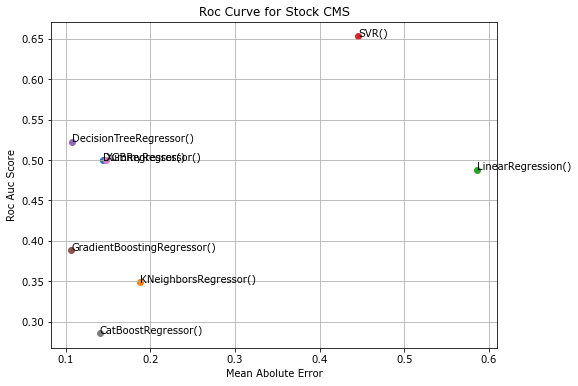

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 80.19it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'strategy': 'median'}
  Backtesting metric: 0.0003350911869157792



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
  Backtesting metric: 4.5892954705463415e-07

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 27.85it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'copy_X': True, 'fit_intercept': True}
  Backtesting metric: 0.0004967773277657837

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'C': 5, 'coef0': 0.5, 'degree': 8, 'gamma': 'auto', 'kernel': 'poly'}
  Backtesting metric: 3.567032196859548e-08

Number of models compared: 1920.


loop param_grid:  57%|██████████████████▋              | 217/384 [00:01<00:01, 161.61it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:11<00:00,  2.40s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 90, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
  Backtesting metric: 2.3741321306779878e-07

Number of models compared: 540.


loop param_grid:  63%|██████████████████████             | 68/108 [00:05<00:02, 16.97it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:36<00:00,  7.26s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
  Backtesting metric: 3.5292750782209004e-09

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 14.42it/s]

[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 13.16it/s]

[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 12.38it/s]

[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.61it/s]

[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 12.49it/s]

[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:01<00:05, 12.36it/s]

[14:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.94it/s]

[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 12.86it/s]


[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:04, 12.25it/s]

[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:04, 12.74it/s]

[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 12.96it/s]

[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:03<00:03, 12.79it/s]

[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 12.27it/s]

[14:27:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 12.41it/s]

[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.93it/s]

[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.64it/s]

[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:04<00:03, 10.92it/s]


[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.12it/s]

[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.18it/s]


[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:05<00:02, 11.12it/s]

[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:05<00:02, 11.26it/s]


[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.64it/s]

[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 11.77it/s]


[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.52it/s]


[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:06<00:01, 11.12it/s]


[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.41it/s]

[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.34it/s]


[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:07<00:00, 11.43it/s]


[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:07<00:00, 11.24it/s]

[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.70it/s]

[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 12.65it/s]

[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:06, 12.49it/s]

[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 11.88it/s]

[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 12.20it/s]

[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.05it/s]


[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.92it/s]

[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.12it/s]

[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.71it/s]

[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.69it/s]


[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 10.88it/s]

[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 10.85it/s]

[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.99it/s]


[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.45it/s]


[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.57it/s]

[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05,  9.91it/s]


[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  46%|████████████████▌                   | 44/96 [00:04<00:05,  8.89it/s]

[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.65it/s]

[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.70it/s]

[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.67it/s]


[14:27:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:04, 10.46it/s]

[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.26it/s]

[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.98it/s]

[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03,  9.93it/s]

[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.91it/s]

[14:27:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02,  9.89it/s]


[14:27:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.70it/s]

[14:27:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:06<00:02,  8.83it/s]

[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:02,  9.77it/s]

[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.99it/s]

[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.36it/s]


[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  83%|██████████████████████████████      | 80/96 [00:07<00:01,  8.99it/s]

[14:27:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.00it/s]


[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.61it/s]

[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:08<00:00,  8.87it/s]

[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00,  9.88it/s]

[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.57it/s]

[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  40%|███████████████▌                       | 2/5 [00:17<00:26,  8.87s/it]

[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 13.43it/s]

[14:27:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 11.52it/s]

[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:08, 10.29it/s]

[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:08,  9.75it/s]


[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  12%|████▌                               | 12/96 [00:01<00:09,  8.85it/s]

[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.50it/s]

[14:27:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.13it/s]

[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 20/96 [00:02<00:08,  8.94it/s]

[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  25%|█████████                           | 24/96 [00:02<00:07,  9.32it/s]

[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.55it/s]

[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 10.27it/s]

[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:03<00:06, 10.48it/s]


[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:06, 10.48it/s]


[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.24it/s]


[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.24it/s]


[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.36it/s]

[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:04<00:05, 10.04it/s]


[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:05, 10.09it/s]

[14:27:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:05,  9.85it/s]


[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  50%|██████████████████                  | 48/96 [00:04<00:05,  8.87it/s]

[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:05<00:04, 10.12it/s]

[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  54%|███████████████████▌                | 52/96 [00:05<00:05,  8.64it/s]

[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:04,  9.80it/s]


[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  8.57it/s]

[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.81it/s]


[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  62%|██████████████████████▌             | 60/96 [00:06<00:04,  8.48it/s]

[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:06<00:03,  9.79it/s]


[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.62it/s]

[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:03,  9.61it/s]


[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:07<00:03,  8.28it/s]

[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:07<00:02,  9.66it/s]


[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.35it/s]

[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.81it/s]

[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:08<00:01,  9.97it/s]

[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:08<00:01,  8.92it/s]

[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01,  9.71it/s]

[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.47it/s]

[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:09<00:00,  9.69it/s]


[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:09<00:00,  8.55it/s]

[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.35it/s]

[14:27:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00,  9.87it/s]

[14:27:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:27:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:08, 11.48it/s]


[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:08, 10.64it/s]


[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:08, 10.33it/s]


[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:08, 10.16it/s]


[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:01<00:08, 10.13it/s]

[14:28:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:08,  9.96it/s]


[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  17%|██████                              | 16/96 [00:01<00:09,  8.67it/s]

[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  21%|███████▌                            | 20/96 [00:02<00:08,  8.92it/s]

[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  25%|█████████                           | 24/96 [00:02<00:07,  9.43it/s]

[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.39it/s]

[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  29%|██████████▌                         | 28/96 [00:02<00:07,  9.40it/s]

[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████                        | 32/96 [00:03<00:06,  9.40it/s]

[14:28:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  38%|█████████████▌                      | 36/96 [00:03<00:06,  9.40it/s]

[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.53it/s]

[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████                     | 40/96 [00:04<00:05,  9.58it/s]

[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:04, 10.71it/s]


[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.32it/s]


[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.45it/s]


[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.53it/s]

[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:05<00:04, 10.25it/s]

[14:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:05<00:04,  9.79it/s]


[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:04,  9.96it/s]


[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  8.60it/s]

[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.73it/s]


[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  62%|██████████████████████▌             | 60/96 [00:06<00:04,  8.49it/s]

[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.61it/s]

[14:28:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:07<00:03,  8.25it/s]

[14:28:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.59it/s]

[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.46it/s]

[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:08<00:01,  9.56it/s]

[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:08<00:01,  8.66it/s]

[14:28:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01,  9.62it/s]

[14:28:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.38it/s]

[14:28:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:09<00:00,  8.46it/s]

[14:28:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:09<00:00,  9.56it/s]


[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.41it/s]

[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00,  9.66it/s]

[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   2%|▊                                    | 2/96 [00:00<00:04, 19.65it/s]

[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   4%|█▌                                   | 4/96 [00:00<00:11,  8.25it/s]

[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:08, 10.60it/s]

[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:08, 10.51it/s]

[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:01<00:08,  9.70it/s]


[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  14%|████▉                               | 13/96 [00:01<00:08,  9.80it/s]

[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████                              | 16/96 [00:01<00:08,  8.96it/s]

[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.17it/s]


[14:28:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07, 10.20it/s]

[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.35it/s]

[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.30it/s]

[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:07,  9.28it/s]

[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:03<00:06,  9.37it/s]


[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  33%|████████████                        | 32/96 [00:03<00:07,  8.37it/s]


[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.48it/s]


[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.45it/s]


[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:04<00:05, 10.55it/s]

[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:05, 10.50it/s]

[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.44it/s]


[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.33it/s]

[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.39it/s]

[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:05<00:03, 10.87it/s]

[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 11.13it/s]

[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 11.21it/s]

[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03, 10.31it/s]

[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:06<00:03, 10.19it/s]


[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02, 10.51it/s]

[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 10.44it/s]

[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.57it/s]


[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:07<00:02, 10.59it/s]


[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:01, 10.67it/s]


[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.75it/s]

[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.81it/s]

[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 11.00it/s]


[14:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:08<00:00, 10.93it/s]

[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00, 11.20it/s]


[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 11.14it/s]

[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00, 11.39it/s]

[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:46<00:00,  9.39s/it]


[14:28:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.6}
  Backtesting metric: 4.141536969287188e-08

Number of models compared: 60.


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]


0:	learn: 0.2240847	total: 790us	remaining: 22.9ms
1:	learn: 0.2167980	total: 1.66ms	remaining: 23.2ms
2:	learn: 0.2102151	total: 2.74ms	remaining: 24.7ms
3:	learn: 0.2032049	total: 3.81ms	remaining: 24.7ms
4:	learn: 0.1962345	total: 4.76ms	remaining: 23.8ms
5:	learn: 0.1895289	total: 5.45ms	remaining: 21.8ms
6:	learn: 0.1830578	total: 6.21ms	remaining: 20.4ms
7:	learn: 0.1774570	total: 7.17ms	remaining: 19.7ms
8:	learn: 0.1722328	total: 8.74ms	remaining: 20.4ms
9:	learn: 0.1666430	total: 9.43ms	remaining: 18.9ms
10:	learn: 0.1609938	total: 10.3ms	remaining: 17.8ms
11:	learn: 0.1559275	total: 11.1ms	remaining: 16.6ms
12:	learn: 0.1509922	total: 11.8ms	remaining: 15.4ms
13:	learn: 0.1463969	total: 13.1ms	remaining: 15ms
14:	learn: 0.1422447	total: 14ms	remaining: 14ms
15:	learn: 0.1380527	total: 14.8ms	remaining: 12.9ms
16:	learn: 0.1341003	total: 15.9ms	remaining: 12.1ms
17:	learn: 0.1304369	total: 17ms	remaining: 11.3ms
18:	learn: 0.1267792	total: 17.8ms	remaining: 10.3ms
19:	learn: 0

loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.02it/s]

0:	learn: 0.2240847	total: 733us	remaining: 35.9ms


1:	learn: 0.2167980	total: 1.74ms	remaining: 41.7ms
2:	learn: 0.2102151	total: 2.99ms	remaining: 46.8ms
3:	learn: 0.2032049	total: 4.06ms	remaining: 46.7ms
4:	learn: 0.1962345	total: 4.99ms	remaining: 45ms
5:	learn: 0.1895289	total: 5.95ms	remaining: 43.6ms
6:	learn: 0.1830578	total: 6.67ms	remaining: 41ms
7:	learn: 0.1774570	total: 7.33ms	remaining: 38.5ms
8:	learn: 0.1722328	total: 8.06ms	remaining: 36.7ms
9:	learn: 0.1666430	total: 8.98ms	remaining: 35.9ms
10:	learn: 0.1609938	total: 9.68ms	remaining: 34.3ms
11:	learn: 0.1559275	total: 10.5ms	remaining: 33.4ms
12:	learn: 0.1509922	total: 11.4ms	remaining: 32.5ms
13:	learn: 0.1463969	total: 12.1ms	remaining: 31ms
14:	learn: 0.1422447	total: 12.8ms	remaining: 30ms
15:	learn: 0.1380527	total: 13.6ms	remaining: 28.8ms
16:	learn: 0.1341003	total: 14.4ms	remaining: 27.9ms
17:	learn: 0.1304369	total: 15.2ms	remaining: 27.1ms
18:	learn: 0.1267792	total: 16.1ms	remaining: 26.3ms
19:	learn: 0.1233635	total: 16.9ms	remaining: 25.3ms
20:	learn:

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  9.33it/s]

0:	learn: 0.2242898	total: 1.59ms	remaining: 46.1ms
1:	learn: 0.2176813	total: 3.33ms	remaining: 46.6ms
2:	learn: 0.2101254	total: 3.77ms	remaining: 33.9ms
3:	learn: 0.2036019	total: 5.23ms	remaining: 34ms
4:	learn: 0.1975334	total: 7.61ms	remaining: 38.1ms
5:	learn: 0.1912277	total: 9.65ms	remaining: 38.6ms
6:	learn: 0.1853772	total: 11.2ms	remaining: 36.9ms
7:	learn: 0.1796829	total: 13.2ms	remaining: 36.2ms
8:	learn: 0.1740542	total: 14.6ms	remaining: 34ms
9:	learn: 0.1685283	total: 16.2ms	remaining: 32.5ms
10:	learn: 0.1634815	total: 17.7ms	remaining: 30.6ms
11:	learn: 0.1587014	total: 19.3ms	remaining: 29ms
12:	learn: 0.1542583	total: 20.8ms	remaining: 27.2ms
13:	learn: 0.1497215	total: 22.8ms	remaining: 26ms
14:	learn: 0.1449031	total: 23.6ms	remaining: 23.6ms
15:	learn: 0.1406830	total: 25.1ms	remaining: 21.9ms
16:	learn: 0.1368293	total: 26.7ms	remaining: 20.4ms
17:	learn: 0.1330423	total: 28.8ms	remaining: 19.2ms
18:	learn: 0.1291243	total: 29.8ms	remaining: 17.3ms
19:	learn: 


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  8.27it/s]

0:	learn: 0.2242898	total: 1.82ms	remaining: 89.4ms
1:	learn: 0.2176813	total: 3.19ms	remaining: 76.5ms
2:	learn: 0.2101254	total: 3.64ms	remaining: 57.1ms
3:	learn: 0.2036019	total: 5.56ms	remaining: 63.9ms
4:	learn: 0.1975334	total: 7.48ms	remaining: 67.4ms
5:	learn: 0.1912277	total: 9.85ms	remaining: 72.2ms
6:	learn: 0.1853772	total: 11.7ms	remaining: 72.1ms
7:	learn: 0.1796829	total: 13.2ms	remaining: 69.2ms
8:	learn: 0.1740542	total: 15ms	remaining: 68.4ms
9:	learn: 0.1685283	total: 16.7ms	remaining: 67ms
10:	learn: 0.1634815	total: 18.5ms	remaining: 65.5ms
11:	learn: 0.1587014	total: 20.2ms	remaining: 64.1ms
12:	learn: 0.1542583	total: 21.7ms	remaining: 61.9ms
13:	learn: 0.1497215	total: 23.2ms	remaining: 59.6ms
14:	learn: 0.1449031	total: 24.2ms	remaining: 56.5ms
15:	learn: 0.1406830	total: 25.7ms	remaining: 54.6ms
16:	learn: 0.1368293	total: 27.1ms	remaining: 52.6ms
17:	learn: 0.1330423	total: 29ms	remaining: 51.6ms
18:	learn: 0.1291243	total: 30.2ms	remaining: 49.3ms
19:	learn


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:00<00:00,  7.29it/s]

11:	learn: 0.1127389	total: 23.3ms	remaining: 73.9ms
12:	learn: 0.1070555	total: 25.1ms	remaining: 71.5ms
13:	learn: 0.1021975	total: 26.7ms	remaining: 68.8ms
14:	learn: 0.0971618	total: 28.7ms	remaining: 67ms
15:	learn: 0.0923376	total: 29.2ms	remaining: 62ms
16:	learn: 0.0884942	total: 30.7ms	remaining: 59.5ms
17:	learn: 0.0847633	total: 32.3ms	remaining: 57.4ms
18:	learn: 0.0811293	total: 34.1ms	remaining: 55.7ms
19:	learn: 0.0778878	total: 35.7ms	remaining: 53.6ms
20:	learn: 0.0751007	total: 37.6ms	remaining: 51.9ms
21:	learn: 0.0720537	total: 39.7ms	remaining: 50.6ms
22:	learn: 0.0693371	total: 41.5ms	remaining: 48.8ms
23:	learn: 0.0673859	total: 43.3ms	remaining: 46.9ms
24:	learn: 0.0654306	total: 45.5ms	remaining: 45.5ms
25:	learn: 0.0634860	total: 47.6ms	remaining: 43.9ms
26:	learn: 0.0615042	total: 49.8ms	remaining: 42.4ms
27:	learn: 0.0597941	total: 51.3ms	remaining: 40.3ms
28:	learn: 0.0581910	total: 53.2ms	remaining: 38.5ms
29:	learn: 0.0565651	total: 55ms	remaining: 36.7ms


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.25it/s]

10:	learn: 0.1662435	total: 48.8ms	remaining: 84.3ms
11:	learn: 0.1616196	total: 53.2ms	remaining: 79.7ms
12:	learn: 0.1568480	total: 57.5ms	remaining: 75.2ms
13:	learn: 0.1525811	total: 62.8ms	remaining: 71.7ms
14:	learn: 0.1477202	total: 63.9ms	remaining: 63.9ms
15:	learn: 0.1438529	total: 68.7ms	remaining: 60.1ms
16:	learn: 0.1397419	total: 70.4ms	remaining: 53.9ms
17:	learn: 0.1363687	total: 75.9ms	remaining: 50.6ms
18:	learn: 0.1326805	total: 81.4ms	remaining: 47.1ms
19:	learn: 0.1290470	total: 89ms	remaining: 44.5ms
20:	learn: 0.1257912	total: 95ms	remaining: 40.7ms
21:	learn: 0.1226153	total: 100ms	remaining: 36.4ms
22:	learn: 0.1198553	total: 105ms	remaining: 31.8ms
23:	learn: 0.1168190	total: 111ms	remaining: 27.7ms
24:	learn: 0.1137847	total: 116ms	remaining: 23.3ms
25:	learn: 0.1107406	total: 121ms	remaining: 18.7ms
26:	learn: 0.1076037	total: 126ms	remaining: 14ms
27:	learn: 0.1050009	total: 132ms	remaining: 9.41ms
28:	learn: 0.1023163	total: 134ms	remaining: 4.61ms
29:	lea


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.92it/s]

4:	learn: 0.1719263	total: 23.8ms	remaining: 119ms
5:	learn: 0.1618753	total: 28.5ms	remaining: 114ms
6:	learn: 0.1523192	total: 31.1ms	remaining: 102ms
7:	learn: 0.1424137	total: 32.2ms	remaining: 88.5ms
8:	learn: 0.1353210	total: 37.6ms	remaining: 87.8ms
9:	learn: 0.1281452	total: 42.8ms	remaining: 85.6ms
10:	learn: 0.1205608	total: 44.5ms	remaining: 76.9ms
11:	learn: 0.1144921	total: 49.5ms	remaining: 74.3ms
12:	learn: 0.1089180	total: 54.2ms	remaining: 70.9ms
13:	learn: 0.1031031	total: 55.9ms	remaining: 63.9ms
14:	learn: 0.0976637	total: 58.7ms	remaining: 58.7ms
15:	learn: 0.0932762	total: 63.6ms	remaining: 55.7ms
16:	learn: 0.0890229	total: 68ms	remaining: 52ms
17:	learn: 0.0852595	total: 72.3ms	remaining: 48.2ms
18:	learn: 0.0818508	total: 78.9ms	remaining: 45.7ms
19:	learn: 0.0789117	total: 83.5ms	remaining: 41.8ms
20:	learn: 0.0759274	total: 88.3ms	remaining: 37.8ms
21:	learn: 0.0729751	total: 92.4ms	remaining: 33.6ms
22:	learn: 0.0704332	total: 97ms	remaining: 29.5ms
23:	lear

30:	learn: 0.0975838	total: 183ms	remaining: 112ms
31:	learn: 0.0949247	total: 185ms	remaining: 104ms
32:	learn: 0.0927114	total: 192ms	remaining: 99.1ms
33:	learn: 0.0907222	total: 200ms	remaining: 94.1ms
34:	learn: 0.0887061	total: 208ms	remaining: 89.3ms
35:	learn: 0.0865083	total: 209ms	remaining: 81.4ms
36:	learn: 0.0842341	total: 211ms	remaining: 74.1ms
37:	learn: 0.0823733	total: 218ms	remaining: 68.8ms
38:	learn: 0.0807141	total: 228ms	remaining: 64.4ms
39:	learn: 0.0791735	total: 237ms	remaining: 59.2ms
40:	learn: 0.0774970	total: 248ms	remaining: 54.5ms
41:	learn: 0.0759147	total: 257ms	remaining: 49ms
42:	learn: 0.0744762	total: 266ms	remaining: 43.2ms
43:	learn: 0.0731122	total: 273ms	remaining: 37.3ms
44:	learn: 0.0716569	total: 275ms	remaining: 30.6ms
45:	learn: 0.0699887	total: 283ms	remaining: 24.6ms
46:	learn: 0.0686661	total: 290ms	remaining: 18.5ms
47:	learn: 0.0674348	total: 298ms	remaining: 12.4ms
48:	learn: 0.0662193	total: 308ms	remaining: 6.28ms
49:	learn: 0.064

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.04it/s]

0:	learn: 0.2178756	total: 6.31ms	remaining: 309ms
1:	learn: 0.2061285	total: 16.2ms	remaining: 390ms
2:	learn: 0.1946503	total: 27ms	remaining: 423ms
3:	learn: 0.1820177	total: 29.5ms	remaining: 339ms
4:	learn: 0.1719263	total: 37ms	remaining: 333ms
5:	learn: 0.1618753	total: 44.1ms	remaining: 323ms
6:	learn: 0.1523192	total: 48.5ms	remaining: 298ms
7:	learn: 0.1424137	total: 49.5ms	remaining: 260ms
8:	learn: 0.1353210	total: 57.4ms	remaining: 261ms
9:	learn: 0.1281452	total: 65.2ms	remaining: 261ms
10:	learn: 0.1205608	total: 67.8ms	remaining: 241ms
11:	learn: 0.1144921	total: 75ms	remaining: 237ms
12:	learn: 0.1089180	total: 82.4ms	remaining: 235ms
13:	learn: 0.1031031	total: 85.5ms	remaining: 220ms
14:	learn: 0.0976637	total: 89.3ms	remaining: 208ms
15:	learn: 0.0932762	total: 95.8ms	remaining: 204ms
16:	learn: 0.0890229	total: 101ms	remaining: 196ms
17:	learn: 0.0852595	total: 109ms	remaining: 193ms
18:	learn: 0.0818508	total: 115ms	remaining: 188ms
19:	learn: 0.0789117	total: 122

27:	learn: 0.0589569	total: 168ms	remaining: 132ms
28:	learn: 0.0568314	total: 169ms	remaining: 122ms
29:	learn: 0.0549808	total: 170ms	remaining: 113ms
30:	learn: 0.0531546	total: 175ms	remaining: 107ms
31:	learn: 0.0518134	total: 182ms	remaining: 102ms
32:	learn: 0.0502689	total: 188ms	remaining: 96.9ms
33:	learn: 0.0490418	total: 196ms	remaining: 92ms
34:	learn: 0.0477279	total: 203ms	remaining: 87.1ms
35:	learn: 0.0462475	total: 210ms	remaining: 81.7ms
36:	learn: 0.0447199	total: 216ms	remaining: 76ms
37:	learn: 0.0432998	total: 223ms	remaining: 70.3ms
38:	learn: 0.0420711	total: 229ms	remaining: 64.6ms
39:	learn: 0.0410817	total: 237ms	remaining: 59.2ms
40:	learn: 0.0397062	total: 243ms	remaining: 53.3ms
41:	learn: 0.0385712	total: 249ms	remaining: 47.5ms
42:	learn: 0.0375675	total: 255ms	remaining: 41.5ms
43:	learn: 0.0365298	total: 260ms	remaining: 35.5ms
44:	learn: 0.0353176	total: 266ms	remaining: 29.6ms
45:	learn: 0.0340429	total: 273ms	remaining: 23.7ms
46:	learn: 0.0331253	

loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  7.60it/s]

0:	learn: 0.2078970	total: 1.16ms	remaining: 33.6ms
1:	learn: 0.2012497	total: 2.34ms	remaining: 32.7ms
2:	learn: 0.1953104	total: 3.45ms	remaining: 31.1ms
3:	learn: 0.1897073	total: 4.79ms	remaining: 31.1ms
4:	learn: 0.1840272	total: 7.33ms	remaining: 36.6ms
5:	learn: 0.1778990	total: 8.63ms	remaining: 34.5ms
6:	learn: 0.1728056	total: 10ms	remaining: 33ms
7:	learn: 0.1680074	total: 11.3ms	remaining: 31.1ms
8:	learn: 0.1632566	total: 12.3ms	remaining: 28.8ms
9:	learn: 0.1587952	total: 13.6ms	remaining: 27.2ms
10:	learn: 0.1538513	total: 15ms	remaining: 25.8ms
11:	learn: 0.1497268	total: 16.2ms	remaining: 24.3ms
12:	learn: 0.1453691	total: 17.1ms	remaining: 22.4ms
13:	learn: 0.1411931	total: 18.7ms	remaining: 21.4ms
14:	learn: 0.1369591	total: 19.9ms	remaining: 19.9ms
15:	learn: 0.1332315	total: 21ms	remaining: 18.4ms
16:	learn: 0.1293955	total: 22ms	remaining: 16.8ms
17:	learn: 0.1256676	total: 23.2ms	remaining: 15.5ms
18:	learn: 0.1223523	total: 24.4ms	remaining: 14.2ms
19:	learn: 0.


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  7.33it/s]

20:	learn: 0.0741194	total: 26.5ms	remaining: 11.3ms
21:	learn: 0.0718966	total: 28.1ms	remaining: 10.2ms
22:	learn: 0.0696683	total: 29.7ms	remaining: 9.03ms
23:	learn: 0.0674957	total: 30.9ms	remaining: 7.72ms
24:	learn: 0.0655622	total: 31.6ms	remaining: 6.31ms
25:	learn: 0.0638317	total: 32.9ms	remaining: 5.06ms
26:	learn: 0.0622274	total: 35.1ms	remaining: 3.9ms
27:	learn: 0.0604005	total: 36.3ms	remaining: 2.59ms
28:	learn: 0.0585489	total: 38.2ms	remaining: 1.32ms
29:	learn: 0.0571694	total: 39.8ms	remaining: 0us
0:	learn: 0.2078970	total: 1.1ms	remaining: 54.1ms
1:	learn: 0.2012497	total: 2.36ms	remaining: 56.7ms
2:	learn: 0.1953104	total: 4.34ms	remaining: 68ms
3:	learn: 0.1897073	total: 5.48ms	remaining: 63.1ms
4:	learn: 0.1840272	total: 6.94ms	remaining: 62.5ms
5:	learn: 0.1778990	total: 8.12ms	remaining: 59.5ms
6:	learn: 0.1728056	total: 9.25ms	remaining: 56.8ms
7:	learn: 0.1680074	total: 10.5ms	remaining: 55.2ms
8:	learn: 0.1632566	total: 11.8ms	remaining: 53.5ms
9:	learn:


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  6.43it/s]

44:	learn: 0.0708768	total: 57.8ms	remaining: 6.42ms
45:	learn: 0.0698337	total: 59.2ms	remaining: 5.14ms
46:	learn: 0.0688650	total: 60.5ms	remaining: 3.86ms
47:	learn: 0.0678748	total: 63.1ms	remaining: 2.63ms
48:	learn: 0.0670221	total: 64.4ms	remaining: 1.31ms
49:	learn: 0.0662838	total: 66.8ms	remaining: 0us
0:	learn: 0.2009231	total: 1.37ms	remaining: 67.4ms
1:	learn: 0.1881826	total: 2.48ms	remaining: 59.5ms
2:	learn: 0.1772573	total: 3.96ms	remaining: 62.1ms
3:	learn: 0.1673676	total: 5.06ms	remaining: 58.2ms
4:	learn: 0.1577888	total: 6.17ms	remaining: 55.5ms
5:	learn: 0.1477634	total: 7.47ms	remaining: 54.8ms
6:	learn: 0.1394708	total: 9.45ms	remaining: 58.1ms
7:	learn: 0.1324455	total: 11.1ms	remaining: 58.3ms
8:	learn: 0.1255942	total: 12.4ms	remaining: 56.4ms
9:	learn: 0.1192384	total: 14.2ms	remaining: 56.7ms
10:	learn: 0.1129489	total: 15.8ms	remaining: 55.9ms
11:	learn: 0.1078918	total: 17.4ms	remaining: 55.1ms
12:	learn: 0.1027592	total: 18.9ms	remaining: 53.7ms
13:	le


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  5.73it/s]

39:	learn: 0.0457097	total: 72.5ms	remaining: 18.1ms
40:	learn: 0.0448209	total: 75.1ms	remaining: 16.5ms
41:	learn: 0.0436830	total: 77ms	remaining: 14.7ms
42:	learn: 0.0429909	total: 78.4ms	remaining: 12.8ms
43:	learn: 0.0422496	total: 80.2ms	remaining: 10.9ms
44:	learn: 0.0413242	total: 81.4ms	remaining: 9.05ms
45:	learn: 0.0403881	total: 82.6ms	remaining: 7.18ms
46:	learn: 0.0394120	total: 84ms	remaining: 5.36ms
47:	learn: 0.0386042	total: 85.4ms	remaining: 3.56ms
48:	learn: 0.0378115	total: 86.7ms	remaining: 1.77ms
49:	learn: 0.0371777	total: 88ms	remaining: 0us
0:	learn: 0.2083676	total: 5.72ms	remaining: 166ms
1:	learn: 0.2022282	total: 8.77ms	remaining: 123ms
2:	learn: 0.1965519	total: 13.8ms	remaining: 124ms
3:	learn: 0.1896113	total: 15.9ms	remaining: 103ms
4:	learn: 0.1844871	total: 18.9ms	remaining: 94.8ms
5:	learn: 0.1797879	total: 22.2ms	remaining: 88.9ms
6:	learn: 0.1746347	total: 25.8ms	remaining: 84.7ms
7:	learn: 0.1695203	total: 29.2ms	remaining: 80.2ms
8:	learn: 0.16


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  5.45it/s]

18:	learn: 0.1269347	total: 67.5ms	remaining: 39.1ms
19:	learn: 0.1240247	total: 70.1ms	remaining: 35ms
20:	learn: 0.1211030	total: 72.7ms	remaining: 31.2ms
21:	learn: 0.1176470	total: 73.5ms	remaining: 26.7ms
22:	learn: 0.1149731	total: 76.3ms	remaining: 23.2ms
23:	learn: 0.1119791	total: 76.8ms	remaining: 19.2ms
24:	learn: 0.1093626	total: 80.3ms	remaining: 16.1ms
25:	learn: 0.1069934	total: 83.5ms	remaining: 12.8ms
26:	learn: 0.1048022	total: 87.1ms	remaining: 9.67ms
27:	learn: 0.1021277	total: 89.9ms	remaining: 6.42ms
28:	learn: 0.1000965	total: 93.3ms	remaining: 3.22ms
29:	learn: 0.0977378	total: 97.9ms	remaining: 0us
0:	learn: 0.2018556	total: 3.04ms	remaining: 88.2ms
1:	learn: 0.1901011	total: 5.92ms	remaining: 82.8ms
2:	learn: 0.1795518	total: 8.94ms	remaining: 80.5ms
3:	learn: 0.1671773	total: 9.7ms	remaining: 63.1ms
4:	learn: 0.1584665	total: 12.6ms	remaining: 63ms
5:	learn: 0.1507507	total: 15.4ms	remaining: 61.7ms
6:	learn: 0.1425152	total: 18ms	remaining: 59.2ms
7:	learn: 


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:01<00:01,  5.23it/s]

19:	learn: 0.0793000	total: 64ms	remaining: 32ms
20:	learn: 0.0764958	total: 67.7ms	remaining: 29ms
21:	learn: 0.0736556	total: 69.5ms	remaining: 25.3ms
22:	learn: 0.0711531	total: 73.7ms	remaining: 22.4ms
23:	learn: 0.0690851	total: 79.8ms	remaining: 20ms
24:	learn: 0.0670980	total: 90.2ms	remaining: 18ms
25:	learn: 0.0647101	total: 93.2ms	remaining: 14.3ms
26:	learn: 0.0626965	total: 94.1ms	remaining: 10.5ms
27:	learn: 0.0607651	total: 97.7ms	remaining: 6.98ms
28:	learn: 0.0593549	total: 98.7ms	remaining: 3.4ms
29:	learn: 0.0581447	total: 103ms	remaining: 0us
0:	learn: 0.2083676	total: 3.8ms	remaining: 186ms
1:	learn: 0.2022282	total: 7.54ms	remaining: 181ms
2:	learn: 0.1965519	total: 12.6ms	remaining: 197ms
3:	learn: 0.1896113	total: 13.3ms	remaining: 153ms
4:	learn: 0.1844871	total: 19.2ms	remaining: 173ms
5:	learn: 0.1797879	total: 26.3ms	remaining: 193ms
6:	learn: 0.1746347	total: 31.1ms	remaining: 191ms
7:	learn: 0.1695203	total: 35ms	remaining: 184ms
8:	learn: 0.1650995	total: 


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:01,  4.29it/s]


0:	learn: 0.2018556	total: 3.27ms	remaining: 160ms
1:	learn: 0.1901011	total: 6.79ms	remaining: 163ms
2:	learn: 0.1795518	total: 9.89ms	remaining: 155ms
3:	learn: 0.1671773	total: 10.6ms	remaining: 122ms
4:	learn: 0.1584665	total: 13.6ms	remaining: 122ms
5:	learn: 0.1507507	total: 16.5ms	remaining: 121ms
6:	learn: 0.1425152	total: 19.7ms	remaining: 121ms
7:	learn: 0.1347682	total: 22.9ms	remaining: 120ms
8:	learn: 0.1284009	total: 25.2ms	remaining: 115ms
9:	learn: 0.1214499	total: 27.7ms	remaining: 111ms
10:	learn: 0.1149887	total: 30.9ms	remaining: 110ms
11:	learn: 0.1101062	total: 33.5ms	remaining: 106ms
12:	learn: 0.1053265	total: 35.7ms	remaining: 102ms
13:	learn: 0.1006835	total: 37.9ms	remaining: 97.5ms
14:	learn: 0.0970125	total: 40.2ms	remaining: 93.8ms
15:	learn: 0.0925538	total: 42.5ms	remaining: 90.4ms
16:	learn: 0.0889866	total: 44.6ms	remaining: 86.7ms
17:	learn: 0.0853761	total: 47ms	remaining: 83.5ms
18:	learn: 0.0819328	total: 48.8ms	remaining: 79.5ms
19:	learn: 0.07930

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  4.34it/s]

0:	learn: 0.2093458	total: 7.23ms	remaining: 210ms
1:	learn: 0.2040732	total: 13.5ms	remaining: 190ms
2:	learn: 0.1976013	total: 14ms	remaining: 126ms
3:	learn: 0.1923883	total: 19.9ms	remaining: 129ms
4:	learn: 0.1871683	total: 27.2ms	remaining: 136ms
5:	learn: 0.1822305	total: 36.1ms	remaining: 144ms
6:	learn: 0.1766745	total: 37.6ms	remaining: 124ms
7:	learn: 0.1722739	total: 46.7ms	remaining: 128ms
8:	learn: 0.1668953	total: 47.9ms	remaining: 112ms
9:	learn: 0.1620330	total: 55.4ms	remaining: 111ms
10:	learn: 0.1580507	total: 62.3ms	remaining: 108ms
11:	learn: 0.1543503	total: 70.1ms	remaining: 105ms
12:	learn: 0.1496965	total: 72.1ms	remaining: 94.3ms
13:	learn: 0.1458838	total: 78.5ms	remaining: 89.7ms
14:	learn: 0.1416223	total: 79.1ms	remaining: 79.1ms
15:	learn: 0.1385422	total: 86.8ms	remaining: 75.9ms
16:	learn: 0.1351635	total: 93.8ms	remaining: 71.8ms
17:	learn: 0.1320253	total: 104ms	remaining: 69ms
18:	learn: 0.1281721	total: 105ms	remaining: 60.8ms
19:	learn: 0.1252052	


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.09it/s]

28:	learn: 0.1018373	total: 176ms	remaining: 6.06ms
29:	learn: 0.0996508	total: 184ms	remaining: 0us
0:	learn: 0.2038060	total: 6.54ms	remaining: 190ms
1:	learn: 0.1936353	total: 13.6ms	remaining: 190ms
2:	learn: 0.1815917	total: 14.1ms	remaining: 127ms
3:	learn: 0.1722390	total: 22.9ms	remaining: 149ms
4:	learn: 0.1631866	total: 32.9ms	remaining: 164ms
5:	learn: 0.1548256	total: 43.4ms	remaining: 173ms
6:	learn: 0.1459756	total: 44.8ms	remaining: 147ms
7:	learn: 0.1387264	total: 52.4ms	remaining: 144ms
8:	learn: 0.1307592	total: 53.6ms	remaining: 125ms
9:	learn: 0.1237546	total: 60ms	remaining: 120ms
10:	learn: 0.1182168	total: 69.1ms	remaining: 119ms
11:	learn: 0.1130064	total: 77.1ms	remaining: 116ms
12:	learn: 0.1071086	total: 78.6ms	remaining: 103ms
13:	learn: 0.1023736	total: 87.4ms	remaining: 99.9ms
14:	learn: 0.0977312	total: 88.1ms	remaining: 88.1ms
15:	learn: 0.0940568	total: 98.9ms	remaining: 86.5ms
16:	learn: 0.0903095	total: 112ms	remaining: 85.6ms
17:	learn: 0.0870711	tot


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:02<00:00,  3.53it/s]

0:	learn: 0.2093458	total: 8.96ms	remaining: 439ms
1:	learn: 0.2040732	total: 18.3ms	remaining: 439ms
2:	learn: 0.1976013	total: 19.3ms	remaining: 303ms
3:	learn: 0.1923883	total: 28.2ms	remaining: 325ms
4:	learn: 0.1871683	total: 37ms	remaining: 333ms
5:	learn: 0.1822305	total: 45.8ms	remaining: 336ms
6:	learn: 0.1766745	total: 47.4ms	remaining: 291ms
7:	learn: 0.1722739	total: 54.1ms	remaining: 284ms
8:	learn: 0.1668953	total: 55ms	remaining: 250ms
9:	learn: 0.1620330	total: 61.4ms	remaining: 246ms
10:	learn: 0.1580507	total: 70.3ms	remaining: 249ms
11:	learn: 0.1543503	total: 78.2ms	remaining: 248ms
12:	learn: 0.1496965	total: 80.8ms	remaining: 230ms
13:	learn: 0.1458838	total: 91.5ms	remaining: 235ms
14:	learn: 0.1416223	total: 92.2ms	remaining: 215ms
15:	learn: 0.1385422	total: 105ms	remaining: 223ms
16:	learn: 0.1351635	total: 115ms	remaining: 224ms
17:	learn: 0.1320253	total: 124ms	remaining: 220ms
18:	learn: 0.1281721	total: 125ms	remaining: 204ms
19:	learn: 0.1252052	total: 13


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  2.78it/s]

42:	learn: 0.0763878	total: 349ms	remaining: 56.8ms
43:	learn: 0.0750559	total: 357ms	remaining: 48.7ms
44:	learn: 0.0737200	total: 365ms	remaining: 40.6ms
45:	learn: 0.0724112	total: 373ms	remaining: 32.5ms
46:	learn: 0.0711573	total: 381ms	remaining: 24.3ms
47:	learn: 0.0698178	total: 388ms	remaining: 16.2ms
48:	learn: 0.0687020	total: 395ms	remaining: 8.06ms
49:	learn: 0.0673325	total: 402ms	remaining: 0us
0:	learn: 0.2038060	total: 8.29ms	remaining: 406ms
1:	learn: 0.1936353	total: 17.5ms	remaining: 421ms
2:	learn: 0.1815917	total: 18.4ms	remaining: 288ms
3:	learn: 0.1722390	total: 24.8ms	remaining: 286ms
4:	learn: 0.1631866	total: 32.7ms	remaining: 294ms
5:	learn: 0.1548256	total: 39.6ms	remaining: 291ms
6:	learn: 0.1459756	total: 41.5ms	remaining: 255ms
7:	learn: 0.1387264	total: 48.9ms	remaining: 257ms
8:	learn: 0.1307592	total: 50ms	remaining: 228ms
9:	learn: 0.1237546	total: 57.6ms	remaining: 230ms
10:	learn: 0.1182168	total: 66.3ms	remaining: 235ms
11:	learn: 0.1130064	total:


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:05<00:08,  2.80s/it]

35:	learn: 0.0461998	total: 207ms	remaining: 80.7ms
36:	learn: 0.0447295	total: 214ms	remaining: 75.1ms
37:	learn: 0.0432651	total: 221ms	remaining: 69.7ms
38:	learn: 0.0418547	total: 227ms	remaining: 64ms
39:	learn: 0.0404913	total: 233ms	remaining: 58.4ms
40:	learn: 0.0393272	total: 242ms	remaining: 53ms
41:	learn: 0.0381746	total: 249ms	remaining: 47.5ms
42:	learn: 0.0369582	total: 257ms	remaining: 41.9ms
43:	learn: 0.0355405	total: 264ms	remaining: 36ms
44:	learn: 0.0343915	total: 271ms	remaining: 30.1ms
45:	learn: 0.0335426	total: 276ms	remaining: 24ms
46:	learn: 0.0326469	total: 283ms	remaining: 18ms
47:	learn: 0.0318455	total: 289ms	remaining: 12ms
48:	learn: 0.0307264	total: 299ms	remaining: 6.09ms
49:	learn: 0.0295474	total: 306ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1816370	total: 1.31ms	remaining: 38ms
1:	learn: 0.1767056	total: 3ms	remaining: 42.1ms



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.22it/s]

2:	learn: 0.1720798	total: 4.55ms	remaining: 41ms
3:	learn: 0.1673621	total: 8.96ms	remaining: 58.3ms
4:	learn: 0.1631532	total: 10.3ms	remaining: 51.5ms
5:	learn: 0.1578709	total: 10.9ms	remaining: 43.7ms
6:	learn: 0.1538261	total: 13ms	remaining: 42.6ms
7:	learn: 0.1493977	total: 14.4ms	remaining: 39.6ms
8:	learn: 0.1451748	total: 15.9ms	remaining: 37ms
9:	learn: 0.1407632	total: 17.6ms	remaining: 35.1ms
10:	learn: 0.1370952	total: 18.9ms	remaining: 32.6ms
11:	learn: 0.1331209	total: 20.4ms	remaining: 30.6ms
12:	learn: 0.1301834	total: 21.5ms	remaining: 28.1ms
13:	learn: 0.1270306	total: 22.7ms	remaining: 25.9ms
14:	learn: 0.1237325	total: 24.5ms	remaining: 24.5ms
15:	learn: 0.1207001	total: 25.9ms	remaining: 22.7ms
16:	learn: 0.1178253	total: 27.4ms	remaining: 21ms
17:	learn: 0.1154239	total: 28.8ms	remaining: 19.2ms
18:	learn: 0.1129112	total: 30.1ms	remaining: 17.4ms
19:	learn: 0.1100350	total: 31.3ms	remaining: 15.7ms
20:	learn: 0.1073988	total: 32ms	remaining: 13.7ms
21:	learn: 


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  7.15it/s]

26:	learn: 0.0571949	total: 40.8ms	remaining: 4.53ms
27:	learn: 0.0553886	total: 42.3ms	remaining: 3.02ms
28:	learn: 0.0536454	total: 45.2ms	remaining: 1.56ms
29:	learn: 0.0526084	total: 48.9ms	remaining: 0us
0:	learn: 0.1816370	total: 2.25ms	remaining: 110ms
1:	learn: 0.1767056	total: 3.97ms	remaining: 95.2ms
2:	learn: 0.1720798	total: 5.63ms	remaining: 88.2ms
3:	learn: 0.1673621	total: 7.38ms	remaining: 84.9ms
4:	learn: 0.1631532	total: 9.16ms	remaining: 82.4ms
5:	learn: 0.1578709	total: 9.84ms	remaining: 72.1ms
6:	learn: 0.1538261	total: 12.5ms	remaining: 76.6ms
7:	learn: 0.1493977	total: 14.2ms	remaining: 74.5ms
8:	learn: 0.1451748	total: 15.8ms	remaining: 72.1ms
9:	learn: 0.1407632	total: 18.2ms	remaining: 73ms
10:	learn: 0.1370952	total: 19.8ms	remaining: 70.1ms
11:	learn: 0.1331209	total: 21.2ms	remaining: 67.2ms
12:	learn: 0.1301834	total: 23.9ms	remaining: 68ms
13:	learn: 0.1270306	total: 25.3ms	remaining: 65.1ms
14:	learn: 0.1237325	total: 27.2ms	remaining: 63.4ms
15:	learn: 


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  5.63it/s]

27:	learn: 0.0926485	total: 54.6ms	remaining: 42.9ms
28:	learn: 0.0902201	total: 56.7ms	remaining: 41ms
29:	learn: 0.0885392	total: 59ms	remaining: 39.3ms
30:	learn: 0.0865925	total: 60.3ms	remaining: 37ms
31:	learn: 0.0851129	total: 62.3ms	remaining: 35ms
32:	learn: 0.0833456	total: 64ms	remaining: 33ms
33:	learn: 0.0817890	total: 65.5ms	remaining: 30.8ms
34:	learn: 0.0803671	total: 67.1ms	remaining: 28.7ms
35:	learn: 0.0787155	total: 68.7ms	remaining: 26.7ms
36:	learn: 0.0773463	total: 70.6ms	remaining: 24.8ms
37:	learn: 0.0759321	total: 72.3ms	remaining: 22.8ms
38:	learn: 0.0747578	total: 73.5ms	remaining: 20.7ms
39:	learn: 0.0736259	total: 75ms	remaining: 18.8ms
40:	learn: 0.0723045	total: 76.7ms	remaining: 16.8ms
41:	learn: 0.0711173	total: 81.6ms	remaining: 15.5ms
42:	learn: 0.0701297	total: 83ms	remaining: 13.5ms
43:	learn: 0.0688325	total: 84.3ms	remaining: 11.5ms
44:	learn: 0.0678655	total: 85.6ms	remaining: 9.51ms
45:	learn: 0.0666506	total: 86.9ms	remaining: 7.56ms
46:	learn


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  5.38it/s]

25:	learn: 0.0591684	total: 49.8ms	remaining: 46ms
26:	learn: 0.0571949	total: 51.1ms	remaining: 43.5ms
27:	learn: 0.0553886	total: 52.2ms	remaining: 41ms
28:	learn: 0.0536454	total: 54.4ms	remaining: 39.4ms
29:	learn: 0.0526084	total: 55.7ms	remaining: 37.2ms
30:	learn: 0.0509970	total: 57.5ms	remaining: 35.3ms
31:	learn: 0.0496847	total: 59.9ms	remaining: 33.7ms
32:	learn: 0.0480626	total: 61.4ms	remaining: 31.6ms
33:	learn: 0.0463917	total: 62.7ms	remaining: 29.5ms
34:	learn: 0.0452968	total: 64.1ms	remaining: 27.5ms
35:	learn: 0.0441895	total: 65.4ms	remaining: 25.4ms
36:	learn: 0.0431167	total: 66.6ms	remaining: 23.4ms
37:	learn: 0.0418879	total: 67.6ms	remaining: 21.3ms
38:	learn: 0.0405156	total: 68.9ms	remaining: 19.4ms
39:	learn: 0.0394744	total: 70.9ms	remaining: 17.7ms
40:	learn: 0.0382213	total: 72.4ms	remaining: 15.9ms
41:	learn: 0.0371541	total: 74.2ms	remaining: 14.1ms
42:	learn: 0.0362428	total: 76.2ms	remaining: 12.4ms
43:	learn: 0.0353196	total: 78ms	remaining: 10.6ms


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  5.20it/s]

8:	learn: 0.1470930	total: 39.6ms	remaining: 92.4ms
9:	learn: 0.1437637	total: 43.1ms	remaining: 86.1ms
10:	learn: 0.1398664	total: 46.7ms	remaining: 80.7ms
11:	learn: 0.1368006	total: 49.2ms	remaining: 73.8ms
12:	learn: 0.1333354	total: 52.5ms	remaining: 68.6ms
13:	learn: 0.1302691	total: 55.2ms	remaining: 63.1ms
14:	learn: 0.1276331	total: 59.3ms	remaining: 59.3ms
15:	learn: 0.1243175	total: 62.1ms	remaining: 54.3ms
16:	learn: 0.1213700	total: 66.3ms	remaining: 50.7ms
17:	learn: 0.1180175	total: 69.3ms	remaining: 46.2ms
18:	learn: 0.1148737	total: 72.9ms	remaining: 42.2ms
19:	learn: 0.1118530	total: 76.1ms	remaining: 38.1ms
20:	learn: 0.1095474	total: 79.5ms	remaining: 34.1ms
21:	learn: 0.1070853	total: 81.2ms	remaining: 29.5ms
22:	learn: 0.1047473	total: 83.8ms	remaining: 25.5ms
23:	learn: 0.1021702	total: 86.5ms	remaining: 21.6ms
24:	learn: 0.1003693	total: 89.1ms	remaining: 17.8ms
25:	learn: 0.0981165	total: 91.8ms	remaining: 14.1ms
26:	learn: 0.0957342	total: 94.2ms	remaining: 10


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:01<00:01,  5.32it/s]

8:	learn: 0.1165368	total: 30.7ms	remaining: 71.7ms
9:	learn: 0.1116516	total: 33ms	remaining: 66.1ms
10:	learn: 0.1067661	total: 36ms	remaining: 62.2ms
11:	learn: 0.1025525	total: 38.6ms	remaining: 58ms
12:	learn: 0.0978565	total: 41.6ms	remaining: 54.4ms
13:	learn: 0.0936337	total: 44.2ms	remaining: 50.6ms
14:	learn: 0.0906049	total: 47.3ms	remaining: 47.3ms
15:	learn: 0.0866716	total: 50.4ms	remaining: 44.1ms
16:	learn: 0.0830333	total: 54.8ms	remaining: 41.9ms
17:	learn: 0.0790444	total: 57.5ms	remaining: 38.3ms
18:	learn: 0.0758178	total: 58.2ms	remaining: 33.7ms
19:	learn: 0.0735442	total: 60.9ms	remaining: 30.5ms
20:	learn: 0.0707227	total: 63.7ms	remaining: 27.3ms
21:	learn: 0.0684624	total: 67ms	remaining: 24.3ms
22:	learn: 0.0658925	total: 69.2ms	remaining: 21.1ms
23:	learn: 0.0638925	total: 71.4ms	remaining: 17.9ms
24:	learn: 0.0620002	total: 73.5ms	remaining: 14.7ms
25:	learn: 0.0597244	total: 75.8ms	remaining: 11.7ms
26:	learn: 0.0577863	total: 78.3ms	remaining: 8.7ms
27:	


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:01,  4.93it/s]

13:	learn: 0.1302691	total: 38ms	remaining: 97.6ms
14:	learn: 0.1276331	total: 41.3ms	remaining: 96.3ms
15:	learn: 0.1243175	total: 43ms	remaining: 91.4ms
16:	learn: 0.1213700	total: 46.2ms	remaining: 89.6ms
17:	learn: 0.1180175	total: 48.4ms	remaining: 86.1ms
18:	learn: 0.1148737	total: 51.5ms	remaining: 84ms
19:	learn: 0.1118530	total: 54.2ms	remaining: 81.4ms
20:	learn: 0.1095474	total: 57ms	remaining: 78.6ms
21:	learn: 0.1070853	total: 58.2ms	remaining: 74.1ms
22:	learn: 0.1047473	total: 60.4ms	remaining: 70.9ms
23:	learn: 0.1021702	total: 62.6ms	remaining: 67.8ms
24:	learn: 0.1003693	total: 65.3ms	remaining: 65.3ms
25:	learn: 0.0981165	total: 68.3ms	remaining: 63.1ms
26:	learn: 0.0957342	total: 70.8ms	remaining: 60.3ms
27:	learn: 0.0936501	total: 73.4ms	remaining: 57.6ms
28:	learn: 0.0915478	total: 74.8ms	remaining: 54.1ms
29:	learn: 0.0894781	total: 77.3ms	remaining: 51.5ms
30:	learn: 0.0873111	total: 79.2ms	remaining: 48.6ms
31:	learn: 0.0855558	total: 81.8ms	remaining: 46ms
32:


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  4.34it/s]

47:	learn: 0.0286527	total: 149ms	remaining: 6.21ms
48:	learn: 0.0277904	total: 154ms	remaining: 3.14ms
49:	learn: 0.0267663	total: 158ms	remaining: 0us
0:	learn: 0.1832797	total: 10.4ms	remaining: 302ms
1:	learn: 0.1783047	total: 16.4ms	remaining: 229ms
2:	learn: 0.1741702	total: 30.4ms	remaining: 274ms
3:	learn: 0.1698774	total: 49.3ms	remaining: 321ms
4:	learn: 0.1646473	total: 51ms	remaining: 255ms
5:	learn: 0.1598833	total: 54.7ms	remaining: 219ms
6:	learn: 0.1562095	total: 67ms	remaining: 220ms
7:	learn: 0.1526892	total: 75.9ms	remaining: 209ms
8:	learn: 0.1491884	total: 87.4ms	remaining: 204ms
9:	learn: 0.1457185	total: 94.5ms	remaining: 189ms
10:	learn: 0.1424927	total: 111ms	remaining: 192ms
11:	learn: 0.1385683	total: 112ms	remaining: 169ms
12:	learn: 0.1353303	total: 123ms	remaining: 160ms
13:	learn: 0.1324805	total: 136ms	remaining: 156ms
14:	learn: 0.1286205	total: 137ms	remaining: 137ms
15:	learn: 0.1258397	total: 146ms	remaining: 127ms
16:	learn: 0.1232197	total: 156ms	r


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  3.65it/s]

29:	learn: 0.0912345	total: 244ms	remaining: 0us
0:	learn: 0.1794458	total: 10.6ms	remaining: 308ms
1:	learn: 0.1697993	total: 14.4ms	remaining: 201ms
2:	learn: 0.1620027	total: 24.7ms	remaining: 222ms
3:	learn: 0.1541759	total: 34ms	remaining: 221ms
4:	learn: 0.1457781	total: 36.7ms	remaining: 183ms
5:	learn: 0.1376045	total: 41.3ms	remaining: 165ms
6:	learn: 0.1314199	total: 51.3ms	remaining: 169ms
7:	learn: 0.1251497	total: 57.5ms	remaining: 158ms
8:	learn: 0.1197154	total: 70.4ms	remaining: 164ms
9:	learn: 0.1142647	total: 81.4ms	remaining: 163ms
10:	learn: 0.1090603	total: 91.1ms	remaining: 157ms
11:	learn: 0.1049121	total: 102ms	remaining: 154ms


12:	learn: 0.1003238	total: 113ms	remaining: 147ms
13:	learn: 0.0964746	total: 123ms	remaining: 140ms
14:	learn: 0.0928408	total: 133ms	remaining: 133ms
15:	learn: 0.0883950	total: 143ms	remaining: 125ms
16:	learn: 0.0843614	total: 152ms	remaining: 116ms
17:	learn: 0.0808216	total: 162ms	remaining: 108ms
18:	learn: 0.0773650	total: 164ms	remaining: 94.9ms
19:	learn: 0.0744207	total: 172ms	remaining: 86.2ms
20:	learn: 0.0713222	total: 175ms	remaining: 75ms
21:	learn: 0.0685618	total: 186ms	remaining: 67.5ms
22:	learn: 0.0661438	total: 197ms	remaining: 60ms
23:	learn: 0.0637063	total: 208ms	remaining: 52.1ms
24:	learn: 0.0618896	total: 218ms	remaining: 43.6ms
25:	learn: 0.0596459	total: 218ms	remaining: 33.6ms
26:	learn: 0.0577203	total: 228ms	remaining: 25.3ms
27:	learn: 0.0555403	total: 239ms	remaining: 17ms
28:	learn: 0.0537206	total: 250ms	remaining: 8.62ms
29:	learn: 0.0522782	total: 260ms	remaining: 0us


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:02<00:00,  3.26it/s]

0:	learn: 0.1832797	total: 8.5ms	remaining: 417ms
1:	learn: 0.1783047	total: 11.4ms	remaining: 273ms
2:	learn: 0.1741702	total: 21ms	remaining: 329ms
3:	learn: 0.1698774	total: 28.9ms	remaining: 332ms
4:	learn: 0.1646473	total: 30.6ms	remaining: 276ms
5:	learn: 0.1598833	total: 33.2ms	remaining: 244ms
6:	learn: 0.1562095	total: 42.4ms	remaining: 261ms
7:	learn: 0.1526892	total: 46.4ms	remaining: 244ms
8:	learn: 0.1491884	total: 53.6ms	remaining: 244ms
9:	learn: 0.1457185	total: 58.1ms	remaining: 233ms
10:	learn: 0.1424927	total: 64.4ms	remaining: 228ms
11:	learn: 0.1385683	total: 65.3ms	remaining: 207ms
12:	learn: 0.1353303	total: 74.3ms	remaining: 212ms
13:	learn: 0.1324805	total: 82.4ms	remaining: 212ms
14:	learn: 0.1286205	total: 83.5ms	remaining: 195ms
15:	learn: 0.1258397	total: 87.7ms	remaining: 186ms
16:	learn: 0.1232197	total: 94.7ms	remaining: 184ms
17:	learn: 0.1207926	total: 102ms	remaining: 181ms
18:	learn: 0.1181260	total: 105ms	remaining: 172ms
19:	learn: 0.1150720	total:


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.07it/s]

33:	learn: 0.0845791	total: 176ms	remaining: 82.7ms
34:	learn: 0.0827470	total: 179ms	remaining: 76.5ms
35:	learn: 0.0813049	total: 186ms	remaining: 72.5ms
36:	learn: 0.0798339	total: 194ms	remaining: 68.3ms
37:	learn: 0.0780477	total: 195ms	remaining: 61.6ms
38:	learn: 0.0766157	total: 201ms	remaining: 56.8ms
39:	learn: 0.0751000	total: 207ms	remaining: 51.9ms
40:	learn: 0.0736942	total: 214ms	remaining: 47ms
41:	learn: 0.0721662	total: 215ms	remaining: 41ms
42:	learn: 0.0706681	total: 222ms	remaining: 36.1ms
43:	learn: 0.0694988	total: 228ms	remaining: 31.1ms
44:	learn: 0.0681529	total: 234ms	remaining: 26ms
45:	learn: 0.0668435	total: 242ms	remaining: 21ms
46:	learn: 0.0657316	total: 247ms	remaining: 15.8ms
47:	learn: 0.0643668	total: 249ms	remaining: 10.4ms
48:	learn: 0.0632904	total: 255ms	remaining: 5.21ms
49:	learn: 0.0623446	total: 261ms	remaining: 0us
0:	learn: 0.1794458	total: 8.09ms	remaining: 396ms
1:	learn: 0.1697993	total: 10.7ms	remaining: 257ms
2:	learn: 0.1620027	total


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:08<00:05,  2.96s/it]

33:	learn: 0.0451764	total: 207ms	remaining: 97.4ms
34:	learn: 0.0433911	total: 211ms	remaining: 90.2ms
35:	learn: 0.0418554	total: 217ms	remaining: 84.5ms
36:	learn: 0.0407720	total: 225ms	remaining: 79.1ms
37:	learn: 0.0396491	total: 231ms	remaining: 73.1ms
38:	learn: 0.0383783	total: 235ms	remaining: 66.2ms
39:	learn: 0.0373569	total: 238ms	remaining: 59.5ms
40:	learn: 0.0360827	total: 241ms	remaining: 52.9ms
41:	learn: 0.0349667	total: 248ms	remaining: 47.2ms
42:	learn: 0.0338925	total: 255ms	remaining: 41.5ms
43:	learn: 0.0328510	total: 264ms	remaining: 36ms
44:	learn: 0.0318544	total: 270ms	remaining: 30ms
45:	learn: 0.0309184	total: 277ms	remaining: 24.1ms
46:	learn: 0.0297797	total: 284ms	remaining: 18.1ms
47:	learn: 0.0290230	total: 291ms	remaining: 12.1ms
48:	learn: 0.0278403	total: 299ms	remaining: 6.09ms
49:	learn: 0.0268971	total: 305ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.0916054	total: 1.44ms	remaining: 41.8ms



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  6.87it/s]

1:	learn: 0.0898431	total: 2.69ms	remaining: 37.7ms
2:	learn: 0.0882112	total: 3.86ms	remaining: 34.7ms
3:	learn: 0.0865774	total: 5.04ms	remaining: 32.8ms
4:	learn: 0.0853338	total: 6.19ms	remaining: 30.9ms
5:	learn: 0.0839577	total: 7.75ms	remaining: 31ms
6:	learn: 0.0825852	total: 9.97ms	remaining: 32.8ms
7:	learn: 0.0814566	total: 11.6ms	remaining: 32ms
8:	learn: 0.0801349	total: 13.7ms	remaining: 32ms
9:	learn: 0.0788819	total: 15.2ms	remaining: 30.5ms
10:	learn: 0.0776954	total: 16.8ms	remaining: 29ms
11:	learn: 0.0762817	total: 18.6ms	remaining: 28ms
12:	learn: 0.0750906	total: 20.7ms	remaining: 27ms
13:	learn: 0.0738760	total: 22.4ms	remaining: 25.7ms
14:	learn: 0.0729283	total: 24ms	remaining: 24ms
15:	learn: 0.0717468	total: 25.7ms	remaining: 22.5ms
16:	learn: 0.0704262	total: 27.9ms	remaining: 21.3ms
17:	learn: 0.0690535	total: 29.7ms	remaining: 19.8ms
18:	learn: 0.0682163	total: 32.7ms	remaining: 19ms
19:	learn: 0.0670001	total: 34.7ms	remaining: 17.4ms
20:	learn: 0.0661870


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  6.84it/s]

20:	learn: 0.0477501	total: 28.5ms	remaining: 12.2ms
21:	learn: 0.0460497	total: 30.7ms	remaining: 11.2ms
22:	learn: 0.0440551	total: 32.6ms	remaining: 9.93ms
23:	learn: 0.0429762	total: 34.7ms	remaining: 8.67ms
24:	learn: 0.0414657	total: 36.9ms	remaining: 7.39ms
25:	learn: 0.0405375	total: 38.5ms	remaining: 5.93ms
26:	learn: 0.0395402	total: 41.2ms	remaining: 4.58ms
27:	learn: 0.0382894	total: 43.1ms	remaining: 3.08ms
28:	learn: 0.0370498	total: 44.7ms	remaining: 1.54ms
29:	learn: 0.0363304	total: 46.8ms	remaining: 0us
0:	learn: 0.0916054	total: 2.04ms	remaining: 100ms
1:	learn: 0.0898431	total: 3.33ms	remaining: 80ms
2:	learn: 0.0882112	total: 4.88ms	remaining: 76.4ms
3:	learn: 0.0865774	total: 6.39ms	remaining: 73.5ms
4:	learn: 0.0853338	total: 7.92ms	remaining: 71.3ms
5:	learn: 0.0839577	total: 9.45ms	remaining: 69.3ms
6:	learn: 0.0825852	total: 10.8ms	remaining: 66.5ms
7:	learn: 0.0814566	total: 12.5ms	remaining: 65.6ms
8:	learn: 0.0801349	total: 14.5ms	remaining: 66.2ms
9:	learn


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  5.71it/s]

31:	learn: 0.0566607	total: 56.9ms	remaining: 32ms
32:	learn: 0.0558863	total: 58.6ms	remaining: 30.2ms
33:	learn: 0.0548633	total: 60.4ms	remaining: 28.4ms
34:	learn: 0.0539102	total: 62.3ms	remaining: 26.7ms
35:	learn: 0.0529946	total: 64.7ms	remaining: 25.2ms
36:	learn: 0.0522210	total: 66.3ms	remaining: 23.3ms
37:	learn: 0.0514478	total: 68.7ms	remaining: 21.7ms
38:	learn: 0.0507648	total: 70.5ms	remaining: 19.9ms
39:	learn: 0.0499315	total: 72ms	remaining: 18ms
40:	learn: 0.0491069	total: 73.9ms	remaining: 16.2ms
41:	learn: 0.0484979	total: 76.2ms	remaining: 14.5ms
42:	learn: 0.0479785	total: 77.8ms	remaining: 12.7ms
43:	learn: 0.0470540	total: 80.5ms	remaining: 11ms
44:	learn: 0.0462868	total: 82ms	remaining: 9.11ms
45:	learn: 0.0455934	total: 83.6ms	remaining: 7.27ms
46:	learn: 0.0448961	total: 85ms	remaining: 5.43ms
47:	learn: 0.0442516	total: 87.4ms	remaining: 3.64ms
48:	learn: 0.0435636	total: 89.2ms	remaining: 1.82ms
49:	learn: 0.0430248	total: 91.4ms	remaining: 0us
0:	learn


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  5.61it/s]

24:	learn: 0.0414657	total: 42.1ms	remaining: 42.1ms
25:	learn: 0.0405375	total: 43.4ms	remaining: 40ms
26:	learn: 0.0395402	total: 44.7ms	remaining: 38.1ms
27:	learn: 0.0382894	total: 45.7ms	remaining: 35.9ms
28:	learn: 0.0370498	total: 46.8ms	remaining: 33.9ms
29:	learn: 0.0363304	total: 48.1ms	remaining: 32.1ms
30:	learn: 0.0351534	total: 49.2ms	remaining: 30.2ms
31:	learn: 0.0342073	total: 50.2ms	remaining: 28.2ms
32:	learn: 0.0332200	total: 51.4ms	remaining: 26.5ms
33:	learn: 0.0321856	total: 52.8ms	remaining: 24.8ms
34:	learn: 0.0311783	total: 54.7ms	remaining: 23.4ms
35:	learn: 0.0300732	total: 56ms	remaining: 21.8ms
36:	learn: 0.0291939	total: 57ms	remaining: 20ms
37:	learn: 0.0283767	total: 58.1ms	remaining: 18.4ms
38:	learn: 0.0274326	total: 59.7ms	remaining: 16.8ms
39:	learn: 0.0265333	total: 61.1ms	remaining: 15.3ms
40:	learn: 0.0260301	total: 63.3ms	remaining: 13.9ms
41:	learn: 0.0252443	total: 65.4ms	remaining: 12.5ms
42:	learn: 0.0245683	total: 66.7ms	remaining: 10.9ms
4


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  5.78it/s]

20:	learn: 0.0654856	total: 55.3ms	remaining: 23.7ms
21:	learn: 0.0642103	total: 58.2ms	remaining: 21.2ms
22:	learn: 0.0630864	total: 61.2ms	remaining: 18.6ms
23:	learn: 0.0623411	total: 62.2ms	remaining: 15.6ms
24:	learn: 0.0612307	total: 64.5ms	remaining: 12.9ms
25:	learn: 0.0603619	total: 66.8ms	remaining: 10.3ms
26:	learn: 0.0591460	total: 69.1ms	remaining: 7.68ms
27:	learn: 0.0581958	total: 71.7ms	remaining: 5.12ms
28:	learn: 0.0572650	total: 73.8ms	remaining: 2.54ms
29:	learn: 0.0565023	total: 76.4ms	remaining: 0us
0:	learn: 0.0898486	total: 2.65ms	remaining: 76.7ms
1:	learn: 0.0862003	total: 5.36ms	remaining: 75.1ms
2:	learn: 0.0830063	total: 8ms	remaining: 72ms
3:	learn: 0.0804857	total: 10.4ms	remaining: 67.6ms
4:	learn: 0.0767145	total: 13.3ms	remaining: 66.5ms
5:	learn: 0.0743826	total: 16.1ms	remaining: 64.2ms
6:	learn: 0.0719611	total: 19.1ms	remaining: 62.8ms
7:	learn: 0.0696222	total: 21.9ms	remaining: 60.3ms
8:	learn: 0.0671722	total: 23.5ms	remaining: 54.9ms
9:	learn: 


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:01<00:01,  5.98it/s]

0:	learn: 0.0915984	total: 3ms	remaining: 147ms
1:	learn: 0.0897233	total: 7.17ms	remaining: 172ms
2:	learn: 0.0880373	total: 11ms	remaining: 173ms
3:	learn: 0.0866866	total: 14ms	remaining: 161ms
4:	learn: 0.0846342	total: 17.6ms	remaining: 158ms
5:	learn: 0.0833890	total: 20.8ms	remaining: 152ms
6:	learn: 0.0819812	total: 23.8ms	remaining: 146ms
7:	learn: 0.0806089	total: 26.3ms	remaining: 138ms
8:	learn: 0.0791366	total: 28ms	remaining: 128ms
9:	learn: 0.0780551	total: 31.3ms	remaining: 125ms
10:	learn: 0.0768698	total: 34ms	remaining: 121ms
11:	learn: 0.0754415	total: 36.9ms	remaining: 117ms
12:	learn: 0.0739878	total: 39.3ms	remaining: 112ms
13:	learn: 0.0727296	total: 41.7ms	remaining: 107ms
14:	learn: 0.0717110	total: 45.7ms	remaining: 107ms
15:	learn: 0.0704029	total: 48.7ms	remaining: 104ms
16:	learn: 0.0692984	total: 51.4ms	remaining: 99.8ms
17:	learn: 0.0682462	total: 54.2ms	remaining: 96.4ms
18:	learn: 0.0674269	total: 54.9ms	remaining: 89.5ms
19:	learn: 0.0664661	total: 58


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.00it/s]

0:	learn: 0.0898486	total: 2.82ms	remaining: 138ms
1:	learn: 0.0862003	total: 5.48ms	remaining: 132ms
2:	learn: 0.0830063	total: 7.98ms	remaining: 125ms
3:	learn: 0.0804857	total: 10.4ms	remaining: 119ms
4:	learn: 0.0767145	total: 13.2ms	remaining: 119ms
5:	learn: 0.0743826	total: 16.2ms	remaining: 119ms
6:	learn: 0.0719611	total: 18.4ms	remaining: 113ms
7:	learn: 0.0696222	total: 20.8ms	remaining: 109ms
8:	learn: 0.0671722	total: 23.1ms	remaining: 105ms
9:	learn: 0.0653755	total: 25.5ms	remaining: 102ms
10:	learn: 0.0632881	total: 28.4ms	remaining: 101ms
11:	learn: 0.0609874	total: 30.9ms	remaining: 97.8ms
12:	learn: 0.0587549	total: 33ms	remaining: 93.9ms
13:	learn: 0.0568381	total: 36.1ms	remaining: 92.9ms
14:	learn: 0.0553000	total: 39ms	remaining: 91ms
15:	learn: 0.0533731	total: 41.6ms	remaining: 88.3ms
16:	learn: 0.0515364	total: 43.9ms	remaining: 85.2ms
17:	learn: 0.0500742	total: 46.7ms	remaining: 83ms
18:	learn: 0.0489995	total: 47.4ms	remaining: 77.4ms
19:	learn: 0.0477703	t


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  4.69it/s]

49:	learn: 0.0194178	total: 136ms	remaining: 0us
0:	learn: 0.0915984	total: 6.08ms	remaining: 176ms
1:	learn: 0.0901169	total: 9.77ms	remaining: 137ms
2:	learn: 0.0886794	total: 17.3ms	remaining: 155ms
3:	learn: 0.0873509	total: 18.1ms	remaining: 118ms
4:	learn: 0.0859276	total: 19.6ms	remaining: 97.8ms
5:	learn: 0.0843962	total: 25.1ms	remaining: 100ms
6:	learn: 0.0831616	total: 35.9ms	remaining: 118ms
7:	learn: 0.0817005	total: 47.3ms	remaining: 130ms
8:	learn: 0.0799757	total: 56.7ms	remaining: 132ms
9:	learn: 0.0786747	total: 66.3ms	remaining: 133ms
10:	learn: 0.0775509	total: 74.4ms	remaining: 128ms
11:	learn: 0.0763363	total: 78.4ms	remaining: 118ms
12:	learn: 0.0750274	total: 84.8ms	remaining: 111ms
13:	learn: 0.0739250	total: 92.5ms	remaining: 106ms
14:	learn: 0.0728959	total: 101ms	remaining: 101ms
15:	learn: 0.0718597	total: 110ms	remaining: 96.2ms
16:	learn: 0.0706781	total: 116ms	remaining: 88.6ms
17:	learn: 0.0696222	total: 127ms	remaining: 84.5ms
18:	learn: 0.0685669	tota


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.02it/s]

24:	learn: 0.0622035	total: 168ms	remaining: 33.7ms
25:	learn: 0.0611996	total: 179ms	remaining: 27.5ms
26:	learn: 0.0601403	total: 188ms	remaining: 20.9ms
27:	learn: 0.0592824	total: 196ms	remaining: 14ms
28:	learn: 0.0583745	total: 205ms	remaining: 7.07ms
29:	learn: 0.0573206	total: 212ms	remaining: 0us
0:	learn: 0.0898486	total: 4.55ms	remaining: 132ms
1:	learn: 0.0869655	total: 8.55ms	remaining: 120ms
2:	learn: 0.0842058	total: 12.8ms	remaining: 115ms
3:	learn: 0.0818770	total: 19.8ms	remaining: 129ms
4:	learn: 0.0789723	total: 24.7ms	remaining: 124ms
5:	learn: 0.0766498	total: 31.9ms	remaining: 128ms
6:	learn: 0.0739927	total: 40.7ms	remaining: 134ms
7:	learn: 0.0709189	total: 42.5ms	remaining: 117ms
8:	learn: 0.0686418	total: 52.2ms	remaining: 122ms
9:	learn: 0.0667220	total: 63.6ms	remaining: 127ms
10:	learn: 0.0646951	total: 71.1ms	remaining: 123ms
11:	learn: 0.0625240	total: 83ms	remaining: 125ms
12:	learn: 0.0607288	total: 93.5ms	remaining: 122ms
13:	learn: 0.0585129	total: 9


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:02<00:00,  3.81it/s]

25:	learn: 0.0408634	total: 166ms	remaining: 25.5ms
26:	learn: 0.0397613	total: 167ms	remaining: 18.5ms
27:	learn: 0.0385815	total: 168ms	remaining: 12ms
28:	learn: 0.0374967	total: 172ms	remaining: 5.91ms
29:	learn: 0.0364113	total: 179ms	remaining: 0us
0:	learn: 0.0915984	total: 4.87ms	remaining: 239ms
1:	learn: 0.0901169	total: 7.95ms	remaining: 191ms
2:	learn: 0.0886794	total: 11.9ms	remaining: 187ms
3:	learn: 0.0873509	total: 13.1ms	remaining: 151ms
4:	learn: 0.0859276	total: 14.1ms	remaining: 127ms
5:	learn: 0.0843962	total: 20.1ms	remaining: 147ms
6:	learn: 0.0831616	total: 27.3ms	remaining: 167ms
7:	learn: 0.0817005	total: 34.3ms	remaining: 180ms
8:	learn: 0.0799757	total: 36.2ms	remaining: 165ms
9:	learn: 0.0786747	total: 43.5ms	remaining: 174ms
10:	learn: 0.0775509	total: 50.5ms	remaining: 179ms
11:	learn: 0.0763363	total: 55.5ms	remaining: 176ms
12:	learn: 0.0750274	total: 62.4ms	remaining: 178ms
13:	learn: 0.0739250	total: 69.2ms	remaining: 178ms
14:	learn: 0.0728959	total:


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.41it/s]

47:	learn: 0.0433461	total: 248ms	remaining: 10.3ms
48:	learn: 0.0427301	total: 251ms	remaining: 5.12ms
49:	learn: 0.0420632	total: 256ms	remaining: 0us
0:	learn: 0.0898486	total: 4.09ms	remaining: 200ms
1:	learn: 0.0869655	total: 7.26ms	remaining: 174ms
2:	learn: 0.0842058	total: 12.5ms	remaining: 196ms
3:	learn: 0.0818770	total: 20ms	remaining: 230ms
4:	learn: 0.0789723	total: 24.7ms	remaining: 223ms
5:	learn: 0.0766498	total: 31.6ms	remaining: 232ms
6:	learn: 0.0739927	total: 40.9ms	remaining: 251ms
7:	learn: 0.0709189	total: 42.5ms	remaining: 223ms
8:	learn: 0.0686418	total: 49ms	remaining: 223ms
9:	learn: 0.0667220	total: 54.7ms	remaining: 219ms
10:	learn: 0.0646951	total: 58.1ms	remaining: 206ms
11:	learn: 0.0625240	total: 64.6ms	remaining: 205ms
12:	learn: 0.0607288	total: 70.7ms	remaining: 201ms
13:	learn: 0.0585129	total: 72.8ms	remaining: 187ms
14:	learn: 0.0570048	total: 75.1ms	remaining: 175ms
15:	learn: 0.0553063	total: 78.2ms	remaining: 166ms
16:	learn: 0.0537039	total: 8


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:11<00:02,  2.94s/it]

45:	learn: 0.0231176	total: 258ms	remaining: 22.5ms
46:	learn: 0.0225203	total: 268ms	remaining: 17.1ms
47:	learn: 0.0218825	total: 275ms	remaining: 11.5ms
48:	learn: 0.0213447	total: 277ms	remaining: 5.66ms
49:	learn: 0.0207526	total: 286ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.0793942	total: 1.37ms	remaining: 39.9ms
1:	learn: 0.0785486	total: 2.99ms	remaining: 41.9ms
2:	learn: 0.0772064	total: 4.15ms	remaining: 37.3ms
3:	learn: 0.0762619	total: 5.57ms	remaining: 36.2ms
4:	learn: 0.0751361	total: 7.28ms	remaining: 36.4ms
5:	learn: 0.0741806	total: 8.75ms	remaining: 35ms
6:	learn: 0.0733276	total: 11.6ms	remaining: 38.2ms
7:	learn: 0.0721369	total: 14ms	remaining: 38.6ms
8:	learn: 0.0708040	total: 15.8ms	remaining: 36.9ms
9:	learn: 0.0697648	total: 17.1ms	remaining: 34.2ms
10:	learn: 0.0689909	total: 18.3ms	remaining: 31.6ms
11:	learn: 0.0680431	total: 19.8ms	remaining: 29.7ms
12:	learn: 0.0670039	total: 21.1ms	remaining: 27.6ms
13:	learn: 0.0660490	total: 22.4ms	remaining: 25.6ms
14:	learn: 0.0648895	total: 24.1ms	remaining: 24.1ms
15:	learn: 0.0634903	total: 25.1ms	remaining: 22ms
16:	learn: 0.0624646	total: 25.8ms	remaining: 19.8ms



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  6.51it/s]

17:	learn: 0.0613278	total: 27.1ms	remaining: 18.1ms
18:	learn: 0.0605394	total: 28.4ms	remaining: 16.5ms
19:	learn: 0.0598423	total: 30.3ms	remaining: 15.1ms
20:	learn: 0.0589803	total: 31.7ms	remaining: 13.6ms
21:	learn: 0.0579357	total: 34.1ms	remaining: 12.4ms
22:	learn: 0.0572597	total: 35.8ms	remaining: 10.9ms
23:	learn: 0.0566498	total: 37.1ms	remaining: 9.28ms
24:	learn: 0.0560975	total: 41.9ms	remaining: 8.38ms
25:	learn: 0.0554957	total: 43.3ms	remaining: 6.66ms
26:	learn: 0.0548984	total: 45.2ms	remaining: 5.02ms
27:	learn: 0.0540806	total: 46.7ms	remaining: 3.34ms
28:	learn: 0.0532764	total: 48.3ms	remaining: 1.66ms
29:	learn: 0.0526368	total: 49.4ms	remaining: 0us
0:	learn: 0.0781518	total: 1.21ms	remaining: 35.1ms
1:	learn: 0.0764985	total: 2.82ms	remaining: 39.5ms
2:	learn: 0.0738982	total: 4.15ms	remaining: 37.4ms
3:	learn: 0.0721024	total: 5.36ms	remaining: 34.8ms
4:	learn: 0.0699988	total: 7.2ms	remaining: 36ms
5:	learn: 0.0682422	total: 8.55ms	remaining: 34.2ms
6:	le


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  7.17it/s]

18:	learn: 0.0456981	total: 27.4ms	remaining: 15.9ms
19:	learn: 0.0444950	total: 29ms	remaining: 14.5ms
20:	learn: 0.0432938	total: 30ms	remaining: 12.9ms
21:	learn: 0.0420917	total: 31.5ms	remaining: 11.4ms
22:	learn: 0.0409098	total: 32.7ms	remaining: 9.94ms
23:	learn: 0.0396659	total: 33.8ms	remaining: 8.44ms
24:	learn: 0.0387640	total: 35.1ms	remaining: 7.03ms
25:	learn: 0.0376970	total: 36.4ms	remaining: 5.59ms
26:	learn: 0.0366861	total: 37.7ms	remaining: 4.19ms
27:	learn: 0.0357076	total: 39ms	remaining: 2.79ms
28:	learn: 0.0345004	total: 39.9ms	remaining: 1.38ms
29:	learn: 0.0336449	total: 40.9ms	remaining: 0us


0:	learn: 0.0793942	total: 1.46ms	remaining: 71.8ms
1:	learn: 0.0785486	total: 2.68ms	remaining: 64.3ms
2:	learn: 0.0772064	total: 3.74ms	remaining: 58.7ms
3:	learn: 0.0762619	total: 4.78ms	remaining: 55ms
4:	learn: 0.0751361	total: 5.91ms	remaining: 53.2ms
5:	learn: 0.0741806	total: 7.46ms	remaining: 54.7ms
6:	learn: 0.0733276	total: 8.72ms	remaining: 53.6ms
7:	learn: 0.0721369	total: 10.6ms	remaining: 55.6ms
8:	learn: 0.0708040	total: 12.8ms	remaining: 58.2ms
9:	learn: 0.0697648	total: 14ms	remaining: 56.1ms
10:	learn: 0.0689909	total: 15ms	remaining: 53.1ms
11:	learn: 0.0680431	total: 16ms	remaining: 50.6ms
12:	learn: 0.0670039	total: 18ms	remaining: 51.2ms
13:	learn: 0.0660490	total: 19.4ms	remaining: 49.8ms
14:	learn: 0.0648895	total: 20.6ms	remaining: 48ms
15:	learn: 0.0634903	total: 22ms	remaining: 46.7ms
16:	learn: 0.0624646	total: 22.8ms	remaining: 44.3ms
17:	learn: 0.0613278	total: 23.8ms	remaining: 42.3ms
18:	learn: 0.0605394	total: 24.9ms	remaining: 40.6ms
19:	learn: 0.0598


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  6.32it/s]

44:	learn: 0.0420492	total: 62.3ms	remaining: 6.92ms
45:	learn: 0.0414390	total: 63.3ms	remaining: 5.5ms
46:	learn: 0.0409019	total: 64.8ms	remaining: 4.13ms
47:	learn: 0.0403338	total: 66.8ms	remaining: 2.78ms
48:	learn: 0.0397189	total: 68.3ms	remaining: 1.39ms
49:	learn: 0.0390351	total: 69.5ms	remaining: 0us
0:	learn: 0.0781518	total: 1.75ms	remaining: 85.9ms
1:	learn: 0.0764985	total: 3.38ms	remaining: 81.1ms
2:	learn: 0.0738982	total: 5.36ms	remaining: 84ms
3:	learn: 0.0721024	total: 6.9ms	remaining: 79.4ms
4:	learn: 0.0699988	total: 8.38ms	remaining: 75.5ms
5:	learn: 0.0682422	total: 9.74ms	remaining: 71.5ms
6:	learn: 0.0661108	total: 11ms	remaining: 67.6ms
7:	learn: 0.0639986	total: 12.4ms	remaining: 65ms
8:	learn: 0.0616590	total: 14.9ms	remaining: 67.7ms
9:	learn: 0.0599766	total: 33.3ms	remaining: 133ms
10:	learn: 0.0586863	total: 34.9ms	remaining: 124ms
11:	learn: 0.0570721	total: 36.3ms	remaining: 115ms
12:	learn: 0.0553614	total: 37.7ms	remaining: 107ms
13:	learn: 0.05366


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  5.69it/s]

35:	learn: 0.0282951	total: 70.8ms	remaining: 27.5ms
36:	learn: 0.0273978	total: 72.3ms	remaining: 25.4ms
37:	learn: 0.0265859	total: 74.2ms	remaining: 23.4ms
38:	learn: 0.0259246	total: 75.5ms	remaining: 21.3ms
39:	learn: 0.0251237	total: 77.4ms	remaining: 19.4ms
40:	learn: 0.0242400	total: 79ms	remaining: 17.3ms
41:	learn: 0.0236489	total: 80.1ms	remaining: 15.3ms
42:	learn: 0.0228845	total: 81.3ms	remaining: 13.2ms
43:	learn: 0.0222017	total: 82.6ms	remaining: 11.3ms
44:	learn: 0.0216298	total: 84.5ms	remaining: 9.39ms
45:	learn: 0.0208702	total: 85.7ms	remaining: 7.45ms
46:	learn: 0.0199994	total: 86.9ms	remaining: 5.54ms
47:	learn: 0.0192973	total: 88.2ms	remaining: 3.68ms
48:	learn: 0.0187836	total: 89.3ms	remaining: 1.82ms
49:	learn: 0.0182445	total: 90.4ms	remaining: 0us


0:	learn: 0.0793942	total: 1.82ms	remaining: 52.8ms
1:	learn: 0.0784156	total: 3.27ms	remaining: 45.8ms
2:	learn: 0.0774026	total: 4.42ms	remaining: 39.8ms
3:	learn: 0.0764574	total: 5.2ms	remaining: 33.8ms
4:	learn: 0.0754523	total: 8.06ms	remaining: 40.3ms
5:	learn: 0.0742822	total: 9.28ms	remaining: 37.1ms
6:	learn: 0.0734084	total: 11.3ms	remaining: 37ms
7:	learn: 0.0724683	total: 12ms	remaining: 32.9ms
8:	learn: 0.0711690	total: 14.1ms	remaining: 33ms
9:	learn: 0.0702295	total: 16.5ms	remaining: 33ms
10:	learn: 0.0693582	total: 19.6ms	remaining: 33.9ms
11:	learn: 0.0682183	total: 22.2ms	remaining: 33.3ms
12:	learn: 0.0673656	total: 24.4ms	remaining: 31.9ms
13:	learn: 0.0663276	total: 25.4ms	remaining: 29ms
14:	learn: 0.0649981	total: 26.3ms	remaining: 26.3ms
15:	learn: 0.0640968	total: 28.6ms	remaining: 25ms
16:	learn: 0.0631159	total: 31ms	remaining: 23.7ms
17:	learn: 0.0623410	total: 32.9ms	remaining: 21.9ms
18:	learn: 0.0615146	total: 35.1ms	remaining: 20.3ms
19:	learn: 0.06065

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.01it/s]

0:	learn: 0.0781518	total: 1.46ms	remaining: 42.3ms
1:	learn: 0.0762259	total: 3.74ms	remaining: 52.4ms
2:	learn: 0.0742695	total: 5.01ms	remaining: 45.1ms
3:	learn: 0.0724877	total: 5.76ms	remaining: 37.4ms
4:	learn: 0.0705841	total: 8.29ms	remaining: 41.4ms
5:	learn: 0.0684056	total: 9.4ms	remaining: 37.6ms
6:	learn: 0.0666636	total: 11.7ms	remaining: 38.4ms
7:	learn: 0.0647328	total: 13.3ms	remaining: 36.6ms
8:	learn: 0.0626135	total: 15ms	remaining: 35ms
9:	learn: 0.0610565	total: 17.6ms	remaining: 35.3ms
10:	learn: 0.0591902	total: 20.7ms	remaining: 35.7ms
11:	learn: 0.0576530	total: 23.2ms	remaining: 34.8ms



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.05it/s]

12:	learn: 0.0558487	total: 26.1ms	remaining: 34.1ms
13:	learn: 0.0545760	total: 28.5ms	remaining: 32.6ms
14:	learn: 0.0529711	total: 31.5ms	remaining: 31.5ms
15:	learn: 0.0518504	total: 33.7ms	remaining: 29.5ms
16:	learn: 0.0501620	total: 35.5ms	remaining: 27.1ms
17:	learn: 0.0487129	total: 37.1ms	remaining: 24.7ms
18:	learn: 0.0472121	total: 38ms	remaining: 22ms
19:	learn: 0.0458876	total: 41.6ms	remaining: 20.8ms
20:	learn: 0.0448534	total: 44.1ms	remaining: 18.9ms
21:	learn: 0.0437224	total: 46.2ms	remaining: 16.8ms
22:	learn: 0.0426478	total: 48.4ms	remaining: 14.7ms
23:	learn: 0.0415816	total: 50.9ms	remaining: 12.7ms
24:	learn: 0.0405464	total: 53.9ms	remaining: 10.8ms
25:	learn: 0.0394368	total: 56.9ms	remaining: 8.76ms
26:	learn: 0.0381537	total: 58.2ms	remaining: 6.47ms
27:	learn: 0.0370769	total: 60.9ms	remaining: 4.35ms
28:	learn: 0.0360540	total: 64ms	remaining: 2.21ms
29:	learn: 0.0351527	total: 66.7ms	remaining: 0us
0:	learn: 0.0793942	total: 1.27ms	remaining: 62.3ms
1:	


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.62it/s]

22:	learn: 0.0581381	total: 45.5ms	remaining: 53.4ms
23:	learn: 0.0573774	total: 47.8ms	remaining: 51.7ms
24:	learn: 0.0565537	total: 49.7ms	remaining: 49.7ms
25:	learn: 0.0558578	total: 50.8ms	remaining: 46.9ms
26:	learn: 0.0550954	total: 52.2ms	remaining: 44.4ms
27:	learn: 0.0543797	total: 54.1ms	remaining: 42.5ms
28:	learn: 0.0536288	total: 55.5ms	remaining: 40.2ms
29:	learn: 0.0526025	total: 57ms	remaining: 38ms
30:	learn: 0.0518973	total: 59.5ms	remaining: 36.5ms
31:	learn: 0.0512324	total: 61.4ms	remaining: 34.5ms
32:	learn: 0.0505749	total: 63.4ms	remaining: 32.7ms
33:	learn: 0.0500335	total: 64.9ms	remaining: 30.5ms
34:	learn: 0.0493451	total: 67.1ms	remaining: 28.7ms
35:	learn: 0.0486314	total: 69.3ms	remaining: 26.9ms
36:	learn: 0.0479898	total: 72.1ms	remaining: 25.3ms
37:	learn: 0.0473596	total: 74.5ms	remaining: 23.5ms
38:	learn: 0.0465494	total: 75.7ms	remaining: 21.3ms
39:	learn: 0.0458947	total: 77.7ms	remaining: 19.4ms
40:	learn: 0.0451928	total: 79ms	remaining: 17.3ms


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.36it/s]

17:	learn: 0.0487129	total: 33.9ms	remaining: 60.3ms
18:	learn: 0.0472121	total: 34.8ms	remaining: 56.8ms
19:	learn: 0.0458876	total: 37ms	remaining: 55.4ms
20:	learn: 0.0448534	total: 39.1ms	remaining: 54ms
21:	learn: 0.0437224	total: 40.6ms	remaining: 51.7ms
22:	learn: 0.0426478	total: 43.1ms	remaining: 50.6ms
23:	learn: 0.0415816	total: 46.2ms	remaining: 50ms
24:	learn: 0.0405464	total: 48.8ms	remaining: 48.8ms
25:	learn: 0.0394368	total: 50.8ms	remaining: 46.9ms
26:	learn: 0.0381537	total: 52ms	remaining: 44.3ms
27:	learn: 0.0370769	total: 54.8ms	remaining: 43.1ms
28:	learn: 0.0360540	total: 57.9ms	remaining: 41.9ms
29:	learn: 0.0351527	total: 59.9ms	remaining: 39.9ms
30:	learn: 0.0339823	total: 62ms	remaining: 38ms
31:	learn: 0.0331519	total: 64.3ms	remaining: 36.1ms
32:	learn: 0.0322176	total: 65.8ms	remaining: 33.9ms
33:	learn: 0.0314122	total: 67.8ms	remaining: 31.9ms
34:	learn: 0.0305664	total: 69.9ms	remaining: 30ms
35:	learn: 0.0296221	total: 71.2ms	remaining: 27.7ms
36:	lea


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.18it/s]

6:	learn: 0.0734084	total: 17ms	remaining: 56ms
7:	learn: 0.0724683	total: 18ms	remaining: 49.4ms
8:	learn: 0.0712639	total: 22ms	remaining: 51.2ms
9:	learn: 0.0703306	total: 26.2ms	remaining: 52.4ms
10:	learn: 0.0693993	total: 29.9ms	remaining: 51.6ms
11:	learn: 0.0688635	total: 35ms	remaining: 52.5ms
12:	learn: 0.0679097	total: 36.6ms	remaining: 47.8ms
13:	learn: 0.0670671	total: 42ms	remaining: 48ms
14:	learn: 0.0656402	total: 43.1ms	remaining: 43.1ms
15:	learn: 0.0647975	total: 45.7ms	remaining: 40ms
16:	learn: 0.0638131	total: 49.7ms	remaining: 38ms
17:	learn: 0.0627797	total: 52.6ms	remaining: 35ms
18:	learn: 0.0615675	total: 55.4ms	remaining: 32.1ms
19:	learn: 0.0607523	total: 67.3ms	remaining: 33.7ms
20:	learn: 0.0600480	total: 74.4ms	remaining: 31.9ms
21:	learn: 0.0592605	total: 77.9ms	remaining: 28.3ms
22:	learn: 0.0587152	total: 79.7ms	remaining: 24.3ms
23:	learn: 0.0580243	total: 85ms	remaining: 21.3ms
24:	learn: 0.0573027	total: 87.7ms	remaining: 17.5ms
25:	learn: 0.056514


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.24it/s]

1:	learn: 0.0762259	total: 3.74ms	remaining: 52.4ms
2:	learn: 0.0742695	total: 5.34ms	remaining: 48ms
3:	learn: 0.0724877	total: 6.22ms	remaining: 40.5ms
4:	learn: 0.0705841	total: 9.02ms	remaining: 45.1ms
5:	learn: 0.0684056	total: 10.9ms	remaining: 43.6ms
6:	learn: 0.0666636	total: 13.8ms	remaining: 45.3ms
7:	learn: 0.0647328	total: 15.9ms	remaining: 43.8ms
8:	learn: 0.0626135	total: 17.8ms	remaining: 41.5ms
9:	learn: 0.0610481	total: 20.8ms	remaining: 41.5ms
10:	learn: 0.0591293	total: 21.6ms	remaining: 37.4ms
11:	learn: 0.0573393	total: 23.4ms	remaining: 35ms
12:	learn: 0.0554404	total: 24.1ms	remaining: 31.5ms
13:	learn: 0.0531447	total: 25.6ms	remaining: 29.3ms
14:	learn: 0.0518285	total: 28.4ms	remaining: 28.4ms
15:	learn: 0.0505261	total: 30.1ms	remaining: 26.3ms
16:	learn: 0.0494782	total: 31.7ms	remaining: 24.3ms
17:	learn: 0.0478964	total: 34.5ms	remaining: 23ms
18:	learn: 0.0465036	total: 36.5ms	remaining: 21.1ms
19:	learn: 0.0450688	total: 37.9ms	remaining: 18.9ms
20:	lear

7:	learn: 0.0724683	total: 14.5ms	remaining: 76.3ms
8:	learn: 0.0712639	total: 19.4ms	remaining: 88.6ms
9:	learn: 0.0703306	total: 23.2ms	remaining: 92.7ms
10:	learn: 0.0693993	total: 26.6ms	remaining: 94.4ms
11:	learn: 0.0688635	total: 30.8ms	remaining: 97.6ms
12:	learn: 0.0679097	total: 32.3ms	remaining: 91.9ms
13:	learn: 0.0670671	total: 36.3ms	remaining: 93.3ms
14:	learn: 0.0656402	total: 37.3ms	remaining: 87.1ms
15:	learn: 0.0647975	total: 40.7ms	remaining: 86.5ms
16:	learn: 0.0638131	total: 44.4ms	remaining: 86.1ms
17:	learn: 0.0627797	total: 45.7ms	remaining: 81.2ms
18:	learn: 0.0615675	total: 46.7ms	remaining: 76.2ms
19:	learn: 0.0607523	total: 56ms	remaining: 84ms
20:	learn: 0.0600480	total: 60.3ms	remaining: 83.2ms
21:	learn: 0.0592605	total: 62.8ms	remaining: 80ms
22:	learn: 0.0587152	total: 63.9ms	remaining: 75.1ms
23:	learn: 0.0580243	total: 68.4ms	remaining: 74.1ms
24:	learn: 0.0573027	total: 70.8ms	remaining: 70.8ms
25:	learn: 0.0565142	total: 72ms	remaining: 66.5ms
26:	

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  4.66it/s]


0:	learn: 0.0781518	total: 1.49ms	remaining: 73ms
1:	learn: 0.0762259	total: 3.45ms	remaining: 82.8ms
2:	learn: 0.0742695	total: 4.95ms	remaining: 77.6ms
3:	learn: 0.0724877	total: 5.79ms	remaining: 66.6ms
4:	learn: 0.0705841	total: 8.43ms	remaining: 75.9ms
5:	learn: 0.0684056	total: 9.76ms	remaining: 71.6ms
6:	learn: 0.0666636	total: 12ms	remaining: 74ms
7:	learn: 0.0647328	total: 13.7ms	remaining: 71.7ms
8:	learn: 0.0626135	total: 15.3ms	remaining: 69.7ms
9:	learn: 0.0610481	total: 19.8ms	remaining: 79ms
10:	learn: 0.0591293	total: 20.8ms	remaining: 73.9ms
11:	learn: 0.0573393	total: 23.2ms	remaining: 73.5ms
12:	learn: 0.0554404	total: 24.2ms	remaining: 68.9ms
13:	learn: 0.0531447	total: 25.8ms	remaining: 66.5ms
14:	learn: 0.0518285	total: 28.2ms	remaining: 65.8ms
15:	learn: 0.0505261	total: 30.4ms	remaining: 64.5ms
16:	learn: 0.0494782	total: 32.3ms	remaining: 62.7ms
17:	learn: 0.0478964	total: 34ms	remaining: 60.5ms
18:	learn: 0.0465036	total: 35.7ms	remaining: 58.2ms
19:	learn: 0.

loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:13<00:00,  2.76s/it]


0:	learn: 0.1803126	total: 3.79ms	remaining: 110ms
1:	learn: 0.1753041	total: 6.42ms	remaining: 89.9ms
2:	learn: 0.1708273	total: 9.02ms	remaining: 81.1ms
3:	learn: 0.1658637	total: 12.4ms	remaining: 80.7ms
4:	learn: 0.1616032	total: 15.2ms	remaining: 76ms
5:	learn: 0.1571676	total: 17.9ms	remaining: 71.4ms
6:	learn: 0.1533424	total: 20.2ms	remaining: 66.3ms
7:	learn: 0.1489165	total: 23ms	remaining: 63.2ms
8:	learn: 0.1454626	total: 25.7ms	remaining: 60ms
9:	learn: 0.1421591	total: 28.4ms	remaining: 56.9ms
10:	learn: 0.1383057	total: 30.8ms	remaining: 53.3ms
11:	learn: 0.1353141	total: 32.9ms	remaining: 49.4ms
12:	learn: 0.1318315	total: 35.9ms	remaining: 46.9ms
13:	learn: 0.1287623	total: 39ms	remaining: 44.6ms
14:	learn: 0.1261842	total: 41.9ms	remaining: 41.9ms
15:	learn: 0.1228861	total: 43.5ms	remaining: 38.1ms
16:	learn: 0.1199662	total: 45.7ms	remaining: 34.9ms
17:	learn: 0.1166474	total: 49.2ms	remaining: 32.8ms
18:	learn: 0.1137595	total: 52.3ms	remaining: 30.3ms
19:	learn: 0

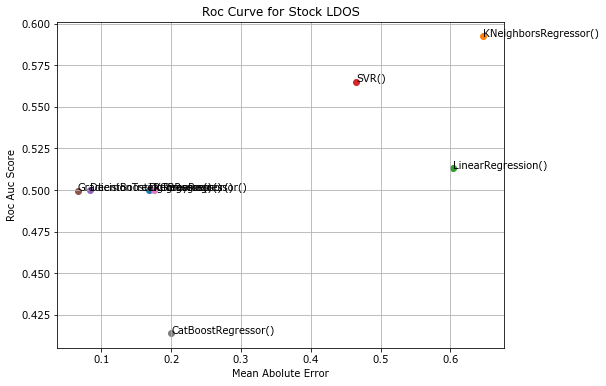

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 74.83it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'strategy': 'median'}
  Backtesting metric: 0.007416009943317526



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
  Backtesting metric: 0.0046863874865333615

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 24.46it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'copy_X': True, 'fit_intercept': True}
  Backtesting metric: 1.2167024231179607e-05

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'C': 10, 'coef0': 0.01, 'degree': 8, 'gamma': 'auto', 'kernel': 'poly'}
  Backtesting metric: 5.359531261469595e-06

Number of models compared: 1920.


loop param_grid:  30%|█████████▉                       | 116/384 [00:00<00:01, 158.53it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
  Backtesting metric: 0.000485234161854617

Number of models compared: 540.


loop param_grid:  80%|███████████████████████████▊       | 86/108 [00:06<00:01, 20.59it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:34<00:00,  6.93s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}
  Backtesting metric: 4.403971296651879e-10

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]


[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.33it/s]

[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.89it/s]

[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 12.56it/s]

[14:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.69it/s]

[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:05, 12.51it/s]

[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.69it/s]


[14:29:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:05, 11.52it/s]

[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 11.15it/s]

[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 11.04it/s]


[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.00it/s]

[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 10.34it/s]

[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05,  9.91it/s]


[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  42%|███████████████                     | 40/96 [00:03<00:06,  9.27it/s]

[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 11.04it/s]


[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.83it/s]

[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.27it/s]

[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.34it/s]


[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:04, 10.34it/s]


[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:04, 10.20it/s]

[14:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03,  9.92it/s]

[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.75it/s]

[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.29it/s]

[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:03, 10.09it/s]

[14:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02,  9.88it/s]


[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.66it/s]

[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.25it/s]


[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.23it/s]


[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:07<00:01, 10.44it/s]

[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.67it/s]


[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.55it/s]

[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.22it/s]

[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01,  9.62it/s]

[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:08<00:00,  8.87it/s]

[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00,  9.91it/s]

[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:08<00:00,  8.84it/s]

[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:08<00:00, 10.25it/s]


[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.32it/s]

[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.84it/s]


[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.21it/s]


[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 10.91it/s]


[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.83it/s]

[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.33it/s]

[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.40it/s]


[14:29:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:07, 10.16it/s]


[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07, 10.08it/s]


[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.39it/s]

[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 10.68it/s]

[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 10.87it/s]


[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:05, 10.74it/s]


[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.40it/s]


[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.60it/s]

[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.60it/s]

[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:05, 10.59it/s]


[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 11.06it/s]

[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.45it/s]

[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.22it/s]

[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:05<00:04, 10.24it/s]

[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  8.85it/s]

[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.91it/s]


[14:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.64it/s]

[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.70it/s]

[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.59it/s]

[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02,  9.89it/s]


[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.75it/s]

[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  9.15it/s]

[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.05it/s]

[14:29:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:07<00:01,  9.19it/s]

[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01,  9.88it/s]


[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.69it/s]

[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:08<00:00,  8.85it/s]

[14:29:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.78it/s]

[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00, 10.17it/s]

[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 11.94it/s]

[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.63it/s]

[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.27it/s]

[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:08, 10.57it/s]

[14:29:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:08,  9.58it/s]


[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  17%|██████                              | 16/96 [00:01<00:09,  8.66it/s]

[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07,  9.96it/s]

[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 20/96 [00:02<00:08,  8.70it/s]

[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████                           | 24/96 [00:02<00:08,  8.98it/s]

[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  29%|██████████▌                         | 28/96 [00:02<00:07,  9.26it/s]

[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:03<00:06, 10.33it/s]

[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████                        | 32/96 [00:03<00:06,  9.39it/s]

[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.59it/s]

[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.39it/s]

[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████                     | 40/96 [00:04<00:06,  9.03it/s]

[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  46%|████████████████▌                   | 44/96 [00:04<00:05,  9.00it/s]

[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.58it/s]

[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.23it/s]

[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:05<00:04, 10.03it/s]


[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  54%|███████████████████▌                | 52/96 [00:05<00:05,  8.74it/s]

[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  9.08it/s]

[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.06it/s]

[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:06<00:04,  8.54it/s]

[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:06<00:03,  9.64it/s]


[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.38it/s]

[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:03,  9.01it/s]


[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:07<00:03,  7.95it/s]

[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:07<00:02,  9.04it/s]


[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.05it/s]

[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.55it/s]

[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:08<00:01,  9.78it/s]

[14:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:08<00:01,  8.92it/s]

[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01,  9.72it/s]

[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.25it/s]

[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:09<00:00,  8.51it/s]

[14:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  94%|█████████████████████████████████▊  | 90/96 [00:09<00:00, 10.27it/s]

[14:30:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:30:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.16it/s]

[14:30:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:28<00:19,  9.78s/it]

[14:30:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 11.70it/s]

[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.41it/s]

[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:08, 10.67it/s]

[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:01<00:08, 10.49it/s]

[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.24it/s]

[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.37it/s]

[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.31it/s]


[14:30:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:02<00:07, 10.25it/s]


[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.33it/s]

[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 10.56it/s]

[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:06, 10.79it/s]

[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:06, 10.18it/s]

[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.23it/s]


[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.37it/s]


[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.59it/s]


[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.61it/s]


[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:05, 10.60it/s]


[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.50it/s]


[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.82it/s]

[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.57it/s]

[14:30:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:05<00:04, 10.15it/s]


[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:04, 10.08it/s]


[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.04it/s]

[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.53it/s]


[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.25it/s]

[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  9.03it/s]

[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02, 10.13it/s]


[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.69it/s]

[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  9.10it/s]

[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:02, 10.07it/s]

[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.76it/s]

[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.02it/s]


[14:30:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  85%|██████████████████████████████▊     | 82/96 [00:08<00:01, 10.65it/s]

[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.50it/s]

[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:08<00:00,  9.98it/s]

[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00,  9.97it/s]

[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:09<00:00,  9.83it/s]

[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00,  9.90it/s]

[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]


[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.24it/s]

[14:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:06, 12.97it/s]


[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 12.11it/s]

[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.51it/s]


[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.82it/s]

[14:30:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.81it/s]

[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:05, 12.28it/s]

[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:05, 12.92it/s]

[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.65it/s]


[14:30:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:04, 13.24it/s]

[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:02<00:04, 12.60it/s]

[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.88it/s]

[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:03, 12.86it/s]

[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 12.76it/s]

[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.63it/s]

[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 11.72it/s]

[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.72it/s]

[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:04<00:03, 11.35it/s]

[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.17it/s]

[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.45it/s]


[14:30:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:05<00:02, 11.43it/s]

[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:05<00:02, 11.52it/s]

[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:01, 11.50it/s]

[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.55it/s]

[14:30:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 12.02it/s]

[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:06<00:01, 11.98it/s]

[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:00, 11.26it/s]


[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.44it/s]

[14:30:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:07<00:00, 11.18it/s]

[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:07<00:00, 11.13it/s]

[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:46<00:00,  9.34s/it]


[14:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'colsample_bytree': 0.8, 'gamma': 0.7, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.6}
  Backtesting metric: 0.009754263359888994

Number of models compared: 60.


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.64it/s]

0:	learn: 0.2264259	total: 1.24ms	remaining: 36ms
1:	learn: 0.2186296	total: 1.94ms	remaining: 27.2ms
2:	learn: 0.2116182	total: 2.73ms	remaining: 24.6ms
3:	learn: 0.2042465	total: 3.58ms	remaining: 23.3ms
4:	learn: 0.1973648	total: 4.35ms	remaining: 21.7ms
5:	learn: 0.1905575	total: 5.47ms	remaining: 21.9ms
6:	learn: 0.1835941	total: 6.38ms	remaining: 20.9ms
7:	learn: 0.1770850	total: 7.16ms	remaining: 19.7ms
8:	learn: 0.1714954	total: 7.98ms	remaining: 18.6ms
9:	learn: 0.1663763	total: 8.67ms	remaining: 17.3ms
10:	learn: 0.1600343	total: 9.01ms	remaining: 15.6ms
11:	learn: 0.1542226	total: 9.44ms	remaining: 14.2ms
12:	learn: 0.1491528	total: 10.2ms	remaining: 13.3ms
13:	learn: 0.1446456	total: 11ms	remaining: 12.5ms
14:	learn: 0.1397341	total: 11.7ms	remaining: 11.7ms
15:	learn: 0.1356628	total: 12.4ms	remaining: 10.9ms
16:	learn: 0.1312293	total: 13.2ms	remaining: 10.1ms
17:	learn: 0.1267509	total: 13.6ms	remaining: 9.04ms
18:	learn: 0.1228164	total: 14.4ms	remaining: 8.33ms
19:	lea


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00, 10.22it/s]

19:	learn: 0.1190819	total: 14.1ms	remaining: 21.2ms
20:	learn: 0.1157022	total: 15ms	remaining: 20.7ms
21:	learn: 0.1122054	total: 16ms	remaining: 20.4ms
22:	learn: 0.1088814	total: 16.7ms	remaining: 19.6ms
23:	learn: 0.1056848	total: 17.5ms	remaining: 19ms
24:	learn: 0.1025783	total: 18.5ms	remaining: 18.5ms
25:	learn: 0.0996625	total: 19.4ms	remaining: 17.9ms
26:	learn: 0.0968648	total: 20.3ms	remaining: 17.3ms
27:	learn: 0.0942107	total: 21ms	remaining: 16.5ms
28:	learn: 0.0916407	total: 21.7ms	remaining: 15.7ms
29:	learn: 0.0891940	total: 22.4ms	remaining: 15ms
30:	learn: 0.0866831	total: 23.2ms	remaining: 14.2ms
31:	learn: 0.0847995	total: 23.9ms	remaining: 13.4ms
32:	learn: 0.0824818	total: 24.5ms	remaining: 12.6ms
33:	learn: 0.0803727	total: 25.2ms	remaining: 11.9ms
34:	learn: 0.0785366	total: 25.8ms	remaining: 11.1ms
35:	learn: 0.0767395	total: 26.5ms	remaining: 10.3ms
36:	learn: 0.0750517	total: 27.3ms	remaining: 9.58ms
37:	learn: 0.0732215	total: 27.9ms	remaining: 8.82ms
38:


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00, 10.11it/s]

1:	learn: 0.2196206	total: 3.8ms	remaining: 53.2ms
2:	learn: 0.2110429	total: 4.52ms	remaining: 40.7ms
3:	learn: 0.2039233	total: 6.27ms	remaining: 40.7ms
4:	learn: 0.1974053	total: 7.82ms	remaining: 39.1ms
5:	learn: 0.1910334	total: 9.31ms	remaining: 37.2ms
6:	learn: 0.1850115	total: 10.8ms	remaining: 35.6ms
7:	learn: 0.1792281	total: 12.7ms	remaining: 34.8ms
8:	learn: 0.1730000	total: 14.2ms	remaining: 33.1ms
9:	learn: 0.1670666	total: 14.9ms	remaining: 29.8ms
10:	learn: 0.1629353	total: 16.3ms	remaining: 28.1ms
11:	learn: 0.1581823	total: 17.7ms	remaining: 26.5ms
12:	learn: 0.1533210	total: 18.6ms	remaining: 24.4ms
13:	learn: 0.1487607	total: 20ms	remaining: 22.8ms
14:	learn: 0.1438819	total: 21.4ms	remaining: 21.4ms
15:	learn: 0.1393823	total: 22.9ms	remaining: 20ms
16:	learn: 0.1349768	total: 24.4ms	remaining: 18.6ms
17:	learn: 0.1310979	total: 26.2ms	remaining: 17.5ms
18:	learn: 0.1271704	total: 27.7ms	remaining: 16.1ms
19:	learn: 0.1232462	total: 29.1ms	remaining: 14.6ms
20:	lea


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:00<00:00,  8.74it/s]

24:	learn: 0.0594668	total: 38.6ms	remaining: 38.6ms
25:	learn: 0.0569441	total: 39.6ms	remaining: 36.6ms
26:	learn: 0.0550248	total: 41.5ms	remaining: 35.3ms
27:	learn: 0.0533635	total: 43.1ms	remaining: 33.9ms
28:	learn: 0.0518644	total: 44.6ms	remaining: 32.3ms
29:	learn: 0.0498918	total: 46.1ms	remaining: 30.7ms
30:	learn: 0.0485226	total: 47.6ms	remaining: 29.2ms
31:	learn: 0.0470668	total: 49ms	remaining: 27.6ms
32:	learn: 0.0459785	total: 50.6ms	remaining: 26.1ms
33:	learn: 0.0448771	total: 52.1ms	remaining: 24.5ms
34:	learn: 0.0435179	total: 53.5ms	remaining: 22.9ms
35:	learn: 0.0419814	total: 55.3ms	remaining: 21.5ms
36:	learn: 0.0407665	total: 56.7ms	remaining: 19.9ms
37:	learn: 0.0397779	total: 58ms	remaining: 18.3ms
38:	learn: 0.0388718	total: 59.5ms	remaining: 16.8ms
39:	learn: 0.0379268	total: 61ms	remaining: 15.2ms
40:	learn: 0.0369793	total: 62.5ms	remaining: 13.7ms
41:	learn: 0.0359894	total: 63.9ms	remaining: 12.2ms
42:	learn: 0.0351407	total: 65.3ms	remaining: 10.6ms


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  7.81it/s]

19:	learn: 0.1272899	total: 78.3ms	remaining: 39.2ms
20:	learn: 0.1240344	total: 81.1ms	remaining: 34.8ms
21:	learn: 0.1208128	total: 85.4ms	remaining: 31.1ms
22:	learn: 0.1166722	total: 85.9ms	remaining: 26.1ms
23:	learn: 0.1132074	total: 87.4ms	remaining: 21.9ms
24:	learn: 0.1099223	total: 87.8ms	remaining: 17.6ms
25:	learn: 0.1071653	total: 92.1ms	remaining: 14.2ms
26:	learn: 0.1041486	total: 94.4ms	remaining: 10.5ms
27:	learn: 0.1013251	total: 98.8ms	remaining: 7.06ms
28:	learn: 0.0983496	total: 99.4ms	remaining: 3.43ms
29:	learn: 0.0960421	total: 104ms	remaining: 0us
0:	learn: 0.2200240	total: 4.93ms	remaining: 143ms
1:	learn: 0.2034079	total: 5.57ms	remaining: 77.9ms
2:	learn: 0.1919638	total: 10.5ms	remaining: 94.1ms
3:	learn: 0.1807289	total: 16.2ms	remaining: 105ms
4:	learn: 0.1700421	total: 21.3ms	remaining: 106ms
5:	learn: 0.1594439	total: 26.4ms	remaining: 106ms
6:	learn: 0.1483899	total: 26.8ms	remaining: 88.1ms
7:	learn: 0.1401461	total: 29.6ms	remaining: 81.4ms
8:	learn:


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  6.82it/s]

20:	learn: 0.0708972	total: 86ms	remaining: 36.9ms
21:	learn: 0.0675207	total: 87.2ms	remaining: 31.7ms
22:	learn: 0.0645456	total: 89.5ms	remaining: 27.2ms
23:	learn: 0.0617617	total: 94.7ms	remaining: 23.7ms
24:	learn: 0.0593819	total: 101ms	remaining: 20.2ms
25:	learn: 0.0568565	total: 106ms	remaining: 16.4ms
26:	learn: 0.0546689	total: 111ms	remaining: 12.3ms
27:	learn: 0.0527461	total: 115ms	remaining: 8.24ms
28:	learn: 0.0510226	total: 120ms	remaining: 4.13ms
29:	learn: 0.0492975	total: 126ms	remaining: 0us
0:	learn: 0.2274137	total: 5.83ms	remaining: 286ms
1:	learn: 0.2187722	total: 6.36ms	remaining: 153ms
2:	learn: 0.2125435	total: 11.6ms	remaining: 182ms
3:	learn: 0.2062489	total: 17.1ms	remaining: 197ms
4:	learn: 0.2000317	total: 23.8ms	remaining: 215ms
5:	learn: 0.1936386	total: 28.9ms	remaining: 212ms
6:	learn: 0.1866598	total: 29.2ms	remaining: 179ms
7:	learn: 0.1811800	total: 31.7ms	remaining: 166ms
8:	learn: 0.1757244	total: 36.8ms	remaining: 168ms
9:	learn: 0.1697017	to


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  5.49it/s]

18:	learn: 0.1306368	total: 72.4ms	remaining: 118ms
19:	learn: 0.1272899	total: 76.7ms	remaining: 115ms
20:	learn: 0.1240344	total: 79ms	remaining: 109ms
21:	learn: 0.1208128	total: 83.3ms	remaining: 106ms
22:	learn: 0.1166722	total: 83.7ms	remaining: 98.2ms
23:	learn: 0.1132074	total: 85.2ms	remaining: 92.3ms
24:	learn: 0.1099223	total: 85.5ms	remaining: 85.5ms
25:	learn: 0.1071653	total: 89.9ms	remaining: 83ms
26:	learn: 0.1041486	total: 92.3ms	remaining: 78.7ms
27:	learn: 0.1013251	total: 96.4ms	remaining: 75.8ms
28:	learn: 0.0983496	total: 97ms	remaining: 70.3ms
29:	learn: 0.0960421	total: 102ms	remaining: 67.9ms
30:	learn: 0.0936141	total: 107ms	remaining: 65.7ms
31:	learn: 0.0914840	total: 112ms	remaining: 62.9ms
32:	learn: 0.0892992	total: 116ms	remaining: 59.9ms
33:	learn: 0.0872025	total: 120ms	remaining: 56.7ms
34:	learn: 0.0849929	total: 125ms	remaining: 53.8ms
35:	learn: 0.0832139	total: 131ms	remaining: 50.8ms
36:	learn: 0.0811537	total: 135ms	remaining: 47.6ms
37:	learn: 


loop lags_grid:  20%|███████▊                               | 1/5 [00:01<00:07,  1.85s/it]

38:	learn: 0.0369948	total: 162ms	remaining: 45.6ms
39:	learn: 0.0361265	total: 167ms	remaining: 41.8ms
40:	learn: 0.0351365	total: 173ms	remaining: 38ms
41:	learn: 0.0343735	total: 174ms	remaining: 33.1ms
42:	learn: 0.0333418	total: 178ms	remaining: 28.9ms
43:	learn: 0.0325475	total: 183ms	remaining: 24.9ms
44:	learn: 0.0317687	total: 188ms	remaining: 20.9ms
45:	learn: 0.0308627	total: 193ms	remaining: 16.8ms
46:	learn: 0.0300220	total: 199ms	remaining: 12.7ms
47:	learn: 0.0292751	total: 204ms	remaining: 8.52ms
48:	learn: 0.0285276	total: 210ms	remaining: 4.29ms
49:	learn: 0.0276474	total: 217ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2113065	total: 1.36ms	remaining: 39.5ms
1:	learn: 0.2041013	total: 2.93ms	remaining: 41.1ms
2:	learn: 0.1981016	total: 5.26ms	remaining: 47.3ms
3:	learn: 0.1912092	total: 6.51ms	remaining: 42.3ms
4:	learn: 0.1848182	total: 8.91ms	remaining: 44.5ms
5:	learn: 0.1785235	total: 10.3ms	remaining: 41.3ms
6:	learn: 0.1728609	total: 11.7ms	remaining: 38.4ms
7:	learn: 0.1672373	total: 12.9ms	remaining: 35.5ms
8:	learn: 0.1620273	total: 14.4ms	remaining: 33.5ms
9:	learn: 0.1565712	total: 15.6ms	remaining: 31.1ms
10:	learn: 0.1509638	total: 16.6ms	remaining: 28.7ms
11:	learn: 0.1464875	total: 17.7ms	remaining: 26.6ms
12:	learn: 0.1418206	total: 18.9ms	remaining: 24.7ms
13:	learn: 0.1378183	total: 20.1ms	remaining: 23ms
14:	learn: 0.1336820	total: 21.3ms	remaining: 21.3ms
15:	learn: 0.1297523	total: 22.5ms	remaining: 19.7ms
16:	learn: 0.1262673	total: 24.1ms	remaining: 18.4ms
17:	learn: 0.1224534	total: 25.2ms	remaining: 16.8ms
18:	learn: 0.1187543	total: 26.5ms	remaining: 15.3ms
19:	l


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  7.37it/s]

23:	learn: 0.1020843	total: 34.9ms	remaining: 8.71ms
24:	learn: 0.0992297	total: 36.3ms	remaining: 7.25ms
25:	learn: 0.0964963	total: 38ms	remaining: 5.84ms
26:	learn: 0.0938783	total: 39.1ms	remaining: 4.34ms
27:	learn: 0.0917138	total: 40.4ms	remaining: 2.88ms
28:	learn: 0.0892555	total: 44.2ms	remaining: 1.52ms
29:	learn: 0.0872754	total: 45.9ms	remaining: 0us
0:	learn: 0.2041796	total: 1.82ms	remaining: 52.8ms
1:	learn: 0.1903597	total: 2.93ms	remaining: 41ms
2:	learn: 0.1793390	total: 4.66ms	remaining: 41.9ms
3:	learn: 0.1670734	total: 5.95ms	remaining: 38.6ms
4:	learn: 0.1562400	total: 7.44ms	remaining: 37.2ms
5:	learn: 0.1459183	total: 8.67ms	remaining: 34.7ms
6:	learn: 0.1370719	total: 9.61ms	remaining: 31.6ms
7:	learn: 0.1286208	total: 10.9ms	remaining: 29.9ms
8:	learn: 0.1210279	total: 12.7ms	remaining: 29.7ms
9:	learn: 0.1143981	total: 14.1ms	remaining: 28.2ms
10:	learn: 0.1071976	total: 14.8ms	remaining: 25.6ms
11:	learn: 0.1016253	total: 16.4ms	remaining: 24.7ms
12:	learn:


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  7.40it/s]

13:	learn: 0.0913467	total: 20ms	remaining: 22.8ms
14:	learn: 0.0869296	total: 21.6ms	remaining: 21.6ms
15:	learn: 0.0828540	total: 23.1ms	remaining: 20.2ms
16:	learn: 0.0793057	total: 24.3ms	remaining: 18.6ms
17:	learn: 0.0757755	total: 25.6ms	remaining: 17.1ms
18:	learn: 0.0724816	total: 27ms	remaining: 15.6ms
19:	learn: 0.0694318	total: 28ms	remaining: 14ms
20:	learn: 0.0667129	total: 29.5ms	remaining: 12.7ms
21:	learn: 0.0642803	total: 31.3ms	remaining: 11.4ms
22:	learn: 0.0617443	total: 32.7ms	remaining: 9.96ms
23:	learn: 0.0594546	total: 34.2ms	remaining: 8.55ms
24:	learn: 0.0576478	total: 35.5ms	remaining: 7.1ms
25:	learn: 0.0560153	total: 37.3ms	remaining: 5.74ms
26:	learn: 0.0547075	total: 38.8ms	remaining: 4.31ms
27:	learn: 0.0534613	total: 40.8ms	remaining: 2.92ms
28:	learn: 0.0517465	total: 42.7ms	remaining: 1.47ms
29:	learn: 0.0501529	total: 44ms	remaining: 0us
0:	learn: 0.2113065	total: 1.44ms	remaining: 70.6ms
1:	learn: 0.2041013	total: 2.99ms	remaining: 71.9ms
2:	learn:


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  6.99it/s]

46:	learn: 0.0606422	total: 51.1ms	remaining: 3.26ms
47:	learn: 0.0595563	total: 52ms	remaining: 2.17ms
48:	learn: 0.0582176	total: 52.9ms	remaining: 1.08ms
49:	learn: 0.0571197	total: 53.8ms	remaining: 0us
0:	learn: 0.2041796	total: 1.56ms	remaining: 76.5ms
1:	learn: 0.1903597	total: 2.64ms	remaining: 63.3ms
2:	learn: 0.1793390	total: 3.72ms	remaining: 58.2ms
3:	learn: 0.1670734	total: 4.78ms	remaining: 55ms
4:	learn: 0.1562400	total: 5.7ms	remaining: 51.3ms
5:	learn: 0.1459183	total: 6.59ms	remaining: 48.3ms
6:	learn: 0.1370719	total: 7.5ms	remaining: 46.1ms
7:	learn: 0.1286208	total: 8.38ms	remaining: 44ms
8:	learn: 0.1210279	total: 9.33ms	remaining: 42.5ms
9:	learn: 0.1143981	total: 10.4ms	remaining: 41.6ms
10:	learn: 0.1071976	total: 11ms	remaining: 39ms
11:	learn: 0.1016253	total: 12.2ms	remaining: 38.7ms
12:	learn: 0.0958333	total: 13.3ms	remaining: 37.9ms
13:	learn: 0.0913467	total: 15.4ms	remaining: 39.6ms
14:	learn: 0.0869296	total: 16.4ms	remaining: 38.2ms
15:	learn: 0.08285


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  7.04it/s]

17:	learn: 0.0757755	total: 21ms	remaining: 37.3ms
18:	learn: 0.0724816	total: 21.9ms	remaining: 35.8ms
19:	learn: 0.0694318	total: 22.5ms	remaining: 33.8ms
20:	learn: 0.0667129	total: 23.5ms	remaining: 32.4ms
21:	learn: 0.0642803	total: 24.4ms	remaining: 31.1ms
22:	learn: 0.0617443	total: 25.6ms	remaining: 30ms
23:	learn: 0.0594546	total: 26.7ms	remaining: 28.9ms
24:	learn: 0.0576478	total: 27.9ms	remaining: 27.9ms
25:	learn: 0.0560153	total: 29.1ms	remaining: 26.9ms
26:	learn: 0.0547075	total: 30ms	remaining: 25.6ms
27:	learn: 0.0534613	total: 31ms	remaining: 24.4ms
28:	learn: 0.0517465	total: 31.9ms	remaining: 23.1ms
29:	learn: 0.0501529	total: 32.8ms	remaining: 21.9ms
30:	learn: 0.0490920	total: 33.9ms	remaining: 20.8ms
31:	learn: 0.0478261	total: 34.8ms	remaining: 19.6ms
32:	learn: 0.0464873	total: 35.7ms	remaining: 18.4ms
33:	learn: 0.0456117	total: 36.6ms	remaining: 17.2ms
34:	learn: 0.0444495	total: 37.5ms	remaining: 16.1ms
35:	learn: 0.0435517	total: 38.4ms	remaining: 14.9ms
3


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  7.10it/s]

29:	learn: 0.0894398	total: 66.5ms	remaining: 0us
0:	learn: 0.2052177	total: 2.96ms	remaining: 85.9ms
1:	learn: 0.1896070	total: 3.42ms	remaining: 47.8ms
2:	learn: 0.1795007	total: 5.49ms	remaining: 49.4ms
3:	learn: 0.1678300	total: 7.49ms	remaining: 48.7ms
4:	learn: 0.1578487	total: 9.66ms	remaining: 48.3ms
5:	learn: 0.1482994	total: 11.8ms	remaining: 47.1ms
6:	learn: 0.1397857	total: 14.2ms	remaining: 46.7ms
7:	learn: 0.1309822	total: 16.7ms	remaining: 46ms
8:	learn: 0.1242231	total: 18.7ms	remaining: 43.7ms
9:	learn: 0.1157513	total: 20.5ms	remaining: 41ms
10:	learn: 0.1098349	total: 22.5ms	remaining: 38.8ms
11:	learn: 0.1044772	total: 24.9ms	remaining: 37.3ms
12:	learn: 0.0989905	total: 26.7ms	remaining: 34.9ms



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.16it/s]

13:	learn: 0.0938495	total: 29.1ms	remaining: 33.2ms
14:	learn: 0.0895132	total: 31.3ms	remaining: 31.3ms
15:	learn: 0.0848090	total: 33.1ms	remaining: 29ms
16:	learn: 0.0806496	total: 35ms	remaining: 26.8ms
17:	learn: 0.0766240	total: 36.9ms	remaining: 24.6ms
18:	learn: 0.0728484	total: 38.5ms	remaining: 22.3ms
19:	learn: 0.0697860	total: 40.6ms	remaining: 20.3ms
20:	learn: 0.0670508	total: 42.7ms	remaining: 18.3ms
21:	learn: 0.0642839	total: 44.6ms	remaining: 16.2ms
22:	learn: 0.0617467	total: 47ms	remaining: 14.3ms
23:	learn: 0.0591520	total: 49.3ms	remaining: 12.3ms
24:	learn: 0.0571042	total: 51.6ms	remaining: 10.3ms
25:	learn: 0.0551191	total: 53.8ms	remaining: 8.27ms
26:	learn: 0.0532607	total: 55.9ms	remaining: 6.21ms
27:	learn: 0.0511256	total: 56.8ms	remaining: 4.05ms
28:	learn: 0.0492463	total: 59.1ms	remaining: 2.04ms
29:	learn: 0.0473622	total: 60.9ms	remaining: 0us
0:	learn: 0.2118271	total: 3.59ms	remaining: 176ms
1:	learn: 0.2037110	total: 4.33ms	remaining: 104ms
2:	lea


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.23it/s]

26:	learn: 0.0968632	total: 62.6ms	remaining: 53.3ms
27:	learn: 0.0944198	total: 64.5ms	remaining: 50.6ms
28:	learn: 0.0915439	total: 65.1ms	remaining: 47.2ms
29:	learn: 0.0894398	total: 67.4ms	remaining: 45ms
30:	learn: 0.0871636	total: 69.4ms	remaining: 42.5ms
31:	learn: 0.0849483	total: 71.9ms	remaining: 40.4ms
32:	learn: 0.0831262	total: 73.8ms	remaining: 38ms
33:	learn: 0.0805755	total: 74.5ms	remaining: 35.1ms
34:	learn: 0.0785256	total: 76.4ms	remaining: 32.7ms
35:	learn: 0.0766509	total: 78.8ms	remaining: 30.6ms
36:	learn: 0.0748532	total: 80.6ms	remaining: 28.3ms
37:	learn: 0.0730305	total: 82.9ms	remaining: 26.2ms
38:	learn: 0.0712171	total: 84.7ms	remaining: 23.9ms
39:	learn: 0.0696734	total: 86.8ms	remaining: 21.7ms
40:	learn: 0.0679806	total: 88.5ms	remaining: 19.4ms
41:	learn: 0.0664236	total: 91ms	remaining: 17.3ms
42:	learn: 0.0651344	total: 93.2ms	remaining: 15.2ms
43:	learn: 0.0637765	total: 95.4ms	remaining: 13ms
44:	learn: 0.0625277	total: 96.3ms	remaining: 10.7ms
4


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.05it/s]

31:	learn: 0.0446099	total: 58.5ms	remaining: 32.9ms
32:	learn: 0.0432999	total: 61.2ms	remaining: 31.6ms
33:	learn: 0.0419836	total: 63.3ms	remaining: 29.8ms
34:	learn: 0.0405976	total: 65.2ms	remaining: 27.9ms
35:	learn: 0.0394699	total: 67.1ms	remaining: 26.1ms
36:	learn: 0.0382333	total: 69ms	remaining: 24.2ms
37:	learn: 0.0371458	total: 71ms	remaining: 22.4ms
38:	learn: 0.0361948	total: 72.9ms	remaining: 20.6ms
39:	learn: 0.0350285	total: 74.8ms	remaining: 18.7ms
40:	learn: 0.0340051	total: 76.7ms	remaining: 16.8ms
41:	learn: 0.0333698	total: 78.8ms	remaining: 15ms
42:	learn: 0.0325510	total: 80.8ms	remaining: 13.2ms
43:	learn: 0.0317109	total: 83ms	remaining: 11.3ms
44:	learn: 0.0308568	total: 84.8ms	remaining: 9.42ms
45:	learn: 0.0300433	total: 86.9ms	remaining: 7.56ms
46:	learn: 0.0293361	total: 88.8ms	remaining: 5.67ms
47:	learn: 0.0286135	total: 90.7ms	remaining: 3.78ms
48:	learn: 0.0278954	total: 92.9ms	remaining: 1.9ms
49:	learn: 0.0272700	total: 94.8ms	remaining: 0us
0:	le


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.76it/s]

18:	learn: 0.1252397	total: 79.3ms	remaining: 45.9ms
19:	learn: 0.1215839	total: 81.8ms	remaining: 40.9ms
20:	learn: 0.1178136	total: 82.3ms	remaining: 35.3ms
21:	learn: 0.1144063	total: 87.2ms	remaining: 31.7ms
22:	learn: 0.1119222	total: 93.1ms	remaining: 28.3ms
23:	learn: 0.1083770	total: 93.6ms	remaining: 23.4ms
24:	learn: 0.1056152	total: 99.1ms	remaining: 19.8ms
25:	learn: 0.1028764	total: 104ms	remaining: 16ms
26:	learn: 0.1008550	total: 109ms	remaining: 12.1ms
27:	learn: 0.0983149	total: 112ms	remaining: 8ms
28:	learn: 0.0958381	total: 117ms	remaining: 4.04ms
29:	learn: 0.0935319	total: 122ms	remaining: 0us
0:	learn: 0.2069254	total: 5.47ms	remaining: 159ms
1:	learn: 0.1910158	total: 5.92ms	remaining: 82.9ms
2:	learn: 0.1799747	total: 12.3ms	remaining: 111ms
3:	learn: 0.1707663	total: 18.5ms	remaining: 120ms
4:	learn: 0.1606857	total: 23.6ms	remaining: 118ms
5:	learn: 0.1513409	total: 29ms	remaining: 116ms
6:	learn: 0.1433766	total: 32ms	remaining: 105ms
7:	learn: 0.1353201	tot


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.44it/s]

18:	learn: 0.0752838	total: 83.6ms	remaining: 48.4ms
19:	learn: 0.0721287	total: 91.1ms	remaining: 45.5ms
20:	learn: 0.0688120	total: 97ms	remaining: 41.6ms
21:	learn: 0.0663327	total: 103ms	remaining: 37.4ms
22:	learn: 0.0637976	total: 109ms	remaining: 33.1ms
23:	learn: 0.0609155	total: 112ms	remaining: 28.1ms
24:	learn: 0.0586818	total: 119ms	remaining: 23.8ms
25:	learn: 0.0565429	total: 124ms	remaining: 19.1ms
26:	learn: 0.0547794	total: 129ms	remaining: 14.4ms
27:	learn: 0.0528882	total: 136ms	remaining: 9.68ms
28:	learn: 0.0508721	total: 141ms	remaining: 4.88ms
29:	learn: 0.0491014	total: 142ms	remaining: 0us
0:	learn: 0.2126856	total: 5.86ms	remaining: 287ms
1:	learn: 0.2044604	total: 6.4ms	remaining: 154ms
2:	learn: 0.1985130	total: 12.6ms	remaining: 197ms
3:	learn: 0.1933594	total: 18.8ms	remaining: 217ms
4:	learn: 0.1875482	total: 25.2ms	remaining: 227ms
5:	learn: 0.1819233	total: 31.8ms	remaining: 233ms
6:	learn: 0.1770016	total: 35.1ms	remaining: 216ms
7:	learn: 0.1717853	to


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.37it/s]

0:	learn: 0.2069254	total: 5.52ms	remaining: 270ms
1:	learn: 0.1910158	total: 6.06ms	remaining: 145ms
2:	learn: 0.1799747	total: 11.7ms	remaining: 184ms
3:	learn: 0.1707663	total: 17.5ms	remaining: 201ms
4:	learn: 0.1606857	total: 22.8ms	remaining: 205ms
5:	learn: 0.1513409	total: 28.2ms	remaining: 207ms
6:	learn: 0.1433766	total: 31.3ms	remaining: 192ms
7:	learn: 0.1353201	total: 38.5ms	remaining: 202ms
8:	learn: 0.1259778	total: 39.3ms	remaining: 179ms
9:	learn: 0.1199058	total: 44.4ms	remaining: 177ms
10:	learn: 0.1138209	total: 49.7ms	remaining: 176ms
11:	learn: 0.1066610	total: 50.3ms	remaining: 159ms
12:	learn: 0.1007601	total: 55.6ms	remaining: 158ms
13:	learn: 0.0959235	total: 61.8ms	remaining: 159ms
14:	learn: 0.0904485	total: 64.2ms	remaining: 150ms
15:	learn: 0.0853345	total: 66ms	remaining: 140ms
16:	learn: 0.0816015	total: 72.7ms	remaining: 141ms
17:	learn: 0.0780899	total: 79.3ms	remaining: 141ms
18:	learn: 0.0752838	total: 86ms	remaining: 140ms
19:	learn: 0.0721287	total


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1653608	total: 2.42ms	remaining: 70.3ms



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  8.57it/s]


1:	learn: 0.1603638	total: 3.93ms	remaining: 55ms
2:	learn: 0.1559282	total: 5.29ms	remaining: 47.6ms
3:	learn: 0.1511212	total: 6.71ms	remaining: 43.6ms
4:	learn: 0.1472053	total: 8.01ms	remaining: 40ms
5:	learn: 0.1425605	total: 8.53ms	remaining: 34.1ms
6:	learn: 0.1387366	total: 9.53ms	remaining: 31.3ms
7:	learn: 0.1346173	total: 10.8ms	remaining: 29.8ms
8:	learn: 0.1308241	total: 11.6ms	remaining: 27.2ms
9:	learn: 0.1268981	total: 12.8ms	remaining: 25.6ms
10:	learn: 0.1229704	total: 14.2ms	remaining: 24.6ms
11:	learn: 0.1197245	total: 15.4ms	remaining: 23ms
12:	learn: 0.1166387	total: 16.5ms	remaining: 21.6ms
13:	learn: 0.1135343	total: 17.8ms	remaining: 20.3ms
14:	learn: 0.1104253	total: 18.9ms	remaining: 18.9ms
15:	learn: 0.1076735	total: 20ms	remaining: 17.5ms
16:	learn: 0.1050705	total: 21.4ms	remaining: 16.3ms
17:	learn: 0.1019442	total: 22.7ms	remaining: 15.1ms
18:	learn: 0.0996573	total: 23.8ms	remaining: 13.8ms
19:	learn: 0.0970990	total: 25ms	remaining: 12.5ms
20:	learn: 0

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  7.81it/s]

0:	learn: 0.1653608	total: 1.32ms	remaining: 64.8ms
1:	learn: 0.1603638	total: 3.11ms	remaining: 74.7ms
2:	learn: 0.1559282	total: 4.67ms	remaining: 73.2ms
3:	learn: 0.1511212	total: 6.09ms	remaining: 70.1ms
4:	learn: 0.1472053	total: 7.29ms	remaining: 65.6ms
5:	learn: 0.1425605	total: 7.77ms	remaining: 57ms
6:	learn: 0.1387366	total: 8.95ms	remaining: 55ms
7:	learn: 0.1346173	total: 10.1ms	remaining: 52.9ms
8:	learn: 0.1308241	total: 10.9ms	remaining: 49.5ms
9:	learn: 0.1268981	total: 12.3ms	remaining: 49.1ms
10:	learn: 0.1229704	total: 13.7ms	remaining: 48.4ms
11:	learn: 0.1197245	total: 14.7ms	remaining: 46.4ms
12:	learn: 0.1166387	total: 15.8ms	remaining: 44.9ms
13:	learn: 0.1135343	total: 16.9ms	remaining: 43.4ms
14:	learn: 0.1104253	total: 17.9ms	remaining: 41.8ms
15:	learn: 0.1076735	total: 19ms	remaining: 40.4ms
16:	learn: 0.1050705	total: 20.1ms	remaining: 39ms
17:	learn: 0.1019442	total: 21.1ms	remaining: 37.5ms
18:	learn: 0.0996573	total: 22.3ms	remaining: 36.4ms
19:	learn: 


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  7.47it/s]

23:	learn: 0.0550346	total: 26.5ms	remaining: 28.7ms
24:	learn: 0.0536415	total: 28.2ms	remaining: 28.2ms
25:	learn: 0.0519317	total: 29.6ms	remaining: 27.4ms
26:	learn: 0.0507717	total: 30.4ms	remaining: 25.9ms
27:	learn: 0.0492987	total: 31.7ms	remaining: 24.9ms
28:	learn: 0.0478946	total: 32.7ms	remaining: 23.7ms
29:	learn: 0.0466834	total: 33.9ms	remaining: 22.6ms
30:	learn: 0.0456609	total: 35ms	remaining: 21.5ms
31:	learn: 0.0445246	total: 36.2ms	remaining: 20.4ms
32:	learn: 0.0435563	total: 36.9ms	remaining: 19ms
33:	learn: 0.0417849	total: 38ms	remaining: 17.9ms
34:	learn: 0.0407298	total: 39.1ms	remaining: 16.8ms
35:	learn: 0.0397900	total: 40.1ms	remaining: 15.6ms
36:	learn: 0.0387376	total: 41.2ms	remaining: 14.5ms
37:	learn: 0.0380687	total: 42.2ms	remaining: 13.3ms
38:	learn: 0.0373880	total: 43.2ms	remaining: 12.2ms
39:	learn: 0.0364044	total: 44.3ms	remaining: 11.1ms
40:	learn: 0.0355853	total: 45.6ms	remaining: 10ms
41:	learn: 0.0352274	total: 46.8ms	remaining: 8.91ms
4


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.05it/s]

28:	learn: 0.0827385	total: 64ms	remaining: 2.21ms
29:	learn: 0.0807436	total: 66.3ms	remaining: 0us
0:	learn: 0.1612444	total: 2.99ms	remaining: 86.8ms
1:	learn: 0.1518950	total: 5.28ms	remaining: 74ms
2:	learn: 0.1446919	total: 8.03ms	remaining: 72.3ms
3:	learn: 0.1370910	total: 10.4ms	remaining: 67.9ms
4:	learn: 0.1303868	total: 13.3ms	remaining: 66.7ms
5:	learn: 0.1246460	total: 16ms	remaining: 64.1ms
6:	learn: 0.1188937	total: 18.5ms	remaining: 60.9ms
7:	learn: 0.1125104	total: 20.7ms	remaining: 56.9ms
8:	learn: 0.1070679	total: 22.9ms	remaining: 53.4ms
9:	learn: 0.1023006	total: 25.5ms	remaining: 51ms
10:	learn: 0.0977064	total: 28.5ms	remaining: 49.2ms
11:	learn: 0.0932243	total: 31.1ms	remaining: 46.6ms
12:	learn: 0.0887719	total: 33.5ms	remaining: 43.8ms
13:	learn: 0.0856116	total: 35.6ms	remaining: 40.7ms
14:	learn: 0.0821803	total: 38.2ms	remaining: 38.2ms
15:	learn: 0.0782414	total: 39.7ms	remaining: 34.8ms
16:	learn: 0.0753180	total: 40.7ms	remaining: 31.1ms
17:	learn: 0.0


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.16it/s]

1:	learn: 0.1608797	total: 6.7ms	remaining: 161ms
2:	learn: 0.1569968	total: 10ms	remaining: 157ms
3:	learn: 0.1527864	total: 12.9ms	remaining: 148ms
4:	learn: 0.1489695	total: 15.2ms	remaining: 137ms
5:	learn: 0.1455429	total: 17.8ms	remaining: 131ms
6:	learn: 0.1420858	total: 20.2ms	remaining: 124ms
7:	learn: 0.1381395	total: 22.7ms	remaining: 119ms
8:	learn: 0.1346405	total: 25.1ms	remaining: 114ms
9:	learn: 0.1314120	total: 27.5ms	remaining: 110ms
10:	learn: 0.1284888	total: 30.4ms	remaining: 108ms
11:	learn: 0.1253056	total: 32.8ms	remaining: 104ms
12:	learn: 0.1215929	total: 33.8ms	remaining: 96.2ms
13:	learn: 0.1192272	total: 36.2ms	remaining: 93.1ms
14:	learn: 0.1159590	total: 38.3ms	remaining: 89.4ms
15:	learn: 0.1135076	total: 39.4ms	remaining: 83.7ms
16:	learn: 0.1111170	total: 42.5ms	remaining: 82.6ms
17:	learn: 0.1083146	total: 43.5ms	remaining: 77.4ms
18:	learn: 0.1055712	total: 46.8ms	remaining: 76.4ms
19:	learn: 0.1027842	total: 49.3ms	remaining: 73.9ms
20:	learn: 0.100


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.55it/s]

1:	learn: 0.1518950	total: 5.82ms	remaining: 140ms
2:	learn: 0.1446919	total: 8.15ms	remaining: 128ms
3:	learn: 0.1370910	total: 10.6ms	remaining: 122ms
4:	learn: 0.1303868	total: 13.9ms	remaining: 125ms
5:	learn: 0.1246460	total: 16.3ms	remaining: 120ms
6:	learn: 0.1188937	total: 19.3ms	remaining: 119ms
7:	learn: 0.1125104	total: 23ms	remaining: 121ms
8:	learn: 0.1070679	total: 25.7ms	remaining: 117ms
9:	learn: 0.1023006	total: 27.9ms	remaining: 112ms
10:	learn: 0.0977064	total: 30.3ms	remaining: 107ms
11:	learn: 0.0932243	total: 33.4ms	remaining: 106ms
12:	learn: 0.0887719	total: 36.6ms	remaining: 104ms
13:	learn: 0.0856116	total: 39.2ms	remaining: 101ms
14:	learn: 0.0821803	total: 41.5ms	remaining: 96.9ms
15:	learn: 0.0782414	total: 43.1ms	remaining: 91.5ms
16:	learn: 0.0753180	total: 44.3ms	remaining: 85.9ms
17:	learn: 0.0717647	total: 46.6ms	remaining: 82.9ms
18:	learn: 0.0684894	total: 49.1ms	remaining: 80.1ms
19:	learn: 0.0659968	total: 51.8ms	remaining: 77.7ms
20:	learn: 0.0637


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.17it/s]

1:	learn: 0.1610835	total: 7.9ms	remaining: 111ms
2:	learn: 0.1577764	total: 14.7ms	remaining: 132ms
3:	learn: 0.1535540	total: 20.5ms	remaining: 133ms
4:	learn: 0.1500203	total: 27.5ms	remaining: 138ms
5:	learn: 0.1461504	total: 29ms	remaining: 116ms
6:	learn: 0.1417213	total: 30.4ms	remaining: 99.8ms
7:	learn: 0.1392292	total: 36.8ms	remaining: 101ms
8:	learn: 0.1362343	total: 44.1ms	remaining: 103ms
9:	learn: 0.1331906	total: 46.7ms	remaining: 93.5ms
10:	learn: 0.1289748	total: 47.1ms	remaining: 81.3ms
11:	learn: 0.1259644	total: 49.3ms	remaining: 74ms
12:	learn: 0.1227111	total: 51ms	remaining: 66.6ms
13:	learn: 0.1199741	total: 57ms	remaining: 65.2ms
14:	learn: 0.1175389	total: 63.8ms	remaining: 63.8ms
15:	learn: 0.1143199	total: 64.5ms	remaining: 56.5ms
16:	learn: 0.1118191	total: 73.3ms	remaining: 56.1ms
17:	learn: 0.1089276	total: 77ms	remaining: 51.4ms
18:	learn: 0.1060226	total: 78.4ms	remaining: 45.4ms
19:	learn: 0.1035850	total: 84.6ms	remaining: 42.3ms
20:	learn: 0.1008149


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.32it/s]

25:	learn: 0.0534876	total: 182ms	remaining: 28ms
26:	learn: 0.0514258	total: 192ms	remaining: 21.4ms
27:	learn: 0.0496571	total: 202ms	remaining: 14.5ms
28:	learn: 0.0482876	total: 203ms	remaining: 7.02ms
29:	learn: 0.0466982	total: 214ms	remaining: 0us
0:	learn: 0.1659797	total: 9.26ms	remaining: 454ms
1:	learn: 0.1610835	total: 10.4ms	remaining: 250ms
2:	learn: 0.1577764	total: 17.2ms	remaining: 269ms
3:	learn: 0.1535540	total: 25ms	remaining: 288ms
4:	learn: 0.1500203	total: 30.7ms	remaining: 277ms
5:	learn: 0.1461504	total: 32.4ms	remaining: 238ms
6:	learn: 0.1417213	total: 34ms	remaining: 209ms
7:	learn: 0.1392292	total: 40.2ms	remaining: 211ms
8:	learn: 0.1362343	total: 47.7ms	remaining: 217ms
9:	learn: 0.1331906	total: 49.9ms	remaining: 200ms
10:	learn: 0.1289748	total: 50.3ms	remaining: 178ms
11:	learn: 0.1259644	total: 52.4ms	remaining: 166ms
12:	learn: 0.1227111	total: 53.8ms	remaining: 153ms
13:	learn: 0.1199741	total: 59.6ms	remaining: 153ms
14:	learn: 0.1175389	total: 65.


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.69it/s]

47:	learn: 0.0569791	total: 240ms	remaining: 9.99ms
48:	learn: 0.0560554	total: 246ms	remaining: 5.02ms
49:	learn: 0.0550348	total: 253ms	remaining: 0us
0:	learn: 0.1617312	total: 7.63ms	remaining: 374ms
1:	learn: 0.1522611	total: 8.75ms	remaining: 210ms
2:	learn: 0.1452226	total: 16.1ms	remaining: 253ms
3:	learn: 0.1382012	total: 22.9ms	remaining: 264ms
4:	learn: 0.1319127	total: 29.5ms	remaining: 265ms
5:	learn: 0.1253046	total: 31.4ms	remaining: 231ms
6:	learn: 0.1179615	total: 33.2ms	remaining: 204ms
7:	learn: 0.1140149	total: 39.1ms	remaining: 205ms
8:	learn: 0.1093198	total: 45ms	remaining: 205ms
9:	learn: 0.1047426	total: 47.4ms	remaining: 190ms
10:	learn: 0.1002792	total: 54ms	remaining: 191ms
11:	learn: 0.0962131	total: 60.7ms	remaining: 192ms
12:	learn: 0.0910124	total: 63.9ms	remaining: 182ms
13:	learn: 0.0883808	total: 69.6ms	remaining: 179ms
14:	learn: 0.0837559	total: 70.1ms	remaining: 164ms
15:	learn: 0.0805323	total: 76.3ms	remaining: 162ms
16:	learn: 0.0767734	total: 7


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.12it/s]


0:	learn: 0.0710162	total: 1.37ms	remaining: 39.6ms
1:	learn: 0.0699361	total: 2.42ms	remaining: 33.9ms
2:	learn: 0.0688368	total: 3.4ms	remaining: 30.6ms
3:	learn: 0.0681343	total: 4.37ms	remaining: 28.4ms
4:	learn: 0.0671340	total: 5.45ms	remaining: 27.2ms
5:	learn: 0.0661559	total: 6.44ms	remaining: 25.8ms
6:	learn: 0.0652463	total: 7.78ms	remaining: 25.6ms
7:	learn: 0.0643766	total: 8.88ms	remaining: 24.4ms
8:	learn: 0.0636581	total: 10.3ms	remaining: 23.9ms
9:	learn: 0.0628976	total: 11.7ms	remaining: 23.3ms
10:	learn: 0.0622087	total: 12.7ms	remaining: 21.9ms
11:	learn: 0.0614218	total: 13.7ms	remaining: 20.5ms
12:	learn: 0.0607667	total: 14.8ms	remaining: 19.3ms
13:	learn: 0.0600297	total: 16ms	remaining: 18.3ms
14:	learn: 0.0594939	total: 17.2ms	remaining: 17.2ms
15:	learn: 0.0585567	total: 18.7ms	remaining: 16.4ms
16:	learn: 0.0577434	total: 19.7ms	remaining: 15.1ms
17:	learn: 0.0570107	total: 20.9ms	remaining: 13.9ms
18:	learn: 0.0565456	total: 22.9ms	remaining: 13.2ms
19:	le

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  7.00it/s]

0:	learn: 0.0710162	total: 1.59ms	remaining: 78ms
1:	learn: 0.0699361	total: 2.65ms	remaining: 63.7ms
2:	learn: 0.0688368	total: 3.86ms	remaining: 60.5ms
3:	learn: 0.0681343	total: 6.17ms	remaining: 70.9ms
4:	learn: 0.0671340	total: 7.6ms	remaining: 68.4ms
5:	learn: 0.0661559	total: 9ms	remaining: 66ms
6:	learn: 0.0652463	total: 10.8ms	remaining: 66.3ms
7:	learn: 0.0643766	total: 12.5ms	remaining: 65.8ms
8:	learn: 0.0636581	total: 14.1ms	remaining: 64.2ms
9:	learn: 0.0628976	total: 16ms	remaining: 64ms
10:	learn: 0.0622087	total: 17.8ms	remaining: 63.2ms
11:	learn: 0.0614218	total: 19.3ms	remaining: 61ms
12:	learn: 0.0607667	total: 21.4ms	remaining: 61ms
13:	learn: 0.0600297	total: 23.7ms	remaining: 60.9ms
14:	learn: 0.0594939	total: 25.7ms	remaining: 60ms
15:	learn: 0.0585567	total: 27.4ms	remaining: 58.3ms
16:	learn: 0.0577434	total: 29.9ms	remaining: 57.9ms
17:	learn: 0.0570107	total: 31.6ms	remaining: 56.1ms
18:	learn: 0.0565456	total: 33ms	remaining: 53.8ms
19:	learn: 0.0557167	to


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  6.21it/s]

1:	learn: 0.0678166	total: 3.14ms	remaining: 75.4ms
2:	learn: 0.0657074	total: 5.23ms	remaining: 81.9ms
3:	learn: 0.0644022	total: 6.41ms	remaining: 73.7ms
4:	learn: 0.0627935	total: 8.09ms	remaining: 72.8ms
5:	learn: 0.0606483	total: 9.79ms	remaining: 71.8ms
6:	learn: 0.0590156	total: 11.2ms	remaining: 68.7ms
7:	learn: 0.0575127	total: 12.8ms	remaining: 67.1ms
8:	learn: 0.0562733	total: 14.4ms	remaining: 65.4ms
9:	learn: 0.0549843	total: 15.8ms	remaining: 63.2ms
10:	learn: 0.0534825	total: 17.1ms	remaining: 60.5ms
11:	learn: 0.0521772	total: 18.5ms	remaining: 58.7ms
12:	learn: 0.0511259	total: 19.9ms	remaining: 56.6ms
13:	learn: 0.0502064	total: 21.4ms	remaining: 55.1ms
14:	learn: 0.0493953	total: 22.8ms	remaining: 53.1ms
15:	learn: 0.0482961	total: 35.8ms	remaining: 76.2ms
16:	learn: 0.0468328	total: 37.2ms	remaining: 72.2ms
17:	learn: 0.0457525	total: 38.6ms	remaining: 68.7ms
18:	learn: 0.0450737	total: 40ms	remaining: 65.3ms
19:	learn: 0.0439887	total: 41.7ms	remaining: 62.5ms
20:	


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.15it/s]

1:	learn: 0.0700261	total: 8.08ms	remaining: 113ms
2:	learn: 0.0693304	total: 10.5ms	remaining: 94.3ms
3:	learn: 0.0684702	total: 13.2ms	remaining: 86.1ms
4:	learn: 0.0671430	total: 15.8ms	remaining: 78.9ms
5:	learn: 0.0661943	total: 18.3ms	remaining: 73.3ms
6:	learn: 0.0652765	total: 20.9ms	remaining: 68.6ms
7:	learn: 0.0643331	total: 22ms	remaining: 60.4ms
8:	learn: 0.0635287	total: 24.4ms	remaining: 56.9ms
9:	learn: 0.0625780	total: 27.5ms	remaining: 55.1ms
10:	learn: 0.0617226	total: 29.9ms	remaining: 51.7ms
11:	learn: 0.0609921	total: 32.5ms	remaining: 48.8ms
12:	learn: 0.0601560	total: 35.1ms	remaining: 45.9ms
13:	learn: 0.0593781	total: 38ms	remaining: 43.4ms
14:	learn: 0.0585371	total: 41ms	remaining: 41ms
15:	learn: 0.0578893	total: 44.1ms	remaining: 38.6ms
16:	learn: 0.0572787	total: 45ms	remaining: 34.4ms
17:	learn: 0.0565161	total: 47.7ms	remaining: 31.8ms
18:	learn: 0.0559979	total: 50.6ms	remaining: 29.3ms
19:	learn: 0.0552598	total: 53.3ms	remaining: 26.6ms
20:	learn: 0.


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.30it/s]

12:	learn: 0.0502396	total: 31.5ms	remaining: 41.1ms
13:	learn: 0.0490226	total: 34ms	remaining: 38.9ms
14:	learn: 0.0477743	total: 37.3ms	remaining: 37.3ms
15:	learn: 0.0467282	total: 39.7ms	remaining: 34.7ms
16:	learn: 0.0452047	total: 42ms	remaining: 32.1ms
17:	learn: 0.0444532	total: 44.6ms	remaining: 29.8ms
18:	learn: 0.0433986	total: 47.3ms	remaining: 27.4ms
19:	learn: 0.0423064	total: 50ms	remaining: 25ms
20:	learn: 0.0410753	total: 52.7ms	remaining: 22.6ms
21:	learn: 0.0402920	total: 54.9ms	remaining: 20ms
22:	learn: 0.0393891	total: 57.7ms	remaining: 17.6ms
23:	learn: 0.0387645	total: 58.4ms	remaining: 14.6ms
24:	learn: 0.0378215	total: 60.6ms	remaining: 12.1ms
25:	learn: 0.0368154	total: 63.1ms	remaining: 9.7ms
26:	learn: 0.0359504	total: 65.8ms	remaining: 7.32ms
27:	learn: 0.0349457	total: 68.6ms	remaining: 4.9ms
28:	learn: 0.0339829	total: 71.2ms	remaining: 2.45ms
29:	learn: 0.0331186	total: 72.8ms	remaining: 0us
0:	learn: 0.0710358	total: 2.28ms	remaining: 112ms
1:	learn: 


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.07it/s]

29:	learn: 0.0487507	total: 58.1ms	remaining: 38.7ms
30:	learn: 0.0480579	total: 60.2ms	remaining: 36.9ms
31:	learn: 0.0475025	total: 62.3ms	remaining: 35ms
32:	learn: 0.0469813	total: 64.2ms	remaining: 33.1ms
33:	learn: 0.0464092	total: 66.2ms	remaining: 31.2ms
34:	learn: 0.0458311	total: 68.8ms	remaining: 29.5ms
35:	learn: 0.0455051	total: 69.4ms	remaining: 27ms
36:	learn: 0.0449438	total: 71.6ms	remaining: 25.2ms
37:	learn: 0.0443489	total: 74.1ms	remaining: 23.4ms
38:	learn: 0.0438488	total: 76.2ms	remaining: 21.5ms
39:	learn: 0.0433832	total: 78.8ms	remaining: 19.7ms
40:	learn: 0.0429306	total: 80.9ms	remaining: 17.8ms
41:	learn: 0.0423416	total: 82.9ms	remaining: 15.8ms
42:	learn: 0.0417701	total: 85ms	remaining: 13.8ms
43:	learn: 0.0412944	total: 86.3ms	remaining: 11.8ms
44:	learn: 0.0407546	total: 88.4ms	remaining: 9.82ms
45:	learn: 0.0404293	total: 89.3ms	remaining: 7.76ms
46:	learn: 0.0398863	total: 91ms	remaining: 5.81ms
47:	learn: 0.0393287	total: 92.9ms	remaining: 3.87ms
4


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.89it/s]

33:	learn: 0.0299942	total: 69.6ms	remaining: 32.8ms
34:	learn: 0.0292299	total: 72ms	remaining: 30.9ms
35:	learn: 0.0285860	total: 74.2ms	remaining: 28.8ms
36:	learn: 0.0277907	total: 76.3ms	remaining: 26.8ms
37:	learn: 0.0272977	total: 78.8ms	remaining: 24.9ms
38:	learn: 0.0266746	total: 79.9ms	remaining: 22.5ms
39:	learn: 0.0259517	total: 81.4ms	remaining: 20.4ms
40:	learn: 0.0252746	total: 83.6ms	remaining: 18.4ms
41:	learn: 0.0246182	total: 85.8ms	remaining: 16.3ms
42:	learn: 0.0239457	total: 87.9ms	remaining: 14.3ms
43:	learn: 0.0232742	total: 90.2ms	remaining: 12.3ms
44:	learn: 0.0228065	total: 92.5ms	remaining: 10.3ms
45:	learn: 0.0221950	total: 94.7ms	remaining: 8.23ms
46:	learn: 0.0216123	total: 97ms	remaining: 6.19ms
47:	learn: 0.0209194	total: 99.3ms	remaining: 4.13ms
48:	learn: 0.0203853	total: 101ms	remaining: 2.07ms
49:	learn: 0.0197886	total: 103ms	remaining: 0us
0:	learn: 0.0709955	total: 6.2ms	remaining: 180ms
1:	learn: 0.0703766	total: 7.69ms	remaining: 108ms
2:	lear


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.01it/s]

23:	learn: 0.0525303	total: 85.1ms	remaining: 21.3ms
24:	learn: 0.0517679	total: 87.2ms	remaining: 17.4ms
25:	learn: 0.0514200	total: 87.9ms	remaining: 13.5ms
26:	learn: 0.0510932	total: 88.5ms	remaining: 9.83ms
27:	learn: 0.0504186	total: 89.9ms	remaining: 6.42ms
28:	learn: 0.0499984	total: 90.9ms	remaining: 3.13ms
29:	learn: 0.0493994	total: 96.6ms	remaining: 0us
0:	learn: 0.0698768	total: 5.56ms	remaining: 161ms
1:	learn: 0.0686686	total: 6.75ms	remaining: 94.5ms
2:	learn: 0.0671301	total: 7.97ms	remaining: 71.7ms
3:	learn: 0.0655619	total: 13ms	remaining: 84.3ms
4:	learn: 0.0639210	total: 19.4ms	remaining: 97.2ms
5:	learn: 0.0619960	total: 27.1ms	remaining: 108ms
6:	learn: 0.0600341	total: 33.9ms	remaining: 111ms
7:	learn: 0.0586839	total: 37.7ms	remaining: 104ms
8:	learn: 0.0568130	total: 39.7ms	remaining: 92.6ms
9:	learn: 0.0553598	total: 47.7ms	remaining: 95.3ms
10:	learn: 0.0537701	total: 51.3ms	remaining: 88.6ms
11:	learn: 0.0523827	total: 58.3ms	remaining: 87.5ms
12:	learn: 0


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.08it/s]

19:	learn: 0.0429141	total: 107ms	remaining: 53.3ms
20:	learn: 0.0419314	total: 114ms	remaining: 48.9ms
21:	learn: 0.0407271	total: 119ms	remaining: 43.4ms
22:	learn: 0.0396639	total: 126ms	remaining: 38.4ms
23:	learn: 0.0384940	total: 134ms	remaining: 33.6ms
24:	learn: 0.0374883	total: 136ms	remaining: 27.2ms
25:	learn: 0.0362623	total: 142ms	remaining: 21.9ms
26:	learn: 0.0352445	total: 150ms	remaining: 16.7ms
27:	learn: 0.0344044	total: 157ms	remaining: 11.2ms
28:	learn: 0.0334232	total: 166ms	remaining: 5.74ms
29:	learn: 0.0326536	total: 171ms	remaining: 0us
0:	learn: 0.0709955	total: 7.76ms	remaining: 380ms
1:	learn: 0.0703766	total: 10.2ms	remaining: 245ms
2:	learn: 0.0695803	total: 11.8ms	remaining: 186ms
3:	learn: 0.0687622	total: 18.7ms	remaining: 215ms
4:	learn: 0.0678942	total: 25.2ms	remaining: 227ms
5:	learn: 0.0668787	total: 32ms	remaining: 235ms
6:	learn: 0.0659514	total: 35ms	remaining: 215ms
7:	learn: 0.0650269	total: 41.7ms	remaining: 219ms
8:	learn: 0.0640498	total: 


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  4.04it/s]

40:	learn: 0.0432369	total: 190ms	remaining: 41.6ms
41:	learn: 0.0427087	total: 196ms	remaining: 37.4ms
42:	learn: 0.0421069	total: 203ms	remaining: 33.1ms
43:	learn: 0.0415184	total: 210ms	remaining: 28.6ms
44:	learn: 0.0409617	total: 217ms	remaining: 24.1ms
45:	learn: 0.0404076	total: 224ms	remaining: 19.5ms
46:	learn: 0.0399054	total: 230ms	remaining: 14.7ms
47:	learn: 0.0394602	total: 231ms	remaining: 9.62ms
48:	learn: 0.0390722	total: 237ms	remaining: 4.83ms
49:	learn: 0.0385783	total: 242ms	remaining: 0us
0:	learn: 0.0698768	total: 6.62ms	remaining: 324ms
1:	learn: 0.0686686	total: 8.06ms	remaining: 193ms
2:	learn: 0.0671301	total: 9.64ms	remaining: 151ms
3:	learn: 0.0655619	total: 16.1ms	remaining: 186ms
4:	learn: 0.0639210	total: 22.3ms	remaining: 201ms
5:	learn: 0.0619960	total: 28.3ms	remaining: 207ms
6:	learn: 0.0600341	total: 33.8ms	remaining: 207ms
7:	learn: 0.0586839	total: 37.4ms	remaining: 196ms
8:	learn: 0.0568130	total: 38.9ms	remaining: 177ms
9:	learn: 0.0553598	tota


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:09<00:02,  2.33s/it]

49:	learn: 0.0193513	total: 222ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.0657953	total: 1.29ms	remaining: 37.4ms
1:	learn: 0.0650296	total: 2.22ms	remaining: 31.1ms
2:	learn: 0.0643552	total: 3.19ms	remaining: 28.7ms
3:	learn: 0.0635715	total: 3.97ms	remaining: 25.8ms
4:	learn: 0.0626764	total: 4.78ms	remaining: 23.9ms
5:	learn: 0.0619207	total: 5.81ms	remaining: 23.3ms
6:	learn: 0.0610770	total: 6.83ms	remaining: 22.4ms
7:	learn: 0.0601560	total: 7.85ms	remaining: 21.6ms
8:	learn: 0.0594310	total: 9.11ms	remaining: 21.3ms
9:	learn: 0.0586079	total: 9.87ms	remaining: 19.7ms
10:	learn: 0.0578438	total: 10.8ms	remaining: 18.6ms
11:	learn: 0.0571282	total: 11.8ms	remaining: 17.7ms
12:	learn: 0.0564832	total: 12.8ms	remaining: 16.7ms
13:	learn: 0.0557170	total: 13.8ms	remaining: 15.8ms
14:	learn: 0.0550710	total: 14.8ms	remaining: 14.8ms
15:	learn: 0.0542565	total: 15.8ms	remaining: 13.8ms
16:	learn: 0.0535847	total: 16.9ms	remaining: 12.9ms
17:	learn: 0.0528115	total: 17.7ms	remaining: 11.8ms
18:	learn: 0.0521463	total: 18.8ms	remaining: 10.9ms
19:


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 10.23it/s]

15:	learn: 0.0439078	total: 16.9ms	remaining: 14.8ms
16:	learn: 0.0428259	total: 18ms	remaining: 13.8ms
17:	learn: 0.0415482	total: 19.1ms	remaining: 12.7ms
18:	learn: 0.0408221	total: 20ms	remaining: 11.6ms
19:	learn: 0.0399656	total: 21.1ms	remaining: 10.5ms
20:	learn: 0.0388488	total: 22.3ms	remaining: 9.54ms
21:	learn: 0.0379766	total: 23.7ms	remaining: 8.62ms
22:	learn: 0.0367226	total: 25ms	remaining: 7.62ms
23:	learn: 0.0358717	total: 26.2ms	remaining: 6.55ms
24:	learn: 0.0350690	total: 27.2ms	remaining: 5.43ms
25:	learn: 0.0341663	total: 28.3ms	remaining: 4.36ms
26:	learn: 0.0333928	total: 29.6ms	remaining: 3.29ms
27:	learn: 0.0325335	total: 31ms	remaining: 2.22ms
28:	learn: 0.0317575	total: 32.3ms	remaining: 1.11ms
29:	learn: 0.0312798	total: 33.5ms	remaining: 0us
0:	learn: 0.0657953	total: 1.49ms	remaining: 73.1ms
1:	learn: 0.0650296	total: 2.83ms	remaining: 68ms
2:	learn: 0.0643552	total: 3.97ms	remaining: 62.3ms
3:	learn: 0.0635715	total: 4.89ms	remaining: 56.2ms
4:	learn: 

12:	learn: 0.0475754	total: 28.4ms	remaining: 80.8ms
13:	learn: 0.0462832	total: 29.9ms	remaining: 77ms
14:	learn: 0.0452109	total: 31.2ms	remaining: 72.8ms
15:	learn: 0.0439078	total: 52.3ms	remaining: 111ms
16:	learn: 0.0428259	total: 53.8ms	remaining: 105ms
17:	learn: 0.0415482	total: 55.7ms	remaining: 99ms
18:	learn: 0.0408221	total: 59.3ms	remaining: 96.7ms
19:	learn: 0.0399656	total: 61.3ms	remaining: 92ms
20:	learn: 0.0388488	total: 63.3ms	remaining: 87.4ms
21:	learn: 0.0379766	total: 65.1ms	remaining: 82.9ms
22:	learn: 0.0367226	total: 70.7ms	remaining: 83ms
23:	learn: 0.0358717	total: 72.7ms	remaining: 78.8ms
24:	learn: 0.0350690	total: 86.4ms	remaining: 86.4ms
25:	learn: 0.0341663	total: 88.2ms	remaining: 81.4ms
26:	learn: 0.0333928	total: 89.8ms	remaining: 76.5ms
27:	learn: 0.0325335	total: 91.3ms	remaining: 71.7ms
28:	learn: 0.0317575	total: 92.7ms	remaining: 67.1ms
29:	learn: 0.0312798	total: 94ms	remaining: 62.7ms
30:	learn: 0.0304588	total: 95.9ms	remaining: 58.8ms
31:	l

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  5.96it/s]

0:	learn: 0.0658211	total: 2.83ms	remaining: 82.1ms
1:	learn: 0.0653397	total: 4.12ms	remaining: 57.7ms
2:	learn: 0.0646547	total: 7.05ms	remaining: 63.4ms
3:	learn: 0.0639744	total: 9.83ms	remaining: 63.9ms
4:	learn: 0.0632082	total: 14.1ms	remaining: 70.6ms
5:	learn: 0.0624604	total: 17.4ms	remaining: 69.7ms
6:	learn: 0.0616789	total: 19.8ms	remaining: 65.1ms
7:	learn: 0.0608981	total: 22.2ms	remaining: 61.2ms
8:	learn: 0.0602073	total: 25ms	remaining: 58.4ms
9:	learn: 0.0595154	total: 28.7ms	remaining: 57.4ms
10:	learn: 0.0587082	total: 32.2ms	remaining: 55.6ms
11:	learn: 0.0579824	total: 34.6ms	remaining: 51.8ms
12:	learn: 0.0572871	total: 41.6ms	remaining: 54.4ms
13:	learn: 0.0568166	total: 43.5ms	remaining: 49.7ms
14:	learn: 0.0561317	total: 46.6ms	remaining: 46.6ms
15:	learn: 0.0554525	total: 50ms	remaining: 43.7ms
16:	learn: 0.0547876	total: 54.6ms	remaining: 41.8ms
17:	learn: 0.0541133	total: 58.5ms	remaining: 39ms
18:	learn: 0.0534331	total: 62.8ms	remaining: 36.3ms
19:	learn


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.22it/s]

1:	learn: 0.0640606	total: 2.8ms	remaining: 39.2ms
2:	learn: 0.0626060	total: 4.34ms	remaining: 39.1ms
3:	learn: 0.0609260	total: 6.06ms	remaining: 39.4ms
4:	learn: 0.0593526	total: 9.13ms	remaining: 45.6ms
5:	learn: 0.0581378	total: 10.5ms	remaining: 42.1ms
6:	learn: 0.0566700	total: 13ms	remaining: 42.7ms
7:	learn: 0.0552386	total: 14.7ms	remaining: 40.3ms
8:	learn: 0.0539805	total: 17ms	remaining: 39.7ms
9:	learn: 0.0526576	total: 19.6ms	remaining: 39.1ms
10:	learn: 0.0512301	total: 22ms	remaining: 38.1ms
11:	learn: 0.0498999	total: 23.8ms	remaining: 35.7ms
12:	learn: 0.0487080	total: 25.7ms	remaining: 33.6ms
13:	learn: 0.0479173	total: 27.1ms	remaining: 31ms
14:	learn: 0.0467721	total: 28.2ms	remaining: 28.2ms
15:	learn: 0.0457156	total: 30.2ms	remaining: 26.4ms
16:	learn: 0.0446411	total: 31.4ms	remaining: 24ms
17:	learn: 0.0435029	total: 33.5ms	remaining: 22.3ms
18:	learn: 0.0424108	total: 35.9ms	remaining: 20.8ms
19:	learn: 0.0413487	total: 37.4ms	remaining: 18.7ms
20:	learn: 0.


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.03it/s]

15:	learn: 0.0554525	total: 28.2ms	remaining: 59.9ms
16:	learn: 0.0547876	total: 29.3ms	remaining: 56.8ms
17:	learn: 0.0541133	total: 31.7ms	remaining: 56.3ms
18:	learn: 0.0534331	total: 33.8ms	remaining: 55.2ms
19:	learn: 0.0527627	total: 36ms	remaining: 53.9ms
20:	learn: 0.0521281	total: 37.9ms	remaining: 52.4ms
21:	learn: 0.0514871	total: 39.8ms	remaining: 50.7ms
22:	learn: 0.0508715	total: 41.6ms	remaining: 48.8ms
23:	learn: 0.0502057	total: 44.5ms	remaining: 48.3ms
24:	learn: 0.0495785	total: 47ms	remaining: 47ms
25:	learn: 0.0489734	total: 48.6ms	remaining: 44.9ms
26:	learn: 0.0484242	total: 50ms	remaining: 42.6ms
27:	learn: 0.0479238	total: 51.3ms	remaining: 40.3ms
28:	learn: 0.0473191	total: 52.7ms	remaining: 38.1ms
29:	learn: 0.0468056	total: 53.7ms	remaining: 35.8ms
30:	learn: 0.0461196	total: 55.3ms	remaining: 33.9ms
31:	learn: 0.0457345	total: 57.2ms	remaining: 32.2ms
32:	learn: 0.0451469	total: 58.7ms	remaining: 30.2ms
33:	learn: 0.0446240	total: 59.7ms	remaining: 28.1ms
3


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.10it/s]


24:	learn: 0.0365130	total: 37.6ms	remaining: 37.6ms
25:	learn: 0.0356927	total: 38.9ms	remaining: 35.9ms
26:	learn: 0.0345614	total: 40.2ms	remaining: 34.2ms
27:	learn: 0.0337628	total: 42.3ms	remaining: 33.2ms
28:	learn: 0.0333508	total: 43ms	remaining: 31.2ms
29:	learn: 0.0325482	total: 44.3ms	remaining: 29.5ms
30:	learn: 0.0317343	total: 46ms	remaining: 28.2ms
31:	learn: 0.0309265	total: 47ms	remaining: 26.4ms
32:	learn: 0.0302545	total: 47.9ms	remaining: 24.7ms
33:	learn: 0.0295041	total: 49.8ms	remaining: 23.4ms
34:	learn: 0.0287665	total: 51.6ms	remaining: 22.1ms
35:	learn: 0.0282552	total: 52.2ms	remaining: 20.3ms
36:	learn: 0.0275043	total: 54.1ms	remaining: 19ms
37:	learn: 0.0268422	total: 56ms	remaining: 17.7ms
38:	learn: 0.0261846	total: 57.9ms	remaining: 16.3ms
39:	learn: 0.0255299	total: 60.1ms	remaining: 15ms
40:	learn: 0.0246748	total: 61.1ms	remaining: 13.4ms
41:	learn: 0.0240776	total: 63ms	remaining: 12ms
42:	learn: 0.0234775	total: 64.2ms	remaining: 10.5ms
43:	learn

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  7.05it/s]

0:	learn: 0.0650078	total: 1.32ms	remaining: 38.3ms
1:	learn: 0.0640606	total: 2.48ms	remaining: 34.7ms
2:	learn: 0.0626060	total: 3.59ms	remaining: 32.4ms
3:	learn: 0.0609260	total: 4.94ms	remaining: 32.1ms
4:	learn: 0.0593882	total: 7.63ms	remaining: 38.2ms
5:	learn: 0.0579175	total: 9ms	remaining: 36ms
6:	learn: 0.0565522	total: 10.2ms	remaining: 33.4ms
7:	learn: 0.0551203	total: 11.4ms	remaining: 31.4ms
8:	learn: 0.0537512	total: 15.6ms	remaining: 36.3ms
9:	learn: 0.0524074	total: 20.1ms	remaining: 40.1ms
10:	learn: 0.0510425	total: 22ms	remaining: 38ms
11:	learn: 0.0498644	total: 23ms	remaining: 34.6ms
12:	learn: 0.0485412	total: 25.8ms	remaining: 33.7ms
13:	learn: 0.0473757	total: 26.6ms	remaining: 30.4ms
14:	learn: 0.0463049	total: 28.5ms	remaining: 28.5ms
15:	learn: 0.0452133	total: 29.4ms	remaining: 25.7ms
16:	learn: 0.0440528	total: 30.9ms	remaining: 23.6ms
17:	learn: 0.0429515	total: 35.5ms	remaining: 23.6ms
18:	learn: 0.0418967	total: 36.1ms	remaining: 20.9ms
19:	learn: 0.0


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  6.77it/s]

25:	learn: 0.0488435	total: 43.8ms	remaining: 40.5ms
26:	learn: 0.0482541	total: 46.3ms	remaining: 39.4ms
27:	learn: 0.0476753	total: 48ms	remaining: 37.7ms
28:	learn: 0.0471014	total: 49.5ms	remaining: 35.9ms
29:	learn: 0.0465498	total: 50.7ms	remaining: 33.8ms
30:	learn: 0.0459902	total: 53.4ms	remaining: 32.7ms
31:	learn: 0.0453755	total: 54.3ms	remaining: 30.6ms
32:	learn: 0.0448109	total: 56.1ms	remaining: 28.9ms
33:	learn: 0.0441183	total: 56.7ms	remaining: 26.7ms
34:	learn: 0.0436853	total: 57.6ms	remaining: 24.7ms
35:	learn: 0.0431083	total: 59.4ms	remaining: 23.1ms
36:	learn: 0.0425873	total: 62ms	remaining: 21.8ms
37:	learn: 0.0421196	total: 63.2ms	remaining: 20ms
38:	learn: 0.0416276	total: 68.1ms	remaining: 19.2ms
39:	learn: 0.0412111	total: 68.8ms	remaining: 17.2ms
40:	learn: 0.0407154	total: 70.1ms	remaining: 15.4ms
41:	learn: 0.0403535	total: 71.3ms	remaining: 13.6ms
42:	learn: 0.0399348	total: 72ms	remaining: 11.7ms
43:	learn: 0.0394247	total: 74.7ms	remaining: 10.2ms
4


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:10<00:00,  2.19s/it]

34:	learn: 0.0284756	total: 62.5ms	remaining: 26.8ms
35:	learn: 0.0277306	total: 63.8ms	remaining: 24.8ms
36:	learn: 0.0270374	total: 66.6ms	remaining: 23.4ms
37:	learn: 0.0261692	total: 67.9ms	remaining: 21.4ms
38:	learn: 0.0255005	total: 69.7ms	remaining: 19.6ms
39:	learn: 0.0248689	total: 72.3ms	remaining: 18.1ms
40:	learn: 0.0242032	total: 73.5ms	remaining: 16.1ms
41:	learn: 0.0236144	total: 75.3ms	remaining: 14.3ms
42:	learn: 0.0230321	total: 77ms	remaining: 12.5ms
43:	learn: 0.0224563	total: 79.8ms	remaining: 10.9ms
44:	learn: 0.0218916	total: 81.6ms	remaining: 9.07ms
45:	learn: 0.0213443	total: 84.5ms	remaining: 7.35ms
46:	learn: 0.0208336	total: 86.4ms	remaining: 5.52ms
47:	learn: 0.0203232	total: 90.5ms	remaining: 3.77ms
48:	learn: 0.0198667	total: 92.4ms	remaining: 1.89ms
49:	learn: 0.0193344	total: 93.3ms	remaining: 0us
0:	learn: 0.2198458	total: 862us	remaining: 42.3ms
1:	learn: 0.2047991	total: 1.46ms	remaining: 35.1ms
2:	learn: 0.1920650	total: 2.71ms	remaining: 42.5ms
3:

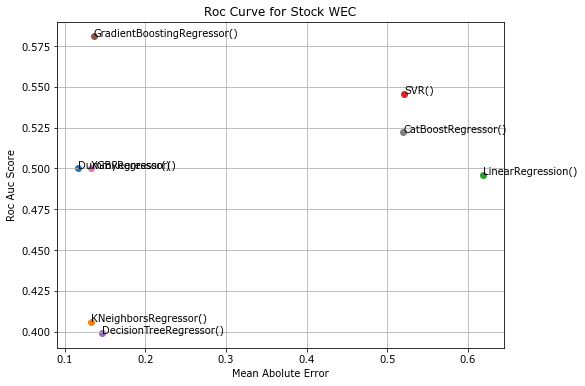

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 80.86it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'strategy': 'mean'}
  Backtesting metric: 1.4342492853960105e-05



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
  Backtesting metric: 3.553083792005319e-07

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 26.12it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'copy_X': True, 'fit_intercept': True}
  Backtesting metric: 0.06340028096831346

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'C': 1, 'coef0': 10, 'degree': 8, 'gamma': 'scale', 'kernel': 'sigmoid'}
  Backtesting metric: 1.4211350427091924e-06

Number of models compared: 1920.


loop param_grid:  83%|███████████████████████████▍     | 319/384 [00:01<00:00, 169.10it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 80, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.4, 'splitter': 'best'}
  Backtesting metric: 2.0889646949347827e-08

Number of models compared: 540.


loop param_grid:  71%|████████████████████████▉          | 77/108 [00:05<00:01, 20.17it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:34<00:00,  6.87s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
  Backtesting metric: 1.5800423490277485e-06

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:31:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.47it/s]

[14:31:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 13.17it/s]

[14:31:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:00<00:06, 12.85it/s]

[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.50it/s]

[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 12.32it/s]


[14:31:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 12.07it/s]

[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:05, 12.68it/s]

[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.56it/s]

[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 12.03it/s]

[14:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.79it/s]

[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:04, 12.37it/s]

[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.35it/s]

[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.73it/s]

[14:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 11.78it/s]

[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.60it/s]

[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.52it/s]

[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.37it/s]

[14:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.04it/s]

[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03, 10.36it/s]

[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.15it/s]


[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.51it/s]

[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:05<00:02, 10.10it/s]

[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.09it/s]


[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02,  9.98it/s]


[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:06<00:02,  9.11it/s]

[14:31:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 10.51it/s]

[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.59it/s]

[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.56it/s]

[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.10it/s]


[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.10it/s]


[14:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.09it/s]


[14:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.09it/s]

[14:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00,  9.06it/s]

[14:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:08<00:00,  9.01it/s]


[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:07, 11.98it/s]

[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:09,  9.68it/s]

[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 8/96 [00:00<00:10,  8.49it/s]

[14:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:01<00:08,  9.87it/s]

[14:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  12%|████▌                               | 12/96 [00:01<00:09,  8.81it/s]

[14:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:08,  9.33it/s]


[14:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  17%|██████                              | 16/96 [00:01<00:09,  8.11it/s]

[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 20/96 [00:02<00:08,  8.76it/s]

[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07, 10.35it/s]

[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████                           | 24/96 [00:02<00:07,  9.33it/s]

[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 11.04it/s]

[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:03<00:06, 10.34it/s]

[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:05, 10.58it/s]


[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.62it/s]


[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.42it/s]


[14:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:04<00:05, 10.66it/s]

[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:05, 10.57it/s]

[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.54it/s]


[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.81it/s]


[14:31:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.29it/s]


[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:05<00:04, 10.35it/s]


[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:03, 10.48it/s]

[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.00it/s]

[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:06<00:04,  8.76it/s]

[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.98it/s]

[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02,  9.97it/s]


[14:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.64it/s]

[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.65it/s]

[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:02, 10.08it/s]

[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  9.06it/s]

[14:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:08<00:01,  9.20it/s]

[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01, 10.00it/s]

[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.73it/s]

[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:09<00:00,  8.89it/s]

[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:09<00:00,  9.91it/s]

[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.41it/s]

[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  40%|███████████████▌                       | 2/5 [00:18<00:28,  9.46s/it]

[14:31:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:07, 12.83it/s]


[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:08, 10.79it/s]

[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:08, 10.20it/s]


[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:08, 10.12it/s]

[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  12%|████▌                               | 12/96 [00:01<00:09,  8.78it/s]

[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████                              | 16/96 [00:01<00:08,  8.97it/s]

[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.13it/s]

[14:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  21%|███████▌                            | 20/96 [00:02<00:08,  8.65it/s]

[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████                           | 24/96 [00:02<00:08,  8.87it/s]

[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.02it/s]

[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  29%|██████████▌                         | 28/96 [00:02<00:07,  9.11it/s]


[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:03<00:06, 10.72it/s]

[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:06, 10.50it/s]


[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.36it/s]

[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.17it/s]

[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████                     | 40/96 [00:04<00:06,  8.70it/s]

[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  46%|████████████████▌                   | 44/96 [00:04<00:05,  8.69it/s]

[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.33it/s]

[14:31:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:05<00:04,  9.92it/s]

[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:05<00:04,  9.72it/s]


[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  54%|███████████████████▌                | 52/96 [00:05<00:05,  8.50it/s]

[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  8.81it/s]

[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  60%|█████████████████████▊              | 58/96 [00:05<00:03, 10.73it/s]

[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  62%|██████████████████████▌             | 60/96 [00:06<00:04,  8.13it/s]

[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:06<00:03,  9.09it/s]

[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:06<00:03,  9.08it/s]

[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:07<00:03,  8.95it/s]


[14:31:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:07<00:03,  7.88it/s]

[14:31:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:07<00:02,  9.08it/s]


[14:31:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.06it/s]

[14:31:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:02,  9.15it/s]


[14:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:08<00:02,  8.23it/s]

[14:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:08<00:01,  9.39it/s]


[14:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  85%|██████████████████████████████▊     | 82/96 [00:08<00:01, 10.07it/s]

[14:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:09<00:01,  7.83it/s]

[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:09<00:00,  9.30it/s]

[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:09<00:00,  8.80it/s]

[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:09<00:00,  8.74it/s]

[14:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:10<00:00,  7.57it/s]

[14:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:29<00:19,  9.91s/it]

[14:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:07, 12.91it/s]


[14:31:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:08, 11.20it/s]


[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:08, 10.55it/s]


[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:08, 10.66it/s]


[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:01<00:07, 10.65it/s]


[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.65it/s]

[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.25it/s]


[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.11it/s]


[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:02<00:07,  9.92it/s]

[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████                           | 24/96 [00:02<00:08,  8.70it/s]

[14:31:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  29%|██████████▌                         | 28/96 [00:02<00:07,  9.12it/s]

[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:03<00:06, 10.45it/s]

[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:06, 10.35it/s]

[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  38%|█████████████▌                      | 36/96 [00:03<00:06,  8.96it/s]

[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05,  9.93it/s]

[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████                     | 40/96 [00:04<00:06,  8.86it/s]

[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  44%|███████████████▊                    | 42/96 [00:04<00:05, 10.61it/s]

[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  46%|████████████████▌                   | 44/96 [00:04<00:06,  8.31it/s]

[14:31:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:05,  9.65it/s]


[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04,  9.72it/s]

[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:05<00:04,  9.47it/s]


[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  54%|███████████████████▌                | 52/96 [00:05<00:05,  8.02it/s]

[14:31:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:04,  9.52it/s]


[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  8.21it/s]

[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:06<00:04,  8.99it/s]

[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:06<00:04,  7.52it/s]

[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:06<00:03,  8.68it/s]


[14:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:04,  7.73it/s]

[14:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:07<00:03,  7.85it/s]

[14:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.27it/s]

[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:08<00:02,  8.61it/s]

[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:08<00:01,  9.58it/s]

[14:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:08<00:01,  8.53it/s]

[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01,  9.81it/s]

[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:09<00:01,  8.33it/s]

[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:09<00:00,  8.37it/s]

[14:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.43it/s]

[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:10<00:00, 10.26it/s]

[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:07, 12.43it/s]


[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.60it/s]

[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.72it/s]


[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.67it/s]

[14:32:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.25it/s]

[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 12.04it/s]

[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.53it/s]

[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.83it/s]

[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 11.11it/s]

[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.29it/s]

[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 11.00it/s]

[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.28it/s]


[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.54it/s]


[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 10.96it/s]

[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 11.31it/s]

[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.33it/s]


[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.57it/s]

[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 11.04it/s]

[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 11.26it/s]

[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03, 11.18it/s]

[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.56it/s]

[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.53it/s]

[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 11.18it/s]


[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:01, 11.83it/s]

[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 11.88it/s]


[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 11.55it/s]

[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 11.48it/s]


[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:00, 11.76it/s]

[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 11.94it/s]


[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 11.45it/s]

[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 11.34it/s]

[14:32:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:48<00:00,  9.60s/it]


[14:32:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'colsample_bytree': 0.4, 'gamma': 0.3, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.6}
  Backtesting metric: 1.4080128662776934e-06

Number of models compared: 60.


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.96it/s]

0:	learn: 0.2799380	total: 1.05ms	remaining: 30.3ms
1:	learn: 0.2699040	total: 1.53ms	remaining: 21.5ms
2:	learn: 0.2623550	total: 2.38ms	remaining: 21.4ms
3:	learn: 0.2537191	total: 3.09ms	remaining: 20.1ms
4:	learn: 0.2469100	total: 3.95ms	remaining: 19.7ms
5:	learn: 0.2386740	total: 4.88ms	remaining: 19.5ms
6:	learn: 0.2315944	total: 5.68ms	remaining: 18.7ms
7:	learn: 0.2246204	total: 6.51ms	remaining: 17.9ms
8:	learn: 0.2183460	total: 7.28ms	remaining: 17ms
9:	learn: 0.2137554	total: 7.96ms	remaining: 15.9ms
10:	learn: 0.2084026	total: 8.75ms	remaining: 15.1ms
11:	learn: 0.2022483	total: 9.46ms	remaining: 14.2ms
12:	learn: 0.1969793	total: 10.2ms	remaining: 13.4ms
13:	learn: 0.1920821	total: 11.1ms	remaining: 12.7ms
14:	learn: 0.1865528	total: 11.8ms	remaining: 11.8ms
15:	learn: 0.1812497	total: 12.6ms	remaining: 11ms
16:	learn: 0.1757312	total: 12.9ms	remaining: 9.83ms
17:	learn: 0.1713661	total: 13.7ms	remaining: 9.13ms
18:	learn: 0.1670095	total: 14.6ms	remaining: 8.48ms
19:	lea


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00, 10.51it/s]

19:	learn: 0.1638123	total: 16.2ms	remaining: 24.3ms
20:	learn: 0.1598807	total: 17ms	remaining: 23.5ms
21:	learn: 0.1555793	total: 17.7ms	remaining: 22.6ms
22:	learn: 0.1517266	total: 18.6ms	remaining: 21.8ms
23:	learn: 0.1477792	total: 19.3ms	remaining: 20.9ms
24:	learn: 0.1446766	total: 20.2ms	remaining: 20.2ms
25:	learn: 0.1415231	total: 21.2ms	remaining: 19.6ms
26:	learn: 0.1386727	total: 22.1ms	remaining: 18.8ms
27:	learn: 0.1353344	total: 22.9ms	remaining: 18ms
28:	learn: 0.1324229	total: 23.6ms	remaining: 17.1ms
29:	learn: 0.1299061	total: 24.3ms	remaining: 16.2ms
30:	learn: 0.1267501	total: 25.1ms	remaining: 15.4ms
31:	learn: 0.1244420	total: 25.9ms	remaining: 14.6ms
32:	learn: 0.1219767	total: 26.7ms	remaining: 13.7ms
33:	learn: 0.1194409	total: 27.5ms	remaining: 12.9ms
34:	learn: 0.1171671	total: 28.3ms	remaining: 12.1ms
35:	learn: 0.1145845	total: 29.1ms	remaining: 11.3ms
36:	learn: 0.1125556	total: 29.7ms	remaining: 10.4ms
37:	learn: 0.1104168	total: 30.4ms	remaining: 9.6m


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00, 10.21it/s]

4:	learn: 0.2477017	total: 6.29ms	remaining: 31.4ms
5:	learn: 0.2409240	total: 8.4ms	remaining: 33.6ms
6:	learn: 0.2346017	total: 10.1ms	remaining: 33ms
7:	learn: 0.2292659	total: 12.4ms	remaining: 34.1ms
8:	learn: 0.2233029	total: 14.4ms	remaining: 33.6ms
9:	learn: 0.2164279	total: 15ms	remaining: 29.9ms
10:	learn: 0.2108568	total: 16.4ms	remaining: 28.4ms
11:	learn: 0.2053643	total: 17.9ms	remaining: 26.9ms
12:	learn: 0.1992534	total: 18.6ms	remaining: 24.3ms
13:	learn: 0.1933742	total: 20.3ms	remaining: 23.2ms
14:	learn: 0.1884154	total: 21.8ms	remaining: 21.8ms
15:	learn: 0.1830426	total: 22.4ms	remaining: 19.6ms
16:	learn: 0.1786559	total: 23.8ms	remaining: 18.2ms
17:	learn: 0.1745649	total: 25.6ms	remaining: 17.1ms
18:	learn: 0.1695765	total: 27.2ms	remaining: 15.7ms
19:	learn: 0.1657593	total: 28.6ms	remaining: 14.3ms
20:	learn: 0.1612823	total: 29.9ms	remaining: 12.8ms
21:	learn: 0.1572822	total: 30.6ms	remaining: 11.1ms
22:	learn: 0.1542163	total: 32.7ms	remaining: 9.95ms
23:	


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:00<00:00,  8.70it/s]

22:	learn: 0.0966362	total: 28.1ms	remaining: 33ms
23:	learn: 0.0937489	total: 29.6ms	remaining: 32.1ms
24:	learn: 0.0909998	total: 30.5ms	remaining: 30.5ms
25:	learn: 0.0889004	total: 32ms	remaining: 29.5ms
26:	learn: 0.0863421	total: 33.5ms	remaining: 28.6ms
27:	learn: 0.0844031	total: 35ms	remaining: 27.5ms
28:	learn: 0.0822927	total: 36.4ms	remaining: 26.3ms
29:	learn: 0.0803312	total: 37.8ms	remaining: 25.2ms
30:	learn: 0.0782487	total: 39.4ms	remaining: 24.1ms
31:	learn: 0.0760965	total: 40.8ms	remaining: 22.9ms
32:	learn: 0.0745048	total: 42.2ms	remaining: 21.7ms
33:	learn: 0.0725279	total: 43.8ms	remaining: 20.6ms
34:	learn: 0.0708375	total: 45.3ms	remaining: 19.4ms
35:	learn: 0.0688721	total: 46.8ms	remaining: 18.2ms
36:	learn: 0.0672866	total: 48.4ms	remaining: 17ms
37:	learn: 0.0657440	total: 50ms	remaining: 15.8ms
38:	learn: 0.0640015	total: 51.3ms	remaining: 14.5ms
39:	learn: 0.0624392	total: 52.8ms	remaining: 13.2ms
40:	learn: 0.0609130	total: 54.4ms	remaining: 11.9ms
41:


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  7.63it/s]

18:	learn: 0.1731114	total: 74.6ms	remaining: 43.2ms
19:	learn: 0.1687608	total: 79.3ms	remaining: 39.6ms
20:	learn: 0.1643087	total: 83.9ms	remaining: 35.9ms
21:	learn: 0.1605913	total: 88.3ms	remaining: 32.1ms
22:	learn: 0.1563486	total: 88.9ms	remaining: 27.1ms
23:	learn: 0.1527919	total: 93.4ms	remaining: 23.3ms
24:	learn: 0.1492476	total: 98ms	remaining: 19.6ms
25:	learn: 0.1454063	total: 100ms	remaining: 15.5ms
26:	learn: 0.1421254	total: 105ms	remaining: 11.7ms
27:	learn: 0.1394113	total: 110ms	remaining: 7.86ms
28:	learn: 0.1362271	total: 111ms	remaining: 3.83ms
29:	learn: 0.1333960	total: 115ms	remaining: 0us
0:	learn: 0.2702256	total: 765us	remaining: 22.2ms
1:	learn: 0.2510580	total: 1.16ms	remaining: 16.2ms
2:	learn: 0.2379665	total: 5.85ms	remaining: 52.6ms
3:	learn: 0.2252904	total: 10.3ms	remaining: 67.1ms
4:	learn: 0.2130910	total: 15ms	remaining: 74.9ms
5:	learn: 0.2019661	total: 19.9ms	remaining: 79.8ms
6:	learn: 0.1924396	total: 21.8ms	remaining: 71.5ms
7:	learn: 0.1


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  7.03it/s]

20:	learn: 0.1039928	total: 75.9ms	remaining: 32.5ms
21:	learn: 0.1006928	total: 80.3ms	remaining: 29.2ms
22:	learn: 0.0973147	total: 80.9ms	remaining: 24.6ms
23:	learn: 0.0942819	total: 85.6ms	remaining: 21.4ms
24:	learn: 0.0912484	total: 89.8ms	remaining: 18ms
25:	learn: 0.0875496	total: 90.6ms	remaining: 13.9ms
26:	learn: 0.0847976	total: 94.9ms	remaining: 10.5ms
27:	learn: 0.0826923	total: 100ms	remaining: 7.15ms
28:	learn: 0.0804614	total: 105ms	remaining: 3.64ms
29:	learn: 0.0783622	total: 109ms	remaining: 0us
0:	learn: 0.2799380	total: 925us	remaining: 45.4ms
1:	learn: 0.2699040	total: 1.35ms	remaining: 32.5ms
2:	learn: 0.2627105	total: 5.72ms	remaining: 89.6ms
3:	learn: 0.2555030	total: 11.3ms	remaining: 130ms
4:	learn: 0.2483128	total: 16.2ms	remaining: 146ms
5:	learn: 0.2414482	total: 21.8ms	remaining: 160ms
6:	learn: 0.2353311	total: 23.8ms	remaining: 146ms
7:	learn: 0.2288283	total: 25.3ms	remaining: 133ms
8:	learn: 0.2217332	total: 28ms	remaining: 127ms
9:	learn: 0.2152134


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  5.53it/s]

19:	learn: 0.1687608	total: 82.7ms	remaining: 124ms
20:	learn: 0.1643087	total: 87.3ms	remaining: 120ms
21:	learn: 0.1605913	total: 92.5ms	remaining: 118ms
22:	learn: 0.1563486	total: 93.1ms	remaining: 109ms
23:	learn: 0.1527919	total: 98.5ms	remaining: 107ms
24:	learn: 0.1492476	total: 104ms	remaining: 104ms
25:	learn: 0.1454063	total: 107ms	remaining: 98.3ms
26:	learn: 0.1421254	total: 113ms	remaining: 95.8ms
27:	learn: 0.1394113	total: 119ms	remaining: 93.3ms
28:	learn: 0.1362271	total: 120ms	remaining: 87ms
29:	learn: 0.1333960	total: 125ms	remaining: 83.2ms
30:	learn: 0.1304683	total: 126ms	remaining: 77.2ms
31:	learn: 0.1276333	total: 132ms	remaining: 74.2ms
32:	learn: 0.1249068	total: 133ms	remaining: 68.7ms
33:	learn: 0.1227073	total: 139ms	remaining: 65.4ms
34:	learn: 0.1203615	total: 142ms	remaining: 60.8ms
35:	learn: 0.1181784	total: 148ms	remaining: 57.4ms
36:	learn: 0.1156097	total: 152ms	remaining: 53.4ms
37:	learn: 0.1131686	total: 156ms	remaining: 49.4ms
38:	learn: 0.11


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  7.06it/s]

0:	learn: 0.2857307	total: 2.1ms	remaining: 60.8ms
1:	learn: 0.2761486	total: 3.7ms	remaining: 51.8ms
2:	learn: 0.2694453	total: 5.34ms	remaining: 48.1ms
3:	learn: 0.2628147	total: 6.54ms	remaining: 42.5ms
4:	learn: 0.2552678	total: 7.98ms	remaining: 39.9ms
5:	learn: 0.2483456	total: 9.05ms	remaining: 36.2ms
6:	learn: 0.2415666	total: 10.3ms	remaining: 33.9ms
7:	learn: 0.2349177	total: 11.4ms	remaining: 31.4ms
8:	learn: 0.2281682	total: 12.6ms	remaining: 29.5ms
9:	learn: 0.2223053	total: 13.9ms	remaining: 27.8ms
10:	learn: 0.2146110	total: 14.3ms	remaining: 24.8ms
11:	learn: 0.2084418	total: 15.6ms	remaining: 23.4ms
12:	learn: 0.2028561	total: 17.3ms	remaining: 22.6ms
13:	learn: 0.1977488	total: 18.9ms	remaining: 21.6ms
14:	learn: 0.1925667	total: 20.2ms	remaining: 20.2ms
15:	learn: 0.1871836	total: 21.8ms	remaining: 19.1ms
16:	learn: 0.1816546	total: 23.2ms	remaining: 17.7ms
17:	learn: 0.1768345	total: 24.6ms	remaining: 16.4ms
18:	learn: 0.1719928	total: 25.7ms	remaining: 14.9ms
19:	l


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  7.28it/s]

0:	learn: 0.2857307	total: 1.26ms	remaining: 61.8ms
1:	learn: 0.2761486	total: 2.41ms	remaining: 57.9ms
2:	learn: 0.2694453	total: 4.08ms	remaining: 63.9ms
3:	learn: 0.2628147	total: 5.29ms	remaining: 60.8ms
4:	learn: 0.2552678	total: 6.4ms	remaining: 57.6ms
5:	learn: 0.2483456	total: 7.48ms	remaining: 54.9ms
6:	learn: 0.2415666	total: 8.58ms	remaining: 52.7ms
7:	learn: 0.2349177	total: 9.54ms	remaining: 50.1ms
8:	learn: 0.2281682	total: 10.6ms	remaining: 48.3ms
9:	learn: 0.2223053	total: 11.4ms	remaining: 45.6ms
10:	learn: 0.2146110	total: 11.9ms	remaining: 42.4ms
11:	learn: 0.2084418	total: 12.8ms	remaining: 40.6ms
12:	learn: 0.2028561	total: 13.9ms	remaining: 39.6ms
13:	learn: 0.1977488	total: 15ms	remaining: 38.7ms
14:	learn: 0.1925667	total: 16.2ms	remaining: 37.7ms
15:	learn: 0.1871836	total: 17.3ms	remaining: 36.8ms
16:	learn: 0.1816546	total: 18.1ms	remaining: 35.2ms
17:	learn: 0.1768345	total: 19.1ms	remaining: 33.9ms
18:	learn: 0.1719928	total: 19.9ms	remaining: 32.5ms
19:	le


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  6.51it/s]

9:	learn: 0.1705723	total: 12.3ms	remaining: 49.3ms
10:	learn: 0.1600576	total: 12.7ms	remaining: 45.2ms
11:	learn: 0.1515649	total: 13.6ms	remaining: 43.2ms
12:	learn: 0.1438610	total: 15ms	remaining: 42.6ms
13:	learn: 0.1372186	total: 16.1ms	remaining: 41.4ms
14:	learn: 0.1312521	total: 17.3ms	remaining: 40.3ms
15:	learn: 0.1252515	total: 18.2ms	remaining: 38.7ms
16:	learn: 0.1191892	total: 19.1ms	remaining: 37.1ms
17:	learn: 0.1142769	total: 20ms	remaining: 35.6ms
18:	learn: 0.1094195	total: 21.1ms	remaining: 34.5ms
19:	learn: 0.1059718	total: 21.6ms	remaining: 32.4ms
20:	learn: 0.1026163	total: 22.5ms	remaining: 31.1ms
21:	learn: 0.0993499	total: 23.7ms	remaining: 30.2ms
22:	learn: 0.0956441	total: 25ms	remaining: 29.4ms
23:	learn: 0.0920376	total: 26.5ms	remaining: 28.7ms
24:	learn: 0.0896508	total: 27.7ms	remaining: 27.7ms
25:	learn: 0.0873124	total: 28.6ms	remaining: 26.4ms
26:	learn: 0.0849874	total: 29.6ms	remaining: 25.2ms
27:	learn: 0.0829363	total: 30.6ms	remaining: 24.1ms



loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  5.85it/s]

8:	learn: 0.2324639	total: 21.8ms	remaining: 50.8ms
9:	learn: 0.2260520	total: 24.3ms	remaining: 48.6ms
10:	learn: 0.2209298	total: 26.5ms	remaining: 45.8ms
11:	learn: 0.2147911	total: 29ms	remaining: 43.5ms
12:	learn: 0.2096857	total: 31.7ms	remaining: 41.4ms
13:	learn: 0.2045885	total: 33.8ms	remaining: 38.7ms
14:	learn: 0.1997404	total: 36.1ms	remaining: 36.1ms
15:	learn: 0.1949985	total: 38.6ms	remaining: 33.8ms
16:	learn: 0.1900091	total: 41.3ms	remaining: 31.6ms
17:	learn: 0.1857939	total: 45.4ms	remaining: 30.3ms
18:	learn: 0.1806662	total: 49.7ms	remaining: 28.8ms
19:	learn: 0.1766100	total: 52.8ms	remaining: 26.4ms
20:	learn: 0.1726143	total: 55.8ms	remaining: 23.9ms
21:	learn: 0.1688141	total: 58.6ms	remaining: 21.3ms
22:	learn: 0.1648607	total: 63.2ms	remaining: 19.2ms
23:	learn: 0.1607408	total: 66.4ms	remaining: 16.6ms
24:	learn: 0.1566454	total: 70.1ms	remaining: 14ms
25:	learn: 0.1532694	total: 73.1ms	remaining: 11.2ms
26:	learn: 0.1500100	total: 76.1ms	remaining: 8.46ms


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:01,  5.78it/s]

3:	learn: 0.2349908	total: 14.6ms	remaining: 95ms
4:	learn: 0.2218377	total: 15.8ms	remaining: 79ms
5:	learn: 0.2111044	total: 18.5ms	remaining: 73.8ms
6:	learn: 0.2023747	total: 22ms	remaining: 72.4ms
7:	learn: 0.1931214	total: 24.7ms	remaining: 67.8ms
8:	learn: 0.1845455	total: 27.4ms	remaining: 63.9ms
9:	learn: 0.1751244	total: 29.9ms	remaining: 59.9ms
10:	learn: 0.1680706	total: 33.4ms	remaining: 57.8ms
11:	learn: 0.1595058	total: 36.4ms	remaining: 54.6ms
12:	learn: 0.1527798	total: 40.5ms	remaining: 52.9ms
13:	learn: 0.1455970	total: 42.1ms	remaining: 48.1ms
14:	learn: 0.1397515	total: 45.1ms	remaining: 45.1ms
15:	learn: 0.1340406	total: 49.1ms	remaining: 43ms
16:	learn: 0.1285929	total: 52ms	remaining: 39.8ms
17:	learn: 0.1240947	total: 54.4ms	remaining: 36.3ms
18:	learn: 0.1190536	total: 57.5ms	remaining: 33.3ms
19:	learn: 0.1148395	total: 60.3ms	remaining: 30.2ms
20:	learn: 0.1106752	total: 62.9ms	remaining: 26.9ms
21:	learn: 0.1070627	total: 65.6ms	remaining: 23.9ms
22:	learn:


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.01it/s]

8:	learn: 0.2324639	total: 28.3ms	remaining: 129ms
9:	learn: 0.2260520	total: 32.3ms	remaining: 129ms
10:	learn: 0.2209298	total: 35.2ms	remaining: 125ms
11:	learn: 0.2147911	total: 38.1ms	remaining: 121ms
12:	learn: 0.2096857	total: 41.1ms	remaining: 117ms
13:	learn: 0.2045885	total: 43.1ms	remaining: 111ms
14:	learn: 0.1997404	total: 46.3ms	remaining: 108ms
15:	learn: 0.1949985	total: 49.7ms	remaining: 106ms
16:	learn: 0.1900091	total: 53.3ms	remaining: 104ms
17:	learn: 0.1857939	total: 56.8ms	remaining: 101ms
18:	learn: 0.1806662	total: 59.4ms	remaining: 97ms
19:	learn: 0.1766100	total: 61.8ms	remaining: 92.8ms
20:	learn: 0.1726143	total: 64.7ms	remaining: 89.3ms
21:	learn: 0.1688141	total: 67.4ms	remaining: 85.7ms
22:	learn: 0.1648607	total: 70.3ms	remaining: 82.6ms
23:	learn: 0.1607408	total: 73.8ms	remaining: 79.9ms
24:	learn: 0.1566454	total: 77.4ms	remaining: 77.4ms
25:	learn: 0.1532694	total: 81.4ms	remaining: 75.1ms
26:	learn: 0.1500100	total: 83.8ms	remaining: 71.4ms
27:	lea

0:	learn: 0.2790974	total: 2.85ms	remaining: 140ms
1:	learn: 0.2615441	total: 3.98ms	remaining: 95.6ms
2:	learn: 0.2496600	total: 6.47ms	remaining: 101ms
3:	learn: 0.2349908	total: 9.65ms	remaining: 111ms
4:	learn: 0.2218377	total: 10.8ms	remaining: 97.4ms
5:	learn: 0.2111044	total: 13.7ms	remaining: 101ms
6:	learn: 0.2023747	total: 17.3ms	remaining: 106ms
7:	learn: 0.1931214	total: 19.9ms	remaining: 104ms
8:	learn: 0.1845455	total: 22.2ms	remaining: 101ms
9:	learn: 0.1751244	total: 25.1ms	remaining: 100ms
10:	learn: 0.1680706	total: 27.4ms	remaining: 97.2ms
11:	learn: 0.1595058	total: 30.2ms	remaining: 95.5ms
12:	learn: 0.1527798	total: 32.4ms	remaining: 92.3ms
13:	learn: 0.1455970	total: 34.2ms	remaining: 88ms
14:	learn: 0.1397515	total: 36.8ms	remaining: 85.9ms
15:	learn: 0.1340406	total: 39.8ms	remaining: 84.5ms
16:	learn: 0.1285929	total: 42.6ms	remaining: 82.6ms
17:	learn: 0.1240947	total: 45.1ms	remaining: 80.2ms
18:	learn: 0.1190536	total: 47.6ms	remaining: 77.7ms
19:	learn: 0.

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  4.76it/s]

0:	learn: 0.2887899	total: 7.32ms	remaining: 212ms
1:	learn: 0.2825496	total: 13.8ms	remaining: 193ms
2:	learn: 0.2740777	total: 14.8ms	remaining: 133ms
3:	learn: 0.2681011	total: 18.5ms	remaining: 120ms
4:	learn: 0.2618209	total: 26.6ms	remaining: 133ms
5:	learn: 0.2558536	total: 34.2ms	remaining: 137ms
6:	learn: 0.2480728	total: 35ms	remaining: 115ms
7:	learn: 0.2417790	total: 43.3ms	remaining: 119ms
8:	learn: 0.2349267	total: 44.4ms	remaining: 104ms
9:	learn: 0.2295462	total: 51.5ms	remaining: 103ms
10:	learn: 0.2239496	total: 57.4ms	remaining: 99.2ms
11:	learn: 0.2181366	total: 63.2ms	remaining: 94.8ms
12:	learn: 0.2132375	total: 69.5ms	remaining: 90.9ms
13:	learn: 0.2079358	total: 76.2ms	remaining: 87.1ms
14:	learn: 0.2023518	total: 77.3ms	remaining: 77.3ms
15:	learn: 0.1977963	total: 83.7ms	remaining: 73.3ms
16:	learn: 0.1931462	total: 91.3ms	remaining: 69.8ms
17:	learn: 0.1894222	total: 97.6ms	remaining: 65ms
18:	learn: 0.1854948	total: 104ms	remaining: 60.2ms
19:	learn: 0.18199


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.36it/s]

27:	learn: 0.1521588	total: 161ms	remaining: 11.5ms
28:	learn: 0.1492232	total: 167ms	remaining: 5.76ms
29:	learn: 0.1464400	total: 174ms	remaining: 0us
0:	learn: 0.2824339	total: 5.59ms	remaining: 162ms
1:	learn: 0.2702487	total: 12.5ms	remaining: 176ms
2:	learn: 0.2541942	total: 13.6ms	remaining: 123ms
3:	learn: 0.2433164	total: 16.7ms	remaining: 109ms
4:	learn: 0.2322333	total: 22.7ms	remaining: 114ms
5:	learn: 0.2220846	total: 28.8ms	remaining: 115ms
6:	learn: 0.2092038	total: 29.5ms	remaining: 97ms
7:	learn: 0.1991442	total: 36ms	remaining: 99ms
8:	learn: 0.1884625	total: 37.2ms	remaining: 86.9ms
9:	learn: 0.1804735	total: 43.5ms	remaining: 87.1ms
10:	learn: 0.1702655	total: 44.4ms	remaining: 76.7ms
11:	learn: 0.1628829	total: 46.6ms	remaining: 69.8ms
12:	learn: 0.1551119	total: 47.9ms	remaining: 62.6ms
13:	learn: 0.1487784	total: 54.6ms	remaining: 62.4ms
14:	learn: 0.1423608	total: 60.8ms	remaining: 60.8ms
15:	learn: 0.1368164	total: 66.7ms	remaining: 58.4ms
16:	learn: 0.1311684	


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.29it/s]

18:	learn: 0.1220232	total: 82.9ms	remaining: 48ms
19:	learn: 0.1177127	total: 90.9ms	remaining: 45.4ms
20:	learn: 0.1140506	total: 96.5ms	remaining: 41.4ms
21:	learn: 0.1085481	total: 103ms	remaining: 37.4ms
22:	learn: 0.1051879	total: 108ms	remaining: 33ms
23:	learn: 0.1014911	total: 114ms	remaining: 28.5ms
24:	learn: 0.0980244	total: 120ms	remaining: 24.1ms
25:	learn: 0.0944722	total: 122ms	remaining: 18.7ms
26:	learn: 0.0912174	total: 124ms	remaining: 13.7ms
27:	learn: 0.0883783	total: 133ms	remaining: 9.48ms
28:	learn: 0.0855927	total: 139ms	remaining: 4.81ms
29:	learn: 0.0824527	total: 146ms	remaining: 0us
0:	learn: 0.2887899	total: 5.8ms	remaining: 284ms
1:	learn: 0.2825496	total: 14.6ms	remaining: 349ms
2:	learn: 0.2740777	total: 16ms	remaining: 251ms
3:	learn: 0.2681011	total: 21.2ms	remaining: 244ms
4:	learn: 0.2618209	total: 28.3ms	remaining: 254ms
5:	learn: 0.2558536	total: 39ms	remaining: 286ms
6:	learn: 0.2480728	total: 39.9ms	remaining: 245ms
7:	learn: 0.2417790	total: 4


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.33it/s]

27:	learn: 0.1521588	total: 217ms	remaining: 170ms
28:	learn: 0.1492232	total: 226ms	remaining: 164ms
29:	learn: 0.1464400	total: 235ms	remaining: 157ms
30:	learn: 0.1432453	total: 236ms	remaining: 144ms
31:	learn: 0.1406204	total: 243ms	remaining: 137ms
32:	learn: 0.1384378	total: 250ms	remaining: 129ms
33:	learn: 0.1358926	total: 257ms	remaining: 121ms
34:	learn: 0.1325336	total: 259ms	remaining: 111ms
35:	learn: 0.1303327	total: 263ms	remaining: 102ms
36:	learn: 0.1279658	total: 271ms	remaining: 95.3ms
37:	learn: 0.1259754	total: 279ms	remaining: 88ms
38:	learn: 0.1236163	total: 286ms	remaining: 80.7ms
39:	learn: 0.1216234	total: 293ms	remaining: 73.3ms
40:	learn: 0.1190641	total: 301ms	remaining: 66ms
41:	learn: 0.1165554	total: 304ms	remaining: 58ms
42:	learn: 0.1142631	total: 308ms	remaining: 50.1ms
43:	learn: 0.1119538	total: 309ms	remaining: 42.1ms
44:	learn: 0.1101974	total: 315ms	remaining: 35ms
45:	learn: 0.1082092	total: 319ms	remaining: 27.7ms
46:	learn: 0.1068145	total: 3


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:04<00:07,  2.44s/it]

36:	learn: 0.0682812	total: 169ms	remaining: 59.2ms
37:	learn: 0.0665871	total: 174ms	remaining: 54.9ms
38:	learn: 0.0644418	total: 179ms	remaining: 50.5ms
39:	learn: 0.0628014	total: 185ms	remaining: 46.2ms
40:	learn: 0.0609398	total: 190ms	remaining: 41.7ms
41:	learn: 0.0595639	total: 196ms	remaining: 37.3ms
42:	learn: 0.0580016	total: 203ms	remaining: 33ms
43:	learn: 0.0562560	total: 211ms	remaining: 28.7ms
44:	learn: 0.0550084	total: 216ms	remaining: 24ms
45:	learn: 0.0536017	total: 221ms	remaining: 19.2ms
46:	learn: 0.0520914	total: 226ms	remaining: 14.4ms
47:	learn: 0.0504858	total: 230ms	remaining: 9.6ms
48:	learn: 0.0490555	total: 236ms	remaining: 4.81ms
49:	learn: 0.0476500	total: 241ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2780795	total: 1.49ms	remaining: 43.3ms
1:	learn: 0.2712896	total: 2.48ms	remaining: 34.7ms
2:	learn: 0.2637082	total: 3.57ms	remaining: 32.1ms
3:	learn: 0.2570687	total: 4.67ms	remaining: 30.3ms
4:	learn: 0.2492694	total: 5.54ms	remaining: 27.7ms
5:	learn: 0.2427966	total: 6.5ms	remaining: 26ms
6:	learn: 0.2369910	total: 7.41ms	remaining: 24.4ms
7:	learn: 0.2313707	total: 8.29ms	remaining: 22.8ms
8:	learn: 0.2243109	total: 8.92ms	remaining: 20.8ms
9:	learn: 0.2185411	total: 9.93ms	remaining: 19.9ms
10:	learn: 0.2128666	total: 11ms	remaining: 19ms
11:	learn: 0.2074940	total: 11.8ms	remaining: 17.7ms
12:	learn: 0.2029689	total: 12.7ms	remaining: 16.7ms
13:	learn: 0.1986652	total: 13.7ms	remaining: 15.6ms
14:	learn: 0.1940111	total: 14.6ms	remaining: 14.6ms
15:	learn: 0.1890373	total: 15.5ms	remaining: 13.6ms
16:	learn: 0.1845014	total: 16.4ms	remaining: 12.6ms
17:	learn: 0.1799381	total: 17.3ms	remaining: 11.6ms
18:	learn: 0.1758951	total: 18.2ms	remaining: 10.5ms
19:	learn:


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.59it/s]

28:	learn: 0.1398651	total: 28.1ms	remaining: 968us
29:	learn: 0.1366883	total: 29.2ms	remaining: 0us
0:	learn: 0.2698907	total: 1.16ms	remaining: 33.6ms
1:	learn: 0.2567956	total: 2.08ms	remaining: 29.1ms
2:	learn: 0.2426423	total: 2.99ms	remaining: 26.9ms
3:	learn: 0.2305879	total: 3.8ms	remaining: 24.7ms
4:	learn: 0.2169127	total: 4.64ms	remaining: 23.2ms
5:	learn: 0.2060801	total: 5.49ms	remaining: 22ms
6:	learn: 0.1966532	total: 6.42ms	remaining: 21.1ms
7:	learn: 0.1878524	total: 7.56ms	remaining: 20.8ms
8:	learn: 0.1769319	total: 8.23ms	remaining: 19.2ms
9:	learn: 0.1684965	total: 9.12ms	remaining: 18.2ms
10:	learn: 0.1605839	total: 10.1ms	remaining: 17.4ms
11:	learn: 0.1534090	total: 10.9ms	remaining: 16.3ms
12:	learn: 0.1477207	total: 11.8ms	remaining: 15.4ms
13:	learn: 0.1412065	total: 12.6ms	remaining: 14.4ms
14:	learn: 0.1354395	total: 13.6ms	remaining: 13.6ms
15:	learn: 0.1285478	total: 14.6ms	remaining: 12.8ms
16:	learn: 0.1229506	total: 15.1ms	remaining: 11.5ms
17:	learn:

31:	learn: 0.1306721	total: 33.8ms	remaining: 19ms
32:	learn: 0.1276904	total: 34.8ms	remaining: 17.9ms
33:	learn: 0.1249733	total: 35.8ms	remaining: 16.8ms
34:	learn: 0.1224769	total: 36.7ms	remaining: 15.7ms
35:	learn: 0.1195709	total: 37.6ms	remaining: 14.6ms
36:	learn: 0.1168287	total: 38.6ms	remaining: 13.5ms
37:	learn: 0.1143669	total: 39.6ms	remaining: 12.5ms
38:	learn: 0.1121719	total: 40.9ms	remaining: 11.5ms
39:	learn: 0.1095649	total: 42.1ms	remaining: 10.5ms
40:	learn: 0.1069287	total: 43.3ms	remaining: 9.5ms
41:	learn: 0.1045642	total: 44.3ms	remaining: 8.43ms
42:	learn: 0.1024755	total: 45.3ms	remaining: 7.37ms
43:	learn: 0.1008577	total: 46.3ms	remaining: 6.31ms
44:	learn: 0.0990563	total: 47.3ms	remaining: 5.25ms
45:	learn: 0.0974593	total: 48.2ms	remaining: 4.19ms
46:	learn: 0.0954987	total: 49.1ms	remaining: 3.13ms
47:	learn: 0.0940534	total: 50.1ms	remaining: 2.09ms
48:	learn: 0.0919744	total: 51.1ms	remaining: 1.04ms
49:	learn: 0.0900583	total: 52.1ms	remaining: 0us

loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  9.52it/s]

0:	learn: 0.2790569	total: 2.77ms	remaining: 80.4ms



loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.93it/s]

1:	learn: 0.2729808	total: 5.41ms	remaining: 75.7ms
2:	learn: 0.2664150	total: 7.79ms	remaining: 70.1ms
3:	learn: 0.2599093	total: 9.95ms	remaining: 64.7ms
4:	learn: 0.2533604	total: 12ms	remaining: 60ms
5:	learn: 0.2475538	total: 14ms	remaining: 55.9ms
6:	learn: 0.2398874	total: 14.6ms	remaining: 48.1ms
7:	learn: 0.2337277	total: 15.7ms	remaining: 43.2ms
8:	learn: 0.2282966	total: 17.6ms	remaining: 41.1ms
9:	learn: 0.2225021	total: 19ms	remaining: 38ms
10:	learn: 0.2177340	total: 21.1ms	remaining: 36.4ms
11:	learn: 0.2124829	total: 23.1ms	remaining: 34.6ms
12:	learn: 0.2073650	total: 25ms	remaining: 32.7ms
13:	learn: 0.2018197	total: 27ms	remaining: 30.9ms
14:	learn: 0.1971038	total: 28.4ms	remaining: 28.4ms
15:	learn: 0.1924698	total: 30.4ms	remaining: 26.6ms
16:	learn: 0.1888138	total: 32.5ms	remaining: 24.9ms
17:	learn: 0.1842462	total: 34.5ms	remaining: 23ms
18:	learn: 0.1802462	total: 36.4ms	remaining: 21ms
19:	learn: 0.1765356	total: 38.2ms	remaining: 19.1ms
20:	learn: 0.1727501


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  8.61it/s]


23:	learn: 0.0992283	total: 45.5ms	remaining: 11.4ms
24:	learn: 0.0959197	total: 47.3ms	remaining: 9.47ms
25:	learn: 0.0924120	total: 49.1ms	remaining: 7.56ms
26:	learn: 0.0891172	total: 51ms	remaining: 5.66ms
27:	learn: 0.0858975	total: 52.8ms	remaining: 3.77ms
28:	learn: 0.0836940	total: 54.7ms	remaining: 1.89ms
29:	learn: 0.0809741	total: 56.6ms	remaining: 0us
0:	learn: 0.2790569	total: 2.66ms	remaining: 130ms
1:	learn: 0.2729808	total: 4.74ms	remaining: 114ms
2:	learn: 0.2664150	total: 6.77ms	remaining: 106ms
3:	learn: 0.2599093	total: 8.85ms	remaining: 102ms
4:	learn: 0.2533604	total: 10.8ms	remaining: 97.4ms
5:	learn: 0.2475538	total: 13.1ms	remaining: 95.8ms
6:	learn: 0.2398874	total: 13.8ms	remaining: 85ms
7:	learn: 0.2337277	total: 14.7ms	remaining: 77.1ms
8:	learn: 0.2282966	total: 17ms	remaining: 77.6ms
9:	learn: 0.2225021	total: 18.4ms	remaining: 73.5ms
10:	learn: 0.2177340	total: 20.1ms	remaining: 71.3ms
11:	learn: 0.2124829	total: 22.1ms	remaining: 69.9ms
12:	learn: 0.207

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.97it/s]

0:	learn: 0.2718305	total: 2.31ms	remaining: 113ms
1:	learn: 0.2601004	total: 5.25ms	remaining: 126ms
2:	learn: 0.2476915	total: 8ms	remaining: 125ms
3:	learn: 0.2357734	total: 10.6ms	remaining: 122ms
4:	learn: 0.2242323	total: 12.9ms	remaining: 117ms
5:	learn: 0.2138951	total: 14.3ms	remaining: 105ms
6:	learn: 0.2033059	total: 16.7ms	remaining: 103ms
7:	learn: 0.1938019	total: 19ms	remaining: 100ms
8:	learn: 0.1867443	total: 21.3ms	remaining: 97ms
9:	learn: 0.1801531	total: 23.5ms	remaining: 94.1ms
10:	learn: 0.1720594	total: 25.8ms	remaining: 91.3ms
11:	learn: 0.1649166	total: 28.2ms	remaining: 89.4ms
12:	learn: 0.1565490	total: 28.8ms	remaining: 81.9ms
13:	learn: 0.1483924	total: 30ms	remaining: 77ms
14:	learn: 0.1426168	total: 32.4ms	remaining: 75.5ms
15:	learn: 0.1361745	total: 34.7ms	remaining: 73.7ms
16:	learn: 0.1307832	total: 37.2ms	remaining: 72.3ms
17:	learn: 0.1245539	total: 39.6ms	remaining: 70.4ms
18:	learn: 0.1196845	total: 41.9ms	remaining: 68.3ms
19:	learn: 0.1151371	t

1:	learn: 0.2731958	total: 12.7ms	remaining: 178ms
2:	learn: 0.2678824	total: 20ms	remaining: 180ms
3:	learn: 0.2613373	total: 22ms	remaining: 143ms
4:	learn: 0.2562608	total: 28.1ms	remaining: 141ms
5:	learn: 0.2482706	total: 28.9ms	remaining: 115ms
6:	learn: 0.2418006	total: 29.8ms	remaining: 98.1ms
7:	learn: 0.2363519	total: 36.4ms	remaining: 100ms
8:	learn: 0.2312676	total: 43.9ms	remaining: 103ms
9:	learn: 0.2265485	total: 51.8ms	remaining: 104ms
10:	learn: 0.2218108	total: 60.1ms	remaining: 104ms
11:	learn: 0.2172748	total: 67.1ms	remaining: 101ms
12:	learn: 0.2127890	total: 73.4ms	remaining: 95.9ms
13:	learn: 0.2088954	total: 83.1ms	remaining: 94.9ms
14:	learn: 0.2049308	total: 93.5ms	remaining: 93.5ms
15:	learn: 0.2002184	total: 98.3ms	remaining: 86ms
16:	learn: 0.1966104	total: 107ms	remaining: 81.7ms
17:	learn: 0.1927989	total: 114ms	remaining: 76.2ms
18:	learn: 0.1890891	total: 124ms	remaining: 71.5ms
19:	learn: 0.1855311	total: 129ms	remaining: 64.5ms
20:	learn: 0.1824789	t

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.88it/s]

0:	learn: 0.2732490	total: 9.77ms	remaining: 283ms
1:	learn: 0.2604694	total: 17.8ms	remaining: 249ms
2:	learn: 0.2503933	total: 26.7ms	remaining: 240ms
3:	learn: 0.2383395	total: 29.7ms	remaining: 193ms
4:	learn: 0.2291513	total: 38.1ms	remaining: 191ms
5:	learn: 0.2150529	total: 39.1ms	remaining: 156ms
6:	learn: 0.2042360	total: 40.3ms	remaining: 132ms
7:	learn: 0.1953514	total: 47.4ms	remaining: 130ms
8:	learn: 0.1871691	total: 54.9ms	remaining: 128ms
9:	learn: 0.1796806	total: 61.3ms	remaining: 123ms
10:	learn: 0.1718153	total: 71.2ms	remaining: 123ms
11:	learn: 0.1650323	total: 77.6ms	remaining: 116ms
12:	learn: 0.1585868	total: 83.5ms	remaining: 109ms
13:	learn: 0.1529686	total: 89.5ms	remaining: 102ms
14:	learn: 0.1475633	total: 96.4ms	remaining: 96.4ms
15:	learn: 0.1413941	total: 101ms	remaining: 88.3ms
16:	learn: 0.1366187	total: 109ms	remaining: 83.4ms
17:	learn: 0.1312995	total: 117ms	remaining: 78.1ms
18:	learn: 0.1265000	total: 125ms	remaining: 72.5ms
19:	learn: 0.1219897	


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.90it/s]

27:	learn: 0.0902263	total: 177ms	remaining: 12.7ms
28:	learn: 0.0874157	total: 187ms	remaining: 6.45ms
29:	learn: 0.0831341	total: 188ms	remaining: 0us
0:	learn: 0.2797681	total: 9.23ms	remaining: 452ms
1:	learn: 0.2731958	total: 16.6ms	remaining: 399ms
2:	learn: 0.2678824	total: 23.9ms	remaining: 375ms
3:	learn: 0.2613373	total: 26.8ms	remaining: 308ms
4:	learn: 0.2562608	total: 33.2ms	remaining: 299ms
5:	learn: 0.2482706	total: 34ms	remaining: 250ms
6:	learn: 0.2418006	total: 34.9ms	remaining: 214ms
7:	learn: 0.2363519	total: 41.2ms	remaining: 216ms
8:	learn: 0.2312676	total: 46.8ms	remaining: 213ms
9:	learn: 0.2265485	total: 53.3ms	remaining: 213ms
10:	learn: 0.2218108	total: 59.2ms	remaining: 210ms
11:	learn: 0.2172748	total: 65.2ms	remaining: 207ms
12:	learn: 0.2127890	total: 71.9ms	remaining: 205ms
13:	learn: 0.2088954	total: 77.9ms	remaining: 200ms
14:	learn: 0.2049308	total: 83.9ms	remaining: 196ms
15:	learn: 0.2002184	total: 87.2ms	remaining: 185ms


16:	learn: 0.1966104	total: 95.1ms	remaining: 185ms
17:	learn: 0.1927989	total: 101ms	remaining: 179ms
18:	learn: 0.1890891	total: 108ms	remaining: 176ms
19:	learn: 0.1855311	total: 111ms	remaining: 167ms
20:	learn: 0.1824789	total: 117ms	remaining: 162ms
21:	learn: 0.1785952	total: 121ms	remaining: 154ms
22:	learn: 0.1740321	total: 122ms	remaining: 144ms
23:	learn: 0.1698812	total: 129ms	remaining: 140ms
24:	learn: 0.1666495	total: 136ms	remaining: 136ms
25:	learn: 0.1627948	total: 138ms	remaining: 127ms
26:	learn: 0.1595787	total: 145ms	remaining: 123ms
27:	learn: 0.1563130	total: 151ms	remaining: 119ms
28:	learn: 0.1538072	total: 157ms	remaining: 114ms
29:	learn: 0.1501351	total: 158ms	remaining: 106ms
30:	learn: 0.1470707	total: 161ms	remaining: 98.9ms
31:	learn: 0.1434260	total: 163ms	remaining: 91.6ms
32:	learn: 0.1404928	total: 168ms	remaining: 86.8ms
33:	learn: 0.1370934	total: 172ms	remaining: 80.8ms
34:	learn: 0.1345782	total: 177ms	remaining: 76ms
35:	learn: 0.1320702	total:

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  4.09it/s]

0:	learn: 0.2732490	total: 6.02ms	remaining: 295ms
1:	learn: 0.2604694	total: 12.5ms	remaining: 300ms
2:	learn: 0.2503933	total: 18.9ms	remaining: 297ms
3:	learn: 0.2383395	total: 20.8ms	remaining: 240ms
4:	learn: 0.2291513	total: 26.3ms	remaining: 237ms
5:	learn: 0.2150529	total: 27.1ms	remaining: 199ms
6:	learn: 0.2042360	total: 27.9ms	remaining: 172ms
7:	learn: 0.1953514	total: 33.4ms	remaining: 175ms
8:	learn: 0.1871691	total: 38.7ms	remaining: 177ms
9:	learn: 0.1796806	total: 44.3ms	remaining: 177ms
10:	learn: 0.1718153	total: 51.1ms	remaining: 181ms
11:	learn: 0.1650323	total: 57.4ms	remaining: 182ms
12:	learn: 0.1585868	total: 62.6ms	remaining: 178ms
13:	learn: 0.1529686	total: 67.6ms	remaining: 174ms
14:	learn: 0.1475633	total: 74.2ms	remaining: 173ms
15:	learn: 0.1413941	total: 77.5ms	remaining: 165ms
16:	learn: 0.1366187	total: 83ms	remaining: 161ms
17:	learn: 0.1312995	total: 88.1ms	remaining: 157ms
18:	learn: 0.1265000	total: 92.6ms	remaining: 151ms
19:	learn: 0.1219897	tot


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:06<00:04,  2.32s/it]

36:	learn: 0.0648906	total: 166ms	remaining: 58.2ms
37:	learn: 0.0622980	total: 171ms	remaining: 54ms
38:	learn: 0.0603199	total: 176ms	remaining: 49.8ms
39:	learn: 0.0579615	total: 179ms	remaining: 44.8ms
40:	learn: 0.0556808	total: 181ms	remaining: 39.7ms
41:	learn: 0.0541041	total: 186ms	remaining: 35.5ms
42:	learn: 0.0522749	total: 192ms	remaining: 31.2ms
43:	learn: 0.0508054	total: 197ms	remaining: 26.9ms
44:	learn: 0.0492595	total: 203ms	remaining: 22.6ms
45:	learn: 0.0477430	total: 209ms	remaining: 18.1ms
46:	learn: 0.0462764	total: 214ms	remaining: 13.6ms
47:	learn: 0.0449860	total: 220ms	remaining: 9.15ms
48:	learn: 0.0436814	total: 225ms	remaining: 4.58ms
49:	learn: 0.0423897	total: 229ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2483299	total: 1.55ms	remaining: 44.9ms
1:	learn: 0.2425555	total: 3.01ms	remaining: 42.1ms
2:	learn: 0.2372370	total: 4.4ms	remaining: 39.6ms
3:	learn: 0.2316961	total: 5.94ms	remaining: 38.6ms
4:	learn: 0.2267241	total: 7.08ms	remaining: 35.4ms
5:	learn: 0.2222139	total: 8.5ms	remaining: 34ms
6:	learn: 0.2174047	total: 9.61ms	remaining: 31.6ms
7:	learn: 0.2119567	total: 11ms	remaining: 30.1ms
8:	learn: 0.2076994	total: 12.2ms	remaining: 28.5ms
9:	learn: 0.2026357	total: 13.4ms	remaining: 26.7ms
10:	learn: 0.1978557	total: 14.3ms	remaining: 24.8ms
11:	learn: 0.1940660	total: 15.4ms	remaining: 23.1ms
12:	learn: 0.1891768	total: 16.6ms	remaining: 21.7ms
13:	learn: 0.1860526	total: 17.7ms	remaining: 20.2ms
14:	learn: 0.1824247	total: 19ms	remaining: 19ms
15:	learn: 0.1787761	total: 20.2ms	remaining: 17.7ms
16:	learn: 0.1754300	total: 21.5ms	remaining: 16.4ms
17:	learn: 0.1720420	total: 22.7ms	remaining: 15.1ms
18:	learn: 0.1690493	total: 23.8ms	remaining: 13.8ms
19:	learn: 0.


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.03it/s]

23:	learn: 0.1524813	total: 29.4ms	remaining: 7.35ms
24:	learn: 0.1491461	total: 30.4ms	remaining: 6.08ms
25:	learn: 0.1455680	total: 31.5ms	remaining: 4.84ms
26:	learn: 0.1431042	total: 32.7ms	remaining: 3.64ms
27:	learn: 0.1398854	total: 34ms	remaining: 2.43ms
28:	learn: 0.1369944	total: 35ms	remaining: 1.21ms
29:	learn: 0.1344890	total: 36ms	remaining: 0us
0:	learn: 0.2421633	total: 1.1ms	remaining: 32ms
1:	learn: 0.2309600	total: 2.06ms	remaining: 28.9ms
2:	learn: 0.2209823	total: 3ms	remaining: 27ms
3:	learn: 0.2108069	total: 3.92ms	remaining: 25.5ms
4:	learn: 0.2019208	total: 4.89ms	remaining: 24.5ms
5:	learn: 0.1940503	total: 5.89ms	remaining: 23.6ms
6:	learn: 0.1859047	total: 6.78ms	remaining: 22.3ms
7:	learn: 0.1768986	total: 7.67ms	remaining: 21.1ms
8:	learn: 0.1701203	total: 8.65ms	remaining: 20.2ms
9:	learn: 0.1622321	total: 9.6ms	remaining: 19.2ms
10:	learn: 0.1553029	total: 10.5ms	remaining: 18.1ms
11:	learn: 0.1497730	total: 11.4ms	remaining: 17.2ms
12:	learn: 0.1424104	


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.77it/s]

18:	learn: 0.1690493	total: 20.2ms	remaining: 32.9ms
19:	learn: 0.1656481	total: 21.5ms	remaining: 32.3ms
20:	learn: 0.1625672	total: 22.5ms	remaining: 31.1ms
21:	learn: 0.1588700	total: 23.6ms	remaining: 30.1ms
22:	learn: 0.1556489	total: 24.8ms	remaining: 29.1ms
23:	learn: 0.1524813	total: 25.8ms	remaining: 28ms
24:	learn: 0.1491461	total: 26.8ms	remaining: 26.8ms
25:	learn: 0.1455680	total: 27.8ms	remaining: 25.7ms
26:	learn: 0.1431042	total: 29.2ms	remaining: 24.9ms
27:	learn: 0.1398854	total: 30.3ms	remaining: 23.8ms
28:	learn: 0.1369944	total: 31.3ms	remaining: 22.7ms
29:	learn: 0.1344890	total: 32.7ms	remaining: 21.8ms
30:	learn: 0.1322476	total: 33.9ms	remaining: 20.8ms
31:	learn: 0.1297094	total: 35.1ms	remaining: 19.7ms
32:	learn: 0.1267950	total: 36.4ms	remaining: 18.8ms
33:	learn: 0.1241141	total: 37.5ms	remaining: 17.6ms
34:	learn: 0.1219711	total: 38.6ms	remaining: 16.5ms
35:	learn: 0.1197798	total: 39.6ms	remaining: 15.4ms
36:	learn: 0.1177009	total: 40.8ms	remaining: 14


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  7.01it/s]

24:	learn: 0.0933140	total: 43.6ms	remaining: 43.6ms
25:	learn: 0.0898574	total: 45.2ms	remaining: 41.7ms
26:	learn: 0.0867429	total: 46.7ms	remaining: 39.7ms
27:	learn: 0.0835605	total: 48.2ms	remaining: 37.9ms
28:	learn: 0.0810579	total: 49.6ms	remaining: 35.9ms
29:	learn: 0.0786381	total: 51.2ms	remaining: 34.1ms
30:	learn: 0.0760212	total: 53.1ms	remaining: 32.5ms
31:	learn: 0.0737470	total: 54.4ms	remaining: 30.6ms
32:	learn: 0.0713574	total: 55.7ms	remaining: 28.7ms
33:	learn: 0.0688171	total: 57.5ms	remaining: 27.1ms
34:	learn: 0.0667021	total: 58.7ms	remaining: 25.2ms
35:	learn: 0.0646410	total: 59.9ms	remaining: 23.3ms
36:	learn: 0.0626889	total: 61.1ms	remaining: 21.5ms
37:	learn: 0.0610570	total: 63.2ms	remaining: 20ms
38:	learn: 0.0593306	total: 64.5ms	remaining: 18.2ms
39:	learn: 0.0577278	total: 65.7ms	remaining: 16.4ms
40:	learn: 0.0560352	total: 67.2ms	remaining: 14.8ms
41:	learn: 0.0545164	total: 68.7ms	remaining: 13.1ms
42:	learn: 0.0528784	total: 70.4ms	remaining: 11


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.52it/s]

19:	learn: 0.1675380	total: 51ms	remaining: 25.5ms
20:	learn: 0.1647678	total: 54.3ms	remaining: 23.3ms
21:	learn: 0.1624221	total: 57.6ms	remaining: 20.9ms
22:	learn: 0.1599256	total: 60.5ms	remaining: 18.4ms
23:	learn: 0.1572534	total: 63.1ms	remaining: 15.8ms
24:	learn: 0.1546127	total: 66.4ms	remaining: 13.3ms
25:	learn: 0.1522115	total: 70ms	remaining: 10.8ms
26:	learn: 0.1489364	total: 72.4ms	remaining: 8.04ms
27:	learn: 0.1459093	total: 76.4ms	remaining: 5.46ms
28:	learn: 0.1433501	total: 79.8ms	remaining: 2.75ms
29:	learn: 0.1413452	total: 83ms	remaining: 0us
0:	learn: 0.2435108	total: 3.78ms	remaining: 110ms
1:	learn: 0.2321927	total: 5.87ms	remaining: 82.2ms
2:	learn: 0.2221473	total: 8.2ms	remaining: 73.8ms
3:	learn: 0.2142658	total: 10.3ms	remaining: 67.1ms
4:	learn: 0.2041132	total: 10.9ms	remaining: 54.6ms
5:	learn: 0.1958940	total: 12.6ms	remaining: 50.5ms
6:	learn: 0.1895658	total: 14.9ms	remaining: 49ms
7:	learn: 0.1818084	total: 17.1ms	remaining: 47.1ms
8:	learn: 0.17


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.51it/s]

25:	learn: 0.0949934	total: 58.9ms	remaining: 9.06ms
26:	learn: 0.0921260	total: 61.3ms	remaining: 6.81ms
27:	learn: 0.0893105	total: 64.2ms	remaining: 4.58ms
28:	learn: 0.0868555	total: 66.6ms	remaining: 2.3ms
29:	learn: 0.0842255	total: 69.5ms	remaining: 0us
0:	learn: 0.2490056	total: 3.67ms	remaining: 180ms
1:	learn: 0.2431719	total: 6.5ms	remaining: 156ms
2:	learn: 0.2381914	total: 8.85ms	remaining: 139ms
3:	learn: 0.2339286	total: 11.2ms	remaining: 129ms
4:	learn: 0.2282099	total: 12ms	remaining: 108ms
5:	learn: 0.2224632	total: 12.9ms	remaining: 94.3ms
6:	learn: 0.2184348	total: 15.1ms	remaining: 92.8ms
7:	learn: 0.2146779	total: 17.3ms	remaining: 90.7ms
8:	learn: 0.2105653	total: 19ms	remaining: 86.4ms
9:	learn: 0.2043865	total: 19.6ms	remaining: 78.6ms
10:	learn: 0.1993981	total: 21.9ms	remaining: 77.5ms
11:	learn: 0.1950157	total: 23.9ms	remaining: 75.6ms
12:	learn: 0.1905232	total: 25ms	remaining: 71ms
13:	learn: 0.1873060	total: 27.2ms	remaining: 69.9ms
14:	learn: 0.1843648	


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.21it/s]

46:	learn: 0.1038815	total: 90.1ms	remaining: 5.75ms
47:	learn: 0.1016253	total: 92.2ms	remaining: 3.84ms
48:	learn: 0.1000324	total: 94.4ms	remaining: 1.93ms
49:	learn: 0.0981840	total: 95.6ms	remaining: 0us
0:	learn: 0.2435108	total: 3.21ms	remaining: 157ms
1:	learn: 0.2321927	total: 5.38ms	remaining: 129ms
2:	learn: 0.2221473	total: 7.5ms	remaining: 118ms
3:	learn: 0.2142658	total: 9.67ms	remaining: 111ms
4:	learn: 0.2041132	total: 10.2ms	remaining: 92.1ms
5:	learn: 0.1958940	total: 11.6ms	remaining: 85.3ms
6:	learn: 0.1895658	total: 13.7ms	remaining: 84.4ms
7:	learn: 0.1818084	total: 15.8ms	remaining: 83.2ms
8:	learn: 0.1756952	total: 18ms	remaining: 81.9ms
9:	learn: 0.1693814	total: 20ms	remaining: 80.1ms
10:	learn: 0.1638212	total: 22.3ms	remaining: 78.9ms
11:	learn: 0.1575005	total: 24.6ms	remaining: 77.9ms
12:	learn: 0.1527072	total: 26.6ms	remaining: 75.8ms
13:	learn: 0.1477031	total: 28.4ms	remaining: 73.1ms
14:	learn: 0.1421386	total: 29.8ms	remaining: 69.4ms
15:	learn: 0.13

41:	learn: 0.0574816	total: 77.2ms	remaining: 14.7ms
42:	learn: 0.0557702	total: 79.6ms	remaining: 13ms
43:	learn: 0.0543362	total: 81.8ms	remaining: 11.2ms
44:	learn: 0.0527674	total: 83.9ms	remaining: 9.33ms
45:	learn: 0.0512719	total: 86.1ms	remaining: 7.49ms
46:	learn: 0.0499740	total: 88.3ms	remaining: 5.64ms
47:	learn: 0.0484080	total: 90.4ms	remaining: 3.77ms
48:	learn: 0.0469772	total: 92.6ms	remaining: 1.89ms
49:	learn: 0.0457826	total: 94.6ms	remaining: 0us


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.10it/s]

0:	learn: 0.2499529	total: 6.97ms	remaining: 202ms
1:	learn: 0.2442064	total: 8.68ms	remaining: 122ms
2:	learn: 0.2397933	total: 14.5ms	remaining: 131ms
3:	learn: 0.2363043	total: 19.5ms	remaining: 127ms
4:	learn: 0.2321207	total: 24.3ms	remaining: 121ms
5:	learn: 0.2285917	total: 29.1ms	remaining: 116ms
6:	learn: 0.2233510	total: 29.8ms	remaining: 97.9ms
7:	learn: 0.2185963	total: 32.7ms	remaining: 90ms
8:	learn: 0.2148936	total: 37ms	remaining: 86.3ms
9:	learn: 0.2105200	total: 38.6ms	remaining: 77.3ms
10:	learn: 0.2061825	total: 39.7ms	remaining: 68.6ms
11:	learn: 0.2025884	total: 42.4ms	remaining: 63.6ms
12:	learn: 0.1984348	total: 43.6ms	remaining: 57ms
13:	learn: 0.1947593	total: 45.3ms	remaining: 51.8ms
14:	learn: 0.1901382	total: 48.1ms	remaining: 48.1ms
15:	learn: 0.1857499	total: 49.4ms	remaining: 43.3ms
16:	learn: 0.1827886	total: 54.9ms	remaining: 42ms
17:	learn: 0.1794670	total: 59.6ms	remaining: 39.7ms
18:	learn: 0.1759156	total: 61.6ms	remaining: 35.7ms
19:	learn: 0.1728


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.89it/s]

27:	learn: 0.1511752	total: 103ms	remaining: 7.36ms
28:	learn: 0.1491777	total: 109ms	remaining: 3.75ms
29:	learn: 0.1468908	total: 115ms	remaining: 0us
0:	learn: 0.2453988	total: 10.5ms	remaining: 304ms
1:	learn: 0.2341922	total: 12.9ms	remaining: 181ms
2:	learn: 0.2257886	total: 23.3ms	remaining: 210ms
3:	learn: 0.2192450	total: 32ms	remaining: 208ms
4:	learn: 0.2115387	total: 41.8ms	remaining: 209ms
5:	learn: 0.2051418	total: 50.6ms	remaining: 202ms
6:	learn: 0.1960124	total: 51.8ms	remaining: 170ms
7:	learn: 0.1887409	total: 55.2ms	remaining: 152ms
8:	learn: 0.1823752	total: 61.3ms	remaining: 143ms
9:	learn: 0.1765371	total: 69.8ms	remaining: 140ms
10:	learn: 0.1694320	total: 72.4ms	remaining: 125ms
11:	learn: 0.1636689	total: 77.7ms	remaining: 117ms
12:	learn: 0.1572222	total: 79.5ms	remaining: 104ms
13:	learn: 0.1515293	total: 82.1ms	remaining: 93.8ms
14:	learn: 0.1445881	total: 86.1ms	remaining: 86.1ms
15:	learn: 0.1395051	total: 88.8ms	remaining: 77.7ms
16:	learn: 0.1352102	tot


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.83it/s]

26:	learn: 0.0976872	total: 169ms	remaining: 18.8ms
27:	learn: 0.0947805	total: 173ms	remaining: 12.4ms
28:	learn: 0.0921547	total: 181ms	remaining: 6.25ms
29:	learn: 0.0894471	total: 189ms	remaining: 0us
0:	learn: 0.2499529	total: 8.66ms	remaining: 424ms
1:	learn: 0.2442064	total: 10.7ms	remaining: 257ms
2:	learn: 0.2397933	total: 17.7ms	remaining: 278ms
3:	learn: 0.2363043	total: 24.2ms	remaining: 279ms
4:	learn: 0.2321207	total: 31ms	remaining: 279ms
5:	learn: 0.2285917	total: 38ms	remaining: 278ms
6:	learn: 0.2233510	total: 39ms	remaining: 240ms
7:	learn: 0.2185963	total: 43.6ms	remaining: 229ms
8:	learn: 0.2148936	total: 50.1ms	remaining: 228ms
9:	learn: 0.2105200	total: 52.4ms	remaining: 210ms
10:	learn: 0.2061825	total: 54.5ms	remaining: 193ms
11:	learn: 0.2025884	total: 59ms	remaining: 187ms
12:	learn: 0.1984348	total: 62.7ms	remaining: 179ms
13:	learn: 0.1947593	total: 65.5ms	remaining: 169ms
14:	learn: 0.1901382	total: 69.5ms	remaining: 162ms
15:	learn: 0.1857499	total: 71.2m

34:	learn: 0.1342240	total: 169ms	remaining: 72.6ms
35:	learn: 0.1323081	total: 175ms	remaining: 68.2ms
36:	learn: 0.1294152	total: 177ms	remaining: 62.2ms
37:	learn: 0.1270979	total: 184ms	remaining: 58ms
38:	learn: 0.1253798	total: 186ms	remaining: 52.4ms
39:	learn: 0.1232733	total: 192ms	remaining: 47.9ms
40:	learn: 0.1211316	total: 194ms	remaining: 42.6ms
41:	learn: 0.1192908	total: 201ms	remaining: 38.2ms
42:	learn: 0.1173359	total: 207ms	remaining: 33.7ms
43:	learn: 0.1149714	total: 209ms	remaining: 28.5ms
44:	learn: 0.1131133	total: 214ms	remaining: 23.8ms
45:	learn: 0.1111299	total: 216ms	remaining: 18.8ms
46:	learn: 0.1095979	total: 221ms	remaining: 14.1ms
47:	learn: 0.1080926	total: 228ms	remaining: 9.49ms
48:	learn: 0.1064611	total: 233ms	remaining: 4.75ms
49:	learn: 0.1045762	total: 234ms	remaining: 0us


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  4.03it/s]

0:	learn: 0.2453988	total: 6.72ms	remaining: 329ms
1:	learn: 0.2341922	total: 8.42ms	remaining: 202ms
2:	learn: 0.2257886	total: 14.6ms	remaining: 229ms
3:	learn: 0.2192450	total: 20.8ms	remaining: 239ms
4:	learn: 0.2115387	total: 26.2ms	remaining: 236ms
5:	learn: 0.2051418	total: 32.3ms	remaining: 237ms
6:	learn: 0.1960124	total: 33ms	remaining: 203ms
7:	learn: 0.1887409	total: 35.2ms	remaining: 185ms
8:	learn: 0.1823752	total: 38.4ms	remaining: 175ms
9:	learn: 0.1765371	total: 44.8ms	remaining: 179ms
10:	learn: 0.1694320	total: 47ms	remaining: 167ms
11:	learn: 0.1636689	total: 50.6ms	remaining: 160ms
12:	learn: 0.1572222	total: 52.1ms	remaining: 148ms
13:	learn: 0.1515293	total: 54.1ms	remaining: 139ms
14:	learn: 0.1445881	total: 57.5ms	remaining: 134ms
15:	learn: 0.1395051	total: 59.9ms	remaining: 127ms
16:	learn: 0.1352102	total: 65.7ms	remaining: 128ms
17:	learn: 0.1301346	total: 69ms	remaining: 123ms
18:	learn: 0.1264752	total: 71.9ms	remaining: 117ms
19:	learn: 0.1229456	total: 

44:	learn: 0.0549528	total: 161ms	remaining: 17.9ms
45:	learn: 0.0535290	total: 167ms	remaining: 14.5ms
46:	learn: 0.0519621	total: 168ms	remaining: 10.7ms
47:	learn: 0.0503511	total: 171ms	remaining: 7.14ms
48:	learn: 0.0490832	total: 177ms	remaining: 3.62ms
49:	learn: 0.0476612	total: 180ms	remaining: 0us


loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.55it/s]

0:	learn: 0.1288014	total: 1.2ms	remaining: 34.8ms
1:	learn: 0.1265159	total: 2.27ms	remaining: 31.8ms
2:	learn: 0.1249832	total: 3.62ms	remaining: 32.6ms
3:	learn: 0.1231377	total: 4.55ms	remaining: 29.6ms
4:	learn: 0.1215614	total: 5.75ms	remaining: 28.8ms
5:	learn: 0.1201419	total: 6.87ms	remaining: 27.5ms
6:	learn: 0.1186666	total: 7.95ms	remaining: 26.1ms
7:	learn: 0.1164989	total: 9.07ms	remaining: 24.9ms
8:	learn: 0.1147759	total: 10.1ms	remaining: 23.5ms
9:	learn: 0.1130689	total: 11.1ms	remaining: 22.2ms
10:	learn: 0.1107680	total: 12.2ms	remaining: 21.1ms
11:	learn: 0.1092275	total: 13.6ms	remaining: 20.4ms
12:	learn: 0.1073277	total: 14.6ms	remaining: 19ms
13:	learn: 0.1058730	total: 15.4ms	remaining: 17.6ms
14:	learn: 0.1043252	total: 16.4ms	remaining: 16.4ms
15:	learn: 0.1028501	total: 17.4ms	remaining: 15.2ms
16:	learn: 0.1013949	total: 18.3ms	remaining: 14ms
17:	learn: 0.0999573	total: 19.3ms	remaining: 12.8ms
18:	learn: 0.0987014	total: 20.2ms	remaining: 11.7ms
19:	lear


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  9.44it/s]

1:	learn: 0.1224036	total: 2.07ms	remaining: 29ms
2:	learn: 0.1194514	total: 3.16ms	remaining: 28.4ms
3:	learn: 0.1159471	total: 3.99ms	remaining: 25.9ms
4:	learn: 0.1131335	total: 5.05ms	remaining: 25.3ms
5:	learn: 0.1105085	total: 6.09ms	remaining: 24.4ms
6:	learn: 0.1078259	total: 7.11ms	remaining: 23.4ms
7:	learn: 0.1037838	total: 8.25ms	remaining: 22.7ms
8:	learn: 0.1007742	total: 9.67ms	remaining: 22.6ms
9:	learn: 0.0979114	total: 10.5ms	remaining: 21ms
10:	learn: 0.0936954	total: 11.5ms	remaining: 19.8ms
11:	learn: 0.0913645	total: 12.3ms	remaining: 18.5ms
12:	learn: 0.0882081	total: 13.3ms	remaining: 17.4ms
13:	learn: 0.0858438	total: 14.4ms	remaining: 16.5ms
14:	learn: 0.0836395	total: 15.4ms	remaining: 15.4ms
15:	learn: 0.0813445	total: 16.5ms	remaining: 14.5ms
16:	learn: 0.0786183	total: 17.6ms	remaining: 13.4ms
17:	learn: 0.0764353	total: 19ms	remaining: 12.6ms
18:	learn: 0.0744866	total: 19.8ms	remaining: 11.5ms
19:	learn: 0.0721819	total: 20.8ms	remaining: 10.4ms
20:	lear


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.37it/s]

46:	learn: 0.0667062	total: 48.2ms	remaining: 3.08ms
47:	learn: 0.0658617	total: 49.2ms	remaining: 2.05ms
48:	learn: 0.0651474	total: 50.1ms	remaining: 1.02ms
49:	learn: 0.0643395	total: 51ms	remaining: 0us
0:	learn: 0.1268999	total: 1.02ms	remaining: 49.8ms
1:	learn: 0.1224036	total: 1.98ms	remaining: 47.4ms
2:	learn: 0.1194514	total: 2.97ms	remaining: 46.5ms
3:	learn: 0.1159471	total: 3.77ms	remaining: 43.3ms
4:	learn: 0.1131335	total: 4.55ms	remaining: 41ms
5:	learn: 0.1105085	total: 5.5ms	remaining: 40.4ms
6:	learn: 0.1078259	total: 6.29ms	remaining: 38.7ms
7:	learn: 0.1037838	total: 7.27ms	remaining: 38.2ms
8:	learn: 0.1007742	total: 8.29ms	remaining: 37.8ms
9:	learn: 0.0979114	total: 9.37ms	remaining: 37.5ms
10:	learn: 0.0936954	total: 10.4ms	remaining: 36.8ms
11:	learn: 0.0913645	total: 12ms	remaining: 37.9ms
12:	learn: 0.0882081	total: 13.1ms	remaining: 37.3ms
13:	learn: 0.0858438	total: 14.2ms	remaining: 36.5ms
14:	learn: 0.0836395	total: 15.4ms	remaining: 35.9ms
15:	learn: 0.


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.28it/s]

36:	learn: 0.0436482	total: 37.9ms	remaining: 13.3ms
37:	learn: 0.0425206	total: 38.9ms	remaining: 12.3ms
38:	learn: 0.0414040	total: 39.8ms	remaining: 11.2ms
39:	learn: 0.0398139	total: 40.6ms	remaining: 10.2ms
40:	learn: 0.0384606	total: 41.5ms	remaining: 9.11ms
41:	learn: 0.0375005	total: 42.5ms	remaining: 8.09ms
42:	learn: 0.0365132	total: 43.6ms	remaining: 7.09ms
43:	learn: 0.0352053	total: 44.4ms	remaining: 6.06ms
44:	learn: 0.0342362	total: 45.5ms	remaining: 5.05ms
45:	learn: 0.0329761	total: 46.2ms	remaining: 4.02ms
46:	learn: 0.0319336	total: 47.1ms	remaining: 3.01ms
47:	learn: 0.0307592	total: 48ms	remaining: 2ms
48:	learn: 0.0298128	total: 48.8ms	remaining: 996us
49:	learn: 0.0290717	total: 49.7ms	remaining: 0us
0:	learn: 0.1289472	total: 3.1ms	remaining: 89.9ms


1:	learn: 0.1273354	total: 6.17ms	remaining: 86.5ms
2:	learn: 0.1256876	total: 7.79ms	remaining: 70.1ms
3:	learn: 0.1236165	total: 9.14ms	remaining: 59.4ms
4:	learn: 0.1218521	total: 11.6ms	remaining: 58.2ms
5:	learn: 0.1199450	total: 12.7ms	remaining: 50.7ms
6:	learn: 0.1181270	total: 14.2ms	remaining: 46.8ms
7:	learn: 0.1161091	total: 17.2ms	remaining: 47.3ms
8:	learn: 0.1139713	total: 18.2ms	remaining: 42.5ms
9:	learn: 0.1122961	total: 19.5ms	remaining: 38.9ms
10:	learn: 0.1109257	total: 22.2ms	remaining: 38.3ms
11:	learn: 0.1091172	total: 25.1ms	remaining: 37.7ms
12:	learn: 0.1072370	total: 28.6ms	remaining: 37.4ms
13:	learn: 0.1057949	total: 31.8ms	remaining: 36.3ms
14:	learn: 0.1042010	total: 33.9ms	remaining: 33.9ms
15:	learn: 0.1022712	total: 35.4ms	remaining: 31ms
16:	learn: 0.1003858	total: 37.2ms	remaining: 28.4ms
17:	learn: 0.0989768	total: 39.1ms	remaining: 26.1ms
18:	learn: 0.0977197	total: 43.2ms	remaining: 25ms
19:	learn: 0.0964307	total: 48.5ms	remaining: 24.3ms
20:	le

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  7.50it/s]

0:	learn: 0.1271906	total: 4.34ms	remaining: 126ms
1:	learn: 0.1240109	total: 6.95ms	remaining: 97.2ms
2:	learn: 0.1208101	total: 8.17ms	remaining: 73.5ms
3:	learn: 0.1168584	total: 9.18ms	remaining: 59.7ms
4:	learn: 0.1133561	total: 11.7ms	remaining: 58.5ms
5:	learn: 0.1093748	total: 12.6ms	remaining: 50.3ms
6:	learn: 0.1068482	total: 14ms	remaining: 46.1ms
7:	learn: 0.1032374	total: 17ms	remaining: 46.8ms
8:	learn: 0.0995148	total: 18.3ms	remaining: 42.8ms
9:	learn: 0.0969125	total: 19.3ms	remaining: 38.7ms
10:	learn: 0.0942773	total: 20.6ms	remaining: 35.6ms
11:	learn: 0.0913376	total: 22.3ms	remaining: 33.5ms
12:	learn: 0.0881037	total: 23.2ms	remaining: 30.4ms



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.42it/s]

13:	learn: 0.0851931	total: 24.9ms	remaining: 28.4ms
14:	learn: 0.0829431	total: 25.8ms	remaining: 25.8ms
15:	learn: 0.0802734	total: 28ms	remaining: 24.5ms
16:	learn: 0.0775428	total: 29.2ms	remaining: 22.3ms
17:	learn: 0.0756619	total: 32.1ms	remaining: 21.4ms
18:	learn: 0.0731533	total: 33.3ms	remaining: 19.3ms
19:	learn: 0.0714028	total: 35.4ms	remaining: 17.7ms
20:	learn: 0.0695860	total: 38.2ms	remaining: 16.4ms
21:	learn: 0.0679984	total: 40.7ms	remaining: 14.8ms
22:	learn: 0.0662875	total: 44ms	remaining: 13.4ms
23:	learn: 0.0645928	total: 46.2ms	remaining: 11.6ms
24:	learn: 0.0621892	total: 47.8ms	remaining: 9.56ms
25:	learn: 0.0606345	total: 50.5ms	remaining: 7.77ms
26:	learn: 0.0590745	total: 52.4ms	remaining: 5.83ms
27:	learn: 0.0577234	total: 54.2ms	remaining: 3.87ms
28:	learn: 0.0560685	total: 55.4ms	remaining: 1.91ms
29:	learn: 0.0543332	total: 58ms	remaining: 0us
0:	learn: 0.1289472	total: 2.83ms	remaining: 139ms
1:	learn: 0.1273354	total: 5ms	remaining: 120ms
2:	learn:


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  6.44it/s]

32:	learn: 0.0800744	total: 65.5ms	remaining: 33.8ms
33:	learn: 0.0787486	total: 67.4ms	remaining: 31.7ms
34:	learn: 0.0777374	total: 68.8ms	remaining: 29.5ms
35:	learn: 0.0767129	total: 69.6ms	remaining: 27.1ms
36:	learn: 0.0757969	total: 70.7ms	remaining: 24.8ms
37:	learn: 0.0748894	total: 73.2ms	remaining: 23.1ms
38:	learn: 0.0738643	total: 75.7ms	remaining: 21.4ms
39:	learn: 0.0729214	total: 78ms	remaining: 19.5ms
40:	learn: 0.0720010	total: 80.7ms	remaining: 17.7ms
41:	learn: 0.0708370	total: 83.8ms	remaining: 16ms
42:	learn: 0.0696831	total: 85.5ms	remaining: 13.9ms
43:	learn: 0.0688704	total: 88.2ms	remaining: 12ms
44:	learn: 0.0679987	total: 91.4ms	remaining: 10.2ms
45:	learn: 0.0672551	total: 93.8ms	remaining: 8.16ms
46:	learn: 0.0661557	total: 96ms	remaining: 6.13ms
47:	learn: 0.0653535	total: 97.7ms	remaining: 4.07ms
48:	learn: 0.0643874	total: 98.5ms	remaining: 2.01ms
49:	learn: 0.0635496	total: 99.9ms	remaining: 0us
0:	learn: 0.1271906	total: 2.28ms	remaining: 112ms
1:	lea


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.12it/s]

30:	learn: 0.0529138	total: 54ms	remaining: 33.1ms
31:	learn: 0.0509288	total: 55.1ms	remaining: 31ms
32:	learn: 0.0496655	total: 57.2ms	remaining: 29.5ms
33:	learn: 0.0477659	total: 57.7ms	remaining: 27.1ms
34:	learn: 0.0465796	total: 59.9ms	remaining: 25.7ms
35:	learn: 0.0453407	total: 62.1ms	remaining: 24.2ms
36:	learn: 0.0439706	total: 64.1ms	remaining: 22.5ms
37:	learn: 0.0428626	total: 66.5ms	remaining: 21ms
38:	learn: 0.0414463	total: 67.7ms	remaining: 19.1ms
39:	learn: 0.0404549	total: 69.1ms	remaining: 17.3ms
40:	learn: 0.0392369	total: 70.4ms	remaining: 15.4ms
41:	learn: 0.0377459	total: 71.6ms	remaining: 13.6ms
42:	learn: 0.0364876	total: 72.6ms	remaining: 11.8ms
43:	learn: 0.0352275	total: 73.5ms	remaining: 10ms
44:	learn: 0.0343468	total: 76.3ms	remaining: 8.48ms
45:	learn: 0.0334807	total: 78.5ms	remaining: 6.83ms
46:	learn: 0.0325731	total: 80.5ms	remaining: 5.14ms
47:	learn: 0.0317311	total: 82.6ms	remaining: 3.44ms
48:	learn: 0.0308927	total: 84.7ms	remaining: 1.73ms
4

22:	learn: 0.0937430	total: 43.6ms	remaining: 13.3ms
23:	learn: 0.0925378	total: 46.2ms	remaining: 11.5ms
24:	learn: 0.0908877	total: 48ms	remaining: 9.6ms
25:	learn: 0.0897633	total: 52.1ms	remaining: 8.02ms
26:	learn: 0.0887017	total: 53.3ms	remaining: 5.93ms
27:	learn: 0.0874917	total: 54.4ms	remaining: 3.89ms
28:	learn: 0.0861468	total: 56.2ms	remaining: 1.94ms
29:	learn: 0.0847042	total: 57.9ms	remaining: 0us


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  7.00it/s]

0:	learn: 0.1271906	total: 2.08ms	remaining: 60.2ms
1:	learn: 0.1240109	total: 3.76ms	remaining: 52.7ms
2:	learn: 0.1208101	total: 4.63ms	remaining: 41.6ms
3:	learn: 0.1168584	total: 5.26ms	remaining: 34.2ms
4:	learn: 0.1133561	total: 6.92ms	remaining: 34.6ms
5:	learn: 0.1093748	total: 7.53ms	remaining: 30.1ms
6:	learn: 0.1068482	total: 8.43ms	remaining: 27.7ms
7:	learn: 0.1032374	total: 11.5ms	remaining: 31.6ms
8:	learn: 0.1005126	total: 13.2ms	remaining: 30.8ms
9:	learn: 0.0973518	total: 14.3ms	remaining: 28.7ms
10:	learn: 0.0947063	total: 15.6ms	remaining: 27ms
11:	learn: 0.0916959	total: 18.2ms	remaining: 27.3ms
12:	learn: 0.0894275	total: 20.7ms	remaining: 27.1ms
13:	learn: 0.0868473	total: 22.5ms	remaining: 25.7ms
14:	learn: 0.0842552	total: 23.8ms	remaining: 23.8ms
15:	learn: 0.0821745	total: 26.6ms	remaining: 23.3ms
16:	learn: 0.0800120	total: 28.5ms	remaining: 21.8ms
17:	learn: 0.0779927	total: 29.7ms	remaining: 19.8ms
18:	learn: 0.0760956	total: 31.5ms	remaining: 18.3ms
19:	l


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  6.49it/s]

23:	learn: 0.0925378	total: 48.1ms	remaining: 52.1ms
24:	learn: 0.0908877	total: 50ms	remaining: 50ms
25:	learn: 0.0897633	total: 54.7ms	remaining: 50.5ms
26:	learn: 0.0887017	total: 56ms	remaining: 47.7ms
27:	learn: 0.0874917	total: 57.1ms	remaining: 44.9ms
28:	learn: 0.0861468	total: 59.2ms	remaining: 42.8ms
29:	learn: 0.0847042	total: 60.9ms	remaining: 40.6ms
30:	learn: 0.0836015	total: 62ms	remaining: 38ms
31:	learn: 0.0824748	total: 62.5ms	remaining: 35.2ms
32:	learn: 0.0815036	total: 64.2ms	remaining: 33.1ms
33:	learn: 0.0804848	total: 66.8ms	remaining: 31.4ms
34:	learn: 0.0795400	total: 68.6ms	remaining: 29.4ms
35:	learn: 0.0786559	total: 69.7ms	remaining: 27.1ms
36:	learn: 0.0776688	total: 71.7ms	remaining: 25.2ms
37:	learn: 0.0763928	total: 72.9ms	remaining: 23ms
38:	learn: 0.0754444	total: 74.9ms	remaining: 21.1ms
39:	learn: 0.0745013	total: 77.5ms	remaining: 19.4ms
40:	learn: 0.0733373	total: 79.7ms	remaining: 17.5ms
41:	learn: 0.0724186	total: 81.4ms	remaining: 15.5ms
42:	l


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]

47:	learn: 0.0330062	total: 148ms	remaining: 6.16ms
48:	learn: 0.0321810	total: 150ms	remaining: 3.06ms
49:	learn: 0.0311053	total: 152ms	remaining: 0us
0:	learn: 0.2399229	total: 1.94ms	remaining: 56.4ms
1:	learn: 0.2288253	total: 3.86ms	remaining: 54.1ms
2:	learn: 0.2188216	total: 5.39ms	remaining: 48.5ms
3:	learn: 0.2086016	total: 6.63ms	remaining: 43.1ms
4:	learn: 0.2004224	total: 8ms	remaining: 40ms
5:	learn: 0.1929829	total: 9.76ms	remaining: 39.1ms
6:	learn: 0.1848043	total: 12ms	remaining: 39.3ms
7:	learn: 0.1755001	total: 14.2ms	remaining: 39.1ms
8:	learn: 0.1690731	total: 15.8ms	remaining: 36.8ms
9:	learn: 0.1612563	total: 17.7ms	remaining: 35.4ms
10:	learn: 0.1540854	total: 19.7ms	remaining: 34ms
11:	learn: 0.1482883	total: 21ms	remaining: 31.6ms
12:	learn: 0.1409433	total: 22.4ms	remaining: 29.3ms
13:	learn: 0.1359359	total: 23.8ms	remaining: 27.3ms
14:	learn: 0.1310368	total: 25.2ms	remaining: 25.2ms
15:	learn: 0.1255087	total: 26.5ms	remaining: 23.2ms
16:	learn: 0.1214665

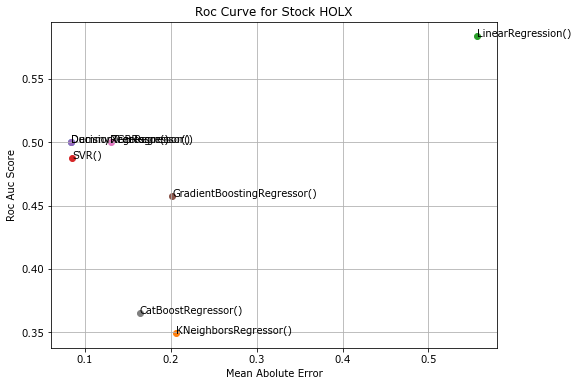

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 83.56it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'strategy': 'median'}
  Backtesting metric: 0.0003951498226167463



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
  Backtesting metric: 2.242137983600594e-11

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 28.64it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'copy_X': True, 'fit_intercept': True}
  Backtesting metric: 0.002425475690265834

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'C': 1, 'coef0': 0.5, 'degree': 8, 'gamma': 'auto', 'kernel': 'linear'}
  Backtesting metric: 6.450950969098571e-07

Number of models compared: 1920.


loop param_grid:  85%|███████████████████████████▉     | 325/384 [00:01<00:00, 164.48it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 80, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
  Backtesting metric: 5.1410836638673606e-08

Number of models compared: 540.


loop param_grid:  71%|████████████████████████▉          | 77/108 [00:05<00:01, 20.39it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:34<00:00,  6.82s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
  Backtesting metric: 9.346649451329302e-11

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:33:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:08, 10.96it/s]

[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:08, 10.69it/s]


[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  11%|████▏                               | 11/96 [00:01<00:08, 10.55it/s]

[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:08, 10.21it/s]


[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.67it/s]


[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.50it/s]

[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.02it/s]


[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07, 10.31it/s]

[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.58it/s]

[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.71it/s]


[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:06, 10.55it/s]

[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:05, 10.69it/s]

[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.55it/s]

[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.29it/s]


[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.75it/s]

[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:04, 10.90it/s]


[14:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.67it/s]

[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.75it/s]

[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:05<00:04, 10.10it/s]

[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:04, 10.24it/s]


[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.29it/s]

[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.96it/s]

[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03,  9.79it/s]


[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.82it/s]

[14:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02, 10.01it/s]

[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.50it/s]

[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.80it/s]

[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:02, 10.27it/s]

[14:33:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.95it/s]

[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  83%|██████████████████████████████      | 80/96 [00:07<00:01,  9.50it/s]

[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01, 10.53it/s]

[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:08<00:01, 10.10it/s]

[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:08<00:00,  8.97it/s]

[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.04it/s]

[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.73it/s]

[14:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  20%|███████▊                               | 1/5 [00:09<00:38,  9.54s/it]

[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 14.21it/s]

[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:08, 11.32it/s]

[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 10.99it/s]

[14:33:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 10.58it/s]

[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.52it/s]


[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.55it/s]


[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.59it/s]


[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:07, 10.34it/s]


[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07, 10.34it/s]


[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 10.33it/s]


[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 10.78it/s]

[14:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:05, 11.05it/s]

[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.98it/s]

[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.83it/s]


[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 11.03it/s]


[14:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.73it/s]


[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 10.74it/s]

[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.32it/s]


[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.36it/s]

[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.24it/s]


[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:04, 10.28it/s]

[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  9.14it/s]

[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.69it/s]

[14:33:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.22it/s]

[14:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:06<00:03,  9.17it/s]


[14:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.25it/s]

[14:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:03,  9.34it/s]


[14:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.14it/s]

[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:07<00:02,  9.13it/s]


[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.22it/s]

[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.64it/s]

[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.11it/s]

[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:08<00:01,  9.33it/s]

[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01, 10.19it/s]

[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.98it/s]

[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 88/96 [00:08<00:00,  8.99it/s]

[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:09<00:00,  9.54it/s]


[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  96%|██████████████████████████████████▌ | 92/96 [00:09<00:00,  8.14it/s]

[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00,  9.20it/s]


[14:33:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 13.55it/s]


[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.68it/s]

[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.14it/s]

[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 10.73it/s]


[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 10.58it/s]


[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.34it/s]

[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.08it/s]

[14:33:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:02<00:07,  9.77it/s]

[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07,  9.72it/s]


[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  25%|█████████                           | 24/96 [00:02<00:08,  8.54it/s]

[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  29%|██████████▌                         | 28/96 [00:02<00:07,  9.50it/s]

[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:03<00:06, 10.32it/s]

[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████                        | 32/96 [00:03<00:06,  9.27it/s]

[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  38%|█████████████▌                      | 36/96 [00:03<00:06,  9.27it/s]

[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.81it/s]

[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.69it/s]

[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:04, 10.72it/s]


[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.57it/s]

[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.52it/s]

[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.18it/s]

[14:33:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:05<00:04,  9.85it/s]


[14:33:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  58%|█████████████████████               | 56/96 [00:05<00:04,  8.79it/s]

[14:33:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03,  9.68it/s]

[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:06<00:04,  8.24it/s]

[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  8.44it/s]

[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:03,  9.37it/s]

[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  8.04it/s]

[14:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████         | 72/96 [00:07<00:02,  8.51it/s]

[14:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:02,  9.58it/s]

[14:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  79%|████████████████████████████▌       | 76/96 [00:07<00:02,  8.41it/s]

[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 80/96 [00:08<00:01,  8.50it/s]

[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  85%|██████████████████████████████▊     | 82/96 [00:08<00:01, 10.39it/s]

[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  88%|███████████████████████████████▌    | 84/96 [00:08<00:01,  8.07it/s]

[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:08<00:00,  9.24it/s]

[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:09<00:00,  9.16it/s]


[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:09<00:00,  9.24it/s]

[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  98%|███████████████████████████████████▎| 94/96 [00:09<00:00,  9.60it/s]

[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   2%|▊                                    | 2/96 [00:00<00:04, 19.28it/s]

[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   4%|█▌                                   | 4/96 [00:00<00:10,  9.17it/s]

[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.51it/s]

[14:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 11.40it/s]

[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 10.73it/s]

[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.80it/s]


[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.57it/s]

[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:07, 10.00it/s]


[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:07, 10.04it/s]


[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  24%|████████▋                           | 23/96 [00:02<00:07, 10.09it/s]


[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:07, 10.08it/s]


[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 10.10it/s]


[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:06, 10.33it/s]

[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:03<00:06,  9.96it/s]

[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 10.27it/s]

[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.19it/s]


[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.36it/s]


[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  45%|████████████████▏                   | 43/96 [00:04<00:04, 10.75it/s]

[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.74it/s]

[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:04<00:04, 10.73it/s]

[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.38it/s]


[14:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.22it/s]


[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:05<00:03, 10.37it/s]

[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 10.11it/s]

[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  62%|██████████████████████▌             | 60/96 [00:05<00:04,  8.68it/s]

[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:06<00:03,  9.89it/s]

[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████            | 64/96 [00:06<00:03,  9.03it/s]

[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  71%|█████████████████████████▌          | 68/96 [00:06<00:03,  9.10it/s]

[14:33:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.61it/s]

[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:07<00:02, 10.53it/s]

[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:07<00:01, 10.70it/s]


[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 10.65it/s]

[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.83it/s]


[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:08<00:01, 11.04it/s]


[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:08<00:00, 11.02it/s]

[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00, 11.00it/s]


[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 11.02it/s]


[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:09<00:00, 11.12it/s]

[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:05, 17.19it/s]

[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 14.76it/s]


[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 13.14it/s]

[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:00<00:06, 13.16it/s]

[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.91it/s]

[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:05, 13.10it/s]

[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:01<00:05, 13.01it/s]

[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 13.06it/s]

[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:04, 12.75it/s]

[14:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:02<00:04, 12.62it/s]

[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 12.03it/s]

[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 12.17it/s]

[14:34:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  49%|█████████████████▋                  | 47/96 [00:03<00:04, 12.14it/s]

[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:03<00:03, 12.02it/s]

[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 11.25it/s]


[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.23it/s]


[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 10.94it/s]


[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:04<00:03, 11.21it/s]

[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  64%|██████████████████████▉             | 61/96 [00:04<00:03, 10.91it/s]


[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.37it/s]


[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.51it/s]

[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:05<00:02, 11.34it/s]


[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:05<00:01, 11.87it/s]

[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.54it/s]

[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:06<00:01, 11.90it/s]

[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:06<00:01, 11.19it/s]

[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:00, 11.20it/s]


[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.48it/s]

[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:07<00:00, 11.62it/s]

[14:34:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:46<00:00,  9.36s/it]


[14:34:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.4}
  Backtesting metric: 0.005742634539348857

Number of models compared: 60.


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]


0:	learn: 0.2522798	total: 954us	remaining: 27.7ms
1:	learn: 0.2440643	total: 1.92ms	remaining: 26.8ms
2:	learn: 0.2367184	total: 2.79ms	remaining: 25.1ms
3:	learn: 0.2287866	total: 3.62ms	remaining: 23.5ms
4:	learn: 0.2211713	total: 4.45ms	remaining: 22.3ms
5:	learn: 0.2141101	total: 5.29ms	remaining: 21.2ms
6:	learn: 0.2068770	total: 6.21ms	remaining: 20.4ms
7:	learn: 0.2005963	total: 7.11ms	remaining: 19.6ms
8:	learn: 0.1945020	total: 7.8ms	remaining: 18.2ms
9:	learn: 0.1883638	total: 8.64ms	remaining: 17.3ms
10:	learn: 0.1818163	total: 9.43ms	remaining: 16.3ms
11:	learn: 0.1759345	total: 10.2ms	remaining: 15.3ms
12:	learn: 0.1704564	total: 11.2ms	remaining: 14.7ms
13:	learn: 0.1650480	total: 12ms	remaining: 13.7ms
14:	learn: 0.1604406	total: 12.7ms	remaining: 12.7ms
15:	learn: 0.1563018	total: 13.5ms	remaining: 11.8ms
16:	learn: 0.1514992	total: 14.5ms	remaining: 11.1ms
17:	learn: 0.1472627	total: 15.4ms	remaining: 10.2ms
18:	learn: 0.1433655	total: 16.3ms	remaining: 9.43ms
19:	lea

loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.26it/s]

0:	learn: 0.2522798	total: 1.03ms	remaining: 50.6ms
1:	learn: 0.2440643	total: 1.76ms	remaining: 42.3ms
2:	learn: 0.2367184	total: 2.52ms	remaining: 39.5ms
3:	learn: 0.2287866	total: 3.31ms	remaining: 38.1ms


4:	learn: 0.2211713	total: 4.54ms	remaining: 40.8ms
5:	learn: 0.2141101	total: 5.32ms	remaining: 39ms
6:	learn: 0.2068770	total: 6.18ms	remaining: 38ms
7:	learn: 0.2005963	total: 6.93ms	remaining: 36.4ms
8:	learn: 0.1945020	total: 7.69ms	remaining: 35ms
9:	learn: 0.1883638	total: 8.54ms	remaining: 34.2ms
10:	learn: 0.1818163	total: 9.4ms	remaining: 33.3ms
11:	learn: 0.1759345	total: 10.2ms	remaining: 32.4ms
12:	learn: 0.1704564	total: 11ms	remaining: 31.3ms
13:	learn: 0.1650480	total: 11.9ms	remaining: 30.5ms
14:	learn: 0.1604406	total: 12.8ms	remaining: 29.8ms
15:	learn: 0.1563018	total: 13.5ms	remaining: 28.8ms
16:	learn: 0.1514992	total: 14.4ms	remaining: 27.9ms
17:	learn: 0.1472627	total: 15.1ms	remaining: 26.9ms
18:	learn: 0.1433655	total: 15.9ms	remaining: 25.9ms
19:	learn: 0.1393340	total: 17ms	remaining: 25.6ms
20:	learn: 0.1353552	total: 17.8ms	remaining: 24.6ms
21:	learn: 0.1314845	total: 18.7ms	remaining: 23.8ms
22:	learn: 0.1272261	total: 19.7ms	remaining: 23.1ms
23:	learn:

loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  9.86it/s]

0:	learn: 0.2525053	total: 2.15ms	remaining: 62.3ms



loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  9.42it/s]

1:	learn: 0.2439865	total: 4.13ms	remaining: 57.8ms
2:	learn: 0.2360969	total: 4.62ms	remaining: 41.6ms
3:	learn: 0.2282572	total: 6.05ms	remaining: 39.3ms
4:	learn: 0.2213052	total: 7.55ms	remaining: 37.7ms
5:	learn: 0.2139405	total: 9.71ms	remaining: 38.8ms
6:	learn: 0.2071637	total: 11.3ms	remaining: 37.1ms
7:	learn: 0.2004060	total: 13.5ms	remaining: 37ms
8:	learn: 0.1942469	total: 15.4ms	remaining: 36ms
9:	learn: 0.1873951	total: 16.4ms	remaining: 32.8ms
10:	learn: 0.1816516	total: 17.8ms	remaining: 30.7ms
11:	learn: 0.1755027	total: 19.6ms	remaining: 29.4ms
12:	learn: 0.1706768	total: 21.6ms	remaining: 28.2ms
13:	learn: 0.1653590	total: 23.5ms	remaining: 26.8ms
14:	learn: 0.1601059	total: 25.1ms	remaining: 25.1ms
15:	learn: 0.1552562	total: 27ms	remaining: 23.6ms
16:	learn: 0.1507410	total: 28.5ms	remaining: 21.8ms
17:	learn: 0.1462148	total: 30.2ms	remaining: 20.1ms
18:	learn: 0.1424438	total: 31.7ms	remaining: 18.3ms
19:	learn: 0.1380955	total: 33.3ms	remaining: 16.7ms
20:	lear


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  8.68it/s]

24:	learn: 0.0629585	total: 48.3ms	remaining: 9.65ms
25:	learn: 0.0605711	total: 50.7ms	remaining: 7.8ms
26:	learn: 0.0584036	total: 52.5ms	remaining: 5.83ms
27:	learn: 0.0561584	total: 54.4ms	remaining: 3.89ms
28:	learn: 0.0541911	total: 55.3ms	remaining: 1.91ms
29:	learn: 0.0523253	total: 57.5ms	remaining: 0us
0:	learn: 0.2525053	total: 2.03ms	remaining: 99.7ms
1:	learn: 0.2439865	total: 3.72ms	remaining: 89.2ms
2:	learn: 0.2360969	total: 4.45ms	remaining: 69.6ms
3:	learn: 0.2282572	total: 7.5ms	remaining: 86.2ms
4:	learn: 0.2213052	total: 9.25ms	remaining: 83.2ms
5:	learn: 0.2139405	total: 11.4ms	remaining: 83.3ms
6:	learn: 0.2071637	total: 13.3ms	remaining: 81.9ms
7:	learn: 0.2004060	total: 15.4ms	remaining: 80.9ms
8:	learn: 0.1942469	total: 17.7ms	remaining: 80.5ms
9:	learn: 0.1873951	total: 19.2ms	remaining: 77ms
10:	learn: 0.1816516	total: 21.6ms	remaining: 76.4ms
11:	learn: 0.1755027	total: 23.9ms	remaining: 75.8ms
12:	learn: 0.1706768	total: 26.6ms	remaining: 75.6ms
13:	learn:


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  7.33it/s]


40:	learn: 0.0781763	total: 75.3ms	remaining: 16.5ms
41:	learn: 0.0764070	total: 76.9ms	remaining: 14.6ms
42:	learn: 0.0746323	total: 78.7ms	remaining: 12.8ms
43:	learn: 0.0732348	total: 80ms	remaining: 10.9ms
44:	learn: 0.0716331	total: 81.6ms	remaining: 9.06ms
45:	learn: 0.0702229	total: 82.8ms	remaining: 7.2ms
46:	learn: 0.0688399	total: 84.2ms	remaining: 5.37ms
47:	learn: 0.0674956	total: 85.7ms	remaining: 3.57ms
48:	learn: 0.0661618	total: 87.1ms	remaining: 1.78ms
49:	learn: 0.0648660	total: 88.7ms	remaining: 0us
0:	learn: 0.2440052	total: 1.74ms	remaining: 85.1ms
1:	learn: 0.2276501	total: 3.44ms	remaining: 82.6ms
2:	learn: 0.2131743	total: 3.92ms	remaining: 61.4ms
3:	learn: 0.1993101	total: 5.38ms	remaining: 61.9ms
4:	learn: 0.1873971	total: 7.03ms	remaining: 63.2ms
5:	learn: 0.1753739	total: 9.32ms	remaining: 68.3ms
6:	learn: 0.1647394	total: 10.7ms	remaining: 66ms
7:	learn: 0.1547235	total: 12.3ms	remaining: 64.3ms
8:	learn: 0.1459007	total: 13.7ms	remaining: 62.4ms
9:	learn: 

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.12it/s]

0:	learn: 0.2530859	total: 5.84ms	remaining: 169ms
1:	learn: 0.2448688	total: 10.3ms	remaining: 145ms
2:	learn: 0.2376229	total: 16.4ms	remaining: 147ms
3:	learn: 0.2300628	total: 21.4ms	remaining: 139ms
4:	learn: 0.2219964	total: 23.9ms	remaining: 119ms
5:	learn: 0.2150341	total: 28.6ms	remaining: 114ms
6:	learn: 0.2088626	total: 33.2ms	remaining: 109ms
7:	learn: 0.2012681	total: 34.3ms	remaining: 94.2ms
8:	learn: 0.1943373	total: 36.7ms	remaining: 85.5ms
9:	learn: 0.1885389	total: 42.7ms	remaining: 85.4ms
10:	learn: 0.1829706	total: 48.5ms	remaining: 83.8ms
11:	learn: 0.1778875	total: 53.9ms	remaining: 80.9ms
12:	learn: 0.1731835	total: 59.4ms	remaining: 77.7ms
13:	learn: 0.1682883	total: 63.7ms	remaining: 72.8ms
14:	learn: 0.1629763	total: 66.2ms	remaining: 66.2ms
15:	learn: 0.1590271	total: 71.2ms	remaining: 62.3ms
16:	learn: 0.1547193	total: 76.3ms	remaining: 58.3ms
17:	learn: 0.1501466	total: 80.6ms	remaining: 53.7ms
18:	learn: 0.1456131	total: 82.1ms	remaining: 47.5ms
19:	learn:


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.58it/s]

1:	learn: 0.2293371	total: 11.8ms	remaining: 165ms
2:	learn: 0.2158183	total: 17.1ms	remaining: 154ms
3:	learn: 0.2022486	total: 21.6ms	remaining: 141ms
4:	learn: 0.1882961	total: 24.2ms	remaining: 121ms
5:	learn: 0.1769704	total: 28.5ms	remaining: 114ms
6:	learn: 0.1670862	total: 33.9ms	remaining: 111ms
7:	learn: 0.1553347	total: 34.9ms	remaining: 95.9ms
8:	learn: 0.1450340	total: 36.1ms	remaining: 84.2ms
9:	learn: 0.1359400	total: 41ms	remaining: 81.9ms
10:	learn: 0.1276420	total: 42.8ms	remaining: 73.9ms
11:	learn: 0.1204387	total: 51.2ms	remaining: 76.8ms
12:	learn: 0.1132612	total: 57.6ms	remaining: 75.4ms
13:	learn: 0.1068661	total: 63.4ms	remaining: 72.4ms
14:	learn: 0.1005046	total: 69.4ms	remaining: 69.4ms
15:	learn: 0.0952659	total: 74ms	remaining: 64.8ms
16:	learn: 0.0906105	total: 78.6ms	remaining: 60.1ms
17:	learn: 0.0856079	total: 79.7ms	remaining: 53.2ms
18:	learn: 0.0817581	total: 85.1ms	remaining: 49.3ms
19:	learn: 0.0776018	total: 90.2ms	remaining: 45.1ms
20:	learn: 0

24:	learn: 0.1227277	total: 168ms	remaining: 168ms
25:	learn: 0.1190703	total: 174ms	remaining: 161ms
26:	learn: 0.1159430	total: 180ms	remaining: 154ms
27:	learn: 0.1127312	total: 189ms	remaining: 148ms
28:	learn: 0.1100460	total: 195ms	remaining: 142ms
29:	learn: 0.1069784	total: 196ms	remaining: 131ms
30:	learn: 0.1045164	total: 203ms	remaining: 124ms
31:	learn: 0.1017817	total: 211ms	remaining: 119ms
32:	learn: 0.0995564	total: 218ms	remaining: 112ms
33:	learn: 0.0973029	total: 221ms	remaining: 104ms
34:	learn: 0.0947475	total: 227ms	remaining: 97.3ms
35:	learn: 0.0922303	total: 234ms	remaining: 90.9ms
36:	learn: 0.0901826	total: 243ms	remaining: 85.5ms
37:	learn: 0.0879541	total: 249ms	remaining: 78.7ms
38:	learn: 0.0856924	total: 255ms	remaining: 71.9ms
39:	learn: 0.0835756	total: 261ms	remaining: 65.2ms
40:	learn: 0.0816426	total: 269ms	remaining: 59ms
41:	learn: 0.0799686	total: 276ms	remaining: 52.6ms
42:	learn: 0.0780349	total: 281ms	remaining: 45.7ms
43:	learn: 0.0762166	tot

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  3.88it/s]

0:	learn: 0.2451601	total: 5.7ms	remaining: 279ms
1:	learn: 0.2293371	total: 12ms	remaining: 287ms
2:	learn: 0.2158183	total: 19.2ms	remaining: 301ms
3:	learn: 0.2022486	total: 25ms	remaining: 287ms
4:	learn: 0.1882961	total: 27.7ms	remaining: 250ms
5:	learn: 0.1769704	total: 32.6ms	remaining: 239ms
6:	learn: 0.1670862	total: 37.1ms	remaining: 228ms
7:	learn: 0.1553347	total: 38.3ms	remaining: 201ms
8:	learn: 0.1450340	total: 39.6ms	remaining: 180ms
9:	learn: 0.1359400	total: 45.3ms	remaining: 181ms
10:	learn: 0.1276420	total: 47.5ms	remaining: 168ms
11:	learn: 0.1204387	total: 53.1ms	remaining: 168ms
12:	learn: 0.1132612	total: 59.1ms	remaining: 168ms
13:	learn: 0.1068661	total: 64.1ms	remaining: 165ms
14:	learn: 0.1005046	total: 69.5ms	remaining: 162ms
15:	learn: 0.0952659	total: 75ms	remaining: 159ms
16:	learn: 0.0906105	total: 81.1ms	remaining: 157ms
17:	learn: 0.0856079	total: 82.1ms	remaining: 146ms
18:	learn: 0.0817581	total: 86.4ms	remaining: 141ms
19:	learn: 0.0776018	total: 9


loop lags_grid:  20%|███████▊                               | 1/5 [00:02<00:08,  2.20s/it]

35:	learn: 0.0403958	total: 160ms	remaining: 62ms
36:	learn: 0.0390844	total: 166ms	remaining: 58.3ms
37:	learn: 0.0378856	total: 172ms	remaining: 54.4ms
38:	learn: 0.0366439	total: 177ms	remaining: 50ms
39:	learn: 0.0354889	total: 182ms	remaining: 45.5ms
40:	learn: 0.0343314	total: 187ms	remaining: 41ms
41:	learn: 0.0330947	total: 192ms	remaining: 36.6ms
42:	learn: 0.0320626	total: 197ms	remaining: 32.1ms
43:	learn: 0.0312905	total: 198ms	remaining: 27ms
44:	learn: 0.0304036	total: 203ms	remaining: 22.5ms
45:	learn: 0.0295263	total: 208ms	remaining: 18.1ms
46:	learn: 0.0287817	total: 214ms	remaining: 13.6ms
47:	learn: 0.0280425	total: 219ms	remaining: 9.11ms
48:	learn: 0.0274560	total: 223ms	remaining: 4.55ms
49:	learn: 0.0266662	total: 227ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2339761	total: 1.24ms	remaining: 36ms
1:	learn: 0.2261139	total: 2.08ms	remaining: 29.1ms
2:	learn: 0.2192277	total: 3.06ms	remaining: 27.5ms
3:	learn: 0.2121416	total: 4.01ms	remaining: 26.1ms
4:	learn: 0.2055070	total: 4.9ms	remaining: 24.5ms
5:	learn: 0.1985157	total: 6ms	remaining: 24ms
6:	learn: 0.1925691	total: 6.86ms	remaining: 22.6ms
7:	learn: 0.1870836	total: 7.85ms	remaining: 21.6ms
8:	learn: 0.1814572	total: 8.96ms	remaining: 20.9ms
9:	learn: 0.1759590	total: 9.56ms	remaining: 19.1ms
10:	learn: 0.1699416	total: 11ms	remaining: 18.9ms
11:	learn: 0.1651262	total: 11.9ms	remaining: 17.9ms
12:	learn: 0.1606056	total: 13ms	remaining: 17ms
13:	learn: 0.1560666	total: 14.1ms	remaining: 16.1ms
14:	learn: 0.1512198	total: 14.7ms	remaining: 14.7ms
15:	learn: 0.1467325	total: 15.6ms	remaining: 13.7ms
16:	learn: 0.1430345	total: 16.6ms	remaining: 12.7ms
17:	learn: 0.1387635	total: 17.5ms	remaining: 11.7ms
18:	learn: 0.1348007	total: 18.4ms	remaining: 10.6ms
19:	learn: 0.1309


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  9.87it/s]

25:	learn: 0.1114028	total: 25.4ms	remaining: 3.91ms
26:	learn: 0.1085394	total: 26.6ms	remaining: 2.95ms
27:	learn: 0.1058780	total: 27.5ms	remaining: 1.97ms
28:	learn: 0.1034994	total: 28.5ms	remaining: 983us
29:	learn: 0.1007889	total: 29.7ms	remaining: 0us
0:	learn: 0.2267793	total: 1.68ms	remaining: 48.6ms
1:	learn: 0.2116468	total: 2.62ms	remaining: 36.6ms
2:	learn: 0.1989438	total: 3.56ms	remaining: 32ms
3:	learn: 0.1862420	total: 4.48ms	remaining: 29.1ms
4:	learn: 0.1749117	total: 5.51ms	remaining: 27.6ms
5:	learn: 0.1634621	total: 6.51ms	remaining: 26.1ms
6:	learn: 0.1542017	total: 7.34ms	remaining: 24.1ms
7:	learn: 0.1460895	total: 8.26ms	remaining: 22.7ms
8:	learn: 0.1379029	total: 9.2ms	remaining: 21.5ms
9:	learn: 0.1307178	total: 10.2ms	remaining: 20.3ms
10:	learn: 0.1239745	total: 10.5ms	remaining: 18.1ms
11:	learn: 0.1166393	total: 11.4ms	remaining: 17.2ms
12:	learn: 0.1098713	total: 12.4ms	remaining: 16.2ms
13:	learn: 0.1051260	total: 13.2ms	remaining: 15.1ms
14:	learn:


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:00,  9.04it/s]

17:	learn: 0.1387635	total: 16.9ms	remaining: 30ms
18:	learn: 0.1348007	total: 17.9ms	remaining: 29.3ms
19:	learn: 0.1309502	total: 19.1ms	remaining: 28.6ms
20:	learn: 0.1276282	total: 19.9ms	remaining: 27.5ms
21:	learn: 0.1241230	total: 21.1ms	remaining: 26.9ms
22:	learn: 0.1208367	total: 22.3ms	remaining: 26.1ms
23:	learn: 0.1173673	total: 23.2ms	remaining: 25.1ms
24:	learn: 0.1141706	total: 24ms	remaining: 24ms
25:	learn: 0.1114028	total: 24.8ms	remaining: 22.9ms
26:	learn: 0.1085394	total: 25.7ms	remaining: 21.9ms
27:	learn: 0.1058780	total: 26.5ms	remaining: 20.8ms
28:	learn: 0.1034994	total: 27.3ms	remaining: 19.8ms
29:	learn: 0.1007889	total: 28.1ms	remaining: 18.7ms
30:	learn: 0.0981315	total: 29ms	remaining: 17.8ms
31:	learn: 0.0955316	total: 29.9ms	remaining: 16.8ms
32:	learn: 0.0932151	total: 30.6ms	remaining: 15.8ms
33:	learn: 0.0910403	total: 31.2ms	remaining: 14.7ms
34:	learn: 0.0888047	total: 31.9ms	remaining: 13.7ms
35:	learn: 0.0866067	total: 32.5ms	remaining: 12.7ms
3

39:	learn: 0.0419944	total: 35.1ms	remaining: 8.79ms
40:	learn: 0.0411351	total: 36.1ms	remaining: 7.93ms
41:	learn: 0.0400718	total: 37ms	remaining: 7.04ms
42:	learn: 0.0392243	total: 37.7ms	remaining: 6.14ms
43:	learn: 0.0385216	total: 38.4ms	remaining: 5.24ms
44:	learn: 0.0378414	total: 39.2ms	remaining: 4.35ms
45:	learn: 0.0366952	total: 39.9ms	remaining: 3.46ms
46:	learn: 0.0358897	total: 40.5ms	remaining: 2.58ms
47:	learn: 0.0347235	total: 41.2ms	remaining: 1.72ms
48:	learn: 0.0340605	total: 41.8ms	remaining: 854us
49:	learn: 0.0332128	total: 42.6ms	remaining: 0us


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  7.82it/s]

0:	learn: 0.2347123	total: 2.48ms	remaining: 72ms
1:	learn: 0.2281678	total: 4.56ms	remaining: 63.8ms
2:	learn: 0.2214416	total: 7.68ms	remaining: 69.2ms
3:	learn: 0.2142480	total: 8.46ms	remaining: 55ms
4:	learn: 0.2076384	total: 10.4ms	remaining: 52.2ms
5:	learn: 0.2018363	total: 12.3ms	remaining: 49ms
6:	learn: 0.1963308	total: 14.2ms	remaining: 46.7ms
7:	learn: 0.1902104	total: 15.7ms	remaining: 43.1ms
8:	learn: 0.1849431	total: 17.5ms	remaining: 40.9ms
9:	learn: 0.1786228	total: 19.8ms	remaining: 39.6ms
10:	learn: 0.1733859	total: 20.5ms	remaining: 35.4ms
11:	learn: 0.1683056	total: 22.3ms	remaining: 33.5ms
12:	learn: 0.1638395	total: 24.1ms	remaining: 31.6ms
13:	learn: 0.1595588	total: 26ms	remaining: 29.7ms
14:	learn: 0.1556231	total: 27.8ms	remaining: 27.8ms
15:	learn: 0.1511954	total: 30.3ms	remaining: 26.5ms
16:	learn: 0.1469988	total: 32.7ms	remaining: 25ms
17:	learn: 0.1433563	total: 35.1ms	remaining: 23.4ms
18:	learn: 0.1390890	total: 37.5ms	remaining: 21.7ms
19:	learn: 0.


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.85it/s]

7:	learn: 0.1485397	total: 25.2ms	remaining: 69.2ms
8:	learn: 0.1407916	total: 29.4ms	remaining: 68.6ms
9:	learn: 0.1317563	total: 33ms	remaining: 65.9ms
10:	learn: 0.1248419	total: 34.2ms	remaining: 59.1ms
11:	learn: 0.1180228	total: 37ms	remaining: 55.4ms
12:	learn: 0.1122437	total: 40ms	remaining: 52.3ms
13:	learn: 0.1068849	total: 42.7ms	remaining: 48.8ms
14:	learn: 0.1023622	total: 45.4ms	remaining: 45.4ms
15:	learn: 0.0974383	total: 48.4ms	remaining: 42.3ms
16:	learn: 0.0926807	total: 51.4ms	remaining: 39.3ms
17:	learn: 0.0888605	total: 55.7ms	remaining: 37.2ms
18:	learn: 0.0846491	total: 58.3ms	remaining: 33.7ms
19:	learn: 0.0814752	total: 61ms	remaining: 30.5ms
20:	learn: 0.0774920	total: 63.9ms	remaining: 27.4ms
21:	learn: 0.0746829	total: 67ms	remaining: 24.4ms
22:	learn: 0.0713766	total: 70.3ms	remaining: 21.4ms
23:	learn: 0.0684014	total: 73.2ms	remaining: 18.3ms
24:	learn: 0.0653342	total: 76.6ms	remaining: 15.3ms
25:	learn: 0.0632312	total: 80.1ms	remaining: 12.3ms
26:	le


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.84it/s]

10:	learn: 0.1733859	total: 28.9ms	remaining: 103ms
11:	learn: 0.1683056	total: 32.3ms	remaining: 102ms
12:	learn: 0.1638395	total: 35.6ms	remaining: 101ms
13:	learn: 0.1595588	total: 38.3ms	remaining: 98.5ms
14:	learn: 0.1556231	total: 41.1ms	remaining: 96ms
15:	learn: 0.1511954	total: 43.8ms	remaining: 93ms
16:	learn: 0.1469988	total: 46.6ms	remaining: 90.4ms
17:	learn: 0.1433563	total: 50.6ms	remaining: 90ms
18:	learn: 0.1390890	total: 55ms	remaining: 89.7ms
19:	learn: 0.1354137	total: 56.1ms	remaining: 84.2ms
20:	learn: 0.1318721	total: 58.7ms	remaining: 81.1ms
21:	learn: 0.1284459	total: 60.8ms	remaining: 77.4ms
22:	learn: 0.1247068	total: 61.8ms	remaining: 72.6ms
23:	learn: 0.1214048	total: 64.6ms	remaining: 70ms
24:	learn: 0.1182797	total: 67.3ms	remaining: 67.3ms
25:	learn: 0.1152789	total: 70.4ms	remaining: 65ms
26:	learn: 0.1125323	total: 72.6ms	remaining: 61.8ms
27:	learn: 0.1094014	total: 75.2ms	remaining: 59.1ms
28:	learn: 0.1065334	total: 77.8ms	remaining: 56.3ms
29:	lear


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.69it/s]

3:	learn: 0.1902521	total: 8.67ms	remaining: 99.7ms
4:	learn: 0.1787274	total: 10.9ms	remaining: 98.2ms
5:	learn: 0.1686487	total: 13ms	remaining: 95.7ms
6:	learn: 0.1589475	total: 15.2ms	remaining: 93.6ms
7:	learn: 0.1485397	total: 15.8ms	remaining: 82.8ms
8:	learn: 0.1407916	total: 17.5ms	remaining: 79.6ms
9:	learn: 0.1317563	total: 19.2ms	remaining: 76.7ms
10:	learn: 0.1248419	total: 19.8ms	remaining: 70.1ms
11:	learn: 0.1180228	total: 21.2ms	remaining: 67.2ms
12:	learn: 0.1122437	total: 23ms	remaining: 65.5ms
13:	learn: 0.1068849	total: 25ms	remaining: 64.4ms
14:	learn: 0.1023622	total: 27.5ms	remaining: 64.2ms
15:	learn: 0.0974383	total: 29.4ms	remaining: 62.5ms
16:	learn: 0.0926807	total: 31.3ms	remaining: 60.8ms
17:	learn: 0.0888605	total: 33.3ms	remaining: 59.2ms
18:	learn: 0.0846491	total: 35.6ms	remaining: 58.1ms
19:	learn: 0.0814752	total: 37.4ms	remaining: 56.1ms
20:	learn: 0.0774920	total: 39.2ms	remaining: 54.2ms
21:	learn: 0.0746829	total: 41.2ms	remaining: 52.4ms
22:	le

2:	learn: 0.2219467	total: 21.1ms	remaining: 190ms
3:	learn: 0.2156524	total: 26.7ms	remaining: 174ms
4:	learn: 0.2100581	total: 32ms	remaining: 160ms
5:	learn: 0.2040027	total: 37.5ms	remaining: 150ms
6:	learn: 0.1987566	total: 43.3ms	remaining: 142ms
7:	learn: 0.1920201	total: 45.2ms	remaining: 124ms
8:	learn: 0.1862859	total: 45.8ms	remaining: 107ms
9:	learn: 0.1811252	total: 52.1ms	remaining: 104ms
10:	learn: 0.1758970	total: 58.6ms	remaining: 101ms
11:	learn: 0.1709566	total: 64.2ms	remaining: 96.3ms
12:	learn: 0.1665399	total: 70.1ms	remaining: 91.7ms
13:	learn: 0.1620459	total: 73.2ms	remaining: 83.7ms
14:	learn: 0.1575217	total: 79.1ms	remaining: 79.1ms
15:	learn: 0.1536646	total: 84.7ms	remaining: 74.1ms
16:	learn: 0.1493002	total: 90.3ms	remaining: 69.1ms
17:	learn: 0.1454907	total: 96.2ms	remaining: 64.1ms
18:	learn: 0.1415943	total: 103ms	remaining: 59.4ms
19:	learn: 0.1380519	total: 109ms	remaining: 54.3ms
20:	learn: 0.1349630	total: 115ms	remaining: 49.1ms
21:	learn: 0.13

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.11it/s]

0:	learn: 0.2288767	total: 8.13ms	remaining: 236ms
1:	learn: 0.2172107	total: 15.1ms	remaining: 212ms
2:	learn: 0.2039692	total: 20.3ms	remaining: 183ms
3:	learn: 0.1926149	total: 25.9ms	remaining: 168ms
4:	learn: 0.1827606	total: 31.2ms	remaining: 156ms
5:	learn: 0.1726227	total: 36.7ms	remaining: 147ms
6:	learn: 0.1640309	total: 42.2ms	remaining: 139ms
7:	learn: 0.1545806	total: 47.8ms	remaining: 131ms
8:	learn: 0.1457001	total: 56ms	remaining: 131ms
9:	learn: 0.1376296	total: 62.3ms	remaining: 125ms
10:	learn: 0.1303667	total: 69ms	remaining: 119ms
11:	learn: 0.1242228	total: 74.8ms	remaining: 112ms
12:	learn: 0.1178779	total: 80.7ms	remaining: 106ms
13:	learn: 0.1121091	total: 87.3ms	remaining: 99.8ms
14:	learn: 0.1069905	total: 93.4ms	remaining: 93.4ms
15:	learn: 0.1016207	total: 101ms	remaining: 88.1ms
16:	learn: 0.0972588	total: 107ms	remaining: 81.7ms
17:	learn: 0.0925843	total: 113ms	remaining: 75.6ms
18:	learn: 0.0883106	total: 119ms	remaining: 69.1ms
19:	learn: 0.0841491	tot


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.56it/s]

28:	learn: 0.0576415	total: 181ms	remaining: 6.25ms
29:	learn: 0.0559175	total: 188ms	remaining: 0us
0:	learn: 0.2350292	total: 7.14ms	remaining: 350ms
1:	learn: 0.2289983	total: 12.4ms	remaining: 298ms
2:	learn: 0.2219467	total: 18.4ms	remaining: 288ms
3:	learn: 0.2156524	total: 24.5ms	remaining: 282ms
4:	learn: 0.2100581	total: 30.8ms	remaining: 277ms
5:	learn: 0.2040027	total: 36.1ms	remaining: 265ms
6:	learn: 0.1987566	total: 41.4ms	remaining: 254ms
7:	learn: 0.1920201	total: 42.6ms	remaining: 224ms
8:	learn: 0.1862859	total: 43.2ms	remaining: 197ms
9:	learn: 0.1811252	total: 48.7ms	remaining: 195ms
10:	learn: 0.1758970	total: 53.5ms	remaining: 190ms
11:	learn: 0.1709566	total: 59.2ms	remaining: 188ms
12:	learn: 0.1665399	total: 64.8ms	remaining: 184ms
13:	learn: 0.1620459	total: 67.6ms	remaining: 174ms
14:	learn: 0.1575217	total: 73ms	remaining: 170ms
15:	learn: 0.1536646	total: 77.8ms	remaining: 165ms
16:	learn: 0.1493002	total: 82.1ms	remaining: 159ms
17:	learn: 0.1454907	total:

23:	learn: 0.1253589	total: 115ms	remaining: 125ms
24:	learn: 0.1221844	total: 120ms	remaining: 120ms
25:	learn: 0.1191955	total: 126ms	remaining: 116ms
26:	learn: 0.1159931	total: 131ms	remaining: 111ms
27:	learn: 0.1131852	total: 136ms	remaining: 107ms
28:	learn: 0.1097814	total: 139ms	remaining: 100ms
29:	learn: 0.1069613	total: 143ms	remaining: 95.6ms
30:	learn: 0.1046734	total: 158ms	remaining: 96.8ms
31:	learn: 0.1022359	total: 162ms	remaining: 91ms
32:	learn: 0.1001542	total: 168ms	remaining: 86.7ms
33:	learn: 0.0977060	total: 172ms	remaining: 80.9ms
34:	learn: 0.0957775	total: 178ms	remaining: 76.2ms
35:	learn: 0.0934388	total: 184ms	remaining: 71.4ms
36:	learn: 0.0910531	total: 184ms	remaining: 64.8ms
37:	learn: 0.0893666	total: 190ms	remaining: 60ms
38:	learn: 0.0875224	total: 195ms	remaining: 55.1ms
39:	learn: 0.0854931	total: 196ms	remaining: 49ms
40:	learn: 0.0833097	total: 201ms	remaining: 44ms
41:	learn: 0.0815062	total: 206ms	remaining: 39.2ms
42:	learn: 0.0798872	total

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.89it/s]

0:	learn: 0.2288767	total: 12.5ms	remaining: 611ms
1:	learn: 0.2172107	total: 21.7ms	remaining: 521ms
2:	learn: 0.2039692	total: 29.3ms	remaining: 459ms
3:	learn: 0.1926149	total: 37.5ms	remaining: 431ms
4:	learn: 0.1827606	total: 44ms	remaining: 396ms
5:	learn: 0.1726227	total: 50.4ms	remaining: 369ms
6:	learn: 0.1640309	total: 56.8ms	remaining: 349ms
7:	learn: 0.1545806	total: 63.5ms	remaining: 334ms
8:	learn: 0.1457001	total: 69.4ms	remaining: 316ms
9:	learn: 0.1376296	total: 77.5ms	remaining: 310ms
10:	learn: 0.1303667	total: 86.3ms	remaining: 306ms
11:	learn: 0.1242228	total: 94.6ms	remaining: 300ms
12:	learn: 0.1178779	total: 103ms	remaining: 293ms
13:	learn: 0.1121091	total: 110ms	remaining: 282ms
14:	learn: 0.1069905	total: 115ms	remaining: 269ms
15:	learn: 0.1016207	total: 121ms	remaining: 258ms
16:	learn: 0.0972588	total: 127ms	remaining: 247ms
17:	learn: 0.0925843	total: 134ms	remaining: 237ms
18:	learn: 0.0883106	total: 141ms	remaining: 229ms
19:	learn: 0.0841491	total: 147


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:04<00:07,  2.38s/it]

48:	learn: 0.0312413	total: 339ms	remaining: 6.92ms
49:	learn: 0.0304293	total: 346ms	remaining: 0us



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.46it/s]

0:	learn: 0.1923832	total: 1.13ms	remaining: 32.9ms
1:	learn: 0.1869657	total: 2.16ms	remaining: 30.2ms
2:	learn: 0.1815470	total: 3.27ms	remaining: 29.4ms
3:	learn: 0.1758251	total: 4.38ms	remaining: 28.5ms
4:	learn: 0.1704801	total: 5.78ms	remaining: 28.9ms
5:	learn: 0.1659725	total: 6.31ms	remaining: 25.2ms
6:	learn: 0.1613452	total: 7.26ms	remaining: 23.9ms
7:	learn: 0.1569630	total: 8.27ms	remaining: 22.7ms
8:	learn: 0.1520610	total: 9.29ms	remaining: 21.7ms
9:	learn: 0.1477890	total: 10.5ms	remaining: 21ms
10:	learn: 0.1436680	total: 11.7ms	remaining: 20.2ms
11:	learn: 0.1398091	total: 12.8ms	remaining: 19.2ms
12:	learn: 0.1362542	total: 14.1ms	remaining: 18.5ms
13:	learn: 0.1327832	total: 15.2ms	remaining: 17.4ms
14:	learn: 0.1287406	total: 16.4ms	remaining: 16.4ms
15:	learn: 0.1249248	total: 17.8ms	remaining: 15.6ms
16:	learn: 0.1213102	total: 19.2ms	remaining: 14.7ms
17:	learn: 0.1182010	total: 20.3ms	remaining: 13.6ms
18:	learn: 0.1152164	total: 21.5ms	remaining: 12.4ms
19:	l

3:	learn: 0.1555233	total: 4.79ms	remaining: 31.1ms
4:	learn: 0.1462388	total: 6.4ms	remaining: 32ms
5:	learn: 0.1388410	total: 6.9ms	remaining: 27.6ms
6:	learn: 0.1312633	total: 7.95ms	remaining: 26.1ms
7:	learn: 0.1238234	total: 8.85ms	remaining: 24.3ms
8:	learn: 0.1164502	total: 9.79ms	remaining: 22.9ms
9:	learn: 0.1103557	total: 11.2ms	remaining: 22.3ms
10:	learn: 0.1045948	total: 12.1ms	remaining: 21ms
11:	learn: 0.0987709	total: 13.6ms	remaining: 20.3ms
12:	learn: 0.0943226	total: 14.8ms	remaining: 19.4ms
13:	learn: 0.0901258	total: 16ms	remaining: 18.3ms
14:	learn: 0.0852852	total: 17.1ms	remaining: 17.1ms
15:	learn: 0.0811746	total: 18.1ms	remaining: 15.8ms
16:	learn: 0.0773236	total: 19.1ms	remaining: 14.6ms
17:	learn: 0.0736146	total: 20.1ms	remaining: 13.4ms
18:	learn: 0.0705674	total: 21.3ms	remaining: 12.3ms
19:	learn: 0.0672589	total: 22.2ms	remaining: 11.1ms
20:	learn: 0.0638154	total: 23.3ms	remaining: 10ms
21:	learn: 0.0614447	total: 24.4ms	remaining: 8.87ms
22:	learn:

loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  9.67it/s]


0:	learn: 0.1923832	total: 1.13ms	remaining: 55.4ms
1:	learn: 0.1869657	total: 2.03ms	remaining: 48.8ms
2:	learn: 0.1815470	total: 3.02ms	remaining: 47.4ms
3:	learn: 0.1758251	total: 3.88ms	remaining: 44.6ms
4:	learn: 0.1704801	total: 4.76ms	remaining: 42.8ms
5:	learn: 0.1659725	total: 5.21ms	remaining: 38.2ms
6:	learn: 0.1613452	total: 6.01ms	remaining: 36.9ms
7:	learn: 0.1569630	total: 7.04ms	remaining: 36.9ms
8:	learn: 0.1520610	total: 7.96ms	remaining: 36.3ms
9:	learn: 0.1477890	total: 9.19ms	remaining: 36.7ms
10:	learn: 0.1436680	total: 10.2ms	remaining: 36.1ms
11:	learn: 0.1398091	total: 11ms	remaining: 35ms
12:	learn: 0.1362542	total: 11.9ms	remaining: 33.9ms
13:	learn: 0.1327832	total: 12.9ms	remaining: 33.2ms
14:	learn: 0.1287406	total: 14ms	remaining: 32.7ms
15:	learn: 0.1249248	total: 14.9ms	remaining: 31.7ms
16:	learn: 0.1213102	total: 15.7ms	remaining: 30.5ms
17:	learn: 0.1182010	total: 16.5ms	remaining: 29.4ms
18:	learn: 0.1152164	total: 17.4ms	remaining: 28.4ms
19:	learn

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.84it/s]

0:	learn: 0.1862862	total: 1.01ms	remaining: 49.3ms
1:	learn: 0.1758395	total: 1.87ms	remaining: 44.9ms
2:	learn: 0.1657621	total: 2.82ms	remaining: 44.2ms
3:	learn: 0.1555233	total: 3.7ms	remaining: 42.5ms
4:	learn: 0.1462388	total: 4.62ms	remaining: 41.6ms
5:	learn: 0.1388410	total: 5.23ms	remaining: 38.3ms
6:	learn: 0.1312633	total: 6.31ms	remaining: 38.8ms
7:	learn: 0.1238234	total: 7.31ms	remaining: 38.4ms
8:	learn: 0.1164502	total: 8.54ms	remaining: 38.9ms
9:	learn: 0.1103557	total: 9.64ms	remaining: 38.6ms
10:	learn: 0.1045948	total: 10.6ms	remaining: 37.4ms
11:	learn: 0.0987709	total: 11.5ms	remaining: 36.6ms
12:	learn: 0.0943226	total: 12.5ms	remaining: 35.5ms
13:	learn: 0.0901258	total: 13.6ms	remaining: 34.9ms
14:	learn: 0.0852852	total: 14.6ms	remaining: 34ms
15:	learn: 0.0811746	total: 15.7ms	remaining: 33.4ms
16:	learn: 0.0773236	total: 16.8ms	remaining: 32.7ms
17:	learn: 0.0736146	total: 17.8ms	remaining: 31.7ms
18:	learn: 0.0705674	total: 18.9ms	remaining: 30.8ms
19:	le


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.39it/s]

39:	learn: 0.0335352	total: 39ms	remaining: 9.76ms
40:	learn: 0.0324756	total: 40.4ms	remaining: 8.86ms
41:	learn: 0.0315782	total: 41.7ms	remaining: 7.93ms
42:	learn: 0.0306478	total: 42.7ms	remaining: 6.95ms
43:	learn: 0.0298358	total: 43.6ms	remaining: 5.94ms
44:	learn: 0.0290116	total: 44.5ms	remaining: 4.95ms
45:	learn: 0.0284179	total: 45.6ms	remaining: 3.97ms
46:	learn: 0.0277521	total: 47ms	remaining: 3ms
47:	learn: 0.0269082	total: 47.9ms	remaining: 2ms
48:	learn: 0.0264805	total: 49ms	remaining: 1ms
49:	learn: 0.0259348	total: 50.1ms	remaining: 0us
0:	learn: 0.1932403	total: 11.4ms	remaining: 330ms
1:	learn: 0.1882685	total: 13.8ms	remaining: 193ms
2:	learn: 0.1834711	total: 15.8ms	remaining: 142ms
3:	learn: 0.1774946	total: 17.7ms	remaining: 115ms
4:	learn: 0.1731677	total: 19.6ms	remaining: 98ms
5:	learn: 0.1682605	total: 21.4ms	remaining: 85.7ms
6:	learn: 0.1643844	total: 23.2ms	remaining: 76.2ms
7:	learn: 0.1591245	total: 24.4ms	remaining: 67ms
8:	learn: 0.1543210	total: 


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.11it/s]

21:	learn: 0.1077164	total: 49.3ms	remaining: 17.9ms
22:	learn: 0.1052093	total: 51.1ms	remaining: 15.6ms
23:	learn: 0.1027792	total: 53.2ms	remaining: 13.3ms
24:	learn: 0.0996424	total: 55.2ms	remaining: 11ms
25:	learn: 0.0974173	total: 57ms	remaining: 8.77ms
26:	learn: 0.0949607	total: 59ms	remaining: 6.56ms
27:	learn: 0.0926507	total: 60.9ms	remaining: 4.35ms
28:	learn: 0.0904341	total: 62.9ms	remaining: 2.17ms
29:	learn: 0.0880332	total: 65.1ms	remaining: 0us
0:	learn: 0.1879950	total: 2.47ms	remaining: 71.7ms



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.88it/s]

1:	learn: 0.1783692	total: 5.13ms	remaining: 71.8ms
2:	learn: 0.1693709	total: 7.35ms	remaining: 66.1ms
3:	learn: 0.1585344	total: 9.34ms	remaining: 60.7ms
4:	learn: 0.1509251	total: 11.4ms	remaining: 57ms
5:	learn: 0.1425254	total: 13.3ms	remaining: 53.1ms
6:	learn: 0.1361283	total: 15.8ms	remaining: 51.9ms
7:	learn: 0.1276959	total: 17.4ms	remaining: 47.7ms
8:	learn: 0.1209676	total: 20ms	remaining: 46.6ms
9:	learn: 0.1150775	total: 22ms	remaining: 44ms
10:	learn: 0.1099759	total: 24.1ms	remaining: 41.6ms
11:	learn: 0.1044871	total: 26.2ms	remaining: 39.4ms
12:	learn: 0.0994529	total: 28.4ms	remaining: 37.1ms
13:	learn: 0.0943014	total: 30.5ms	remaining: 34.9ms
14:	learn: 0.0893348	total: 32.6ms	remaining: 32.6ms
15:	learn: 0.0844198	total: 34.7ms	remaining: 30.4ms
16:	learn: 0.0806961	total: 37.2ms	remaining: 28.4ms
17:	learn: 0.0766551	total: 39.7ms	remaining: 26.5ms
18:	learn: 0.0723902	total: 42.1ms	remaining: 24.4ms
19:	learn: 0.0692359	total: 44.4ms	remaining: 22.2ms
20:	learn:

19:	learn: 0.1136134	total: 47.4ms	remaining: 71.1ms
20:	learn: 0.1102396	total: 49.9ms	remaining: 68.8ms
21:	learn: 0.1077164	total: 52.5ms	remaining: 66.9ms
22:	learn: 0.1052093	total: 55.1ms	remaining: 64.7ms
23:	learn: 0.1027792	total: 58ms	remaining: 62.8ms
24:	learn: 0.0996424	total: 60.5ms	remaining: 60.5ms
25:	learn: 0.0974173	total: 63ms	remaining: 58.1ms
26:	learn: 0.0949607	total: 65.7ms	remaining: 55.9ms
27:	learn: 0.0926507	total: 68.4ms	remaining: 53.7ms
28:	learn: 0.0904341	total: 71.1ms	remaining: 51.5ms
29:	learn: 0.0880332	total: 73.3ms	remaining: 48.8ms
30:	learn: 0.0855714	total: 74.3ms	remaining: 45.5ms
31:	learn: 0.0833851	total: 76.6ms	remaining: 43.1ms
32:	learn: 0.0816309	total: 79.3ms	remaining: 40.8ms
33:	learn: 0.0798410	total: 82.1ms	remaining: 38.6ms
34:	learn: 0.0775641	total: 85ms	remaining: 36.4ms
35:	learn: 0.0758259	total: 86.3ms	remaining: 33.5ms
36:	learn: 0.0740970	total: 89.2ms	remaining: 31.4ms
37:	learn: 0.0720779	total: 92.6ms	remaining: 29.2ms

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  6.21it/s]

0:	learn: 0.1879950	total: 3.2ms	remaining: 157ms
1:	learn: 0.1783692	total: 7.19ms	remaining: 173ms
2:	learn: 0.1693709	total: 10.2ms	remaining: 159ms
3:	learn: 0.1585344	total: 12.9ms	remaining: 148ms
4:	learn: 0.1509251	total: 15.9ms	remaining: 143ms
5:	learn: 0.1425254	total: 20.5ms	remaining: 151ms
6:	learn: 0.1361283	total: 25.4ms	remaining: 156ms
7:	learn: 0.1276959	total: 28ms	remaining: 147ms
8:	learn: 0.1209676	total: 31.7ms	remaining: 144ms
9:	learn: 0.1150775	total: 35.9ms	remaining: 143ms
10:	learn: 0.1099759	total: 39.9ms	remaining: 141ms
11:	learn: 0.1044871	total: 43.9ms	remaining: 139ms
12:	learn: 0.0994529	total: 47.7ms	remaining: 136ms
13:	learn: 0.0943014	total: 50.8ms	remaining: 131ms
14:	learn: 0.0893348	total: 54.2ms	remaining: 126ms
15:	learn: 0.0844198	total: 57.6ms	remaining: 122ms
16:	learn: 0.0806961	total: 60.3ms	remaining: 117ms
17:	learn: 0.0766551	total: 63.6ms	remaining: 113ms
18:	learn: 0.0723902	total: 66.3ms	remaining: 108ms
19:	learn: 0.0692359	tota


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  4.94it/s]

46:	learn: 0.0255094	total: 149ms	remaining: 9.54ms
47:	learn: 0.0246641	total: 153ms	remaining: 6.39ms
48:	learn: 0.0242087	total: 157ms	remaining: 3.21ms
49:	learn: 0.0231555	total: 160ms	remaining: 0us
0:	learn: 0.1937157	total: 8.1ms	remaining: 235ms
1:	learn: 0.1891807	total: 19.4ms	remaining: 271ms
2:	learn: 0.1839211	total: 27.6ms	remaining: 249ms
3:	learn: 0.1784278	total: 33.8ms	remaining: 219ms
4:	learn: 0.1730289	total: 39.8ms	remaining: 199ms
5:	learn: 0.1684542	total: 47.1ms	remaining: 188ms
6:	learn: 0.1649028	total: 52.5ms	remaining: 173ms
7:	learn: 0.1603934	total: 58.8ms	remaining: 162ms
8:	learn: 0.1563185	total: 64.7ms	remaining: 151ms
9:	learn: 0.1529231	total: 71.4ms	remaining: 143ms
10:	learn: 0.1493859	total: 73.8ms	remaining: 127ms



loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.48it/s]

11:	learn: 0.1457103	total: 81.1ms	remaining: 122ms
12:	learn: 0.1409900	total: 82.5ms	remaining: 108ms
13:	learn: 0.1367928	total: 83.6ms	remaining: 95.5ms
14:	learn: 0.1331537	total: 90.5ms	remaining: 90.5ms
15:	learn: 0.1294687	total: 94.7ms	remaining: 82.9ms
16:	learn: 0.1255607	total: 102ms	remaining: 78ms
17:	learn: 0.1225899	total: 109ms	remaining: 72.7ms
18:	learn: 0.1192773	total: 111ms	remaining: 64.5ms
19:	learn: 0.1167872	total: 122ms	remaining: 61ms
20:	learn: 0.1141358	total: 130ms	remaining: 55.6ms
21:	learn: 0.1118187	total: 138ms	remaining: 50.1ms
22:	learn: 0.1085348	total: 139ms	remaining: 42.5ms
23:	learn: 0.1056282	total: 147ms	remaining: 36.7ms
24:	learn: 0.1023600	total: 148ms	remaining: 29.7ms
25:	learn: 0.0997376	total: 155ms	remaining: 23.9ms
26:	learn: 0.0976230	total: 162ms	remaining: 18ms
27:	learn: 0.0957030	total: 170ms	remaining: 12.1ms
28:	learn: 0.0930221	total: 174ms	remaining: 6ms
29:	learn: 0.0912444	total: 178ms	remaining: 0us
0:	learn: 0.1889395	t


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.55it/s]

3:	learn: 0.1601631	total: 26.4ms	remaining: 172ms
4:	learn: 0.1505935	total: 34.4ms	remaining: 172ms
5:	learn: 0.1427462	total: 40.7ms	remaining: 163ms
6:	learn: 0.1368967	total: 46ms	remaining: 151ms
7:	learn: 0.1296716	total: 52ms	remaining: 143ms
8:	learn: 0.1225966	total: 58.1ms	remaining: 136ms
9:	learn: 0.1172893	total: 64.1ms	remaining: 128ms
10:	learn: 0.1120776	total: 66ms	remaining: 114ms
11:	learn: 0.1067688	total: 71.4ms	remaining: 107ms
12:	learn: 0.1012416	total: 77.3ms	remaining: 101ms
13:	learn: 0.0968205	total: 83.5ms	remaining: 95.4ms
14:	learn: 0.0914482	total: 85.5ms	remaining: 85.5ms
15:	learn: 0.0864028	total: 90.7ms	remaining: 79.4ms
16:	learn: 0.0829702	total: 93.7ms	remaining: 71.7ms
17:	learn: 0.0780498	total: 95ms	remaining: 63.3ms
18:	learn: 0.0750058	total: 100ms	remaining: 58.2ms
19:	learn: 0.0716250	total: 106ms	remaining: 53ms
20:	learn: 0.0691481	total: 112ms	remaining: 47.8ms
21:	learn: 0.0652110	total: 113ms	remaining: 41.2ms
22:	learn: 0.0624379	tot


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.93it/s]

38:	learn: 0.0754720	total: 180ms	remaining: 50.7ms
39:	learn: 0.0740746	total: 186ms	remaining: 46.4ms
40:	learn: 0.0723968	total: 192ms	remaining: 42.1ms
41:	learn: 0.0707845	total: 197ms	remaining: 37.6ms
42:	learn: 0.0691339	total: 203ms	remaining: 33.1ms
43:	learn: 0.0672308	total: 209ms	remaining: 28.5ms
44:	learn: 0.0655777	total: 211ms	remaining: 23.4ms
45:	learn: 0.0644188	total: 217ms	remaining: 18.8ms
46:	learn: 0.0630926	total: 222ms	remaining: 14.2ms
47:	learn: 0.0621540	total: 227ms	remaining: 9.46ms
48:	learn: 0.0608249	total: 233ms	remaining: 4.76ms
49:	learn: 0.0595628	total: 239ms	remaining: 0us
0:	learn: 0.1889395	total: 5.74ms	remaining: 281ms
1:	learn: 0.1801354	total: 11.8ms	remaining: 282ms
2:	learn: 0.1702103	total: 17.9ms	remaining: 281ms
3:	learn: 0.1601631	total: 23.7ms	remaining: 272ms
4:	learn: 0.1505935	total: 29.9ms	remaining: 269ms
5:	learn: 0.1427462	total: 35.9ms	remaining: 263ms
6:	learn: 0.1368967	total: 41.2ms	remaining: 253ms
7:	learn: 0.1296716	to


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:07<00:04,  2.38s/it]

46:	learn: 0.0261027	total: 223ms	remaining: 14.2ms
47:	learn: 0.0252357	total: 228ms	remaining: 9.49ms
48:	learn: 0.0246109	total: 233ms	remaining: 4.75ms
49:	learn: 0.0238155	total: 239ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1382276	total: 1.16ms	remaining: 33.8ms
1:	learn: 0.1353022	total: 2.16ms	remaining: 30.3ms
2:	learn: 0.1324839	total: 3.2ms	remaining: 28.8ms
3:	learn: 0.1298854	total: 4.15ms	remaining: 27ms
4:	learn: 0.1263986	total: 5.27ms	remaining: 26.4ms
5:	learn: 0.1233802	total: 6.27ms	remaining: 25.1ms
6:	learn: 0.1210465	total: 7.23ms	remaining: 23.7ms
7:	learn: 0.1184598	total: 8.3ms	remaining: 22.8ms
8:	learn: 0.1157867	total: 9.51ms	remaining: 22.2ms
9:	learn: 0.1130911	total: 10.6ms	remaining: 21.3ms
10:	learn: 0.1109472	total: 11.8ms	remaining: 20.4ms
11:	learn: 0.1088674	total: 12.9ms	remaining: 19.3ms
12:	learn: 0.1071178	total: 13.9ms	remaining: 18.2ms
13:	learn: 0.1043801	total: 15ms	remaining: 17.1ms
14:	learn: 0.1024883	total: 15.9ms	remaining: 15.9ms
15:	learn: 0.1003126	total: 16.9ms	remaining: 14.8ms
16:	learn: 0.0980667	total: 18.2ms	remaining: 13.9ms
17:	learn: 0.0956124	total: 19.2ms	remaining: 12.8ms
18:	learn: 0.0934006	total: 20.3ms	remaining: 11.8ms
19:	learn


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 11.08it/s]

5:	learn: 0.1076381	total: 5.74ms	remaining: 23ms
6:	learn: 0.1040331	total: 6.88ms	remaining: 22.6ms
7:	learn: 0.0998806	total: 8.06ms	remaining: 22.2ms
8:	learn: 0.0956169	total: 9.08ms	remaining: 21.2ms
9:	learn: 0.0910691	total: 10.1ms	remaining: 20.2ms
10:	learn: 0.0879477	total: 10.9ms	remaining: 18.9ms
11:	learn: 0.0841788	total: 11.9ms	remaining: 17.9ms
12:	learn: 0.0816370	total: 12.9ms	remaining: 16.8ms
13:	learn: 0.0774188	total: 13.8ms	remaining: 15.8ms
14:	learn: 0.0749962	total: 14.8ms	remaining: 14.8ms
15:	learn: 0.0721987	total: 15.8ms	remaining: 13.8ms
16:	learn: 0.0696399	total: 16.8ms	remaining: 12.8ms
17:	learn: 0.0668208	total: 17.6ms	remaining: 11.8ms
18:	learn: 0.0640504	total: 18.6ms	remaining: 10.8ms
19:	learn: 0.0616690	total: 19.7ms	remaining: 9.83ms
20:	learn: 0.0590851	total: 20.7ms	remaining: 8.86ms
21:	learn: 0.0569912	total: 21.5ms	remaining: 7.83ms
22:	learn: 0.0545754	total: 22.6ms	remaining: 6.87ms
23:	learn: 0.0522124	total: 23.4ms	remaining: 5.86ms



loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  9.03it/s]

37:	learn: 0.0332842	total: 39.6ms	remaining: 12.5ms
38:	learn: 0.0321481	total: 40.7ms	remaining: 11.5ms
39:	learn: 0.0311826	total: 42.1ms	remaining: 10.5ms
40:	learn: 0.0304820	total: 43.2ms	remaining: 9.47ms
41:	learn: 0.0293140	total: 44.5ms	remaining: 8.47ms
42:	learn: 0.0280489	total: 45.7ms	remaining: 7.44ms
43:	learn: 0.0272159	total: 46.9ms	remaining: 6.4ms
44:	learn: 0.0264089	total: 47.9ms	remaining: 5.32ms
45:	learn: 0.0257266	total: 48.9ms	remaining: 4.25ms
46:	learn: 0.0249703	total: 49.9ms	remaining: 3.18ms
47:	learn: 0.0242613	total: 50.8ms	remaining: 2.12ms
48:	learn: 0.0234625	total: 51.8ms	remaining: 1.06ms
49:	learn: 0.0227482	total: 52.8ms	remaining: 0us
0:	learn: 0.1384889	total: 4.03ms	remaining: 117ms
1:	learn: 0.1358003	total: 7.2ms	remaining: 101ms
2:	learn: 0.1329188	total: 10.8ms	remaining: 97.1ms
3:	learn: 0.1298541	total: 14.3ms	remaining: 93.2ms
4:	learn: 0.1266502	total: 16.4ms	remaining: 81.8ms
5:	learn: 0.1237302	total: 18.9ms	remaining: 75.7ms
6:	lea


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  7.56it/s]

29:	learn: 0.0733219	total: 88.5ms	remaining: 0us
0:	learn: 0.1352682	total: 3.81ms	remaining: 111ms
1:	learn: 0.1300506	total: 6.28ms	remaining: 88ms
2:	learn: 0.1246013	total: 9.6ms	remaining: 86.4ms
3:	learn: 0.1189209	total: 12ms	remaining: 78ms
4:	learn: 0.1124954	total: 13.4ms	remaining: 67.1ms
5:	learn: 0.1074369	total: 15.1ms	remaining: 60.3ms
6:	learn: 0.1017777	total: 16.6ms	remaining: 54.6ms
7:	learn: 0.0971635	total: 19.2ms	remaining: 52.7ms
8:	learn: 0.0936257	total: 22.8ms	remaining: 53.3ms
9:	learn: 0.0901410	total: 26ms	remaining: 52ms
10:	learn: 0.0866858	total: 28.8ms	remaining: 49.7ms
11:	learn: 0.0824134	total: 29.4ms	remaining: 44ms
12:	learn: 0.0795554	total: 31.8ms	remaining: 41.6ms
13:	learn: 0.0763609	total: 34.6ms	remaining: 39.5ms
14:	learn: 0.0732395	total: 37.3ms	remaining: 37.3ms
15:	learn: 0.0703966	total: 39.5ms	remaining: 34.6ms


16:	learn: 0.0673589	total: 42.7ms	remaining: 32.7ms
17:	learn: 0.0650642	total: 45.2ms	remaining: 30.2ms
18:	learn: 0.0626392	total: 48.5ms	remaining: 28.1ms
19:	learn: 0.0609885	total: 50.9ms	remaining: 25.4ms
20:	learn: 0.0585275	total: 53.2ms	remaining: 22.8ms
21:	learn: 0.0563579	total: 55.4ms	remaining: 20.2ms
22:	learn: 0.0548094	total: 57.8ms	remaining: 17.6ms
23:	learn: 0.0529884	total: 61.1ms	remaining: 15.3ms
24:	learn: 0.0509660	total: 63.9ms	remaining: 12.8ms
25:	learn: 0.0489947	total: 66.9ms	remaining: 10.3ms
26:	learn: 0.0471669	total: 69.3ms	remaining: 7.7ms
27:	learn: 0.0456015	total: 71.7ms	remaining: 5.12ms
28:	learn: 0.0437953	total: 74.6ms	remaining: 2.57ms
29:	learn: 0.0424795	total: 77.1ms	remaining: 0us


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.09it/s]

0:	learn: 0.1384889	total: 2.85ms	remaining: 140ms
1:	learn: 0.1358003	total: 4.76ms	remaining: 114ms
2:	learn: 0.1329188	total: 6.81ms	remaining: 107ms
3:	learn: 0.1298541	total: 9.81ms	remaining: 113ms
4:	learn: 0.1266502	total: 11ms	remaining: 98.6ms
5:	learn: 0.1237302	total: 12.7ms	remaining: 92.9ms
6:	learn: 0.1204252	total: 15ms	remaining: 92.1ms
7:	learn: 0.1173387	total: 17.1ms	remaining: 89.9ms
8:	learn: 0.1150320	total: 19.4ms	remaining: 88.3ms
9:	learn: 0.1128072	total: 21.9ms	remaining: 87.6ms
10:	learn: 0.1103283	total: 23.5ms	remaining: 83.3ms
11:	learn: 0.1074595	total: 24.1ms	remaining: 76.4ms
12:	learn: 0.1046399	total: 25.2ms	remaining: 71.7ms
13:	learn: 0.1025662	total: 28.1ms	remaining: 72.3ms
14:	learn: 0.1000608	total: 30.4ms	remaining: 71ms
15:	learn: 0.0979989	total: 31.8ms	remaining: 67.6ms
16:	learn: 0.0959433	total: 33ms	remaining: 64.1ms
17:	learn: 0.0943053	total: 35.1ms	remaining: 62.3ms
18:	learn: 0.0921989	total: 37.1ms	remaining: 60.6ms
19:	learn: 0.09


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  6.45it/s]

30:	learn: 0.0719698	total: 59.8ms	remaining: 36.7ms
31:	learn: 0.0705808	total: 61.9ms	remaining: 34.8ms
32:	learn: 0.0690580	total: 64ms	remaining: 33ms
33:	learn: 0.0676173	total: 64.7ms	remaining: 30.4ms
34:	learn: 0.0659259	total: 65.1ms	remaining: 27.9ms
35:	learn: 0.0647291	total: 67.2ms	remaining: 26.2ms
36:	learn: 0.0633741	total: 69.6ms	remaining: 24.4ms
37:	learn: 0.0620936	total: 71.6ms	remaining: 22.6ms
38:	learn: 0.0608659	total: 73ms	remaining: 20.6ms
39:	learn: 0.0597600	total: 75.3ms	remaining: 18.8ms
40:	learn: 0.0588691	total: 77.6ms	remaining: 17ms
41:	learn: 0.0578872	total: 80.2ms	remaining: 15.3ms
42:	learn: 0.0568230	total: 82.4ms	remaining: 13.4ms
43:	learn: 0.0556932	total: 84.5ms	remaining: 11.5ms
44:	learn: 0.0546432	total: 86.5ms	remaining: 9.61ms
45:	learn: 0.0536062	total: 88.7ms	remaining: 7.71ms
46:	learn: 0.0527296	total: 90.9ms	remaining: 5.8ms
47:	learn: 0.0517685	total: 93.1ms	remaining: 3.88ms
48:	learn: 0.0508141	total: 95.3ms	remaining: 1.95ms
49


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.98it/s]

25:	learn: 0.0489947	total: 70.4ms	remaining: 65ms
26:	learn: 0.0471669	total: 72.9ms	remaining: 62.1ms
27:	learn: 0.0456015	total: 75.2ms	remaining: 59.1ms
28:	learn: 0.0437953	total: 77.2ms	remaining: 55.9ms
29:	learn: 0.0424795	total: 79.1ms	remaining: 52.7ms
30:	learn: 0.0408926	total: 80.6ms	remaining: 49.4ms
31:	learn: 0.0396374	total: 82.9ms	remaining: 46.6ms
32:	learn: 0.0384260	total: 84.9ms	remaining: 43.7ms
33:	learn: 0.0371870	total: 86.8ms	remaining: 40.8ms
34:	learn: 0.0361559	total: 88.7ms	remaining: 38ms
35:	learn: 0.0352110	total: 90.6ms	remaining: 35.2ms
36:	learn: 0.0342700	total: 92.5ms	remaining: 32.5ms
37:	learn: 0.0332178	total: 94.4ms	remaining: 29.8ms
38:	learn: 0.0320328	total: 96.5ms	remaining: 27.2ms
39:	learn: 0.0310987	total: 98.5ms	remaining: 24.6ms
40:	learn: 0.0298599	total: 100ms	remaining: 22ms
41:	learn: 0.0288421	total: 102ms	remaining: 19.5ms
42:	learn: 0.0280280	total: 104ms	remaining: 17ms
43:	learn: 0.0272244	total: 106ms	remaining: 14.5ms
44:	l


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.02it/s]

21:	learn: 0.0883159	total: 73.5ms	remaining: 26.7ms
22:	learn: 0.0865032	total: 78.5ms	remaining: 23.9ms
23:	learn: 0.0848191	total: 80.5ms	remaining: 20.1ms
24:	learn: 0.0823853	total: 81.2ms	remaining: 16.2ms
25:	learn: 0.0808936	total: 84.2ms	remaining: 12.9ms
26:	learn: 0.0794828	total: 89.2ms	remaining: 9.91ms
27:	learn: 0.0779764	total: 91.6ms	remaining: 6.54ms
28:	learn: 0.0764718	total: 93.1ms	remaining: 3.21ms
29:	learn: 0.0751338	total: 98.4ms	remaining: 0us
0:	learn: 0.1352128	total: 2.91ms	remaining: 84.4ms
1:	learn: 0.1290776	total: 3.99ms	remaining: 55.8ms
2:	learn: 0.1235536	total: 5.02ms	remaining: 45.2ms
3:	learn: 0.1181661	total: 12.2ms	remaining: 79.6ms
4:	learn: 0.1121325	total: 16.4ms	remaining: 82.2ms
5:	learn: 0.1078264	total: 21.8ms	remaining: 87.4ms
6:	learn: 0.1041335	total: 27.6ms	remaining: 90.5ms
7:	learn: 0.1005723	total: 33.8ms	remaining: 92.8ms
8:	learn: 0.0968860	total: 35.8ms	remaining: 83.6ms
9:	learn: 0.0928045	total: 37.2ms	remaining: 74.5ms
10:	le


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.93it/s]

25:	learn: 0.0501062	total: 86.5ms	remaining: 13.3ms
26:	learn: 0.0484687	total: 87.4ms	remaining: 9.71ms
27:	learn: 0.0469062	total: 92.2ms	remaining: 6.59ms
28:	learn: 0.0455059	total: 98ms	remaining: 3.38ms
29:	learn: 0.0442295	total: 103ms	remaining: 0us
0:	learn: 0.1384618	total: 3.38ms	remaining: 165ms
1:	learn: 0.1352851	total: 4.42ms	remaining: 106ms
2:	learn: 0.1323259	total: 5.33ms	remaining: 83.5ms
3:	learn: 0.1293946	total: 10.9ms	remaining: 125ms
4:	learn: 0.1260317	total: 14.9ms	remaining: 134ms
5:	learn: 0.1235710	total: 20.1ms	remaining: 147ms
6:	learn: 0.1213958	total: 25.1ms	remaining: 154ms
7:	learn: 0.1192556	total: 30.8ms	remaining: 162ms
8:	learn: 0.1170232	total: 32.8ms	remaining: 150ms
9:	learn: 0.1144411	total: 34.2ms	remaining: 137ms
10:	learn: 0.1116733	total: 34.8ms	remaining: 123ms
11:	learn: 0.1094902	total: 39.9ms	remaining: 126ms
12:	learn: 0.1076060	total: 45.4ms	remaining: 129ms
13:	learn: 0.1046748	total: 46.1ms	remaining: 118ms
14:	learn: 0.1025299	t

28:	learn: 0.0764718	total: 94ms	remaining: 68ms
29:	learn: 0.0751338	total: 100ms	remaining: 66.9ms
30:	learn: 0.0731527	total: 101ms	remaining: 62ms
31:	learn: 0.0717932	total: 107ms	remaining: 59.9ms
32:	learn: 0.0705102	total: 112ms	remaining: 57.6ms
33:	learn: 0.0688747	total: 113ms	remaining: 53.1ms
34:	learn: 0.0675668	total: 118ms	remaining: 50.7ms
35:	learn: 0.0662735	total: 119ms	remaining: 46.4ms
36:	learn: 0.0649133	total: 125ms	remaining: 43.8ms
37:	learn: 0.0638999	total: 130ms	remaining: 41.1ms
38:	learn: 0.0625547	total: 131ms	remaining: 37.1ms
39:	learn: 0.0615606	total: 137ms	remaining: 34.2ms
40:	learn: 0.0601908	total: 138ms	remaining: 30.3ms
41:	learn: 0.0590001	total: 139ms	remaining: 26.5ms
42:	learn: 0.0579791	total: 145ms	remaining: 23.6ms
43:	learn: 0.0571157	total: 150ms	remaining: 20.4ms
44:	learn: 0.0561489	total: 155ms	remaining: 17.2ms
45:	learn: 0.0553209	total: 160ms	remaining: 13.9ms
46:	learn: 0.0544264	total: 164ms	remaining: 10.5ms
47:	learn: 0.0533

loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  5.10it/s]

0:	learn: 0.1352128	total: 3.3ms	remaining: 162ms
1:	learn: 0.1290776	total: 4.12ms	remaining: 98.8ms
2:	learn: 0.1235536	total: 4.87ms	remaining: 76.2ms
3:	learn: 0.1181661	total: 10.6ms	remaining: 122ms
4:	learn: 0.1121325	total: 14.2ms	remaining: 128ms
5:	learn: 0.1078264	total: 19.4ms	remaining: 142ms
6:	learn: 0.1041335	total: 25.1ms	remaining: 154ms
7:	learn: 0.1005723	total: 30.3ms	remaining: 159ms
8:	learn: 0.0968860	total: 32.2ms	remaining: 147ms
9:	learn: 0.0928045	total: 33.5ms	remaining: 134ms
10:	learn: 0.0885997	total: 34ms	remaining: 121ms
11:	learn: 0.0852757	total: 35.7ms	remaining: 113ms
12:	learn: 0.0810849	total: 37ms	remaining: 105ms
13:	learn: 0.0778758	total: 41.8ms	remaining: 108ms
14:	learn: 0.0751627	total: 46.6ms	remaining: 109ms
15:	learn: 0.0730863	total: 52ms	remaining: 111ms
16:	learn: 0.0707708	total: 57.8ms	remaining: 112ms
17:	learn: 0.0683508	total: 63.3ms	remaining: 112ms
18:	learn: 0.0663097	total: 66.6ms	remaining: 109ms
19:	learn: 0.0635126	total:


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]


0:	learn: 0.1356284	total: 1.91ms	remaining: 55.4ms
1:	learn: 0.1328536	total: 3.36ms	remaining: 47ms
2:	learn: 0.1300027	total: 4.85ms	remaining: 43.7ms
3:	learn: 0.1278048	total: 5.7ms	remaining: 37ms
4:	learn: 0.1252194	total: 6.84ms	remaining: 34.2ms
5:	learn: 0.1229922	total: 7.94ms	remaining: 31.8ms
6:	learn: 0.1199857	total: 9.28ms	remaining: 30.5ms
7:	learn: 0.1180940	total: 10.4ms	remaining: 28.7ms
8:	learn: 0.1157460	total: 11.5ms	remaining: 26.9ms
9:	learn: 0.1139240	total: 12.5ms	remaining: 25.1ms
10:	learn: 0.1112683	total: 13.3ms	remaining: 23ms
11:	learn: 0.1091264	total: 14.3ms	remaining: 21.5ms
12:	learn: 0.1070294	total: 15ms	remaining: 19.6ms
13:	learn: 0.1045730	total: 15.8ms	remaining: 18.1ms
14:	learn: 0.1026636	total: 16.9ms	remaining: 16.9ms
15:	learn: 0.1006432	total: 18ms	remaining: 15.8ms
16:	learn: 0.0986209	total: 19.1ms	remaining: 14.6ms
17:	learn: 0.0969665	total: 20.2ms	remaining: 13.5ms
18:	learn: 0.0949663	total: 20.9ms	remaining: 12.1ms
19:	learn: 0.0

loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  9.15it/s]

0:	learn: 0.1321266	total: 1.41ms	remaining: 40.9ms
1:	learn: 0.1267312	total: 2.48ms	remaining: 34.8ms
2:	learn: 0.1213202	total: 4.28ms	remaining: 38.6ms
3:	learn: 0.1172769	total: 5.55ms	remaining: 36.1ms
4:	learn: 0.1125577	total: 6.9ms	remaining: 34.5ms
5:	learn: 0.1086162	total: 8.08ms	remaining: 32.3ms
6:	learn: 0.1033483	total: 9.2ms	remaining: 30.2ms
7:	learn: 0.1001503	total: 10.4ms	remaining: 28.6ms
8:	learn: 0.0964862	total: 12.1ms	remaining: 28.1ms
9:	learn: 0.0934863	total: 13.2ms	remaining: 26.4ms
10:	learn: 0.0891851	total: 14ms	remaining: 24.1ms
11:	learn: 0.0858567	total: 15ms	remaining: 22.6ms
12:	learn: 0.0826273	total: 15.8ms	remaining: 20.6ms
13:	learn: 0.0790065	total: 16.5ms	remaining: 18.8ms
14:	learn: 0.0762941	total: 17.4ms	remaining: 17.4ms
15:	learn: 0.0733227	total: 18.3ms	remaining: 16ms
16:	learn: 0.0704498	total: 19.2ms	remaining: 14.7ms
17:	learn: 0.0681506	total: 20.2ms	remaining: 13.5ms
18:	learn: 0.0653790	total: 20.9ms	remaining: 12.1ms
19:	learn: 

0:	learn: 0.1356284	total: 1.48ms	remaining: 72.5ms
1:	learn: 0.1328536	total: 2.46ms	remaining: 59.1ms
2:	learn: 0.1300027	total: 3.63ms	remaining: 56.8ms
3:	learn: 0.1278048	total: 4.34ms	remaining: 50ms
4:	learn: 0.1252194	total: 5.23ms	remaining: 47.1ms
5:	learn: 0.1229922	total: 6.16ms	remaining: 45.2ms
6:	learn: 0.1199857	total: 7.21ms	remaining: 44.3ms
7:	learn: 0.1180940	total: 8.19ms	remaining: 43ms
8:	learn: 0.1157460	total: 9.2ms	remaining: 41.9ms
9:	learn: 0.1139240	total: 10.3ms	remaining: 41.2ms
10:	learn: 0.1112683	total: 10.9ms	remaining: 38.8ms
11:	learn: 0.1091264	total: 12.7ms	remaining: 40.2ms
12:	learn: 0.1070294	total: 13.4ms	remaining: 38.3ms
13:	learn: 0.1045730	total: 14.5ms	remaining: 37.4ms
14:	learn: 0.1026636	total: 15.9ms	remaining: 37.2ms
15:	learn: 0.1006432	total: 17ms	remaining: 36.1ms
16:	learn: 0.0986209	total: 18.1ms	remaining: 35.2ms
17:	learn: 0.0969665	total: 19.3ms	remaining: 34.3ms
18:	learn: 0.0949663	total: 20ms	remaining: 32.7ms
19:	learn: 0

loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.53it/s]

0:	learn: 0.1321266	total: 1.25ms	remaining: 61.3ms
1:	learn: 0.1267312	total: 2ms	remaining: 47.9ms
2:	learn: 0.1213202	total: 2.96ms	remaining: 46.3ms
3:	learn: 0.1172769	total: 3.66ms	remaining: 42.1ms
4:	learn: 0.1125577	total: 4.55ms	remaining: 40.9ms
5:	learn: 0.1086162	total: 5.6ms	remaining: 41ms
6:	learn: 0.1033483	total: 6.55ms	remaining: 40.3ms
7:	learn: 0.1001503	total: 7.56ms	remaining: 39.7ms
8:	learn: 0.0964862	total: 8.59ms	remaining: 39.1ms
9:	learn: 0.0934863	total: 9.46ms	remaining: 37.8ms
10:	learn: 0.0891851	total: 10.1ms	remaining: 35.7ms
11:	learn: 0.0858567	total: 10.8ms	remaining: 34.1ms
12:	learn: 0.0826273	total: 11.3ms	remaining: 32.2ms
13:	learn: 0.0790065	total: 12ms	remaining: 30.8ms
14:	learn: 0.0762941	total: 12.9ms	remaining: 30ms
15:	learn: 0.0733227	total: 13.7ms	remaining: 29.1ms
16:	learn: 0.0704498	total: 14.6ms	remaining: 28.2ms
17:	learn: 0.0681506	total: 15.8ms	remaining: 28.1ms
18:	learn: 0.0653790	total: 16.5ms	remaining: 26.9ms
19:	learn: 0.


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.43it/s]


48:	learn: 0.0205436	total: 44ms	remaining: 897us
49:	learn: 0.0197526	total: 45.1ms	remaining: 0us
0:	learn: 0.1358077	total: 2.32ms	remaining: 67.2ms
1:	learn: 0.1336060	total: 4.02ms	remaining: 56.2ms
2:	learn: 0.1303818	total: 5.03ms	remaining: 45.2ms
3:	learn: 0.1283914	total: 7.53ms	remaining: 48.9ms
4:	learn: 0.1262904	total: 9ms	remaining: 45ms
5:	learn: 0.1241906	total: 11.6ms	remaining: 46.3ms
6:	learn: 0.1217351	total: 13.7ms	remaining: 45.2ms
7:	learn: 0.1194220	total: 14.5ms	remaining: 39.9ms
8:	learn: 0.1175714	total: 16.5ms	remaining: 38.6ms
9:	learn: 0.1150091	total: 17.5ms	remaining: 35ms
10:	learn: 0.1122553	total: 18.4ms	remaining: 31.7ms
11:	learn: 0.1103983	total: 20ms	remaining: 30ms
12:	learn: 0.1085146	total: 22.1ms	remaining: 28.9ms
13:	learn: 0.1059210	total: 22.9ms	remaining: 26.1ms
14:	learn: 0.1035062	total: 24.1ms	remaining: 24.1ms
15:	learn: 0.1013686	total: 25.6ms	remaining: 22.4ms
16:	learn: 0.0987982	total: 26.5ms	remaining: 20.3ms
17:	learn: 0.0966623

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.51it/s]

0:	learn: 0.1324872	total: 2.83ms	remaining: 82.2ms
1:	learn: 0.1282053	total: 4.48ms	remaining: 62.7ms
2:	learn: 0.1220888	total: 5.42ms	remaining: 48.8ms
3:	learn: 0.1183763	total: 7.55ms	remaining: 49.1ms
4:	learn: 0.1145312	total: 8.81ms	remaining: 44ms
5:	learn: 0.1107450	total: 10.9ms	remaining: 43.5ms
6:	learn: 0.1064486	total: 13ms	remaining: 42.6ms
7:	learn: 0.1024595	total: 13.9ms	remaining: 38.2ms



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  8.70it/s]

8:	learn: 0.0992971	total: 16.1ms	remaining: 37.5ms
9:	learn: 0.0949690	total: 17.1ms	remaining: 34.1ms
10:	learn: 0.0904689	total: 17.8ms	remaining: 30.7ms
11:	learn: 0.0875163	total: 19ms	remaining: 28.4ms
12:	learn: 0.0843381	total: 20.2ms	remaining: 26.4ms
13:	learn: 0.0808633	total: 21.3ms	remaining: 24.4ms
14:	learn: 0.0767558	total: 22.2ms	remaining: 22.2ms
15:	learn: 0.0738338	total: 23.8ms	remaining: 20.8ms
16:	learn: 0.0712628	total: 25.4ms	remaining: 19.4ms
17:	learn: 0.0684691	total: 26.5ms	remaining: 17.7ms
18:	learn: 0.0659604	total: 28.1ms	remaining: 16.3ms
19:	learn: 0.0633056	total: 29.8ms	remaining: 14.9ms
20:	learn: 0.0608279	total: 31.4ms	remaining: 13.5ms
21:	learn: 0.0588693	total: 33.1ms	remaining: 12ms
22:	learn: 0.0565182	total: 34ms	remaining: 10.4ms
23:	learn: 0.0542229	total: 35.7ms	remaining: 8.92ms
24:	learn: 0.0520534	total: 36.4ms	remaining: 7.29ms
25:	learn: 0.0503801	total: 37.7ms	remaining: 5.8ms
26:	learn: 0.0483178	total: 38.6ms	remaining: 4.29ms
27

45:	learn: 0.0567793	total: 61ms	remaining: 5.3ms
46:	learn: 0.0554266	total: 61.7ms	remaining: 3.94ms
47:	learn: 0.0544672	total: 63.3ms	remaining: 2.64ms
48:	learn: 0.0534820	total: 64.1ms	remaining: 1.31ms
49:	learn: 0.0526645	total: 65.9ms	remaining: 0us


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:00<00:00,  7.69it/s]

0:	learn: 0.1324872	total: 1.99ms	remaining: 97.7ms
1:	learn: 0.1282053	total: 3.83ms	remaining: 92ms
2:	learn: 0.1220888	total: 4.73ms	remaining: 74.2ms
3:	learn: 0.1183763	total: 6.28ms	remaining: 72.2ms
4:	learn: 0.1145312	total: 7.39ms	remaining: 66.5ms
5:	learn: 0.1107450	total: 8.95ms	remaining: 65.7ms
6:	learn: 0.1064486	total: 10.5ms	remaining: 64.2ms
7:	learn: 0.1024595	total: 11.1ms	remaining: 58.3ms
8:	learn: 0.0992971	total: 12.8ms	remaining: 58.2ms
9:	learn: 0.0949690	total: 13.9ms	remaining: 55.4ms
10:	learn: 0.0904689	total: 14.7ms	remaining: 52ms
11:	learn: 0.0875163	total: 16.1ms	remaining: 50.9ms
12:	learn: 0.0843381	total: 17.5ms	remaining: 49.9ms
13:	learn: 0.0808633	total: 18.9ms	remaining: 48.6ms
14:	learn: 0.0767558	total: 19.9ms	remaining: 46.4ms
15:	learn: 0.0738338	total: 21.5ms	remaining: 45.7ms
16:	learn: 0.0712628	total: 23.4ms	remaining: 45.5ms
17:	learn: 0.0684691	total: 24.9ms	remaining: 44.3ms
18:	learn: 0.0659604	total: 26.7ms	remaining: 43.5ms
19:	lea


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  7.88it/s]

20:	learn: 0.0919754	total: 37.4ms	remaining: 16ms
21:	learn: 0.0905050	total: 39.8ms	remaining: 14.5ms
22:	learn: 0.0887969	total: 42.9ms	remaining: 13.1ms
23:	learn: 0.0876360	total: 44.6ms	remaining: 11.2ms
24:	learn: 0.0860233	total: 45.7ms	remaining: 9.13ms
25:	learn: 0.0848047	total: 49.8ms	remaining: 7.66ms
26:	learn: 0.0834633	total: 54.3ms	remaining: 6.03ms
27:	learn: 0.0813128	total: 54.9ms	remaining: 3.92ms
28:	learn: 0.0791124	total: 55.7ms	remaining: 1.92ms
29:	learn: 0.0773574	total: 56.6ms	remaining: 0us
0:	learn: 0.1324872	total: 2.08ms	remaining: 60.3ms
1:	learn: 0.1282053	total: 4ms	remaining: 56ms
2:	learn: 0.1220888	total: 4.92ms	remaining: 44.3ms
3:	learn: 0.1183763	total: 7.86ms	remaining: 51.1ms
4:	learn: 0.1137025	total: 9.28ms	remaining: 46.4ms
5:	learn: 0.1106158	total: 13.2ms	remaining: 52.6ms
6:	learn: 0.1056099	total: 13.6ms	remaining: 44.8ms
7:	learn: 0.1022712	total: 14.7ms	remaining: 40.5ms
8:	learn: 0.0991702	total: 16.4ms	remaining: 38.4ms
9:	learn: 0.


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  8.04it/s]

29:	learn: 0.0450835	total: 51.7ms	remaining: 0us
0:	learn: 0.1358077	total: 1.82ms	remaining: 89.3ms
1:	learn: 0.1336060	total: 5.97ms	remaining: 143ms
2:	learn: 0.1303818	total: 7.51ms	remaining: 118ms
3:	learn: 0.1283914	total: 11.3ms	remaining: 130ms
4:	learn: 0.1252516	total: 12.5ms	remaining: 113ms
5:	learn: 0.1229276	total: 15.2ms	remaining: 111ms
6:	learn: 0.1207372	total: 16.7ms	remaining: 103ms
7:	learn: 0.1178747	total: 17.6ms	remaining: 92.6ms
8:	learn: 0.1161083	total: 19.3ms	remaining: 87.9ms
9:	learn: 0.1129520	total: 19.9ms	remaining: 79.7ms
10:	learn: 0.1112204	total: 24.4ms	remaining: 86.4ms
11:	learn: 0.1097980	total: 28.4ms	remaining: 89.9ms
12:	learn: 0.1080386	total: 30.5ms	remaining: 86.7ms
13:	learn: 0.1057948	total: 32.2ms	remaining: 82.8ms
14:	learn: 0.1032368	total: 35.5ms	remaining: 82.9ms
15:	learn: 0.1017278	total: 41.9ms	remaining: 88.9ms
16:	learn: 0.0996754	total: 43.2ms	remaining: 83.9ms
17:	learn: 0.0976619	total: 44.9ms	remaining: 79.9ms
18:	learn: 0

33:	learn: 0.0721166	total: 105ms	remaining: 49.5ms
34:	learn: 0.0705320	total: 106ms	remaining: 45.4ms
35:	learn: 0.0689566	total: 109ms	remaining: 42.5ms
36:	learn: 0.0676201	total: 110ms	remaining: 38.7ms
37:	learn: 0.0666777	total: 112ms	remaining: 35.5ms
38:	learn: 0.0657397	total: 116ms	remaining: 32.6ms
39:	learn: 0.0647018	total: 122ms	remaining: 30.5ms
40:	learn: 0.0636489	total: 124ms	remaining: 27.3ms
41:	learn: 0.0625899	total: 126ms	remaining: 23.9ms
42:	learn: 0.0609921	total: 127ms	remaining: 20.7ms
43:	learn: 0.0596331	total: 128ms	remaining: 17.5ms
44:	learn: 0.0585972	total: 130ms	remaining: 14.4ms
45:	learn: 0.0575208	total: 131ms	remaining: 11.4ms
46:	learn: 0.0560964	total: 133ms	remaining: 8.48ms
47:	learn: 0.0547465	total: 134ms	remaining: 5.57ms
48:	learn: 0.0533225	total: 134ms	remaining: 2.74ms
49:	learn: 0.0520571	total: 136ms	remaining: 0us


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  6.26it/s]

0:	learn: 0.1324872	total: 2.6ms	remaining: 127ms
1:	learn: 0.1282053	total: 4.74ms	remaining: 114ms
2:	learn: 0.1220888	total: 5.79ms	remaining: 90.7ms
3:	learn: 0.1183763	total: 8.96ms	remaining: 103ms
4:	learn: 0.1137025	total: 10.5ms	remaining: 94.3ms
5:	learn: 0.1106158	total: 15.9ms	remaining: 116ms
6:	learn: 0.1056099	total: 16.4ms	remaining: 100ms
7:	learn: 0.1022712	total: 17.7ms	remaining: 92.8ms
8:	learn: 0.0991702	total: 19.5ms	remaining: 89ms
9:	learn: 0.0952123	total: 20.5ms	remaining: 82.2ms
10:	learn: 0.0900364	total: 21ms	remaining: 74.6ms
11:	learn: 0.0877236	total: 24ms	remaining: 75.9ms
12:	learn: 0.0851980	total: 27.1ms	remaining: 77.3ms
13:	learn: 0.0818842	total: 28.7ms	remaining: 73.9ms
14:	learn: 0.0779473	total: 30ms	remaining: 70ms
15:	learn: 0.0739076	total: 30.7ms	remaining: 65.2ms
16:	learn: 0.0711133	total: 32ms	remaining: 62.2ms
17:	learn: 0.0690292	total: 37.1ms	remaining: 66ms
18:	learn: 0.0670603	total: 39.2ms	remaining: 63.9ms
19:	learn: 0.0649300	to


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]

31:	learn: 0.0411220	total: 64.4ms	remaining: 36.2ms
32:	learn: 0.0398417	total: 70.1ms	remaining: 36.1ms
33:	learn: 0.0384645	total: 71.6ms	remaining: 33.7ms
34:	learn: 0.0370126	total: 75ms	remaining: 32.1ms
35:	learn: 0.0353804	total: 75.6ms	remaining: 29.4ms
36:	learn: 0.0344205	total: 78.3ms	remaining: 27.5ms
37:	learn: 0.0328882	total: 79.3ms	remaining: 25ms
38:	learn: 0.0313763	total: 80.4ms	remaining: 22.7ms
39:	learn: 0.0299885	total: 81.5ms	remaining: 20.4ms
40:	learn: 0.0288542	total: 83ms	remaining: 18.2ms
41:	learn: 0.0276681	total: 84ms	remaining: 16ms
42:	learn: 0.0267218	total: 85.1ms	remaining: 13.8ms
43:	learn: 0.0257249	total: 86.1ms	remaining: 11.7ms
44:	learn: 0.0247580	total: 89.8ms	remaining: 9.98ms
45:	learn: 0.0237629	total: 91.6ms	remaining: 7.96ms
46:	learn: 0.0231350	total: 94.9ms	remaining: 6.06ms
47:	learn: 0.0225566	total: 100ms	remaining: 4.18ms
48:	learn: 0.0218957	total: 102ms	remaining: 2.07ms
49:	learn: 0.0206911	total: 103ms	remaining: 0us
0:	learn:

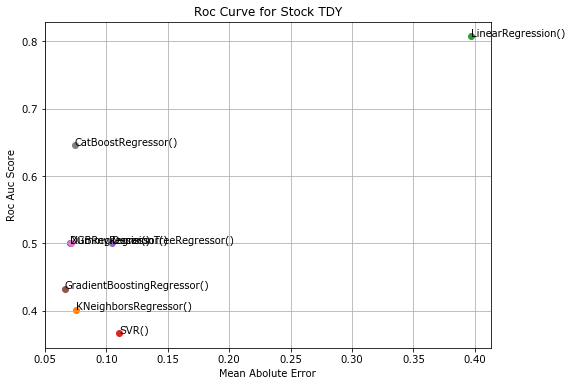

Number of models compared: 10.


loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/2 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 87.95it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'strategy': 'median'}
  Backtesting metric: 0.01674874596361711



Number of models compared: 150.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_neighbors': 12, 'p': 5, 'weights': 'uniform'}
  Backtesting metric: 0.011036606746711154

Number of models compared: 20.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:00<00:00, 28.32it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'copy_X': True, 'fit_intercept': True}
  Backtesting metric: 0.00015332976216513575

Number of models compared: 720.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'C': 5, 'coef0': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
  Backtesting metric: 3.6777381812482703e-06

Number of models compared: 1920.


loop param_grid:  83%|███████████████████████████▍     | 319/384 [00:01<00:00, 161.75it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
  Backtesting metric: 0.002167837035274695

Number of models compared: 540.


loop param_grid:  71%|████████████████████████▉          | 77/108 [00:05<00:01, 19.39it/s]


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:36<00:00,  7.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
  Backtesting metric: 1.8399500687243644e-07

Number of models compared: 480.


loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:35:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:07, 12.85it/s]


[14:35:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 11.41it/s]

[14:35:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 11.12it/s]


[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 10.98it/s]

[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:07, 10.90it/s]

[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:35:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:07, 10.62it/s]


[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 10.91it/s]

[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.47it/s]

[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:06, 11.23it/s]

[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:06, 10.79it/s]


[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.48it/s]

[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:03<00:05, 11.22it/s]

[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.71it/s]


[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 10.62it/s]


[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.65it/s]

[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:04<00:04, 10.61it/s]

[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.54it/s]

[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.97it/s]

[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 12.05it/s]

[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:05<00:03, 11.76it/s]


[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:02, 11.71it/s]

[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.78it/s]


[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.02it/s]


[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:06<00:02, 10.72it/s]


[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.73it/s]

[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.83it/s]

[14:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 11.08it/s]

[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:07<00:01, 11.82it/s]

[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 11.73it/s]

[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 11.45it/s]

[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:00, 11.24it/s]


[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 11.70it/s]

[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 11.65it/s]

[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:08<00:00, 11.05it/s]

[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]


[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 14.15it/s]

[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.84it/s]

[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 12.22it/s]

[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 11.85it/s]

[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.52it/s]


[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.82it/s]

[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 12.23it/s]

[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.38it/s]

[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:04, 12.61it/s]

[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.72it/s]


[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 10.84it/s]


[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.73it/s]

[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  45%|████████████████▏                   | 43/96 [00:03<00:04, 10.80it/s]


[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 10.66it/s]


[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 10.83it/s]

[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 10.80it/s]

[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.13it/s]

[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 11.28it/s]

[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.24it/s]

[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.50it/s]


[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.86it/s]

[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.66it/s]

[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.48it/s]


[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.82it/s]

[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.88it/s]


[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 10.96it/s]


[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 11.04it/s]


[14:35:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.88it/s]

[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.66it/s]


[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.41it/s]


[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.60it/s]


[14:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.42it/s]


[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.37it/s]


[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.23it/s]


[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:17<00:25,  8.66s/it]

[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:35:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:05, 15.92it/s]

[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 14.11it/s]

[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.56it/s]

[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  11%|████▏                               | 11/96 [00:00<00:07, 12.01it/s]

[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:07, 11.27it/s]


[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 11.56it/s]

[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.28it/s]

[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:06, 11.40it/s]

[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 11.53it/s]

[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.73it/s]

[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.81it/s]


[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:05, 11.24it/s]

[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.41it/s]

[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.73it/s]

[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:03, 12.11it/s]

[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:03, 11.86it/s]

[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.46it/s]


[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 11.62it/s]


[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.40it/s]


[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 11.22it/s]

[14:35:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.91it/s]

[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 10.63it/s]

[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.61it/s]


[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 10.39it/s]


[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.53it/s]


[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 10.68it/s]

[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 10.65it/s]

[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.69it/s]

[14:35:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.36it/s]


[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.30it/s]


[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.25it/s]


[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.47it/s]

[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00,  9.87it/s]

[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:26<00:17,  8.68s/it]

[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 14.78it/s]

[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:07, 12.40it/s]


[14:35:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:   7%|██▋                                  | 7/96 [00:00<00:07, 12.21it/s]

[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:07, 12.35it/s]

[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 12.02it/s]

[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 12.27it/s]


[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  20%|███████▏                            | 19/96 [00:01<00:06, 11.61it/s]

[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 11.69it/s]


[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  26%|█████████▍                          | 25/96 [00:02<00:05, 12.33it/s]

[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.11it/s]

[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▋                        | 31/96 [00:02<00:05, 11.57it/s]

[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 10.84it/s]

[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.32it/s]

[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  41%|██████████████▋                     | 39/96 [00:03<00:04, 11.74it/s]

[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:04, 11.53it/s]

[14:35:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.52it/s]

[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.74it/s]

[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 11.55it/s]

[14:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 11.55it/s]

[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 11.48it/s]


[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:02, 11.34it/s]

[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  68%|████████████████████████▍           | 65/96 [00:05<00:02, 11.28it/s]

[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 11.01it/s]


[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.81it/s]

[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.74it/s]

[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:01, 10.82it/s]


[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  82%|█████████████████████████████▋      | 79/96 [00:06<00:01, 10.86it/s]

[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.73it/s]

[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.74it/s]

[14:35:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.60it/s]

[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:07<00:00, 10.66it/s]

[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.68it/s]


[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  97%|██████████████████████████████████▉ | 93/96 [00:08<00:00, 10.54it/s]

[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:34<00:08,  8.64s/it]

[14:35:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/96 [00:00<?, ?it/s]

[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   3%|█▏                                   | 3/96 [00:00<00:06, 14.55it/s]

[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   5%|█▉                                   | 5/96 [00:00<00:06, 13.45it/s]

[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▍                                 | 9/96 [00:00<00:06, 12.48it/s]

[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|████▉                               | 13/96 [00:01<00:06, 12.41it/s]

[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▋                              | 15/96 [00:01<00:06, 12.14it/s]

[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  18%|██████▍                             | 17/96 [00:01<00:06, 12.12it/s]


[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  22%|███████▉                            | 21/96 [00:01<00:06, 12.11it/s]

[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  24%|████████▋                           | 23/96 [00:01<00:06, 11.82it/s]

[14:35:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  28%|██████████▏                         | 27/96 [00:02<00:05, 12.70it/s]

[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  30%|██████████▉                         | 29/96 [00:02<00:05, 12.32it/s]

[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  34%|████████████▍                       | 33/96 [00:02<00:05, 11.53it/s]

[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  36%|█████████████▏                      | 35/96 [00:02<00:05, 11.32it/s]


[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  39%|█████████████▉                      | 37/96 [00:03<00:05, 11.13it/s]


[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  43%|███████████████▍                    | 41/96 [00:03<00:05, 10.97it/s]

[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  47%|████████████████▉                   | 45/96 [00:03<00:04, 11.58it/s]

[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  51%|██████████████████▍                 | 49/96 [00:04<00:04, 11.49it/s]

[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  53%|███████████████████▏                | 51/96 [00:04<00:04, 11.25it/s]


[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  55%|███████████████████▉                | 53/96 [00:04<00:03, 10.94it/s]


[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  57%|████████████████████▋               | 55/96 [00:04<00:03, 10.84it/s]


[14:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  59%|█████████████████████▍              | 57/96 [00:04<00:03, 10.68it/s]


[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  61%|██████████████████████▏             | 59/96 [00:05<00:03, 10.45it/s]


[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  64%|██████████████████████▉             | 61/96 [00:05<00:03, 10.34it/s]


[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  66%|███████████████████████▋            | 63/96 [00:05<00:03, 10.32it/s]


[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  70%|█████████████████████████▏          | 67/96 [00:05<00:02, 10.61it/s]

[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  72%|█████████████████████████▉          | 69/96 [00:06<00:02, 10.25it/s]

[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  74%|██████████████████████████▋         | 71/96 [00:06<00:02, 10.09it/s]

[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  76%|███████████████████████████▍        | 73/96 [00:06<00:02, 10.07it/s]


[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  78%|████████████████████████████▏       | 75/96 [00:06<00:02, 10.20it/s]

[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  80%|████████████████████████████▉       | 77/96 [00:06<00:01, 10.12it/s]


[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  84%|██████████████████████████████▍     | 81/96 [00:07<00:01, 10.64it/s]

[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  86%|███████████████████████████████▏    | 83/96 [00:07<00:01, 10.67it/s]

[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  89%|███████████████████████████████▉    | 85/96 [00:07<00:01, 10.23it/s]


[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  91%|████████████████████████████████▋   | 87/96 [00:07<00:00, 10.22it/s]

[14:35:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  93%|█████████████████████████████████▍  | 89/96 [00:08<00:00,  9.95it/s]


[14:35:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


loop param_grid:  95%|██████████████████████████████████▏ | 91/96 [00:08<00:00, 10.09it/s]

[14:35:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  99%|███████████████████████████████████▋| 95/96 [00:08<00:00, 10.34it/s]

[14:35:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:43<00:00,  8.67s/it]


[14:36:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'colsample_bytree': 0.4, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.4}
  Backtesting metric: 0.019113357307617207

Number of models compared: 60.


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2724553	total: 922us	remaining: 26.7ms
1:	learn: 0.2623662	total: 1.74ms	remaining: 24.3ms
2:	learn: 0.2545918	total: 2.66ms	remaining: 23.9ms
3:	learn: 0.2457012	total: 3.44ms	remaining: 22.4ms
4:	learn: 0.2369613	total: 4.31ms	remaining: 21.5ms
5:	learn: 0.2285979	total: 5.08ms	remaining: 20.3ms
6:	learn: 0.2204043	total: 5.97ms	remaining: 19.6ms
7:	learn: 0.2135030	total: 6.73ms	remaining: 18.5ms
8:	learn: 0.2061394	total: 7.57ms	remaining: 17.7ms
9:	learn: 0.1991643	total: 8.43ms	remaining: 16.9ms
10:	learn: 0.1919946	total: 9.47ms	remaining: 16.4ms
11:	learn: 0.1853229	total: 10.4ms	remaining: 15.6ms
12:	learn: 0.1792827	total: 11.3ms	remaining: 14.7ms
13:	learn: 0.1729738	total: 12.3ms	remaining: 14.1ms
14:	learn: 0.1678999	total: 13.2ms	remaining: 13.2ms
15:	learn: 0.1632320	total: 14ms	remaining: 12.3ms
16:	learn: 0.1577423	total: 14.8ms	remaining: 11.3ms
17:	learn: 0.1530827	total: 15.7ms	remaining: 10.4ms
18:	learn: 0.1486757	total: 16.5ms	remaining: 9.55ms
19:	le


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:00, 10.03it/s]

26:	learn: 0.0590673	total: 25.5ms	remaining: 2.84ms
27:	learn: 0.0570345	total: 26.5ms	remaining: 1.89ms
28:	learn: 0.0554265	total: 27.3ms	remaining: 940us
29:	learn: 0.0535061	total: 28ms	remaining: 0us
0:	learn: 0.2724553	total: 862us	remaining: 42.3ms
1:	learn: 0.2623662	total: 1.76ms	remaining: 42.2ms
2:	learn: 0.2545918	total: 2.71ms	remaining: 42.5ms
3:	learn: 0.2457012	total: 3.43ms	remaining: 39.5ms
4:	learn: 0.2369613	total: 5.09ms	remaining: 45.8ms
5:	learn: 0.2285979	total: 6.07ms	remaining: 44.5ms
6:	learn: 0.2204043	total: 7.2ms	remaining: 44.2ms
7:	learn: 0.2135030	total: 8.08ms	remaining: 42.4ms
8:	learn: 0.2061394	total: 9.21ms	remaining: 42ms
9:	learn: 0.1991643	total: 10.2ms	remaining: 40.9ms
10:	learn: 0.1919946	total: 11ms	remaining: 39.1ms
11:	learn: 0.1853229	total: 11.7ms	remaining: 37ms
12:	learn: 0.1792827	total: 12.5ms	remaining: 35.6ms
13:	learn: 0.1729738	total: 14ms	remaining: 35.9ms
14:	learn: 0.1678999	total: 14.9ms	remaining: 34.8ms
15:	learn: 0.163232


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.67it/s]

30:	learn: 0.0512747	total: 30.3ms	remaining: 18.5ms
31:	learn: 0.0493589	total: 31.1ms	remaining: 17.5ms
32:	learn: 0.0476060	total: 32ms	remaining: 16.5ms
33:	learn: 0.0462014	total: 32.7ms	remaining: 15.4ms
34:	learn: 0.0445389	total: 33.4ms	remaining: 14.3ms
35:	learn: 0.0432256	total: 34.3ms	remaining: 13.3ms
36:	learn: 0.0421573	total: 35ms	remaining: 12.3ms
37:	learn: 0.0409249	total: 36ms	remaining: 11.4ms
38:	learn: 0.0400227	total: 37.3ms	remaining: 10.5ms
39:	learn: 0.0391193	total: 38.1ms	remaining: 9.54ms
40:	learn: 0.0381780	total: 39ms	remaining: 8.55ms
41:	learn: 0.0374770	total: 40ms	remaining: 7.63ms
42:	learn: 0.0367162	total: 41.1ms	remaining: 6.68ms
43:	learn: 0.0357574	total: 41.8ms	remaining: 5.71ms
44:	learn: 0.0349708	total: 42.5ms	remaining: 4.72ms
45:	learn: 0.0341559	total: 43.2ms	remaining: 3.76ms
46:	learn: 0.0333738	total: 44ms	remaining: 2.81ms
47:	learn: 0.0326495	total: 44.7ms	remaining: 1.86ms
48:	learn: 0.0320753	total: 45.5ms	remaining: 928us
49:	le


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.41it/s]

26:	learn: 0.1213636	total: 50.7ms	remaining: 5.63ms
27:	learn: 0.1181164	total: 52.3ms	remaining: 3.74ms
28:	learn: 0.1148070	total: 54ms	remaining: 1.86ms
29:	learn: 0.1116796	total: 55.8ms	remaining: 0us



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.90it/s]

0:	learn: 0.2626358	total: 1.88ms	remaining: 54.6ms
1:	learn: 0.2455628	total: 4.04ms	remaining: 56.6ms
2:	learn: 0.2289409	total: 5.65ms	remaining: 50.9ms
3:	learn: 0.2159939	total: 8.32ms	remaining: 54.1ms
4:	learn: 0.2007332	total: 8.74ms	remaining: 43.7ms
5:	learn: 0.1871336	total: 11ms	remaining: 44ms
6:	learn: 0.1758800	total: 12.8ms	remaining: 42.2ms
7:	learn: 0.1646096	total: 14.6ms	remaining: 40.3ms
8:	learn: 0.1542015	total: 16.1ms	remaining: 37.6ms
9:	learn: 0.1445710	total: 17.6ms	remaining: 35.1ms
10:	learn: 0.1365467	total: 19.3ms	remaining: 33.3ms
11:	learn: 0.1288894	total: 21.3ms	remaining: 32ms
12:	learn: 0.1222003	total: 22.8ms	remaining: 29.9ms
13:	learn: 0.1158997	total: 24.2ms	remaining: 27.7ms
14:	learn: 0.1091115	total: 25.2ms	remaining: 25.2ms
15:	learn: 0.1034614	total: 27.1ms	remaining: 23.7ms
16:	learn: 0.0977797	total: 28.5ms	remaining: 21.8ms
17:	learn: 0.0926713	total: 30ms	remaining: 20ms
18:	learn: 0.0881054	total: 31.7ms	remaining: 18.4ms
19:	learn: 0.


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:00<00:00,  7.19it/s]

32:	learn: 0.1032009	total: 53.3ms	remaining: 27.5ms
33:	learn: 0.1005597	total: 55.7ms	remaining: 26.2ms
34:	learn: 0.0978452	total: 57.1ms	remaining: 24.5ms
35:	learn: 0.0953600	total: 58.5ms	remaining: 22.8ms
36:	learn: 0.0930275	total: 60ms	remaining: 21.1ms
37:	learn: 0.0906027	total: 61.4ms	remaining: 19.4ms
38:	learn: 0.0882047	total: 62.5ms	remaining: 17.6ms
39:	learn: 0.0862967	total: 63.9ms	remaining: 16ms
40:	learn: 0.0842762	total: 65.4ms	remaining: 14.4ms
41:	learn: 0.0823745	total: 67.7ms	remaining: 12.9ms
42:	learn: 0.0803009	total: 69.4ms	remaining: 11.3ms
43:	learn: 0.0784879	total: 71.5ms	remaining: 9.75ms
44:	learn: 0.0769157	total: 73.3ms	remaining: 8.14ms
45:	learn: 0.0752366	total: 74.8ms	remaining: 6.5ms
46:	learn: 0.0736742	total: 76.2ms	remaining: 4.87ms
47:	learn: 0.0721475	total: 77.8ms	remaining: 3.24ms
48:	learn: 0.0704917	total: 79.4ms	remaining: 1.62ms
49:	learn: 0.0690249	total: 80.9ms	remaining: 0us
0:	learn: 0.2626358	total: 2.26ms	remaining: 111ms
1:	


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  6.67it/s]

37:	learn: 0.0430743	total: 65.6ms	remaining: 20.7ms
38:	learn: 0.0419779	total: 67.3ms	remaining: 19ms
39:	learn: 0.0408187	total: 68.7ms	remaining: 17.2ms
40:	learn: 0.0399162	total: 70.3ms	remaining: 15.4ms
41:	learn: 0.0386012	total: 71.9ms	remaining: 13.7ms
42:	learn: 0.0375417	total: 73.4ms	remaining: 11.9ms
43:	learn: 0.0362975	total: 74.9ms	remaining: 10.2ms
44:	learn: 0.0353698	total: 76.6ms	remaining: 8.51ms
45:	learn: 0.0344562	total: 78.1ms	remaining: 6.79ms
46:	learn: 0.0336434	total: 79.5ms	remaining: 5.08ms
47:	learn: 0.0327949	total: 81.3ms	remaining: 3.38ms
48:	learn: 0.0318939	total: 83.2ms	remaining: 1.7ms
49:	learn: 0.0312143	total: 84.6ms	remaining: 0us
0:	learn: 0.2732971	total: 7.27ms	remaining: 211ms
1:	learn: 0.2640137	total: 10.9ms	remaining: 153ms
2:	learn: 0.2553160	total: 17.1ms	remaining: 154ms
3:	learn: 0.2465248	total: 22.5ms	remaining: 146ms
4:	learn: 0.2379440	total: 29.1ms	remaining: 145ms
5:	learn: 0.2305022	total: 36.4ms	remaining: 146ms
6:	learn: 0


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.96it/s]

0:	learn: 0.2642194	total: 8.78ms	remaining: 255ms
1:	learn: 0.2463477	total: 12.3ms	remaining: 172ms
2:	learn: 0.2302961	total: 19.7ms	remaining: 177ms
3:	learn: 0.2146502	total: 25.8ms	remaining: 168ms
4:	learn: 0.2000037	total: 34.9ms	remaining: 174ms
5:	learn: 0.1877569	total: 42.4ms	remaining: 170ms
6:	learn: 0.1774367	total: 49.7ms	remaining: 163ms
7:	learn: 0.1667670	total: 56.4ms	remaining: 155ms
8:	learn: 0.1572881	total: 64.9ms	remaining: 151ms
9:	learn: 0.1464369	total: 65.7ms	remaining: 131ms
10:	learn: 0.1389608	total: 73.9ms	remaining: 128ms
11:	learn: 0.1308446	total: 81.4ms	remaining: 122ms
12:	learn: 0.1233307	total: 84.9ms	remaining: 111ms
13:	learn: 0.1167853	total: 89.7ms	remaining: 102ms
14:	learn: 0.1095464	total: 91.7ms	remaining: 91.7ms
15:	learn: 0.1039715	total: 98.1ms	remaining: 85.8ms
16:	learn: 0.0988121	total: 104ms	remaining: 79.6ms
17:	learn: 0.0929768	total: 105ms	remaining: 70ms
18:	learn: 0.0887041	total: 112ms	remaining: 64.8ms
19:	learn: 0.0849121	t


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.33it/s]

26:	learn: 0.0639420	total: 170ms	remaining: 18.9ms
27:	learn: 0.0620152	total: 178ms	remaining: 12.7ms
28:	learn: 0.0599292	total: 189ms	remaining: 6.53ms
29:	learn: 0.0581702	total: 198ms	remaining: 0us
0:	learn: 0.2732971	total: 6.15ms	remaining: 301ms
1:	learn: 0.2640137	total: 9.83ms	remaining: 236ms
2:	learn: 0.2553160	total: 15.6ms	remaining: 245ms
3:	learn: 0.2465248	total: 21.7ms	remaining: 250ms
4:	learn: 0.2379440	total: 27.5ms	remaining: 247ms
5:	learn: 0.2305022	total: 34.5ms	remaining: 253ms
6:	learn: 0.2236572	total: 40.8ms	remaining: 250ms
7:	learn: 0.2166305	total: 48.1ms	remaining: 252ms
8:	learn: 0.2102209	total: 54.6ms	remaining: 249ms
9:	learn: 0.2026789	total: 55.3ms	remaining: 221ms
10:	learn: 0.1970390	total: 61.9ms	remaining: 219ms
11:	learn: 0.1912736	total: 67.6ms	remaining: 214ms
12:	learn: 0.1852830	total: 70.8ms	remaining: 201ms
13:	learn: 0.1799890	total: 76.7ms	remaining: 197ms
14:	learn: 0.1747922	total: 81.9ms	remaining: 191ms
15:	learn: 0.1702364	tota


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.61it/s]

44:	learn: 0.0773106	total: 231ms	remaining: 25.7ms
45:	learn: 0.0753943	total: 237ms	remaining: 20.6ms
46:	learn: 0.0738733	total: 243ms	remaining: 15.5ms
47:	learn: 0.0724065	total: 249ms	remaining: 10.4ms
48:	learn: 0.0706598	total: 257ms	remaining: 5.24ms
49:	learn: 0.0691675	total: 263ms	remaining: 0us
0:	learn: 0.2642194	total: 7.03ms	remaining: 344ms
1:	learn: 0.2463477	total: 10.2ms	remaining: 246ms
2:	learn: 0.2302961	total: 16ms	remaining: 251ms
3:	learn: 0.2146502	total: 21.9ms	remaining: 252ms
4:	learn: 0.2000037	total: 27.2ms	remaining: 245ms
5:	learn: 0.1877569	total: 32.3ms	remaining: 237ms
6:	learn: 0.1774367	total: 37.7ms	remaining: 232ms
7:	learn: 0.1667670	total: 45.6ms	remaining: 239ms
8:	learn: 0.1572881	total: 51.5ms	remaining: 235ms
9:	learn: 0.1464369	total: 52.2ms	remaining: 209ms
10:	learn: 0.1389608	total: 57.4ms	remaining: 203ms
11:	learn: 0.1308446	total: 62.7ms	remaining: 199ms
12:	learn: 0.1233307	total: 65.6ms	remaining: 187ms
13:	learn: 0.1167853	total:


loop lags_grid:  20%|███████▊                               | 1/5 [00:02<00:09,  2.47s/it]

43:	learn: 0.0368312	total: 234ms	remaining: 31.8ms
44:	learn: 0.0359216	total: 241ms	remaining: 26.8ms
45:	learn: 0.0348237	total: 247ms	remaining: 21.4ms
46:	learn: 0.0337129	total: 255ms	remaining: 16.3ms
47:	learn: 0.0323410	total: 260ms	remaining: 10.9ms
48:	learn: 0.0312613	total: 267ms	remaining: 5.45ms
49:	learn: 0.0305854	total: 273ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.2459188	total: 1.37ms	remaining: 39.9ms
1:	learn: 0.2383339	total: 2.5ms	remaining: 35ms
2:	learn: 0.2311851	total: 3.85ms	remaining: 34.6ms
3:	learn: 0.2239651	total: 4.87ms	remaining: 31.6ms
4:	learn: 0.2164526	total: 5.92ms	remaining: 29.6ms
5:	learn: 0.2090258	total: 6.83ms	remaining: 27.3ms
6:	learn: 0.2022026	total: 7.71ms	remaining: 25.3ms
7:	learn: 0.1964049	total: 8.6ms	remaining: 23.7ms
8:	learn: 0.1904870	total: 9.39ms	remaining: 21.9ms
9:	learn: 0.1849514	total: 10.5ms	remaining: 20.9ms
10:	learn: 0.1789344	total: 10.9ms	remaining: 18.9ms
11:	learn: 0.1729357	total: 11.9ms	remaining: 17.9ms
12:	learn: 0.1675683	total: 13ms	remaining: 17ms
13:	learn: 0.1627685	total: 14ms	remaining: 16.1ms
14:	learn: 0.1576619	total: 15ms	remaining: 15ms
15:	learn: 0.1533448	total: 16ms	remaining: 14ms
16:	learn: 0.1486122	total: 17ms	remaining: 13ms
17:	learn: 0.1440871	total: 17.9ms	remaining: 11.9ms
18:	learn: 0.1396106	total: 19ms	remaining: 11ms
19:	learn: 0.1356221	total: 2

0:	learn: 0.2380695	total: 1.34ms	remaining: 38.9ms
1:	learn: 0.2234748	total: 3.31ms	remaining: 46.4ms
2:	learn: 0.2101723	total: 4.65ms	remaining: 41.9ms
3:	learn: 0.1972614	total: 6.24ms	remaining: 40.6ms
4:	learn: 0.1841302	total: 7.99ms	remaining: 39.9ms
5:	learn: 0.1719513	total: 9.17ms	remaining: 36.7ms
6:	learn: 0.1618381	total: 10.3ms	remaining: 33.8ms
7:	learn: 0.1535896	total: 13.9ms	remaining: 38.1ms
8:	learn: 0.1448210	total: 15.7ms	remaining: 36.5ms
9:	learn: 0.1370447	total: 18.1ms	remaining: 36.2ms
10:	learn: 0.1290690	total: 19.6ms	remaining: 33.9ms
11:	learn: 0.1216613	total: 21.2ms	remaining: 31.8ms
12:	learn: 0.1148976	total: 22.8ms	remaining: 29.8ms
13:	learn: 0.1091215	total: 25ms	remaining: 28.6ms
14:	learn: 0.1034096	total: 27.2ms	remaining: 27.2ms
15:	learn: 0.0981096	total: 29.3ms	remaining: 25.6ms
16:	learn: 0.0927537	total: 31.2ms	remaining: 23.8ms
17:	learn: 0.0877397	total: 33ms	remaining: 22ms
18:	learn: 0.0833868	total: 35ms	remaining: 20.3ms
19:	learn: 

loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  8.53it/s]

0:	learn: 0.2459188	total: 1.33ms	remaining: 65.2ms
1:	learn: 0.2383339	total: 2.42ms	remaining: 58.1ms
2:	learn: 0.2311851	total: 3.41ms	remaining: 53.5ms
3:	learn: 0.2239651	total: 4.86ms	remaining: 55.9ms
4:	learn: 0.2164526	total: 6.08ms	remaining: 54.7ms
5:	learn: 0.2090258	total: 7.42ms	remaining: 54.4ms
6:	learn: 0.2022026	total: 8.63ms	remaining: 53ms
7:	learn: 0.1964049	total: 9.67ms	remaining: 50.8ms
8:	learn: 0.1904870	total: 11.3ms	remaining: 51.5ms
9:	learn: 0.1849514	total: 13.2ms	remaining: 53ms
10:	learn: 0.1789344	total: 14ms	remaining: 49.6ms
11:	learn: 0.1729357	total: 15.3ms	remaining: 48.5ms
12:	learn: 0.1675683	total: 16.5ms	remaining: 47ms
13:	learn: 0.1627685	total: 17.8ms	remaining: 45.7ms
14:	learn: 0.1576619	total: 19.2ms	remaining: 44.8ms
15:	learn: 0.1533448	total: 20.4ms	remaining: 43.4ms



loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  7.37it/s]

16:	learn: 0.1486122	total: 22.3ms	remaining: 43.3ms
17:	learn: 0.1440871	total: 23.5ms	remaining: 41.9ms
18:	learn: 0.1396106	total: 24.9ms	remaining: 40.6ms
19:	learn: 0.1356221	total: 25.8ms	remaining: 38.7ms
20:	learn: 0.1313607	total: 27.3ms	remaining: 37.8ms
21:	learn: 0.1276707	total: 28.6ms	remaining: 36.4ms
22:	learn: 0.1244015	total: 29.7ms	remaining: 34.8ms
23:	learn: 0.1207302	total: 30.9ms	remaining: 33.5ms
24:	learn: 0.1172762	total: 32.2ms	remaining: 32.2ms
25:	learn: 0.1144474	total: 34ms	remaining: 31.3ms
26:	learn: 0.1114337	total: 35.2ms	remaining: 30ms
27:	learn: 0.1087627	total: 36.5ms	remaining: 28.7ms
28:	learn: 0.1057367	total: 37.9ms	remaining: 27.4ms
29:	learn: 0.1032204	total: 39.3ms	remaining: 26.2ms
30:	learn: 0.1006330	total: 40.7ms	remaining: 25ms
31:	learn: 0.0982024	total: 41.9ms	remaining: 23.6ms
32:	learn: 0.0959761	total: 43.4ms	remaining: 22.4ms
33:	learn: 0.0938642	total: 44.4ms	remaining: 20.9ms
34:	learn: 0.0915390	total: 45.4ms	remaining: 19.5ms


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  6.23it/s]

20:	learn: 0.0763701	total: 47.3ms	remaining: 65.3ms
21:	learn: 0.0735107	total: 49.3ms	remaining: 62.7ms
22:	learn: 0.0706269	total: 51.2ms	remaining: 60.1ms
23:	learn: 0.0680472	total: 52ms	remaining: 56.4ms
24:	learn: 0.0659085	total: 53.2ms	remaining: 53.2ms
25:	learn: 0.0639705	total: 54.7ms	remaining: 50.5ms
26:	learn: 0.0615564	total: 56.2ms	remaining: 47.9ms
27:	learn: 0.0594396	total: 57.7ms	remaining: 45.4ms
28:	learn: 0.0579178	total: 59ms	remaining: 42.7ms
29:	learn: 0.0563198	total: 60.2ms	remaining: 40.1ms
30:	learn: 0.0548970	total: 61.4ms	remaining: 37.6ms
31:	learn: 0.0536484	total: 62.6ms	remaining: 35.2ms
32:	learn: 0.0522134	total: 63.8ms	remaining: 32.9ms
33:	learn: 0.0505278	total: 65.5ms	remaining: 30.8ms
34:	learn: 0.0491399	total: 67ms	remaining: 28.7ms
35:	learn: 0.0475867	total: 68.5ms	remaining: 26.6ms
36:	learn: 0.0463300	total: 69.7ms	remaining: 24.5ms
37:	learn: 0.0450437	total: 70.6ms	remaining: 22.3ms
38:	learn: 0.0441330	total: 71.9ms	remaining: 20.3ms


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.44it/s]

19:	learn: 0.1370196	total: 40.5ms	remaining: 20.3ms
20:	learn: 0.1329309	total: 42.3ms	remaining: 18.1ms
21:	learn: 0.1299690	total: 44.6ms	remaining: 16.2ms
22:	learn: 0.1265037	total: 47.7ms	remaining: 14.5ms
23:	learn: 0.1224842	total: 49.7ms	remaining: 12.4ms
24:	learn: 0.1186842	total: 52.3ms	remaining: 10.5ms
25:	learn: 0.1155522	total: 54.5ms	remaining: 8.39ms
26:	learn: 0.1125895	total: 57.1ms	remaining: 6.34ms
27:	learn: 0.1095843	total: 59.8ms	remaining: 4.27ms
28:	learn: 0.1067104	total: 62.1ms	remaining: 2.14ms
29:	learn: 0.1039976	total: 64.4ms	remaining: 0us
0:	learn: 0.2380695	total: 1.42ms	remaining: 41.3ms
1:	learn: 0.2238116	total: 3.78ms	remaining: 52.9ms
2:	learn: 0.2089717	total: 5.92ms	remaining: 53.3ms
3:	learn: 0.1952612	total: 8.1ms	remaining: 52.6ms
4:	learn: 0.1847842	total: 10.2ms	remaining: 51.1ms
5:	learn: 0.1746338	total: 12.7ms	remaining: 50.8ms
6:	learn: 0.1643548	total: 15.8ms	remaining: 51.8ms
7:	learn: 0.1537285	total: 16.6ms	remaining: 45.8ms
8:	le

23:	learn: 0.0677375	total: 49.3ms	remaining: 12.3ms
24:	learn: 0.0648765	total: 51.6ms	remaining: 10.3ms
25:	learn: 0.0626940	total: 53.9ms	remaining: 8.3ms
26:	learn: 0.0605023	total: 55.8ms	remaining: 6.2ms
27:	learn: 0.0581881	total: 57.6ms	remaining: 4.11ms
28:	learn: 0.0562845	total: 59.3ms	remaining: 2.04ms
29:	learn: 0.0543202	total: 61.1ms	remaining: 0us


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.66it/s]

0:	learn: 0.2459188	total: 1.59ms	remaining: 77.7ms
1:	learn: 0.2385072	total: 3.52ms	remaining: 84.4ms
2:	learn: 0.2305366	total: 5.43ms	remaining: 85.1ms
3:	learn: 0.2228522	total: 7.52ms	remaining: 86.5ms
4:	learn: 0.2164519	total: 9.97ms	remaining: 89.8ms
5:	learn: 0.2102631	total: 11.9ms	remaining: 87.5ms
6:	learn: 0.2036991	total: 14.1ms	remaining: 86.5ms
7:	learn: 0.1967734	total: 14.7ms	remaining: 77.4ms
8:	learn: 0.1912603	total: 16.7ms	remaining: 76ms
9:	learn: 0.1848742	total: 18.8ms	remaining: 75.2ms
10:	learn: 0.1790891	total: 19.4ms	remaining: 68.8ms
11:	learn: 0.1734426	total: 21.7ms	remaining: 68.7ms
12:	learn: 0.1685984	total: 24ms	remaining: 68.2ms
13:	learn: 0.1638357	total: 26.2ms	remaining: 67.3ms
14:	learn: 0.1586758	total: 28.1ms	remaining: 65.6ms
15:	learn: 0.1538895	total: 30.2ms	remaining: 64.2ms
16:	learn: 0.1493044	total: 32.7ms	remaining: 63.5ms
17:	learn: 0.1453905	total: 34.9ms	remaining: 62ms
18:	learn: 0.1410145	total: 37.3ms	remaining: 60.8ms
19:	learn


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.00it/s]

41:	learn: 0.0780797	total: 82.3ms	remaining: 15.7ms
42:	learn: 0.0759691	total: 83.1ms	remaining: 13.5ms
43:	learn: 0.0744027	total: 85.5ms	remaining: 11.7ms
44:	learn: 0.0729572	total: 87.7ms	remaining: 9.74ms
45:	learn: 0.0713948	total: 89.6ms	remaining: 7.79ms
46:	learn: 0.0699896	total: 92.7ms	remaining: 5.92ms
47:	learn: 0.0683710	total: 94ms	remaining: 3.91ms
48:	learn: 0.0668317	total: 96.6ms	remaining: 1.97ms
49:	learn: 0.0653383	total: 99ms	remaining: 0us
0:	learn: 0.2380695	total: 1.5ms	remaining: 73.4ms
1:	learn: 0.2238116	total: 3.75ms	remaining: 90ms
2:	learn: 0.2089717	total: 5.8ms	remaining: 90.9ms
3:	learn: 0.1952612	total: 7.54ms	remaining: 86.8ms
4:	learn: 0.1847842	total: 9.68ms	remaining: 87.1ms
5:	learn: 0.1746338	total: 11.6ms	remaining: 85.3ms
6:	learn: 0.1643548	total: 14ms	remaining: 86.2ms
7:	learn: 0.1537285	total: 14.7ms	remaining: 77.4ms
8:	learn: 0.1455504	total: 16.6ms	remaining: 75.8ms
9:	learn: 0.1365850	total: 18.5ms	remaining: 73.8ms
10:	learn: 0.128


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.80it/s]

39:	learn: 0.0407502	total: 75.2ms	remaining: 18.8ms
40:	learn: 0.0396950	total: 77.2ms	remaining: 16.9ms
41:	learn: 0.0385031	total: 79ms	remaining: 15ms
42:	learn: 0.0373739	total: 80.8ms	remaining: 13.2ms
43:	learn: 0.0365470	total: 82.7ms	remaining: 11.3ms
44:	learn: 0.0355249	total: 84.9ms	remaining: 9.44ms
45:	learn: 0.0347274	total: 87.2ms	remaining: 7.59ms
46:	learn: 0.0334176	total: 89ms	remaining: 5.68ms
47:	learn: 0.0326349	total: 90.7ms	remaining: 3.78ms
48:	learn: 0.0315915	total: 92.7ms	remaining: 1.89ms
49:	learn: 0.0308758	total: 94.5ms	remaining: 0us
0:	learn: 0.2459188	total: 1.4ms	remaining: 40.6ms
1:	learn: 0.2385072	total: 4.03ms	remaining: 56.4ms
2:	learn: 0.2316276	total: 9.62ms	remaining: 86.6ms
3:	learn: 0.2245789	total: 15ms	remaining: 97.8ms
4:	learn: 0.2186552	total: 21.9ms	remaining: 110ms
5:	learn: 0.2117604	total: 22.6ms	remaining: 90.6ms
6:	learn: 0.2053916	total: 30.7ms	remaining: 101ms
7:	learn: 0.2001378	total: 37.1ms	remaining: 102ms
8:	learn: 0.1934

19:	learn: 0.1404864	total: 96.6ms	remaining: 48.3ms
20:	learn: 0.1368975	total: 102ms	remaining: 43.7ms
21:	learn: 0.1332005	total: 108ms	remaining: 39.2ms
22:	learn: 0.1298348	total: 114ms	remaining: 34.6ms
23:	learn: 0.1263683	total: 119ms	remaining: 29.7ms
24:	learn: 0.1230038	total: 125ms	remaining: 25ms
25:	learn: 0.1196033	total: 132ms	remaining: 20.3ms
26:	learn: 0.1166244	total: 140ms	remaining: 15.5ms
27:	learn: 0.1135185	total: 147ms	remaining: 10.5ms
28:	learn: 0.1100150	total: 148ms	remaining: 5.1ms
29:	learn: 0.1073065	total: 154ms	remaining: 0us


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.22it/s]

0:	learn: 0.2380695	total: 1.31ms	remaining: 38.1ms
1:	learn: 0.2238116	total: 3.51ms	remaining: 49.2ms
2:	learn: 0.2110088	total: 8.96ms	remaining: 80.7ms
3:	learn: 0.1983012	total: 14.7ms	remaining: 95.7ms
4:	learn: 0.1882180	total: 20.5ms	remaining: 102ms
5:	learn: 0.1766229	total: 21.3ms	remaining: 85.1ms
6:	learn: 0.1669565	total: 27.7ms	remaining: 91ms
7:	learn: 0.1587186	total: 33.8ms	remaining: 92.9ms
8:	learn: 0.1486872	total: 34.6ms	remaining: 80.8ms
9:	learn: 0.1397843	total: 35.3ms	remaining: 70.6ms
10:	learn: 0.1321568	total: 43.1ms	remaining: 74.5ms
11:	learn: 0.1244886	total: 52.4ms	remaining: 78.6ms
12:	learn: 0.1170761	total: 57.4ms	remaining: 75ms
13:	learn: 0.1112638	total: 64.4ms	remaining: 73.5ms
14:	learn: 0.1063309	total: 73.5ms	remaining: 73.5ms
15:	learn: 0.1011836	total: 79.8ms	remaining: 69.9ms
16:	learn: 0.0959748	total: 85.8ms	remaining: 65.6ms
17:	learn: 0.0920528	total: 96.3ms	remaining: 64.2ms
18:	learn: 0.0876444	total: 106ms	remaining: 61.2ms
19:	learn

25:	learn: 0.0653832	total: 168ms	remaining: 25.8ms
26:	learn: 0.0625121	total: 175ms	remaining: 19.4ms
27:	learn: 0.0601885	total: 183ms	remaining: 13.1ms
28:	learn: 0.0576998	total: 190ms	remaining: 6.56ms
29:	learn: 0.0560071	total: 197ms	remaining: 0us


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.56it/s]

0:	learn: 0.2459188	total: 1.59ms	remaining: 78.1ms
1:	learn: 0.2385072	total: 3.84ms	remaining: 92.1ms
2:	learn: 0.2316276	total: 12.4ms	remaining: 195ms
3:	learn: 0.2245789	total: 21.7ms	remaining: 250ms
4:	learn: 0.2186552	total: 30.8ms	remaining: 277ms
5:	learn: 0.2117604	total: 31.7ms	remaining: 232ms
6:	learn: 0.2053916	total: 38.7ms	remaining: 238ms
7:	learn: 0.2001378	total: 46.5ms	remaining: 244ms
8:	learn: 0.1934210	total: 48.2ms	remaining: 220ms
9:	learn: 0.1872956	total: 49.2ms	remaining: 197ms
10:	learn: 0.1818211	total: 58.7ms	remaining: 208ms
11:	learn: 0.1760214	total: 70.4ms	remaining: 223ms
12:	learn: 0.1703434	total: 75.2ms	remaining: 214ms
13:	learn: 0.1658800	total: 83.4ms	remaining: 214ms
14:	learn: 0.1615536	total: 92.2ms	remaining: 215ms
15:	learn: 0.1565658	total: 101ms	remaining: 214ms
16:	learn: 0.1518755	total: 106ms	remaining: 207ms
17:	learn: 0.1481401	total: 115ms	remaining: 204ms
18:	learn: 0.1440965	total: 123ms	remaining: 200ms
19:	learn: 0.1404864	tot


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.36it/s]

44:	learn: 0.0755199	total: 315ms	remaining: 35ms
45:	learn: 0.0739449	total: 321ms	remaining: 27.9ms
46:	learn: 0.0721080	total: 322ms	remaining: 20.6ms
47:	learn: 0.0705783	total: 329ms	remaining: 13.7ms
48:	learn: 0.0689146	total: 337ms	remaining: 6.89ms
49:	learn: 0.0673225	total: 345ms	remaining: 0us
0:	learn: 0.2380695	total: 1.62ms	remaining: 79.5ms
1:	learn: 0.2238116	total: 4.33ms	remaining: 104ms
2:	learn: 0.2110088	total: 10.5ms	remaining: 164ms
3:	learn: 0.1983012	total: 18.5ms	remaining: 213ms
4:	learn: 0.1882180	total: 26.7ms	remaining: 240ms
5:	learn: 0.1766229	total: 28ms	remaining: 205ms
6:	learn: 0.1669565	total: 36.2ms	remaining: 222ms
7:	learn: 0.1587186	total: 43.5ms	remaining: 228ms
8:	learn: 0.1486872	total: 44.5ms	remaining: 203ms
9:	learn: 0.1397843	total: 45.1ms	remaining: 180ms
10:	learn: 0.1321568	total: 51.9ms	remaining: 184ms
11:	learn: 0.1244886	total: 57.1ms	remaining: 181ms
12:	learn: 0.1170761	total: 61.2ms	remaining: 174ms
13:	learn: 0.1112638	total: 


loop lags_grid:  40%|███████████████▌                       | 2/5 [00:05<00:07,  2.58s/it]

42:	learn: 0.0350718	total: 236ms	remaining: 38.4ms
43:	learn: 0.0339305	total: 242ms	remaining: 33ms
44:	learn: 0.0328873	total: 249ms	remaining: 27.7ms
45:	learn: 0.0318680	total: 255ms	remaining: 22.2ms
46:	learn: 0.0310801	total: 256ms	remaining: 16.3ms
47:	learn: 0.0303899	total: 262ms	remaining: 10.9ms
48:	learn: 0.0296421	total: 268ms	remaining: 5.47ms
49:	learn: 0.0286414	total: 275ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1858238	total: 1.27ms	remaining: 36.8ms


1:	learn: 0.1810988	total: 2.61ms	remaining: 36.5ms
2:	learn: 0.1767116	total: 4.04ms	remaining: 36.4ms
3:	learn: 0.1713083	total: 5.12ms	remaining: 33.3ms
4:	learn: 0.1666007	total: 6.14ms	remaining: 30.7ms
5:	learn: 0.1621034	total: 7.14ms	remaining: 28.6ms
6:	learn: 0.1578272	total: 8.18ms	remaining: 26.9ms
7:	learn: 0.1532386	total: 9.06ms	remaining: 24.9ms
8:	learn: 0.1493188	total: 10.1ms	remaining: 23.5ms
9:	learn: 0.1455813	total: 11.4ms	remaining: 22.7ms
10:	learn: 0.1418677	total: 12.7ms	remaining: 21.9ms
11:	learn: 0.1383525	total: 13.3ms	remaining: 20ms
12:	learn: 0.1343682	total: 14.8ms	remaining: 19.4ms
13:	learn: 0.1304945	total: 16.1ms	remaining: 18.4ms
14:	learn: 0.1267505	total: 17.3ms	remaining: 17.3ms
15:	learn: 0.1236351	total: 18.6ms	remaining: 16.2ms
16:	learn: 0.1206247	total: 19.7ms	remaining: 15.1ms
17:	learn: 0.1171467	total: 20.8ms	remaining: 13.9ms
18:	learn: 0.1141313	total: 21.9ms	remaining: 12.7ms
19:	learn: 0.1109841	total: 23ms	remaining: 11.5ms
20:	le

loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.03it/s]


0:	learn: 0.1796921	total: 1.22ms	remaining: 35.3ms
1:	learn: 0.1706073	total: 2.95ms	remaining: 41.3ms
2:	learn: 0.1624510	total: 4.07ms	remaining: 36.6ms
3:	learn: 0.1527074	total: 5.09ms	remaining: 33.1ms
4:	learn: 0.1445848	total: 6.24ms	remaining: 31.2ms
5:	learn: 0.1370195	total: 7.34ms	remaining: 29.4ms
6:	learn: 0.1301262	total: 8.52ms	remaining: 28ms
7:	learn: 0.1229563	total: 9.51ms	remaining: 26.1ms
8:	learn: 0.1171790	total: 10.6ms	remaining: 24.7ms
9:	learn: 0.1117588	total: 11.6ms	remaining: 23.2ms
10:	learn: 0.1066414	total: 12.6ms	remaining: 21.8ms
11:	learn: 0.1022082	total: 13.3ms	remaining: 19.9ms
12:	learn: 0.0969133	total: 14.2ms	remaining: 18.5ms
13:	learn: 0.0921700	total: 15.1ms	remaining: 17.3ms
14:	learn: 0.0877862	total: 16.2ms	remaining: 16.2ms
15:	learn: 0.0837368	total: 17.7ms	remaining: 15.5ms
16:	learn: 0.0801476	total: 19ms	remaining: 14.6ms
17:	learn: 0.0768148	total: 20.4ms	remaining: 13.6ms
18:	learn: 0.0733843	total: 21.9ms	remaining: 12.7ms
19:	lea

loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  8.25it/s]

0:	learn: 0.1858238	total: 1.49ms	remaining: 72.8ms
1:	learn: 0.1810988	total: 2.78ms	remaining: 66.7ms
2:	learn: 0.1767116	total: 3.83ms	remaining: 60ms
3:	learn: 0.1713083	total: 4.86ms	remaining: 55.9ms
4:	learn: 0.1666007	total: 5.87ms	remaining: 52.8ms
5:	learn: 0.1621034	total: 7.6ms	remaining: 55.8ms
6:	learn: 0.1578272	total: 8.95ms	remaining: 55ms
7:	learn: 0.1532386	total: 10.3ms	remaining: 54ms
8:	learn: 0.1493188	total: 11.9ms	remaining: 54.2ms
9:	learn: 0.1455813	total: 13.3ms	remaining: 53.3ms
10:	learn: 0.1418677	total: 14.7ms	remaining: 52.2ms
11:	learn: 0.1383525	total: 15.4ms	remaining: 48.9ms
12:	learn: 0.1343682	total: 18ms	remaining: 51.1ms
13:	learn: 0.1304945	total: 20ms	remaining: 51.3ms
14:	learn: 0.1267505	total: 22.2ms	remaining: 51.8ms
15:	learn: 0.1236351	total: 24.3ms	remaining: 51.7ms



loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  6.23it/s]

16:	learn: 0.1206247	total: 27.8ms	remaining: 53.9ms
17:	learn: 0.1171467	total: 29.8ms	remaining: 53ms
18:	learn: 0.1141313	total: 31.6ms	remaining: 51.6ms
19:	learn: 0.1109841	total: 34.9ms	remaining: 52.4ms
20:	learn: 0.1085027	total: 37.1ms	remaining: 51.2ms
21:	learn: 0.1060369	total: 39.7ms	remaining: 50.6ms
22:	learn: 0.1030848	total: 40.7ms	remaining: 47.8ms
23:	learn: 0.1003564	total: 42.5ms	remaining: 46.1ms
24:	learn: 0.0978850	total: 44.1ms	remaining: 44.1ms
25:	learn: 0.0956404	total: 45.4ms	remaining: 41.9ms
26:	learn: 0.0931649	total: 47ms	remaining: 40ms
27:	learn: 0.0909044	total: 48.1ms	remaining: 37.8ms
28:	learn: 0.0886637	total: 49.6ms	remaining: 35.9ms
29:	learn: 0.0866465	total: 50.8ms	remaining: 33.9ms
30:	learn: 0.0847379	total: 52ms	remaining: 31.9ms
31:	learn: 0.0828466	total: 53.5ms	remaining: 30.1ms
32:	learn: 0.0811476	total: 54.9ms	remaining: 28.3ms
33:	learn: 0.0789516	total: 56ms	remaining: 26.4ms
34:	learn: 0.0774784	total: 57.2ms	remaining: 24.5ms
35:


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  6.09it/s]

15:	learn: 0.0837368	total: 20.2ms	remaining: 42.9ms
16:	learn: 0.0801476	total: 21.7ms	remaining: 42.2ms
17:	learn: 0.0768148	total: 23.1ms	remaining: 41ms
18:	learn: 0.0733843	total: 24.4ms	remaining: 39.8ms
19:	learn: 0.0704572	total: 26.2ms	remaining: 39.3ms
20:	learn: 0.0684728	total: 27.9ms	remaining: 38.5ms
21:	learn: 0.0663112	total: 29.7ms	remaining: 37.9ms
22:	learn: 0.0640255	total: 30.7ms	remaining: 36ms
23:	learn: 0.0616940	total: 31.9ms	remaining: 34.6ms
24:	learn: 0.0597561	total: 33ms	remaining: 33ms
25:	learn: 0.0575670	total: 34.3ms	remaining: 31.7ms
26:	learn: 0.0556801	total: 35.4ms	remaining: 30.2ms
27:	learn: 0.0542322	total: 37.1ms	remaining: 29.2ms
28:	learn: 0.0524639	total: 38.4ms	remaining: 27.8ms
29:	learn: 0.0511115	total: 40ms	remaining: 26.7ms
30:	learn: 0.0498616	total: 41.7ms	remaining: 25.6ms
31:	learn: 0.0481777	total: 43.3ms	remaining: 24.3ms
32:	learn: 0.0467913	total: 44.4ms	remaining: 22.9ms
33:	learn: 0.0454364	total: 45.6ms	remaining: 21.5ms
34:


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  6.22it/s]

15:	learn: 0.1254811	total: 40.7ms	remaining: 35.6ms
16:	learn: 0.1216549	total: 44.1ms	remaining: 33.7ms
17:	learn: 0.1184180	total: 47.2ms	remaining: 31.4ms
18:	learn: 0.1155658	total: 49.8ms	remaining: 28.8ms
19:	learn: 0.1129991	total: 51.8ms	remaining: 25.9ms
20:	learn: 0.1096556	total: 52.6ms	remaining: 22.5ms
21:	learn: 0.1069149	total: 55.1ms	remaining: 20.1ms
22:	learn: 0.1045737	total: 57.2ms	remaining: 17.4ms
23:	learn: 0.1019437	total: 59.4ms	remaining: 14.9ms
24:	learn: 0.0997672	total: 61.6ms	remaining: 12.3ms
25:	learn: 0.0972267	total: 63.7ms	remaining: 9.8ms
26:	learn: 0.0949774	total: 65.9ms	remaining: 7.33ms
27:	learn: 0.0923863	total: 67.1ms	remaining: 4.79ms
28:	learn: 0.0900770	total: 69.9ms	remaining: 2.41ms
29:	learn: 0.0880195	total: 73.1ms	remaining: 0us
0:	learn: 0.1810431	total: 3.62ms	remaining: 105ms
1:	learn: 0.1715055	total: 5.96ms	remaining: 83.4ms
2:	learn: 0.1622580	total: 8.35ms	remaining: 75.1ms
3:	learn: 0.1528904	total: 11.3ms	remaining: 73.6ms
4:


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.32it/s]

25:	learn: 0.0552566	total: 63ms	remaining: 9.69ms
26:	learn: 0.0537996	total: 65.5ms	remaining: 7.28ms
27:	learn: 0.0518938	total: 67.9ms	remaining: 4.85ms
28:	learn: 0.0502389	total: 69.8ms	remaining: 2.41ms
29:	learn: 0.0488172	total: 71.6ms	remaining: 0us
0:	learn: 0.1865007	total: 2.62ms	remaining: 128ms
1:	learn: 0.1811613	total: 4.88ms	remaining: 117ms
2:	learn: 0.1761942	total: 7.13ms	remaining: 112ms
3:	learn: 0.1710443	total: 9.76ms	remaining: 112ms
4:	learn: 0.1665651	total: 12.3ms	remaining: 111ms
5:	learn: 0.1621938	total: 14.8ms	remaining: 109ms
6:	learn: 0.1581461	total: 17.3ms	remaining: 106ms
7:	learn: 0.1537278	total: 19.3ms	remaining: 101ms
8:	learn: 0.1495740	total: 21.4ms	remaining: 97.6ms
9:	learn: 0.1460325	total: 23.9ms	remaining: 95.6ms
10:	learn: 0.1422165	total: 26.6ms	remaining: 94.1ms
11:	learn: 0.1384801	total: 28.3ms	remaining: 89.5ms
12:	learn: 0.1351383	total: 30.5ms	remaining: 86.7ms
13:	learn: 0.1320163	total: 32.4ms	remaining: 83.4ms
14:	learn: 0.128


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.66it/s]

39:	learn: 0.0705352	total: 91.6ms	remaining: 22.9ms
40:	learn: 0.0687674	total: 92.7ms	remaining: 20.4ms
41:	learn: 0.0670931	total: 95.5ms	remaining: 18.2ms
42:	learn: 0.0658124	total: 98.6ms	remaining: 16.1ms
43:	learn: 0.0645223	total: 101ms	remaining: 13.8ms
44:	learn: 0.0632149	total: 103ms	remaining: 11.5ms
45:	learn: 0.0619466	total: 106ms	remaining: 9.21ms
46:	learn: 0.0606900	total: 109ms	remaining: 6.97ms
47:	learn: 0.0593739	total: 112ms	remaining: 4.66ms
48:	learn: 0.0581005	total: 115ms	remaining: 2.35ms
49:	learn: 0.0573433	total: 118ms	remaining: 0us
0:	learn: 0.1810431	total: 2.57ms	remaining: 126ms
1:	learn: 0.1715055	total: 5.08ms	remaining: 122ms
2:	learn: 0.1622580	total: 7.63ms	remaining: 120ms
3:	learn: 0.1528904	total: 9.94ms	remaining: 114ms
4:	learn: 0.1450605	total: 11.9ms	remaining: 107ms
5:	learn: 0.1377751	total: 14.6ms	remaining: 107ms
6:	learn: 0.1311599	total: 16.8ms	remaining: 103ms
7:	learn: 0.1242211	total: 19.2ms	remaining: 101ms
8:	learn: 0.1177254


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.20it/s]

30:	learn: 0.0472834	total: 72.5ms	remaining: 44.4ms
31:	learn: 0.0458438	total: 74.8ms	remaining: 42.1ms
32:	learn: 0.0447414	total: 75.7ms	remaining: 39ms
33:	learn: 0.0434056	total: 78.6ms	remaining: 37ms
34:	learn: 0.0421248	total: 82.2ms	remaining: 35.2ms
35:	learn: 0.0408546	total: 84.7ms	remaining: 32.9ms
36:	learn: 0.0399151	total: 87.9ms	remaining: 30.9ms
37:	learn: 0.0388063	total: 91ms	remaining: 28.7ms
38:	learn: 0.0377017	total: 94.1ms	remaining: 26.5ms
39:	learn: 0.0367186	total: 95.7ms	remaining: 23.9ms
40:	learn: 0.0357385	total: 98.1ms	remaining: 21.5ms
41:	learn: 0.0344046	total: 101ms	remaining: 19.2ms
42:	learn: 0.0334421	total: 103ms	remaining: 16.8ms
43:	learn: 0.0321139	total: 106ms	remaining: 14.4ms
44:	learn: 0.0312683	total: 108ms	remaining: 12ms
45:	learn: 0.0306331	total: 111ms	remaining: 9.63ms
46:	learn: 0.0299084	total: 113ms	remaining: 7.23ms
47:	learn: 0.0292222	total: 116ms	remaining: 4.83ms
48:	learn: 0.0285212	total: 119ms	remaining: 2.43ms
49:	learn

28:	learn: 0.0936472	total: 185ms	remaining: 6.36ms
29:	learn: 0.0915641	total: 191ms	remaining: 0us


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  4.48it/s]

0:	learn: 0.1815482	total: 8.14ms	remaining: 236ms
1:	learn: 0.1734922	total: 15.1ms	remaining: 212ms
2:	learn: 0.1646971	total: 22.4ms	remaining: 202ms
3:	learn: 0.1549136	total: 29.5ms	remaining: 192ms
4:	learn: 0.1467156	total: 35.8ms	remaining: 179ms
5:	learn: 0.1391577	total: 41.8ms	remaining: 167ms
6:	learn: 0.1312380	total: 42.5ms	remaining: 140ms
7:	learn: 0.1247520	total: 45.8ms	remaining: 126ms
8:	learn: 0.1190105	total: 53.2ms	remaining: 124ms
9:	learn: 0.1130517	total: 62.6ms	remaining: 125ms
10:	learn: 0.1078034	total: 70.3ms	remaining: 121ms
11:	learn: 0.1023649	total: 71.4ms	remaining: 107ms
12:	learn: 0.0977278	total: 79.3ms	remaining: 104ms
13:	learn: 0.0943269	total: 88.7ms	remaining: 101ms
14:	learn: 0.0899933	total: 96.4ms	remaining: 96.4ms
15:	learn: 0.0858669	total: 105ms	remaining: 91.9ms
16:	learn: 0.0818417	total: 106ms	remaining: 81.1ms
17:	learn: 0.0780282	total: 115ms	remaining: 76.5ms
18:	learn: 0.0743857	total: 119ms	remaining: 68.9ms
19:	learn: 0.0715454	


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.19it/s]

28:	learn: 0.0512921	total: 186ms	remaining: 6.42ms
29:	learn: 0.0496543	total: 193ms	remaining: 0us
0:	learn: 0.1867586	total: 8.18ms	remaining: 401ms
1:	learn: 0.1825812	total: 17.1ms	remaining: 409ms
2:	learn: 0.1778997	total: 24.6ms	remaining: 385ms
3:	learn: 0.1725267	total: 33.5ms	remaining: 386ms
4:	learn: 0.1678770	total: 43.4ms	remaining: 391ms
5:	learn: 0.1634679	total: 51.9ms	remaining: 381ms
6:	learn: 0.1598723	total: 59.9ms	remaining: 368ms
7:	learn: 0.1565035	total: 69.5ms	remaining: 365ms
8:	learn: 0.1525653	total: 79.2ms	remaining: 361ms
9:	learn: 0.1493865	total: 86.6ms	remaining: 346ms
10:	learn: 0.1460073	total: 94.9ms	remaining: 336ms
11:	learn: 0.1416301	total: 95.6ms	remaining: 303ms
12:	learn: 0.1376172	total: 107ms	remaining: 304ms
13:	learn: 0.1349777	total: 118ms	remaining: 302ms
14:	learn: 0.1312625	total: 126ms	remaining: 293ms
15:	learn: 0.1284071	total: 135ms	remaining: 286ms
16:	learn: 0.1246711	total: 139ms	remaining: 271ms
17:	learn: 0.1215674	total: 14


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.17it/s]

49:	learn: 0.0599603	total: 354ms	remaining: 0us
0:	learn: 0.1815482	total: 6.5ms	remaining: 318ms
1:	learn: 0.1734922	total: 13.7ms	remaining: 329ms
2:	learn: 0.1646971	total: 20.9ms	remaining: 327ms
3:	learn: 0.1549136	total: 27.4ms	remaining: 315ms
4:	learn: 0.1467156	total: 33.4ms	remaining: 300ms
5:	learn: 0.1391577	total: 38.8ms	remaining: 285ms
6:	learn: 0.1312380	total: 40ms	remaining: 246ms
7:	learn: 0.1247520	total: 43.4ms	remaining: 228ms
8:	learn: 0.1190105	total: 49.3ms	remaining: 225ms
9:	learn: 0.1130517	total: 56.2ms	remaining: 225ms
10:	learn: 0.1078034	total: 63ms	remaining: 223ms
11:	learn: 0.1023649	total: 63.6ms	remaining: 201ms
12:	learn: 0.0977278	total: 68.9ms	remaining: 196ms
13:	learn: 0.0943269	total: 76.5ms	remaining: 197ms
14:	learn: 0.0899933	total: 82.2ms	remaining: 192ms
15:	learn: 0.0858669	total: 89.5ms	remaining: 190ms
16:	learn: 0.0818417	total: 90.6ms	remaining: 176ms
17:	learn: 0.0780282	total: 98ms	remaining: 174ms
18:	learn: 0.0743857	total: 101m


loop lags_grid:  60%|███████████████████████▍               | 3/5 [00:07<00:05,  2.69s/it]

43:	learn: 0.0323217	total: 263ms	remaining: 35.9ms
44:	learn: 0.0313640	total: 270ms	remaining: 29.9ms
45:	learn: 0.0305207	total: 276ms	remaining: 24ms
46:	learn: 0.0297815	total: 282ms	remaining: 18ms
47:	learn: 0.0289686	total: 288ms	remaining: 12ms
48:	learn: 0.0281288	total: 295ms	remaining: 6.02ms
49:	learn: 0.0274291	total: 301ms	remaining: 0us



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

0:	learn: 0.1250006	total: 1.29ms	remaining: 37.5ms
1:	learn: 0.1219227	total: 1.82ms	remaining: 25.6ms
2:	learn: 0.1190638	total: 3.03ms	remaining: 27.3ms
3:	learn: 0.1166570	total: 4.03ms	remaining: 26.2ms
4:	learn: 0.1137530	total: 4.58ms	remaining: 22.9ms
5:	learn: 0.1113468	total: 5.6ms	remaining: 22.4ms
6:	learn: 0.1084863	total: 6.72ms	remaining: 22.1ms
7:	learn: 0.1064877	total: 7.89ms	remaining: 21.7ms
8:	learn: 0.1038894	total: 9.04ms	remaining: 21.1ms
9:	learn: 0.1018604	total: 10.3ms	remaining: 20.7ms
10:	learn: 0.0992711	total: 11.6ms	remaining: 20ms
11:	learn: 0.0973095	total: 12.6ms	remaining: 19ms
12:	learn: 0.0952050	total: 13.7ms	remaining: 17.9ms
13:	learn: 0.0934057	total: 14.7ms	remaining: 16.8ms
14:	learn: 0.0914596	total: 15.6ms	remaining: 15.6ms
15:	learn: 0.0892675	total: 16.4ms	remaining: 14.4ms
16:	learn: 0.0874280	total: 17.4ms	remaining: 13.3ms
17:	learn: 0.0854050	total: 18.5ms	remaining: 12.4ms
18:	learn: 0.0839079	total: 19.6ms	remaining: 11.4ms
19:	lear


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:01,  9.88it/s]

1:	learn: 0.1165289	total: 1.59ms	remaining: 22.2ms
2:	learn: 0.1112011	total: 2.86ms	remaining: 25.8ms
3:	learn: 0.1069141	total: 3.95ms	remaining: 25.7ms
4:	learn: 0.1018214	total: 4.59ms	remaining: 23ms
5:	learn: 0.0978631	total: 5.51ms	remaining: 22ms
6:	learn: 0.0937134	total: 6.8ms	remaining: 22.4ms
7:	learn: 0.0903412	total: 7.82ms	remaining: 21.5ms
8:	learn: 0.0862318	total: 9.11ms	remaining: 21.2ms
9:	learn: 0.0833167	total: 10.4ms	remaining: 20.7ms
10:	learn: 0.0795155	total: 11.9ms	remaining: 20.6ms
11:	learn: 0.0767799	total: 13ms	remaining: 19.5ms
12:	learn: 0.0741571	total: 14.1ms	remaining: 18.4ms
13:	learn: 0.0717098	total: 15.1ms	remaining: 17.3ms
14:	learn: 0.0694007	total: 16.3ms	remaining: 16.3ms
15:	learn: 0.0670663	total: 17.4ms	remaining: 15.3ms
16:	learn: 0.0646815	total: 18.5ms	remaining: 14.1ms
17:	learn: 0.0625880	total: 19.6ms	remaining: 13.1ms
18:	learn: 0.0607775	total: 20.7ms	remaining: 12ms
19:	learn: 0.0593365	total: 21.7ms	remaining: 10.8ms
20:	learn: 


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  6.70it/s]

18:	learn: 0.0839079	total: 28.3ms	remaining: 46.2ms
19:	learn: 0.0822563	total: 29.8ms	remaining: 44.7ms
20:	learn: 0.0805802	total: 32.7ms	remaining: 45.2ms
21:	learn: 0.0793084	total: 34.6ms	remaining: 44ms
22:	learn: 0.0779090	total: 37ms	remaining: 43.4ms
23:	learn: 0.0762073	total: 38.8ms	remaining: 42ms
24:	learn: 0.0743106	total: 40.3ms	remaining: 40.3ms
25:	learn: 0.0729897	total: 41.8ms	remaining: 38.6ms
26:	learn: 0.0717895	total: 43.5ms	remaining: 37.1ms
27:	learn: 0.0705328	total: 45.6ms	remaining: 35.8ms
28:	learn: 0.0691168	total: 48.2ms	remaining: 34.9ms
29:	learn: 0.0677875	total: 50ms	remaining: 33.4ms
30:	learn: 0.0665432	total: 51.8ms	remaining: 31.7ms
31:	learn: 0.0654284	total: 53.6ms	remaining: 30.2ms
32:	learn: 0.0643318	total: 55.2ms	remaining: 28.4ms
33:	learn: 0.0632722	total: 57.1ms	remaining: 26.9ms
34:	learn: 0.0624142	total: 58.8ms	remaining: 25.2ms
35:	learn: 0.0613406	total: 60.6ms	remaining: 23.6ms
36:	learn: 0.0603483	total: 62.5ms	remaining: 22ms
37:


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:01,  5.93it/s]

13:	learn: 0.0717098	total: 22.5ms	remaining: 57.9ms
14:	learn: 0.0694007	total: 24.6ms	remaining: 57.3ms
15:	learn: 0.0670663	total: 26ms	remaining: 55.3ms
16:	learn: 0.0646815	total: 27.5ms	remaining: 53.4ms
17:	learn: 0.0625880	total: 29.3ms	remaining: 52ms
18:	learn: 0.0607775	total: 30.5ms	remaining: 49.8ms
19:	learn: 0.0593365	total: 31.9ms	remaining: 47.9ms
20:	learn: 0.0569844	total: 33.3ms	remaining: 46.1ms
21:	learn: 0.0555031	total: 34.8ms	remaining: 44.3ms
22:	learn: 0.0536107	total: 36.4ms	remaining: 42.7ms
23:	learn: 0.0522646	total: 37.9ms	remaining: 41.1ms
24:	learn: 0.0509780	total: 39.4ms	remaining: 39.4ms
25:	learn: 0.0499055	total: 41ms	remaining: 37.8ms
26:	learn: 0.0486545	total: 42.6ms	remaining: 36.3ms
27:	learn: 0.0474222	total: 44.3ms	remaining: 34.8ms
28:	learn: 0.0461269	total: 45.9ms	remaining: 33.2ms
29:	learn: 0.0445667	total: 47.2ms	remaining: 31.5ms
30:	learn: 0.0432721	total: 49.5ms	remaining: 30.3ms
31:	learn: 0.0421948	total: 51.5ms	remaining: 29ms
3


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  5.85it/s]

5:	learn: 0.1121636	total: 20.1ms	remaining: 80.3ms
6:	learn: 0.1097287	total: 23.2ms	remaining: 76.3ms
7:	learn: 0.1074357	total: 26ms	remaining: 71.6ms
8:	learn: 0.1053237	total: 28.7ms	remaining: 66.9ms
9:	learn: 0.1031353	total: 31.4ms	remaining: 62.8ms
10:	learn: 0.1009776	total: 33.3ms	remaining: 57.4ms
11:	learn: 0.0987524	total: 34.5ms	remaining: 51.8ms
12:	learn: 0.0967631	total: 35.8ms	remaining: 46.8ms
13:	learn: 0.0949251	total: 39.4ms	remaining: 45.1ms
14:	learn: 0.0931259	total: 43ms	remaining: 43ms
15:	learn: 0.0914870	total: 45.9ms	remaining: 40.1ms
16:	learn: 0.0899475	total: 49.4ms	remaining: 37.8ms
17:	learn: 0.0884046	total: 52.6ms	remaining: 35.1ms
18:	learn: 0.0866794	total: 55.8ms	remaining: 32.3ms
19:	learn: 0.0852699	total: 58.8ms	remaining: 29.4ms
20:	learn: 0.0836481	total: 62.1ms	remaining: 26.6ms
21:	learn: 0.0820948	total: 65.5ms	remaining: 23.8ms
22:	learn: 0.0803165	total: 68.1ms	remaining: 20.7ms
23:	learn: 0.0790259	total: 70.3ms	remaining: 17.6ms
24:	


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  6.00it/s]

10:	learn: 0.0810445	total: 31.1ms	remaining: 53.8ms
11:	learn: 0.0779342	total: 32.5ms	remaining: 48.8ms
12:	learn: 0.0747140	total: 33.6ms	remaining: 44ms
13:	learn: 0.0721518	total: 36.1ms	remaining: 41.3ms
14:	learn: 0.0693813	total: 38.7ms	remaining: 38.7ms
15:	learn: 0.0670954	total: 40.8ms	remaining: 35.7ms
16:	learn: 0.0651368	total: 43.1ms	remaining: 33ms
17:	learn: 0.0631250	total: 46.1ms	remaining: 30.8ms
18:	learn: 0.0609969	total: 48.8ms	remaining: 28.2ms
19:	learn: 0.0592655	total: 51.4ms	remaining: 25.7ms
20:	learn: 0.0574324	total: 53.8ms	remaining: 23.1ms
21:	learn: 0.0556490	total: 56ms	remaining: 20.4ms
22:	learn: 0.0534423	total: 58.7ms	remaining: 17.9ms
23:	learn: 0.0521592	total: 62.3ms	remaining: 15.6ms
24:	learn: 0.0511108	total: 62.7ms	remaining: 12.5ms
25:	learn: 0.0494464	total: 65ms	remaining: 10ms
26:	learn: 0.0479799	total: 67.3ms	remaining: 7.48ms
27:	learn: 0.0465343	total: 70ms	remaining: 5ms
28:	learn: 0.0450183	total: 70.8ms	remaining: 2.44ms
29:	lear


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  5.68it/s]

24:	learn: 0.0777107	total: 51.5ms	remaining: 51.5ms
25:	learn: 0.0759392	total: 53.7ms	remaining: 49.6ms
26:	learn: 0.0747737	total: 55.6ms	remaining: 47.4ms
27:	learn: 0.0736278	total: 57.7ms	remaining: 45.3ms
28:	learn: 0.0721818	total: 59.8ms	remaining: 43.3ms
29:	learn: 0.0709466	total: 61.8ms	remaining: 41.2ms
30:	learn: 0.0696698	total: 64.7ms	remaining: 39.7ms
31:	learn: 0.0682783	total: 67.4ms	remaining: 37.9ms
32:	learn: 0.0670162	total: 69.8ms	remaining: 36ms
33:	learn: 0.0658918	total: 70.4ms	remaining: 33.1ms
34:	learn: 0.0647774	total: 70.7ms	remaining: 30.3ms
35:	learn: 0.0637758	total: 72.7ms	remaining: 28.3ms
36:	learn: 0.0627284	total: 75ms	remaining: 26.4ms
37:	learn: 0.0615575	total: 77ms	remaining: 24.3ms
38:	learn: 0.0607490	total: 79.1ms	remaining: 22.3ms
39:	learn: 0.0598349	total: 81.3ms	remaining: 20.3ms
40:	learn: 0.0588038	total: 83.5ms	remaining: 18.3ms
41:	learn: 0.0579058	total: 85.4ms	remaining: 16.3ms
42:	learn: 0.0569968	total: 87.7ms	remaining: 14.3ms


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.45it/s]

21:	learn: 0.0556490	total: 50.7ms	remaining: 64.6ms
22:	learn: 0.0534423	total: 53.5ms	remaining: 62.8ms
23:	learn: 0.0521592	total: 55.8ms	remaining: 60.4ms
24:	learn: 0.0511108	total: 56ms	remaining: 56ms
25:	learn: 0.0494464	total: 58.6ms	remaining: 54.1ms
26:	learn: 0.0479799	total: 60.9ms	remaining: 51.9ms
27:	learn: 0.0465343	total: 63.3ms	remaining: 49.7ms
28:	learn: 0.0450183	total: 64ms	remaining: 46.4ms
29:	learn: 0.0435795	total: 66.1ms	remaining: 44ms
30:	learn: 0.0425439	total: 66.7ms	remaining: 40.9ms
31:	learn: 0.0412156	total: 69.4ms	remaining: 39ms
32:	learn: 0.0400769	total: 72.3ms	remaining: 37.3ms
33:	learn: 0.0390417	total: 75.2ms	remaining: 35.4ms
34:	learn: 0.0377852	total: 77.8ms	remaining: 33.3ms
35:	learn: 0.0370877	total: 79.8ms	remaining: 31ms
36:	learn: 0.0361009	total: 82.5ms	remaining: 29ms
37:	learn: 0.0348719	total: 85.1ms	remaining: 26.9ms
38:	learn: 0.0339592	total: 87.7ms	remaining: 24.7ms
39:	learn: 0.0328312	total: 89.9ms	remaining: 22.5ms
40:	lea


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.03it/s]

9:	learn: 0.1037365	total: 44.3ms	remaining: 88.7ms
10:	learn: 0.1016640	total: 47.9ms	remaining: 82.7ms
11:	learn: 0.0997028	total: 53.3ms	remaining: 80ms
12:	learn: 0.0979268	total: 58.6ms	remaining: 76.6ms
13:	learn: 0.0960811	total: 64.2ms	remaining: 73.3ms
14:	learn: 0.0944492	total: 69.4ms	remaining: 69.4ms
15:	learn: 0.0926278	total: 75.2ms	remaining: 65.8ms
16:	learn: 0.0907487	total: 76ms	remaining: 58.1ms
17:	learn: 0.0891960	total: 82.1ms	remaining: 54.8ms
18:	learn: 0.0875860	total: 87.6ms	remaining: 50.7ms
19:	learn: 0.0860174	total: 90.7ms	remaining: 45.3ms
20:	learn: 0.0840339	total: 91.5ms	remaining: 39.2ms
21:	learn: 0.0825340	total: 92ms	remaining: 33.4ms
22:	learn: 0.0811325	total: 98.1ms	remaining: 29.8ms
23:	learn: 0.0793806	total: 102ms	remaining: 25.5ms
24:	learn: 0.0778594	total: 111ms	remaining: 22.2ms
25:	learn: 0.0764383	total: 119ms	remaining: 18.2ms
26:	learn: 0.0748318	total: 127ms	remaining: 14.1ms
27:	learn: 0.0731219	total: 130ms	remaining: 9.27ms
28:	l

0:	learn: 0.1230072	total: 9.01ms	remaining: 261ms
1:	learn: 0.1189086	total: 13.4ms	remaining: 187ms
2:	learn: 0.1140228	total: 21.8ms	remaining: 196ms
3:	learn: 0.1098466	total: 29.5ms	remaining: 192ms
4:	learn: 0.1060785	total: 36.1ms	remaining: 180ms
5:	learn: 0.1020293	total: 39.7ms	remaining: 159ms
6:	learn: 0.0976458	total: 47.8ms	remaining: 157ms
7:	learn: 0.0932195	total: 49.7ms	remaining: 137ms
8:	learn: 0.0894480	total: 53.6ms	remaining: 125ms
9:	learn: 0.0857338	total: 54.7ms	remaining: 109ms
10:	learn: 0.0825152	total: 55.8ms	remaining: 96.4ms
11:	learn: 0.0799070	total: 63.3ms	remaining: 94.9ms
12:	learn: 0.0772920	total: 69.3ms	remaining: 90.6ms
13:	learn: 0.0745958	total: 77.1ms	remaining: 88.1ms
14:	learn: 0.0720584	total: 85.1ms	remaining: 85.1ms
15:	learn: 0.0695435	total: 92.6ms	remaining: 81.1ms
16:	learn: 0.0670193	total: 94.6ms	remaining: 72.3ms
17:	learn: 0.0648353	total: 103ms	remaining: 68.4ms
18:	learn: 0.0628171	total: 111ms	remaining: 64ms
19:	learn: 0.0607

loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  4.59it/s]

0:	learn: 0.1252931	total: 7.63ms	remaining: 374ms
1:	learn: 0.1231859	total: 11.2ms	remaining: 268ms
2:	learn: 0.1206312	total: 17.7ms	remaining: 277ms
3:	learn: 0.1184051	total: 24.2ms	remaining: 278ms
4:	learn: 0.1161836	total: 30.2ms	remaining: 271ms
5:	learn: 0.1139118	total: 33.9ms	remaining: 249ms
6:	learn: 0.1114034	total: 39.6ms	remaining: 243ms
7:	learn: 0.1088009	total: 41ms	remaining: 215ms
8:	learn: 0.1064776	total: 44.5ms	remaining: 203ms
9:	learn: 0.1037365	total: 45ms	remaining: 180ms
10:	learn: 0.1016640	total: 48.3ms	remaining: 171ms
11:	learn: 0.0997028	total: 54.8ms	remaining: 174ms
12:	learn: 0.0979268	total: 61.2ms	remaining: 174ms
13:	learn: 0.0960811	total: 66.9ms	remaining: 172ms
14:	learn: 0.0944492	total: 72.8ms	remaining: 170ms
15:	learn: 0.0926278	total: 78.6ms	remaining: 167ms
16:	learn: 0.0907487	total: 79.5ms	remaining: 154ms
17:	learn: 0.0891960	total: 85.1ms	remaining: 151ms
18:	learn: 0.0875860	total: 91.4ms	remaining: 149ms
19:	learn: 0.0860174	total


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:02<00:00,  3.95it/s]

37:	learn: 0.0616509	total: 169ms	remaining: 53.4ms
38:	learn: 0.0608335	total: 176ms	remaining: 49.6ms
39:	learn: 0.0599523	total: 183ms	remaining: 45.6ms
40:	learn: 0.0586855	total: 189ms	remaining: 41.4ms
41:	learn: 0.0578407	total: 192ms	remaining: 36.6ms
42:	learn: 0.0570991	total: 198ms	remaining: 32.2ms
43:	learn: 0.0560998	total: 200ms	remaining: 27.3ms
44:	learn: 0.0553497	total: 201ms	remaining: 22.3ms
45:	learn: 0.0546031	total: 208ms	remaining: 18.1ms
46:	learn: 0.0538121	total: 210ms	remaining: 13.4ms
47:	learn: 0.0529923	total: 212ms	remaining: 8.83ms
48:	learn: 0.0522041	total: 218ms	remaining: 4.45ms
49:	learn: 0.0512684	total: 220ms	remaining: 0us
0:	learn: 0.1230072	total: 7.14ms	remaining: 350ms
1:	learn: 0.1189086	total: 11.1ms	remaining: 266ms
2:	learn: 0.1140228	total: 16.7ms	remaining: 261ms
3:	learn: 0.1098466	total: 23.8ms	remaining: 274ms
4:	learn: 0.1060785	total: 29.5ms	remaining: 266ms
5:	learn: 0.1020293	total: 33ms	remaining: 242ms
6:	learn: 0.0976458	tot


loop lags_grid:  80%|███████████████████████████████▏       | 4/5 [00:10<00:02,  2.63s/it]

43:	learn: 0.0292562	total: 204ms	remaining: 27.8ms
44:	learn: 0.0285459	total: 212ms	remaining: 23.5ms
45:	learn: 0.0277295	total: 217ms	remaining: 18.9ms
46:	learn: 0.0270522	total: 224ms	remaining: 14.3ms
47:	learn: 0.0263879	total: 231ms	remaining: 9.62ms
48:	learn: 0.0255831	total: 233ms	remaining: 4.75ms
49:	learn: 0.0248908	total: 239ms	remaining: 0us



loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  9.55it/s]

0:	learn: 0.0864463	total: 1.21ms	remaining: 35.1ms
1:	learn: 0.0853025	total: 2.17ms	remaining: 30.4ms
2:	learn: 0.0842765	total: 3.12ms	remaining: 28.1ms
3:	learn: 0.0832398	total: 4.29ms	remaining: 27.9ms
4:	learn: 0.0822775	total: 5.8ms	remaining: 29ms
5:	learn: 0.0812350	total: 6.89ms	remaining: 27.6ms
6:	learn: 0.0798650	total: 7.98ms	remaining: 26.2ms
7:	learn: 0.0783224	total: 9.22ms	remaining: 25.4ms
8:	learn: 0.0773067	total: 10.5ms	remaining: 24.5ms
9:	learn: 0.0762224	total: 12.1ms	remaining: 24.1ms
10:	learn: 0.0753348	total: 13.3ms	remaining: 23ms
11:	learn: 0.0743261	total: 14.3ms	remaining: 21.4ms
12:	learn: 0.0733184	total: 15.7ms	remaining: 20.5ms
13:	learn: 0.0721404	total: 16.8ms	remaining: 19.2ms
14:	learn: 0.0708646	total: 17.8ms	remaining: 17.8ms
15:	learn: 0.0698985	total: 19.1ms	remaining: 16.7ms
16:	learn: 0.0689004	total: 20.8ms	remaining: 15.9ms
17:	learn: 0.0677659	total: 22ms	remaining: 14.7ms
18:	learn: 0.0668978	total: 23.5ms	remaining: 13.6ms
19:	learn:


loop param_grid:  25%|█████████▎                           | 3/12 [00:00<00:01,  8.61it/s]

43:	learn: 0.0464532	total: 50.5ms	remaining: 6.88ms
44:	learn: 0.0457861	total: 51.6ms	remaining: 5.74ms
45:	learn: 0.0452565	total: 52.6ms	remaining: 4.58ms
46:	learn: 0.0444274	total: 53.6ms	remaining: 3.42ms
47:	learn: 0.0439903	total: 55ms	remaining: 2.29ms
48:	learn: 0.0435889	total: 56ms	remaining: 1.14ms
49:	learn: 0.0427905	total: 57.2ms	remaining: 0us
0:	learn: 0.0850959	total: 1.03ms	remaining: 50.5ms
1:	learn: 0.0828602	total: 2.3ms	remaining: 55.3ms
2:	learn: 0.0808981	total: 3.4ms	remaining: 53.3ms
3:	learn: 0.0789291	total: 4.26ms	remaining: 49ms
4:	learn: 0.0771915	total: 5.35ms	remaining: 48.1ms
5:	learn: 0.0752806	total: 6.24ms	remaining: 45.8ms
6:	learn: 0.0728770	total: 7.13ms	remaining: 43.8ms
7:	learn: 0.0701217	total: 8.05ms	remaining: 42.3ms
8:	learn: 0.0683770	total: 8.96ms	remaining: 40.8ms
9:	learn: 0.0665270	total: 9.99ms	remaining: 39.9ms
10:	learn: 0.0650620	total: 11ms	remaining: 38.9ms
11:	learn: 0.0633056	total: 11.9ms	remaining: 37.6ms
12:	learn: 0.061


loop param_grid:  33%|████████████▎                        | 4/12 [00:00<00:00,  8.16it/s]

28:	learn: 0.0374986	total: 29.7ms	remaining: 21.5ms
29:	learn: 0.0363645	total: 30.7ms	remaining: 20.4ms
30:	learn: 0.0348466	total: 31.7ms	remaining: 19.4ms
31:	learn: 0.0335870	total: 32.9ms	remaining: 18.5ms
32:	learn: 0.0327812	total: 34ms	remaining: 17.5ms
33:	learn: 0.0315879	total: 35.1ms	remaining: 16.5ms
34:	learn: 0.0307275	total: 36.2ms	remaining: 15.5ms
35:	learn: 0.0298428	total: 37.2ms	remaining: 14.5ms
36:	learn: 0.0287424	total: 38ms	remaining: 13.4ms
37:	learn: 0.0277781	total: 38.9ms	remaining: 12.3ms
38:	learn: 0.0269710	total: 39.7ms	remaining: 11.2ms
39:	learn: 0.0261616	total: 40.6ms	remaining: 10.2ms
40:	learn: 0.0253286	total: 41.2ms	remaining: 9.03ms
41:	learn: 0.0244907	total: 42.1ms	remaining: 8.02ms
42:	learn: 0.0238831	total: 43ms	remaining: 7.01ms
43:	learn: 0.0232761	total: 44.2ms	remaining: 6.03ms
44:	learn: 0.0224700	total: 45.3ms	remaining: 5.04ms
45:	learn: 0.0217974	total: 46.4ms	remaining: 4.04ms
46:	learn: 0.0212612	total: 47.7ms	remaining: 3.04ms


loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:00,  8.36it/s]

1:	learn: 0.0853025	total: 2.32ms	remaining: 32.5ms
2:	learn: 0.0841593	total: 4.59ms	remaining: 41.3ms
3:	learn: 0.0833005	total: 6.55ms	remaining: 42.6ms
4:	learn: 0.0819336	total: 7.18ms	remaining: 35.9ms
5:	learn: 0.0806750	total: 7.87ms	remaining: 31.5ms
6:	learn: 0.0794008	total: 9.03ms	remaining: 29.7ms
7:	learn: 0.0784399	total: 10.8ms	remaining: 29.6ms
8:	learn: 0.0772712	total: 12.6ms	remaining: 29.3ms
9:	learn: 0.0761435	total: 13.4ms	remaining: 26.8ms
10:	learn: 0.0751176	total: 14.7ms	remaining: 25.4ms
11:	learn: 0.0741971	total: 16ms	remaining: 24ms
12:	learn: 0.0727989	total: 17.8ms	remaining: 23.3ms
13:	learn: 0.0717404	total: 19.6ms	remaining: 22.4ms
14:	learn: 0.0706525	total: 21.6ms	remaining: 21.6ms
15:	learn: 0.0697872	total: 22.8ms	remaining: 19.9ms
16:	learn: 0.0689928	total: 24.5ms	remaining: 18.7ms
17:	learn: 0.0683728	total: 25.2ms	remaining: 16.8ms
18:	learn: 0.0673384	total: 26.2ms	remaining: 15.1ms
19:	learn: 0.0664992	total: 27.1ms	remaining: 13.5ms
20:	le


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:00<00:00,  7.07it/s]

19:	learn: 0.0504361	total: 52.4ms	remaining: 26.2ms
20:	learn: 0.0492761	total: 55.2ms	remaining: 23.7ms
21:	learn: 0.0479789	total: 61.7ms	remaining: 22.4ms
22:	learn: 0.0468155	total: 65.6ms	remaining: 20ms
23:	learn: 0.0456319	total: 67.3ms	remaining: 16.8ms
24:	learn: 0.0440956	total: 70.5ms	remaining: 14.1ms
25:	learn: 0.0428269	total: 74.9ms	remaining: 11.5ms
26:	learn: 0.0416494	total: 78.3ms	remaining: 8.7ms
27:	learn: 0.0404901	total: 81ms	remaining: 5.78ms
28:	learn: 0.0393901	total: 82.4ms	remaining: 2.84ms
29:	learn: 0.0384789	total: 85.1ms	remaining: 0us
0:	learn: 0.0864463	total: 1.62ms	remaining: 79.4ms
1:	learn: 0.0853025	total: 3.48ms	remaining: 83.5ms
2:	learn: 0.0841593	total: 7.43ms	remaining: 116ms
3:	learn: 0.0833005	total: 9.87ms	remaining: 114ms
4:	learn: 0.0819336	total: 10.7ms	remaining: 95.9ms
5:	learn: 0.0806750	total: 11.6ms	remaining: 84.8ms
6:	learn: 0.0794008	total: 13.8ms	remaining: 84.8ms
7:	learn: 0.0784399	total: 16ms	remaining: 84.2ms
8:	learn: 0.0


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:00,  6.03it/s]

22:	learn: 0.0635975	total: 45.1ms	remaining: 52.9ms
23:	learn: 0.0626773	total: 46.9ms	remaining: 50.8ms
24:	learn: 0.0618985	total: 48.7ms	remaining: 48.7ms
25:	learn: 0.0611267	total: 51.6ms	remaining: 47.7ms
26:	learn: 0.0602499	total: 52.6ms	remaining: 44.8ms
27:	learn: 0.0595030	total: 55.1ms	remaining: 43.3ms
28:	learn: 0.0586153	total: 57.5ms	remaining: 41.7ms
29:	learn: 0.0580674	total: 58.7ms	remaining: 39.2ms
30:	learn: 0.0573487	total: 60.4ms	remaining: 37ms
31:	learn: 0.0565186	total: 63ms	remaining: 35.4ms
32:	learn: 0.0557182	total: 65.2ms	remaining: 33.6ms
33:	learn: 0.0548846	total: 67.6ms	remaining: 31.8ms
34:	learn: 0.0542554	total: 68.7ms	remaining: 29.5ms
35:	learn: 0.0535806	total: 71.7ms	remaining: 27.9ms
36:	learn: 0.0527584	total: 74.2ms	remaining: 26.1ms
37:	learn: 0.0519884	total: 75.9ms	remaining: 24ms
38:	learn: 0.0511684	total: 77.2ms	remaining: 21.8ms
39:	learn: 0.0502718	total: 78.8ms	remaining: 19.7ms
40:	learn: 0.0495454	total: 81.3ms	remaining: 17.9ms

10:	learn: 0.0640206	total: 27.5ms	remaining: 97.5ms
11:	learn: 0.0625632	total: 29.3ms	remaining: 92.7ms
12:	learn: 0.0608690	total: 32.5ms	remaining: 92.5ms
13:	learn: 0.0594992	total: 35.1ms	remaining: 90.2ms
14:	learn: 0.0581034	total: 37.7ms	remaining: 88ms
15:	learn: 0.0566078	total: 40.3ms	remaining: 85.7ms
16:	learn: 0.0550188	total: 43.4ms	remaining: 84.3ms
17:	learn: 0.0536145	total: 46.1ms	remaining: 82ms
18:	learn: 0.0523782	total: 48.4ms	remaining: 79ms
19:	learn: 0.0504361	total: 49.4ms	remaining: 74.1ms
20:	learn: 0.0492761	total: 51.2ms	remaining: 70.7ms
21:	learn: 0.0479789	total: 53.7ms	remaining: 68.3ms
22:	learn: 0.0468155	total: 55.8ms	remaining: 65.6ms
23:	learn: 0.0456319	total: 56.9ms	remaining: 61.6ms
24:	learn: 0.0440956	total: 58.5ms	remaining: 58.5ms
25:	learn: 0.0428269	total: 60.8ms	remaining: 56.1ms
26:	learn: 0.0416494	total: 63.5ms	remaining: 54.1ms
27:	learn: 0.0404901	total: 65.1ms	remaining: 51.2ms
28:	learn: 0.0393901	total: 66.4ms	remaining: 48.1ms

loop param_grid:  67%|████████████████████████▋            | 8/12 [00:01<00:00,  5.39it/s]

0:	learn: 0.0864463	total: 1.32ms	remaining: 38.3ms



loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  5.45it/s]

1:	learn: 0.0853025	total: 2.81ms	remaining: 39.4ms
2:	learn: 0.0841593	total: 6.66ms	remaining: 59.9ms
3:	learn: 0.0830610	total: 10.5ms	remaining: 68.3ms
4:	learn: 0.0820235	total: 13.6ms	remaining: 68ms
5:	learn: 0.0808926	total: 14.5ms	remaining: 58ms
6:	learn: 0.0799819	total: 16.7ms	remaining: 54.9ms
7:	learn: 0.0789570	total: 18.1ms	remaining: 49.8ms
8:	learn: 0.0776295	total: 19.9ms	remaining: 46.5ms
9:	learn: 0.0765638	total: 25.8ms	remaining: 51.7ms
10:	learn: 0.0756389	total: 27.8ms	remaining: 48.1ms
11:	learn: 0.0746443	total: 31.2ms	remaining: 46.8ms
12:	learn: 0.0730661	total: 31.9ms	remaining: 41.7ms
13:	learn: 0.0720436	total: 35.1ms	remaining: 40.1ms
14:	learn: 0.0710630	total: 37.5ms	remaining: 37.5ms
15:	learn: 0.0701584	total: 39.4ms	remaining: 34.5ms
16:	learn: 0.0689693	total: 41.9ms	remaining: 32ms
17:	learn: 0.0679944	total: 47.6ms	remaining: 31.7ms
18:	learn: 0.0671261	total: 51.2ms	remaining: 29.6ms
19:	learn: 0.0662780	total: 54.8ms	remaining: 27.4ms
20:	lear


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:01<00:00,  5.79it/s]

4:	learn: 0.0766028	total: 12.2ms	remaining: 61ms
5:	learn: 0.0745186	total: 13.2ms	remaining: 52.7ms
6:	learn: 0.0727403	total: 16.2ms	remaining: 53.2ms
7:	learn: 0.0704111	total: 17.3ms	remaining: 47.5ms
8:	learn: 0.0681835	total: 17.9ms	remaining: 41.8ms
9:	learn: 0.0663990	total: 20.9ms	remaining: 41.9ms
10:	learn: 0.0648709	total: 23.1ms	remaining: 39.9ms
11:	learn: 0.0631254	total: 24.9ms	remaining: 37.4ms
12:	learn: 0.0614811	total: 28.2ms	remaining: 36.9ms
13:	learn: 0.0592654	total: 29.6ms	remaining: 33.8ms
14:	learn: 0.0578959	total: 30.7ms	remaining: 30.7ms
15:	learn: 0.0564242	total: 32.7ms	remaining: 28.6ms
16:	learn: 0.0552858	total: 33.3ms	remaining: 25.4ms
17:	learn: 0.0533651	total: 35.2ms	remaining: 23.4ms
18:	learn: 0.0516201	total: 37ms	remaining: 21.4ms
19:	learn: 0.0503368	total: 41.9ms	remaining: 20.9ms
20:	learn: 0.0488929	total: 44.5ms	remaining: 19.1ms
21:	learn: 0.0470960	total: 47.1ms	remaining: 17.1ms
22:	learn: 0.0459024	total: 51.6ms	remaining: 15.7ms
23:


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:01<00:00,  5.35it/s]

19:	learn: 0.0662780	total: 42.7ms	remaining: 64ms
20:	learn: 0.0654360	total: 47.4ms	remaining: 65.5ms
21:	learn: 0.0643584	total: 48.5ms	remaining: 61.8ms
22:	learn: 0.0636266	total: 51.3ms	remaining: 60.2ms
23:	learn: 0.0626538	total: 53.9ms	remaining: 58.4ms
24:	learn: 0.0619261	total: 58.9ms	remaining: 58.9ms
25:	learn: 0.0610580	total: 63.3ms	remaining: 58.4ms
26:	learn: 0.0603133	total: 68ms	remaining: 57.9ms
27:	learn: 0.0595142	total: 69.9ms	remaining: 54.9ms
28:	learn: 0.0586565	total: 73.7ms	remaining: 53.3ms
29:	learn: 0.0580069	total: 75.8ms	remaining: 50.5ms
30:	learn: 0.0572030	total: 80.9ms	remaining: 49.6ms
31:	learn: 0.0562414	total: 82.2ms	remaining: 46.2ms
32:	learn: 0.0555470	total: 83.8ms	remaining: 43.2ms
33:	learn: 0.0547362	total: 84.7ms	remaining: 39.9ms
34:	learn: 0.0540446	total: 87.8ms	remaining: 37.6ms
35:	learn: 0.0531689	total: 88.9ms	remaining: 34.6ms
36:	learn: 0.0522735	total: 89.6ms	remaining: 31.5ms
37:	learn: 0.0513682	total: 90.2ms	remaining: 28.5


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]

7:	learn: 0.0704111	total: 17.1ms	remaining: 89.6ms
8:	learn: 0.0681835	total: 17.8ms	remaining: 81.3ms
9:	learn: 0.0663990	total: 20.6ms	remaining: 82.6ms
10:	learn: 0.0648709	total: 22.4ms	remaining: 79.3ms
11:	learn: 0.0631254	total: 24.2ms	remaining: 76.7ms
12:	learn: 0.0614811	total: 27.3ms	remaining: 77.7ms
13:	learn: 0.0592654	total: 28.8ms	remaining: 74.1ms
14:	learn: 0.0578959	total: 29.6ms	remaining: 69.1ms
15:	learn: 0.0564242	total: 31.7ms	remaining: 67.4ms
16:	learn: 0.0552858	total: 32.5ms	remaining: 63.1ms
17:	learn: 0.0533651	total: 34.3ms	remaining: 61ms
18:	learn: 0.0516201	total: 36.1ms	remaining: 58.8ms
19:	learn: 0.0503368	total: 40.6ms	remaining: 60.9ms
20:	learn: 0.0488929	total: 43.4ms	remaining: 59.9ms
21:	learn: 0.0470960	total: 46.2ms	remaining: 58.8ms
22:	learn: 0.0459024	total: 50.6ms	remaining: 59.4ms
23:	learn: 0.0449772	total: 51.5ms	remaining: 55.8ms
24:	learn: 0.0436729	total: 53.5ms	remaining: 53.5ms
25:	learn: 0.0425710	total: 58.4ms	remaining: 53.9m

1:	learn: 0.2272812	total: 3.94ms	remaining: 94.7ms
2:	learn: 0.2121200	total: 6.25ms	remaining: 97.9ms
3:	learn: 0.1980337	total: 9.27ms	remaining: 107ms
4:	learn: 0.1874569	total: 11.9ms	remaining: 107ms
5:	learn: 0.1770685	total: 14.5ms	remaining: 106ms
6:	learn: 0.1664148	total: 16.7ms	remaining: 103ms
7:	learn: 0.1552484	total: 17.4ms	remaining: 91.4ms
8:	learn: 0.1467563	total: 19.7ms	remaining: 89.5ms
9:	learn: 0.1376305	total: 21.8ms	remaining: 87.3ms
10:	learn: 0.1296415	total: 22.7ms	remaining: 80.6ms
11:	learn: 0.1221218	total: 24.8ms	remaining: 78.7ms
12:	learn: 0.1153885	total: 27.2ms	remaining: 77.5ms
13:	learn: 0.1094993	total: 29.3ms	remaining: 75.3ms
14:	learn: 0.1032075	total: 31.1ms	remaining: 72.5ms
15:	learn: 0.0980526	total: 33ms	remaining: 70ms
16:	learn: 0.0928568	total: 35ms	remaining: 67.9ms
17:	learn: 0.0890229	total: 36.9ms	remaining: 65.5ms
18:	learn: 0.0847598	total: 38.7ms	remaining: 63.1ms
19:	learn: 0.0808411	total: 40.4ms	remaining: 60.5ms
20:	learn: 0

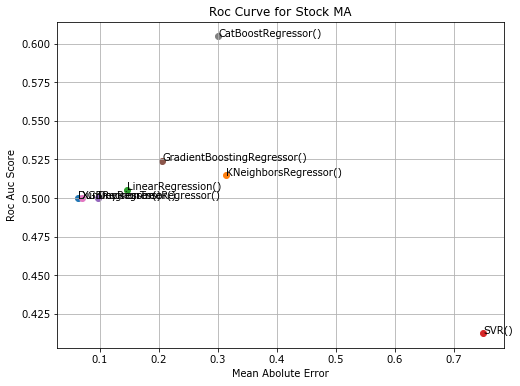

In [22]:
#with hyperparameter tunning
for i in np.arange(0,100,10):
    auc_roc_plot(y_train.iloc[:,int(i/10)] ,  y_test.iloc[:,int(i/10)], X_train.iloc[:,i:i+10], 
               X_test.iloc[:,i:i+10])

[14:50:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2772241	total: 689us	remaining: 689ms
1:	learn: 0.2718713	total: 1.31ms	remaining: 655ms
2:	learn: 0.2666847	total: 1.96ms	remaining: 653ms
3:	learn: 0.2616884	total: 2.51ms	remaining: 625ms
4:	learn: 0.2573516	total: 2.85ms	remaining: 567ms
5:	learn: 0.2525194	total: 3.38ms	remaining: 560ms
6:	learn: 0.2476308	total: 3.99ms	remaining: 567ms
7:	learn: 0.2430827	total: 4.61ms	remaining: 572ms
8:	learn: 0.2381642	total: 5.41ms	remaining: 596ms
9:	learn: 0.2338086	total: 6.15ms	remaining: 609ms
10:	learn: 0.2292117	total: 6.73ms	remaining: 605ms
11:	learn: 0.2250458	total: 7.43ms	remaining: 612ms
12:	learn: 0.2210528	total: 7.99ms	remaining: 606ms
13:	learn: 0.2167420	total: 8.66ms	remaining: 610ms
14:	learn: 0.2126948	total: 9.34ms	remaining: 613ms
15:	learn: 0.2086427	total: 9.92ms	re

171:	learn: 0.0264032	total: 95.9ms	remaining: 462ms
172:	learn: 0.0261539	total: 96.8ms	remaining: 463ms
173:	learn: 0.0259739	total: 97.4ms	remaining: 462ms
174:	learn: 0.0257633	total: 98ms	remaining: 462ms
175:	learn: 0.0255525	total: 98.5ms	remaining: 461ms
176:	learn: 0.0252963	total: 99ms	remaining: 460ms
177:	learn: 0.0251745	total: 99.5ms	remaining: 459ms
178:	learn: 0.0248940	total: 100ms	remaining: 459ms
179:	learn: 0.0246962	total: 101ms	remaining: 458ms
180:	learn: 0.0245821	total: 101ms	remaining: 458ms
181:	learn: 0.0243910	total: 102ms	remaining: 458ms
182:	learn: 0.0241782	total: 102ms	remaining: 457ms
183:	learn: 0.0240173	total: 103ms	remaining: 457ms
184:	learn: 0.0238450	total: 104ms	remaining: 457ms
185:	learn: 0.0237946	total: 104ms	remaining: 456ms
186:	learn: 0.0236531	total: 105ms	remaining: 456ms
187:	learn: 0.0235308	total: 105ms	remaining: 455ms
188:	learn: 0.0233744	total: 106ms	remaining: 455ms
189:	learn: 0.0232102	total: 107ms	remaining: 455ms
190:	lear

433:	learn: 0.0110974	total: 224ms	remaining: 292ms
434:	learn: 0.0110837	total: 224ms	remaining: 291ms
435:	learn: 0.0110704	total: 225ms	remaining: 291ms
436:	learn: 0.0110333	total: 225ms	remaining: 290ms
437:	learn: 0.0110203	total: 226ms	remaining: 290ms
438:	learn: 0.0109988	total: 227ms	remaining: 290ms
439:	learn: 0.0109861	total: 227ms	remaining: 289ms
440:	learn: 0.0109651	total: 228ms	remaining: 288ms
441:	learn: 0.0109430	total: 228ms	remaining: 288ms
442:	learn: 0.0109076	total: 229ms	remaining: 287ms
443:	learn: 0.0108860	total: 229ms	remaining: 287ms
444:	learn: 0.0108648	total: 229ms	remaining: 286ms
445:	learn: 0.0108446	total: 230ms	remaining: 286ms
446:	learn: 0.0108238	total: 231ms	remaining: 285ms
447:	learn: 0.0108040	total: 231ms	remaining: 285ms
448:	learn: 0.0107837	total: 232ms	remaining: 284ms
449:	learn: 0.0107638	total: 232ms	remaining: 284ms
450:	learn: 0.0107444	total: 232ms	remaining: 283ms
451:	learn: 0.0107054	total: 233ms	remaining: 282ms
452:	learn: 

752:	learn: 0.0048393	total: 365ms	remaining: 120ms
753:	learn: 0.0048327	total: 366ms	remaining: 119ms
754:	learn: 0.0048261	total: 366ms	remaining: 119ms
755:	learn: 0.0048197	total: 367ms	remaining: 118ms
756:	learn: 0.0048116	total: 367ms	remaining: 118ms
757:	learn: 0.0048051	total: 367ms	remaining: 117ms
758:	learn: 0.0047971	total: 368ms	remaining: 117ms
759:	learn: 0.0047917	total: 368ms	remaining: 116ms
760:	learn: 0.0047671	total: 369ms	remaining: 116ms
761:	learn: 0.0047607	total: 369ms	remaining: 115ms
762:	learn: 0.0047365	total: 370ms	remaining: 115ms
763:	learn: 0.0047305	total: 370ms	remaining: 114ms
764:	learn: 0.0047222	total: 370ms	remaining: 114ms
765:	learn: 0.0047162	total: 371ms	remaining: 113ms
766:	learn: 0.0046976	total: 371ms	remaining: 113ms
767:	learn: 0.0046793	total: 372ms	remaining: 112ms
768:	learn: 0.0046711	total: 372ms	remaining: 112ms
769:	learn: 0.0046531	total: 373ms	remaining: 111ms
770:	learn: 0.0046479	total: 373ms	remaining: 111ms
771:	learn: 

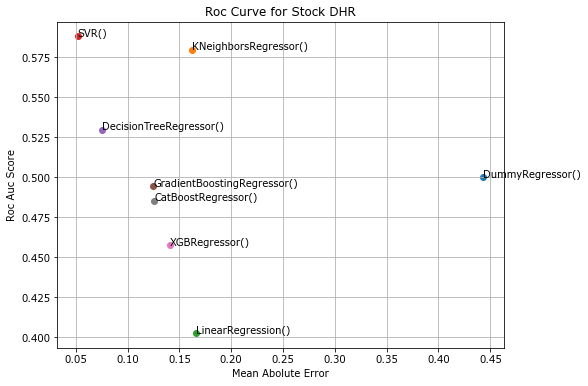

[14:50:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2861111	total: 739us	remaining: 738ms
1:	learn: 0.2808266	total: 1.5ms	remaining: 751ms
2:	learn: 0.2757646	total: 2.41ms	remaining: 802ms
3:	learn: 0.2709055	total: 3.15ms	remaining: 783ms
4:	learn: 0.2663569	total: 3.89ms	remaining: 774ms
5:	learn: 0.2615769	total: 4.66ms	remaining: 771ms
6:	learn: 0.2568589	total: 5.45ms	remaining: 774ms
7:	learn: 0.2522449	total: 6.14ms	remaining: 762ms
8:	learn: 0.2476371	total: 7.02ms	remaining: 773ms
9:	learn: 0.2430683	total: 7.8ms	remaining: 772ms
10:	learn: 0.2390423	total: 8.43ms	remaining: 758ms
11:	learn: 0.2350751	total: 9.21ms	remaining: 758ms
12:	learn: 0.2309267	total: 9.96ms	remaining: 756ms
13:	learn: 0.2267684	total: 10.7ms	remaining: 753ms
14:	learn: 0.2230616	total: 11.4ms	remaining: 746ms
15:	learn: 0.2191548	total: 12ms	remain

392:	learn: 0.0209715	total: 241ms	remaining: 372ms
393:	learn: 0.0209234	total: 241ms	remaining: 371ms
394:	learn: 0.0208923	total: 242ms	remaining: 371ms
395:	learn: 0.0208673	total: 242ms	remaining: 370ms
396:	learn: 0.0208426	total: 243ms	remaining: 369ms
397:	learn: 0.0207410	total: 244ms	remaining: 369ms
398:	learn: 0.0206935	total: 244ms	remaining: 368ms
399:	learn: 0.0206661	total: 245ms	remaining: 367ms
400:	learn: 0.0206144	total: 246ms	remaining: 367ms
401:	learn: 0.0204944	total: 246ms	remaining: 366ms
402:	learn: 0.0204673	total: 247ms	remaining: 365ms
403:	learn: 0.0204360	total: 247ms	remaining: 365ms
404:	learn: 0.0204093	total: 248ms	remaining: 364ms
405:	learn: 0.0202957	total: 248ms	remaining: 363ms
406:	learn: 0.0202446	total: 249ms	remaining: 363ms
407:	learn: 0.0202138	total: 249ms	remaining: 362ms
408:	learn: 0.0201902	total: 250ms	remaining: 361ms
409:	learn: 0.0200845	total: 250ms	remaining: 360ms
410:	learn: 0.0200545	total: 251ms	remaining: 360ms
411:	learn: 

626:	learn: 0.0128934	total: 366ms	remaining: 218ms
627:	learn: 0.0128516	total: 367ms	remaining: 217ms
628:	learn: 0.0128104	total: 367ms	remaining: 217ms
629:	learn: 0.0127772	total: 368ms	remaining: 216ms
630:	learn: 0.0127366	total: 369ms	remaining: 216ms
631:	learn: 0.0126744	total: 369ms	remaining: 215ms
632:	learn: 0.0126559	total: 370ms	remaining: 214ms
633:	learn: 0.0126341	total: 370ms	remaining: 214ms
634:	learn: 0.0125946	total: 371ms	remaining: 213ms
635:	learn: 0.0125341	total: 371ms	remaining: 213ms
636:	learn: 0.0125129	total: 372ms	remaining: 212ms
637:	learn: 0.0124746	total: 372ms	remaining: 211ms
638:	learn: 0.0124369	total: 373ms	remaining: 211ms
639:	learn: 0.0123786	total: 373ms	remaining: 210ms
640:	learn: 0.0123597	total: 374ms	remaining: 209ms
641:	learn: 0.0123272	total: 374ms	remaining: 209ms
642:	learn: 0.0123086	total: 375ms	remaining: 208ms
643:	learn: 0.0122880	total: 375ms	remaining: 208ms
644:	learn: 0.0122512	total: 376ms	remaining: 207ms
645:	learn: 

829:	learn: 0.0083507	total: 483ms	remaining: 99ms
830:	learn: 0.0083232	total: 484ms	remaining: 98.4ms
831:	learn: 0.0083052	total: 485ms	remaining: 97.9ms
832:	learn: 0.0082971	total: 485ms	remaining: 97.3ms
833:	learn: 0.0082793	total: 486ms	remaining: 96.7ms
834:	learn: 0.0082691	total: 487ms	remaining: 96.2ms
835:	learn: 0.0082578	total: 487ms	remaining: 95.6ms
836:	learn: 0.0082233	total: 488ms	remaining: 95ms
837:	learn: 0.0082058	total: 489ms	remaining: 94.4ms
838:	learn: 0.0081906	total: 498ms	remaining: 95.5ms
839:	learn: 0.0081733	total: 499ms	remaining: 95ms
840:	learn: 0.0081636	total: 499ms	remaining: 94.4ms
841:	learn: 0.0081433	total: 500ms	remaining: 93.8ms
842:	learn: 0.0081314	total: 501ms	remaining: 93.2ms
843:	learn: 0.0081132	total: 501ms	remaining: 92.7ms
844:	learn: 0.0080983	total: 502ms	remaining: 92.1ms
845:	learn: 0.0080864	total: 503ms	remaining: 91.5ms
846:	learn: 0.0080656	total: 503ms	remaining: 90.9ms
847:	learn: 0.0080563	total: 504ms	remaining: 90.4ms

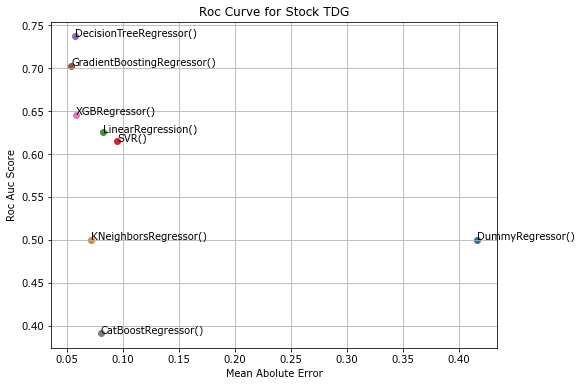

[14:50:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2760176	total: 750us	remaining: 750ms
1:	learn: 0.2704682	total: 1.37ms	remaining: 683ms
2:	learn: 0.2653176	total: 1.92ms	remaining: 639ms
3:	learn: 0.2603153	total: 2.55ms	remaining: 635ms
4:	learn: 0.2554555	total: 2.79ms	remaining: 556ms
5:	learn: 0.2505791	total: 3.39ms	remaining: 562ms
6:	learn: 0.2458561	total: 3.97ms	remaining: 563ms
7:	learn: 0.2411342	total: 4.61ms	remaining: 571ms
8:	learn: 0.2364133	total: 5.21ms	remaining: 574ms
9:	learn: 0.2323880	total: 5.84ms	remaining: 579ms
10:	learn: 0.2279900	total: 6.42ms	remaining: 578ms
11:	learn: 0.2235538	total: 7.04ms	remaining: 580ms
12:	learn: 0.2197721	total: 7.64ms	remaining: 580ms
13:	learn: 0.2157978	total: 8.3ms	remaining: 585ms
14:	learn: 0.2119245	total: 8.9ms	remaining: 585ms
15:	learn: 0.2080983	total: 9.54ms	rema

159:	learn: 0.0360799	total: 92.7ms	remaining: 487ms
160:	learn: 0.0359025	total: 93.5ms	remaining: 487ms
161:	learn: 0.0356616	total: 94.1ms	remaining: 487ms
162:	learn: 0.0354080	total: 94.7ms	remaining: 486ms
163:	learn: 0.0352018	total: 95.5ms	remaining: 487ms
164:	learn: 0.0349664	total: 96ms	remaining: 486ms
165:	learn: 0.0347606	total: 96.7ms	remaining: 486ms
166:	learn: 0.0344925	total: 97.3ms	remaining: 485ms
167:	learn: 0.0342934	total: 97.9ms	remaining: 485ms
168:	learn: 0.0340968	total: 98.6ms	remaining: 485ms
169:	learn: 0.0339052	total: 99.1ms	remaining: 484ms
170:	learn: 0.0337971	total: 99.5ms	remaining: 483ms
171:	learn: 0.0336259	total: 100ms	remaining: 483ms
172:	learn: 0.0334344	total: 101ms	remaining: 482ms
173:	learn: 0.0332014	total: 101ms	remaining: 482ms
174:	learn: 0.0329953	total: 102ms	remaining: 481ms
175:	learn: 0.0328319	total: 103ms	remaining: 481ms
176:	learn: 0.0325493	total: 103ms	remaining: 480ms
177:	learn: 0.0323903	total: 104ms	remaining: 479ms
17

401:	learn: 0.0121980	total: 225ms	remaining: 335ms
402:	learn: 0.0121772	total: 226ms	remaining: 334ms
403:	learn: 0.0121568	total: 226ms	remaining: 334ms
404:	learn: 0.0120971	total: 227ms	remaining: 334ms
405:	learn: 0.0120428	total: 228ms	remaining: 333ms
406:	learn: 0.0119794	total: 228ms	remaining: 332ms
407:	learn: 0.0119604	total: 229ms	remaining: 332ms
408:	learn: 0.0119416	total: 229ms	remaining: 331ms
409:	learn: 0.0118832	total: 230ms	remaining: 331ms
410:	learn: 0.0118304	total: 230ms	remaining: 330ms
411:	learn: 0.0117688	total: 231ms	remaining: 330ms
412:	learn: 0.0117536	total: 232ms	remaining: 329ms
413:	learn: 0.0117352	total: 232ms	remaining: 329ms
414:	learn: 0.0116780	total: 233ms	remaining: 328ms
415:	learn: 0.0116599	total: 233ms	remaining: 328ms
416:	learn: 0.0115999	total: 234ms	remaining: 327ms
417:	learn: 0.0115486	total: 235ms	remaining: 327ms
418:	learn: 0.0115340	total: 235ms	remaining: 326ms
419:	learn: 0.0114781	total: 236ms	remaining: 325ms
420:	learn: 

680:	learn: 0.0057055	total: 370ms	remaining: 173ms
681:	learn: 0.0056999	total: 371ms	remaining: 173ms
682:	learn: 0.0056689	total: 372ms	remaining: 172ms
683:	learn: 0.0056496	total: 372ms	remaining: 172ms
684:	learn: 0.0056372	total: 373ms	remaining: 171ms
685:	learn: 0.0056067	total: 373ms	remaining: 171ms
686:	learn: 0.0055877	total: 374ms	remaining: 170ms
687:	learn: 0.0055755	total: 375ms	remaining: 170ms
688:	learn: 0.0055455	total: 375ms	remaining: 169ms
689:	learn: 0.0055373	total: 376ms	remaining: 169ms
690:	learn: 0.0055320	total: 376ms	remaining: 168ms
691:	learn: 0.0055024	total: 377ms	remaining: 168ms
692:	learn: 0.0054837	total: 377ms	remaining: 167ms
693:	learn: 0.0054547	total: 378ms	remaining: 167ms
694:	learn: 0.0054455	total: 379ms	remaining: 166ms
695:	learn: 0.0054375	total: 379ms	remaining: 166ms
696:	learn: 0.0054191	total: 380ms	remaining: 165ms
697:	learn: 0.0054073	total: 380ms	remaining: 165ms
698:	learn: 0.0053786	total: 381ms	remaining: 164ms
699:	learn: 

889:	learn: 0.0033604	total: 515ms	remaining: 63.6ms
890:	learn: 0.0033501	total: 516ms	remaining: 63.1ms
891:	learn: 0.0033411	total: 516ms	remaining: 62.5ms
892:	learn: 0.0033232	total: 517ms	remaining: 61.9ms
893:	learn: 0.0033178	total: 518ms	remaining: 61.4ms
894:	learn: 0.0033143	total: 519ms	remaining: 60.8ms
895:	learn: 0.0033070	total: 519ms	remaining: 60.3ms
896:	learn: 0.0033017	total: 520ms	remaining: 59.7ms
897:	learn: 0.0032916	total: 521ms	remaining: 59.2ms
898:	learn: 0.0032829	total: 522ms	remaining: 58.7ms
899:	learn: 0.0032773	total: 523ms	remaining: 58.1ms
900:	learn: 0.0032686	total: 524ms	remaining: 57.5ms
901:	learn: 0.0032613	total: 524ms	remaining: 57ms
902:	learn: 0.0032510	total: 525ms	remaining: 56.4ms
903:	learn: 0.0032478	total: 526ms	remaining: 55.8ms
904:	learn: 0.0032428	total: 527ms	remaining: 55.3ms
905:	learn: 0.0032307	total: 527ms	remaining: 54.7ms
906:	learn: 0.0032258	total: 528ms	remaining: 54.1ms
907:	learn: 0.0032159	total: 529ms	remaining: 53

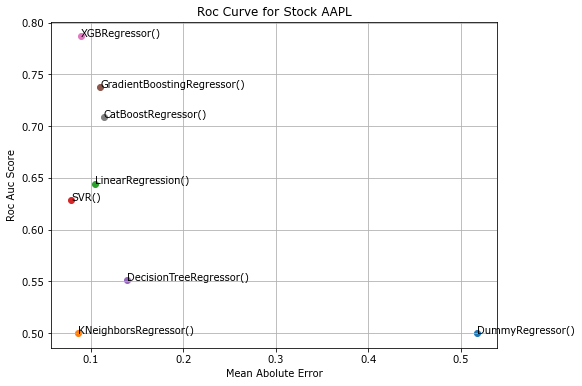

[14:50:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2372772	total: 745us	remaining: 745ms
1:	learn: 0.2328995	total: 1.38ms	remaining: 686ms
2:	learn: 0.2287774	total: 2.07ms	remaining: 688ms
3:	learn: 0.2246574	total: 2.49ms	remaining: 621ms
4:	learn: 0.2209049	total: 3.17ms	remaining: 632ms
5:	learn: 0.2172293	total: 3.8ms	remaining: 629ms
6:	learn: 0.2137444	total: 4.54ms	remaining: 644ms
7:	learn: 0.2106812	total: 5.22ms	remaining: 647ms
8:	learn: 0.2067666	total: 5.8ms	remaining: 638ms
9:	learn: 0.2034424	total: 6.53ms	remaining: 647ms
10:	learn: 0.2001107	total: 7.32ms	remaining: 658ms
11:	learn: 0.1973657	total: 7.97ms	remaining: 656ms
12:	learn: 0.1939786	total: 8.74ms	remaining: 664ms
13:	learn: 0.1907238	total: 9.55ms	remaining: 673ms
14:	learn: 0.1876740	total: 10.3ms	remaining: 674ms
15:	learn: 0.1843712	total: 11ms	remain

160:	learn: 0.0511356	total: 108ms	remaining: 565ms
161:	learn: 0.0508811	total: 109ms	remaining: 564ms
162:	learn: 0.0506738	total: 110ms	remaining: 563ms
163:	learn: 0.0503914	total: 110ms	remaining: 563ms
164:	learn: 0.0500939	total: 111ms	remaining: 562ms
165:	learn: 0.0498409	total: 112ms	remaining: 561ms
166:	learn: 0.0495505	total: 112ms	remaining: 560ms
167:	learn: 0.0492423	total: 113ms	remaining: 559ms
168:	learn: 0.0490437	total: 113ms	remaining: 558ms
169:	learn: 0.0487630	total: 114ms	remaining: 557ms
170:	learn: 0.0484544	total: 115ms	remaining: 557ms
171:	learn: 0.0481903	total: 115ms	remaining: 556ms
172:	learn: 0.0479776	total: 116ms	remaining: 556ms
173:	learn: 0.0477199	total: 117ms	remaining: 555ms
174:	learn: 0.0474706	total: 118ms	remaining: 555ms
175:	learn: 0.0472683	total: 119ms	remaining: 555ms
176:	learn: 0.0471063	total: 119ms	remaining: 554ms
177:	learn: 0.0469368	total: 120ms	remaining: 554ms
178:	learn: 0.0467214	total: 121ms	remaining: 553ms
179:	learn: 

345:	learn: 0.0238535	total: 214ms	remaining: 404ms
346:	learn: 0.0237288	total: 214ms	remaining: 403ms
347:	learn: 0.0236521	total: 215ms	remaining: 403ms
348:	learn: 0.0235857	total: 216ms	remaining: 402ms
349:	learn: 0.0235053	total: 216ms	remaining: 401ms
350:	learn: 0.0234399	total: 217ms	remaining: 401ms
351:	learn: 0.0233755	total: 217ms	remaining: 400ms
352:	learn: 0.0232952	total: 218ms	remaining: 400ms
353:	learn: 0.0232300	total: 219ms	remaining: 399ms
354:	learn: 0.0231432	total: 219ms	remaining: 398ms
355:	learn: 0.0230834	total: 220ms	remaining: 397ms
356:	learn: 0.0230215	total: 220ms	remaining: 397ms
357:	learn: 0.0229427	total: 221ms	remaining: 396ms
358:	learn: 0.0228757	total: 221ms	remaining: 395ms
359:	learn: 0.0228129	total: 222ms	remaining: 395ms
360:	learn: 0.0227525	total: 223ms	remaining: 394ms
361:	learn: 0.0226756	total: 223ms	remaining: 394ms
362:	learn: 0.0226161	total: 224ms	remaining: 393ms
363:	learn: 0.0224856	total: 225ms	remaining: 392ms
364:	learn: 

557:	learn: 0.0112787	total: 329ms	remaining: 261ms
558:	learn: 0.0112484	total: 330ms	remaining: 261ms
559:	learn: 0.0112083	total: 331ms	remaining: 260ms
560:	learn: 0.0111783	total: 332ms	remaining: 260ms
561:	learn: 0.0111387	total: 332ms	remaining: 259ms
562:	learn: 0.0111105	total: 333ms	remaining: 259ms
563:	learn: 0.0110646	total: 334ms	remaining: 258ms
564:	learn: 0.0110442	total: 335ms	remaining: 258ms
565:	learn: 0.0110242	total: 335ms	remaining: 257ms
566:	learn: 0.0109791	total: 336ms	remaining: 256ms
567:	learn: 0.0109360	total: 336ms	remaining: 256ms
568:	learn: 0.0108939	total: 337ms	remaining: 255ms
569:	learn: 0.0108493	total: 338ms	remaining: 255ms
570:	learn: 0.0108152	total: 339ms	remaining: 254ms
571:	learn: 0.0107859	total: 339ms	remaining: 254ms
572:	learn: 0.0107424	total: 340ms	remaining: 253ms
573:	learn: 0.0106965	total: 341ms	remaining: 253ms
574:	learn: 0.0106848	total: 341ms	remaining: 252ms
575:	learn: 0.0106293	total: 342ms	remaining: 252ms
576:	learn: 

716:	learn: 0.0070292	total: 440ms	remaining: 174ms
717:	learn: 0.0070021	total: 441ms	remaining: 173ms
718:	learn: 0.0069801	total: 442ms	remaining: 173ms
719:	learn: 0.0069692	total: 442ms	remaining: 172ms
720:	learn: 0.0069585	total: 443ms	remaining: 171ms
721:	learn: 0.0069318	total: 443ms	remaining: 171ms
722:	learn: 0.0069100	total: 444ms	remaining: 170ms
723:	learn: 0.0068885	total: 445ms	remaining: 170ms
724:	learn: 0.0068832	total: 445ms	remaining: 169ms
725:	learn: 0.0068727	total: 446ms	remaining: 168ms
726:	learn: 0.0068595	total: 446ms	remaining: 168ms
727:	learn: 0.0068383	total: 447ms	remaining: 167ms
728:	learn: 0.0068330	total: 448ms	remaining: 166ms
729:	learn: 0.0068082	total: 448ms	remaining: 166ms
730:	learn: 0.0067819	total: 449ms	remaining: 165ms
731:	learn: 0.0067610	total: 450ms	remaining: 165ms
732:	learn: 0.0067352	total: 450ms	remaining: 164ms
733:	learn: 0.0067145	total: 451ms	remaining: 163ms
734:	learn: 0.0067094	total: 451ms	remaining: 163ms
735:	learn: 

886:	learn: 0.0042790	total: 552ms	remaining: 70.4ms
887:	learn: 0.0042710	total: 553ms	remaining: 69.7ms
888:	learn: 0.0042612	total: 554ms	remaining: 69.1ms
889:	learn: 0.0042426	total: 554ms	remaining: 68.5ms
890:	learn: 0.0042310	total: 555ms	remaining: 67.9ms
891:	learn: 0.0042116	total: 556ms	remaining: 67.3ms
892:	learn: 0.0042021	total: 557ms	remaining: 66.7ms
893:	learn: 0.0041840	total: 558ms	remaining: 66.1ms
894:	learn: 0.0041685	total: 559ms	remaining: 65.5ms
895:	learn: 0.0041557	total: 559ms	remaining: 64.9ms
896:	learn: 0.0041459	total: 560ms	remaining: 64.3ms
897:	learn: 0.0041380	total: 561ms	remaining: 63.7ms
898:	learn: 0.0041270	total: 561ms	remaining: 63.1ms
899:	learn: 0.0041144	total: 562ms	remaining: 62.4ms
900:	learn: 0.0041048	total: 563ms	remaining: 61.9ms
901:	learn: 0.0040923	total: 564ms	remaining: 61.2ms
902:	learn: 0.0040823	total: 565ms	remaining: 60.6ms
903:	learn: 0.0040658	total: 565ms	remaining: 60ms
904:	learn: 0.0040580	total: 566ms	remaining: 59

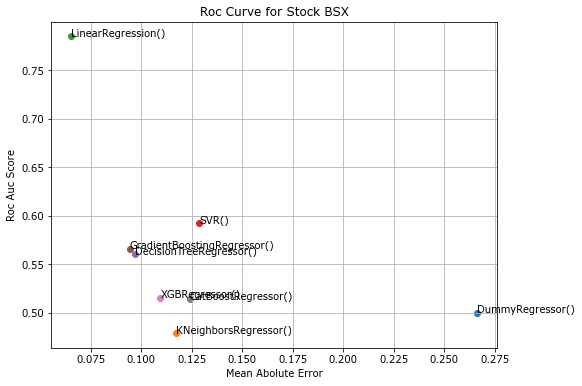

[14:50:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2057341	total: 748us	remaining: 747ms
1:	learn: 0.2019668	total: 1.36ms	remaining: 680ms
2:	learn: 0.1980025	total: 2.09ms	remaining: 694ms
3:	learn: 0.1941639	total: 2.66ms	remaining: 663ms
4:	learn: 0.1904132	total: 3.29ms	remaining: 654ms
5:	learn: 0.1867959	total: 3.91ms	remaining: 648ms
6:	learn: 0.1835416	total: 4.55ms	remaining: 646ms
7:	learn: 0.1802190	total: 5.25ms	remaining: 652ms
8:	learn: 0.1769404	total: 5.98ms	remaining: 658ms
9:	learn: 0.1738676	total: 6.6ms	remaining: 653ms
10:	learn: 0.1708326	total: 7.17ms	remaining: 645ms
11:	learn: 0.1675950	total: 7.75ms	remaining: 638ms
12:	learn: 0.1644965	total: 8.25ms	remaining: 626ms
13:	learn: 0.1614866	total: 8.94ms	remaining: 630ms
14:	learn: 0.1584521	total: 9.67ms	remaining: 635ms
15:	learn: 0.1552834	total: 10.1ms	rem

167:	learn: 0.0353345	total: 102ms	remaining: 508ms
168:	learn: 0.0351155	total: 103ms	remaining: 508ms
169:	learn: 0.0349689	total: 104ms	remaining: 508ms
170:	learn: 0.0347638	total: 105ms	remaining: 507ms
171:	learn: 0.0345461	total: 105ms	remaining: 506ms
172:	learn: 0.0343869	total: 106ms	remaining: 506ms
173:	learn: 0.0342159	total: 107ms	remaining: 506ms
174:	learn: 0.0340856	total: 107ms	remaining: 505ms
175:	learn: 0.0338971	total: 108ms	remaining: 504ms
176:	learn: 0.0337513	total: 108ms	remaining: 504ms
177:	learn: 0.0335786	total: 109ms	remaining: 503ms
178:	learn: 0.0334270	total: 110ms	remaining: 503ms
179:	learn: 0.0331821	total: 110ms	remaining: 502ms
180:	learn: 0.0330223	total: 111ms	remaining: 502ms
181:	learn: 0.0328977	total: 111ms	remaining: 501ms
182:	learn: 0.0327414	total: 112ms	remaining: 500ms
183:	learn: 0.0325857	total: 113ms	remaining: 500ms
184:	learn: 0.0323873	total: 113ms	remaining: 500ms
185:	learn: 0.0321873	total: 114ms	remaining: 499ms
186:	learn: 

395:	learn: 0.0147176	total: 220ms	remaining: 335ms
396:	learn: 0.0146791	total: 220ms	remaining: 335ms
397:	learn: 0.0146452	total: 221ms	remaining: 334ms
398:	learn: 0.0146078	total: 222ms	remaining: 334ms
399:	learn: 0.0145576	total: 222ms	remaining: 333ms
400:	learn: 0.0145199	total: 223ms	remaining: 333ms
401:	learn: 0.0144829	total: 223ms	remaining: 332ms
402:	learn: 0.0144532	total: 224ms	remaining: 332ms
403:	learn: 0.0144243	total: 224ms	remaining: 331ms
404:	learn: 0.0143629	total: 225ms	remaining: 331ms
405:	learn: 0.0143271	total: 226ms	remaining: 330ms
406:	learn: 0.0142786	total: 226ms	remaining: 330ms
407:	learn: 0.0142513	total: 227ms	remaining: 329ms
408:	learn: 0.0142221	total: 227ms	remaining: 329ms
409:	learn: 0.0141937	total: 228ms	remaining: 328ms
410:	learn: 0.0141582	total: 229ms	remaining: 328ms
411:	learn: 0.0141304	total: 229ms	remaining: 327ms
412:	learn: 0.0140830	total: 230ms	remaining: 327ms
413:	learn: 0.0140549	total: 230ms	remaining: 326ms
414:	learn: 

609:	learn: 0.0085184	total: 327ms	remaining: 209ms
610:	learn: 0.0085064	total: 328ms	remaining: 209ms
611:	learn: 0.0084786	total: 328ms	remaining: 208ms
612:	learn: 0.0084667	total: 329ms	remaining: 208ms
613:	learn: 0.0084603	total: 329ms	remaining: 207ms
614:	learn: 0.0084169	total: 330ms	remaining: 206ms
615:	learn: 0.0084105	total: 330ms	remaining: 206ms
616:	learn: 0.0083987	total: 331ms	remaining: 205ms
617:	learn: 0.0083718	total: 331ms	remaining: 205ms
618:	learn: 0.0083601	total: 332ms	remaining: 204ms
619:	learn: 0.0083538	total: 332ms	remaining: 204ms
620:	learn: 0.0083422	total: 333ms	remaining: 203ms
621:	learn: 0.0082955	total: 333ms	remaining: 202ms
622:	learn: 0.0082892	total: 333ms	remaining: 202ms
623:	learn: 0.0082830	total: 334ms	remaining: 201ms
624:	learn: 0.0082372	total: 334ms	remaining: 201ms
625:	learn: 0.0082310	total: 335ms	remaining: 200ms
626:	learn: 0.0082196	total: 335ms	remaining: 199ms
627:	learn: 0.0081938	total: 336ms	remaining: 199ms
628:	learn: 

838:	learn: 0.0048698	total: 436ms	remaining: 83.7ms
839:	learn: 0.0048658	total: 437ms	remaining: 83.2ms
840:	learn: 0.0048512	total: 438ms	remaining: 82.7ms
841:	learn: 0.0048357	total: 438ms	remaining: 82.2ms
842:	learn: 0.0048243	total: 439ms	remaining: 81.7ms
843:	learn: 0.0048121	total: 439ms	remaining: 81.2ms
844:	learn: 0.0048081	total: 440ms	remaining: 80.7ms
845:	learn: 0.0047991	total: 440ms	remaining: 80.1ms
846:	learn: 0.0047764	total: 441ms	remaining: 79.6ms
847:	learn: 0.0047619	total: 441ms	remaining: 79.1ms
848:	learn: 0.0047580	total: 442ms	remaining: 78.6ms
849:	learn: 0.0047437	total: 442ms	remaining: 78.1ms
850:	learn: 0.0047398	total: 443ms	remaining: 77.6ms
851:	learn: 0.0047281	total: 444ms	remaining: 77ms
852:	learn: 0.0047242	total: 444ms	remaining: 76.6ms
853:	learn: 0.0047101	total: 445ms	remaining: 76.1ms
854:	learn: 0.0046994	total: 446ms	remaining: 75.6ms
855:	learn: 0.0046879	total: 446ms	remaining: 75.1ms
856:	learn: 0.0046841	total: 447ms	remaining: 74

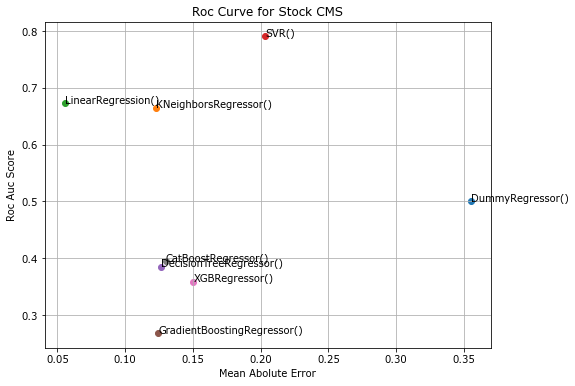

[14:50:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2540758	total: 706us	remaining: 706ms
1:	learn: 0.2493768	total: 1.29ms	remaining: 644ms
2:	learn: 0.2446144	total: 1.95ms	remaining: 647ms
3:	learn: 0.2399129	total: 2.49ms	remaining: 620ms
4:	learn: 0.2354111	total: 3.15ms	remaining: 628ms
5:	learn: 0.2313702	total: 3.97ms	remaining: 658ms
6:	learn: 0.2268655	total: 4.53ms	remaining: 643ms
7:	learn: 0.2226623	total: 5.34ms	remaining: 662ms
8:	learn: 0.2184417	total: 6.01ms	remaining: 662ms
9:	learn: 0.2144132	total: 6.61ms	remaining: 655ms
10:	learn: 0.2108022	total: 7.16ms	remaining: 643ms
11:	learn: 0.2070965	total: 8.04ms	remaining: 662ms
12:	learn: 0.2034575	total: 8.73ms	remaining: 663ms
13:	learn: 0.1998808	total: 9.37ms	remaining: 660ms
14:	learn: 0.1961742	total: 10.1ms	remaining: 664ms
15:	learn: 0.1927249	total: 10.9ms	re

178:	learn: 0.0425220	total: 113ms	remaining: 519ms
179:	learn: 0.0423008	total: 114ms	remaining: 518ms
180:	learn: 0.0420376	total: 114ms	remaining: 518ms
181:	learn: 0.0417431	total: 115ms	remaining: 517ms
182:	learn: 0.0415388	total: 116ms	remaining: 516ms
183:	learn: 0.0412445	total: 116ms	remaining: 515ms
184:	learn: 0.0410368	total: 117ms	remaining: 515ms
185:	learn: 0.0408174	total: 117ms	remaining: 514ms
186:	learn: 0.0406541	total: 118ms	remaining: 513ms
187:	learn: 0.0404419	total: 119ms	remaining: 513ms
188:	learn: 0.0402506	total: 119ms	remaining: 512ms
189:	learn: 0.0401088	total: 120ms	remaining: 511ms
190:	learn: 0.0399492	total: 121ms	remaining: 510ms
191:	learn: 0.0397486	total: 121ms	remaining: 510ms
192:	learn: 0.0395947	total: 122ms	remaining: 510ms
193:	learn: 0.0393613	total: 123ms	remaining: 509ms
194:	learn: 0.0391149	total: 123ms	remaining: 508ms
195:	learn: 0.0388261	total: 124ms	remaining: 508ms
196:	learn: 0.0386524	total: 124ms	remaining: 507ms
197:	learn: 

389:	learn: 0.0206563	total: 237ms	remaining: 371ms
390:	learn: 0.0206061	total: 238ms	remaining: 370ms
391:	learn: 0.0205501	total: 238ms	remaining: 369ms
392:	learn: 0.0205309	total: 239ms	remaining: 369ms
393:	learn: 0.0204873	total: 239ms	remaining: 368ms
394:	learn: 0.0204319	total: 240ms	remaining: 368ms
395:	learn: 0.0203888	total: 240ms	remaining: 367ms
396:	learn: 0.0203423	total: 241ms	remaining: 366ms
397:	learn: 0.0202874	total: 241ms	remaining: 365ms
398:	learn: 0.0202669	total: 242ms	remaining: 364ms
399:	learn: 0.0201880	total: 242ms	remaining: 364ms
400:	learn: 0.0201335	total: 243ms	remaining: 363ms
401:	learn: 0.0201153	total: 244ms	remaining: 363ms
402:	learn: 0.0200440	total: 244ms	remaining: 362ms
403:	learn: 0.0199904	total: 245ms	remaining: 362ms
404:	learn: 0.0199725	total: 246ms	remaining: 361ms
405:	learn: 0.0199191	total: 246ms	remaining: 360ms
406:	learn: 0.0198994	total: 247ms	remaining: 359ms
407:	learn: 0.0198420	total: 247ms	remaining: 359ms
408:	learn: 

587:	learn: 0.0122940	total: 347ms	remaining: 243ms
588:	learn: 0.0122824	total: 348ms	remaining: 243ms
589:	learn: 0.0122424	total: 349ms	remaining: 242ms
590:	learn: 0.0122081	total: 349ms	remaining: 242ms
591:	learn: 0.0121926	total: 350ms	remaining: 241ms
592:	learn: 0.0121529	total: 351ms	remaining: 241ms
593:	learn: 0.0121376	total: 351ms	remaining: 240ms
594:	learn: 0.0120983	total: 352ms	remaining: 239ms
595:	learn: 0.0120595	total: 352ms	remaining: 239ms
596:	learn: 0.0120320	total: 353ms	remaining: 238ms
597:	learn: 0.0119684	total: 353ms	remaining: 237ms
598:	learn: 0.0119533	total: 354ms	remaining: 237ms
599:	learn: 0.0119078	total: 354ms	remaining: 236ms
600:	learn: 0.0118699	total: 355ms	remaining: 236ms
601:	learn: 0.0118097	total: 355ms	remaining: 235ms
602:	learn: 0.0117837	total: 356ms	remaining: 234ms
603:	learn: 0.0117689	total: 356ms	remaining: 234ms
604:	learn: 0.0117244	total: 357ms	remaining: 233ms
605:	learn: 0.0116805	total: 357ms	remaining: 232ms
606:	learn: 

806:	learn: 0.0064965	total: 456ms	remaining: 109ms
807:	learn: 0.0064841	total: 457ms	remaining: 109ms
808:	learn: 0.0064607	total: 457ms	remaining: 108ms
809:	learn: 0.0064478	total: 458ms	remaining: 107ms
810:	learn: 0.0064254	total: 459ms	remaining: 107ms
811:	learn: 0.0064127	total: 459ms	remaining: 106ms
812:	learn: 0.0063942	total: 460ms	remaining: 106ms
813:	learn: 0.0063818	total: 460ms	remaining: 105ms
814:	learn: 0.0063624	total: 461ms	remaining: 105ms
815:	learn: 0.0063392	total: 461ms	remaining: 104ms
816:	learn: 0.0063201	total: 462ms	remaining: 103ms
817:	learn: 0.0063012	total: 462ms	remaining: 103ms
818:	learn: 0.0062889	total: 463ms	remaining: 102ms
819:	learn: 0.0062582	total: 463ms	remaining: 102ms
820:	learn: 0.0062377	total: 464ms	remaining: 101ms
821:	learn: 0.0062258	total: 465ms	remaining: 101ms
822:	learn: 0.0062033	total: 465ms	remaining: 100ms
823:	learn: 0.0061847	total: 466ms	remaining: 99.4ms
824:	learn: 0.0061730	total: 466ms	remaining: 98.9ms
825:	learn

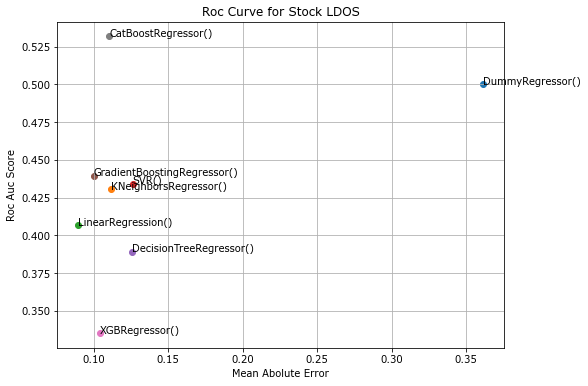

[14:50:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2415680	total: 673us	remaining: 673ms
1:	learn: 0.2370708	total: 1.25ms	remaining: 623ms
2:	learn: 0.2322808	total: 1.83ms	remaining: 607ms
3:	learn: 0.2274289	total: 2.39ms	remaining: 595ms
4:	learn: 0.2231049	total: 2.94ms	remaining: 586ms
5:	learn: 0.2185132	total: 3.66ms	remaining: 607ms
6:	learn: 0.2143601	total: 4.29ms	remaining: 608ms
7:	learn: 0.2104128	total: 4.87ms	remaining: 604ms
8:	learn: 0.2062496	total: 5.59ms	remaining: 616ms
9:	learn: 0.2018803	total: 5.93ms	remaining: 587ms
10:	learn: 0.1979325	total: 6.6ms	remaining: 594ms
11:	learn: 0.1937404	total: 6.99ms	remaining: 575ms
12:	learn: 0.1900752	total: 7.67ms	remaining: 583ms
13:	learn: 0.1865569	total: 8.33ms	remaining: 587ms
14:	learn: 0.1825659	total: 8.99ms	remaining: 590ms
15:	learn: 0.1789821	total: 9.54ms	rem

170:	learn: 0.0363145	total: 97.3ms	remaining: 472ms
171:	learn: 0.0361214	total: 98.1ms	remaining: 472ms
172:	learn: 0.0359890	total: 98.8ms	remaining: 472ms
173:	learn: 0.0358172	total: 99.5ms	remaining: 472ms
174:	learn: 0.0355727	total: 100ms	remaining: 471ms
175:	learn: 0.0354250	total: 101ms	remaining: 471ms
176:	learn: 0.0352520	total: 101ms	remaining: 471ms
177:	learn: 0.0351588	total: 102ms	remaining: 471ms
178:	learn: 0.0349546	total: 103ms	remaining: 470ms
179:	learn: 0.0347966	total: 103ms	remaining: 470ms
180:	learn: 0.0346931	total: 104ms	remaining: 470ms
181:	learn: 0.0345121	total: 104ms	remaining: 469ms
182:	learn: 0.0343522	total: 105ms	remaining: 469ms
183:	learn: 0.0342067	total: 106ms	remaining: 468ms
184:	learn: 0.0340748	total: 106ms	remaining: 468ms
185:	learn: 0.0339469	total: 107ms	remaining: 467ms
186:	learn: 0.0337823	total: 107ms	remaining: 467ms
187:	learn: 0.0336285	total: 108ms	remaining: 467ms
188:	learn: 0.0334301	total: 109ms	remaining: 466ms
189:	lea

377:	learn: 0.0196106	total: 214ms	remaining: 352ms
378:	learn: 0.0195524	total: 215ms	remaining: 352ms
379:	learn: 0.0194635	total: 215ms	remaining: 351ms
380:	learn: 0.0194493	total: 216ms	remaining: 351ms
381:	learn: 0.0193921	total: 217ms	remaining: 350ms
382:	learn: 0.0193250	total: 217ms	remaining: 350ms
383:	learn: 0.0192684	total: 218ms	remaining: 349ms
384:	learn: 0.0192127	total: 218ms	remaining: 348ms
385:	learn: 0.0191577	total: 219ms	remaining: 348ms
386:	learn: 0.0191036	total: 219ms	remaining: 347ms
387:	learn: 0.0190382	total: 220ms	remaining: 346ms
388:	learn: 0.0189847	total: 220ms	remaining: 346ms
389:	learn: 0.0188993	total: 221ms	remaining: 345ms
390:	learn: 0.0188465	total: 221ms	remaining: 344ms
391:	learn: 0.0188332	total: 222ms	remaining: 344ms
392:	learn: 0.0187813	total: 222ms	remaining: 343ms
393:	learn: 0.0187300	total: 223ms	remaining: 342ms
394:	learn: 0.0186672	total: 223ms	remaining: 342ms
395:	learn: 0.0186166	total: 224ms	remaining: 341ms
396:	learn: 

584:	learn: 0.0114175	total: 324ms	remaining: 230ms
585:	learn: 0.0114119	total: 325ms	remaining: 230ms
586:	learn: 0.0114043	total: 326ms	remaining: 229ms
587:	learn: 0.0113689	total: 327ms	remaining: 229ms
588:	learn: 0.0113435	total: 327ms	remaining: 228ms
589:	learn: 0.0113244	total: 328ms	remaining: 228ms
590:	learn: 0.0113145	total: 329ms	remaining: 227ms
591:	learn: 0.0113091	total: 329ms	remaining: 227ms
592:	learn: 0.0112903	total: 330ms	remaining: 226ms
593:	learn: 0.0112621	total: 330ms	remaining: 226ms
594:	learn: 0.0112273	total: 331ms	remaining: 225ms
595:	learn: 0.0112220	total: 332ms	remaining: 225ms
596:	learn: 0.0111730	total: 332ms	remaining: 224ms
597:	learn: 0.0111522	total: 333ms	remaining: 224ms
598:	learn: 0.0111336	total: 333ms	remaining: 223ms
599:	learn: 0.0111153	total: 334ms	remaining: 222ms
600:	learn: 0.0111058	total: 334ms	remaining: 222ms
601:	learn: 0.0111006	total: 335ms	remaining: 221ms
602:	learn: 0.0110522	total: 335ms	remaining: 221ms
603:	learn: 

792:	learn: 0.0070860	total: 447ms	remaining: 117ms
793:	learn: 0.0070740	total: 448ms	remaining: 116ms
794:	learn: 0.0070620	total: 449ms	remaining: 116ms
795:	learn: 0.0070307	total: 449ms	remaining: 115ms
796:	learn: 0.0070189	total: 449ms	remaining: 114ms
797:	learn: 0.0069983	total: 450ms	remaining: 114ms
798:	learn: 0.0069867	total: 450ms	remaining: 113ms
799:	learn: 0.0069761	total: 451ms	remaining: 113ms
800:	learn: 0.0069656	total: 451ms	remaining: 112ms
801:	learn: 0.0069514	total: 452ms	remaining: 112ms
802:	learn: 0.0069294	total: 452ms	remaining: 111ms
803:	learn: 0.0069091	total: 453ms	remaining: 110ms
804:	learn: 0.0068973	total: 453ms	remaining: 110ms
805:	learn: 0.0068944	total: 454ms	remaining: 109ms
806:	learn: 0.0068607	total: 454ms	remaining: 109ms
807:	learn: 0.0068492	total: 455ms	remaining: 108ms
808:	learn: 0.0068376	total: 455ms	remaining: 107ms
809:	learn: 0.0068264	total: 456ms	remaining: 107ms
810:	learn: 0.0068049	total: 456ms	remaining: 106ms
811:	learn: 

975:	learn: 0.0047237	total: 557ms	remaining: 13.7ms
976:	learn: 0.0046944	total: 557ms	remaining: 13.1ms
977:	learn: 0.0046862	total: 558ms	remaining: 12.6ms
978:	learn: 0.0046776	total: 559ms	remaining: 12ms
979:	learn: 0.0046686	total: 559ms	remaining: 11.4ms
980:	learn: 0.0046617	total: 560ms	remaining: 10.8ms
981:	learn: 0.0046414	total: 560ms	remaining: 10.3ms
982:	learn: 0.0046331	total: 561ms	remaining: 9.7ms
983:	learn: 0.0046186	total: 562ms	remaining: 9.13ms
984:	learn: 0.0046101	total: 563ms	remaining: 8.57ms
985:	learn: 0.0045949	total: 563ms	remaining: 8ms
986:	learn: 0.0045807	total: 564ms	remaining: 7.43ms
987:	learn: 0.0045526	total: 565ms	remaining: 6.86ms
988:	learn: 0.0045442	total: 566ms	remaining: 6.29ms
989:	learn: 0.0045294	total: 566ms	remaining: 5.72ms
990:	learn: 0.0045212	total: 567ms	remaining: 5.15ms
991:	learn: 0.0044953	total: 567ms	remaining: 4.58ms
992:	learn: 0.0044872	total: 568ms	remaining: 4ms
993:	learn: 0.0044727	total: 569ms	remaining: 3.43ms
99

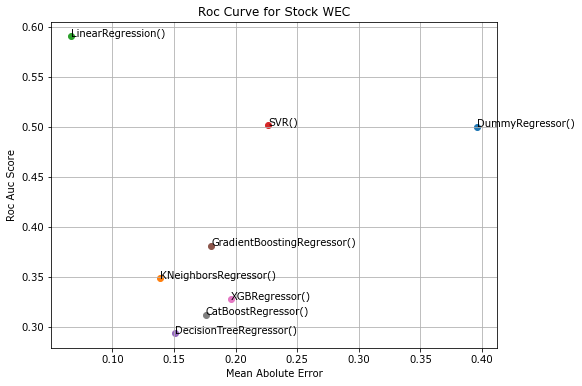

[14:50:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2886486	total: 856us	remaining: 855ms
1:	learn: 0.2836470	total: 1.56ms	remaining: 778ms
2:	learn: 0.2790667	total: 2.24ms	remaining: 745ms
3:	learn: 0.2744115	total: 2.88ms	remaining: 717ms
4:	learn: 0.2705747	total: 3.32ms	remaining: 661ms
5:	learn: 0.2662249	total: 4ms	remaining: 663ms
6:	learn: 0.2614657	total: 4.65ms	remaining: 660ms
7:	learn: 0.2571352	total: 5.38ms	remaining: 667ms
8:	learn: 0.2528024	total: 6.32ms	remaining: 696ms
9:	learn: 0.2486833	total: 7.05ms	remaining: 698ms
10:	learn: 0.2448169	total: 7.7ms	remaining: 692ms
11:	learn: 0.2410097	total: 8.4ms	remaining: 692ms
12:	learn: 0.2369695	total: 9.07ms	remaining: 689ms
13:	learn: 0.2329279	total: 9.78ms	remaining: 689ms
14:	learn: 0.2291104	total: 10.5ms	remaining: 686ms
15:	learn: 0.2252175	total: 11.1ms	remaini

165:	learn: 0.0591657	total: 107ms	remaining: 537ms
166:	learn: 0.0588821	total: 107ms	remaining: 536ms
167:	learn: 0.0585965	total: 108ms	remaining: 536ms
168:	learn: 0.0583603	total: 109ms	remaining: 536ms
169:	learn: 0.0580981	total: 110ms	remaining: 535ms
170:	learn: 0.0577739	total: 110ms	remaining: 535ms
171:	learn: 0.0575022	total: 111ms	remaining: 536ms
172:	learn: 0.0572016	total: 112ms	remaining: 535ms
173:	learn: 0.0569013	total: 113ms	remaining: 534ms
174:	learn: 0.0565055	total: 113ms	remaining: 534ms
175:	learn: 0.0562874	total: 114ms	remaining: 533ms
176:	learn: 0.0560370	total: 114ms	remaining: 532ms
177:	learn: 0.0557437	total: 115ms	remaining: 532ms
178:	learn: 0.0554564	total: 116ms	remaining: 531ms
179:	learn: 0.0551381	total: 117ms	remaining: 531ms
180:	learn: 0.0548247	total: 117ms	remaining: 531ms
181:	learn: 0.0545338	total: 118ms	remaining: 530ms
182:	learn: 0.0542020	total: 118ms	remaining: 529ms
183:	learn: 0.0540651	total: 119ms	remaining: 528ms
184:	learn: 

355:	learn: 0.0293528	total: 212ms	remaining: 383ms
356:	learn: 0.0291825	total: 213ms	remaining: 383ms
357:	learn: 0.0291489	total: 213ms	remaining: 382ms
358:	learn: 0.0291157	total: 214ms	remaining: 382ms
359:	learn: 0.0290830	total: 214ms	remaining: 381ms
360:	learn: 0.0289246	total: 215ms	remaining: 380ms
361:	learn: 0.0288921	total: 215ms	remaining: 379ms
362:	learn: 0.0288600	total: 216ms	remaining: 379ms
363:	learn: 0.0287353	total: 216ms	remaining: 378ms
364:	learn: 0.0286058	total: 217ms	remaining: 377ms
365:	learn: 0.0284414	total: 217ms	remaining: 376ms
366:	learn: 0.0284092	total: 218ms	remaining: 376ms
367:	learn: 0.0283775	total: 218ms	remaining: 375ms
368:	learn: 0.0282250	total: 219ms	remaining: 374ms
369:	learn: 0.0281935	total: 220ms	remaining: 374ms
370:	learn: 0.0280430	total: 220ms	remaining: 373ms
371:	learn: 0.0279246	total: 221ms	remaining: 373ms
372:	learn: 0.0278932	total: 221ms	remaining: 372ms
373:	learn: 0.0277702	total: 222ms	remaining: 371ms
374:	learn: 

590:	learn: 0.0146462	total: 330ms	remaining: 228ms
591:	learn: 0.0146205	total: 331ms	remaining: 228ms
592:	learn: 0.0145524	total: 331ms	remaining: 227ms
593:	learn: 0.0144607	total: 332ms	remaining: 227ms
594:	learn: 0.0144506	total: 332ms	remaining: 226ms
595:	learn: 0.0144406	total: 333ms	remaining: 226ms
596:	learn: 0.0143958	total: 333ms	remaining: 225ms
597:	learn: 0.0143714	total: 334ms	remaining: 224ms
598:	learn: 0.0143616	total: 334ms	remaining: 224ms
599:	learn: 0.0142825	total: 335ms	remaining: 223ms
600:	learn: 0.0142265	total: 335ms	remaining: 223ms
601:	learn: 0.0141601	total: 336ms	remaining: 222ms
602:	learn: 0.0141505	total: 336ms	remaining: 222ms
603:	learn: 0.0141071	total: 337ms	remaining: 221ms
604:	learn: 0.0140975	total: 338ms	remaining: 220ms
605:	learn: 0.0140744	total: 338ms	remaining: 220ms
606:	learn: 0.0139874	total: 339ms	remaining: 219ms
607:	learn: 0.0139769	total: 339ms	remaining: 219ms
608:	learn: 0.0139545	total: 340ms	remaining: 218ms
609:	learn: 

796:	learn: 0.0076075	total: 439ms	remaining: 112ms
797:	learn: 0.0075716	total: 440ms	remaining: 111ms
798:	learn: 0.0075489	total: 440ms	remaining: 111ms
799:	learn: 0.0075004	total: 441ms	remaining: 110ms
800:	learn: 0.0074781	total: 441ms	remaining: 110ms
801:	learn: 0.0074346	total: 442ms	remaining: 109ms
802:	learn: 0.0073950	total: 443ms	remaining: 109ms
803:	learn: 0.0073477	total: 443ms	remaining: 108ms
804:	learn: 0.0073014	total: 443ms	remaining: 107ms
805:	learn: 0.0072635	total: 444ms	remaining: 107ms
806:	learn: 0.0072183	total: 444ms	remaining: 106ms
807:	learn: 0.0071966	total: 445ms	remaining: 106ms
808:	learn: 0.0071860	total: 445ms	remaining: 105ms
809:	learn: 0.0071416	total: 446ms	remaining: 105ms
810:	learn: 0.0071057	total: 446ms	remaining: 104ms
811:	learn: 0.0070623	total: 447ms	remaining: 103ms
812:	learn: 0.0070411	total: 447ms	remaining: 103ms
813:	learn: 0.0069985	total: 448ms	remaining: 102ms
814:	learn: 0.0069774	total: 448ms	remaining: 102ms
815:	learn: 

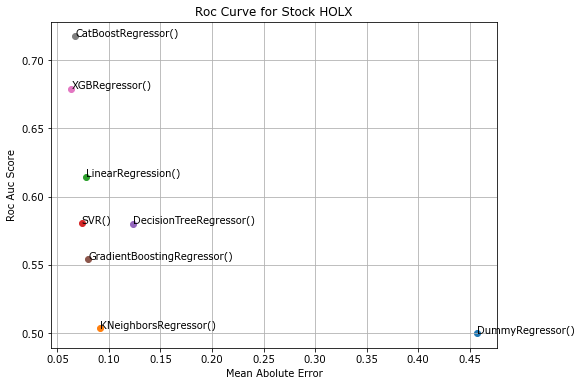

[14:51:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.2749460	total: 765us	remaining: 765ms
1:	learn: 0.2696618	total: 1.39ms	remaining: 695ms
2:	learn: 0.2643893	total: 2.1ms	remaining: 697ms
3:	learn: 0.2593605	total: 2.86ms	remaining: 712ms
4:	learn: 0.2548071	total: 3.56ms	remaining: 709ms
5:	learn: 0.2499517	total: 4.19ms	remaining: 695ms
6:	learn: 0.2457358	total: 4.83ms	remaining: 686ms
7:	learn: 0.2410965	total: 5.55ms	remaining: 689ms
8:	learn: 0.2367149	total: 6.22ms	remaining: 685ms
9:	learn: 0.2319634	total: 6.8ms	remaining: 673ms
10:	learn: 0.2279777	total: 7.44ms	remaining: 669ms
11:	learn: 0.2239379	total: 8.09ms	remaining: 666ms
12:	learn: 0.2197632	total: 8.74ms	remaining: 664ms
13:	learn: 0.2155793	total: 9.29ms	remaining: 655ms
14:	learn: 0.2116688	total: 9.95ms	remaining: 654ms
15:	learn: 0.2074006	total: 10.6ms	rema

164:	learn: 0.0373369	total: 116ms	remaining: 585ms
165:	learn: 0.0371555	total: 116ms	remaining: 584ms
166:	learn: 0.0369267	total: 117ms	remaining: 583ms
167:	learn: 0.0366839	total: 118ms	remaining: 582ms
168:	learn: 0.0364942	total: 118ms	remaining: 582ms
169:	learn: 0.0362379	total: 119ms	remaining: 581ms
170:	learn: 0.0360333	total: 120ms	remaining: 580ms
171:	learn: 0.0358150	total: 120ms	remaining: 578ms
172:	learn: 0.0356071	total: 121ms	remaining: 578ms
173:	learn: 0.0353540	total: 122ms	remaining: 577ms
174:	learn: 0.0351573	total: 122ms	remaining: 576ms
175:	learn: 0.0349856	total: 123ms	remaining: 575ms
176:	learn: 0.0348141	total: 123ms	remaining: 574ms
177:	learn: 0.0345341	total: 124ms	remaining: 573ms
178:	learn: 0.0343114	total: 125ms	remaining: 573ms
179:	learn: 0.0340281	total: 126ms	remaining: 572ms
180:	learn: 0.0338171	total: 126ms	remaining: 571ms
181:	learn: 0.0336564	total: 127ms	remaining: 570ms
182:	learn: 0.0333723	total: 127ms	remaining: 569ms
183:	learn: 

373:	learn: 0.0157158	total: 228ms	remaining: 381ms
374:	learn: 0.0156829	total: 228ms	remaining: 380ms
375:	learn: 0.0156735	total: 229ms	remaining: 379ms
376:	learn: 0.0156634	total: 229ms	remaining: 379ms
377:	learn: 0.0155938	total: 230ms	remaining: 378ms
378:	learn: 0.0155847	total: 230ms	remaining: 377ms
379:	learn: 0.0155757	total: 230ms	remaining: 376ms
380:	learn: 0.0155465	total: 231ms	remaining: 375ms
381:	learn: 0.0155093	total: 231ms	remaining: 374ms
382:	learn: 0.0154997	total: 232ms	remaining: 373ms
383:	learn: 0.0154687	total: 232ms	remaining: 373ms
384:	learn: 0.0153908	total: 233ms	remaining: 372ms
385:	learn: 0.0153604	total: 233ms	remaining: 371ms
386:	learn: 0.0153520	total: 234ms	remaining: 370ms
387:	learn: 0.0153419	total: 234ms	remaining: 369ms
388:	learn: 0.0152661	total: 235ms	remaining: 369ms
389:	learn: 0.0152147	total: 235ms	remaining: 368ms
390:	learn: 0.0152066	total: 236ms	remaining: 368ms
391:	learn: 0.0151977	total: 237ms	remaining: 367ms
392:	learn: 

598:	learn: 0.0101737	total: 338ms	remaining: 226ms
599:	learn: 0.0101533	total: 339ms	remaining: 226ms
600:	learn: 0.0101327	total: 339ms	remaining: 225ms
601:	learn: 0.0101292	total: 340ms	remaining: 225ms
602:	learn: 0.0101067	total: 340ms	remaining: 224ms
603:	learn: 0.0100865	total: 341ms	remaining: 223ms
604:	learn: 0.0100568	total: 341ms	remaining: 223ms
605:	learn: 0.0100356	total: 342ms	remaining: 222ms
606:	learn: 0.0099744	total: 342ms	remaining: 221ms
607:	learn: 0.0099397	total: 343ms	remaining: 221ms
608:	learn: 0.0099215	total: 343ms	remaining: 220ms
609:	learn: 0.0099176	total: 344ms	remaining: 220ms
610:	learn: 0.0098853	total: 344ms	remaining: 219ms
611:	learn: 0.0098642	total: 345ms	remaining: 219ms
612:	learn: 0.0098326	total: 345ms	remaining: 218ms
613:	learn: 0.0098118	total: 346ms	remaining: 217ms
614:	learn: 0.0097799	total: 346ms	remaining: 217ms
615:	learn: 0.0097761	total: 347ms	remaining: 216ms
616:	learn: 0.0097446	total: 347ms	remaining: 216ms
617:	learn: 

818:	learn: 0.0062806	total: 448ms	remaining: 99ms
819:	learn: 0.0062734	total: 449ms	remaining: 98.5ms
820:	learn: 0.0062569	total: 449ms	remaining: 97.9ms
821:	learn: 0.0062189	total: 450ms	remaining: 97.4ms
822:	learn: 0.0062090	total: 450ms	remaining: 96.8ms
823:	learn: 0.0062003	total: 451ms	remaining: 96.3ms
824:	learn: 0.0061769	total: 451ms	remaining: 95.7ms
825:	learn: 0.0061608	total: 452ms	remaining: 95.2ms
826:	learn: 0.0061537	total: 453ms	remaining: 94.7ms
827:	learn: 0.0061417	total: 453ms	remaining: 94.2ms
828:	learn: 0.0061325	total: 454ms	remaining: 93.6ms
829:	learn: 0.0061166	total: 455ms	remaining: 93.1ms
830:	learn: 0.0061147	total: 455ms	remaining: 92.5ms
831:	learn: 0.0060780	total: 456ms	remaining: 92ms
832:	learn: 0.0060624	total: 456ms	remaining: 91.4ms
833:	learn: 0.0060538	total: 457ms	remaining: 90.9ms
834:	learn: 0.0060468	total: 457ms	remaining: 90.4ms
835:	learn: 0.0060314	total: 458ms	remaining: 89.8ms
836:	learn: 0.0060245	total: 458ms	remaining: 89.3

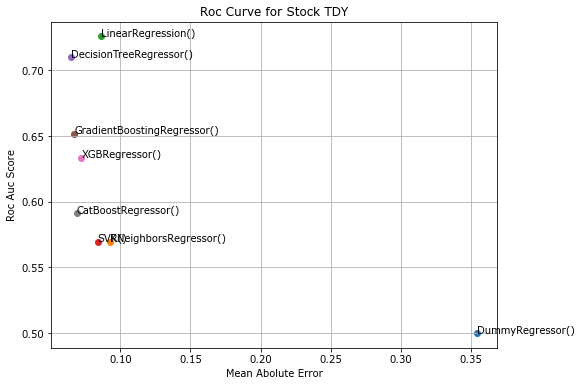

[14:51:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.026774
0:	learn: 0.3019505	total: 852us	remaining: 852ms
1:	learn: 0.2958742	total: 1.57ms	remaining: 786ms
2:	learn: 0.2895970	total: 2.24ms	remaining: 746ms
3:	learn: 0.2837460	total: 2.94ms	remaining: 732ms
4:	learn: 0.2780544	total: 3.6ms	remaining: 717ms
5:	learn: 0.2723211	total: 4.13ms	remaining: 684ms
6:	learn: 0.2671480	total: 4.81ms	remaining: 682ms
7:	learn: 0.2620577	total: 5.53ms	remaining: 685ms
8:	learn: 0.2572520	total: 6.07ms	remaining: 669ms
9:	learn: 0.2521152	total: 6.79ms	remaining: 672ms
10:	learn: 0.2473475	total: 7.39ms	remaining: 664ms
11:	learn: 0.2430070	total: 8.01ms	remaining: 660ms
12:	learn: 0.2383909	total: 8.67ms	remaining: 658ms
13:	learn: 0.2337512	total: 9.17ms	remaining: 646ms
14:	learn: 0.2290531	total: 9.81ms	remaining: 644ms
15:	learn: 0.2246039	total: 10.5ms	rem

193:	learn: 0.0309525	total: 114ms	remaining: 473ms
194:	learn: 0.0307800	total: 114ms	remaining: 472ms
195:	learn: 0.0305341	total: 115ms	remaining: 472ms
196:	learn: 0.0303888	total: 116ms	remaining: 472ms
197:	learn: 0.0302715	total: 116ms	remaining: 471ms
198:	learn: 0.0300755	total: 117ms	remaining: 471ms
199:	learn: 0.0299584	total: 117ms	remaining: 470ms
200:	learn: 0.0298258	total: 118ms	remaining: 469ms
201:	learn: 0.0297374	total: 119ms	remaining: 468ms
202:	learn: 0.0295500	total: 119ms	remaining: 468ms
203:	learn: 0.0293997	total: 120ms	remaining: 467ms
204:	learn: 0.0292444	total: 120ms	remaining: 467ms
205:	learn: 0.0290862	total: 121ms	remaining: 467ms
206:	learn: 0.0289550	total: 122ms	remaining: 466ms
207:	learn: 0.0287954	total: 122ms	remaining: 465ms
208:	learn: 0.0286944	total: 123ms	remaining: 464ms
209:	learn: 0.0285782	total: 123ms	remaining: 463ms
210:	learn: 0.0284732	total: 124ms	remaining: 462ms
211:	learn: 0.0282991	total: 124ms	remaining: 461ms
212:	learn: 

447:	learn: 0.0137631	total: 237ms	remaining: 292ms
448:	learn: 0.0137175	total: 238ms	remaining: 292ms
449:	learn: 0.0136828	total: 239ms	remaining: 292ms
450:	learn: 0.0136758	total: 239ms	remaining: 291ms
451:	learn: 0.0136290	total: 240ms	remaining: 290ms
452:	learn: 0.0136243	total: 240ms	remaining: 290ms
453:	learn: 0.0135900	total: 240ms	remaining: 289ms
454:	learn: 0.0135493	total: 241ms	remaining: 288ms
455:	learn: 0.0135049	total: 241ms	remaining: 288ms
456:	learn: 0.0134981	total: 242ms	remaining: 287ms
457:	learn: 0.0134914	total: 242ms	remaining: 287ms
458:	learn: 0.0134365	total: 243ms	remaining: 286ms
459:	learn: 0.0133985	total: 243ms	remaining: 286ms
460:	learn: 0.0133932	total: 244ms	remaining: 285ms
461:	learn: 0.0133347	total: 244ms	remaining: 285ms
462:	learn: 0.0133294	total: 245ms	remaining: 284ms
463:	learn: 0.0133242	total: 245ms	remaining: 283ms
464:	learn: 0.0132909	total: 246ms	remaining: 283ms
465:	learn: 0.0132516	total: 246ms	remaining: 282ms
466:	learn: 

729:	learn: 0.0075301	total: 381ms	remaining: 141ms
730:	learn: 0.0075170	total: 382ms	remaining: 141ms
731:	learn: 0.0075050	total: 383ms	remaining: 140ms
732:	learn: 0.0074902	total: 383ms	remaining: 140ms
733:	learn: 0.0074756	total: 384ms	remaining: 139ms
734:	learn: 0.0074612	total: 384ms	remaining: 139ms
735:	learn: 0.0074483	total: 385ms	remaining: 138ms
736:	learn: 0.0074339	total: 385ms	remaining: 137ms
737:	learn: 0.0074193	total: 386ms	remaining: 137ms
738:	learn: 0.0074098	total: 386ms	remaining: 136ms
739:	learn: 0.0073939	total: 387ms	remaining: 136ms
740:	learn: 0.0073798	total: 387ms	remaining: 135ms
741:	learn: 0.0073655	total: 388ms	remaining: 135ms
742:	learn: 0.0073538	total: 388ms	remaining: 134ms
743:	learn: 0.0073371	total: 389ms	remaining: 134ms
744:	learn: 0.0073232	total: 389ms	remaining: 133ms
745:	learn: 0.0073090	total: 390ms	remaining: 133ms
746:	learn: 0.0072950	total: 390ms	remaining: 132ms
747:	learn: 0.0072786	total: 391ms	remaining: 132ms
748:	learn: 

958:	learn: 0.0048858	total: 527ms	remaining: 22.5ms
959:	learn: 0.0048785	total: 528ms	remaining: 22ms
960:	learn: 0.0048694	total: 529ms	remaining: 21.5ms
961:	learn: 0.0048622	total: 530ms	remaining: 20.9ms
962:	learn: 0.0048511	total: 530ms	remaining: 20.4ms
963:	learn: 0.0048439	total: 531ms	remaining: 19.8ms
964:	learn: 0.0048274	total: 532ms	remaining: 19.3ms
965:	learn: 0.0048259	total: 532ms	remaining: 18.7ms
966:	learn: 0.0048233	total: 533ms	remaining: 18.2ms
967:	learn: 0.0048194	total: 534ms	remaining: 17.6ms
968:	learn: 0.0048124	total: 534ms	remaining: 17.1ms
969:	learn: 0.0048034	total: 535ms	remaining: 16.5ms
970:	learn: 0.0047925	total: 536ms	remaining: 16ms
971:	learn: 0.0047842	total: 536ms	remaining: 15.4ms
972:	learn: 0.0047761	total: 537ms	remaining: 14.9ms
973:	learn: 0.0047634	total: 538ms	remaining: 14.4ms
974:	learn: 0.0047621	total: 538ms	remaining: 13.8ms
975:	learn: 0.0047351	total: 539ms	remaining: 13.3ms
976:	learn: 0.0047226	total: 540ms	remaining: 12.7

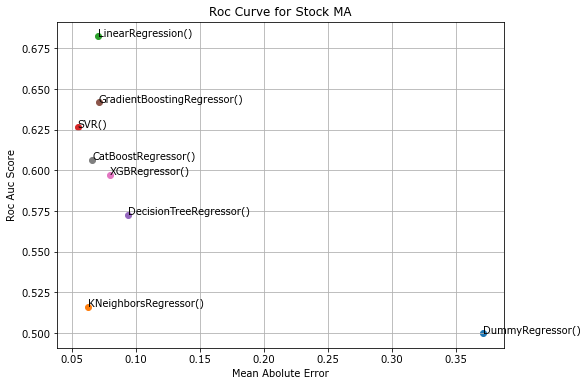

In [34]:
# without hyperparameter tunning was better auc results
for i in np.arange(0,100,10):
    auc_roc_plot(y_train.iloc[:,int(i/10)] ,  y_test.iloc[:,int(i/10)], X_train.iloc[:,i:i+10], 
               X_test.iloc[:,i:i+10])

In [38]:
def pred_after_search(y_train,y_test,x_train,x_test,c1,c2,model):
    lr_model = model
    lr_model.fit(x_train, y_train)

    lr_y = y_test.values
    lr_y_pred = lr_model.predict(x_test)
    
    fig, ax=plt.subplots(figsize=(9, 4))
    colors_light = ['pink', 'mediumorchid','cornflowerblue','limegreen', 'orange']
    colors_dark = ['deeppink', 'darkorchid','royalblue','darkgreen','darkorange']

    plt.plot(date_train.values, y_train,color=c1,label='Train')
    plt.plot(date_test.values, y_test,color=c2,label='Test')
    plt.plot(date_test.values, lr_y_pred,color=c2,linestyle='dashed',label='Prediction')
    plt.legend()
    plt.title(str(y_train.name))
    plt.show()

    # Test error
    error_mse = mean_absolute_error(
                    y_true = y_test,
                    y_pred = lr_y_pred
                )
    print(f"Test error (mse) without hyperparameter tunning: {error_mse}")
    return (lr_y_pred)

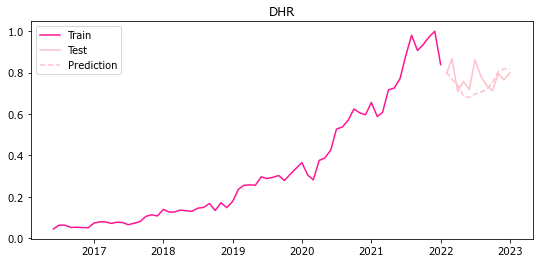

Test error (mse) without hyperparameter tunning: 0.05173495494511849


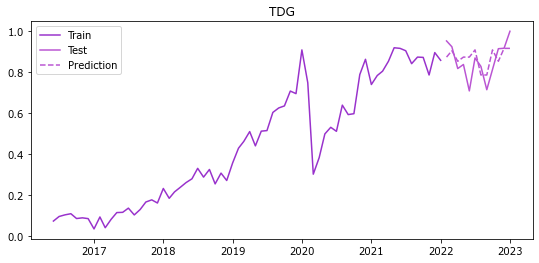

Test error (mse) without hyperparameter tunning: 0.060867169639193065
[15:09:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


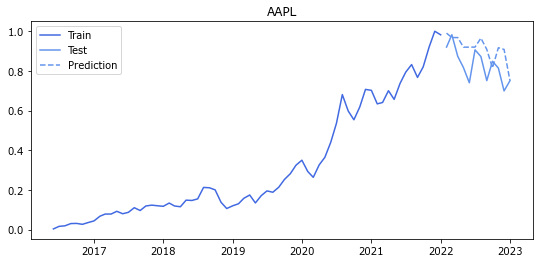

Test error (mse) without hyperparameter tunning: 0.08931440945454582


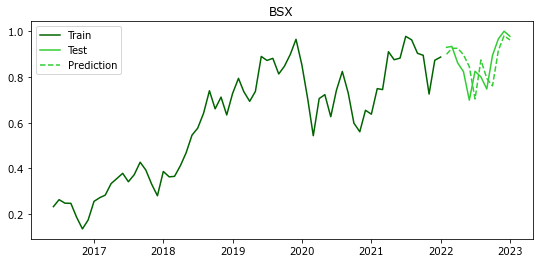

Test error (mse) without hyperparameter tunning: 0.06540148299524438


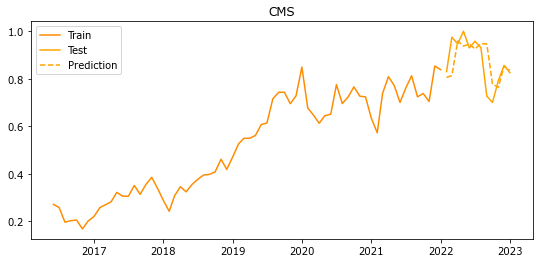

Test error (mse) without hyperparameter tunning: 0.05548140141415084
Learning rate set to 0.026774
0:	learn: 0.2540758	total: 785us	remaining: 785ms
1:	learn: 0.2493768	total: 1.58ms	remaining: 790ms
2:	learn: 0.2446144	total: 2.32ms	remaining: 770ms
3:	learn: 0.2399129	total: 2.95ms	remaining: 735ms
4:	learn: 0.2354111	total: 3.65ms	remaining: 726ms
5:	learn: 0.2313702	total: 4.3ms	remaining: 712ms
6:	learn: 0.2268655	total: 4.93ms	remaining: 700ms
7:	learn: 0.2226623	total: 5.56ms	remaining: 690ms
8:	learn: 0.2184417	total: 6.19ms	remaining: 682ms
9:	learn: 0.2144132	total: 7.2ms	remaining: 713ms
10:	learn: 0.2108022	total: 7.95ms	remaining: 715ms
11:	learn: 0.2070965	total: 8.68ms	remaining: 715ms
12:	learn: 0.2034575	total: 9.41ms	remaining: 715ms
13:	learn: 0.1998808	total: 10.1ms	remaining: 710ms
14:	learn: 0.1961742	total: 10.9ms	remaining: 714ms
15:	learn: 0.1927249	total: 11.5ms	remaining: 708ms
16:	learn: 0.1894068	total: 12.3ms	remaining: 714ms
17:	learn: 0.1863368	total: 13

166:	learn: 0.0455433	total: 103ms	remaining: 513ms
167:	learn: 0.0453644	total: 104ms	remaining: 514ms
168:	learn: 0.0450712	total: 104ms	remaining: 514ms
169:	learn: 0.0448343	total: 105ms	remaining: 513ms
170:	learn: 0.0445011	total: 106ms	remaining: 513ms
171:	learn: 0.0443247	total: 106ms	remaining: 512ms
172:	learn: 0.0440806	total: 107ms	remaining: 512ms
173:	learn: 0.0436920	total: 108ms	remaining: 511ms
174:	learn: 0.0434908	total: 108ms	remaining: 511ms
175:	learn: 0.0432188	total: 109ms	remaining: 511ms
176:	learn: 0.0429926	total: 110ms	remaining: 510ms
177:	learn: 0.0428162	total: 110ms	remaining: 510ms
178:	learn: 0.0425220	total: 111ms	remaining: 509ms
179:	learn: 0.0423008	total: 112ms	remaining: 509ms
180:	learn: 0.0420376	total: 112ms	remaining: 508ms
181:	learn: 0.0417431	total: 113ms	remaining: 507ms
182:	learn: 0.0415388	total: 113ms	remaining: 507ms
183:	learn: 0.0412445	total: 114ms	remaining: 506ms
184:	learn: 0.0410368	total: 115ms	remaining: 506ms
185:	learn: 

376:	learn: 0.0211669	total: 222ms	remaining: 367ms
377:	learn: 0.0211139	total: 223ms	remaining: 367ms
378:	learn: 0.0210935	total: 224ms	remaining: 366ms
379:	learn: 0.0210412	total: 224ms	remaining: 366ms
380:	learn: 0.0209893	total: 225ms	remaining: 365ms
381:	learn: 0.0209691	total: 225ms	remaining: 364ms
382:	learn: 0.0209119	total: 226ms	remaining: 363ms
383:	learn: 0.0208912	total: 226ms	remaining: 363ms
384:	learn: 0.0208538	total: 227ms	remaining: 362ms
385:	learn: 0.0208026	total: 227ms	remaining: 361ms
386:	learn: 0.0207461	total: 228ms	remaining: 361ms
387:	learn: 0.0206953	total: 228ms	remaining: 360ms
388:	learn: 0.0206757	total: 229ms	remaining: 359ms
389:	learn: 0.0206563	total: 229ms	remaining: 359ms
390:	learn: 0.0206061	total: 230ms	remaining: 358ms
391:	learn: 0.0205501	total: 231ms	remaining: 358ms
392:	learn: 0.0205309	total: 231ms	remaining: 357ms
393:	learn: 0.0204873	total: 232ms	remaining: 356ms
394:	learn: 0.0204319	total: 232ms	remaining: 356ms
395:	learn: 

579:	learn: 0.0126011	total: 327ms	remaining: 237ms
580:	learn: 0.0125488	total: 328ms	remaining: 236ms
581:	learn: 0.0125132	total: 328ms	remaining: 236ms
582:	learn: 0.0124475	total: 329ms	remaining: 235ms
583:	learn: 0.0124157	total: 329ms	remaining: 234ms
584:	learn: 0.0123997	total: 330ms	remaining: 234ms
585:	learn: 0.0123623	total: 330ms	remaining: 233ms
586:	learn: 0.0123217	total: 331ms	remaining: 233ms
587:	learn: 0.0122940	total: 331ms	remaining: 232ms
588:	learn: 0.0122824	total: 332ms	remaining: 232ms
589:	learn: 0.0122424	total: 332ms	remaining: 231ms
590:	learn: 0.0122081	total: 333ms	remaining: 230ms
591:	learn: 0.0121926	total: 334ms	remaining: 230ms
592:	learn: 0.0121529	total: 334ms	remaining: 229ms
593:	learn: 0.0121376	total: 335ms	remaining: 229ms
594:	learn: 0.0120983	total: 335ms	remaining: 228ms
595:	learn: 0.0120595	total: 336ms	remaining: 228ms
596:	learn: 0.0120320	total: 336ms	remaining: 227ms
597:	learn: 0.0119684	total: 337ms	remaining: 226ms
598:	learn: 

772:	learn: 0.0071159	total: 439ms	remaining: 129ms
773:	learn: 0.0071062	total: 440ms	remaining: 129ms
774:	learn: 0.0070780	total: 441ms	remaining: 128ms
775:	learn: 0.0070684	total: 442ms	remaining: 128ms
776:	learn: 0.0070542	total: 443ms	remaining: 127ms
777:	learn: 0.0070267	total: 444ms	remaining: 127ms
778:	learn: 0.0070174	total: 445ms	remaining: 126ms
779:	learn: 0.0069906	total: 445ms	remaining: 126ms
780:	learn: 0.0069767	total: 446ms	remaining: 125ms
781:	learn: 0.0069631	total: 446ms	remaining: 124ms
782:	learn: 0.0069421	total: 447ms	remaining: 124ms
783:	learn: 0.0069331	total: 448ms	remaining: 123ms
784:	learn: 0.0069163	total: 449ms	remaining: 123ms
785:	learn: 0.0068917	total: 449ms	remaining: 122ms
786:	learn: 0.0068582	total: 450ms	remaining: 122ms
787:	learn: 0.0068461	total: 451ms	remaining: 121ms
788:	learn: 0.0068329	total: 451ms	remaining: 121ms
789:	learn: 0.0067999	total: 452ms	remaining: 120ms
790:	learn: 0.0067881	total: 453ms	remaining: 120ms
791:	learn: 

957:	learn: 0.0045193	total: 560ms	remaining: 24.6ms
958:	learn: 0.0045066	total: 561ms	remaining: 24ms
959:	learn: 0.0044914	total: 562ms	remaining: 23.4ms
960:	learn: 0.0044845	total: 562ms	remaining: 22.8ms
961:	learn: 0.0044719	total: 563ms	remaining: 22.2ms
962:	learn: 0.0044595	total: 563ms	remaining: 21.6ms
963:	learn: 0.0044445	total: 564ms	remaining: 21.1ms
964:	learn: 0.0044376	total: 564ms	remaining: 20.5ms
965:	learn: 0.0044253	total: 565ms	remaining: 19.9ms
966:	learn: 0.0044185	total: 565ms	remaining: 19.3ms
967:	learn: 0.0044019	total: 566ms	remaining: 18.7ms
968:	learn: 0.0043971	total: 567ms	remaining: 18.1ms
969:	learn: 0.0043903	total: 567ms	remaining: 17.5ms
970:	learn: 0.0043782	total: 568ms	remaining: 17ms
971:	learn: 0.0043735	total: 569ms	remaining: 16.4ms
972:	learn: 0.0043667	total: 570ms	remaining: 15.8ms
973:	learn: 0.0043547	total: 570ms	remaining: 15.2ms
974:	learn: 0.0043402	total: 571ms	remaining: 14.6ms
975:	learn: 0.0043334	total: 572ms	remaining: 14.1

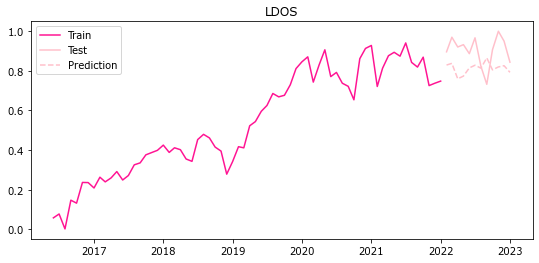

Test error (mse) without hyperparameter tunning: 0.11068551718021526


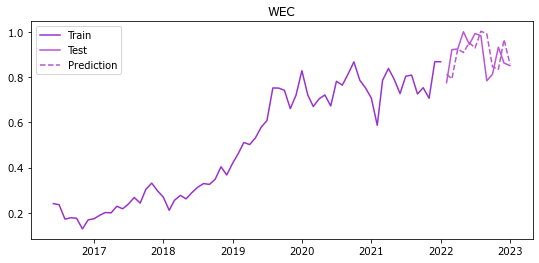

Test error (mse) without hyperparameter tunning: 0.06668373918556535
Learning rate set to 0.026774
0:	learn: 0.2886486	total: 939us	remaining: 939ms
1:	learn: 0.2836470	total: 1.62ms	remaining: 811ms
2:	learn: 0.2790667	total: 2.28ms	remaining: 758ms
3:	learn: 0.2744115	total: 2.85ms	remaining: 711ms
4:	learn: 0.2705747	total: 3.19ms	remaining: 634ms
5:	learn: 0.2662249	total: 3.93ms	remaining: 652ms
6:	learn: 0.2614657	total: 4.55ms	remaining: 645ms
7:	learn: 0.2571352	total: 5.21ms	remaining: 646ms
8:	learn: 0.2528024	total: 5.83ms	remaining: 642ms
9:	learn: 0.2486833	total: 6.61ms	remaining: 654ms
10:	learn: 0.2448169	total: 7.28ms	remaining: 655ms
11:	learn: 0.2410097	total: 7.85ms	remaining: 646ms
12:	learn: 0.2369695	total: 8.5ms	remaining: 645ms
13:	learn: 0.2329279	total: 9.15ms	remaining: 644ms
14:	learn: 0.2291104	total: 9.87ms	remaining: 648ms
15:	learn: 0.2252175	total: 10.7ms	remaining: 660ms
16:	learn: 0.2221661	total: 11.4ms	remaining: 658ms
17:	learn: 0.2187223	total: 1

300:	learn: 0.0344290	total: 191ms	remaining: 442ms
301:	learn: 0.0343817	total: 191ms	remaining: 442ms
302:	learn: 0.0341692	total: 192ms	remaining: 442ms
303:	learn: 0.0341222	total: 193ms	remaining: 442ms
304:	learn: 0.0340757	total: 194ms	remaining: 441ms
305:	learn: 0.0340299	total: 194ms	remaining: 440ms
306:	learn: 0.0339847	total: 195ms	remaining: 440ms
307:	learn: 0.0337897	total: 196ms	remaining: 439ms
308:	learn: 0.0337449	total: 196ms	remaining: 439ms
309:	learn: 0.0337006	total: 197ms	remaining: 439ms
310:	learn: 0.0336569	total: 198ms	remaining: 438ms
311:	learn: 0.0334747	total: 198ms	remaining: 437ms
312:	learn: 0.0334344	total: 199ms	remaining: 437ms
313:	learn: 0.0332687	total: 200ms	remaining: 436ms
314:	learn: 0.0331421	total: 200ms	remaining: 436ms
315:	learn: 0.0329400	total: 201ms	remaining: 435ms
316:	learn: 0.0328970	total: 202ms	remaining: 435ms
317:	learn: 0.0328545	total: 202ms	remaining: 434ms
318:	learn: 0.0326719	total: 203ms	remaining: 434ms
319:	learn: 

694:	learn: 0.0110197	total: 426ms	remaining: 187ms
695:	learn: 0.0109763	total: 427ms	remaining: 186ms
696:	learn: 0.0109698	total: 427ms	remaining: 186ms
697:	learn: 0.0109377	total: 428ms	remaining: 185ms
698:	learn: 0.0108853	total: 428ms	remaining: 184ms
699:	learn: 0.0108413	total: 429ms	remaining: 184ms
700:	learn: 0.0108346	total: 429ms	remaining: 183ms
701:	learn: 0.0107913	total: 430ms	remaining: 182ms
702:	learn: 0.0107494	total: 430ms	remaining: 182ms
703:	learn: 0.0107397	total: 431ms	remaining: 181ms
704:	learn: 0.0107333	total: 432ms	remaining: 181ms
705:	learn: 0.0107070	total: 432ms	remaining: 180ms
706:	learn: 0.0107005	total: 433ms	remaining: 179ms
707:	learn: 0.0106714	total: 433ms	remaining: 179ms
708:	learn: 0.0106205	total: 434ms	remaining: 178ms
709:	learn: 0.0105947	total: 434ms	remaining: 177ms
710:	learn: 0.0105758	total: 435ms	remaining: 177ms
711:	learn: 0.0105334	total: 436ms	remaining: 176ms
712:	learn: 0.0104691	total: 436ms	remaining: 176ms
713:	learn: 

908:	learn: 0.0048486	total: 535ms	remaining: 53.6ms
909:	learn: 0.0048239	total: 536ms	remaining: 53ms
910:	learn: 0.0048141	total: 536ms	remaining: 52.4ms
911:	learn: 0.0047931	total: 537ms	remaining: 51.8ms
912:	learn: 0.0047679	total: 537ms	remaining: 51.2ms
913:	learn: 0.0047601	total: 538ms	remaining: 50.6ms
914:	learn: 0.0047393	total: 538ms	remaining: 50ms
915:	learn: 0.0047125	total: 539ms	remaining: 49.4ms
916:	learn: 0.0047033	total: 539ms	remaining: 48.8ms
917:	learn: 0.0046827	total: 539ms	remaining: 48.2ms
918:	learn: 0.0046646	total: 540ms	remaining: 47.6ms
919:	learn: 0.0046444	total: 540ms	remaining: 47ms
920:	learn: 0.0046208	total: 541ms	remaining: 46.4ms
921:	learn: 0.0045929	total: 541ms	remaining: 45.8ms
922:	learn: 0.0045840	total: 542ms	remaining: 45.2ms
923:	learn: 0.0045629	total: 542ms	remaining: 44.6ms
924:	learn: 0.0045396	total: 542ms	remaining: 44ms
925:	learn: 0.0045354	total: 543ms	remaining: 43.4ms
926:	learn: 0.0045181	total: 543ms	remaining: 42.8ms
9

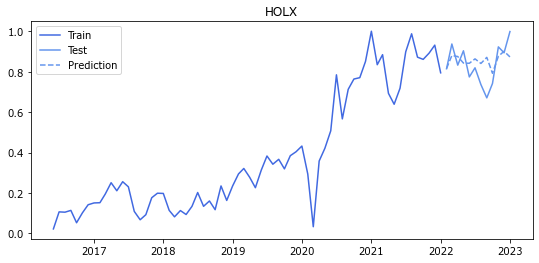

Test error (mse) without hyperparameter tunning: 0.06732711238783809


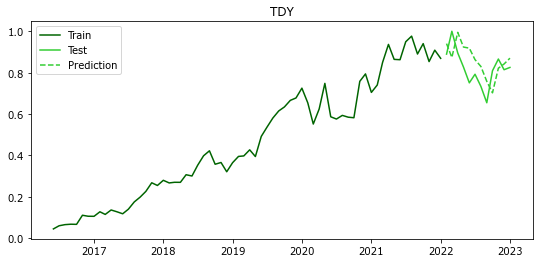

Test error (mse) without hyperparameter tunning: 0.08616091152770444


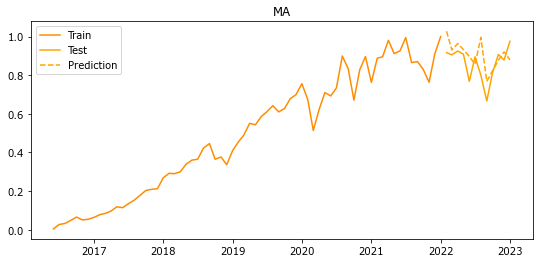

Test error (mse) without hyperparameter tunning: 0.07019721930620193


In [39]:
#BEST MODELS FOR EACH STOCK BASED ON AUC ROC hyperparameter
# DHR (x = less than 0.1, y = 0.59) gradientboostingregressor
# TDG (x = less than 0.05, y = 0.52) decisiontreeregressor
# AAPL (x = less than 0.1, y = 0.5) catboostregressor
# BSX (x = less than 0.1, y = 0.61) catboostregessor
# CMS (x = around 0.1, y = 0.53) decisiontreeregressor
# LDOS (x = less than 0.1, y = 0.5) gradientboostregressor
# WEC (x = around 0.12, y = 0.58) gradientboostingregressor
# HOLX (x = less than 0.1, y = 0.5) decisiontreeregressor
# TDY (x = less than 0.1, y = 0.65) catboostregessor
# MA (x = less than 0.1, y = 0.5) decisiontreeregressor

#BEST MODELS FOR EACH STOCK BASED ON AUC ROC without hyperparameter
# DHR (x = less than 0.1, y = 0.59) svr
# TDG (x = less than 0.05, y = 0.75) decisiontreeregressor
# AAPL (x = less than 0.1, y = 0.8) xgbregressor
# BSX (x = less than 0.1, y = 0.75) linearregression
# CMS (x = around 0.1, y = 0.7) linearregression
# LDOS (x = less than 0.1, y = 0.5) catboostregessor
# WEC (x = around 0.12, y = 0.6) linearregression
# HOLX (x = less than 0.1, y = 0.72) catboostregessor
# TDY (x = less than 0.1, y = 0.74) linearregression
# MA (x = less than 0.1, y = 0.7) linearregression
colors_light = ['pink', 'mediumorchid','cornflowerblue','limegreen', 'orange',
               'pink', 'mediumorchid','cornflowerblue','limegreen', 'orange']
colors_dark = ['deeppink', 'darkorchid','royalblue','darkgreen','darkorange',
              'deeppink', 'darkorchid','royalblue','darkgreen','darkorange']
models = [SVR(),DecisionTreeRegressor(),
         XGBRegressor(),LinearRegression(),LinearRegression(),
         CatBoostRegressor(),LinearRegression(),CatBoostRegressor(),
         LinearRegression(),LinearRegression()]
predictions = []
for i in np.arange(0,100,10):
    predictions.append(pred_after_search(y_train.iloc[:,int(i/10)] ,  y_test.iloc[:,int(i/10)], X_train.iloc[:,i:i+10], 
               X_test.iloc[:,i:i+10],colors_dark[int(i/10)],colors_light[int(i/10)],models[int(i/10)] ))


In [46]:
predictionsdf = pd.DataFrame(predictions).T
predictionsdf.columns =  y_test.iloc[:,0:11].columns
predictionsdf

DHR       TDG      AAPL       BSX       CMS      LDOS       WEC  \
0   0.803988  0.873673  0.990291  0.899237  0.805837  0.829387  0.812493   
1   0.768525  0.904721  0.968187  0.925220  0.813424  0.837886  0.791937   
2   0.739425  0.853318  0.968187  0.925534  0.959377  0.759750  0.924232   
3   0.688911  0.873673  0.919801  0.897471  0.937447  0.773732  0.908312   
4   0.679807  0.873673  0.919801  0.844993  0.946541  0.814810  0.951998   
5   0.696929  0.908837  0.920087  0.703908  0.925254  0.828468  0.928231   
6   0.705355  0.786241  0.965271  0.874363  0.947963  0.813694  1.002310   
7   0.719739  0.786241  0.908379  0.793896  0.946561  0.865408  0.991270   
8   0.751772  0.908837  0.815416  0.761166  0.777560  0.805032  0.845826   
9   0.804873  0.853318  0.916884  0.916176  0.764292  0.819746  0.834134   
10  0.818672  0.916374  0.908379  0.980296  0.853768  0.826056  0.965860   
11  0.817199  0.916374  0.751710  0.961886  0.836499  0.792654  0.857867   

        HOLX       TDY        MA  
0   0.815517  0.940228  1.027904  
1   0.880062  0.873362  0.930831  
2   0.874920  0.994556  0.964312  
3   0.842594  0.923718  0.932981  
4   0.841456  0.918394  0.897018  
5   0.863312  0.862858  0.857369  
6   0.840620  0.829820  0.995982  
7   0.870833  0.758009  0.767647  
8   0.791874  0.702641  0.822304  
9   0.876145  0.821472  0.877299  
10  0.900868  0.841830  0.921162  
11  0.872951  0.870013  0.879494

In [57]:
# Equally distributed portfolio across the 10 stocks
portfolio = pd.DataFrame(predictionsdf.sum(axis=1))
portfolio.columns =  ['Portfolio']
portfolio['Date']=(Y['Date'][-steps:]).reset_index(drop=True)
portfolio

Portfolio       Date
0    8.798554 2022-02-01
1    8.694154 2022-03-01
2    8.963612 2022-04-01
3    8.698641 2022-05-01
4    8.688490 2022-06-01
5    8.495254 2022-07-01
6    8.761618 2022-08-01
7    8.407984 2022-09-01
8    7.982427 2022-10-01
9    8.484340 2022-11-01
10   8.933265 2022-12-01
11   8.556648 2023-01-01

In [59]:
portfolio['100USD_INV'] = portfolio['Portfolio']*100
portfolio

Portfolio       Date  100USD_INV
0    8.798554 2022-02-01  879.855370
1    8.694154 2022-03-01  869.415437
2    8.963612 2022-04-01  896.361209
3    8.698641 2022-05-01  869.864092
4    8.688490 2022-06-01  868.849040
5    8.495254 2022-07-01  849.525387
6    8.761618 2022-08-01  876.161815
7    8.407984 2022-09-01  840.798436
8    7.982427 2022-10-01  798.242730
9    8.484340 2022-11-01  848.434010
10   8.933265 2022-12-01  893.326535
11   8.556648 2023-01-01  855.664837